In [6]:
import pickle
import os
import time
import numpy as np
import polychrom

from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
from polychrom.simulation import Simulation
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file

import simtk.openmm 
import os 
import shutil


import pyximport; pyximport.install()
from smcTranslocatorCircular_AsymmetricDissociatesOrBypasses import smcTranslocatorCircular_DissociatesOrBypasses

import warnings
import h5py 
import glob

from itertools import product
import re


## Helper classes

In [8]:
class plectonemeObject(object):
    """
    Creates local crumples to emulate the effect of plectonemes on bacterial Hi-C maps.
    Note, there is always a single domain boundary with this method.
    
    Parameters
    ----------
    N : int
        Length of the chromosome (monomer units)
    
    plec_len : int
        Average length of loops and gaps. Loops are followed by gaps - both of length `plec_len`.
    
    num_overlapping_loops : int
        Numbers of rounds of adding loops and gaps of length `plec_len` on the chromosome.
    
    boundary_location : int
        Location of the crumpling boundary
        
    """    
    def __init__(self,N, plec_len,num_ovelapping_loops,boundary_location=0):
        self.plec_len = plec_len
        self.N = N
        self.num_ovelapping_loops = num_ovelapping_loops
        self.plec_tot = []
        self.boundary_location = boundary_location
    def generate_plectonemes(self):
        plec_len = self.plec_len
        num_ovelapping_loops = self.num_ovelapping_loops
        N = self.N
        plec_tot = []
        for _ in range(num_ovelapping_loops):
            plec = np.sort(np.random.choice(N,int(N/plec_len),replace=False))
            plec_pairs = [(plec[i],plec[i+1]) for i in range(0,int(2*(len(plec)//2)),2)]
            plec_tot += plec_pairs 
        self.plec_tot = plec_tot    

    def get_bonds(self):
        # return bonds, with the correct boundary location
        s = self.boundary_location
        return [(np.mod(b[0]+s,N), np.mod(b[1]+s,N)) for b in self.plec_tot]

In [9]:
class simulationBondUpdater(object):
    """
    This class precomputes simulation bonds for faster dynamic allocation. 
    """

    def __init__(self, smcTransObject, plectonemeObject):
        """
        :param smcTransObject: smc translocator object to work with
        """
        self.smcObject = smcTransObject
        self.plectonemeObject = plectonemeObject
        self.allBonds = []

    def setParams(self, activeParamDict, inactiveParamDict):
        """
        A method to set parameters for bonds.
        It is a separate method because you may want to have a Simulation object already existing

        :param activeParamDict: a dict (argument:value) of addBond arguments for active bonds
        :param inactiveParamDict:  a dict (argument:value) of addBond arguments for inactive bonds

        """
        self.activeParamDict = activeParamDict
        self.inactiveParamDict = inactiveParamDict


    def setup(self, bondForce, smcStepsPerBlock,  blocks = 100):
        """
        A method that milks smcTranslocator object
        and creates a set of unique bonds, etc.

        :param bondForce: a bondforce object (new after simulation restart!)
        :param blocks: number of blocks to precalculate
        :param smcStepsPerBlock: number of smcTranslocator steps per block
        :return:
        """

        if len(self.allBonds) != 0:
            raise ValueError("Not all bonds were used; {0} sets left".format(len(self.allBonds)))

        self.bondForce = bondForce

        # generate a new set of plectonemes for each simulation block
        self.plectonemeObject.generate_plectonemes()
        
        #precalculating all bonds
        allBonds = []
        for dummy in range(blocks):
            self.smcObject.steps(smcStepsPerBlock)
            left, right = self.smcObject.getSMCs()
            # add SMC bonds
            bonds = [(int(i), int(j)) for i,j in zip(left, right)]
            # add plectoneme bonds
            plecbonds = [(int(b[0]),int(b[1])) for b in self.plectonemeObject.get_bonds()]
            allBonds.append(bonds + plecbonds)

        self.allBonds = allBonds
        self.uniqueBonds = list(set(sum(allBonds, [])))

        #adding forces and getting bond indices
        self.bondInds = []
        self.curBonds = allBonds.pop(0)

        for bond in self.uniqueBonds:
            paramset = self.activeParamDict if (bond in self.curBonds) else self.inactiveParamDict
            ind = bondForce.addBond(bond[0], bond[1], **paramset) # changed from addBond
            self.bondInds.append(ind)
        self.bondToInd = {i:j for i,j in zip(self.uniqueBonds, self.bondInds)}
        return self.curBonds,[]


    def step(self, context, verbose=False):
        """
        Update the bonds to the next step.
        It sets bonds for you automatically!
        :param context:  context
        :return: (current bonds, previous step bonds); just for reference
        """
        if len(self.allBonds) == 0:
            raise ValueError("No bonds left to run; you should restart simulation and run setup  again")

        pastBonds = self.curBonds
        self.curBonds = self.allBonds.pop(0)  # getting current bonds
        bondsRemove = [i for i in pastBonds if i not in self.curBonds]
        bondsAdd = [i for i in self.curBonds if i not in pastBonds]
        bondsStay = [i for i in pastBonds if i in self.curBonds]
        if verbose:
            print("{0} bonds stay, {1} new bonds, {2} bonds removed".format(len(bondsStay),
                                                                            len(bondsAdd), len(bondsRemove)))
        bondsToChange = bondsAdd + bondsRemove
        bondsIsAdd = [True] * len(bondsAdd) + [False] * len(bondsRemove)
        for bond, isAdd in zip(bondsToChange, bondsIsAdd):
            ind = self.bondToInd[bond]
            paramset = self.activeParamDict if isAdd else self.inactiveParamDict
            self.bondForce.setBondParameters(ind, bond[0], bond[1], **paramset)  # actually updating bonds
        self.bondForce.updateParametersInContext(context)  # now run this to update things in the context
        return self.curBonds, pastBonds

## Simulation results plotting functions

In [10]:
from polychrom.polymer_analyses import generate_bins
from polychrom.polymerutils import load_URI,  load
from polychrom import contactmaps
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file

import h5py as hp
import matplotlib.gridspec as grd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

from brandaolib import plotting

def getScaling(inMatrix,measureType='sum',scaleType='log',doCircular=True):
    inMatrix = np.array(inMatrix, dtype = np.double)
    N = len(inMatrix)    
        
    marginals = np.sum(inMatrix, axis=0)
    mask = marginals > 0 
    mask2d = mask[:,None] * mask[None,:]
    
    if scaleType=='log':
        bins = generate_bins(N)
    else:
        bins = np.arange(0,N)
        
    mids = 0.5 * (bins[:-1] + bins[1:])
    Pc = [] 
    for st, end in zip(bins[:-1], bins[1:]):
        curmean = 0
        maskmean = 0
        for i in range(st, end):
            if measureType == 'median':
                curmean += np.median(np.diagonal(inMatrix, i))
                maskmean += np.median(np.diagonal(mask2d, i))
            else:
                curmean += np.nansum(np.diagonal(inMatrix, i))
                maskmean += np.nansum(np.diagonal(mask2d, i))
            if doCircular == True:
                if measureType == 'median':
                    curmean += np.median(np.diagonal(inMatrix,len(inMatrix)-i))
                    maskmean += np.median(np.diagonal(mask2d, len(inMatrix)-i))
                else:
                    curmean += np.nansum(np.diagonal(inMatrix, len(inMatrix)-i))
                    maskmean += np.nansum(np.diagonal(mask2d, len(inMatrix)-i))
        Pc.append(curmean / maskmean)
    mids = np.r_[mids, N]
    Pc = np.r_[Pc, np.sqrt((Pc[-1] / Pc[-2])) * Pc[-1]]
    return Pc, mids
         

In [11]:
def make_simulation_maps(simulation_folders,figure_names, center_at=-30,vmax=0.007,cutoff_radius=6):
    downsample = 1
    for num, folder, fig_name in zip(range(len(figure_names)),simulation_folders,figure_names):
        try:
            files = list_URIs(folder) #  these are the paths for individual blocks

            # get the Hi-C map
            m_list = []
            s_list = []
            count = 0
            load_size = 500
            for flist in [files[x:x+load_size] for x in range(0,len(files),load_size)]:
                m = contactmaps.binnedContactMap([f  for (fi, f) in enumerate(flist) \
                                                  if np.mod(fi,downsample)==0],cutoff=cutoff_radius)
                m_list.append(m[0])
                count = count +1
                #print("done {}".format(count))

            M=sum(m_list)
            MC = M#iterativeCorrection(M)[0]
            MC = MC/np.sum(MC,axis=1)[0]

            rollBy = int((180-center_at)*M.shape[0]/360)
            shift_by = int((center_at)*4040/360)

            # get the SMC ChIP-seq profile
            files = [x for x in os.listdir(folder) if 'blocks' in x]
            SMCs = np.zeros(4040)
            for f in files:
                with hp.File(os.path.join(folder,f),'r') as block:
                    for key in block.keys():
                        SMCs += np.bincount(np.ndarray.flatten( np.array(block[key]['SMCs'])),minlength=4040)

            fig = plt.figure(figsize=(5*1.5,6*1.5))
            # create a 2 X 2 grid 
            gs = grd.GridSpec(2, 2, height_ratios=[2,20], width_ratios=[20,1], wspace=0.1,hspace=0.1)

            # SMC enrichment plot
            ax2 = plt.subplot(gs[0])
            ax2.plot(np.arange(-2020+shift_by,2020+shift_by),np.roll(np.fft.fftshift(SMCs),rollBy))
            plt.xlim([-2020+shift_by,2020+shift_by])
            plt.ylabel('SMC enrichment (arb)')

            # Hi-C plot
            ax = plt.subplot(gs[2])
            ax.imshow(np.roll(np.roll(MC,rollBy,axis=1),rollBy,axis=0),\
                       vmax=vmax,cmap='tung',extent=[-2020+shift_by,2020+shift_by,-2020+shift_by,2020+shift_by],
                      aspect='equal',origin="bottom")
            plt.xlabel("Genome position (kb)")
            plt.ylabel("Genome position (kb)")

            # color bar in it's own axis
            colorAx = plt.subplot(gs[3])
            norm = clr.Normalize(vmin=0, vmax=vmax)
            cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm,cmap='tung'),cax = colorAx)
            cb.set_label('Contact frequency')

            #plt.savefig(fig_name)
            np.save(os.path.join(folder,'sim_hic'),MC)
            np.save(os.path.join(folder,'sim_chip'),SMCs)            
            plt.show()
            print("Done {}/{}: {}".format(num+1,len(figure_names),fig_name))
        except:
            print('failed at making: {}'.format(folder))   

## Simulation functions

In [12]:
def initModel(knockOffProb = 1,kOriToTer_kTerToOri_kBypass=[0.01,0.01,0.04],parSsites=[-1,-4,-5,-6,-27,4,17],\
              wind=0.33,terSites=[2000,2050], terSiteStrength=0.0025,parSstrengths=None,\
             SEPARATION=200,LIFETIME = 2000/0.05,N = 4000,BASE_STOCHASTICITY=0.05):

    """
    This function initiates the bacterial chromosome. 
    
    knockOffProb : float
        The probability of dissociating from the chromosome if SMC is stalled
    
    kOriToTer_kTerToOri_kBypass : 3-list of floats
        The probabilities of being knocked off the chromosome if stepping onto an occupied site in 
        the 1) Ori to ter or 2) Ter to ori directions, or 3) the probability of stepping onto the
        site (i.e. "bypassing"). Typically, we let 1) and 2) be equal.
        
    parSsites : list of ints
        Degree locations for the parS loading sites
        
    parSstrengths : float
        Weight of loading at each parS sites versus other sites, where non-parS sites have 
        a relative strength of 1. The default value if None is specified is 16000/len(parSsites).
    
    wind : float
        Factor (between 0 and 1) by which to slow down when moving towards the ori
        
    terSites : list of ints
        List of monomers whereby to stall SMCs

    terSiteStrength : float
        List of monomers whereby to stall SMCs
        
    SEPARATION : int
        Average of monomer spacings between SMC complexes (i.e. related to SMC density)
        
    LIFETIME : float
        The number of simulation steps before the SMC complex dissociates spontaneously.
        Typically this value is 2000/BASE_STOCHASTICITY
        
    BASE_STOCHASTICITY: float
        The probability (in simulation steps) that an SMC subunit will move forward.
    
    """
    birthArray = np.ones(N, dtype=np.double)  
    deathArray = np.zeros(N, dtype=np.double) + 1. / LIFETIME 
    stallDeathArray = np.zeros(N, dtype=np.double) + knockOffProb
    stallLeftArray = np.zeros(N, dtype = np.double)
    stallRightArray = np.zeros(N, dtype = np.double)
    stepArrayR = BASE_STOCHASTICITY*np.ones(N, dtype=np.double) 
    stepArrayL = BASE_STOCHASTICITY*np.ones(N, dtype=np.double)
    
    deathList = [x for x in np.arange(terSites[0],terSites[1])]
    for i in deathList:
        deathArray[i] = 0.05*BASE_STOCHASTICITY

        
    # set parS locations, and compute the slowing down values
    if parSstrengths is None:
        parSstrengths = [16000/len(parSsites)]*len(parSsites)
        
    parS_arrayR = []
    parS_arrayL = []
    for s,ss in zip(parSsites,parSstrengths):
        if np.mod(int(s/360*N),N) < terSites[0]:
            parS_arrayR.append(np.mod(int(s/360*N),N))
        else:
            parS_arrayL.append(np.mod(int(s/360*N),N))            
        birthArray[np.mod(int(s/360*N),N)] = ss
    
    
    # set baseline translocation asymmetry
    stepArrayL[0:terSites[0]] *= (1-wind)
    stepArrayR[terSites[1]:N] *= (1-wind) 
               
    smcNum = N // SEPARATION
    pauseArrayR = 1-stepArrayR
    pauseArrayL = 1-stepArrayL
    SMCTran = smcTranslocatorCircular_DissociatesOrBypasses(birthArray, deathArray, stallLeftArray, \
                                                    stallRightArray, pauseArrayL, pauseArrayR, \
                                                    stallDeathArray, kOriToTer_kTerToOri_kBypass,  smcNum)
    return SMCTran


In [13]:
def run_simulation(knockOffProb, kOriToTer_kTerToOri_kBypass, parSsites,\
                  wind, terSites, terSiteStrength, parSstrengths,\
                  separation,lifetime, N , BASE_STOCHASTICITY, translocator_initialization_steps, \
                  steps_per_sample, dens, block, smcStepsPerBlock, \
                  smcBondDist, smcBondWiggleDist, save_folder, saveEveryBlocks, \
                  skipSavedBlocksBeginning, totalSavedBlocks, restartBondUpdaterEveryBlocks,\
                  plec_len=45,num_ovelapping_loops=3, GPU_choice = 0, rrnSite=100):
    """
    This function initiates the bacterial chromosome. 
    
    knockOffProb : float
        The probability of dissociating from the chromosome if SMC is stalled
    
    kOriToTer_kTerToOri_kBypass : 3-list of floats
        The probabilities of being knocked off the chromosome if stepping onto an occupied site in 
        the 1) Ori to ter or 2) Ter to ori directions, or 3) the probability of stepping onto the
        site (i.e. "bypassing"). Typically, we let 1) and 2) be equal.
        
    parSsites : list of ints
        Degree locations for the parS loading sites
        
    parSstrengths : float
        Weight of loading at each parS sites versus other sites, where non-parS sites have 
        a relative strength of 1. The default value if None is specified is 16000/len(parSsites).
    
    wind : float
        Factor (between 0 and 1) by which to slow down when moving towards the ori
        
    terSites : list of ints
        List of monomers whereby to stall SMCs

    terSiteStrength : float
        List of monomers whereby to stall SMCs
        
    SEPARATION : int
        Average of monomer spacings between SMC complexes (i.e. related to SMC density)
        
    LIFETIME : float
        The number of simulation steps before the SMC complex dissociates spontaneously.
        Typically this value is 2000/BASE_STOCHASTICITY
        
    BASE_STOCHASTICITY: float
        The probability (in simulation steps) that an SMC subunit will move forward.
           
    steps_per_sample : int
        The number of  polymer simulation integration steps to be carried out per block.
        
    dens : float
        Monomer density of the chromosome (defines the bounding box size)
        
    block : int
        Starting block number (should typically be zero). Generally, a "block" refers to a sampling
        of the 3D polymer conformation.
        
    smcStepsPerBlock : int
        Number of SMC translocator steps taken per polymer simulation time step
        
    smcBondDist : float
        Distance of SMC bonds in monomer units
    
    smcBondWiggleDist : float
        The harmonic bond strength for SMC-type bonds
        
    save_folder : str
        Location where to dump data
        
    saveEveryBlocks : int
        Frequency of saving data.
        
    skipSavedBlocksBeginning : int
        Number of blocks to skip before saving conformations.
        
    totalSavedBlocks : int
        Total number of blocks to save.
    
    restartBondUpdaterEveryBlocks : int
        Frequency of restarting the pre-allocation of bonds.
    
    plec_len : int
        See `plectonemeObject`
        
    num_ovelapping_loops : int
        See `plectonemeObject`
        
    rrnSite : int
        See in `boundary_location` in `plectonemeObject`.
    
    GPU_choice : int
        The GPU number on which to run the simulation.
    
    """
    
    # assertions for easy managing code below 
    assert restartBondUpdaterEveryBlocks % saveEveryBlocks == 0 
    assert (skipSavedBlocksBeginning * saveEveryBlocks) % restartBondUpdaterEveryBlocks == 0 
    assert (totalSavedBlocks * saveEveryBlocks) % restartBondUpdaterEveryBlocks == 0 
    savesPerBondUpdater = restartBondUpdaterEveryBlocks // saveEveryBlocks
    BondUpdaterInitsSkip = saveEveryBlocks * skipSavedBlocksBeginning  // restartBondUpdaterEveryBlocks
    BondUpdaterInitsTotal  = (totalSavedBlocks + skipSavedBlocksBeginning) * saveEveryBlocks // restartBondUpdaterEveryBlocks
    print("BondUpdater will be initialized {0} times, first {1} will be skipped".format(BondUpdaterInitsTotal, BondUpdaterInitsSkip))    
    
    
    # create SMC translocation object   
    SMCTran = initModel(knockOffProb, kOriToTer_kTerToOri_kBypass, parSsites,\
              wind, terSites, terSiteStrength, parSstrengths,\
              separation,lifetime, N , BASE_STOCHASTICITY)
                        
                        
    SMCTran.steps(translocator_initialization_steps)  # steps to "equilibrate" SMC dynamics
    
    # create plectoneme object
    plectonemeObj = plectonemeObject(N,plec_len=plec_len,
                                     num_ovelapping_loops=num_ovelapping_loops,
                                    boundary_location=rrnSite)
    
    # now feed bond generators to BondUpdater 
    BondUpdater = simulationBondUpdater(SMCTran,plectonemeObj)   
    
    # clean up the simulation directory
    folder = save_folder
    if os.path.exists(folder):
        shutil.rmtree(folder)
    
    # set initial configuration of the polymer    
    box = (N / dens) ** 0.33  
    data = grow_cubic(N, int(box) - 2)  # creates a compact conformation 

    # create the reporter class
    reporter = HDF5Reporter(folder=folder, max_data_length=100)

    # Iterate over various BondUpdaterInitializations
    for BondUpdaterCount in range(BondUpdaterInitsTotal):
        doSave = BondUpdaterCount >= BondUpdaterInitsSkip

        # simulation parameters are defined below 
        a = Simulation(
                platform="cuda",
                integrator="variableLangevin", 
                error_tol=0.01, 
                GPU = "{}".format(GPU_choice), 
                collision_rate=0.03, 
                N = len(data),
                reporters=[reporter],
                PBCbox=[box, box, box],
                precision="mixed")  # timestep not necessary for variableLangevin


        a.set_data(data)  # loads a polymer, puts a center of mass at zero
        
        # -----------Adding forces ---------------
        #a.add_force(forces.cylindrical_confinement(a,cellRadius,bottom=-halfLength,top=halfLength,k=5))
        a.add_force(
            forcekits.polymer_chains(
                a,
                chains=[(0, None, 1)], # makes circular chains
                bond_force_func=forces.harmonic_bonds, # adds harmonic bonds
                bond_force_kwargs={
                    'bondLength':1.0,
                    'bondWiggleDistance':0.1, # Bond distance will fluctuate +- 0.1 on average
                    # This is fine because our simulation is "soft" on average (all forces are soft-core)
                    # And this is potentially desirable to make polymer chain softer to avoid jerking 
                    # when a new bond is initialized
                 },

                angle_force_func=forces.angle_force,
                angle_force_kwargs={
                    'k':0.05 # we are making a very flexible polymer, basically not necessary here
                },
                nonbonded_force_func=forces.polynomial_repulsive, # this is the excluded volume potential
                nonbonded_force_kwargs={
                    'trunc':1.5, # this will let chains cross sometimes (energy in kb*T units)
                    'radiusMult':1.05, # this is from old code
                    #'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
                },
                except_bonds=True,
            )
        )
        # -----------Initialize bond updater. Add bonds ---------------
        a.step = block
        kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
        bondDist = smcBondDist * a.length_scale
        activeParams = {"length":bondDist,"k":kbond}
        inactiveParams = {"length":bondDist, "k":0}
        BondUpdater.setParams(activeParams, inactiveParams)

        # this step actually puts all bonds in and sets first bonds to be what they should be
        BondUpdater.setup(bondForce=a.force_dict['harmonic_bonds'],
                    smcStepsPerBlock=smcStepsPerBlock,
                    blocks=restartBondUpdaterEveryBlocks) 
        print("Restarting BondUpdater")
        
        # Minimize energy since we're reconfiguring the random walk into crumples and SMC-dependent loops
        a.local_energy_minimization() 
    
        # Iterate over simulation time steps within each BondUpdater 
        for i in range(restartBondUpdaterEveryBlocks - 1):
            # BondUpdater updates bonds at each time step.
            curBonds, pastBonds = BondUpdater.step(a.context)  
            if i % saveEveryBlocks == (saveEveryBlocks - 2):  
                # save SMC positions and monomer positions 
                a.do_block(steps=steps_per_sample, save_extras={"SMCs":curBonds,"SMC_step":a.step}) 
            else:
                a.integrator.step(steps_per_sample)  # do steps without getting the positions from the GPU (faster)

        data = a.get_data()  # save data and step, and delete the simulation
        block = a.step
        del a
        time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    # dump data to  output file!
    reporter.dump_data()
    done_file = open(os.path.join(folder,'sim_done.txt'),"w+")
    done_file.close()

## Run simulations

In [14]:
def get_kb_from_theory(num_extruders):
    d = 358 # kb
    v3 = 0.46
    v2 = 0.59
    v1 = 0.83
    n_encounters = 850*(0.4*num_extruders/1371) 
    tb = d/n_encounters/v3 - d/n_encounters/v2*(1-n_encounters/d)
    kb = 1/tb
    return kb

In [16]:
"""
This pipeline performs polymer simulations for the SMC collisions project.
"""
figure_folder = 'Figures'

# parameters for sweep
N = 4040
k_knock_list = ['FromTheory'] # conditional probability, given a step is taking place
k_bypass_list = ['FromTheory'] # conditional probability, given a step is taking place
BASE_STOCHASTICITY = 0.05

base_stochasticity = [BASE_STOCHASTICITY] # rate in 1/(simulation time) step units
life_times = [N/2/BASE_STOCHASTICITY] # time in (simulation time) step units
separation_list = [N//30,N//40,N//50,N//70] #[N//15,N//25, N//35, N//55, N//70]
parS_sites_list = [[-27]] #[[-59]] #[[-59]] #[[-59,-94]]
parS_strength_list = [16000,16000/2,16000/4]
wind_val_list = [0.35] 
ter_sites_list = [[1950,2050]]
ter_strengths_list = [0.05*BASE_STOCHASTICITY] # rate of dissociation (1/(simulation time step))
plec_len_list = [45]
num_ovelapping_loops_list = [2]

# simulation parameters for smc bonds 
smcBondWiggleDist = 0.2
smcBondDist = 0.5
smcStepsPerBlock = int(1/BASE_STOCHASTICITY) # this scales the number of SMC substeps per simulation time step

stiff = 2
dens = 0.2
block = 0  # starting block 

# parameters for SMC translocator
translocator_initialization_steps = 100000 # for SMC translocator
steps_per_sample = 3000 # number of polymer simulation steps per block.

# saving for polymer simulation
saveEveryBlocks = 10   # save every 10 blocks 
skipSavedBlocksBeginning = 20  # how many blocks to skip after you restart LEF positions
totalSavedBlocks = 500  # how many blocks to save (number of blocks done is totalSavedBlocks * saveEveryBlocks)
restartBondUpdaterEveryBlocks = 100 

# combine the parameters for the sweep
comb_list = list(product(k_knock_list,
                         k_bypass_list,
                         life_times, 
                         separation_list,
                         parS_strength_list,
                         parS_sites_list, 
                         wind_val_list,
                         base_stochasticity,
                         ter_sites_list,
                         ter_strengths_list,
                         plec_len_list, 
                         num_ovelapping_loops_list))

# create list of all file names
simulation_filefolders = []
figure_filenames = []
for k_knock, k_bypass, lifetime, separation, parSval, parSsites, wind, stoch, \
    ter_sites, ter_site_strengths, plec_len, num_ovelapping_loops in comb_list:   
    
    
    num_extruders = int(N//separation)
    k_bypass = get_kb_from_theory(num_extruders)
    if k_knock == 'FromTheory':
        k_knock = k_bypass/20
    ter_names = "_".join(['{}'.format(str(s)) for s in ter_sites])
    
    # make folders and file names
    save_folder = ('FullSims_'+
                    "_".join(['{}'.format(str(s) if s>0 else ('m'+str(-s))  )
                               for s in sorted(parSsites) ]))
    fname = f"kd{np.round(k_knock,5)}_kb_{np.round(k_bypass,2)}_sep_{int(separation)}"+ \
            f"_parSstrength_{parSval}_lifetime_{int(lifetime)}_wind_{wind}"+ \
            f"_stoch_{stoch}_terSites_{ter_names}"+\
            f"_terSiteStrength_{np.round(ter_site_strengths,4)}_plecLen_{plec_len}_plecRep_{num_ovelapping_loops}"

    simulation_filefolders.append(os.path.join(save_folder,fname))
    figure_filenames.append(os.path.join(figure_folder,'fig_'+save_folder+'_'+fname+'.pdf'))


## make directories
for f in simulation_filefolders:
    if not os.path.exists(f):
        os.makedirs(f)
len(simulation_filefolders)

12

In [18]:
existing = []
for f in simulation_filefolders:
    if not os.path.exists(os.path.join(f,'sims.np')):
        print(f"Does not exist: {f}")#os.makedirs(f)
    else:
        existing.append(f)

Does not exist: FullSims_m27/kd0.00202_kb_0.04_sep_134_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
Does not exist: FullSims_m27/kd0.00202_kb_0.04_sep_134_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
Does not exist: FullSims_m27/kd0.00202_kb_0.04_sep_134_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
Does not exist: FullSims_m27/kd0.00263_kb_0.05_sep_101_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
Does not exist: FullSims_m27/kd0.00263_kb_0.05_sep_101_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
Does not exist: FullSims_m27/kd0.00263_kb_0.05_sep_101_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_te

In [16]:
filenames = [os.path.join(f,'sim_done.txt') for f in simulation_filefolders],

for (k_knock, k_bypass, lifetime, separation, parSval, parSsites, wind,\
    BASE_STOCHASTICITY, terSites, terSiteStrength, plec_len, num_ovelapping_loops), out_folder, fig_name in \
       zip(comb_list,simulation_filefolders,figure_filenames): 

    knockOffProb = 1
    
    if k_bypass == 'FromTheory':
        num_extruders = int(N//separation)
        k_bypass = get_kb_from_theory(num_extruders)
    if k_knock == 'FromTheory':
        k_knock = k_bypass/20
        
    kOriToTer_kTerToOri_kBypass=[k_knock,k_knock,k_bypass]
    parSstrengths=[parSval/len(parSsites)]*len(parSsites)
    
    print(f"doing {out_folder}")
        
    run_simulation(knockOffProb, kOriToTer_kTerToOri_kBypass, parSsites,\
                  wind, terSites, terSiteStrength, parSstrengths,\
                  separation,lifetime, N , BASE_STOCHASTICITY, translocator_initialization_steps, \
                  steps_per_sample, dens, block, smcStepsPerBlock, \
                  smcBondDist, smcBondWiggleDist, out_folder, saveEveryBlocks, \
                  skipSavedBlocksBeginning, totalSavedBlocks, restartBondUpdaterEveryBlocks,\
                  plec_len=45,num_ovelapping_loops=3, GPU_choice = 0, rrnSite=100)
    

doing FullSims_m59/kd0.00202_kb_0.04_sep_134_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.315009
INFO:root:before minimization eK=1.493711106018596, eP=45.315008516892796, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.177536
INFO:root:after minimization eK=1.493711106018596, eP=0.1399779089317416, time=0.0 ps
INFO:root:block    0 pos[1]=[7.1 23.2 -3.1] dr=9.55 t=4670.5ps kin=1.47 pot=0.83 Rg=12.672 SPS=9751 dt=170.9fs dx=46.25pm 
INFO:root:block    1 pos[1]=[15.8 17.7 2.2] dr=8.97 t=9797.0ps kin=1.54 pot=0.84 Rg=12.785 SPS=10139 dt=170.9fs dx=47.31pm 
INFO:root:block    2 pos[1]=[16.4 18.9 0.1] dr=7.46 t=14923.5ps kin=1.49 pot=0.84 Rg=12.792 SPS=10119 dt=170.9fs dx=46.60pm 
INFO:root:block    3 pos[1]=[1.4 15.5 -6.3] dr=6.98 t=20042.7ps kin=1.49 pot=0.82 Rg=13.043 SPS=10044 dt=170.6fs dx=46.54pm 
INFO:root:block    4 pos[1]=[9.6 17.4 -9.3] dr=7.45 t=25161.1ps kin=1.51 pot=0.82 Rg=13.035 SPS=9941 dt=170.6fs dx=46.82pm 
INFO:root:block    5 pos[1]=[3.0 14.4 -2.2] dr=6.94 t=30279.5ps kin=1.52 pot=0.82 Rg=13.047

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.321611
INFO:root:before minimization eK=1.5034027192476176, eP=46.32161069891495, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112378
INFO:root:after minimization eK=1.5034027192476176, eP=0.08408953125411045, time=0.0 ps
INFO:root:block    0 pos[1]=[18.0 20.3 -6.4] dr=7.53 t=4682.6ps kin=1.50 pot=0.84 Rg=12.918 SPS=10090 dt=172.9fs dx=47.37pm 
INFO:root:block    1 pos[1]=[14.0 18.9 3.1] dr=7.08 t=9778.2ps kin=1.49 pot=0.83 Rg=12.983 SPS=10078 dt=169.5fs dx=46.19pm 
INFO:root:block    2 pos[1]=[13.1 18.3 1.4] dr=7.51 t=14863.5ps kin=1.50 pot=0.80 Rg=12.885 SPS=10133 dt=169.5fs dx=46.41pm 
INFO:root:block    3 pos[1]=[14.5 22.6 5.3] dr=7.61 t=19948.9ps kin=1.51 pot=0.83 Rg=12.969 SPS=10053 dt=169.5fs dx=46.58pm 
INFO:root:block    4 pos[1]=[11.5 17.6 5.2] dr=6.60 t=25034.3ps kin=1.51 pot=0.84 Rg=13.013 SPS=10143 dt=169.5fs dx=46.52pm 
INFO:root:block    5 pos[1]=[12.2 18.5 7.8] dr=7.00 t=30119.6ps kin=1.51 pot=0.80 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.586486
INFO:root:before minimization eK=1.482709032837188, eP=46.58648628873247, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119526
INFO:root:after minimization eK=1.482709032837188, eP=0.0914530384805661, time=0.0 ps
INFO:root:block    0 pos[1]=[13.0 8.3 7.4] dr=9.36 t=4605.5ps kin=1.49 pot=0.85 Rg=13.134 SPS=9736 dt=169.7fs dx=46.23pm 
INFO:root:block    1 pos[1]=[14.9 9.6 5.7] dr=7.64 t=9696.0ps kin=1.51 pot=0.83 Rg=13.257 SPS=9578 dt=169.7fs dx=46.50pm 
INFO:root:block    2 pos[1]=[15.5 12.3 8.8] dr=7.94 t=14786.5ps kin=1.52 pot=0.82 Rg=13.111 SPS=9982 dt=169.7fs dx=46.72pm 
INFO:root:block    3 pos[1]=[17.1 15.0 5.6] dr=6.81 t=19876.9ps kin=1.51 pot=0.82 Rg=13.012 SPS=9996 dt=169.7fs dx=46.50pm 
INFO:root:block    4 pos[1]=[13.3 14.8 0.7] dr=8.11 t=24967.4ps kin=1.49 pot=0.83 Rg=13.049 SPS=9954 dt=169.7fs dx=46.22pm 
INFO:root:block    5 pos[1]=[22.7 23.4 1.8] dr=7.31 t=30057.8ps kin=1.51 pot=0.81 Rg=13.226 SPS=9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.083096
INFO:root:before minimization eK=1.5132656303452718, eP=42.08309579092105, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114396
INFO:root:after minimization eK=1.5132656303452718, eP=0.08585146849988708, time=0.0 ps
INFO:root:block    0 pos[1]=[3.1 28.0 7.7] dr=8.88 t=4678.6ps kin=1.52 pot=0.82 Rg=12.882 SPS=9992 dt=171.6fs dx=47.18pm 
INFO:root:block    1 pos[1]=[6.1 25.1 -0.2] dr=7.98 t=9818.1ps kin=1.51 pot=0.82 Rg=13.170 SPS=9993 dt=171.2fs dx=46.97pm 
INFO:root:block    2 pos[1]=[4.0 31.1 1.4] dr=7.81 t=14954.0ps kin=1.53 pot=0.84 Rg=13.092 SPS=9981 dt=171.2fs dx=47.28pm 
INFO:root:block    3 pos[1]=[6.7 24.9 3.5] dr=8.48 t=20089.9ps kin=1.45 pot=0.82 Rg=13.250 SPS=10105 dt=171.2fs dx=46.12pm 
INFO:root:block    4 pos[1]=[12.0 23.1 -4.7] dr=7.22 t=25225.0ps kin=1.50 pot=0.83 Rg=13.394 SPS=10165 dt=171.2fs dx=46.87pm 
INFO:root:block    5 pos[1]=[12.2 22.6 -6.7] dr=7.85 t=30359.8ps kin=1.53 pot=0.83 Rg=13.288

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.274090
INFO:root:before minimization eK=1.5105296165680309, eP=45.27408994677018, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112612
INFO:root:after minimization eK=1.5105296165680309, eP=0.08428246527435321, time=0.0 ps
INFO:root:block    0 pos[1]=[14.3 19.8 -5.4] dr=9.34 t=4703.1ps kin=1.53 pot=0.86 Rg=12.849 SPS=10019 dt=173.8fs dx=48.00pm 
INFO:root:block    1 pos[1]=[11.7 21.5 -4.3] dr=7.91 t=9833.8ps kin=1.51 pot=0.83 Rg=12.965 SPS=10068 dt=169.8fs dx=46.55pm 
INFO:root:block    2 pos[1]=[8.6 22.0 -6.1] dr=7.62 t=14929.2ps kin=1.49 pot=0.83 Rg=13.294 SPS=10065 dt=169.8fs dx=46.28pm 
INFO:root:block    3 pos[1]=[7.5 26.6 -3.6] dr=8.80 t=20024.6ps kin=1.51 pot=0.84 Rg=12.978 SPS=10062 dt=169.8fs dx=46.68pm 
INFO:root:block    4 pos[1]=[9.3 22.6 -4.9] dr=8.74 t=25119.9ps kin=1.48 pot=0.84 Rg=12.954 SPS=10072 dt=169.8fs dx=46.21pm 
INFO:root:block    5 pos[1]=[6.1 21.7 -2.8] dr=7.63 t=30215.3ps kin=1.52 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.604777
INFO:root:before minimization eK=1.5122043751467027, eP=45.604776820871486, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115850
INFO:root:after minimization eK=1.5122043751467027, eP=0.08986010370196847, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.6 18.1 -3.0] dr=8.65 t=4684.3ps kin=1.50 pot=0.83 Rg=13.144 SPS=9451 dt=172.2fs dx=47.05pm 
INFO:root:block    1 pos[1]=[-2.0 16.5 -5.1] dr=7.80 t=9806.0ps kin=1.48 pot=0.85 Rg=13.035 SPS=9548 dt=170.4fs dx=46.27pm 
INFO:root:block    2 pos[1]=[4.0 19.6 -0.1] dr=7.02 t=14987.2ps kin=1.51 pot=0.83 Rg=12.985 SPS=9601 dt=174.7fs dx=47.94pm 
INFO:root:block    3 pos[1]=[4.2 18.7 -2.3] dr=7.24 t=20186.0ps kin=1.52 pot=0.84 Rg=13.112 SPS=9585 dt=172.3fs dx=47.47pm 
INFO:root:block    4 pos[1]=[4.6 20.6 -4.2] dr=7.76 t=25331.2ps kin=1.48 pot=0.83 Rg=13.156 SPS=9673 dt=171.4fs dx=46.61pm 
INFO:root:block    5 pos[1]=[2.1 17.5 0.3] dr=7.31 t=30473.7ps kin=1.51 pot=0.84 Rg=13.12

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.524394
INFO:root:before minimization eK=1.4685280130804972, eP=49.52439420062938, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115756
INFO:root:after minimization eK=1.4685280130804972, eP=0.08741031346574887, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.8 12.6 -8.9] dr=9.35 t=4690.2ps kin=1.51 pot=0.83 Rg=13.172 SPS=9976 dt=172.4fs dx=47.25pm 
INFO:root:block    1 pos[1]=[6.8 11.5 -6.3] dr=8.42 t=9837.3ps kin=1.45 pot=0.87 Rg=13.247 SPS=9921 dt=171.3fs dx=46.01pm 
INFO:root:block    2 pos[1]=[7.2 10.1 -7.2] dr=7.48 t=14974.8ps kin=1.50 pot=0.84 Rg=13.243 SPS=9973 dt=171.3fs dx=46.84pm 
INFO:root:block    3 pos[1]=[6.9 4.5 -3.4] dr=8.55 t=20104.7ps kin=1.52 pot=0.85 Rg=13.180 SPS=9941 dt=171.0fs dx=47.05pm 
INFO:root:block    4 pos[1]=[15.0 5.4 0.1] dr=7.87 t=25233.7ps kin=1.50 pot=0.84 Rg=13.294 SPS=10103 dt=171.0fs dx=46.80pm 
INFO:root:block    5 pos[1]=[13.6 -0.8 -1.4] dr=8.11 t=30362.7ps kin=1.51 pot=0.84 Rg=13.055

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.411196
INFO:root:before minimization eK=1.5266023034154799, eP=40.41119587900199, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110064
INFO:root:after minimization eK=1.5266023034154799, eP=0.08183993938016065, time=0.0 ps
INFO:root:block    0 pos[1]=[10.1 13.1 -16.2] dr=8.29 t=4649.8ps kin=1.49 pot=0.86 Rg=12.982 SPS=9867 dt=171.7fs dx=46.81pm 
INFO:root:block    1 pos[1]=[7.6 7.0 -9.8] dr=8.94 t=9791.3ps kin=1.51 pot=0.83 Rg=13.087 SPS=9996 dt=171.4fs dx=46.99pm 
INFO:root:block    2 pos[1]=[9.7 8.3 -15.1] dr=7.78 t=14914.8ps kin=1.50 pot=0.81 Rg=13.195 SPS=9968 dt=170.6fs dx=46.63pm 
INFO:root:block    3 pos[1]=[9.6 6.4 -15.3] dr=7.44 t=20022.7ps kin=1.50 pot=0.86 Rg=13.222 SPS=9907 dt=170.3fs dx=46.65pm 
INFO:root:block    4 pos[1]=[9.9 10.1 -8.3] dr=7.06 t=25130.7ps kin=1.47 pot=0.84 Rg=13.019 SPS=10057 dt=170.3fs dx=46.17pm 
INFO:root:block    5 pos[1]=[9.7 12.9 -9.0] dr=7.54 t=30238.6ps kin=1.49 pot=0.84 Rg=13.19

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.398323
INFO:root:before minimization eK=1.5235430912605825, eP=41.39832299317727, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113304
INFO:root:after minimization eK=1.5235430912605825, eP=0.085509615446074, time=0.0 ps
INFO:root:block    0 pos[1]=[12.5 16.3 -16.0] dr=8.70 t=4663.7ps kin=1.52 pot=0.85 Rg=13.343 SPS=10103 dt=171.9fs dx=47.35pm 
INFO:root:block    1 pos[1]=[14.1 12.8 -17.0] dr=8.97 t=9819.7ps kin=1.50 pot=0.83 Rg=13.108 SPS=9979 dt=171.8fs dx=47.01pm 
INFO:root:block    2 pos[1]=[13.1 6.1 -7.2] dr=8.09 t=14973.4ps kin=1.48 pot=0.84 Rg=12.977 SPS=10128 dt=171.8fs dx=46.70pm 
INFO:root:block    3 pos[1]=[14.0 5.0 -13.0] dr=9.53 t=20107.4ps kin=1.50 pot=0.83 Rg=13.137 SPS=9943 dt=171.1fs dx=46.82pm 
INFO:root:block    4 pos[1]=[16.0 7.2 -10.5] dr=7.58 t=25238.1ps kin=1.52 pot=0.87 Rg=13.016 SPS=9869 dt=170.7fs dx=46.94pm 
INFO:root:block    5 pos[1]=[25.4 -1.4 -7.9] dr=8.07 t=30358.3ps kin=1.51 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.096611
INFO:root:before minimization eK=1.4685303426060508, eP=43.096611453071596, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116234
INFO:root:after minimization eK=1.4685303426060508, eP=0.08868288086217926, time=0.0 ps
INFO:root:block    0 pos[1]=[15.4 12.4 -12.4] dr=8.97 t=4673.6ps kin=1.51 pot=0.85 Rg=13.176 SPS=10038 dt=172.0fs dx=47.27pm 
INFO:root:block    1 pos[1]=[16.3 5.2 -6.7] dr=7.92 t=9832.6ps kin=1.55 pot=0.84 Rg=13.085 SPS=10083 dt=171.9fs dx=47.79pm 
INFO:root:block    2 pos[1]=[19.9 5.3 -8.0] dr=7.82 t=14940.9ps kin=1.53 pot=0.84 Rg=13.261 SPS=10002 dt=170.3fs dx=47.03pm 
INFO:root:block    3 pos[1]=[15.4 6.4 -6.7] dr=8.40 t=20049.1ps kin=1.48 pot=0.81 Rg=13.260 SPS=10000 dt=170.3fs dx=46.25pm 
INFO:root:block    4 pos[1]=[14.3 6.5 -9.7] dr=8.27 t=25157.3ps kin=1.51 pot=0.87 Rg=13.172 SPS=10035 dt=170.3fs dx=46.79pm 
INFO:root:block    5 pos[1]=[23.6 4.0 -14.3] dr=7.78 t=30265.5ps kin=1.51 pot=0.83 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.219023
INFO:root:before minimization eK=1.4952555117977129, eP=48.219022940917704, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110871
INFO:root:after minimization eK=1.4952555117977129, eP=0.08246165360392119, time=0.0 ps
INFO:root:block    0 pos[1]=[18.8 1.0 -3.3] dr=8.14 t=4699.5ps kin=1.48 pot=0.84 Rg=13.161 SPS=9967 dt=172.6fs dx=46.85pm 
INFO:root:block    1 pos[1]=[21.2 5.4 -2.0] dr=7.41 t=9787.8ps kin=1.49 pot=0.83 Rg=13.063 SPS=10098 dt=168.9fs dx=45.99pm 
INFO:root:block    2 pos[1]=[23.5 7.1 -7.3] dr=7.74 t=14853.4ps kin=1.52 pot=0.83 Rg=13.154 SPS=10011 dt=168.9fs dx=46.51pm 
INFO:root:block    3 pos[1]=[26.0 2.9 -4.2] dr=7.89 t=19919.0ps kin=1.50 pot=0.84 Rg=13.181 SPS=10020 dt=168.9fs dx=46.13pm 
INFO:root:block    4 pos[1]=[21.5 4.5 -6.8] dr=7.48 t=24984.6ps kin=1.54 pot=0.83 Rg=13.406 SPS=9478 dt=168.9fs dx=46.80pm 
INFO:root:block    5 pos[1]=[23.1 6.5 -7.4] dr=7.86 t=30050.1ps kin=1.51 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.237254
INFO:root:before minimization eK=1.506243543322289, eP=52.237253750828934, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114719
INFO:root:after minimization eK=1.506243543322289, eP=0.08564415577661975, time=0.0 ps
INFO:root:block    0 pos[1]=[15.2 12.9 -5.7] dr=9.00 t=4652.6ps kin=1.52 pot=0.84 Rg=13.082 SPS=9976 dt=171.7fs dx=47.21pm 
INFO:root:block    1 pos[1]=[18.6 15.6 -10.8] dr=8.16 t=9797.9ps kin=1.49 pot=0.80 Rg=13.199 SPS=9898 dt=170.0fs dx=46.43pm 
INFO:root:block    2 pos[1]=[26.9 8.7 -9.0] dr=8.31 t=14899.3ps kin=1.52 pot=0.84 Rg=13.425 SPS=9942 dt=170.0fs dx=46.77pm 
INFO:root:block    3 pos[1]=[22.0 6.0 -5.1] dr=8.14 t=20000.7ps kin=1.48 pot=0.83 Rg=13.216 SPS=9900 dt=170.0fs dx=46.16pm 
INFO:root:block    4 pos[1]=[28.1 10.0 -7.7] dr=7.93 t=25102.2ps kin=1.49 pot=0.82 Rg=13.368 SPS=9985 dt=170.0fs dx=46.42pm 
INFO:root:block    5 pos[1]=[27.3 2.4 -6.4] dr=7.81 t=30203.6ps kin=1.53 pot=0.85 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.709747
INFO:root:before minimization eK=1.5179375125607895, eP=49.70974727394076, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113274
INFO:root:after minimization eK=1.5179375125607895, eP=0.08505885331772305, time=0.0 ps
INFO:root:block    0 pos[1]=[26.3 -3.0 1.8] dr=8.82 t=4678.0ps kin=1.52 pot=0.84 Rg=12.973 SPS=9943 dt=172.7fs dx=47.62pm 
INFO:root:block    1 pos[1]=[25.8 -2.2 0.7] dr=6.94 t=9815.8ps kin=1.51 pot=0.84 Rg=13.253 SPS=9937 dt=170.7fs dx=46.86pm 
INFO:root:block    2 pos[1]=[22.9 -2.0 -3.6] dr=7.01 t=14902.7ps kin=1.53 pot=0.82 Rg=13.218 SPS=9973 dt=169.3fs dx=46.72pm 
INFO:root:block    3 pos[1]=[23.0 2.6 -5.9] dr=7.33 t=19981.3ps kin=1.49 pot=0.84 Rg=13.316 SPS=10006 dt=169.3fs dx=46.08pm 
INFO:root:block    4 pos[1]=[31.4 6.5 -1.4] dr=7.58 t=25059.9ps kin=1.51 pot=0.83 Rg=13.178 SPS=9801 dt=169.3fs dx=46.49pm 
INFO:root:block    5 pos[1]=[22.5 4.3 -7.3] dr=7.61 t=30138.6ps kin=1.52 pot=0.82 Rg=13.29

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.656697
INFO:root:before minimization eK=1.4906364101693546, eP=51.65669662739422, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117758
INFO:root:after minimization eK=1.4906364101693546, eP=0.08970657323266108, time=0.0 ps
INFO:root:block    0 pos[1]=[21.4 2.2 -3.2] dr=8.74 t=4677.2ps kin=1.49 pot=0.87 Rg=13.573 SPS=9825 dt=171.8fs dx=46.78pm 
INFO:root:block    1 pos[1]=[16.3 1.2 -2.0] dr=7.61 t=9825.1ps kin=1.50 pot=0.83 Rg=13.213 SPS=9789 dt=171.3fs dx=46.93pm 
INFO:root:block    2 pos[1]=[19.5 1.2 -1.7] dr=6.92 t=14946.1ps kin=1.51 pot=0.82 Rg=13.316 SPS=10069 dt=170.4fs dx=46.81pm 
INFO:root:block    3 pos[1]=[20.0 0.5 -5.8] dr=7.62 t=20058.9ps kin=1.49 pot=0.81 Rg=13.288 SPS=10037 dt=170.4fs dx=46.40pm 
INFO:root:block    4 pos[1]=[17.6 -0.6 -2.7] dr=7.89 t=25171.7ps kin=1.54 pot=0.83 Rg=13.426 SPS=9881 dt=170.4fs dx=47.18pm 
INFO:root:block    5 pos[1]=[23.9 1.5 1.4] dr=6.58 t=30284.6ps kin=1.47 pot=0.84 Rg=13.29

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.176618
INFO:root:before minimization eK=1.4980492709140543, eP=48.17661806204193, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110628
INFO:root:after minimization eK=1.4980492709140543, eP=0.08196188217546443, time=0.0 ps
INFO:root:block    0 pos[1]=[19.8 0.3 0.7] dr=8.40 t=4668.1ps kin=1.48 pot=0.82 Rg=13.301 SPS=9994 dt=171.0fs dx=46.49pm 
INFO:root:block    1 pos[1]=[27.8 0.2 3.1] dr=7.85 t=9790.2ps kin=1.51 pot=0.84 Rg=13.263 SPS=10013 dt=170.7fs dx=46.90pm 
INFO:root:block    2 pos[1]=[25.8 7.1 5.1] dr=8.63 t=14912.3ps kin=1.50 pot=0.84 Rg=13.225 SPS=9998 dt=170.7fs dx=46.69pm 
INFO:root:block    3 pos[1]=[24.2 0.8 2.7] dr=8.04 t=20012.3ps kin=1.48 pot=0.84 Rg=13.151 SPS=10007 dt=170.0fs dx=46.26pm 
INFO:root:block    4 pos[1]=[22.9 4.7 2.8] dr=7.10 t=25112.3ps kin=1.52 pot=0.85 Rg=13.134 SPS=10024 dt=170.0fs dx=46.76pm 
INFO:root:block    5 pos[1]=[18.9 4.4 7.9] dr=8.88 t=30212.3ps kin=1.50 pot=0.84 Rg=13.193 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.816942
INFO:root:before minimization eK=1.509400166465582, eP=40.81694193790726, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110267
INFO:root:after minimization eK=1.509400166465582, eP=0.08181475049356203, time=0.0 ps
INFO:root:block    0 pos[1]=[28.2 3.7 2.9] dr=8.27 t=4655.8ps kin=1.51 pot=0.85 Rg=13.506 SPS=9880 dt=171.8fs dx=47.07pm 
INFO:root:block    1 pos[1]=[24.3 -4.0 -3.1] dr=8.10 t=9808.7ps kin=1.52 pot=0.82 Rg=13.201 SPS=10100 dt=171.7fs dx=47.28pm 
INFO:root:block    2 pos[1]=[23.0 4.9 2.0] dr=8.17 t=14959.8ps kin=1.53 pot=0.83 Rg=13.381 SPS=9908 dt=171.7fs dx=47.40pm 
INFO:root:block    3 pos[1]=[21.9 3.0 -1.3] dr=7.26 t=20107.2ps kin=1.51 pot=0.82 Rg=13.259 SPS=10028 dt=171.4fs dx=46.97pm 
INFO:root:block    4 pos[1]=[19.3 1.7 -0.9] dr=7.99 t=25249.1ps kin=1.52 pot=0.84 Rg=13.376 SPS=9890 dt=171.4fs dx=47.24pm 
INFO:root:block    5 pos[1]=[16.2 3.1 2.7] dr=8.17 t=30391.0ps kin=1.52 pot=0.83 Rg=13.248 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.281696
INFO:root:before minimization eK=1.4956201375695306, eP=42.2816962653626, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119721
INFO:root:after minimization eK=1.4956201375695306, eP=0.09256617334039068, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 8.4 13.0] dr=7.59 t=4668.2ps kin=1.49 pot=0.85 Rg=13.264 SPS=9978 dt=172.2fs dx=46.89pm 
INFO:root:block    1 pos[1]=[19.5 9.7 21.3] dr=7.47 t=9814.0ps kin=1.49 pot=0.85 Rg=13.301 SPS=9718 dt=171.4fs dx=46.79pm 
INFO:root:block    2 pos[1]=[15.4 10.3 18.6] dr=8.20 t=14953.2ps kin=1.47 pot=0.85 Rg=13.297 SPS=10094 dt=171.2fs dx=46.35pm 
INFO:root:block    3 pos[1]=[15.9 8.4 11.9] dr=7.68 t=20075.0ps kin=1.50 pot=0.83 Rg=13.164 SPS=10052 dt=170.7fs dx=46.73pm 
INFO:root:block    4 pos[1]=[17.9 8.1 14.9] dr=7.72 t=25195.2ps kin=1.49 pot=0.82 Rg=13.094 SPS=9899 dt=170.7fs dx=46.58pm 
INFO:root:block    5 pos[1]=[19.9 8.7 11.3] dr=8.02 t=30315.5ps kin=1.49 pot=0.83 Rg=13.26

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 34.662780
INFO:root:before minimization eK=1.5312094335037398, eP=34.662780218164585, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110722
INFO:root:after minimization eK=1.5312094335037398, eP=0.08221221642557373, time=0.0 ps
INFO:root:block    0 pos[1]=[21.7 9.8 6.3] dr=8.30 t=4703.8ps kin=1.52 pot=0.84 Rg=13.121 SPS=9579 dt=172.2fs dx=47.44pm 
INFO:root:block    1 pos[1]=[15.1 11.8 8.5] dr=8.71 t=9869.4ps kin=1.54 pot=0.84 Rg=13.304 SPS=9547 dt=172.2fs dx=47.74pm 
INFO:root:block    2 pos[1]=[9.8 1.0 10.8] dr=8.23 t=15005.0ps kin=1.49 pot=0.83 Rg=13.123 SPS=9625 dt=170.8fs dx=46.56pm 
INFO:root:block    3 pos[1]=[11.9 4.8 14.4] dr=7.08 t=20127.8ps kin=1.48 pot=0.84 Rg=13.130 SPS=9597 dt=170.8fs dx=46.34pm 
INFO:root:block    4 pos[1]=[14.2 -1.1 16.5] dr=7.26 t=25250.6ps kin=1.50 pot=0.81 Rg=13.020 SPS=9500 dt=170.8fs dx=46.77pm 
INFO:root:block    5 pos[1]=[21.0 -4.3 13.3] dr=7.94 t=30373.4ps kin=1.50 pot=0.83 Rg=13.183

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 60.028905
INFO:root:before minimization eK=1.5025276685401003, eP=60.02890514678099, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109220
INFO:root:after minimization eK=1.5025276685401003, eP=0.08057716405001629, time=0.0 ps
INFO:root:block    0 pos[1]=[17.0 12.0 0.1] dr=9.32 t=4673.5ps kin=1.49 pot=0.86 Rg=13.172 SPS=9749 dt=171.9fs dx=46.86pm 
INFO:root:block    1 pos[1]=[18.1 4.0 13.1] dr=8.66 t=9811.4ps kin=1.50 pot=0.81 Rg=13.046 SPS=10045 dt=170.6fs dx=46.69pm 
INFO:root:block    2 pos[1]=[12.1 9.1 10.4] dr=7.26 t=14930.2ps kin=1.51 pot=0.84 Rg=13.237 SPS=10078 dt=170.6fs dx=46.87pm 
INFO:root:block    3 pos[1]=[20.0 17.2 8.3] dr=7.64 t=20049.0ps kin=1.50 pot=0.81 Rg=13.166 SPS=10070 dt=170.6fs dx=46.68pm 
INFO:root:block    4 pos[1]=[17.5 12.8 0.3] dr=7.56 t=25174.6ps kin=1.51 pot=0.84 Rg=13.128 SPS=9687 dt=174.9fs dx=48.05pm 
INFO:root:block    5 pos[1]=[14.6 10.9 1.4] dr=7.01 t=30353.8ps kin=1.52 pot=0.83 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.598637
INFO:root:before minimization eK=1.5258239385350845, eP=38.598636759064156, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111275
INFO:root:after minimization eK=1.5258239385350845, eP=0.08228101510373623, time=0.0 ps
INFO:root:block    0 pos[1]=[11.9 11.9 1.0] dr=8.36 t=4667.1ps kin=1.54 pot=0.82 Rg=13.213 SPS=10015 dt=171.7fs dx=47.57pm 
INFO:root:block    1 pos[1]=[20.8 5.2 -8.9] dr=7.54 t=9799.0ps kin=1.49 pot=0.82 Rg=13.215 SPS=10121 dt=170.2fs dx=46.47pm 
INFO:root:block    2 pos[1]=[17.8 4.2 -6.7] dr=8.12 t=14893.9ps kin=1.50 pot=0.83 Rg=13.265 SPS=9994 dt=168.9fs dx=46.18pm 
INFO:root:block    3 pos[1]=[21.1 8.3 -15.8] dr=7.57 t=19960.7ps kin=1.49 pot=0.85 Rg=12.967 SPS=9989 dt=168.9fs dx=46.05pm 
INFO:root:block    4 pos[1]=[19.2 8.1 -15.0] dr=7.14 t=25027.5ps kin=1.50 pot=0.84 Rg=13.053 SPS=10042 dt=168.9fs dx=46.28pm 
INFO:root:block    5 pos[1]=[24.8 10.4 -12.6] dr=6.96 t=30094.3ps kin=1.46 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.183865
INFO:root:before minimization eK=1.5244930423626781, eP=54.183865085692, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110691
INFO:root:after minimization eK=1.5244930423626781, eP=0.08264047297585356, time=0.0 ps
INFO:root:block    0 pos[1]=[20.7 12.8 -10.4] dr=9.46 t=4665.1ps kin=1.52 pot=0.87 Rg=13.085 SPS=9968 dt=171.5fs dx=47.16pm 
INFO:root:block    1 pos[1]=[34.9 2.7 -2.1] dr=8.05 t=9809.6ps kin=1.50 pot=0.83 Rg=13.029 SPS=9951 dt=171.5fs dx=46.96pm 
INFO:root:block    2 pos[1]=[26.5 7.1 5.5] dr=7.64 t=14954.0ps kin=1.53 pot=0.83 Rg=13.150 SPS=9915 dt=171.5fs dx=47.37pm 
INFO:root:block    3 pos[1]=[30.0 1.1 -2.9] dr=7.45 t=20098.4ps kin=1.51 pot=0.85 Rg=13.090 SPS=10082 dt=171.5fs dx=46.99pm 
INFO:root:block    4 pos[1]=[29.4 2.5 0.5] dr=7.69 t=25236.7ps kin=1.46 pot=0.83 Rg=13.064 SPS=9944 dt=171.1fs dx=46.23pm 
INFO:root:block    5 pos[1]=[21.5 -2.0 -8.5] dr=8.12 t=30370.8ps kin=1.48 pot=0.83 Rg=12.883 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.171840
INFO:root:before minimization eK=1.517358021097535, eP=47.17183963699019, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115535
INFO:root:after minimization eK=1.517358021097535, eP=0.08672469557046265, time=0.0 ps
INFO:root:block    0 pos[1]=[29.1 -4.8 -9.2] dr=8.46 t=4648.0ps kin=1.50 pot=0.83 Rg=13.069 SPS=9970 dt=171.8fs dx=47.00pm 
INFO:root:block    1 pos[1]=[30.4 0.4 -5.6] dr=8.44 t=9743.4ps kin=1.54 pot=0.82 Rg=13.205 SPS=9985 dt=169.4fs dx=46.91pm 
INFO:root:block    2 pos[1]=[31.2 -2.3 -4.1] dr=7.83 t=14824.3ps kin=1.56 pot=0.81 Rg=13.156 SPS=10023 dt=169.4fs dx=47.18pm 
INFO:root:block    3 pos[1]=[32.5 -1.2 5.0] dr=8.10 t=19905.2ps kin=1.51 pot=0.84 Rg=13.140 SPS=9789 dt=169.4fs dx=46.51pm 
INFO:root:block    4 pos[1]=[27.9 6.7 2.9] dr=7.70 t=24986.0ps kin=1.48 pot=0.81 Rg=13.211 SPS=10067 dt=169.4fs dx=45.97pm 
INFO:root:block    5 pos[1]=[27.8 5.6 7.9] dr=7.58 t=30066.9ps kin=1.52 pot=0.86 Rg=13.086 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.173721
INFO:root:before minimization eK=1.5201247551671084, eP=41.17372083092775, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118834
INFO:root:after minimization eK=1.5201247551671084, eP=0.09077331784832664, time=0.0 ps
INFO:root:block    0 pos[1]=[26.3 -0.4 3.2] dr=8.63 t=4671.2ps kin=1.52 pot=0.84 Rg=13.094 SPS=10037 dt=170.8fs dx=46.97pm 
INFO:root:block    1 pos[1]=[26.0 4.1 3.3] dr=6.56 t=9793.9ps kin=1.52 pot=0.85 Rg=13.042 SPS=10055 dt=170.8fs dx=46.95pm 
INFO:root:block    2 pos[1]=[20.4 3.0 2.1] dr=7.45 t=14916.6ps kin=1.51 pot=0.84 Rg=13.180 SPS=10059 dt=170.8fs dx=46.86pm 
INFO:root:block    3 pos[1]=[21.4 6.7 1.9] dr=7.61 t=20039.3ps kin=1.48 pot=0.86 Rg=13.080 SPS=9938 dt=170.8fs dx=46.40pm 
INFO:root:block    4 pos[1]=[18.1 12.7 4.3] dr=7.76 t=25162.0ps kin=1.49 pot=0.83 Rg=13.244 SPS=9688 dt=170.8fs dx=46.58pm 
INFO:root:block    5 pos[1]=[18.6 13.4 0.6] dr=7.45 t=30284.7ps kin=1.53 pot=0.83 Rg=13.258 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.897103
INFO:root:before minimization eK=1.5072443638042916, eP=41.89710301167912, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113625
INFO:root:after minimization eK=1.5072443638042916, eP=0.08508304859887048, time=0.0 ps
INFO:root:block    0 pos[1]=[23.5 16.3 -6.9] dr=8.28 t=4647.3ps kin=1.54 pot=0.82 Rg=13.363 SPS=10048 dt=169.4fs dx=46.99pm 
INFO:root:block    1 pos[1]=[27.2 16.1 -11.1] dr=7.34 t=9729.7ps kin=1.48 pot=0.82 Rg=13.159 SPS=9997 dt=169.4fs dx=46.08pm 
INFO:root:block    2 pos[1]=[29.4 19.0 -11.9] dr=8.21 t=14812.1ps kin=1.49 pot=0.83 Rg=13.032 SPS=9953 dt=169.4fs dx=46.23pm 
INFO:root:block    3 pos[1]=[26.6 16.9 -10.1] dr=8.38 t=19894.5ps kin=1.51 pot=0.84 Rg=13.051 SPS=10086 dt=169.4fs dx=46.45pm 
INFO:root:block    4 pos[1]=[25.3 20.3 -1.0] dr=8.01 t=24976.9ps kin=1.51 pot=0.82 Rg=13.205 SPS=10008 dt=169.4fs dx=46.50pm 
INFO:root:block    5 pos[1]=[29.9 14.8 0.1] dr=7.47 t=30059.3ps kin=1.50 pot=0.82

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.024524
INFO:root:before minimization eK=1.5014401837862155, eP=40.02452423215219, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110322
INFO:root:after minimization eK=1.5014401837862155, eP=0.08194220760241991, time=0.0 ps
INFO:root:block    0 pos[1]=[31.8 10.0 -2.4] dr=8.08 t=4628.5ps kin=1.52 pot=0.85 Rg=13.336 SPS=10041 dt=169.1fs dx=46.62pm 
INFO:root:block    1 pos[1]=[36.1 13.7 3.9] dr=7.98 t=9700.5ps kin=1.54 pot=0.84 Rg=13.211 SPS=9879 dt=169.1fs dx=46.79pm 
INFO:root:block    2 pos[1]=[38.0 11.4 -0.5] dr=7.34 t=14772.5ps kin=1.49 pot=0.84 Rg=12.967 SPS=9789 dt=169.1fs dx=46.11pm 
INFO:root:block    3 pos[1]=[30.6 16.4 0.3] dr=8.53 t=19900.4ps kin=1.52 pot=0.87 Rg=13.106 SPS=9882 dt=173.7fs dx=47.87pm 
INFO:root:block    4 pos[1]=[33.4 24.8 6.0] dr=9.19 t=25063.5ps kin=1.54 pot=0.83 Rg=13.097 SPS=9836 dt=171.9fs dx=47.64pm 
INFO:root:block    5 pos[1]=[32.7 23.7 11.4] dr=7.95 t=30219.5ps kin=1.53 pot=0.82 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.012875
INFO:root:before minimization eK=1.4948180128151418, eP=42.01287538150094, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115143
INFO:root:after minimization eK=1.4948180128151418, eP=0.08737200923849027, time=0.0 ps
INFO:root:block    0 pos[1]=[36.8 17.2 18.8] dr=9.23 t=4672.3ps kin=1.52 pot=0.84 Rg=12.883 SPS=10098 dt=170.9fs dx=47.07pm 
INFO:root:block    1 pos[1]=[47.0 16.4 18.5] dr=7.61 t=9798.5ps kin=1.52 pot=0.83 Rg=13.210 SPS=9914 dt=170.9fs dx=47.05pm 
INFO:root:block    2 pos[1]=[37.3 17.1 17.1] dr=7.81 t=14924.7ps kin=1.50 pot=0.82 Rg=13.134 SPS=10010 dt=170.9fs dx=46.81pm 
INFO:root:block    3 pos[1]=[40.6 21.3 20.3] dr=8.27 t=20049.9ps kin=1.51 pot=0.83 Rg=12.871 SPS=10058 dt=170.8fs dx=46.88pm 
INFO:root:block    4 pos[1]=[44.2 16.9 14.5] dr=8.66 t=25174.0ps kin=1.50 pot=0.83 Rg=13.049 SPS=9974 dt=170.8fs dx=46.65pm 
INFO:root:block    5 pos[1]=[34.0 22.8 7.5] dr=7.88 t=30298.2ps kin=1.50 pot=0.83 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.994836
INFO:root:before minimization eK=1.503749444261535, eP=38.994836259219575, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113752
INFO:root:after minimization eK=1.503749444261535, eP=0.08541455825728438, time=0.0 ps
INFO:root:block    0 pos[1]=[25.4 23.8 8.9] dr=8.79 t=4714.4ps kin=1.49 pot=0.82 Rg=13.027 SPS=9908 dt=173.6fs dx=47.33pm 
INFO:root:block    1 pos[1]=[35.2 22.4 8.3] dr=8.41 t=9909.8ps kin=1.50 pot=0.82 Rg=13.132 SPS=9883 dt=171.0fs dx=46.72pm 
INFO:root:block    2 pos[1]=[30.4 17.0 10.1] dr=7.65 t=15040.0ps kin=1.54 pot=0.82 Rg=12.917 SPS=9952 dt=171.0fs dx=47.44pm 
INFO:root:block    3 pos[1]=[29.1 15.7 10.8] dr=7.00 t=20163.7ps kin=1.47 pot=0.84 Rg=13.134 SPS=9854 dt=170.7fs dx=46.29pm 
INFO:root:block    4 pos[1]=[27.2 16.0 11.6] dr=7.98 t=25278.3ps kin=1.54 pot=0.85 Rg=12.821 SPS=10006 dt=170.4fs dx=47.27pm 
INFO:root:block    5 pos[1]=[32.2 17.6 19.6] dr=7.99 t=30391.4ps kin=1.51 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.306106
INFO:root:before minimization eK=1.5303834141603336, eP=46.30610600994927, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110330
INFO:root:after minimization eK=1.5303834141603336, eP=0.08226295645885144, time=0.0 ps
INFO:root:block    0 pos[1]=[25.6 15.6 10.1] dr=9.61 t=4653.7ps kin=1.48 pot=0.83 Rg=13.191 SPS=10027 dt=171.7fs dx=46.60pm 
INFO:root:block    1 pos[1]=[28.5 13.4 15.3] dr=7.69 t=9734.4ps kin=1.49 pot=0.83 Rg=13.216 SPS=9985 dt=169.1fs dx=46.17pm 
INFO:root:block    2 pos[1]=[27.1 17.9 9.4] dr=7.69 t=14807.1ps kin=1.50 pot=0.83 Rg=13.328 SPS=9849 dt=169.1fs dx=46.24pm 
INFO:root:block    3 pos[1]=[38.0 15.8 10.9] dr=8.52 t=19879.9ps kin=1.50 pot=0.85 Rg=12.999 SPS=10076 dt=169.1fs dx=46.24pm 
INFO:root:block    4 pos[1]=[35.2 14.9 12.6] dr=8.44 t=24952.6ps kin=1.50 pot=0.83 Rg=13.114 SPS=10045 dt=169.1fs dx=46.30pm 
INFO:root:block    5 pos[1]=[28.0 24.1 16.7] dr=7.93 t=30079.9ps kin=1.48 pot=0.83 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.147480
INFO:root:before minimization eK=1.5314170740491342, eP=37.14748035548299, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110573
INFO:root:after minimization eK=1.5314170740491342, eP=0.08272585556252879, time=0.0 ps
INFO:root:block    0 pos[1]=[29.5 12.3 21.2] dr=8.64 t=4696.9ps kin=1.48 pot=0.86 Rg=13.125 SPS=10166 dt=172.6fs dx=46.93pm 
INFO:root:block    1 pos[1]=[25.2 10.9 17.7] dr=8.46 t=9875.5ps kin=1.51 pot=0.83 Rg=13.219 SPS=9994 dt=172.6fs dx=47.36pm 
INFO:root:block    2 pos[1]=[32.6 7.4 12.7] dr=7.94 t=14997.9ps kin=1.54 pot=0.83 Rg=13.064 SPS=10063 dt=170.2fs dx=47.13pm 
INFO:root:block    3 pos[1]=[29.1 10.6 16.8] dr=7.60 t=20103.7ps kin=1.48 pot=0.83 Rg=13.152 SPS=10152 dt=170.2fs dx=46.25pm 
INFO:root:block    4 pos[1]=[27.2 17.7 17.1] dr=7.73 t=25209.6ps kin=1.49 pot=0.84 Rg=13.059 SPS=10070 dt=170.2fs dx=46.39pm 
INFO:root:block    5 pos[1]=[24.5 13.3 17.9] dr=8.34 t=30315.5ps kin=1.51 pot=0.84 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.201268
INFO:root:before minimization eK=1.4781928890275802, eP=46.20126832095203, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116222
INFO:root:after minimization eK=1.4781928890275802, eP=0.08824494438355088, time=0.0 ps
INFO:root:block    0 pos[1]=[38.8 5.2 27.2] dr=8.03 t=4680.9ps kin=1.46 pot=0.87 Rg=12.967 SPS=10116 dt=172.5fs dx=46.53pm 
INFO:root:block    1 pos[1]=[41.3 -1.3 30.9] dr=7.66 t=9853.4ps kin=1.50 pot=0.85 Rg=13.260 SPS=10027 dt=172.2fs dx=47.04pm 
INFO:root:block    2 pos[1]=[34.0 -1.8 33.4] dr=8.10 t=15001.8ps kin=1.51 pot=0.82 Rg=12.978 SPS=10054 dt=171.3fs dx=47.08pm 
INFO:root:block    3 pos[1]=[30.7 4.6 29.0] dr=7.60 t=20141.3ps kin=1.53 pot=0.83 Rg=13.240 SPS=9967 dt=171.3fs dx=47.33pm 
INFO:root:block    4 pos[1]=[28.5 -4.5 25.3] dr=7.31 t=25280.9ps kin=1.48 pot=0.85 Rg=13.277 SPS=9784 dt=171.3fs dx=46.62pm 
INFO:root:block    5 pos[1]=[32.9 -5.7 23.1] dr=7.19 t=30420.5ps kin=1.49 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.764243
INFO:root:before minimization eK=1.5145765331724823, eP=42.7642425345232, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110593
INFO:root:after minimization eK=1.5145765331724823, eP=0.08320597171169421, time=0.0 ps
INFO:root:block    0 pos[1]=[33.7 -4.0 22.8] dr=8.24 t=4713.5ps kin=1.53 pot=0.81 Rg=13.254 SPS=9899 dt=173.9fs dx=48.00pm 
INFO:root:block    1 pos[1]=[40.1 -10.8 17.0] dr=8.15 t=9891.7ps kin=1.46 pot=0.84 Rg=13.177 SPS=9913 dt=171.6fs dx=46.38pm 
INFO:root:block    2 pos[1]=[41.6 -14.8 20.0] dr=8.17 t=15041.0ps kin=1.49 pot=0.83 Rg=13.245 SPS=9932 dt=171.6fs dx=46.80pm 
INFO:root:block    3 pos[1]=[41.9 -12.2 16.4] dr=7.52 t=20190.2ps kin=1.51 pot=0.82 Rg=13.398 SPS=9870 dt=171.6fs dx=47.16pm 
INFO:root:block    4 pos[1]=[34.9 -9.8 11.2] dr=7.94 t=25339.4ps kin=1.49 pot=0.85 Rg=13.371 SPS=10027 dt=171.6fs dx=46.85pm 
INFO:root:block    5 pos[1]=[42.8 -6.8 17.9] dr=8.25 t=30488.6ps kin=1.52 pot=0.86 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.407043
INFO:root:before minimization eK=1.4956274849283966, eP=42.407043450478945, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112386
INFO:root:after minimization eK=1.4956274849283966, eP=0.08328054724891401, time=0.0 ps
INFO:root:block    0 pos[1]=[56.8 3.2 19.8] dr=8.55 t=4657.1ps kin=1.49 pot=0.84 Rg=13.174 SPS=10040 dt=171.3fs dx=46.71pm 
INFO:root:block    1 pos[1]=[52.0 -1.0 14.5] dr=7.86 t=9783.9ps kin=1.49 pot=0.81 Rg=13.177 SPS=10068 dt=170.6fs dx=46.49pm 
INFO:root:block    2 pos[1]=[54.3 3.2 15.1] dr=6.85 t=14902.8ps kin=1.49 pot=0.88 Rg=13.114 SPS=10011 dt=170.6fs dx=46.52pm 
INFO:root:block    3 pos[1]=[58.9 -1.3 10.8] dr=7.42 t=20021.8ps kin=1.48 pot=0.83 Rg=13.182 SPS=10011 dt=170.6fs dx=46.36pm 
INFO:root:block    4 pos[1]=[61.6 -0.4 12.9] dr=8.14 t=25140.7ps kin=1.49 pot=0.85 Rg=12.975 SPS=10059 dt=170.6fs dx=46.46pm 
INFO:root:block    5 pos[1]=[60.7 1.8 15.0] dr=8.19 t=30259.7ps kin=1.47 pot=0.81 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.281460
INFO:root:before minimization eK=1.5092217845702882, eP=44.28145985858957, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111859
INFO:root:after minimization eK=1.5092217845702882, eP=0.08400747949199712, time=0.0 ps
INFO:root:block    0 pos[1]=[61.1 0.1 2.6] dr=8.10 t=4689.3ps kin=1.49 pot=0.85 Rg=13.117 SPS=9918 dt=172.3fs dx=46.97pm 
INFO:root:block    1 pos[1]=[57.0 1.9 7.7] dr=8.06 t=9856.9ps kin=1.50 pot=0.83 Rg=13.260 SPS=10138 dt=172.3fs dx=47.05pm 
INFO:root:block    2 pos[1]=[58.2 -8.1 0.9] dr=8.90 t=15020.8ps kin=1.48 pot=0.85 Rg=13.208 SPS=10112 dt=171.8fs dx=46.70pm 
INFO:root:block    3 pos[1]=[62.8 -2.4 -3.7] dr=8.51 t=20176.1ps kin=1.51 pot=0.81 Rg=13.130 SPS=10040 dt=171.8fs dx=47.14pm 
INFO:root:block    4 pos[1]=[56.5 -0.9 1.1] dr=7.41 t=25331.4ps kin=1.51 pot=0.85 Rg=13.187 SPS=10075 dt=171.8fs dx=47.14pm 
INFO:root:block    5 pos[1]=[57.8 -9.8 11.1] dr=6.79 t=30486.8ps kin=1.54 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.976271
INFO:root:before minimization eK=1.5302388019955793, eP=39.976271436270785, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114662
INFO:root:after minimization eK=1.5302388019955793, eP=0.08710129110958571, time=0.0 ps
INFO:root:block    0 pos[1]=[58.8 10.4 -1.3] dr=9.05 t=4682.4ps kin=1.51 pot=0.86 Rg=13.256 SPS=10133 dt=170.3fs dx=46.73pm 
INFO:root:block    1 pos[1]=[55.7 8.7 7.0] dr=7.78 t=9792.4ps kin=1.49 pot=0.83 Rg=13.305 SPS=10030 dt=170.3fs dx=46.49pm 
INFO:root:block    2 pos[1]=[55.0 5.3 3.7] dr=7.87 t=14902.3ps kin=1.50 pot=0.83 Rg=13.380 SPS=10090 dt=170.3fs dx=46.63pm 
INFO:root:block    3 pos[1]=[55.8 8.1 16.8] dr=8.53 t=20056.9ps kin=1.53 pot=0.83 Rg=13.209 SPS=9974 dt=172.7fs dx=47.76pm 
INFO:root:block    4 pos[1]=[53.7 12.4 11.0] dr=7.30 t=25211.5ps kin=1.50 pot=0.85 Rg=13.339 SPS=10021 dt=171.2fs dx=46.86pm 
INFO:root:block    5 pos[1]=[56.1 9.5 9.9] dr=7.44 t=30348.4ps kin=1.51 pot=0.85 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.817160
INFO:root:before minimization eK=1.519394650936194, eP=44.81715970133016, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116536
INFO:root:after minimization eK=1.519394650936194, eP=0.0876544346873092, time=0.0 ps
INFO:root:block    0 pos[1]=[42.4 8.8 6.0] dr=8.50 t=4654.7ps kin=1.48 pot=0.84 Rg=13.051 SPS=9956 dt=170.6fs dx=46.38pm 
INFO:root:block    1 pos[1]=[35.7 10.9 2.2] dr=8.26 t=9771.3ps kin=1.48 pot=0.85 Rg=13.058 SPS=9969 dt=170.6fs dx=46.27pm 
INFO:root:block    2 pos[1]=[37.5 9.6 3.6] dr=7.76 t=14888.0ps kin=1.50 pot=0.85 Rg=12.993 SPS=9996 dt=170.6fs dx=46.64pm 
INFO:root:block    3 pos[1]=[42.4 8.5 8.2] dr=7.94 t=19988.4ps kin=1.49 pot=0.83 Rg=12.990 SPS=10036 dt=169.9fs dx=46.39pm 
INFO:root:block    4 pos[1]=[38.3 10.0 4.0] dr=7.70 t=25086.8ps kin=1.52 pot=0.82 Rg=12.995 SPS=10059 dt=169.9fs dx=46.76pm 
INFO:root:block    5 pos[1]=[39.0 14.7 8.5] dr=7.89 t=30185.3ps kin=1.52 pot=0.82 Rg=13.074 SPS=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.698182
INFO:root:before minimization eK=1.4970381326889013, eP=40.698181932641866, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110796
INFO:root:after minimization eK=1.4970381326889013, eP=0.08230027076301306, time=0.0 ps
INFO:root:block    0 pos[1]=[43.8 13.4 5.0] dr=9.04 t=4664.2ps kin=1.51 pot=0.85 Rg=13.150 SPS=9978 dt=172.8fs dx=47.43pm 
INFO:root:block    1 pos[1]=[44.3 18.9 12.1] dr=8.58 t=9760.3ps kin=1.47 pot=0.82 Rg=12.794 SPS=9944 dt=169.9fs dx=45.96pm 
INFO:root:block    2 pos[1]=[43.1 15.1 9.8] dr=7.26 t=14856.5ps kin=1.47 pot=0.84 Rg=13.166 SPS=9962 dt=169.9fs dx=46.00pm 
INFO:root:block    3 pos[1]=[43.5 19.9 4.2] dr=8.41 t=19952.7ps kin=1.50 pot=0.82 Rg=12.880 SPS=10072 dt=169.9fs dx=46.50pm 
INFO:root:block    4 pos[1]=[49.7 21.8 10.3] dr=7.66 t=25048.8ps kin=1.49 pot=0.83 Rg=13.061 SPS=9979 dt=169.9fs dx=46.26pm 
INFO:root:block    5 pos[1]=[48.9 20.6 8.1] dr=7.49 t=30145.0ps kin=1.49 pot=0.85 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.503733
INFO:root:before minimization eK=1.5352068155690424, eP=44.50373262806468, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110808
INFO:root:after minimization eK=1.5352068155690424, eP=0.08265024980045602, time=0.0 ps
INFO:root:block    0 pos[1]=[42.3 21.5 14.8] dr=8.95 t=4664.5ps kin=1.50 pot=0.85 Rg=13.021 SPS=9965 dt=170.6fs dx=46.67pm 
INFO:root:block    1 pos[1]=[46.6 17.6 13.3] dr=7.17 t=9780.3ps kin=1.53 pot=0.82 Rg=13.233 SPS=10014 dt=169.4fs dx=46.81pm 
INFO:root:block    2 pos[1]=[37.6 17.3 16.4] dr=7.56 t=14928.2ps kin=1.48 pot=0.84 Rg=13.231 SPS=10021 dt=172.5fs dx=46.82pm 
INFO:root:block    3 pos[1]=[36.2 17.4 17.2] dr=8.40 t=20081.9ps kin=1.48 pot=0.83 Rg=13.333 SPS=9887 dt=170.8fs dx=46.45pm 
INFO:root:block    4 pos[1]=[35.1 14.6 14.3] dr=7.85 t=25176.6ps kin=1.47 pot=0.81 Rg=13.292 SPS=9860 dt=169.6fs dx=45.98pm 
INFO:root:block    5 pos[1]=[37.9 24.1 13.0] dr=7.94 t=30264.0ps kin=1.50 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.107288
INFO:root:before minimization eK=1.4932191591906436, eP=49.10728817935332, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111142
INFO:root:after minimization eK=1.4932191591906436, eP=0.08315989530887725, time=0.0 ps
INFO:root:block    0 pos[1]=[30.8 29.9 14.1] dr=8.46 t=4659.0ps kin=1.52 pot=0.83 Rg=13.110 SPS=9998 dt=170.8fs dx=46.97pm 
INFO:root:block    1 pos[1]=[36.6 19.7 13.6] dr=7.57 t=9782.9ps kin=1.50 pot=0.84 Rg=13.037 SPS=9969 dt=170.8fs dx=46.77pm 
INFO:root:block    2 pos[1]=[40.9 24.8 26.0] dr=7.80 t=14906.7ps kin=1.50 pot=0.85 Rg=13.049 SPS=10140 dt=170.8fs dx=46.80pm 
INFO:root:block    3 pos[1]=[46.7 22.3 20.1] dr=8.44 t=20030.6ps kin=1.52 pot=0.85 Rg=13.154 SPS=10013 dt=170.8fs dx=46.97pm 
INFO:root:block    4 pos[1]=[37.0 15.9 6.8] dr=7.04 t=25154.4ps kin=1.51 pot=0.83 Rg=13.212 SPS=10037 dt=170.8fs dx=46.88pm 
INFO:root:block    5 pos[1]=[43.8 21.5 18.9] dr=7.70 t=30278.3ps kin=1.49 pot=0.82 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.245147
INFO:root:before minimization eK=1.5058622779569875, eP=40.24514690621385, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112739
INFO:root:after minimization eK=1.5058622779569875, eP=0.08382693531399944, time=0.0 ps
INFO:root:block    0 pos[1]=[35.0 28.2 21.6] dr=8.37 t=4695.3ps kin=1.53 pot=0.83 Rg=13.251 SPS=9983 dt=171.8fs dx=47.44pm 
INFO:root:block    1 pos[1]=[31.1 36.1 15.2] dr=8.02 t=9848.2ps kin=1.55 pot=0.85 Rg=13.384 SPS=10170 dt=171.8fs dx=47.69pm 
INFO:root:block    2 pos[1]=[32.6 29.7 8.9] dr=7.14 t=15001.1ps kin=1.50 pot=0.82 Rg=13.158 SPS=10035 dt=171.8fs dx=47.04pm 
INFO:root:block    3 pos[1]=[23.0 25.7 6.1] dr=8.71 t=20154.0ps kin=1.49 pot=0.82 Rg=13.130 SPS=9978 dt=171.8fs dx=46.84pm 
INFO:root:block    4 pos[1]=[23.5 24.7 4.8] dr=7.64 t=25306.9ps kin=1.49 pot=0.84 Rg=13.243 SPS=10064 dt=171.8fs dx=46.87pm 
INFO:root:block    5 pos[1]=[23.5 32.2 -0.1] dr=7.97 t=30459.8ps kin=1.49 pot=0.81 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.567048
INFO:root:before minimization eK=1.481778449312837, eP=49.567047661003464, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110684
INFO:root:after minimization eK=1.481778449312837, eP=0.08385614884790815, time=0.0 ps
INFO:root:block    0 pos[1]=[32.0 33.5 6.4] dr=8.38 t=4646.2ps kin=1.49 pot=0.85 Rg=13.288 SPS=9995 dt=171.3fs dx=46.75pm 
INFO:root:block    1 pos[1]=[26.6 37.7 4.5] dr=7.80 t=9779.1ps kin=1.53 pot=0.83 Rg=13.263 SPS=10023 dt=171.0fs dx=47.17pm 
INFO:root:block    2 pos[1]=[30.2 32.5 5.3] dr=7.70 t=14951.1ps kin=1.50 pot=0.83 Rg=13.332 SPS=9985 dt=172.3fs dx=47.08pm 
INFO:root:block    3 pos[1]=[27.5 37.0 9.2] dr=7.82 t=20121.6ps kin=1.49 pot=0.83 Rg=13.149 SPS=10014 dt=172.3fs dx=46.95pm 
INFO:root:block    4 pos[1]=[24.1 35.2 13.0] dr=7.61 t=25286.2ps kin=1.51 pot=0.86 Rg=13.361 SPS=9832 dt=171.4fs dx=47.07pm 
INFO:root:block    5 pos[1]=[23.2 34.8 5.5] dr=8.59 t=30424.9ps kin=1.50 pot=0.84 Rg=13.28

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.417538
INFO:root:before minimization eK=1.4909297413720284, eP=36.41753792589011, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113150
INFO:root:after minimization eK=1.4909297413720284, eP=0.08457579665260856, time=0.0 ps
INFO:root:block    0 pos[1]=[34.5 31.9 14.5] dr=8.55 t=4685.2ps kin=1.51 pot=0.83 Rg=13.323 SPS=9944 dt=172.3fs dx=47.31pm 
INFO:root:block    1 pos[1]=[35.9 29.1 12.5] dr=7.55 t=9853.5ps kin=1.55 pot=0.84 Rg=13.205 SPS=9980 dt=172.3fs dx=47.96pm 
INFO:root:block    2 pos[1]=[35.5 33.8 9.7] dr=7.60 t=14968.2ps kin=1.48 pot=0.84 Rg=13.231 SPS=9899 dt=169.5fs dx=46.05pm 
INFO:root:block    3 pos[1]=[37.8 33.2 7.6] dr=7.73 t=20052.0ps kin=1.51 pot=0.85 Rg=13.145 SPS=9905 dt=169.5fs dx=46.51pm 
INFO:root:block    4 pos[1]=[38.1 28.7 1.4] dr=8.04 t=25135.9ps kin=1.49 pot=0.85 Rg=13.336 SPS=9990 dt=169.5fs dx=46.25pm 
INFO:root:block    5 pos[1]=[36.9 35.3 -0.3] dr=8.10 t=30219.8ps kin=1.48 pot=0.84 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.018564
INFO:root:before minimization eK=1.499167557124724, eP=48.0185640636653, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112944
INFO:root:after minimization eK=1.499167557124724, eP=0.0841214167921356, time=0.0 ps
INFO:root:block    0 pos[1]=[37.2 29.3 13.8] dr=8.27 t=4663.0ps kin=1.48 pot=0.85 Rg=13.160 SPS=10051 dt=170.1fs dx=46.18pm 
INFO:root:block    1 pos[1]=[27.0 36.5 13.8] dr=7.12 t=9765.2ps kin=1.49 pot=0.84 Rg=13.069 SPS=9990 dt=170.1fs dx=46.34pm 
INFO:root:block    2 pos[1]=[26.6 35.7 15.8] dr=8.21 t=14867.4ps kin=1.52 pot=0.85 Rg=13.213 SPS=10050 dt=170.1fs dx=46.85pm 
INFO:root:block    3 pos[1]=[30.7 36.5 21.8] dr=7.11 t=19969.7ps kin=1.53 pot=0.84 Rg=13.202 SPS=10105 dt=170.1fs dx=46.98pm 
INFO:root:block    4 pos[1]=[32.6 44.3 23.0] dr=7.02 t=25071.9ps kin=1.50 pot=0.84 Rg=13.210 SPS=10045 dt=170.1fs dx=46.57pm 
INFO:root:block    5 pos[1]=[35.7 42.1 18.0] dr=7.30 t=30174.2ps kin=1.49 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.712733
INFO:root:before minimization eK=1.5081533812119992, eP=41.71273270710721, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113684
INFO:root:after minimization eK=1.5081533812119992, eP=0.08550912676267476, time=0.0 ps
INFO:root:block    0 pos[1]=[44.2 45.2 18.6] dr=8.44 t=4641.4ps kin=1.51 pot=0.82 Rg=13.318 SPS=9976 dt=171.2fs dx=47.03pm 
INFO:root:block    1 pos[1]=[38.5 45.7 23.1] dr=7.62 t=9776.7ps kin=1.50 pot=0.81 Rg=13.150 SPS=9383 dt=171.1fs dx=46.89pm 
INFO:root:block    2 pos[1]=[37.6 43.8 28.4] dr=7.59 t=14910.6ps kin=1.49 pot=0.81 Rg=13.250 SPS=10046 dt=171.1fs dx=46.67pm 
INFO:root:block    3 pos[1]=[37.1 46.9 29.5] dr=8.13 t=20043.0ps kin=1.52 pot=0.84 Rg=13.370 SPS=9835 dt=171.0fs dx=47.01pm 
INFO:root:block    4 pos[1]=[34.5 46.0 32.9] dr=8.63 t=25171.7ps kin=1.51 pot=0.83 Rg=13.351 SPS=9955 dt=171.0fs dx=46.95pm 
INFO:root:block    5 pos[1]=[45.2 44.5 34.3] dr=7.82 t=30297.8ps kin=1.50 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.064543
INFO:root:before minimization eK=1.510532965696713, eP=50.064543295710266, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109810
INFO:root:after minimization eK=1.510532965696713, eP=0.08182303780382293, time=0.0 ps
INFO:root:block    0 pos[1]=[40.0 41.1 39.3] dr=9.03 t=4700.1ps kin=1.49 pot=0.84 Rg=13.052 SPS=10017 dt=172.4fs dx=47.04pm 
INFO:root:block    1 pos[1]=[39.9 37.8 37.8] dr=8.32 t=9854.0ps kin=1.49 pot=0.82 Rg=13.046 SPS=9951 dt=171.0fs dx=46.62pm 
INFO:root:block    2 pos[1]=[44.1 38.4 34.8] dr=6.47 t=14982.6ps kin=1.51 pot=0.83 Rg=13.157 SPS=9969 dt=171.0fs dx=46.89pm 
INFO:root:block    3 pos[1]=[49.9 38.2 36.7] dr=7.81 t=20111.2ps kin=1.52 pot=0.86 Rg=13.289 SPS=9984 dt=171.0fs dx=47.06pm 
INFO:root:block    4 pos[1]=[52.8 32.7 39.9] dr=8.11 t=25234.7ps kin=1.52 pot=0.80 Rg=13.419 SPS=10060 dt=170.7fs dx=46.99pm 
INFO:root:block    5 pos[1]=[55.4 28.4 39.3] dr=7.52 t=30370.2ps kin=1.51 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.292072
INFO:root:before minimization eK=1.470513680687587, eP=49.29207186132302, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111932
INFO:root:after minimization eK=1.470513680687587, eP=0.0830283551836719, time=0.0 ps
INFO:root:block    0 pos[1]=[60.8 20.6 35.0] dr=8.58 t=4683.2ps kin=1.49 pot=0.84 Rg=13.220 SPS=9998 dt=172.3fs dx=46.91pm 
INFO:root:block    1 pos[1]=[61.2 14.0 36.0] dr=7.92 t=9852.1ps kin=1.48 pot=0.81 Rg=13.148 SPS=10037 dt=172.3fs dx=46.88pm 
INFO:root:block    2 pos[1]=[61.6 19.4 35.1] dr=7.22 t=15018.8ps kin=1.52 pot=0.83 Rg=13.143 SPS=9993 dt=171.9fs dx=47.28pm 
INFO:root:block    3 pos[1]=[62.5 19.2 33.1] dr=8.24 t=20176.5ps kin=1.55 pot=0.82 Rg=13.098 SPS=10015 dt=171.9fs dx=47.78pm 
INFO:root:block    4 pos[1]=[63.0 19.9 40.6] dr=7.84 t=25334.1ps kin=1.50 pot=0.83 Rg=13.316 SPS=9927 dt=171.9fs dx=47.01pm 
INFO:root:block    5 pos[1]=[48.9 23.1 28.5] dr=7.31 t=30466.9ps kin=1.47 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.361591
INFO:root:before minimization eK=1.5150065889204098, eP=40.36159070461886, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114493
INFO:root:after minimization eK=1.5150065889204098, eP=0.08609370701370682, time=0.0 ps
INFO:root:block    0 pos[1]=[53.2 19.2 33.5] dr=8.25 t=4657.3ps kin=1.53 pot=0.83 Rg=13.167 SPS=9998 dt=171.7fs dx=47.40pm 
INFO:root:block    1 pos[1]=[51.3 15.7 35.5] dr=7.90 t=9807.0ps kin=1.54 pot=0.86 Rg=13.173 SPS=10074 dt=171.7fs dx=47.50pm 
INFO:root:block    2 pos[1]=[46.1 14.2 42.5] dr=7.93 t=14954.7ps kin=1.53 pot=0.82 Rg=13.135 SPS=10225 dt=171.4fs dx=47.38pm 
INFO:root:block    3 pos[1]=[39.9 16.5 40.5] dr=7.73 t=20059.8ps kin=1.53 pot=0.79 Rg=13.215 SPS=10010 dt=169.3fs dx=46.75pm 
INFO:root:block    4 pos[1]=[43.2 14.4 41.0] dr=8.75 t=25139.6ps kin=1.49 pot=0.84 Rg=13.157 SPS=10037 dt=169.3fs dx=46.18pm 
INFO:root:block    5 pos[1]=[44.1 11.6 38.6] dr=7.86 t=30219.5ps kin=1.46 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 57.130633
INFO:root:before minimization eK=1.4719524900868353, eP=57.13063337957038, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109537
INFO:root:after minimization eK=1.4719524900868353, eP=0.08102256099547465, time=0.0 ps
INFO:root:block    0 pos[1]=[47.6 8.7 32.1] dr=8.28 t=4698.6ps kin=1.51 pot=0.84 Rg=13.192 SPS=10026 dt=173.5fs dx=47.64pm 
INFO:root:block    1 pos[1]=[39.9 8.1 32.2] dr=7.42 t=9896.6ps kin=1.54 pot=0.83 Rg=13.354 SPS=9936 dt=172.8fs dx=47.95pm 
INFO:root:block    2 pos[1]=[43.7 7.4 30.4] dr=7.70 t=15043.4ps kin=1.54 pot=0.86 Rg=13.180 SPS=9978 dt=171.5fs dx=47.48pm 
INFO:root:block    3 pos[1]=[35.6 8.2 16.6] dr=8.84 t=20187.2ps kin=1.51 pot=0.82 Rg=13.227 SPS=9951 dt=171.5fs dx=47.08pm 
INFO:root:block    4 pos[1]=[35.2 11.6 19.4] dr=7.35 t=25331.1ps kin=1.51 pot=0.83 Rg=12.987 SPS=10058 dt=171.5fs dx=47.04pm 
INFO:root:block    5 pos[1]=[31.5 15.0 22.3] dr=6.99 t=30474.2ps kin=1.50 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.349958
INFO:root:before minimization eK=1.5065819971384675, eP=49.34995786551731, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113349
INFO:root:after minimization eK=1.5065819971384675, eP=0.08403863598295533, time=0.0 ps
INFO:root:block    0 pos[1]=[32.3 21.5 9.8] dr=8.53 t=4674.7ps kin=1.49 pot=0.82 Rg=13.294 SPS=9978 dt=171.9fs dx=46.91pm 
INFO:root:block    1 pos[1]=[31.3 19.0 15.9] dr=7.40 t=9832.7ps kin=1.49 pot=0.83 Rg=13.374 SPS=10166 dt=171.9fs dx=46.87pm 
INFO:root:block    2 pos[1]=[32.3 15.0 8.9] dr=6.99 t=14979.0ps kin=1.49 pot=0.82 Rg=13.206 SPS=10128 dt=171.1fs dx=46.69pm 
INFO:root:block    3 pos[1]=[35.2 9.8 14.7] dr=7.72 t=20110.6ps kin=1.49 pot=0.86 Rg=13.165 SPS=9973 dt=171.1fs dx=46.59pm 
INFO:root:block    4 pos[1]=[31.4 5.8 15.4] dr=8.30 t=25232.0ps kin=1.50 pot=0.84 Rg=13.302 SPS=9983 dt=170.6fs dx=46.63pm 
INFO:root:block    5 pos[1]=[34.9 19.4 21.7] dr=7.42 t=30349.0ps kin=1.55 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.009944
INFO:root:before minimization eK=1.4967562755758987, eP=40.009944192168746, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122155
INFO:root:after minimization eK=1.4967562755758987, eP=0.09380971800721313, time=0.0 ps
INFO:root:block    0 pos[1]=[20.0 21.8 22.5] dr=8.57 t=4624.5ps kin=1.49 pot=0.85 Rg=13.235 SPS=9860 dt=169.1fs dx=46.10pm 
INFO:root:block    1 pos[1]=[16.2 18.4 20.3] dr=7.77 t=9688.7ps kin=1.51 pot=0.87 Rg=13.084 SPS=9937 dt=168.3fs dx=46.19pm 
INFO:root:block    2 pos[1]=[22.7 15.3 18.6] dr=7.75 t=14738.3ps kin=1.52 pot=0.81 Rg=13.276 SPS=9864 dt=168.3fs dx=46.30pm 
INFO:root:block    3 pos[1]=[26.0 13.7 21.8] dr=8.26 t=19906.3ps kin=1.50 pot=0.86 Rg=13.274 SPS=9906 dt=169.3fs dx=46.37pm 
INFO:root:block    4 pos[1]=[32.4 14.2 22.0] dr=7.54 t=24984.0ps kin=1.47 pot=0.82 Rg=13.265 SPS=9876 dt=169.3fs dx=45.85pm 
INFO:root:block    5 pos[1]=[26.2 6.0 15.6] dr=7.59 t=30061.7ps kin=1.47 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.043045
INFO:root:before minimization eK=1.4879967719750837, eP=51.04304477022308, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110016
INFO:root:after minimization eK=1.4879967719750837, eP=0.08249331655851565, time=0.0 ps
INFO:root:block    0 pos[1]=[24.9 13.4 21.8] dr=8.00 t=4691.5ps kin=1.46 pot=0.83 Rg=13.376 SPS=10024 dt=172.8fs dx=46.70pm 
INFO:root:block    1 pos[1]=[22.7 8.4 20.0] dr=8.22 t=9850.8ps kin=1.47 pot=0.84 Rg=13.233 SPS=10003 dt=171.8fs dx=46.58pm 
INFO:root:block    2 pos[1]=[25.3 9.0 17.9] dr=8.78 t=14993.4ps kin=1.48 pot=0.86 Rg=13.212 SPS=9985 dt=170.6fs dx=46.29pm 
INFO:root:block    3 pos[1]=[26.0 13.4 17.8] dr=7.03 t=20110.9ps kin=1.49 pot=0.83 Rg=13.283 SPS=10103 dt=170.6fs dx=46.52pm 
INFO:root:block    4 pos[1]=[24.1 13.3 21.5] dr=7.46 t=25228.5ps kin=1.48 pot=0.87 Rg=13.239 SPS=10083 dt=170.6fs dx=46.28pm 
INFO:root:block    5 pos[1]=[27.0 6.5 17.4] dr=8.33 t=30346.0ps kin=1.49 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.146499
INFO:root:before minimization eK=1.5119333487448594, eP=48.1464989537943, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.108551
INFO:root:after minimization eK=1.5119333487448594, eP=0.08022353941943255, time=0.0 ps
INFO:root:block    0 pos[1]=[22.9 6.6 12.2] dr=8.21 t=4671.0ps kin=1.50 pot=0.82 Rg=13.031 SPS=10053 dt=171.7fs dx=46.93pm 
INFO:root:block    1 pos[1]=[32.9 2.7 16.6] dr=7.32 t=9821.3ps kin=1.51 pot=0.82 Rg=13.111 SPS=10173 dt=171.6fs dx=47.05pm 
INFO:root:block    2 pos[1]=[24.3 -5.8 18.9] dr=7.81 t=14946.3ps kin=1.51 pot=0.85 Rg=13.211 SPS=10155 dt=170.2fs dx=46.64pm 
INFO:root:block    3 pos[1]=[28.0 -2.0 20.6] dr=7.27 t=20037.8ps kin=1.54 pot=0.83 Rg=13.314 SPS=10166 dt=168.7fs dx=46.77pm 
INFO:root:block    4 pos[1]=[28.9 2.4 16.2] dr=7.77 t=25163.9ps kin=1.47 pot=0.82 Rg=13.236 SPS=9935 dt=171.2fs dx=46.42pm 
INFO:root:block    5 pos[1]=[27.5 3.6 15.4] dr=6.75 t=30299.8ps kin=1.54 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.671728
INFO:root:before minimization eK=1.5083998402273748, eP=42.67172840962572, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117432
INFO:root:after minimization eK=1.5083998402273748, eP=0.08967412930737755, time=0.0 ps
INFO:root:block    0 pos[1]=[26.5 -1.0 23.0] dr=8.44 t=4698.0ps kin=1.47 pot=0.84 Rg=13.183 SPS=10054 dt=172.9fs dx=46.82pm 
INFO:root:block    1 pos[1]=[25.8 -1.5 14.7] dr=8.32 t=9867.6ps kin=1.52 pot=0.82 Rg=13.238 SPS=9961 dt=172.2fs dx=47.42pm 
INFO:root:block    2 pos[1]=[23.2 -8.2 16.2] dr=7.47 t=15020.5ps kin=1.54 pot=0.85 Rg=13.386 SPS=9584 dt=171.4fs dx=47.56pm 
INFO:root:block    3 pos[1]=[31.2 -11.7 19.5] dr=8.66 t=20164.0ps kin=1.49 pot=0.85 Rg=13.248 SPS=9924 dt=171.4fs dx=46.75pm 
INFO:root:block    4 pos[1]=[23.5 -6.0 16.9] dr=7.37 t=25307.5ps kin=1.48 pot=0.84 Rg=13.252 SPS=9882 dt=171.4fs dx=46.63pm 
INFO:root:block    5 pos[1]=[23.4 -5.9 14.2] dr=6.89 t=30451.0ps kin=1.50 pot=0.82 Rg

doing FullSims_m59/kd0.00202_kb_0.04_sep_134_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.733705
INFO:root:before minimization eK=1.487376338444914, eP=38.73370499424752, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.193516
INFO:root:after minimization eK=1.487376338444914, eP=0.15638821744255121, time=0.0 ps
INFO:root:block    0 pos[1]=[11.0 7.4 9.8] dr=11.18 t=4636.3ps kin=1.52 pot=0.82 Rg=13.086 SPS=9939 dt=171.0fs dx=47.01pm 
INFO:root:block    1 pos[1]=[6.7 7.5 18.4] dr=8.93 t=9766.2ps kin=1.50 pot=0.84 Rg=13.037 SPS=10104 dt=171.0fs dx=46.73pm 
INFO:root:block    2 pos[1]=[10.5 4.0 23.3] dr=7.90 t=14896.1ps kin=1.47 pot=0.84 Rg=13.083 SPS=10067 dt=171.0fs dx=46.24pm 
INFO:root:block    3 pos[1]=[21.4 5.1 26.6] dr=8.05 t=19989.0ps kin=1.46 pot=0.85 Rg=13.170 SPS=10046 dt=169.6fs dx=45.74pm 
INFO:root:block    4 pos[1]=[16.1 5.3 18.0] dr=8.05 t=25077.8ps kin=1.48 pot=0.84 Rg=13.022 SPS=9922 dt=169.6fs dx=46.02pm 
INFO:root:block    5 pos[1]=[18.5 4.7 22.2] dr=7.78 t=30166.7ps kin=1.52 pot=0.83 Rg=13.146 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.202745
INFO:root:before minimization eK=1.5029078575673438, eP=43.20274522495881, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111439
INFO:root:after minimization eK=1.5029078575673438, eP=0.08445184273111345, time=0.0 ps
INFO:root:block    0 pos[1]=[5.5 8.3 33.1] dr=8.68 t=4702.1ps kin=1.53 pot=0.83 Rg=13.070 SPS=9554 dt=172.4fs dx=47.66pm 
INFO:root:block    1 pos[1]=[18.3 0.7 32.9] dr=8.38 t=9825.3ps kin=1.51 pot=0.84 Rg=13.071 SPS=10045 dt=170.1fs dx=46.71pm 
INFO:root:block    2 pos[1]=[15.3 -2.5 27.5] dr=8.23 t=14927.1ps kin=1.49 pot=0.83 Rg=13.217 SPS=10050 dt=170.1fs dx=46.38pm 
INFO:root:block    3 pos[1]=[9.1 -2.1 27.7] dr=7.70 t=20028.9ps kin=1.50 pot=0.83 Rg=13.109 SPS=9916 dt=170.1fs dx=46.47pm 
INFO:root:block    4 pos[1]=[15.4 -2.5 24.1] dr=8.31 t=25130.7ps kin=1.49 pot=0.84 Rg=13.078 SPS=10089 dt=170.1fs dx=46.41pm 
INFO:root:block    5 pos[1]=[12.1 -1.8 15.2] dr=7.42 t=30232.5ps kin=1.54 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.739132
INFO:root:before minimization eK=1.4685674285544674, eP=39.73913179001368, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117184
INFO:root:after minimization eK=1.4685674285544674, eP=0.08866929122092346, time=0.0 ps
INFO:root:block    0 pos[1]=[9.6 14.1 13.5] dr=8.58 t=4631.5ps kin=1.51 pot=0.82 Rg=12.882 SPS=10157 dt=169.1fs dx=46.43pm 
INFO:root:block    1 pos[1]=[13.0 12.0 17.2] dr=7.70 t=9704.9ps kin=1.51 pot=0.84 Rg=13.163 SPS=9999 dt=169.1fs dx=46.39pm 
INFO:root:block    2 pos[1]=[13.5 3.4 13.5] dr=7.68 t=14778.3ps kin=1.48 pot=0.82 Rg=12.995 SPS=10082 dt=169.1fs dx=45.95pm 
INFO:root:block    3 pos[1]=[13.2 4.0 20.0] dr=7.34 t=19851.7ps kin=1.47 pot=0.83 Rg=13.122 SPS=10148 dt=169.1fs dx=45.85pm 
INFO:root:block    4 pos[1]=[15.9 3.8 16.8] dr=7.52 t=24925.2ps kin=1.52 pot=0.86 Rg=12.902 SPS=10155 dt=169.1fs dx=46.57pm 
INFO:root:block    5 pos[1]=[14.8 0.1 14.4] dr=7.10 t=29998.6ps kin=1.51 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.877897
INFO:root:before minimization eK=1.4838458015717497, eP=47.87789675446696, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118161
INFO:root:after minimization eK=1.4838458015717497, eP=0.08954726328120881, time=0.0 ps
INFO:root:block    0 pos[1]=[6.7 2.9 17.1] dr=9.39 t=4686.6ps kin=1.48 pot=0.81 Rg=13.145 SPS=9970 dt=172.3fs dx=46.90pm 
INFO:root:block    1 pos[1]=[9.5 9.8 19.7] dr=7.73 t=9848.6ps kin=1.50 pot=0.85 Rg=13.378 SPS=10040 dt=171.9fs dx=47.05pm 
INFO:root:block    2 pos[1]=[7.2 16.2 21.8] dr=7.57 t=15005.6ps kin=1.50 pot=0.82 Rg=13.104 SPS=10033 dt=171.9fs dx=47.06pm 
INFO:root:block    3 pos[1]=[10.2 10.9 21.5] dr=7.02 t=20077.2ps kin=1.52 pot=0.81 Rg=13.184 SPS=10016 dt=169.1fs dx=46.49pm 
INFO:root:block    4 pos[1]=[6.4 11.4 19.0] dr=7.92 t=25148.8ps kin=1.51 pot=0.86 Rg=13.409 SPS=10139 dt=169.1fs dx=46.45pm 
INFO:root:block    5 pos[1]=[1.4 17.3 19.6] dr=8.13 t=30220.5ps kin=1.52 pot=0.82 Rg=13.3

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.986606
INFO:root:before minimization eK=1.4834891453037378, eP=50.98660555134337, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111398
INFO:root:after minimization eK=1.4834891453037378, eP=0.08330640675270852, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.5 18.1 15.4] dr=8.67 t=4595.4ps kin=1.53 pot=0.84 Rg=13.288 SPS=9962 dt=168.7fs dx=46.55pm 
INFO:root:block    1 pos[1]=[0.2 17.3 14.0] dr=7.66 t=9729.5ps kin=1.48 pot=0.84 Rg=13.627 SPS=10108 dt=172.0fs dx=46.77pm 
INFO:root:block    2 pos[1]=[2.4 16.0 14.0] dr=7.58 t=14886.8ps kin=1.52 pot=0.82 Rg=13.081 SPS=10031 dt=171.6fs dx=47.29pm 
INFO:root:block    3 pos[1]=[1.6 22.5 11.1] dr=7.38 t=20035.5ps kin=1.51 pot=0.86 Rg=13.191 SPS=9937 dt=171.6fs dx=47.16pm 
INFO:root:block    4 pos[1]=[6.7 30.1 8.2] dr=6.34 t=25184.2ps kin=1.46 pot=0.84 Rg=13.503 SPS=10148 dt=171.6fs dx=46.30pm 
INFO:root:block    5 pos[1]=[5.0 25.2 7.2] dr=7.28 t=30314.8ps kin=1.51 pot=0.82 Rg=13.18

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.956092
INFO:root:before minimization eK=1.4877334918177194, eP=40.95609182166133, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122040
INFO:root:after minimization eK=1.4877334918177194, eP=0.0942742129160823, time=0.0 ps
INFO:root:block    0 pos[1]=[4.6 23.3 14.1] dr=8.23 t=4641.4ps kin=1.51 pot=0.82 Rg=13.272 SPS=10008 dt=170.0fs dx=46.69pm 
INFO:root:block    1 pos[1]=[-1.9 19.4 13.2] dr=7.05 t=9741.6ps kin=1.51 pot=0.84 Rg=13.209 SPS=10023 dt=170.0fs dx=46.67pm 
INFO:root:block    2 pos[1]=[2.0 20.5 15.5] dr=7.59 t=14841.8ps kin=1.52 pot=0.84 Rg=12.982 SPS=10055 dt=170.0fs dx=46.89pm 
INFO:root:block    3 pos[1]=[-4.3 13.2 15.1] dr=7.27 t=19942.0ps kin=1.51 pot=0.84 Rg=13.095 SPS=9943 dt=170.0fs dx=46.59pm 
INFO:root:block    4 pos[1]=[0.9 17.5 8.4] dr=7.69 t=25042.2ps kin=1.49 pot=0.83 Rg=13.053 SPS=10049 dt=170.0fs dx=46.29pm 
INFO:root:block    5 pos[1]=[-0.1 20.9 15.5] dr=7.50 t=30142.4ps kin=1.52 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.473565
INFO:root:before minimization eK=1.4928698583205315, eP=40.47356498941963, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109150
INFO:root:after minimization eK=1.4928698583205315, eP=0.0817737334998102, time=0.0 ps
INFO:root:block    0 pos[1]=[1.5 14.7 1.4] dr=9.19 t=4676.1ps kin=1.50 pot=0.85 Rg=13.310 SPS=10077 dt=171.9fs dx=47.08pm 
INFO:root:block    1 pos[1]=[5.1 17.7 6.7] dr=9.17 t=9832.5ps kin=1.49 pot=0.86 Rg=13.078 SPS=10113 dt=171.9fs dx=46.79pm 
INFO:root:block    2 pos[1]=[-4.4 24.8 7.2] dr=8.45 t=14988.9ps kin=1.51 pot=0.82 Rg=13.309 SPS=10001 dt=171.9fs dx=47.14pm 
INFO:root:block    3 pos[1]=[-3.0 28.3 16.4] dr=7.40 t=20145.3ps kin=1.47 pot=0.86 Rg=13.155 SPS=10076 dt=171.9fs dx=46.58pm 
INFO:root:block    4 pos[1]=[-4.2 25.3 18.8] dr=7.85 t=25293.1ps kin=1.49 pot=0.83 Rg=13.036 SPS=10020 dt=170.9fs dx=46.57pm 
INFO:root:block    5 pos[1]=[-6.6 24.5 10.9] dr=7.96 t=30420.6ps kin=1.51 pot=0.81 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.363073
INFO:root:before minimization eK=1.5290710643929928, eP=46.36307315493515, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113383
INFO:root:after minimization eK=1.5290710643929928, eP=0.0842054068884426, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.0 33.0 0.9] dr=8.56 t=4654.1ps kin=1.50 pot=0.85 Rg=13.252 SPS=9937 dt=171.3fs dx=46.92pm 
INFO:root:block    2 pos[1]=[8.9 33.6 -8.7] dr=7.29 t=14987.1ps kin=1.50 pot=0.83 Rg=13.015 SPS=9944 dt=170.7fs dx=46.74pm 
INFO:root:block    3 pos[1]=[4.4 30.1 -5.2] dr=7.53 t=20108.4ps kin=1.52 pot=0.83 Rg=13.083 SPS=10017 dt=170.7fs dx=46.99pm 
INFO:root:block    4 pos[1]=[6.3 22.2 -9.0] dr=8.08 t=25229.7ps kin=1.52 pot=0.84 Rg=13.120 SPS=10135 dt=170.7fs dx=47.02pm 
INFO:root:block    5 pos[1]=[11.6 25.6 -2.6] dr=7.83 t=30351.1ps kin=1.52 pot=0.83 Rg=13.227 SPS=9966 dt=170.7fs dx=47.00pm 
INFO:root:block    6 pos[1]=[18.1 29.7 -11.1] dr=8.26 t=35472.4ps kin=1.48 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.249326
INFO:root:before minimization eK=1.4693639597001467, eP=46.249326384140225, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115749
INFO:root:after minimization eK=1.4693639597001467, eP=0.08716799325800972, time=0.0 ps
INFO:root:block    0 pos[1]=[5.9 30.4 -2.1] dr=9.11 t=4652.2ps kin=1.50 pot=0.84 Rg=13.275 SPS=9705 dt=170.5fs dx=46.59pm 
INFO:root:block    1 pos[1]=[10.6 31.3 -5.2] dr=6.93 t=9766.8ps kin=1.50 pot=0.84 Rg=13.301 SPS=9957 dt=170.4fs dx=46.68pm 
INFO:root:block    2 pos[1]=[9.0 32.5 -4.6] dr=7.05 t=14858.1ps kin=1.51 pot=0.86 Rg=13.136 SPS=9948 dt=169.5fs dx=46.51pm 
INFO:root:block    3 pos[1]=[5.3 31.7 -8.1] dr=7.54 t=19943.8ps kin=1.48 pot=0.84 Rg=13.433 SPS=9943 dt=169.5fs dx=46.00pm 
INFO:root:block    4 pos[1]=[7.2 35.2 -9.9] dr=8.08 t=25029.6ps kin=1.51 pot=0.82 Rg=13.202 SPS=9884 dt=169.5fs dx=46.60pm 
INFO:root:block    5 pos[1]=[5.4 35.8 -3.0] dr=7.12 t=30115.4ps kin=1.52 pot=0.82 Rg=13.13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.738232
INFO:root:before minimization eK=1.5147883198734469, eP=36.73823189901399, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112942
INFO:root:after minimization eK=1.5147883198734469, eP=0.0844444247713536, time=0.0 ps
INFO:root:block    0 pos[1]=[4.4 33.3 -4.8] dr=7.52 t=4688.3ps kin=1.52 pot=0.83 Rg=12.983 SPS=9935 dt=172.6fs dx=47.54pm 
INFO:root:block    1 pos[1]=[7.4 30.0 -10.4] dr=8.15 t=9839.2ps kin=1.48 pot=0.85 Rg=12.812 SPS=9766 dt=171.3fs dx=46.56pm 
INFO:root:block    2 pos[1]=[5.9 31.2 -2.0] dr=7.58 t=14978.5ps kin=1.50 pot=0.82 Rg=13.101 SPS=10017 dt=171.3fs dx=46.84pm 
INFO:root:block    3 pos[1]=[10.3 32.3 -1.6] dr=7.33 t=20069.9ps kin=1.49 pot=0.85 Rg=12.983 SPS=9974 dt=169.5fs dx=46.26pm 
INFO:root:block    4 pos[1]=[15.2 37.0 -5.5] dr=6.92 t=25156.0ps kin=1.56 pot=0.83 Rg=13.264 SPS=10119 dt=169.5fs dx=47.22pm 
INFO:root:block    5 pos[1]=[11.3 37.9 -10.9] dr=8.46 t=30242.1ps kin=1.54 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.449141
INFO:root:before minimization eK=1.518164788077199, eP=37.44914136221168, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119102
INFO:root:after minimization eK=1.518164788077199, eP=0.09106291948484359, time=0.0 ps
INFO:root:block    0 pos[1]=[19.6 47.3 1.0] dr=8.31 t=4681.9ps kin=1.51 pot=0.85 Rg=13.037 SPS=10031 dt=172.9fs dx=47.50pm 
INFO:root:block    1 pos[1]=[13.8 46.7 -1.5] dr=7.17 t=9869.9ps kin=1.49 pot=0.85 Rg=13.159 SPS=9934 dt=172.9fs dx=47.21pm 
INFO:root:block    2 pos[1]=[14.6 46.6 -1.6] dr=7.14 t=15029.5ps kin=1.52 pot=0.84 Rg=13.223 SPS=10020 dt=171.6fs dx=47.17pm 
INFO:root:block    3 pos[1]=[15.1 44.9 -4.3] dr=7.32 t=20171.9ps kin=1.51 pot=0.82 Rg=13.214 SPS=9899 dt=170.8fs dx=46.92pm 
INFO:root:block    4 pos[1]=[13.2 45.3 -0.9] dr=7.10 t=25294.4ps kin=1.50 pot=0.85 Rg=13.170 SPS=10038 dt=170.8fs dx=46.69pm 
INFO:root:block    5 pos[1]=[12.3 49.5 1.1] dr=7.45 t=30417.0ps kin=1.51 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.883078
INFO:root:before minimization eK=1.470449209306087, eP=51.8830783557059, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118739
INFO:root:after minimization eK=1.470449209306087, eP=0.09006537800147833, time=0.0 ps
INFO:root:block    0 pos[1]=[12.2 50.3 10.5] dr=8.48 t=4711.2ps kin=1.52 pot=0.85 Rg=12.966 SPS=9966 dt=173.9fs dx=47.89pm 
INFO:root:block    1 pos[1]=[9.6 47.9 13.2] dr=7.72 t=9891.6ps kin=1.48 pot=0.82 Rg=13.186 SPS=9981 dt=172.4fs dx=46.85pm 
INFO:root:block    2 pos[1]=[5.6 47.8 10.7] dr=7.64 t=15010.3ps kin=1.52 pot=0.85 Rg=12.984 SPS=10002 dt=170.6fs dx=47.02pm 
INFO:root:block    3 pos[1]=[7.9 44.6 14.1] dr=7.41 t=20129.0ps kin=1.52 pot=0.84 Rg=12.996 SPS=10050 dt=170.6fs dx=47.05pm 
INFO:root:block    4 pos[1]=[8.9 45.0 13.6] dr=8.60 t=25235.1ps kin=1.50 pot=0.87 Rg=12.976 SPS=10024 dt=169.6fs dx=46.35pm 
INFO:root:block    5 pos[1]=[6.6 47.1 17.5] dr=8.65 t=30322.5ps kin=1.48 pot=0.85 Rg=13.294

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.366701
INFO:root:before minimization eK=1.5267474071514184, eP=47.366700929427495, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119972
INFO:root:after minimization eK=1.5267474071514184, eP=0.09216097708460129, time=0.0 ps
INFO:root:block    0 pos[1]=[17.2 46.3 15.2] dr=8.07 t=4705.1ps kin=1.51 pot=0.83 Rg=12.894 SPS=10083 dt=173.0fs dx=47.48pm 
INFO:root:block    1 pos[1]=[10.6 50.3 21.6] dr=7.98 t=9890.9ps kin=1.52 pot=0.85 Rg=12.887 SPS=10004 dt=172.7fs dx=47.55pm 
INFO:root:block    2 pos[1]=[13.0 52.7 17.9] dr=7.80 t=15071.5ps kin=1.51 pot=0.83 Rg=13.247 SPS=9632 dt=172.7fs dx=47.41pm 
INFO:root:block    3 pos[1]=[13.1 55.9 15.3] dr=6.82 t=20233.4ps kin=1.53 pot=0.83 Rg=13.201 SPS=10007 dt=171.6fs dx=47.37pm 
INFO:root:block    4 pos[1]=[17.1 49.1 17.4] dr=7.47 t=25366.7ps kin=1.47 pot=0.84 Rg=13.107 SPS=10240 dt=171.1fs dx=46.40pm 
INFO:root:block    5 pos[1]=[4.8 52.0 15.1] dr=7.90 t=30500.0ps kin=1.48 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.326924
INFO:root:before minimization eK=1.4887776350598305, eP=45.326924191338215, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116047
INFO:root:after minimization eK=1.4887776350598305, eP=0.08775139048445414, time=0.0 ps
INFO:root:block    0 pos[1]=[7.8 41.7 27.3] dr=8.34 t=4687.4ps kin=1.51 pot=0.85 Rg=12.915 SPS=9610 dt=172.3fs dx=47.36pm 
INFO:root:block    1 pos[1]=[8.7 42.3 27.8] dr=7.28 t=9857.4ps kin=1.50 pot=0.82 Rg=13.109 SPS=10138 dt=172.3fs dx=47.14pm 
INFO:root:block    2 pos[1]=[8.1 41.5 30.3] dr=7.09 t=15013.6ps kin=1.51 pot=0.82 Rg=13.078 SPS=10000 dt=170.0fs dx=46.61pm 
INFO:root:block    3 pos[1]=[11.6 39.0 27.9] dr=7.48 t=20114.6ps kin=1.50 pot=0.83 Rg=13.382 SPS=10113 dt=170.0fs dx=46.57pm 
INFO:root:block    4 pos[1]=[14.3 38.6 27.4] dr=7.85 t=25215.7ps kin=1.50 pot=0.84 Rg=13.249 SPS=10132 dt=170.0fs dx=46.51pm 
INFO:root:block    5 pos[1]=[11.4 43.4 22.4] dr=7.73 t=30316.8ps kin=1.48 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2
INFO:root:Particles loaded. Potential energy is 50.521403
INFO:root:before minimization eK=1.494791644864083, eP=50.521403478848576, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114435
INFO:root:after minimization eK=1.494791644864083, eP=0.08559075914852143, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.1 40.1 16.6] dr=9.07 t=4697.1ps kin=1.52 pot=0.83 Rg=12.958 SPS=9956 dt=172.3fs dx=47.37pm 
INFO:root:block    1 pos[1]=[-2.6 38.2 13.1] dr=8.01 t=9865.9ps kin=1.49 pot=0.84 Rg=13.136 SPS=9943 dt=172.3fs dx=46.99pm 
INFO:root:block    2 pos[1]=[-9.2 40.0 10.0] dr=7.99 t=14999.0ps kin=1.50 pot=0.85 Rg=13.033 SPS=10047 dt=171.1fs dx=46.76pm 
INFO:root:block    3 pos[1]=[-10.6 35.1 12.8] dr=7.45 t=20129.1ps kin=1.50 pot=0.82 Rg=13.080 SPS=10027 dt=171.0fs dx=46.75pm 
I

Restarting BondUpdater
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.066264
INFO:root:before minimization eK=1.4936981696349219, eP=36.06626445436621, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117310
INFO:root:after minimization eK=1.4936981696349219, eP=0.08820275712650755, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.5 40.6 14.5] dr=8.20 t=4635.3ps kin=1.48 pot=0.84 Rg=13.306 SPS=10150 dt=171.0fs dx=46.40pm 
INFO:root:block    1 pos[1]=[-10.5 37.2 11.7] dr=6.99 t=9763.8ps kin=1.50 pot=0.84 Rg=13.288 SPS=9985 dt=171.0fs dx=46.70pm 
INFO:root:block    2 pos[1]=[-8.6 35.0 8.9] dr=7.02 t=14878.6ps kin=1.49 pot=0.84 Rg=13.292 SPS=10058 dt=170.3fs dx=46.42pm 
INFO:root:block    3 pos[1]=[-8.9 39.8 6.1] dr=8.45 t=19987.5ps kin=1.52 pot=0.84 Rg=13.278 SPS=10030 dt=170.3fs dx=46.87pm 
INFO:root:block    4 pos[1]=[-11.6 33.8 13.7] dr=8.01 t=25096.4ps kin=1.50 pot=0.82 Rg=13.406 SPS=9974 dt=170.3fs dx=46.60pm 
INFO:root:block    5 pos[1]=[-4.4 33.4 14.9] dr=7.98 t=30205.3ps kin=1.51 pot=0.83 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.571615
INFO:root:before minimization eK=1.5180771141611444, eP=42.57161541561295, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119921
INFO:root:after minimization eK=1.5180771141611444, eP=0.09271918327004022, time=0.0 ps
INFO:root:block    0 pos[1]=[-22.0 33.1 14.5] dr=8.08 t=4682.1ps kin=1.50 pot=0.85 Rg=13.145 SPS=10140 dt=172.7fs dx=47.16pm 
INFO:root:block    1 pos[1]=[-24.3 26.8 12.8] dr=7.57 t=9830.0ps kin=1.50 pot=0.85 Rg=13.275 SPS=10007 dt=170.1fs dx=46.46pm 
INFO:root:block    2 pos[1]=[-23.8 25.3 14.7] dr=7.68 t=14932.7ps kin=1.51 pot=0.84 Rg=13.268 SPS=10053 dt=170.1fs dx=46.73pm 
INFO:root:block    3 pos[1]=[-20.6 24.5 8.3] dr=7.20 t=20035.3ps kin=1.47 pot=0.83 Rg=12.908 SPS=9972 dt=170.1fs dx=46.00pm 
INFO:root:block    4 pos[1]=[-24.6 22.7 11.9] dr=8.24 t=25138.0ps kin=1.52 pot=0.84 Rg=13.118 SPS=10068 dt=170.1fs dx=46.82pm 
INFO:root:block    5 pos[1]=[-18.8 22.9 3.1] dr=6.91 t=30237.7ps kin=1.49 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.694162
INFO:root:before minimization eK=1.5048112226782107, eP=39.69416248095478, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116444
INFO:root:after minimization eK=1.5048112226782107, eP=0.08740322384770155, time=0.0 ps
INFO:root:block    0 pos[1]=[-21.2 22.4 2.3] dr=8.97 t=4709.2ps kin=1.50 pot=0.84 Rg=13.187 SPS=9980 dt=173.2fs dx=47.35pm 
INFO:root:block    1 pos[1]=[-24.1 22.7 -2.1] dr=6.84 t=9867.7ps kin=1.50 pot=0.84 Rg=13.240 SPS=10091 dt=171.8fs dx=46.97pm 
INFO:root:block    2 pos[1]=[-28.7 25.5 -8.4] dr=8.56 t=14980.2ps kin=1.52 pot=0.82 Rg=13.227 SPS=10042 dt=169.8fs dx=46.78pm 
INFO:root:block    3 pos[1]=[-26.7 29.3 -10.1] dr=7.00 t=20074.7ps kin=1.50 pot=0.85 Rg=13.351 SPS=10071 dt=169.8fs dx=46.41pm 
INFO:root:block    4 pos[1]=[-23.2 27.5 -6.3] dr=7.14 t=25169.2ps kin=1.50 pot=0.84 Rg=13.374 SPS=10066 dt=169.8fs dx=46.52pm 
INFO:root:block    5 pos[1]=[-22.5 24.1 -1.3] dr=7.29 t=30263.7ps kin=1.52 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.395431
INFO:root:before minimization eK=1.4798932315010613, eP=47.3954305378602, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114203
INFO:root:after minimization eK=1.4798932315010613, eP=0.08610423263968635, time=0.0 ps
INFO:root:block    0 pos[1]=[-30.1 17.8 -2.1] dr=7.93 t=4723.3ps kin=1.52 pot=0.84 Rg=12.952 SPS=10122 dt=174.5fs dx=48.06pm 
INFO:root:block    1 pos[1]=[-26.5 17.4 -3.9] dr=7.41 t=9926.2ps kin=1.47 pot=0.84 Rg=13.150 SPS=10084 dt=172.7fs dx=46.73pm 
INFO:root:block    2 pos[1]=[-28.8 17.4 -1.6] dr=7.00 t=15107.1ps kin=1.49 pot=0.84 Rg=13.056 SPS=9956 dt=172.7fs dx=47.13pm 
INFO:root:block    3 pos[1]=[-25.2 11.2 -2.0] dr=7.13 t=20288.0ps kin=1.51 pot=0.83 Rg=13.037 SPS=9981 dt=172.7fs dx=47.43pm 
INFO:root:block    4 pos[1]=[-26.4 15.5 -4.4] dr=7.68 t=25468.9ps kin=1.51 pot=0.84 Rg=13.116 SPS=10130 dt=172.7fs dx=47.40pm 
INFO:root:block    5 pos[1]=[-30.1 18.4 4.4] dr=7.55 t=30646.8ps kin=1.51 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.929437
INFO:root:before minimization eK=1.4924227340851821, eP=44.92943662075752, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114279
INFO:root:after minimization eK=1.4924227340851821, eP=0.08529659239532077, time=0.0 ps
INFO:root:block    0 pos[1]=[-13.7 12.9 2.8] dr=8.65 t=4648.0ps kin=1.50 pot=0.83 Rg=13.101 SPS=10032 dt=170.6fs dx=46.71pm 
INFO:root:block    1 pos[1]=[-8.2 10.1 3.7] dr=6.42 t=9765.5ps kin=1.49 pot=0.83 Rg=13.057 SPS=9934 dt=170.6fs dx=46.54pm 
INFO:root:block    2 pos[1]=[-10.5 15.2 8.1] dr=7.02 t=14882.9ps kin=1.50 pot=0.83 Rg=13.015 SPS=9822 dt=170.6fs dx=46.72pm 
INFO:root:block    3 pos[1]=[-6.0 15.7 5.3] dr=7.41 t=20000.4ps kin=1.45 pot=0.82 Rg=13.107 SPS=9945 dt=170.6fs dx=45.83pm 
INFO:root:block    4 pos[1]=[-8.4 19.3 2.8] dr=8.38 t=25117.9ps kin=1.49 pot=0.80 Rg=13.021 SPS=10036 dt=170.6fs dx=46.56pm 
INFO:root:block    5 pos[1]=[-12.0 28.3 2.3] dr=7.31 t=30235.4ps kin=1.53 pot=0.83 Rg=12

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.496112
INFO:root:before minimization eK=1.4950912391851923, eP=50.49611181476033, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.107636
INFO:root:after minimization eK=1.4950912391851923, eP=0.07911967123113395, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.6 24.9 11.3] dr=8.77 t=4698.6ps kin=1.48 pot=0.83 Rg=12.880 SPS=9608 dt=173.6fs dx=47.16pm 
INFO:root:block    1 pos[1]=[-9.4 28.8 8.1] dr=7.72 t=9905.1ps kin=1.52 pot=0.84 Rg=13.119 SPS=9916 dt=173.6fs dx=47.76pm 
INFO:root:block    2 pos[1]=[-21.0 27.8 1.9] dr=7.87 t=15096.1ps kin=1.53 pot=0.82 Rg=12.959 SPS=9969 dt=172.3fs dx=47.58pm 
INFO:root:block    3 pos[1]=[-22.0 30.2 5.1] dr=7.61 t=20263.9ps kin=1.52 pot=0.84 Rg=13.166 SPS=10012 dt=172.3fs dx=47.45pm 
INFO:root:block    4 pos[1]=[-25.6 30.6 4.7] dr=7.42 t=25416.8ps kin=1.49 pot=0.82 Rg=13.259 SPS=10011 dt=171.6fs dx=46.77pm 
INFO:root:block    5 pos[1]=[-23.8 35.2 7.9] dr=7.14 t=30566.1ps kin=1.52 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.707370
INFO:root:before minimization eK=1.5013597254918933, eP=36.70736985256076, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111789
INFO:root:after minimization eK=1.5013597254918933, eP=0.08473527800652357, time=0.0 ps
INFO:root:block    0 pos[1]=[-24.8 30.4 -3.9] dr=7.62 t=4684.4ps kin=1.52 pot=0.84 Rg=13.093 SPS=9924 dt=172.6fs dx=47.46pm 
INFO:root:block    1 pos[1]=[-32.9 20.8 6.6] dr=7.84 t=9838.5ps kin=1.51 pot=0.85 Rg=13.205 SPS=10031 dt=171.8fs dx=47.16pm 
INFO:root:block    2 pos[1]=[-23.2 24.0 -3.3] dr=7.52 t=14991.8ps kin=1.51 pot=0.82 Rg=13.286 SPS=10034 dt=171.8fs dx=47.19pm 
INFO:root:block    3 pos[1]=[-23.8 20.5 -13.9] dr=6.80 t=20143.2ps kin=1.48 pot=0.83 Rg=13.115 SPS=10014 dt=171.6fs dx=46.68pm 
INFO:root:block    4 pos[1]=[-20.0 23.0 -15.1] dr=6.66 t=25290.2ps kin=1.56 pot=0.83 Rg=12.943 SPS=10112 dt=171.6fs dx=47.84pm 
INFO:root:block    5 pos[1]=[-15.4 19.6 -7.6] dr=7.05 t=30436.5ps kin=1.48 po

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.907818
INFO:root:before minimization eK=1.5066700202275267, eP=37.90781801995977, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110331
INFO:root:after minimization eK=1.5066700202275267, eP=0.0835627670805076, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.0 26.9 2.2] dr=8.31 t=4717.6ps kin=1.50 pot=0.82 Rg=13.168 SPS=9936 dt=173.9fs dx=47.55pm 
INFO:root:block    1 pos[1]=[-11.6 28.0 -2.9] dr=8.10 t=9872.8ps kin=1.51 pot=0.81 Rg=13.193 SPS=9957 dt=171.4fs dx=47.00pm 
INFO:root:block    2 pos[1]=[-17.5 32.0 1.5] dr=7.00 t=15014.2ps kin=1.51 pot=0.82 Rg=13.188 SPS=9605 dt=171.4fs dx=47.05pm 
INFO:root:block    3 pos[1]=[-16.3 32.9 8.9] dr=7.74 t=20155.6ps kin=1.47 pot=0.82 Rg=12.978 SPS=9994 dt=171.4fs dx=46.48pm 
INFO:root:block    4 pos[1]=[-14.6 32.4 6.8] dr=7.77 t=25297.0ps kin=1.50 pot=0.82 Rg=12.987 SPS=10063 dt=171.4fs dx=46.86pm 
INFO:root:block    5 pos[1]=[-21.3 36.3 14.9] dr=7.81 t=30379.6ps kin=1.51 pot=0.81 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.825561
INFO:root:before minimization eK=1.4968700099342493, eP=41.82556112473066, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114876
INFO:root:after minimization eK=1.4968700099342493, eP=0.08727553596374754, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.6 29.6 12.4] dr=8.84 t=4685.2ps kin=1.49 pot=0.83 Rg=13.160 SPS=10010 dt=172.7fs dx=47.14pm 
INFO:root:block    1 pos[1]=[-7.5 23.6 16.4] dr=7.86 t=9866.3ps kin=1.51 pot=0.85 Rg=12.865 SPS=9975 dt=172.7fs dx=47.43pm 
INFO:root:block    2 pos[1]=[-13.4 21.0 14.5] dr=8.80 t=15046.6ps kin=1.50 pot=0.83 Rg=13.203 SPS=9928 dt=172.6fs dx=47.19pm 
INFO:root:block    3 pos[1]=[-17.4 26.5 14.8] dr=8.21 t=20196.3ps kin=1.51 pot=0.83 Rg=13.127 SPS=10087 dt=170.7fs dx=46.82pm 
INFO:root:block    4 pos[1]=[-12.5 26.0 11.8] dr=7.70 t=25317.8ps kin=1.49 pot=0.81 Rg=12.998 SPS=10068 dt=170.7fs dx=46.60pm 
INFO:root:block    5 pos[1]=[-16.0 28.3 3.1] dr=7.11 t=30439.4ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.082886
INFO:root:before minimization eK=1.4674841030840569, eP=54.08288565563535, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114138
INFO:root:after minimization eK=1.4674841030840569, eP=0.08650209937350059, time=0.0 ps
INFO:root:block    0 pos[1]=[-17.0 27.8 5.1] dr=9.09 t=4705.7ps kin=1.52 pot=0.84 Rg=13.161 SPS=9899 dt=173.3fs dx=47.73pm 
INFO:root:block    1 pos[1]=[-20.0 23.2 -1.4] dr=7.28 t=9878.3ps kin=1.52 pot=0.83 Rg=13.168 SPS=9786 dt=171.9fs dx=47.25pm 
INFO:root:block    2 pos[1]=[-14.3 24.6 3.3] dr=7.75 t=15034.0ps kin=1.52 pot=0.83 Rg=13.299 SPS=9940 dt=171.9fs dx=47.38pm 
INFO:root:block    3 pos[1]=[-21.6 20.1 5.6] dr=8.91 t=20153.3ps kin=1.52 pot=0.85 Rg=13.235 SPS=9931 dt=170.1fs dx=46.85pm 
INFO:root:block    4 pos[1]=[-23.6 21.7 7.4] dr=7.51 t=25256.0ps kin=1.49 pot=0.83 Rg=13.244 SPS=9837 dt=170.1fs dx=46.31pm 
INFO:root:block    5 pos[1]=[-21.2 20.3 8.9] dr=7.41 t=30358.7ps kin=1.48 pot=0.81 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.790523
INFO:root:before minimization eK=1.4450804049799073, eP=39.79052277256384, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112379
INFO:root:after minimization eK=1.4450804049799073, eP=0.08394530339542444, time=0.0 ps
INFO:root:block    0 pos[1]=[-21.6 22.1 0.6] dr=8.79 t=4693.3ps kin=1.51 pot=0.83 Rg=13.199 SPS=9658 dt=172.6fs dx=47.32pm 
INFO:root:block    1 pos[1]=[-15.0 19.9 2.5] dr=7.94 t=9863.8ps kin=1.52 pot=0.83 Rg=12.877 SPS=9651 dt=172.2fs dx=47.50pm 
INFO:root:block    2 pos[1]=[-17.5 27.8 3.5] dr=7.13 t=15029.7ps kin=1.52 pot=0.85 Rg=12.974 SPS=9637 dt=172.2fs dx=47.35pm 
INFO:root:block    3 pos[1]=[-13.8 26.6 1.8] dr=7.19 t=20194.5ps kin=1.53 pot=0.81 Rg=13.113 SPS=9684 dt=172.2fs dx=47.57pm 
INFO:root:block    4 pos[1]=[-16.7 27.0 3.2] dr=7.63 t=25359.3ps kin=1.49 pot=0.84 Rg=13.127 SPS=9916 dt=172.2fs dx=47.00pm 
INFO:root:block    5 pos[1]=[-22.1 24.4 8.7] dr=6.71 t=30462.4ps kin=1.49 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.703342
INFO:root:before minimization eK=1.4935636519332294, eP=48.703342223080895, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117674
INFO:root:after minimization eK=1.4935636519332294, eP=0.08868285473607215, time=0.0 ps
INFO:root:block    0 pos[1]=[-16.0 31.3 10.5] dr=8.64 t=4697.3ps kin=1.48 pot=0.86 Rg=12.990 SPS=9936 dt=173.0fs dx=47.06pm 
INFO:root:block    1 pos[1]=[-17.8 33.9 9.8] dr=8.21 t=9886.0ps kin=1.48 pot=0.86 Rg=13.158 SPS=10045 dt=173.0fs dx=47.07pm 
INFO:root:block    2 pos[1]=[-2.1 22.1 13.6] dr=8.11 t=15074.6ps kin=1.52 pot=0.82 Rg=13.171 SPS=10019 dt=173.0fs dx=47.56pm 
INFO:root:block    3 pos[1]=[-11.4 31.2 14.4] dr=8.27 t=20261.4ps kin=1.49 pot=0.85 Rg=13.096 SPS=10009 dt=172.8fs dx=47.10pm 
INFO:root:block    4 pos[1]=[-15.6 31.5 13.3] dr=7.53 t=25438.8ps kin=1.49 pot=0.85 Rg=13.262 SPS=9985 dt=172.5fs dx=47.05pm 
INFO:root:block    5 pos[1]=[-19.6 39.5 16.4] dr=7.75 t=30588.4ps kin=1.54 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.944579
INFO:root:before minimization eK=1.524556966180386, eP=49.94457906309259, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114769
INFO:root:after minimization eK=1.524556966180386, eP=0.0857745747765284, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.5 39.0 10.4] dr=8.31 t=4674.0ps kin=1.47 pot=0.83 Rg=13.076 SPS=10108 dt=172.6fs dx=46.67pm 
INFO:root:block    1 pos[1]=[-5.9 32.5 9.3] dr=7.77 t=9812.4ps kin=1.47 pot=0.84 Rg=13.120 SPS=10000 dt=171.0fs dx=46.32pm 
INFO:root:block    2 pos[1]=[-10.0 31.6 9.9] dr=7.02 t=14938.3ps kin=1.51 pot=0.84 Rg=12.957 SPS=10239 dt=169.6fs dx=46.53pm 
INFO:root:block    3 pos[1]=[-6.6 36.2 11.0] dr=7.47 t=20027.4ps kin=1.49 pot=0.83 Rg=13.385 SPS=10096 dt=169.6fs dx=46.32pm 
INFO:root:block    4 pos[1]=[-6.0 30.1 13.8] dr=7.70 t=25116.6ps kin=1.48 pot=0.82 Rg=13.427 SPS=9998 dt=169.6fs dx=46.08pm 
INFO:root:block    5 pos[1]=[-8.4 29.1 9.5] dr=7.15 t=30205.7ps kin=1.49 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.990430
INFO:root:before minimization eK=1.5161808991290817, eP=42.99043028039327, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109288
INFO:root:after minimization eK=1.5161808991290817, eP=0.08294630115823931, time=0.0 ps
INFO:root:block    0 pos[1]=[4.5 34.0 17.4] dr=7.81 t=4689.4ps kin=1.53 pot=0.84 Rg=13.337 SPS=10112 dt=171.8fs dx=47.48pm 
INFO:root:block    1 pos[1]=[6.6 39.4 12.8] dr=7.33 t=9836.2ps kin=1.51 pot=0.83 Rg=13.358 SPS=10028 dt=171.5fs dx=47.03pm 
INFO:root:block    2 pos[1]=[5.8 36.4 12.5] dr=7.01 t=14980.2ps kin=1.49 pot=0.84 Rg=13.213 SPS=10110 dt=171.5fs dx=46.81pm 
INFO:root:block    3 pos[1]=[6.4 37.9 12.8] dr=7.21 t=20124.2ps kin=1.51 pot=0.83 Rg=13.291 SPS=9990 dt=171.5fs dx=47.11pm 
INFO:root:block    4 pos[1]=[7.2 38.2 12.5] dr=7.56 t=25254.2ps kin=1.50 pot=0.83 Rg=13.293 SPS=9935 dt=170.8fs dx=46.74pm 
INFO:root:block    5 pos[1]=[5.3 34.1 19.5] dr=7.74 t=30375.3ps kin=1.53 pot=0.83 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.635696
INFO:root:before minimization eK=1.5136903232420391, eP=54.635696412132255, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116238
INFO:root:after minimization eK=1.5136903232420391, eP=0.08938581844014723, time=0.0 ps
INFO:root:block    0 pos[1]=[5.9 25.9 34.0] dr=8.75 t=4596.8ps kin=1.51 pot=0.84 Rg=13.381 SPS=10025 dt=169.4fs dx=46.47pm 
INFO:root:block    1 pos[1]=[-1.0 21.4 31.3] dr=7.74 t=9678.4ps kin=1.53 pot=0.84 Rg=13.315 SPS=9957 dt=169.4fs dx=46.87pm 
INFO:root:block    2 pos[1]=[2.2 24.7 32.6] dr=6.99 t=14759.9ps kin=1.49 pot=0.79 Rg=13.085 SPS=10018 dt=169.4fs dx=46.16pm 
INFO:root:block    3 pos[1]=[3.5 24.2 34.6] dr=7.62 t=19841.5ps kin=1.54 pot=0.82 Rg=13.187 SPS=9992 dt=169.4fs dx=47.00pm 
INFO:root:block    4 pos[1]=[2.4 30.0 28.8] dr=7.45 t=24923.0ps kin=1.49 pot=0.81 Rg=13.345 SPS=10014 dt=169.4fs dx=46.24pm 
INFO:root:block    5 pos[1]=[3.7 27.3 26.4] dr=7.45 t=30004.6ps kin=1.52 pot=0.82 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.801858
INFO:root:before minimization eK=1.4777814151559703, eP=50.80185804904018, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116340
INFO:root:after minimization eK=1.4777814151559703, eP=0.08570246977405627, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.4 28.4 37.5] dr=8.27 t=4678.4ps kin=1.50 pot=0.81 Rg=13.174 SPS=9706 dt=171.4fs dx=46.93pm 
INFO:root:block    1 pos[1]=[-3.5 24.0 30.0] dr=8.78 t=9836.4ps kin=1.52 pot=0.82 Rg=13.145 SPS=9516 dt=175.7fs dx=48.38pm 
INFO:root:block    2 pos[1]=[0.0 24.6 37.1] dr=7.40 t=14995.4ps kin=1.51 pot=0.80 Rg=13.289 SPS=9557 dt=172.0fs dx=47.19pm 
INFO:root:block    3 pos[1]=[-4.0 23.7 42.6] dr=7.12 t=20154.3ps kin=1.49 pot=0.84 Rg=13.189 SPS=9993 dt=172.0fs dx=46.84pm 
INFO:root:block    4 pos[1]=[-4.5 31.6 33.5] dr=7.72 t=25313.3ps kin=1.44 pot=0.84 Rg=13.163 SPS=10035 dt=172.0fs dx=46.10pm 
INFO:root:block    5 pos[1]=[-10.6 30.8 37.7] dr=8.13 t=30468.8ps kin=1.48 pot=0.82 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.894864
INFO:root:before minimization eK=1.5035319559673024, eP=44.894864158345676, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117147
INFO:root:after minimization eK=1.5035319559673024, eP=0.08836082334446345, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.6 30.8 37.6] dr=8.44 t=4689.5ps kin=1.51 pot=0.83 Rg=13.326 SPS=10023 dt=171.5fs dx=47.04pm 
INFO:root:block    1 pos[1]=[-5.5 31.6 41.3] dr=6.90 t=9835.3ps kin=1.53 pot=0.84 Rg=13.376 SPS=9494 dt=171.5fs dx=47.36pm 
INFO:root:block    2 pos[1]=[-12.2 25.2 44.7] dr=7.78 t=14981.2ps kin=1.50 pot=0.84 Rg=13.547 SPS=9992 dt=171.5fs dx=46.94pm 
INFO:root:block    3 pos[1]=[-14.9 27.3 48.4] dr=8.36 t=20065.4ps kin=1.52 pot=0.82 Rg=13.253 SPS=10176 dt=169.2fs dx=46.59pm 
INFO:root:block    4 pos[1]=[-13.7 29.0 40.2] dr=8.00 t=25142.8ps kin=1.51 pot=0.86 Rg=13.220 SPS=9959 dt=169.2fs dx=46.48pm 
INFO:root:block    5 pos[1]=[-14.7 34.4 41.9] dr=7.43 t=30325.4ps kin=1.50 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.252885
INFO:root:before minimization eK=1.4802713009969863, eP=45.252884730342466, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116114
INFO:root:after minimization eK=1.4802713009969863, eP=0.08944160282839805, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.1 39.6 47.0] dr=9.39 t=4654.7ps kin=1.47 pot=0.84 Rg=13.601 SPS=10182 dt=171.1fs dx=46.40pm 
INFO:root:block    1 pos[1]=[-0.4 38.7 43.1] dr=7.45 t=9788.7ps kin=1.52 pot=0.84 Rg=13.323 SPS=10194 dt=171.1fs dx=47.20pm 
INFO:root:block    2 pos[1]=[2.3 38.9 45.3] dr=6.77 t=14922.7ps kin=1.51 pot=0.82 Rg=13.331 SPS=9843 dt=171.1fs dx=46.99pm 
INFO:root:block    3 pos[1]=[0.8 40.1 45.1] dr=7.37 t=20047.4ps kin=1.51 pot=0.84 Rg=13.105 SPS=9878 dt=170.8fs dx=46.85pm 
INFO:root:block    4 pos[1]=[2.5 33.9 44.4] dr=7.60 t=25171.0ps kin=1.50 pot=0.87 Rg=13.129 SPS=9932 dt=170.8fs dx=46.67pm 
INFO:root:block    5 pos[1]=[2.3 28.1 42.7] dr=6.87 t=30294.6ps kin=1.49 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.985611
INFO:root:before minimization eK=1.4675458670405361, eP=42.98561087941032, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123038
INFO:root:after minimization eK=1.4675458670405361, eP=0.09513955280003111, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.8 36.4 27.7] dr=7.92 t=4715.6ps kin=1.54 pot=0.85 Rg=13.116 SPS=10130 dt=173.6fs dx=48.08pm 
INFO:root:block    1 pos[1]=[-1.4 33.9 28.0] dr=8.65 t=9879.7ps kin=1.48 pot=0.84 Rg=13.368 SPS=9903 dt=172.1fs dx=46.71pm 
INFO:root:block    2 pos[1]=[-0.4 39.2 27.5] dr=7.41 t=15043.3ps kin=1.52 pot=0.85 Rg=13.179 SPS=10052 dt=172.1fs dx=47.36pm 
INFO:root:block    3 pos[1]=[-3.5 40.1 31.9] dr=7.20 t=20188.1ps kin=1.48 pot=0.84 Rg=13.293 SPS=10013 dt=170.9fs dx=46.39pm 
INFO:root:block    4 pos[1]=[-2.4 28.2 30.6] dr=8.55 t=25314.0ps kin=1.49 pot=0.85 Rg=13.483 SPS=10000 dt=170.9fs dx=46.58pm 
INFO:root:block    5 pos[1]=[3.8 35.7 26.7] dr=8.07 t=30439.9ps kin=1.52 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.578247
INFO:root:before minimization eK=1.5213181406074026, eP=44.57824738642852, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109833
INFO:root:after minimization eK=1.5213181406074026, eP=0.08235159002093688, time=0.0 ps
INFO:root:block    0 pos[1]=[2.9 37.8 37.9] dr=9.29 t=4648.9ps kin=1.51 pot=0.84 Rg=13.025 SPS=10035 dt=171.7fs dx=47.16pm 
INFO:root:block    1 pos[1]=[-4.5 32.9 39.6] dr=8.87 t=9799.8ps kin=1.51 pot=0.84 Rg=13.152 SPS=10044 dt=171.7fs dx=47.11pm 
INFO:root:block    2 pos[1]=[-3.6 39.1 47.5] dr=7.69 t=14947.9ps kin=1.51 pot=0.84 Rg=13.102 SPS=9952 dt=171.4fs dx=46.99pm 
INFO:root:block    3 pos[1]=[6.2 36.5 49.8] dr=7.98 t=20067.2ps kin=1.52 pot=0.85 Rg=13.258 SPS=9980 dt=170.5fs dx=46.93pm 
INFO:root:block    4 pos[1]=[8.3 36.5 51.2] dr=6.98 t=25180.8ps kin=1.49 pot=0.84 Rg=13.093 SPS=10026 dt=170.5fs dx=46.53pm 
INFO:root:block    5 pos[1]=[3.1 36.0 49.2] dr=7.51 t=30294.5ps kin=1.50 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.474695
INFO:root:before minimization eK=1.527289042608804, eP=52.474695118991505, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115836
INFO:root:after minimization eK=1.527289042608804, eP=0.086705001456367, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.6 33.1 49.4] dr=8.49 t=4673.2ps kin=1.52 pot=0.84 Rg=13.234 SPS=9574 dt=171.6fs dx=47.33pm 
INFO:root:block    1 pos[1]=[-2.8 36.3 47.0] dr=7.43 t=9821.0ps kin=1.50 pot=0.83 Rg=13.303 SPS=10243 dt=171.6fs dx=46.98pm 
INFO:root:block    2 pos[1]=[-2.0 35.8 47.5] dr=7.35 t=14952.5ps kin=1.54 pot=0.83 Rg=13.276 SPS=9839 dt=171.0fs dx=47.32pm 
INFO:root:block    3 pos[1]=[2.0 34.4 54.5] dr=6.26 t=20082.2ps kin=1.50 pot=0.84 Rg=13.408 SPS=9888 dt=171.0fs dx=46.83pm 
INFO:root:block    4 pos[1]=[-0.0 29.0 52.7] dr=7.05 t=25211.9ps kin=1.52 pot=0.84 Rg=13.390 SPS=10013 dt=171.0fs dx=47.14pm 
INFO:root:block    5 pos[1]=[4.7 30.8 57.9] dr=7.30 t=30341.6ps kin=1.54 pot=0.82 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.013876
INFO:root:before minimization eK=1.51231475281593, eP=46.01387633145254, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111364
INFO:root:after minimization eK=1.51231475281593, eP=0.08313362017012012, time=0.0 ps
INFO:root:block    0 pos[1]=[1.4 40.4 49.8] dr=7.86 t=4633.3ps kin=1.53 pot=0.85 Rg=13.439 SPS=9991 dt=170.9fs dx=47.22pm 
INFO:root:block    1 pos[1]=[-3.2 42.0 54.0] dr=7.40 t=9761.2ps kin=1.51 pot=0.84 Rg=13.379 SPS=9993 dt=170.9fs dx=46.93pm 
INFO:root:block    2 pos[1]=[-3.9 44.6 44.2] dr=8.07 t=14889.1ps kin=1.51 pot=0.84 Rg=13.580 SPS=10093 dt=170.9fs dx=46.86pm 
INFO:root:block    3 pos[1]=[-0.4 41.8 47.4] dr=6.77 t=20016.9ps kin=1.53 pot=0.85 Rg=13.393 SPS=10153 dt=170.9fs dx=47.24pm 
INFO:root:block    4 pos[1]=[3.6 43.9 44.7] dr=7.53 t=25138.9ps kin=1.53 pot=0.82 Rg=13.469 SPS=10084 dt=170.6fs dx=47.10pm 
INFO:root:block    5 pos[1]=[1.0 41.3 48.2] dr=7.36 t=30258.4ps kin=1.50 pot=0.81 Rg=13.36

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.998469
INFO:root:before minimization eK=1.4854003474887163, eP=38.99846877974271, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115316
INFO:root:after minimization eK=1.4854003474887163, eP=0.08728872222308062, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.3 52.1 49.5] dr=8.04 t=4680.0ps kin=1.51 pot=0.84 Rg=13.393 SPS=9945 dt=170.6fs dx=46.84pm 
INFO:root:block    1 pos[1]=[-13.1 46.3 50.2] dr=7.37 t=9780.8ps kin=1.46 pot=0.80 Rg=13.299 SPS=9897 dt=169.8fs dx=45.86pm 
INFO:root:block    2 pos[1]=[-18.7 49.0 53.4] dr=8.93 t=14874.6ps kin=1.52 pot=0.85 Rg=13.486 SPS=9859 dt=169.8fs dx=46.72pm 
INFO:root:block    3 pos[1]=[-16.9 43.3 54.2] dr=7.71 t=19968.4ps kin=1.54 pot=0.82 Rg=13.112 SPS=9853 dt=169.8fs dx=47.01pm 
INFO:root:block    4 pos[1]=[-19.2 40.3 58.7] dr=7.54 t=25062.2ps kin=1.47 pot=0.87 Rg=13.211 SPS=9894 dt=169.8fs dx=46.05pm 
INFO:root:block    5 pos[1]=[-10.4 43.3 53.8] dr=7.98 t=30156.0ps kin=1.53 pot=0.83

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.431697
INFO:root:before minimization eK=1.4874346618848089, eP=46.43169735332661, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113674
INFO:root:after minimization eK=1.4874346618848089, eP=0.08522923687056086, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.2 41.1 62.5] dr=7.82 t=4673.4ps kin=1.52 pot=0.87 Rg=13.400 SPS=9829 dt=171.1fs dx=47.14pm 
INFO:root:block    1 pos[1]=[-8.3 36.2 58.3] dr=7.79 t=9816.4ps kin=1.54 pot=0.83 Rg=13.484 SPS=9945 dt=172.6fs dx=47.86pm 
INFO:root:block    2 pos[1]=[-4.6 40.2 61.1] dr=7.47 t=14987.4ps kin=1.50 pot=0.83 Rg=13.411 SPS=9869 dt=171.6fs dx=46.94pm 
INFO:root:block    3 pos[1]=[-10.1 38.5 61.2] dr=6.89 t=20119.1ps kin=1.50 pot=0.85 Rg=13.461 SPS=9982 dt=170.3fs dx=46.61pm 
INFO:root:block    4 pos[1]=[-14.0 35.8 66.5] dr=6.69 t=25228.2ps kin=1.52 pot=0.83 Rg=13.378 SPS=9900 dt=170.3fs dx=46.91pm 
INFO:root:block    5 pos[1]=[-7.1 35.5 63.2] dr=7.34 t=30337.2ps kin=1.52 pot=0.82 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.534838
INFO:root:before minimization eK=1.4812271199644942, eP=48.534838233921676, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115916
INFO:root:after minimization eK=1.4812271199644942, eP=0.08733066716034767, time=0.0 ps
INFO:root:block    0 pos[1]=[0.5 43.9 63.1] dr=8.41 t=4681.9ps kin=1.53 pot=0.82 Rg=13.442 SPS=10077 dt=171.0fs dx=47.28pm 
INFO:root:block    1 pos[1]=[-3.7 49.9 60.1] dr=7.69 t=9810.8ps kin=1.49 pot=0.85 Rg=13.311 SPS=10035 dt=171.0fs dx=46.65pm 
INFO:root:block    2 pos[1]=[-6.1 43.5 59.8] dr=7.39 t=14939.8ps kin=1.53 pot=0.85 Rg=13.258 SPS=10022 dt=171.0fs dx=47.30pm 
INFO:root:block    3 pos[1]=[2.0 45.5 63.6] dr=7.16 t=20068.7ps kin=1.52 pot=0.80 Rg=13.423 SPS=9979 dt=171.0fs dx=47.01pm 
INFO:root:block    4 pos[1]=[1.0 47.7 60.3] dr=6.92 t=25197.6ps kin=1.48 pot=0.81 Rg=13.312 SPS=9968 dt=171.0fs dx=46.51pm 
INFO:root:block    5 pos[1]=[-1.9 52.4 64.3] dr=8.12 t=30326.5ps kin=1.49 pot=0.86 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.948886
INFO:root:before minimization eK=1.5041820487968633, eP=48.94888632644917, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.107664
INFO:root:after minimization eK=1.5041820487968633, eP=0.07903515130743523, time=0.0 ps
INFO:root:block    0 pos[1]=[6.6 41.3 43.8] dr=7.80 t=4694.4ps kin=1.51 pot=0.81 Rg=12.969 SPS=9632 dt=173.3fs dx=47.47pm 
INFO:root:block    1 pos[1]=[4.6 42.3 45.1] dr=6.82 t=9827.5ps kin=1.52 pot=0.84 Rg=13.037 SPS=10102 dt=170.6fs dx=47.02pm 
INFO:root:block    2 pos[1]=[5.2 46.2 48.2] dr=7.34 t=14944.2ps kin=1.48 pot=0.83 Rg=12.965 SPS=10009 dt=170.6fs dx=46.30pm 
INFO:root:block    3 pos[1]=[6.5 43.6 45.3] dr=6.91 t=20061.0ps kin=1.51 pot=0.84 Rg=13.047 SPS=10038 dt=170.6fs dx=46.74pm 
INFO:root:block    4 pos[1]=[10.2 47.5 50.0] dr=6.68 t=25177.8ps kin=1.51 pot=0.79 Rg=13.129 SPS=10034 dt=170.6fs dx=46.84pm 
INFO:root:block    5 pos[1]=[6.6 47.7 47.8] dr=7.02 t=30294.6ps kin=1.51 pot=0.80 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.750277
INFO:root:before minimization eK=1.4783599296122776, eP=55.75027663467621, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113559
INFO:root:after minimization eK=1.4783599296122776, eP=0.08568575132469546, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.8 54.5 50.1] dr=8.11 t=4599.5ps kin=1.52 pot=0.83 Rg=13.195 SPS=10060 dt=168.5fs dx=46.35pm 
INFO:root:block    1 pos[1]=[-8.1 49.7 53.3] dr=7.81 t=9654.2ps kin=1.49 pot=0.84 Rg=13.105 SPS=9982 dt=168.5fs dx=45.89pm 
INFO:root:block    2 pos[1]=[-13.0 44.4 51.8] dr=7.33 t=14760.7ps kin=1.53 pot=0.84 Rg=13.117 SPS=10013 dt=170.4fs dx=47.01pm 
INFO:root:block    3 pos[1]=[-5.6 51.0 53.8] dr=8.15 t=19872.0ps kin=1.49 pot=0.84 Rg=13.098 SPS=9967 dt=170.4fs dx=46.50pm 
INFO:root:block    4 pos[1]=[-3.5 55.5 62.2] dr=7.21 t=24983.3ps kin=1.50 pot=0.87 Rg=13.267 SPS=10003 dt=170.4fs dx=46.56pm 
INFO:root:block    5 pos[1]=[-7.2 52.2 61.5] dr=8.17 t=30094.6ps kin=1.49 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.814878
INFO:root:before minimization eK=1.551190718339646, eP=37.81487803669751, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120589
INFO:root:after minimization eK=1.551190718339646, eP=0.09386878649669875, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.5 48.9 57.0] dr=8.23 t=4628.3ps kin=1.49 pot=0.88 Rg=13.199 SPS=9987 dt=170.2fs dx=46.45pm 
INFO:root:block    1 pos[1]=[-2.3 54.7 50.3] dr=6.74 t=9732.9ps kin=1.50 pot=0.84 Rg=13.031 SPS=9739 dt=170.2fs dx=46.57pm 
INFO:root:block    2 pos[1]=[4.5 58.3 41.5] dr=7.83 t=14837.6ps kin=1.51 pot=0.85 Rg=13.203 SPS=10066 dt=170.2fs dx=46.67pm 
INFO:root:block    3 pos[1]=[5.8 56.2 46.1] dr=7.07 t=19942.2ps kin=1.49 pot=0.87 Rg=13.176 SPS=10076 dt=170.2fs dx=46.41pm 
INFO:root:block    4 pos[1]=[11.9 51.4 48.0] dr=7.54 t=25046.8ps kin=1.50 pot=0.85 Rg=12.959 SPS=10008 dt=170.2fs dx=46.55pm 
INFO:root:block    5 pos[1]=[8.3 53.1 49.4] dr=7.72 t=30149.7ps kin=1.47 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.382573
INFO:root:before minimization eK=1.5058862031279396, eP=42.382573421355794, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118202
INFO:root:after minimization eK=1.5058862031279396, eP=0.09060271809985786, time=0.0 ps
INFO:root:block    0 pos[1]=[11.9 54.5 55.2] dr=8.33 t=4657.3ps kin=1.48 pot=0.87 Rg=13.270 SPS=9916 dt=171.8fs dx=46.70pm 
INFO:root:block    1 pos[1]=[10.8 55.6 51.9] dr=7.25 t=9810.2ps kin=1.51 pot=0.82 Rg=13.271 SPS=10082 dt=171.8fs dx=47.12pm 
INFO:root:block    2 pos[1]=[9.7 62.3 57.5] dr=8.09 t=14929.4ps kin=1.48 pot=0.85 Rg=13.317 SPS=10109 dt=170.6fs dx=46.30pm 
INFO:root:block    3 pos[1]=[8.2 60.1 54.9] dr=7.19 t=20047.2ps kin=1.48 pot=0.81 Rg=13.121 SPS=10023 dt=170.6fs dx=46.38pm 
INFO:root:block    4 pos[1]=[10.8 58.4 56.8] dr=8.03 t=25164.9ps kin=1.52 pot=0.84 Rg=13.087 SPS=10037 dt=170.6fs dx=47.01pm 
INFO:root:block    5 pos[1]=[13.0 56.4 54.2] dr=8.53 t=30282.6ps kin=1.53 pot=0.83 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.150708
INFO:root:before minimization eK=1.4783914780693734, eP=39.1507075077385, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115042
INFO:root:after minimization eK=1.4783914780693734, eP=0.08669157239582816, time=0.0 ps
INFO:root:block    0 pos[1]=[1.0 50.9 54.9] dr=8.08 t=4664.5ps kin=1.48 pot=0.83 Rg=13.121 SPS=9905 dt=170.1fs dx=46.24pm 
INFO:root:block    1 pos[1]=[0.3 47.2 44.1] dr=6.97 t=9768.3ps kin=1.51 pot=0.83 Rg=13.157 SPS=9952 dt=170.1fs dx=46.64pm 
INFO:root:block    2 pos[1]=[-0.6 48.3 48.2] dr=8.02 t=14872.0ps kin=1.46 pot=0.84 Rg=13.262 SPS=9994 dt=170.1fs dx=45.87pm 
INFO:root:block    3 pos[1]=[-0.9 53.0 47.7] dr=7.41 t=19975.8ps kin=1.49 pot=0.84 Rg=13.242 SPS=10083 dt=170.1fs dx=46.31pm 
INFO:root:block    4 pos[1]=[-0.2 54.0 47.9] dr=7.51 t=25079.5ps kin=1.51 pot=0.83 Rg=13.423 SPS=10053 dt=170.1fs dx=46.75pm 
INFO:root:block    5 pos[1]=[-7.5 54.5 53.6] dr=7.68 t=30183.2ps kin=1.47 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.585276
INFO:root:before minimization eK=1.5094105434547105, eP=42.58527647432233, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116608
INFO:root:after minimization eK=1.5094105434547105, eP=0.08886661684695703, time=0.0 ps
INFO:root:block    0 pos[1]=[7.4 53.9 55.7] dr=8.09 t=4675.3ps kin=1.50 pot=0.83 Rg=13.239 SPS=10104 dt=171.5fs dx=46.86pm 
INFO:root:block    1 pos[1]=[2.8 50.5 52.6] dr=7.60 t=9801.1ps kin=1.49 pot=0.84 Rg=13.171 SPS=10062 dt=169.4fs dx=46.11pm 
INFO:root:block    2 pos[1]=[7.5 48.5 57.1] dr=7.79 t=14883.2ps kin=1.47 pot=0.83 Rg=12.988 SPS=10068 dt=169.4fs dx=45.93pm 
INFO:root:block    3 pos[1]=[1.3 51.3 60.2] dr=7.95 t=19965.3ps kin=1.50 pot=0.85 Rg=13.206 SPS=10058 dt=169.4fs dx=46.30pm 
INFO:root:block    4 pos[1]=[4.6 50.7 57.1] dr=8.25 t=25047.4ps kin=1.53 pot=0.80 Rg=13.468 SPS=10163 dt=169.4fs dx=46.74pm 
INFO:root:block    5 pos[1]=[8.1 44.2 58.5] dr=7.29 t=30116.7ps kin=1.53 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.281590
INFO:root:before minimization eK=1.5285071260000505, eP=41.28158951049886, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112413
INFO:root:after minimization eK=1.5285071260000505, eP=0.08419009840844988, time=0.0 ps
INFO:root:block    0 pos[1]=[4.3 49.0 52.5] dr=8.12 t=4638.7ps kin=1.51 pot=0.84 Rg=13.205 SPS=9871 dt=170.5fs dx=46.86pm 
INFO:root:block    1 pos[1]=[12.0 49.7 56.4] dr=7.84 t=9754.5ps kin=1.48 pot=0.83 Rg=13.275 SPS=9692 dt=170.5fs dx=46.41pm 
INFO:root:block    2 pos[1]=[3.9 50.5 57.9] dr=8.30 t=14870.4ps kin=1.52 pot=0.84 Rg=13.229 SPS=10103 dt=170.5fs dx=46.90pm 
INFO:root:block    3 pos[1]=[3.1 58.9 60.0] dr=8.04 t=19985.6ps kin=1.50 pot=0.82 Rg=13.326 SPS=10160 dt=170.5fs dx=46.62pm 
INFO:root:block    4 pos[1]=[5.5 57.5 53.2] dr=7.93 t=25100.9ps kin=1.52 pot=0.84 Rg=13.324 SPS=10044 dt=170.5fs dx=47.01pm 
INFO:root:block    5 pos[1]=[3.2 57.8 56.0] dr=8.33 t=30216.1ps kin=1.53 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.182455
INFO:root:before minimization eK=1.5014866828550992, eP=43.1824548986069, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113567
INFO:root:after minimization eK=1.5014866828550992, eP=0.08502029277221385, time=0.0 ps
INFO:root:block    0 pos[1]=[1.5 50.6 49.0] dr=8.00 t=4667.9ps kin=1.48 pot=0.82 Rg=13.183 SPS=10055 dt=172.2fs dx=46.85pm 
INFO:root:block    1 pos[1]=[-1.5 47.5 50.3] dr=6.78 t=9817.8ps kin=1.51 pot=0.83 Rg=13.180 SPS=10057 dt=171.4fs dx=47.06pm 
INFO:root:block    2 pos[1]=[2.5 47.3 49.6] dr=7.57 t=14953.0ps kin=1.47 pot=0.84 Rg=13.180 SPS=10163 dt=170.2fs dx=46.03pm 
INFO:root:block    3 pos[1]=[-2.2 54.8 56.8] dr=7.24 t=20057.5ps kin=1.52 pot=0.82 Rg=13.332 SPS=9947 dt=170.2fs dx=46.79pm 
INFO:root:block    4 pos[1]=[-0.6 56.5 59.1] dr=7.11 t=25162.0ps kin=1.49 pot=0.83 Rg=13.341 SPS=10056 dt=170.2fs dx=46.38pm 
INFO:root:block    5 pos[1]=[7.3 60.7 52.5] dr=7.86 t=30266.5ps kin=1.49 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.648816
INFO:root:before minimization eK=1.5063701388435455, eP=36.648816200659375, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115049
INFO:root:after minimization eK=1.5063701388435455, eP=0.08624309041934881, time=0.0 ps
INFO:root:block    0 pos[1]=[5.3 66.2 49.9] dr=8.21 t=4655.6ps kin=1.51 pot=0.84 Rg=13.231 SPS=9822 dt=170.6fs dx=46.77pm 
INFO:root:block    1 pos[1]=[8.7 61.0 47.1] dr=7.83 t=9767.8ps kin=1.53 pot=0.83 Rg=13.223 SPS=10115 dt=168.9fs dx=46.72pm 
INFO:root:block    2 pos[1]=[1.9 67.8 45.6] dr=7.72 t=14834.9ps kin=1.49 pot=0.83 Rg=13.100 SPS=10008 dt=168.9fs dx=46.02pm 
INFO:root:block    3 pos[1]=[10.4 64.1 43.6] dr=8.13 t=19925.9ps kin=1.47 pot=0.82 Rg=13.172 SPS=10098 dt=169.0fs dx=45.79pm 
INFO:root:block    4 pos[1]=[3.8 68.3 52.5] dr=7.20 t=24995.3ps kin=1.49 pot=0.81 Rg=13.095 SPS=10152 dt=169.0fs dx=46.02pm 
INFO:root:block    5 pos[1]=[-0.6 61.8 52.2] dr=7.32 t=30064.7ps kin=1.48 pot=0.82 Rg=

doing FullSims_m59/kd0.00202_kb_0.04_sep_134_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.264415
INFO:root:before minimization eK=1.5350398701906554, eP=38.26441471970537, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.181777
INFO:root:after minimization eK=1.5350398701906554, eP=0.14445904566412124, time=0.0 ps
INFO:root:block    0 pos[1]=[10.2 19.9 10.3] dr=10.47 t=4650.5ps kin=1.47 pot=0.82 Rg=12.784 SPS=10067 dt=171.3fs dx=46.44pm 
INFO:root:block    1 pos[1]=[7.7 18.1 5.8] dr=7.54 t=9789.6ps kin=1.50 pot=0.84 Rg=12.720 SPS=9695 dt=171.3fs dx=46.82pm 
INFO:root:block    2 pos[1]=[8.6 18.6 9.1] dr=6.98 t=14936.7ps kin=1.51 pot=0.86 Rg=12.850 SPS=10071 dt=174.8fs dx=47.99pm 
INFO:root:block    3 pos[1]=[13.6 17.9 -0.1] dr=7.93 t=20130.0ps kin=1.49 pot=0.84 Rg=12.729 SPS=10066 dt=173.1fs dx=47.14pm 
INFO:root:block    4 pos[1]=[15.4 15.8 2.7] dr=7.34 t=25296.4ps kin=1.51 pot=0.81 Rg=12.980 SPS=10133 dt=172.2fs dx=47.24pm 
INFO:root:block    5 pos[1]=[13.0 16.1 4.2] dr=7.09 t=30462.7ps kin=1.52 pot=0.85 Rg=12

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.834545
INFO:root:before minimization eK=1.4817620717651732, eP=50.834544785984086, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113520
INFO:root:after minimization eK=1.4817620717651732, eP=0.08530161684619138, time=0.0 ps
INFO:root:block    0 pos[1]=[9.4 28.1 23.2] dr=8.54 t=4701.0ps kin=1.53 pot=0.86 Rg=13.158 SPS=9994 dt=172.6fs dx=47.70pm 
INFO:root:block    1 pos[1]=[6.4 27.6 16.0] dr=8.05 t=9862.1ps kin=1.50 pot=0.84 Rg=13.199 SPS=9886 dt=171.7fs dx=47.02pm 
INFO:root:block    2 pos[1]=[14.6 30.3 17.0] dr=6.93 t=15012.7ps kin=1.48 pot=0.84 Rg=13.085 SPS=10115 dt=171.7fs dx=46.60pm 
INFO:root:block    3 pos[1]=[15.0 30.0 18.3] dr=6.46 t=20163.0ps kin=1.48 pot=0.84 Rg=13.013 SPS=10126 dt=171.7fs dx=46.62pm 
INFO:root:block    4 pos[1]=[14.0 31.2 13.4] dr=8.24 t=25312.9ps kin=1.53 pot=0.84 Rg=13.200 SPS=9962 dt=171.7fs dx=47.37pm 
INFO:root:block    5 pos[1]=[8.2 26.9 8.5] dr=7.50 t=30462.8ps kin=1.50 pot=0.82 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.265824
INFO:root:before minimization eK=1.4642733382323045, eP=52.26582414955075, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111705
INFO:root:after minimization eK=1.4642733382323045, eP=0.08359012858913324, time=0.0 ps
INFO:root:block    0 pos[1]=[10.0 31.3 4.8] dr=8.90 t=4692.9ps kin=1.51 pot=0.81 Rg=13.016 SPS=10017 dt=172.4fs dx=47.29pm 
INFO:root:block    1 pos[1]=[9.8 23.9 5.0] dr=6.99 t=9864.6ps kin=1.49 pot=0.84 Rg=13.246 SPS=9945 dt=172.4fs dx=46.99pm 
INFO:root:block    2 pos[1]=[8.6 25.0 2.1] dr=7.05 t=15035.8ps kin=1.53 pot=0.83 Rg=13.139 SPS=10003 dt=172.4fs dx=47.58pm 
INFO:root:block    3 pos[1]=[1.4 21.8 2.8] dr=7.18 t=20190.2ps kin=1.51 pot=0.84 Rg=13.338 SPS=10219 dt=171.8fs dx=47.14pm 
INFO:root:block    4 pos[1]=[12.0 18.2 4.5] dr=7.94 t=25335.9ps kin=1.53 pot=0.83 Rg=12.898 SPS=10097 dt=171.0fs dx=47.26pm 
INFO:root:block    5 pos[1]=[9.0 19.5 2.2] dr=7.47 t=30465.8ps kin=1.50 pot=0.84 Rg=13.020 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.794040
INFO:root:before minimization eK=1.495750639946089, eP=45.79403966449142, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114293
INFO:root:after minimization eK=1.495750639946089, eP=0.08692733769664758, time=0.0 ps
INFO:root:block    0 pos[1]=[7.6 24.2 1.9] dr=8.25 t=4723.6ps kin=1.50 pot=0.84 Rg=13.095 SPS=9884 dt=173.5fs dx=47.48pm 
INFO:root:block    1 pos[1]=[16.5 17.5 2.4] dr=7.78 t=9925.0ps kin=1.48 pot=0.84 Rg=13.161 SPS=9990 dt=173.3fs dx=47.05pm 
INFO:root:block    2 pos[1]=[16.4 19.7 3.5] dr=7.57 t=15080.7ps kin=1.51 pot=0.83 Rg=13.126 SPS=9991 dt=171.7fs dx=47.09pm 
INFO:root:block    3 pos[1]=[12.1 18.4 7.0] dr=8.19 t=20231.5ps kin=1.49 pot=0.86 Rg=13.034 SPS=9960 dt=171.7fs dx=46.83pm 
INFO:root:block    4 pos[1]=[14.1 21.3 6.5] dr=7.21 t=25347.2ps kin=1.48 pot=0.82 Rg=13.285 SPS=9988 dt=169.9fs dx=46.16pm 
INFO:root:block    5 pos[1]=[12.1 20.3 6.3] dr=7.95 t=30445.6ps kin=1.49 pot=0.84 Rg=13.110 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.490294
INFO:root:before minimization eK=1.5165623757233861, eP=44.49029375447719, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112546
INFO:root:after minimization eK=1.5165623757233861, eP=0.08493020265020741, time=0.0 ps
INFO:root:block    0 pos[1]=[15.0 27.2 13.4] dr=8.20 t=4683.4ps kin=1.52 pot=0.82 Rg=13.309 SPS=10105 dt=172.2fs dx=47.42pm 
INFO:root:block    1 pos[1]=[17.6 18.5 9.2] dr=8.36 t=9847.1ps kin=1.52 pot=0.82 Rg=12.903 SPS=9952 dt=172.1fs dx=47.32pm 
INFO:root:block    2 pos[1]=[15.2 2.9 10.9] dr=6.85 t=15010.3ps kin=1.51 pot=0.83 Rg=13.202 SPS=9998 dt=172.1fs dx=47.26pm 
INFO:root:block    3 pos[1]=[13.4 2.7 21.0] dr=7.74 t=20166.3ps kin=1.49 pot=0.83 Rg=13.151 SPS=10171 dt=171.5fs dx=46.83pm 
INFO:root:block    4 pos[1]=[15.2 -0.1 20.0] dr=6.84 t=25274.4ps kin=1.48 pot=0.82 Rg=13.171 SPS=10076 dt=169.0fs dx=45.99pm 
INFO:root:block    5 pos[1]=[16.4 3.9 7.9] dr=7.06 t=30345.4ps kin=1.50 pot=0.86 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.577610
INFO:root:before minimization eK=1.4935351927357183, eP=51.57760968796553, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117486
INFO:root:after minimization eK=1.4935351927357183, eP=0.08904756104554638, time=0.0 ps
INFO:root:block    0 pos[1]=[13.3 10.4 20.0] dr=8.87 t=4702.3ps kin=1.49 pot=0.84 Rg=13.144 SPS=9917 dt=173.1fs dx=47.22pm 
INFO:root:block    1 pos[1]=[19.1 6.2 15.2] dr=7.43 t=9827.8ps kin=1.49 pot=0.84 Rg=12.968 SPS=10035 dt=169.9fs dx=46.35pm 
INFO:root:block    2 pos[1]=[20.7 10.6 11.5] dr=7.47 t=14924.0ps kin=1.45 pot=0.85 Rg=13.109 SPS=10111 dt=169.9fs dx=45.73pm 
INFO:root:block    3 pos[1]=[20.4 14.5 7.6] dr=7.03 t=20020.2ps kin=1.52 pot=0.84 Rg=13.249 SPS=10034 dt=169.9fs dx=46.85pm 
INFO:root:block    4 pos[1]=[15.3 23.3 3.6] dr=7.95 t=25116.4ps kin=1.48 pot=0.86 Rg=13.271 SPS=9975 dt=169.9fs dx=46.19pm 
INFO:root:block    5 pos[1]=[16.8 13.2 10.2] dr=7.87 t=30212.5ps kin=1.48 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.869713
INFO:root:before minimization eK=1.5115893923235533, eP=42.869713133724964, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.108961
INFO:root:after minimization eK=1.5115893923235533, eP=0.08082143068199624, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 16.4 12.9] dr=8.77 t=4692.7ps kin=1.52 pot=0.84 Rg=13.086 SPS=9867 dt=172.1fs dx=47.42pm 
INFO:root:block    1 pos[1]=[16.7 17.9 9.8] dr=8.35 t=9852.0ps kin=1.52 pot=0.85 Rg=13.264 SPS=9889 dt=171.4fs dx=47.13pm 
INFO:root:block    2 pos[1]=[14.7 20.5 8.5] dr=7.01 t=14991.0ps kin=1.53 pot=0.85 Rg=13.039 SPS=10055 dt=171.1fs dx=47.25pm 
INFO:root:block    3 pos[1]=[12.8 19.0 0.8] dr=7.48 t=20123.6ps kin=1.52 pot=0.84 Rg=13.290 SPS=9904 dt=171.1fs dx=47.17pm 
INFO:root:block    4 pos[1]=[17.0 15.0 5.9] dr=7.67 t=25227.2ps kin=1.50 pot=0.83 Rg=13.177 SPS=9925 dt=170.1fs dx=46.56pm 
INFO:root:block    5 pos[1]=[8.3 16.1 10.9] dr=7.57 t=30316.0ps kin=1.53 pot=0.83 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.629481
INFO:root:before minimization eK=1.4815423019327636, eP=46.629480511236096, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112277
INFO:root:after minimization eK=1.4815423019327636, eP=0.08365521146405867, time=0.0 ps
INFO:root:block    0 pos[1]=[5.6 22.9 21.6] dr=9.10 t=4676.4ps kin=1.55 pot=0.83 Rg=13.298 SPS=9898 dt=171.4fs dx=47.71pm 
INFO:root:block    1 pos[1]=[0.0 24.7 32.1] dr=7.44 t=9818.1ps kin=1.48 pot=0.84 Rg=13.023 SPS=9971 dt=171.4fs dx=46.63pm 
INFO:root:block    2 pos[1]=[1.8 22.3 27.6] dr=6.90 t=14959.6ps kin=1.50 pot=0.87 Rg=13.145 SPS=9913 dt=171.3fs dx=46.81pm 
INFO:root:block    3 pos[1]=[9.2 31.6 25.6] dr=7.47 t=20048.3ps kin=1.54 pot=0.85 Rg=13.098 SPS=9955 dt=169.0fs dx=46.78pm 
INFO:root:block    4 pos[1]=[9.1 26.5 24.9] dr=7.35 t=25117.2ps kin=1.50 pot=0.83 Rg=12.854 SPS=9897 dt=169.0fs dx=46.27pm 
INFO:root:block    5 pos[1]=[3.1 33.3 22.1] dr=8.00 t=30186.2ps kin=1.48 pot=0.82 Rg=13.243

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.929126
INFO:root:before minimization eK=1.5301827303458113, eP=45.92912579200172, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113534
INFO:root:after minimization eK=1.5301827303458113, eP=0.08599835330898184, time=0.0 ps
INFO:root:block    0 pos[1]=[9.6 24.9 17.8] dr=8.80 t=4649.0ps kin=1.50 pot=0.86 Rg=12.870 SPS=9863 dt=171.1fs dx=46.77pm 
INFO:root:block    1 pos[1]=[9.6 18.5 26.3] dr=7.41 t=9780.6ps kin=1.51 pot=0.85 Rg=13.315 SPS=9933 dt=171.1fs dx=46.88pm 
INFO:root:block    2 pos[1]=[15.0 23.5 18.6] dr=7.26 t=14912.3ps kin=1.52 pot=0.85 Rg=13.170 SPS=10102 dt=171.1fs dx=47.04pm 
INFO:root:block    3 pos[1]=[9.3 18.6 18.7] dr=8.19 t=20025.0ps kin=1.49 pot=0.80 Rg=13.232 SPS=9846 dt=170.2fs dx=46.38pm 
INFO:root:block    4 pos[1]=[13.0 18.2 18.1] dr=7.45 t=25129.6ps kin=1.53 pot=0.81 Rg=13.177 SPS=9862 dt=170.2fs dx=47.00pm 
INFO:root:block    5 pos[1]=[9.8 17.1 19.2] dr=7.79 t=30234.2ps kin=1.52 pot=0.82 Rg=13.0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.176019
INFO:root:before minimization eK=1.4923697251449326, eP=43.17601863675792, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.107295
INFO:root:after minimization eK=1.4923697251449326, eP=0.0796267473641285, time=0.0 ps
INFO:root:block    0 pos[1]=[15.8 6.7 23.2] dr=7.70 t=4645.7ps kin=1.53 pot=0.84 Rg=13.035 SPS=9627 dt=171.4fs dx=47.28pm 
INFO:root:block    1 pos[1]=[10.2 6.9 25.4] dr=8.20 t=9781.9ps kin=1.53 pot=0.83 Rg=13.158 SPS=10115 dt=169.6fs dx=46.78pm 
INFO:root:block    2 pos[1]=[9.2 11.4 27.1] dr=7.39 t=14869.0ps kin=1.51 pot=0.82 Rg=12.987 SPS=9930 dt=169.6fs dx=46.53pm 
INFO:root:block    3 pos[1]=[9.8 12.8 31.4] dr=7.10 t=19956.2ps kin=1.51 pot=0.83 Rg=13.087 SPS=9938 dt=169.6fs dx=46.47pm 
INFO:root:block    4 pos[1]=[9.4 11.6 30.1] dr=7.26 t=25043.3ps kin=1.52 pot=0.83 Rg=13.337 SPS=9987 dt=169.6fs dx=46.63pm 
INFO:root:block    5 pos[1]=[16.9 7.4 26.9] dr=7.19 t=30130.5ps kin=1.49 pot=0.83 Rg=13.012 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.963661
INFO:root:before minimization eK=1.5036788950910411, eP=41.96366075232604, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112096
INFO:root:after minimization eK=1.5036788950910411, eP=0.08427467651549, time=0.0 ps
INFO:root:block    0 pos[1]=[5.9 7.6 20.0] dr=8.45 t=4647.9ps kin=1.47 pot=0.82 Rg=13.065 SPS=10001 dt=171.3fs dx=46.31pm 
INFO:root:block    1 pos[1]=[8.3 7.9 20.2] dr=7.60 t=9783.1ps kin=1.47 pot=0.80 Rg=13.262 SPS=10116 dt=171.1fs dx=46.28pm 
INFO:root:block    2 pos[1]=[4.1 7.1 23.8] dr=7.87 t=14917.5ps kin=1.49 pot=0.85 Rg=13.126 SPS=9942 dt=171.1fs dx=46.66pm 
INFO:root:block    3 pos[1]=[7.8 4.3 24.0] dr=7.10 t=20052.0ps kin=1.49 pot=0.84 Rg=13.061 SPS=10103 dt=171.1fs dx=46.61pm 
INFO:root:block    4 pos[1]=[4.4 5.6 21.4] dr=8.22 t=25186.5ps kin=1.47 pot=0.85 Rg=13.046 SPS=9970 dt=171.1fs dx=46.32pm 
INFO:root:block    5 pos[1]=[5.0 7.4 24.5] dr=7.03 t=30321.0ps kin=1.54 pot=0.83 Rg=13.229 SPS=99

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 56.573789
INFO:root:before minimization eK=1.4941657151608787, eP=56.57378888949829, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113401
INFO:root:after minimization eK=1.4941657151608787, eP=0.08585846017339732, time=0.0 ps
INFO:root:block    0 pos[1]=[12.7 20.8 20.3] dr=9.29 t=4662.8ps kin=1.48 pot=0.84 Rg=13.209 SPS=10022 dt=171.8fs dx=46.73pm 
INFO:root:block    1 pos[1]=[21.2 15.2 14.9] dr=8.18 t=9771.0ps kin=1.48 pot=0.85 Rg=13.105 SPS=9984 dt=168.9fs dx=45.87pm 
INFO:root:block    2 pos[1]=[15.4 15.5 18.6] dr=7.52 t=14838.9ps kin=1.50 pot=0.83 Rg=12.830 SPS=9993 dt=168.9fs dx=46.22pm 
INFO:root:block    3 pos[1]=[15.3 10.8 15.2] dr=7.21 t=19935.2ps kin=1.53 pot=0.82 Rg=12.986 SPS=10011 dt=171.4fs dx=47.36pm 
INFO:root:block    4 pos[1]=[20.9 11.4 17.7] dr=7.61 t=25064.5ps kin=1.48 pot=0.86 Rg=13.120 SPS=9930 dt=169.9fs dx=46.18pm 
INFO:root:block    5 pos[1]=[25.0 12.7 21.7] dr=7.30 t=30161.3ps kin=1.51 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.961210
INFO:root:before minimization eK=1.473464299875269, eP=52.96121026979804, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109649
INFO:root:after minimization eK=1.473464299875269, eP=0.08305518549162862, time=0.0 ps
INFO:root:block    0 pos[1]=[15.7 11.1 28.3] dr=8.96 t=4696.5ps kin=1.49 pot=0.83 Rg=13.227 SPS=10042 dt=171.0fs dx=46.60pm 
INFO:root:block    1 pos[1]=[21.1 11.2 28.0] dr=7.05 t=9826.0ps kin=1.52 pot=0.87 Rg=13.387 SPS=10020 dt=171.0fs dx=47.04pm 
INFO:root:block    2 pos[1]=[17.5 10.8 31.0] dr=7.35 t=14955.5ps kin=1.51 pot=0.82 Rg=13.278 SPS=10076 dt=171.0fs dx=46.93pm 
INFO:root:block    3 pos[1]=[17.4 13.2 30.9] dr=7.38 t=20085.1ps kin=1.47 pot=0.84 Rg=13.209 SPS=9999 dt=171.0fs dx=46.32pm 
INFO:root:block    4 pos[1]=[17.0 14.1 30.0] dr=7.09 t=25214.6ps kin=1.53 pot=0.84 Rg=13.360 SPS=10076 dt=171.0fs dx=47.20pm 
INFO:root:block    5 pos[1]=[22.8 16.3 33.7] dr=8.50 t=30344.1ps kin=1.52 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.585981
INFO:root:before minimization eK=1.500680281453566, eP=40.58598139290428, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111565
INFO:root:after minimization eK=1.500680281453566, eP=0.08388057127286933, time=0.0 ps
INFO:root:block    0 pos[1]=[17.7 14.8 34.0] dr=8.05 t=4667.5ps kin=1.51 pot=0.86 Rg=13.031 SPS=9881 dt=169.5fs dx=46.47pm 
INFO:root:block    1 pos[1]=[23.2 14.1 33.3] dr=7.58 t=9752.1ps kin=1.50 pot=0.84 Rg=13.091 SPS=9912 dt=169.5fs dx=46.32pm 
INFO:root:block    2 pos[1]=[23.0 18.1 38.0] dr=7.84 t=14836.6ps kin=1.49 pot=0.83 Rg=13.097 SPS=9938 dt=169.5fs dx=46.22pm 
INFO:root:block    3 pos[1]=[19.8 13.2 30.4] dr=8.18 t=19921.2ps kin=1.53 pot=0.84 Rg=13.102 SPS=9965 dt=169.5fs dx=46.84pm 
INFO:root:block    4 pos[1]=[22.4 15.0 34.1] dr=8.28 t=25005.7ps kin=1.50 pot=0.82 Rg=12.964 SPS=9887 dt=169.5fs dx=46.35pm 
INFO:root:block    5 pos[1]=[24.5 16.2 39.2] dr=8.11 t=30090.3ps kin=1.51 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.614414
INFO:root:before minimization eK=1.5058368542158804, eP=41.614414412516126, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116502
INFO:root:after minimization eK=1.5058368542158804, eP=0.08876555553540058, time=0.0 ps
INFO:root:block    0 pos[1]=[33.3 18.2 42.8] dr=8.53 t=4662.4ps kin=1.51 pot=0.82 Rg=13.025 SPS=9994 dt=172.1fs dx=47.16pm 
INFO:root:block    1 pos[1]=[31.7 14.7 43.6] dr=7.30 t=9783.4ps kin=1.52 pot=0.83 Rg=12.858 SPS=10108 dt=170.4fs dx=46.90pm 
INFO:root:block    2 pos[1]=[36.4 20.5 41.5] dr=7.07 t=14894.0ps kin=1.50 pot=0.84 Rg=13.259 SPS=10145 dt=170.4fs dx=46.60pm 
INFO:root:block    3 pos[1]=[26.8 18.2 38.8] dr=7.45 t=20004.7ps kin=1.54 pot=0.85 Rg=13.136 SPS=10031 dt=170.4fs dx=47.17pm 
INFO:root:block    4 pos[1]=[29.4 20.9 39.0] dr=7.22 t=25115.3ps kin=1.50 pot=0.85 Rg=13.095 SPS=9980 dt=170.4fs dx=46.61pm 
INFO:root:block    5 pos[1]=[37.0 20.0 40.7] dr=7.35 t=30225.0ps kin=1.49 pot=0.85 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.013055
INFO:root:before minimization eK=1.50473553103883, eP=39.01305468095156, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119232
INFO:root:after minimization eK=1.50473553103883, eP=0.09173678258796496, time=0.0 ps
INFO:root:block    0 pos[1]=[38.6 23.9 32.9] dr=8.71 t=4677.3ps kin=1.48 pot=0.85 Rg=13.303 SPS=9910 dt=172.3fs dx=46.86pm 
INFO:root:block    1 pos[1]=[36.0 25.5 43.7] dr=8.25 t=9846.7ps kin=1.47 pot=0.81 Rg=12.973 SPS=9997 dt=172.3fs dx=46.64pm 
INFO:root:block    2 pos[1]=[33.6 20.4 26.4] dr=8.66 t=15006.3ps kin=1.49 pot=0.83 Rg=13.222 SPS=10122 dt=172.0fs dx=46.84pm 
INFO:root:block    3 pos[1]=[31.2 26.3 25.6] dr=7.47 t=20164.8ps kin=1.51 pot=0.87 Rg=13.138 SPS=9975 dt=172.0fs dx=47.16pm 
INFO:root:block    4 pos[1]=[27.0 24.1 29.9] dr=8.16 t=25323.4ps kin=1.51 pot=0.84 Rg=13.264 SPS=10050 dt=172.0fs dx=47.13pm 
INFO:root:block    5 pos[1]=[32.4 25.1 27.0] dr=8.38 t=30481.8ps kin=1.53 pot=0.79 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.061127
INFO:root:before minimization eK=1.5061617212430838, eP=45.061127487196394, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109794
INFO:root:after minimization eK=1.5061617212430838, eP=0.0812352844352476, time=0.0 ps
INFO:root:block    0 pos[1]=[28.3 29.7 41.2] dr=8.69 t=4683.3ps kin=1.54 pot=0.86 Rg=13.033 SPS=10011 dt=172.5fs dx=47.85pm 
INFO:root:block    1 pos[1]=[25.5 29.4 41.5] dr=7.21 t=9811.7ps kin=1.50 pot=0.83 Rg=13.252 SPS=9943 dt=170.9fs dx=46.77pm 
INFO:root:block    2 pos[1]=[20.3 29.4 33.2] dr=7.36 t=14939.3ps kin=1.52 pot=0.85 Rg=13.178 SPS=9991 dt=170.9fs dx=47.00pm 
INFO:root:block    3 pos[1]=[26.5 29.2 37.9] dr=7.49 t=20065.3ps kin=1.49 pot=0.86 Rg=13.010 SPS=9927 dt=170.7fs dx=46.58pm 
INFO:root:block    4 pos[1]=[23.2 30.3 31.0] dr=7.08 t=25185.2ps kin=1.51 pot=0.85 Rg=13.139 SPS=10001 dt=170.7fs dx=46.79pm 
INFO:root:block    5 pos[1]=[26.5 34.5 35.7] dr=8.43 t=30305.1ps kin=1.49 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.906363
INFO:root:before minimization eK=1.5170703661682166, eP=42.9063631699906, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.108577
INFO:root:after minimization eK=1.5170703661682166, eP=0.08115358706688118, time=0.0 ps
INFO:root:block    0 pos[1]=[18.7 26.4 31.1] dr=8.74 t=4670.5ps kin=1.49 pot=0.83 Rg=13.137 SPS=10014 dt=172.4fs dx=47.06pm 
INFO:root:block    1 pos[1]=[22.5 30.9 34.3] dr=7.50 t=9836.1ps kin=1.50 pot=0.83 Rg=12.943 SPS=10035 dt=172.0fs dx=47.04pm 
INFO:root:block    2 pos[1]=[19.3 28.8 36.0] dr=7.13 t=14995.8ps kin=1.53 pot=0.85 Rg=13.149 SPS=9892 dt=172.0fs dx=47.50pm 
INFO:root:block    3 pos[1]=[20.8 27.5 43.8] dr=7.11 t=20131.1ps kin=1.49 pot=0.84 Rg=13.032 SPS=10006 dt=170.2fs dx=46.43pm 
INFO:root:block    4 pos[1]=[22.7 26.6 37.9] dr=7.32 t=25237.9ps kin=1.49 pot=0.83 Rg=13.074 SPS=9920 dt=170.2fs dx=46.46pm 
INFO:root:block    5 pos[1]=[32.0 32.0 38.5] dr=7.48 t=30344.2ps kin=1.50 pot=0.82 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.359497
INFO:root:before minimization eK=1.5531285960106385, eP=46.3594967347644, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114035
INFO:root:after minimization eK=1.5531285960106385, eP=0.08437958330114208, time=0.0 ps
INFO:root:block    0 pos[1]=[35.0 28.4 39.8] dr=9.88 t=4662.3ps kin=1.52 pot=0.84 Rg=13.216 SPS=9952 dt=170.1fs dx=46.86pm 
INFO:root:block    1 pos[1]=[40.2 28.6 39.1] dr=8.29 t=9766.2ps kin=1.48 pot=0.83 Rg=12.937 SPS=9996 dt=170.1fs dx=46.17pm 
INFO:root:block    2 pos[1]=[38.2 30.7 29.1] dr=7.56 t=14870.1ps kin=1.52 pot=0.84 Rg=13.286 SPS=10012 dt=170.1fs dx=46.79pm 
INFO:root:block    3 pos[1]=[30.3 27.6 37.0] dr=8.80 t=19970.5ps kin=1.52 pot=0.86 Rg=13.381 SPS=10086 dt=169.0fs dx=46.46pm 
INFO:root:block    4 pos[1]=[28.5 29.5 40.0] dr=7.81 t=25130.7ps kin=1.51 pot=0.86 Rg=13.183 SPS=9952 dt=172.4fs dx=47.26pm 
INFO:root:block    5 pos[1]=[31.5 27.8 34.2] dr=7.83 t=30301.3ps kin=1.49 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.813194
INFO:root:before minimization eK=1.4758186072216957, eP=38.813193952403864, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113206
INFO:root:after minimization eK=1.4758186072216957, eP=0.0851082056512949, time=0.0 ps
INFO:root:block    0 pos[1]=[27.7 34.9 30.5] dr=8.61 t=4670.3ps kin=1.46 pot=0.85 Rg=12.985 SPS=9930 dt=172.1fs dx=46.40pm 
INFO:root:block    1 pos[1]=[26.2 40.8 29.6] dr=8.36 t=9832.5ps kin=1.50 pot=0.86 Rg=12.986 SPS=9998 dt=172.1fs dx=47.04pm 
INFO:root:block    2 pos[1]=[23.7 48.5 38.7] dr=7.57 t=14989.2ps kin=1.49 pot=0.84 Rg=13.248 SPS=9930 dt=171.7fs dx=46.77pm 
INFO:root:block    3 pos[1]=[21.0 46.3 34.5] dr=8.05 t=20140.5ps kin=1.50 pot=0.85 Rg=13.023 SPS=9817 dt=171.7fs dx=46.96pm 
INFO:root:block    4 pos[1]=[30.8 51.0 34.9] dr=7.86 t=25272.8ps kin=1.50 pot=0.86 Rg=13.134 SPS=9997 dt=170.8fs dx=46.79pm 
INFO:root:block    5 pos[1]=[31.4 53.0 30.3] dr=7.95 t=30397.1ps kin=1.49 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.500942
INFO:root:before minimization eK=1.5151200692199367, eP=41.50094200875916, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116409
INFO:root:after minimization eK=1.5151200692199367, eP=0.08844132677887959, time=0.0 ps
INFO:root:block    0 pos[1]=[19.7 48.7 24.6] dr=8.83 t=4716.0ps kin=1.52 pot=0.86 Rg=13.339 SPS=10125 dt=174.0fs dx=47.88pm 
INFO:root:block    1 pos[1]=[20.6 56.4 23.4] dr=7.90 t=9925.1ps kin=1.52 pot=0.84 Rg=13.393 SPS=10054 dt=173.3fs dx=47.80pm 
INFO:root:block    2 pos[1]=[28.5 53.5 26.5] dr=6.97 t=15097.0ps kin=1.48 pot=0.84 Rg=13.248 SPS=10093 dt=171.8fs dx=46.70pm 
INFO:root:block    3 pos[1]=[19.4 51.4 27.3] dr=7.70 t=20246.6ps kin=1.48 pot=0.83 Rg=13.061 SPS=10072 dt=171.6fs dx=46.56pm 
INFO:root:block    4 pos[1]=[25.7 46.4 29.1] dr=7.62 t=25394.5ps kin=1.52 pot=0.82 Rg=13.102 SPS=9998 dt=171.6fs dx=47.32pm 
INFO:root:block    5 pos[1]=[27.1 48.3 30.0] dr=8.23 t=30542.4ps kin=1.53 pot=0.83 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.472739
INFO:root:before minimization eK=1.4962741988450428, eP=46.4727389415032, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116353
INFO:root:after minimization eK=1.4962741988450428, eP=0.08800506090927714, time=0.0 ps
INFO:root:block    0 pos[1]=[22.9 53.9 27.5] dr=9.22 t=4655.7ps kin=1.51 pot=0.84 Rg=13.175 SPS=9747 dt=171.7fs dx=47.05pm 
INFO:root:block    1 pos[1]=[33.2 47.8 28.3] dr=7.26 t=9761.8ps kin=1.48 pot=0.83 Rg=13.186 SPS=9805 dt=170.0fs dx=46.24pm 
INFO:root:block    2 pos[1]=[32.4 48.4 23.4] dr=7.06 t=14862.9ps kin=1.49 pot=0.85 Rg=13.316 SPS=9811 dt=170.0fs dx=46.39pm 
INFO:root:block    3 pos[1]=[33.3 51.0 28.1] dr=7.88 t=19963.9ps kin=1.52 pot=0.83 Rg=13.149 SPS=9714 dt=170.0fs dx=46.79pm 
INFO:root:block    4 pos[1]=[29.0 50.4 26.5] dr=6.90 t=25065.0ps kin=1.50 pot=0.83 Rg=13.137 SPS=9943 dt=170.0fs dx=46.57pm 
INFO:root:block    5 pos[1]=[30.3 51.3 26.4] dr=6.78 t=30166.1ps kin=1.52 pot=0.82 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.132493
INFO:root:before minimization eK=1.4930101577349715, eP=43.13249294746921, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109300
INFO:root:after minimization eK=1.4930101577349715, eP=0.08081276456046814, time=0.0 ps
INFO:root:block    0 pos[1]=[31.2 63.9 27.7] dr=9.09 t=4669.0ps kin=1.48 pot=0.85 Rg=13.174 SPS=10121 dt=171.2fs dx=46.52pm 
INFO:root:block    1 pos[1]=[25.1 58.6 30.9] dr=7.51 t=9804.6ps kin=1.49 pot=0.82 Rg=13.121 SPS=10073 dt=171.2fs dx=46.72pm 
INFO:root:block    2 pos[1]=[24.3 63.5 32.4] dr=7.90 t=14940.2ps kin=1.49 pot=0.84 Rg=13.232 SPS=10081 dt=171.2fs dx=46.61pm 
INFO:root:block    3 pos[1]=[23.0 60.0 29.5] dr=6.81 t=20075.7ps kin=1.50 pot=0.85 Rg=13.093 SPS=9833 dt=171.2fs dx=46.81pm 
INFO:root:block    4 pos[1]=[22.3 54.5 27.0] dr=7.64 t=25211.3ps kin=1.52 pot=0.83 Rg=13.254 SPS=10095 dt=171.2fs dx=47.08pm 
INFO:root:block    5 pos[1]=[25.1 56.7 22.4] dr=8.02 t=30346.9ps kin=1.46 pot=0.85 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.163723
INFO:root:before minimization eK=1.5379598008734667, eP=54.16372256657623, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110092
INFO:root:after minimization eK=1.5379598008734667, eP=0.08207998066757706, time=0.0 ps
INFO:root:block    0 pos[1]=[37.4 62.5 24.9] dr=8.76 t=4692.0ps kin=1.52 pot=0.83 Rg=13.292 SPS=9849 dt=172.8fs dx=47.51pm 
INFO:root:block    1 pos[1]=[39.2 54.5 14.4] dr=7.13 t=9759.7ps kin=1.50 pot=0.85 Rg=13.047 SPS=9956 dt=168.9fs dx=46.23pm 
INFO:root:block    2 pos[1]=[31.5 45.8 28.4] dr=7.82 t=14874.3ps kin=1.52 pot=0.84 Rg=13.239 SPS=9934 dt=172.3fs dx=47.46pm 
INFO:root:block    3 pos[1]=[27.2 49.7 26.0] dr=8.07 t=20010.9ps kin=1.48 pot=0.84 Rg=13.307 SPS=9897 dt=171.2fs dx=46.55pm 
INFO:root:block    4 pos[1]=[33.0 53.1 21.7] dr=7.40 t=25090.7ps kin=1.52 pot=0.84 Rg=13.013 SPS=9853 dt=168.5fs dx=46.37pm 
INFO:root:block    5 pos[1]=[27.8 54.8 23.9] dr=7.39 t=30208.6ps kin=1.49 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.428615
INFO:root:before minimization eK=1.5062790331426488, eP=45.42861461565705, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115259
INFO:root:after minimization eK=1.5062790331426488, eP=0.08715923126529367, time=0.0 ps
INFO:root:block    0 pos[1]=[26.7 63.0 30.2] dr=7.94 t=4714.8ps kin=1.53 pot=0.82 Rg=13.237 SPS=9869 dt=171.8fs dx=47.53pm 
INFO:root:block    1 pos[1]=[27.6 62.2 31.6] dr=7.46 t=9844.3ps kin=1.49 pot=0.85 Rg=13.333 SPS=9804 dt=170.4fs dx=46.48pm 
INFO:root:block    2 pos[1]=[23.5 68.5 33.1] dr=7.45 t=14933.1ps kin=1.51 pot=0.85 Rg=13.238 SPS=9827 dt=169.6fs dx=46.63pm 
INFO:root:block    3 pos[1]=[26.6 64.1 32.1] dr=7.86 t=20021.9ps kin=1.53 pot=0.82 Rg=13.255 SPS=9828 dt=169.6fs dx=46.90pm 
INFO:root:block    4 pos[1]=[31.0 64.8 27.4] dr=8.24 t=25110.6ps kin=1.51 pot=0.83 Rg=13.233 SPS=9891 dt=169.6fs dx=46.56pm 
INFO:root:block    5 pos[1]=[33.5 65.1 27.5] dr=7.60 t=30199.4ps kin=1.51 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.074938
INFO:root:before minimization eK=1.497148354392426, eP=55.074937691570376, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113622
INFO:root:after minimization eK=1.497148354392426, eP=0.085247358385436, time=0.0 ps
INFO:root:block    0 pos[1]=[36.1 63.8 28.8] dr=8.33 t=4664.4ps kin=1.53 pot=0.84 Rg=13.300 SPS=9969 dt=171.6fs dx=47.44pm 
INFO:root:block    1 pos[1]=[37.7 60.5 26.1] dr=7.37 t=9795.2ps kin=1.48 pot=0.85 Rg=13.065 SPS=9908 dt=170.6fs dx=46.31pm 
INFO:root:block    2 pos[1]=[39.8 53.9 33.8] dr=6.68 t=14913.9ps kin=1.51 pot=0.80 Rg=13.156 SPS=9950 dt=170.6fs dx=46.84pm 
INFO:root:block    3 pos[1]=[36.1 54.6 35.3] dr=8.11 t=20032.6ps kin=1.49 pot=0.83 Rg=12.938 SPS=9963 dt=170.6fs dx=46.48pm 
INFO:root:block    4 pos[1]=[31.9 59.7 38.7] dr=7.35 t=25151.3ps kin=1.51 pot=0.83 Rg=12.999 SPS=10001 dt=170.6fs dx=46.84pm 
INFO:root:block    5 pos[1]=[35.2 52.9 38.5] dr=8.52 t=30270.0ps kin=1.52 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.549352
INFO:root:before minimization eK=1.4879902772554192, eP=41.54935198573294, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116969
INFO:root:after minimization eK=1.4879902772554192, eP=0.08909852088129792, time=0.0 ps
INFO:root:block    0 pos[1]=[33.8 54.6 36.9] dr=8.19 t=4696.5ps kin=1.50 pot=0.83 Rg=13.120 SPS=9898 dt=171.8fs dx=46.98pm 
INFO:root:block    1 pos[1]=[33.9 56.0 35.8] dr=8.30 t=9769.5ps kin=1.50 pot=0.84 Rg=13.139 SPS=9739 dt=172.9fs dx=47.24pm 
INFO:root:block    2 pos[1]=[37.2 53.8 35.6] dr=6.84 t=14951.3ps kin=1.51 pot=0.84 Rg=13.100 SPS=10051 dt=172.2fs dx=47.29pm 
INFO:root:block    3 pos[1]=[33.8 50.6 33.6] dr=8.04 t=20115.2ps kin=1.53 pot=0.84 Rg=13.199 SPS=9983 dt=172.1fs dx=47.48pm 
INFO:root:block    4 pos[1]=[40.1 57.6 37.0] dr=8.13 t=25277.7ps kin=1.51 pot=0.82 Rg=13.287 SPS=9888 dt=172.1fs dx=47.24pm 
INFO:root:block    5 pos[1]=[36.2 51.7 31.5] dr=7.99 t=30440.2ps kin=1.53 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.899293
INFO:root:before minimization eK=1.5163608390693462, eP=40.89929250646617, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110335
INFO:root:after minimization eK=1.5163608390693462, eP=0.08152158830069199, time=0.0 ps
INFO:root:block    0 pos[1]=[26.5 64.9 31.4] dr=7.79 t=4643.5ps kin=1.50 pot=0.83 Rg=13.099 SPS=10039 dt=170.6fs dx=46.68pm 
INFO:root:block    1 pos[1]=[30.1 61.8 28.4] dr=7.03 t=9761.9ps kin=1.55 pot=0.86 Rg=13.344 SPS=9979 dt=170.6fs dx=47.41pm 
INFO:root:block    2 pos[1]=[30.1 61.9 29.8] dr=7.32 t=14880.2ps kin=1.53 pot=0.82 Rg=13.044 SPS=9869 dt=170.6fs dx=47.20pm 
INFO:root:block    3 pos[1]=[28.2 62.1 31.4] dr=7.05 t=19998.6ps kin=1.51 pot=0.84 Rg=13.190 SPS=10005 dt=170.6fs dx=46.86pm 
INFO:root:block    4 pos[1]=[28.6 63.2 33.2] dr=6.95 t=25115.8ps kin=1.51 pot=0.84 Rg=12.923 SPS=9940 dt=170.4fs dx=46.82pm 
INFO:root:block    5 pos[1]=[31.1 65.3 29.0] dr=8.18 t=30227.0ps kin=1.52 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.005181
INFO:root:before minimization eK=1.5021869664206762, eP=52.005180505649655, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113486
INFO:root:after minimization eK=1.5021869664206762, eP=0.08525814122432519, time=0.0 ps
INFO:root:block    0 pos[1]=[30.8 66.6 29.0] dr=8.79 t=4673.0ps kin=1.51 pot=0.83 Rg=13.287 SPS=10084 dt=172.4fs dx=47.27pm 
INFO:root:block    1 pos[1]=[33.6 67.6 32.3] dr=7.18 t=9844.6ps kin=1.48 pot=0.86 Rg=13.037 SPS=10014 dt=172.2fs dx=46.73pm 
INFO:root:block    2 pos[1]=[33.5 68.1 32.0] dr=8.01 t=14965.3ps kin=1.50 pot=0.83 Rg=13.291 SPS=10220 dt=170.3fs dx=46.51pm 
INFO:root:block    3 pos[1]=[30.9 70.8 33.5] dr=7.61 t=20074.4ps kin=1.54 pot=0.84 Rg=13.202 SPS=10005 dt=170.3fs dx=47.26pm 
INFO:root:block    4 pos[1]=[31.6 70.1 30.9] dr=7.51 t=25183.5ps kin=1.51 pot=0.82 Rg=13.195 SPS=9344 dt=170.3fs dx=46.74pm 
INFO:root:block    5 pos[1]=[39.1 75.1 27.1] dr=6.98 t=30292.6ps kin=1.50 pot=0.82

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.605257
INFO:root:before minimization eK=1.4962513614852364, eP=41.605256943538265, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111052
INFO:root:after minimization eK=1.4962513614852364, eP=0.08337545229885737, time=0.0 ps
INFO:root:block    0 pos[1]=[38.9 75.7 13.6] dr=8.69 t=4671.9ps kin=1.50 pot=0.83 Rg=13.370 SPS=9841 dt=172.3fs dx=47.10pm 
INFO:root:block    1 pos[1]=[36.5 69.3 17.5] dr=7.72 t=9824.7ps kin=1.50 pot=0.84 Rg=13.359 SPS=10075 dt=171.5fs dx=46.97pm 
INFO:root:block    2 pos[1]=[37.2 58.2 22.6] dr=7.41 t=14964.9ps kin=1.52 pot=0.82 Rg=13.509 SPS=10089 dt=171.3fs dx=47.24pm 
INFO:root:block    3 pos[1]=[33.4 63.9 13.2] dr=7.12 t=20098.8ps kin=1.53 pot=0.86 Rg=13.379 SPS=9996 dt=173.9fs dx=47.97pm 
INFO:root:block    4 pos[1]=[29.5 63.8 19.4] dr=8.12 t=25212.1ps kin=1.50 pot=0.83 Rg=13.126 SPS=10037 dt=170.4fs dx=46.64pm 
INFO:root:block    5 pos[1]=[27.5 63.0 29.3] dr=7.85 t=30325.3ps kin=1.52 pot=0.83 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.413210
INFO:root:before minimization eK=1.4980624375823652, eP=40.413210043633725, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114030
INFO:root:after minimization eK=1.4980624375823652, eP=0.08624513761365549, time=0.0 ps
INFO:root:block    0 pos[1]=[29.0 67.2 25.2] dr=8.30 t=4661.7ps kin=1.48 pot=0.83 Rg=13.201 SPS=9931 dt=171.7fs dx=46.71pm 
INFO:root:block    1 pos[1]=[27.6 61.3 24.6] dr=7.11 t=9810.0ps kin=1.50 pot=0.85 Rg=13.293 SPS=10026 dt=171.5fs dx=46.97pm 
INFO:root:block    2 pos[1]=[23.9 59.1 13.2] dr=7.44 t=14954.0ps kin=1.52 pot=0.80 Rg=13.202 SPS=9941 dt=171.5fs dx=47.23pm 
INFO:root:block    3 pos[1]=[30.0 59.4 7.3] dr=7.21 t=20098.0ps kin=1.52 pot=0.84 Rg=13.320 SPS=10082 dt=171.5fs dx=47.20pm 
INFO:root:block    4 pos[1]=[27.8 60.0 7.9] dr=6.80 t=25227.7ps kin=1.49 pot=0.83 Rg=13.283 SPS=9988 dt=170.9fs dx=46.66pm 
INFO:root:block    5 pos[1]=[25.5 63.4 7.6] dr=7.53 t=30353.8ps kin=1.52 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.968279
INFO:root:before minimization eK=1.4823662590056192, eP=50.96827944348209, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112969
INFO:root:after minimization eK=1.4823662590056192, eP=0.08420761643669236, time=0.0 ps
INFO:root:block    0 pos[1]=[33.5 64.0 19.4] dr=8.62 t=4674.2ps kin=1.51 pot=0.82 Rg=13.212 SPS=9974 dt=171.3fs dx=47.01pm 
INFO:root:block    1 pos[1]=[36.4 63.0 16.2] dr=7.79 t=9811.0ps kin=1.52 pot=0.83 Rg=13.261 SPS=9825 dt=171.2fs dx=47.11pm 
INFO:root:block    2 pos[1]=[34.5 63.2 8.4] dr=7.68 t=14946.9ps kin=1.48 pot=0.81 Rg=13.031 SPS=9918 dt=171.2fs dx=46.56pm 
INFO:root:block    3 pos[1]=[29.2 69.2 7.0] dr=8.80 t=20079.3ps kin=1.51 pot=0.85 Rg=13.339 SPS=9882 dt=171.0fs dx=46.86pm 
INFO:root:block    4 pos[1]=[30.2 71.1 1.8] dr=7.39 t=25210.2ps kin=1.49 pot=0.84 Rg=13.101 SPS=9938 dt=171.0fs dx=46.57pm 
INFO:root:block    5 pos[1]=[24.6 80.0 9.2] dr=7.93 t=30314.3ps kin=1.52 pot=0.83 Rg=13.10

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.449138
INFO:root:before minimization eK=1.5030218409871052, eP=49.449137800391334, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.108201
INFO:root:after minimization eK=1.5030218409871052, eP=0.08013433282700959, time=0.0 ps
INFO:root:block    0 pos[1]=[16.9 82.4 18.9] dr=9.60 t=4672.0ps kin=1.46 pot=0.83 Rg=13.141 SPS=10155 dt=172.2fs dx=46.52pm 
INFO:root:block    1 pos[1]=[23.5 82.9 18.2] dr=7.83 t=9786.7ps kin=1.47 pot=0.83 Rg=13.208 SPS=9927 dt=170.5fs dx=46.19pm 
INFO:root:block    2 pos[1]=[18.0 75.2 21.3] dr=8.11 t=14901.3ps kin=1.50 pot=0.84 Rg=13.155 SPS=10020 dt=170.5fs dx=46.62pm 
INFO:root:block    3 pos[1]=[18.2 79.7 22.4] dr=7.55 t=20015.9ps kin=1.50 pot=0.84 Rg=13.180 SPS=9947 dt=170.5fs dx=46.68pm 
INFO:root:block    4 pos[1]=[19.9 73.9 21.3] dr=7.27 t=25130.5ps kin=1.50 pot=0.86 Rg=13.250 SPS=10044 dt=170.5fs dx=46.57pm 
INFO:root:block    5 pos[1]=[19.2 73.7 20.8] dr=7.17 t=30245.1ps kin=1.53 pot=0.83 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.065402
INFO:root:before minimization eK=1.4792228946747805, eP=51.0654023010319, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112183
INFO:root:after minimization eK=1.4792228946747805, eP=0.08476821687601531, time=0.0 ps
INFO:root:block    0 pos[1]=[17.3 78.0 19.5] dr=7.91 t=4654.8ps kin=1.52 pot=0.84 Rg=13.458 SPS=10139 dt=171.8fs dx=47.27pm 
INFO:root:block    1 pos[1]=[25.1 74.5 23.9] dr=7.29 t=9829.2ps kin=1.53 pot=0.84 Rg=13.408 SPS=10115 dt=171.5fs dx=47.45pm 
INFO:root:block    2 pos[1]=[35.2 71.3 26.5] dr=9.80 t=14960.2ps kin=1.50 pot=0.84 Rg=13.064 SPS=10083 dt=171.0fs dx=46.77pm 
INFO:root:block    3 pos[1]=[30.7 65.8 12.1] dr=7.86 t=20091.2ps kin=1.51 pot=0.86 Rg=13.295 SPS=9999 dt=171.0fs dx=46.94pm 
INFO:root:block    4 pos[1]=[32.4 67.1 16.1] dr=8.96 t=25222.2ps kin=1.51 pot=0.85 Rg=13.553 SPS=10183 dt=171.0fs dx=46.88pm 
INFO:root:block    5 pos[1]=[23.0 75.6 15.8] dr=8.38 t=30353.2ps kin=1.47 pot=0.83 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.717392
INFO:root:before minimization eK=1.4896906661763627, eP=55.717391953094726, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116880
INFO:root:after minimization eK=1.4896906661763627, eP=0.08769335331329602, time=0.0 ps
INFO:root:block    0 pos[1]=[19.6 76.4 11.2] dr=8.07 t=4708.0ps kin=1.51 pot=0.85 Rg=13.198 SPS=9987 dt=173.2fs dx=47.57pm 
INFO:root:block    1 pos[1]=[18.4 71.7 5.0] dr=8.39 t=9826.8ps kin=1.49 pot=0.83 Rg=13.055 SPS=10327 dt=170.6fs dx=46.59pm 
INFO:root:block    2 pos[1]=[18.8 75.0 3.5] dr=6.83 t=14945.5ps kin=1.49 pot=0.85 Rg=13.096 SPS=10204 dt=170.6fs dx=46.54pm 
INFO:root:block    3 pos[1]=[24.2 76.8 -0.9] dr=7.65 t=20064.2ps kin=1.45 pot=0.82 Rg=13.135 SPS=10069 dt=170.6fs dx=45.95pm 
INFO:root:block    4 pos[1]=[21.7 76.6 0.2] dr=7.08 t=25183.0ps kin=1.52 pot=0.84 Rg=13.112 SPS=10142 dt=170.6fs dx=46.95pm 
INFO:root:block    5 pos[1]=[16.2 74.4 4.9] dr=7.81 t=30301.7ps kin=1.51 pot=0.82 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.155830
INFO:root:before minimization eK=1.507966336455382, eP=44.15583006140276, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112804
INFO:root:after minimization eK=1.507966336455382, eP=0.08485601761077875, time=0.0 ps
INFO:root:block    0 pos[1]=[24.7 76.9 6.2] dr=7.60 t=4646.7ps kin=1.54 pot=0.85 Rg=13.287 SPS=10025 dt=170.7fs dx=47.31pm 
INFO:root:block    1 pos[1]=[24.5 80.5 5.6] dr=7.25 t=9725.7ps kin=1.49 pot=0.84 Rg=13.004 SPS=10040 dt=168.9fs dx=46.05pm 
INFO:root:block    2 pos[1]=[21.6 83.2 3.3] dr=7.71 t=14794.2ps kin=1.48 pot=0.81 Rg=13.063 SPS=9996 dt=168.9fs dx=45.95pm 
INFO:root:block    3 pos[1]=[19.1 80.8 5.9] dr=8.50 t=19862.6ps kin=1.56 pot=0.84 Rg=13.103 SPS=10114 dt=168.9fs dx=47.09pm 
INFO:root:block    4 pos[1]=[20.1 82.3 3.1] dr=7.22 t=25059.7ps kin=1.50 pot=0.88 Rg=13.097 SPS=9977 dt=172.6fs dx=47.16pm 
INFO:root:block    5 pos[1]=[28.3 76.8 7.9] dr=8.24 t=30238.6ps kin=1.52 pot=0.84 Rg=13.054

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.567296
INFO:root:before minimization eK=1.4918483806750615, eP=43.567295514625755, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112139
INFO:root:after minimization eK=1.4918483806750615, eP=0.08404273516982141, time=0.0 ps
INFO:root:block    0 pos[1]=[28.9 79.9 9.9] dr=9.11 t=4658.7ps kin=1.45 pot=0.80 Rg=13.046 SPS=9557 dt=171.8fs dx=46.19pm 
INFO:root:block    1 pos[1]=[25.3 80.4 6.4] dr=8.08 t=9781.2ps kin=1.50 pot=0.83 Rg=13.237 SPS=9628 dt=170.3fs dx=46.65pm 
INFO:root:block    2 pos[1]=[27.8 84.1 8.6] dr=7.47 t=14889.6ps kin=1.51 pot=0.85 Rg=13.355 SPS=9631 dt=170.3fs dx=46.78pm 
INFO:root:block    3 pos[1]=[26.7 81.3 6.5] dr=6.70 t=19998.1ps kin=1.51 pot=0.83 Rg=12.991 SPS=9874 dt=170.3fs dx=46.73pm 
INFO:root:block    4 pos[1]=[27.7 77.9 6.9] dr=7.02 t=25106.5ps kin=1.52 pot=0.85 Rg=13.222 SPS=9581 dt=170.3fs dx=46.85pm 
INFO:root:block    5 pos[1]=[32.0 87.0 4.7] dr=8.23 t=30215.0ps kin=1.53 pot=0.84 Rg=12.918

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.414240
INFO:root:before minimization eK=1.5410259950952696, eP=42.41423982429692, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112948
INFO:root:after minimization eK=1.5410259950952696, eP=0.08467969514020561, time=0.0 ps
INFO:root:block    0 pos[1]=[30.5 83.6 2.6] dr=7.71 t=4667.8ps kin=1.50 pot=0.85 Rg=13.146 SPS=9975 dt=172.0fs dx=47.13pm 
INFO:root:block    1 pos[1]=[33.8 82.5 3.4] dr=7.08 t=9792.2ps kin=1.47 pot=0.84 Rg=13.262 SPS=10000 dt=170.8fs dx=46.25pm 
INFO:root:block    2 pos[1]=[29.8 81.6 5.8] dr=8.10 t=14916.7ps kin=1.48 pot=0.83 Rg=13.190 SPS=9906 dt=170.8fs dx=46.44pm 
INFO:root:block    3 pos[1]=[23.9 82.0 10.7] dr=9.20 t=20041.2ps kin=1.49 pot=0.85 Rg=13.244 SPS=9922 dt=170.8fs dx=46.52pm 
INFO:root:block    4 pos[1]=[24.3 74.0 12.9] dr=8.85 t=25165.7ps kin=1.51 pot=0.83 Rg=13.005 SPS=9982 dt=170.8fs dx=46.93pm 
INFO:root:block    5 pos[1]=[23.5 73.7 11.3] dr=8.31 t=30290.2ps kin=1.51 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.264620
INFO:root:before minimization eK=1.5344250223825207, eP=47.264619747334606, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114977
INFO:root:after minimization eK=1.5344250223825207, eP=0.08673543406535263, time=0.0 ps
INFO:root:block    0 pos[1]=[23.1 67.7 5.0] dr=8.36 t=4686.7ps kin=1.48 pot=0.83 Rg=13.188 SPS=9935 dt=172.7fs dx=46.96pm 
INFO:root:block    1 pos[1]=[26.3 72.7 2.3] dr=8.10 t=9858.9ps kin=1.51 pot=0.82 Rg=13.491 SPS=9923 dt=172.2fs dx=47.32pm 
INFO:root:block    2 pos[1]=[20.3 68.0 -1.1] dr=7.32 t=15004.4ps kin=1.52 pot=0.83 Rg=13.303 SPS=9895 dt=170.5fs dx=46.97pm 
INFO:root:block    3 pos[1]=[22.0 68.6 0.3] dr=7.38 t=20119.2ps kin=1.53 pot=0.83 Rg=13.162 SPS=9875 dt=170.5fs dx=47.07pm 
INFO:root:block    4 pos[1]=[27.8 72.0 0.9] dr=8.77 t=25234.1ps kin=1.53 pot=0.85 Rg=13.342 SPS=9903 dt=170.5fs dx=47.14pm 
INFO:root:block    5 pos[1]=[27.6 70.1 6.2] dr=7.44 t=30348.9ps kin=1.51 pot=0.83 Rg=13.03

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.169589
INFO:root:before minimization eK=1.5163898703257226, eP=48.16958948414301, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.109316
INFO:root:after minimization eK=1.5163898703257226, eP=0.08131522559963206, time=0.0 ps
INFO:root:block    0 pos[1]=[29.3 68.0 5.5] dr=8.05 t=4672.1ps kin=1.51 pot=0.84 Rg=13.172 SPS=9989 dt=172.0fs dx=47.21pm 
INFO:root:block    1 pos[1]=[27.5 70.5 12.9] dr=7.11 t=9831.6ps kin=1.48 pot=0.85 Rg=12.882 SPS=9869 dt=172.0fs dx=46.72pm 
INFO:root:block    2 pos[1]=[29.8 70.7 11.7] dr=7.44 t=14965.9ps kin=1.53 pot=0.82 Rg=12.908 SPS=10072 dt=169.2fs dx=46.70pm 
INFO:root:block    3 pos[1]=[32.4 70.2 8.7] dr=7.62 t=20041.0ps kin=1.49 pot=0.83 Rg=12.983 SPS=9924 dt=169.2fs dx=46.05pm 
INFO:root:block    4 pos[1]=[31.7 63.9 7.3] dr=7.79 t=25116.1ps kin=1.47 pot=0.84 Rg=13.076 SPS=9859 dt=169.2fs dx=45.74pm 
INFO:root:block    5 pos[1]=[32.5 65.8 3.8] dr=7.78 t=30191.2ps kin=1.49 pot=0.82 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.178761
INFO:root:before minimization eK=1.4817392785161563, eP=41.17876117258653, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119347
INFO:root:after minimization eK=1.4817392785161563, eP=0.09131553467133365, time=0.0 ps
INFO:root:block    0 pos[1]=[26.6 68.1 -4.2] dr=8.20 t=4682.5ps kin=1.48 pot=0.83 Rg=13.134 SPS=10046 dt=172.0fs dx=46.68pm 
INFO:root:block    1 pos[1]=[20.2 70.7 3.6] dr=8.41 t=9838.8ps kin=1.48 pot=0.84 Rg=13.159 SPS=10273 dt=171.6fs dx=46.58pm 
INFO:root:block    2 pos[1]=[14.9 75.1 -6.3] dr=8.15 t=14974.1ps kin=1.50 pot=0.86 Rg=13.233 SPS=9962 dt=171.1fs dx=46.83pm 
INFO:root:block    3 pos[1]=[15.3 70.0 -1.5] dr=7.84 t=20108.0ps kin=1.49 pot=0.82 Rg=13.090 SPS=10041 dt=171.1fs dx=46.63pm 
INFO:root:block    4 pos[1]=[18.5 62.2 -6.2] dr=7.12 t=25242.0ps kin=1.51 pot=0.85 Rg=13.013 SPS=10161 dt=171.1fs dx=46.90pm 
INFO:root:block    5 pos[1]=[17.3 65.7 -2.3] dr=8.43 t=30345.5ps kin=1.49 pot=0.82 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.054514
INFO:root:before minimization eK=1.488613822304814, eP=51.05451368549639, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119833
INFO:root:after minimization eK=1.488613822304814, eP=0.09170613238363026, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 63.3 -2.4] dr=9.33 t=4621.8ps kin=1.46 pot=0.83 Rg=13.194 SPS=9909 dt=170.1fs dx=45.91pm 
INFO:root:block    1 pos[1]=[15.2 53.7 -11.8] dr=7.42 t=9723.6ps kin=1.49 pot=0.83 Rg=12.996 SPS=10141 dt=170.1fs dx=46.44pm 
INFO:root:block    2 pos[1]=[14.2 54.7 -10.2] dr=8.24 t=14825.3ps kin=1.50 pot=0.85 Rg=13.031 SPS=9960 dt=170.1fs dx=46.48pm 
INFO:root:block    3 pos[1]=[13.0 58.5 -1.8] dr=7.01 t=19927.0ps kin=1.52 pot=0.84 Rg=13.051 SPS=10067 dt=170.1fs dx=46.82pm 
INFO:root:block    4 pos[1]=[10.6 56.9 -3.5] dr=7.10 t=24997.3ps kin=1.50 pot=0.84 Rg=13.067 SPS=10001 dt=168.9fs dx=46.16pm 
INFO:root:block    5 pos[1]=[12.7 55.1 -0.6] dr=7.06 t=30064.0ps kin=1.46 pot=0.82 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.973304
INFO:root:before minimization eK=1.491038785302631, eP=44.97330350862486, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113523
INFO:root:after minimization eK=1.491038785302631, eP=0.08449064481818083, time=0.0 ps
INFO:root:block    0 pos[1]=[10.4 61.1 -8.2] dr=8.84 t=4687.6ps kin=1.52 pot=0.83 Rg=13.144 SPS=9829 dt=170.7fs dx=46.95pm 
INFO:root:block    1 pos[1]=[5.7 69.1 -8.6] dr=8.13 t=9805.1ps kin=1.50 pot=0.82 Rg=13.060 SPS=10054 dt=170.4fs dx=46.61pm 
INFO:root:block    2 pos[1]=[11.1 64.7 -7.6] dr=7.24 t=14888.4ps kin=1.50 pot=0.85 Rg=13.027 SPS=10090 dt=169.3fs dx=46.38pm 
INFO:root:block    3 pos[1]=[5.3 58.8 -8.6] dr=7.92 t=19968.5ps kin=1.48 pot=0.82 Rg=12.820 SPS=10137 dt=169.3fs dx=45.99pm 
INFO:root:block    4 pos[1]=[11.3 58.2 -4.4] dr=7.77 t=25048.6ps kin=1.53 pot=0.86 Rg=12.864 SPS=9448 dt=169.3fs dx=46.86pm 
INFO:root:block    5 pos[1]=[12.5 57.0 -8.2] dr=7.28 t=30128.8ps kin=1.49 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.219800
INFO:root:before minimization eK=1.5190155771678509, eP=44.21979986584204, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117627
INFO:root:after minimization eK=1.5190155771678509, eP=0.08965247345436225, time=0.0 ps
INFO:root:block    0 pos[1]=[3.2 64.4 -5.6] dr=7.88 t=4659.3ps kin=1.47 pot=0.81 Rg=13.248 SPS=10112 dt=171.9fs dx=46.61pm 
INFO:root:block    1 pos[1]=[0.0 64.3 -8.6] dr=7.84 t=9815.3ps kin=1.52 pot=0.84 Rg=13.228 SPS=10084 dt=171.9fs dx=47.29pm 
INFO:root:block    2 pos[1]=[6.6 63.0 -6.6] dr=7.30 t=14933.6ps kin=1.50 pot=0.80 Rg=13.310 SPS=10126 dt=169.8fs dx=46.44pm 
INFO:root:block    3 pos[1]=[8.4 68.1 -2.2] dr=7.88 t=20027.0ps kin=1.47 pot=0.84 Rg=13.049 SPS=10175 dt=169.8fs dx=45.95pm 
INFO:root:block    4 pos[1]=[7.0 69.8 -2.7] dr=8.39 t=25120.3ps kin=1.52 pot=0.85 Rg=13.116 SPS=10039 dt=169.8fs dx=46.68pm 
INFO:root:block    5 pos[1]=[12.4 68.2 -4.1] dr=8.11 t=30213.6ps kin=1.54 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.031787
INFO:root:before minimization eK=1.4872115563256323, eP=41.03178676622687, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116074
INFO:root:after minimization eK=1.4872115563256323, eP=0.08664749856070311, time=0.0 ps
INFO:root:block    0 pos[1]=[16.4 61.8 -4.3] dr=9.19 t=4658.3ps kin=1.47 pot=0.85 Rg=13.276 SPS=9997 dt=169.7fs dx=46.04pm 
INFO:root:block    1 pos[1]=[10.6 60.1 -10.5] dr=7.71 t=9750.6ps kin=1.48 pot=0.84 Rg=13.126 SPS=9897 dt=169.7fs dx=46.19pm 
INFO:root:block    2 pos[1]=[20.5 64.0 -1.4] dr=8.74 t=14842.8ps kin=1.53 pot=0.85 Rg=13.378 SPS=10052 dt=169.7fs dx=46.93pm 
INFO:root:block    3 pos[1]=[18.3 65.6 -5.2] dr=8.30 t=19935.1ps kin=1.49 pot=0.84 Rg=13.388 SPS=9999 dt=169.7fs dx=46.33pm 
INFO:root:block    4 pos[1]=[21.9 63.1 -4.9] dr=7.58 t=25027.4ps kin=1.54 pot=0.83 Rg=13.343 SPS=9978 dt=169.7fs dx=47.07pm 
INFO:root:block    5 pos[1]=[23.1 61.2 -10.0] dr=8.10 t=30119.6ps kin=1.49 pot=0.81 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.291967
INFO:root:before minimization eK=1.498780825975863, eP=47.29196724923164, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110348
INFO:root:after minimization eK=1.498780825975863, eP=0.08212250097006774, time=0.0 ps
INFO:root:block    0 pos[1]=[20.2 68.8 -2.8] dr=8.07 t=4687.1ps kin=1.50 pot=0.87 Rg=13.235 SPS=10050 dt=172.4fs dx=47.15pm 
INFO:root:block    1 pos[1]=[26.8 56.8 -8.5] dr=8.45 t=9857.6ps kin=1.51 pot=0.84 Rg=13.143 SPS=10030 dt=172.4fs dx=47.31pm 
INFO:root:block    2 pos[1]=[24.3 60.3 -6.5] dr=9.17 t=15028.1ps kin=1.48 pot=0.83 Rg=13.345 SPS=10105 dt=172.4fs dx=46.82pm 
INFO:root:block    3 pos[1]=[22.8 66.6 -10.1] dr=8.16 t=20198.6ps kin=1.50 pot=0.81 Rg=13.048 SPS=9961 dt=172.4fs dx=47.19pm 
INFO:root:block    4 pos[1]=[27.1 53.1 -8.6] dr=7.70 t=25368.3ps kin=1.49 pot=0.85 Rg=13.124 SPS=10003 dt=172.1fs dx=46.98pm 
INFO:root:block    5 pos[1]=[25.2 54.5 -9.6] dr=8.54 t=30531.4ps kin=1.49 pot=0.81 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.678960
INFO:root:before minimization eK=1.4828104542484457, eP=38.6789600759334, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111961
INFO:root:after minimization eK=1.4828104542484457, eP=0.08403410731879078, time=0.0 ps
INFO:root:block    0 pos[1]=[22.8 64.3 -19.5] dr=8.93 t=4641.8ps kin=1.48 pot=0.82 Rg=13.353 SPS=10069 dt=171.1fs dx=46.50pm 
INFO:root:block    1 pos[1]=[13.0 67.9 -21.7] dr=8.16 t=9775.6ps kin=1.51 pot=0.84 Rg=13.179 SPS=9983 dt=171.1fs dx=47.02pm 
INFO:root:block    2 pos[1]=[23.7 75.0 -17.3] dr=7.85 t=14909.3ps kin=1.49 pot=0.84 Rg=13.256 SPS=10011 dt=171.1fs dx=46.71pm 
INFO:root:block    3 pos[1]=[17.0 72.2 -17.1] dr=7.59 t=20043.0ps kin=1.51 pot=0.82 Rg=13.084 SPS=10187 dt=171.1fs dx=46.90pm 
INFO:root:block    4 pos[1]=[18.5 73.7 -19.1] dr=7.82 t=25113.0ps kin=1.47 pot=0.84 Rg=13.047 SPS=10161 dt=168.5fs dx=45.65pm 
INFO:root:block    5 pos[1]=[20.8 75.0 -17.1] dr=8.37 t=30167.1ps kin=1.55 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.086391
INFO:root:before minimization eK=1.501640771619617, eP=46.086391288127935, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113269
INFO:root:after minimization eK=1.501640771619617, eP=0.08610658417346777, time=0.0 ps
INFO:root:block    0 pos[1]=[17.3 73.8 -15.8] dr=8.55 t=4696.6ps kin=1.49 pot=0.82 Rg=13.168 SPS=10064 dt=172.7fs dx=47.08pm 
INFO:root:block    1 pos[1]=[9.2 65.5 -24.3] dr=8.38 t=9844.8ps kin=1.51 pot=0.81 Rg=13.117 SPS=9945 dt=171.5fs dx=47.08pm 
INFO:root:block    2 pos[1]=[11.6 67.2 -19.5] dr=7.60 t=14989.5ps kin=1.53 pot=0.83 Rg=13.100 SPS=10050 dt=171.5fs dx=47.33pm 
INFO:root:block    3 pos[1]=[15.4 68.6 -16.1] dr=7.43 t=20096.3ps kin=1.50 pot=0.84 Rg=13.172 SPS=9901 dt=170.1fs dx=46.58pm 
INFO:root:block    4 pos[1]=[20.5 64.8 -12.9] dr=7.50 t=25198.9ps kin=1.46 pot=0.82 Rg=13.104 SPS=9847 dt=170.1fs dx=45.84pm 
INFO:root:block    5 pos[1]=[25.4 61.7 -18.0] dr=8.26 t=30301.6ps kin=1.50 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.365053
INFO:root:before minimization eK=1.5100433495586574, eP=40.36505274796116, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111271
INFO:root:after minimization eK=1.5100433495586574, eP=0.08321091978612814, time=0.0 ps
INFO:root:block    0 pos[1]=[8.6 61.3 -23.4] dr=8.71 t=4677.7ps kin=1.49 pot=0.82 Rg=13.158 SPS=10063 dt=170.8fs dx=46.53pm 
INFO:root:block    1 pos[1]=[10.9 62.0 -22.9] dr=7.85 t=9802.2ps kin=1.51 pot=0.85 Rg=13.240 SPS=10083 dt=170.8fs dx=46.81pm 
INFO:root:block    2 pos[1]=[10.9 62.0 -20.5] dr=7.75 t=14926.7ps kin=1.49 pot=0.82 Rg=12.894 SPS=10058 dt=170.8fs dx=46.65pm 
INFO:root:block    3 pos[1]=[10.2 62.2 -25.5] dr=7.30 t=20051.2ps kin=1.51 pot=0.84 Rg=12.952 SPS=10024 dt=170.8fs dx=46.93pm 
INFO:root:block    4 pos[1]=[13.7 65.7 -26.2] dr=8.89 t=25175.7ps kin=1.49 pot=0.84 Rg=13.240 SPS=10083 dt=170.8fs dx=46.61pm 
INFO:root:block    5 pos[1]=[18.2 68.7 -25.5] dr=7.83 t=30300.2ps kin=1.50 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.394207
INFO:root:before minimization eK=1.5008400929627526, eP=48.394207201398416, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115675
INFO:root:after minimization eK=1.5008400929627526, eP=0.08728639588296017, time=0.0 ps
INFO:root:block    0 pos[1]=[22.2 77.6 -18.3] dr=7.62 t=4663.1ps kin=1.50 pot=0.83 Rg=13.082 SPS=9956 dt=171.2fs dx=46.75pm 
INFO:root:block    1 pos[1]=[15.6 79.0 -17.6] dr=7.13 t=9798.7ps kin=1.49 pot=0.83 Rg=13.211 SPS=10097 dt=171.2fs dx=46.65pm 
INFO:root:block    2 pos[1]=[11.3 67.2 -23.4] dr=7.67 t=14934.3ps kin=1.51 pot=0.85 Rg=13.190 SPS=9987 dt=171.2fs dx=47.04pm 
INFO:root:block    3 pos[1]=[14.1 76.5 -18.9] dr=7.58 t=20053.6ps kin=1.48 pot=0.82 Rg=13.421 SPS=10006 dt=170.3fs dx=46.31pm 
INFO:root:block    4 pos[1]=[12.6 67.0 -20.7] dr=7.74 t=25162.2ps kin=1.49 pot=0.84 Rg=13.356 SPS=9935 dt=170.3fs dx=46.36pm 
INFO:root:block    5 pos[1]=[16.5 73.8 -21.9] dr=7.93 t=30270.7ps kin=1.49 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.287673
INFO:root:before minimization eK=1.4794941123600183, eP=50.28767287369015, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.108010
INFO:root:after minimization eK=1.4794941123600183, eP=0.08026955084085749, time=0.0 ps
INFO:root:block    0 pos[1]=[8.9 88.1 -22.1] dr=10.15 t=4710.2ps kin=1.49 pot=0.83 Rg=13.201 SPS=10011 dt=173.9fs dx=47.45pm 
INFO:root:block    1 pos[1]=[18.6 80.1 -10.9] dr=8.20 t=9878.4ps kin=1.49 pot=0.82 Rg=13.145 SPS=9983 dt=171.3fs dx=46.79pm 
INFO:root:block    2 pos[1]=[18.2 85.4 -5.4] dr=7.77 t=15013.9ps kin=1.54 pot=0.84 Rg=13.208 SPS=9929 dt=169.7fs dx=47.05pm 
INFO:root:block    3 pos[1]=[6.6 87.5 -0.2] dr=7.24 t=20106.0ps kin=1.53 pot=0.81 Rg=13.031 SPS=10080 dt=169.7fs dx=46.84pm 
INFO:root:block    4 pos[1]=[1.9 90.1 -1.9] dr=7.51 t=25198.1ps kin=1.53 pot=0.86 Rg=13.185 SPS=9984 dt=169.7fs dx=46.95pm 
INFO:root:block    5 pos[1]=[12.1 90.9 0.4] dr=7.93 t=30290.2ps kin=1.48 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.406537
INFO:root:before minimization eK=1.4697320284867101, eP=50.406537087462226, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113090
INFO:root:after minimization eK=1.4697320284867101, eP=0.08551404871639053, time=0.0 ps
INFO:root:block    0 pos[1]=[11.9 78.1 -10.1] dr=10.33 t=4656.7ps kin=1.50 pot=0.85 Rg=13.161 SPS=9810 dt=171.1fs dx=46.80pm 
INFO:root:block    1 pos[1]=[10.3 74.6 -6.2] dr=7.64 t=9789.3ps kin=1.49 pot=0.85 Rg=13.105 SPS=9948 dt=171.1fs dx=46.72pm 
INFO:root:block    2 pos[1]=[9.9 77.8 -3.2] dr=8.04 t=14921.5ps kin=1.49 pot=0.84 Rg=13.378 SPS=9927 dt=171.1fs dx=46.66pm 
INFO:root:block    3 pos[1]=[9.1 73.2 -6.8] dr=8.14 t=20053.7ps kin=1.48 pot=0.83 Rg=13.200 SPS=9886 dt=171.1fs dx=46.53pm 
INFO:root:block    4 pos[1]=[7.1 73.8 -10.5] dr=7.47 t=25185.9ps kin=1.49 pot=0.84 Rg=13.024 SPS=9900 dt=171.1fs dx=46.63pm 
INFO:root:block    5 pos[1]=[0.9 73.8 -9.2] dr=8.23 t=30318.1ps kin=1.51 pot=0.82 Rg=1

doing FullSims_m59/kd0.00263_kb_0.05_sep_101_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.575157
INFO:root:before minimization eK=1.4762868922997907, eP=49.57515686828325, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.231102
INFO:root:after minimization eK=1.4762868922997907, eP=0.19011986137946665, time=0.0 ps
INFO:root:block    0 pos[1]=[19.1 11.1 7.5] dr=10.29 t=4651.1ps kin=1.52 pot=0.83 Rg=12.753 SPS=9967 dt=169.7fs dx=46.79pm 
INFO:root:block    1 pos[1]=[17.2 12.9 -3.3] dr=9.23 t=9737.9ps kin=1.49 pot=0.83 Rg=12.866 SPS=10055 dt=169.5fs dx=46.16pm 
INFO:root:block    2 pos[1]=[21.6 10.7 2.3] dr=7.52 t=14853.0ps kin=1.53 pot=0.85 Rg=12.680 SPS=9898 dt=170.1fs dx=47.07pm 
INFO:root:block    3 pos[1]=[20.1 5.6 1.9] dr=7.16 t=19939.6ps kin=1.49 pot=0.84 Rg=12.789 SPS=9884 dt=169.0fs dx=46.10pm 
INFO:root:block    4 pos[1]=[20.0 14.1 2.4] dr=7.58 t=25010.0ps kin=1.52 pot=0.81 Rg=12.932 SPS=9956 dt=168.9fs dx=46.53pm 
INFO:root:block    5 pos[1]=[19.0 11.3 -4.2] dr=7.35 t=30077.9ps kin=1.53 pot=0.84 Rg=12.9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.129074
INFO:root:before minimization eK=1.4688865494543402, eP=48.12907358988455, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113203
INFO:root:after minimization eK=1.4688865494543402, eP=0.08512965213880559, time=0.0 ps
INFO:root:block    0 pos[1]=[4.1 17.1 2.2] dr=7.98 t=4639.3ps kin=1.49 pot=0.87 Rg=13.420 SPS=9523 dt=171.0fs dx=46.56pm 
INFO:root:block    1 pos[1]=[3.5 22.5 2.5] dr=8.19 t=9762.1ps kin=1.48 pot=0.83 Rg=13.180 SPS=10067 dt=169.6fs dx=46.14pm 
INFO:root:block    2 pos[1]=[10.1 22.9 8.3] dr=8.63 t=14849.8ps kin=1.48 pot=0.83 Rg=13.133 SPS=9850 dt=169.6fs dx=46.05pm 
INFO:root:block    3 pos[1]=[7.1 17.5 8.5] dr=6.94 t=19937.6ps kin=1.47 pot=0.85 Rg=13.330 SPS=9975 dt=169.6fs dx=45.93pm 
INFO:root:block    4 pos[1]=[10.9 19.6 4.4] dr=7.38 t=25025.3ps kin=1.52 pot=0.86 Rg=13.312 SPS=9907 dt=169.6fs dx=46.71pm 
INFO:root:block    5 pos[1]=[12.2 22.5 10.0] dr=7.58 t=30143.6ps kin=1.51 pot=0.86 Rg=13.052 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.418626
INFO:root:before minimization eK=1.4493682606860996, eP=45.41862623787673, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116299
INFO:root:after minimization eK=1.4493682606860996, eP=0.0878998034092139, time=0.0 ps
INFO:root:block    0 pos[1]=[10.2 28.6 5.4] dr=7.76 t=4633.4ps kin=1.50 pot=0.85 Rg=13.122 SPS=10052 dt=170.7fs dx=46.71pm 
INFO:root:block    1 pos[1]=[8.2 29.5 7.2] dr=7.90 t=9753.8ps kin=1.52 pot=0.84 Rg=13.061 SPS=9926 dt=170.7fs dx=46.96pm 
INFO:root:block    2 pos[1]=[0.1 27.9 7.8] dr=7.48 t=14874.2ps kin=1.53 pot=0.85 Rg=13.262 SPS=10042 dt=170.7fs dx=47.12pm 
INFO:root:block    3 pos[1]=[-1.4 27.8 4.9] dr=6.78 t=19961.7ps kin=1.51 pot=0.83 Rg=13.179 SPS=9877 dt=168.4fs dx=46.14pm 
INFO:root:block    4 pos[1]=[4.1 23.6 6.6] dr=7.31 t=25094.0ps kin=1.47 pot=0.83 Rg=13.120 SPS=9884 dt=170.5fs dx=46.15pm 
INFO:root:block    5 pos[1]=[3.2 25.8 8.2] dr=8.51 t=30201.4ps kin=1.49 pot=0.85 Rg=13.257 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.339438
INFO:root:before minimization eK=1.5314346631845766, eP=45.3394376614692, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116025
INFO:root:after minimization eK=1.5314346631845766, eP=0.08788328686870552, time=0.0 ps
INFO:root:block    0 pos[1]=[8.2 23.5 6.7] dr=8.60 t=4647.1ps kin=1.47 pot=0.84 Rg=13.049 SPS=9991 dt=170.8fs dx=46.31pm 
INFO:root:block    1 pos[1]=[2.5 19.9 4.8] dr=7.79 t=9748.4ps kin=1.50 pot=0.84 Rg=13.290 SPS=9907 dt=170.0fs dx=46.50pm 
INFO:root:block    2 pos[1]=[5.3 15.8 9.8] dr=8.26 t=14849.3ps kin=1.52 pot=0.83 Rg=12.966 SPS=9977 dt=170.0fs dx=46.88pm 
INFO:root:block    3 pos[1]=[10.4 19.0 12.7] dr=6.95 t=19932.4ps kin=1.50 pot=0.82 Rg=13.079 SPS=9981 dt=169.3fs dx=46.32pm 
INFO:root:block    4 pos[1]=[16.4 15.5 14.4] dr=7.68 t=25011.1ps kin=1.48 pot=0.83 Rg=12.856 SPS=10018 dt=169.3fs dx=46.04pm 
INFO:root:block    5 pos[1]=[11.2 14.7 14.8] dr=7.36 t=30089.8ps kin=1.50 pot=0.83 Rg=13.188 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.342280
INFO:root:before minimization eK=1.4818727242973493, eP=45.34227973688913, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118849
INFO:root:after minimization eK=1.4818727242973493, eP=0.09026536025299385, time=0.0 ps
INFO:root:block    0 pos[1]=[15.6 17.8 15.4] dr=8.87 t=4673.4ps kin=1.48 pot=0.84 Rg=12.967 SPS=9913 dt=171.8fs dx=46.74pm 
INFO:root:block    1 pos[1]=[11.9 25.8 6.8] dr=7.88 t=9786.9ps kin=1.53 pot=0.83 Rg=13.288 SPS=9961 dt=173.4fs dx=47.87pm 
INFO:root:block    2 pos[1]=[15.5 20.5 2.7] dr=7.90 t=14915.1ps kin=1.49 pot=0.84 Rg=13.099 SPS=9450 dt=168.9fs dx=46.05pm 
INFO:root:block    3 pos[1]=[15.1 19.9 6.1] dr=7.55 t=19981.1ps kin=1.48 pot=0.86 Rg=13.280 SPS=9934 dt=168.9fs dx=45.89pm 
INFO:root:block    4 pos[1]=[14.7 21.9 8.5] dr=7.21 t=25047.1ps kin=1.48 pot=0.82 Rg=13.167 SPS=10062 dt=168.9fs dx=45.83pm 
INFO:root:block    5 pos[1]=[11.9 18.7 10.5] dr=6.61 t=30108.1ps kin=1.56 pot=0.84 Rg=12.9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.805060
INFO:root:before minimization eK=1.5274466901015362, eP=37.805059872123586, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114698
INFO:root:after minimization eK=1.5274466901015362, eP=0.08731103295840667, time=0.0 ps
INFO:root:block    0 pos[1]=[6.3 25.7 -1.7] dr=8.25 t=4638.4ps kin=1.51 pot=0.87 Rg=13.268 SPS=9958 dt=171.1fs dx=46.92pm 
INFO:root:block    1 pos[1]=[5.6 22.7 3.7] dr=6.63 t=9768.7ps kin=1.48 pot=0.84 Rg=13.101 SPS=9970 dt=171.0fs dx=46.51pm 
INFO:root:block    2 pos[1]=[9.0 22.9 10.1] dr=7.74 t=14898.9ps kin=1.54 pot=0.85 Rg=13.407 SPS=10004 dt=171.0fs dx=47.34pm 
INFO:root:block    3 pos[1]=[5.4 23.1 16.9] dr=7.96 t=19991.6ps kin=1.50 pot=0.83 Rg=13.216 SPS=9872 dt=169.3fs dx=46.28pm 
INFO:root:block    4 pos[1]=[5.3 19.8 15.8] dr=7.98 t=25071.0ps kin=1.50 pot=0.85 Rg=13.206 SPS=9913 dt=169.3fs dx=46.33pm 
INFO:root:block    5 pos[1]=[5.2 25.2 7.3] dr=7.39 t=30150.4ps kin=1.50 pot=0.83 Rg=13.048 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 66.147391
INFO:root:before minimization eK=1.5035159543501992, eP=66.14739148303677, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118631
INFO:root:after minimization eK=1.5035159543501992, eP=0.09000264130906233, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.3 19.3 4.5] dr=8.89 t=4597.4ps kin=1.51 pot=0.83 Rg=12.828 SPS=10005 dt=169.0fs dx=46.36pm 
INFO:root:block    1 pos[1]=[5.7 18.6 12.0] dr=8.16 t=9666.9ps kin=1.52 pot=0.83 Rg=12.903 SPS=9862 dt=169.0fs dx=46.55pm 
INFO:root:block    2 pos[1]=[2.1 11.6 8.6] dr=8.12 t=14791.7ps kin=1.51 pot=0.84 Rg=12.911 SPS=10062 dt=171.8fs dx=47.21pm 
INFO:root:block    3 pos[1]=[1.0 11.4 10.5] dr=7.54 t=19914.5ps kin=1.54 pot=0.85 Rg=13.281 SPS=10038 dt=168.6fs dx=46.71pm 
INFO:root:block    4 pos[1]=[2.8 19.8 12.8] dr=7.59 t=24971.3ps kin=1.51 pot=0.85 Rg=13.177 SPS=10148 dt=168.6fs dx=46.30pm 
INFO:root:block    5 pos[1]=[3.3 15.0 5.9] dr=7.50 t=30028.1ps kin=1.51 pot=0.85 Rg=13.34

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.198406
INFO:root:before minimization eK=1.485595673256362, eP=46.19840645293557, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117726
INFO:root:after minimization eK=1.485595673256362, eP=0.09002057869851564, time=0.0 ps
INFO:root:block    0 pos[1]=[9.1 30.6 15.9] dr=9.31 t=4620.2ps kin=1.49 pot=0.86 Rg=13.054 SPS=10025 dt=170.2fs dx=46.45pm 
INFO:root:block    1 pos[1]=[10.3 33.5 21.7] dr=8.09 t=9723.1ps kin=1.49 pot=0.87 Rg=13.030 SPS=10033 dt=169.5fs dx=46.23pm 
INFO:root:block    2 pos[1]=[6.0 27.6 19.8] dr=7.15 t=14798.6ps kin=1.50 pot=0.84 Rg=13.137 SPS=9896 dt=169.2fs dx=46.35pm 
INFO:root:block    3 pos[1]=[7.2 27.0 19.3] dr=7.13 t=19874.1ps kin=1.52 pot=0.85 Rg=13.021 SPS=10127 dt=169.2fs dx=46.51pm 
INFO:root:block    4 pos[1]=[7.6 32.3 16.0] dr=7.87 t=24994.6ps kin=1.47 pot=0.83 Rg=12.997 SPS=9933 dt=169.3fs dx=45.89pm 
INFO:root:block    5 pos[1]=[6.6 32.4 16.2] dr=6.83 t=30073.3ps kin=1.53 pot=0.85 Rg=13.17

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.053499
INFO:root:before minimization eK=1.467933293902535, eP=51.0534989784856, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118728
INFO:root:after minimization eK=1.467933293902535, eP=0.09058354207715644, time=0.0 ps
INFO:root:block    0 pos[1]=[9.9 33.3 11.9] dr=7.79 t=4624.6ps kin=1.51 pot=0.82 Rg=13.403 SPS=10048 dt=170.0fs dx=46.69pm 
INFO:root:block    1 pos[1]=[21.0 29.5 11.0] dr=9.27 t=9714.4ps kin=1.49 pot=0.84 Rg=13.175 SPS=10014 dt=169.0fs dx=46.06pm 
INFO:root:block    2 pos[1]=[12.2 27.9 7.1] dr=7.07 t=14838.5ps kin=1.50 pot=0.85 Rg=13.190 SPS=9949 dt=173.5fs dx=47.49pm 
INFO:root:block    3 pos[1]=[11.6 27.4 7.6] dr=7.90 t=19982.6ps kin=1.49 pot=0.84 Rg=13.137 SPS=9975 dt=171.2fs dx=46.74pm 
INFO:root:block    4 pos[1]=[14.5 23.0 12.8] dr=7.48 t=25041.7ps kin=1.51 pot=0.84 Rg=13.030 SPS=10054 dt=168.3fs dx=46.16pm 
INFO:root:block    5 pos[1]=[9.2 23.6 16.2] dr=7.01 t=30174.3ps kin=1.49 pot=0.81 Rg=13.04

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.438963
INFO:root:before minimization eK=1.4924732136143959, eP=46.43896256622278, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118808
INFO:root:after minimization eK=1.4924732136143959, eP=0.08948370929445879, time=0.0 ps
INFO:root:block    0 pos[1]=[6.0 17.9 10.3] dr=8.78 t=4630.4ps kin=1.53 pot=0.84 Rg=13.240 SPS=9956 dt=170.6fs dx=47.09pm 
INFO:root:block    1 pos[1]=[-1.2 17.1 12.7] dr=6.74 t=9727.2ps kin=1.50 pot=0.83 Rg=13.265 SPS=10112 dt=169.0fs dx=46.29pm 
INFO:root:block    2 pos[1]=[6.8 15.7 14.1] dr=7.92 t=14797.4ps kin=1.48 pot=0.82 Rg=13.303 SPS=9934 dt=169.0fs dx=45.97pm 
INFO:root:block    3 pos[1]=[3.8 12.5 11.9] dr=8.08 t=19867.6ps kin=1.48 pot=0.82 Rg=13.107 SPS=10053 dt=169.0fs dx=45.96pm 
INFO:root:block    4 pos[1]=[-1.1 14.7 14.2] dr=7.22 t=24964.8ps kin=1.47 pot=0.83 Rg=13.090 SPS=9942 dt=173.0fs dx=46.93pm 
INFO:root:block    5 pos[1]=[6.8 12.5 13.0] dr=7.10 t=30116.4ps kin=1.52 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.600871
INFO:root:before minimization eK=1.492023424780339, eP=37.60087103673254, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115056
INFO:root:after minimization eK=1.492023424780339, eP=0.08736437334709936, time=0.0 ps
INFO:root:block    0 pos[1]=[8.5 19.0 4.9] dr=7.83 t=4669.9ps kin=1.50 pot=0.84 Rg=13.222 SPS=10077 dt=171.7fs dx=46.90pm 
INFO:root:block    1 pos[1]=[10.7 16.6 9.9] dr=7.38 t=9792.3ps kin=1.52 pot=0.84 Rg=13.165 SPS=9997 dt=170.6fs dx=46.96pm 
INFO:root:block    2 pos[1]=[10.4 17.5 11.0] dr=6.94 t=14906.8ps kin=1.50 pot=0.85 Rg=13.059 SPS=9981 dt=169.6fs dx=46.42pm 
INFO:root:block    3 pos[1]=[8.6 20.9 12.9] dr=7.48 t=19978.4ps kin=1.50 pot=0.83 Rg=13.328 SPS=10137 dt=168.7fs dx=46.08pm 
INFO:root:block    4 pos[1]=[11.4 17.1 9.2] dr=7.48 t=25039.1ps kin=1.51 pot=0.87 Rg=13.299 SPS=9982 dt=168.7fs dx=46.37pm 
INFO:root:block    5 pos[1]=[10.8 18.0 11.2] dr=7.90 t=30099.7ps kin=1.52 pot=0.85 Rg=13.249

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.395690
INFO:root:before minimization eK=1.4921843422607004, eP=47.39569026980439, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121702
INFO:root:after minimization eK=1.4921843422607004, eP=0.09314612313727276, time=0.0 ps
INFO:root:block    0 pos[1]=[3.3 19.2 9.5] dr=8.38 t=4649.9ps kin=1.50 pot=0.85 Rg=13.016 SPS=9935 dt=170.1fs dx=46.54pm 
INFO:root:block    1 pos[1]=[-0.7 14.1 7.5] dr=9.35 t=9744.2ps kin=1.50 pot=0.84 Rg=13.260 SPS=9986 dt=169.4fs dx=46.37pm 
INFO:root:block    2 pos[1]=[-1.8 6.6 2.1] dr=9.27 t=14825.2ps kin=1.51 pot=0.84 Rg=13.027 SPS=9865 dt=169.4fs dx=46.46pm 
INFO:root:block    3 pos[1]=[2.4 1.8 3.3] dr=7.23 t=19906.2ps kin=1.48 pot=0.84 Rg=13.137 SPS=10013 dt=169.4fs dx=46.03pm 
INFO:root:block    4 pos[1]=[-5.9 2.1 1.3] dr=7.97 t=24987.3ps kin=1.49 pot=0.84 Rg=12.904 SPS=10074 dt=169.4fs dx=46.19pm 
INFO:root:block    5 pos[1]=[-3.7 10.8 0.4] dr=7.35 t=30063.2ps kin=1.49 pot=0.84 Rg=13.042 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.286583
INFO:root:before minimization eK=1.5048428710630246, eP=45.28658343425647, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115471
INFO:root:after minimization eK=1.5048428710630246, eP=0.0875550520668296, time=0.0 ps
INFO:root:block    0 pos[1]=[2.6 8.8 5.3] dr=8.39 t=4629.1ps kin=1.54 pot=0.86 Rg=13.147 SPS=9851 dt=170.8fs dx=47.40pm 
INFO:root:block    1 pos[1]=[-7.4 3.9 3.9] dr=7.29 t=9751.8ps kin=1.49 pot=0.83 Rg=13.227 SPS=9924 dt=170.8fs dx=46.61pm 
INFO:root:block    2 pos[1]=[-7.3 7.9 5.2] dr=6.69 t=14874.5ps kin=1.50 pot=0.87 Rg=13.323 SPS=9884 dt=170.8fs dx=46.64pm 
INFO:root:block    3 pos[1]=[-3.7 1.8 -3.0] dr=7.18 t=19976.9ps kin=1.48 pot=0.86 Rg=13.091 SPS=9871 dt=169.8fs dx=46.16pm 
INFO:root:block    4 pos[1]=[-9.6 -0.2 2.7] dr=7.76 t=25071.2ps kin=1.50 pot=0.85 Rg=13.304 SPS=9874 dt=169.8fs dx=46.43pm 
INFO:root:block    5 pos[1]=[-8.1 2.0 1.3] dr=8.23 t=30163.0ps kin=1.51 pot=0.82 Rg=13.322 SPS=98

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.671136
INFO:root:before minimization eK=1.5053035428483426, eP=39.67113648059866, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116111
INFO:root:after minimization eK=1.5053035428483426, eP=0.08811610347652234, time=0.0 ps
INFO:root:block    0 pos[1]=[1.5 4.8 -11.1] dr=7.79 t=4632.8ps kin=1.49 pot=0.84 Rg=12.943 SPS=9870 dt=169.5fs dx=46.25pm 
INFO:root:block    1 pos[1]=[-1.7 6.3 -11.8] dr=8.06 t=9717.4ps kin=1.51 pot=0.83 Rg=13.042 SPS=10055 dt=169.5fs dx=46.49pm 
INFO:root:block    2 pos[1]=[-4.7 6.4 -7.0] dr=7.01 t=14802.0ps kin=1.53 pot=0.86 Rg=12.980 SPS=9907 dt=169.5fs dx=46.79pm 
INFO:root:block    3 pos[1]=[-6.1 3.9 -7.4] dr=7.49 t=19886.7ps kin=1.56 pot=0.82 Rg=13.037 SPS=9924 dt=169.5fs dx=47.25pm 
INFO:root:block    4 pos[1]=[-5.4 8.6 -1.6] dr=8.28 t=24971.3ps kin=1.49 pot=0.83 Rg=13.022 SPS=9894 dt=169.5fs dx=46.23pm 
INFO:root:block    5 pos[1]=[-6.5 2.2 -6.7] dr=8.15 t=30051.8ps kin=1.47 pot=0.85 Rg=12.99

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.053342
INFO:root:before minimization eK=1.5402156310481039, eP=36.053341872602616, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114240
INFO:root:after minimization eK=1.5402156310481039, eP=0.08612680237923659, time=0.0 ps
INFO:root:block    0 pos[1]=[3.6 7.5 -12.2] dr=7.70 t=4593.9ps kin=1.51 pot=0.84 Rg=13.036 SPS=10110 dt=169.5fs dx=46.59pm 
INFO:root:block    1 pos[1]=[8.9 -2.5 -10.2] dr=7.76 t=9680.0ps kin=1.50 pot=0.84 Rg=13.249 SPS=9917 dt=169.5fs dx=46.39pm 
INFO:root:block    2 pos[1]=[8.3 -0.7 -8.4] dr=7.84 t=14755.1ps kin=1.47 pot=0.86 Rg=13.134 SPS=9991 dt=169.1fs dx=45.86pm 
INFO:root:block    3 pos[1]=[6.9 -1.3 -6.2] dr=7.02 t=19820.9ps kin=1.48 pot=0.86 Rg=13.137 SPS=9991 dt=168.8fs dx=45.87pm 
INFO:root:block    4 pos[1]=[6.9 3.5 -1.4] dr=7.05 t=24883.5ps kin=1.49 pot=0.84 Rg=13.238 SPS=9958 dt=168.8fs dx=46.01pm 
INFO:root:block    5 pos[1]=[9.6 -1.8 -7.1] dr=7.64 t=29946.0ps kin=1.53 pot=0.84 Rg=13.31

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.564923
INFO:root:before minimization eK=1.5044169153641083, eP=51.564923208502236, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118622
INFO:root:after minimization eK=1.5044169153641083, eP=0.08912245968265448, time=0.0 ps
INFO:root:block    0 pos[1]=[12.0 0.6 -6.7] dr=9.05 t=4653.6ps kin=1.55 pot=0.85 Rg=13.333 SPS=9860 dt=169.6fs dx=47.18pm 
INFO:root:block    1 pos[1]=[10.4 -1.5 -7.6] dr=6.81 t=9742.1ps kin=1.49 pot=0.83 Rg=13.109 SPS=9908 dt=169.6fs dx=46.25pm 
INFO:root:block    2 pos[1]=[7.9 -0.4 -10.6] dr=6.68 t=14830.5ps kin=1.51 pot=0.82 Rg=13.103 SPS=9917 dt=169.6fs dx=46.53pm 
INFO:root:block    3 pos[1]=[10.4 4.5 -8.7] dr=7.40 t=19919.0ps kin=1.51 pot=0.85 Rg=13.099 SPS=10036 dt=169.6fs dx=46.60pm 
INFO:root:block    4 pos[1]=[10.1 8.2 -16.4] dr=8.05 t=25007.1ps kin=1.50 pot=0.84 Rg=13.138 SPS=9946 dt=169.6fs dx=46.33pm 
INFO:root:block    5 pos[1]=[4.8 4.6 -12.2] dr=7.65 t=30089.0ps kin=1.53 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.713338
INFO:root:before minimization eK=1.4654640580759144, eP=45.71333760153825, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120799
INFO:root:after minimization eK=1.4654640580759144, eP=0.09291962512443606, time=0.0 ps
INFO:root:block    0 pos[1]=[6.2 2.2 -7.3] dr=8.66 t=4600.9ps kin=1.53 pot=0.84 Rg=13.323 SPS=9869 dt=169.5fs dx=46.84pm 
INFO:root:block    1 pos[1]=[4.1 3.7 -10.6] dr=7.83 t=9727.8ps kin=1.51 pot=0.85 Rg=13.023 SPS=9522 dt=172.8fs dx=47.46pm 
INFO:root:block    2 pos[1]=[7.9 8.9 -17.3] dr=7.53 t=14884.1ps kin=1.52 pot=0.88 Rg=12.962 SPS=9903 dt=171.5fs dx=47.23pm 
INFO:root:block    3 pos[1]=[8.4 7.2 -20.1] dr=7.30 t=20029.0ps kin=1.51 pot=0.84 Rg=13.198 SPS=9928 dt=171.5fs dx=47.05pm 
INFO:root:block    4 pos[1]=[12.5 12.9 -22.8] dr=8.20 t=25139.0ps kin=1.50 pot=0.85 Rg=13.175 SPS=10102 dt=170.3fs dx=46.65pm 
INFO:root:block    5 pos[1]=[5.8 6.2 -21.8] dr=7.37 t=30241.2ps kin=1.52 pot=0.82 Rg=12.95

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.289617
INFO:root:before minimization eK=1.476617654422764, eP=49.289617066122915, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117185
INFO:root:after minimization eK=1.476617654422764, eP=0.08850204526172163, time=0.0 ps
INFO:root:block    0 pos[1]=[9.7 -3.3 -20.1] dr=8.76 t=4616.2ps kin=1.48 pot=0.85 Rg=12.945 SPS=9970 dt=170.2fs dx=46.31pm 
INFO:root:block    1 pos[1]=[7.9 -1.9 -23.3] dr=7.36 t=9719.3ps kin=1.51 pot=0.83 Rg=13.118 SPS=9957 dt=169.2fs dx=46.39pm 
INFO:root:block    2 pos[1]=[10.2 2.6 -23.5] dr=7.77 t=14795.7ps kin=1.52 pot=0.83 Rg=12.974 SPS=9884 dt=169.2fs dx=46.64pm 
INFO:root:block    3 pos[1]=[10.8 7.9 -29.3] dr=9.06 t=19872.1ps kin=1.50 pot=0.85 Rg=13.364 SPS=9992 dt=169.2fs dx=46.36pm 
INFO:root:block    4 pos[1]=[9.8 8.4 -27.1] dr=8.40 t=24948.5ps kin=1.49 pot=0.84 Rg=12.919 SPS=9955 dt=169.2fs dx=46.15pm 
INFO:root:block    5 pos[1]=[3.8 10.4 -27.2] dr=7.96 t=30064.5ps kin=1.52 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.837679
INFO:root:before minimization eK=1.4976622101010706, eP=45.83767893529784, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121973
INFO:root:after minimization eK=1.4976622101010706, eP=0.09361854577465317, time=0.0 ps
INFO:root:block    0 pos[1]=[3.9 12.6 -15.8] dr=8.28 t=4677.8ps kin=1.50 pot=0.85 Rg=13.109 SPS=10012 dt=171.8fs dx=46.96pm 
INFO:root:block    1 pos[1]=[2.8 12.4 -18.6] dr=7.48 t=9829.5ps kin=1.48 pot=0.83 Rg=13.066 SPS=9875 dt=170.9fs dx=46.47pm 
INFO:root:block    2 pos[1]=[0.4 6.7 -20.5] dr=7.30 t=14955.3ps kin=1.51 pot=0.85 Rg=13.048 SPS=9884 dt=170.9fs dx=46.87pm 
INFO:root:block    3 pos[1]=[3.0 1.7 -20.1] dr=8.47 t=20081.1ps kin=1.50 pot=0.83 Rg=12.864 SPS=9887 dt=170.9fs dx=46.67pm 
INFO:root:block    4 pos[1]=[6.4 0.6 -18.0] dr=7.77 t=25206.9ps kin=1.49 pot=0.83 Rg=13.128 SPS=9945 dt=170.9fs dx=46.53pm 
INFO:root:block    5 pos[1]=[0.8 4.6 -19.7] dr=7.64 t=30318.6ps kin=1.46 pot=0.83 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.097678
INFO:root:before minimization eK=1.500177240632228, eP=47.097677644464966, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116193
INFO:root:after minimization eK=1.500177240632228, eP=0.08817524090754962, time=0.0 ps
INFO:root:block    0 pos[1]=[7.4 8.5 -10.5] dr=7.83 t=4628.3ps kin=1.50 pot=0.84 Rg=12.746 SPS=9982 dt=168.4fs dx=46.12pm 
INFO:root:block    1 pos[1]=[16.0 7.6 -7.6] dr=7.97 t=9703.2ps kin=1.51 pot=0.86 Rg=12.941 SPS=9982 dt=174.1fs dx=47.86pm 
INFO:root:block    2 pos[1]=[17.1 10.0 -12.8] dr=8.17 t=14795.6ps kin=1.52 pot=0.86 Rg=12.935 SPS=9983 dt=168.8fs dx=46.47pm 
INFO:root:block    3 pos[1]=[18.2 4.7 -10.4] dr=8.22 t=19859.4ps kin=1.50 pot=0.86 Rg=12.980 SPS=9948 dt=168.8fs dx=46.23pm 
INFO:root:block    4 pos[1]=[17.9 3.3 -9.4] dr=7.45 t=24923.3ps kin=1.48 pot=0.87 Rg=13.039 SPS=9903 dt=168.8fs dx=45.86pm 
INFO:root:block    5 pos[1]=[22.3 7.7 -14.4] dr=6.80 t=29987.1ps kin=1.53 pot=0.86 Rg=13.0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.893456
INFO:root:before minimization eK=1.4882557971407275, eP=47.893455970365615, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115029
INFO:root:after minimization eK=1.4882557971407275, eP=0.08666978902190405, time=0.0 ps
INFO:root:block    0 pos[1]=[12.8 7.4 -16.7] dr=9.28 t=4627.2ps kin=1.49 pot=0.83 Rg=13.173 SPS=10032 dt=171.5fs dx=46.71pm 
INFO:root:block    1 pos[1]=[15.1 4.5 -23.0] dr=7.03 t=9730.0ps kin=1.51 pot=0.86 Rg=13.049 SPS=9984 dt=170.1fs dx=46.61pm 
INFO:root:block    2 pos[1]=[16.2 -1.0 -27.0] dr=6.90 t=14804.2ps kin=1.49 pot=0.86 Rg=13.011 SPS=9901 dt=169.1fs dx=46.16pm 
INFO:root:block    3 pos[1]=[15.6 5.3 -18.5] dr=7.07 t=19878.4ps kin=1.48 pot=0.82 Rg=12.955 SPS=9874 dt=169.1fs dx=46.02pm 
INFO:root:block    4 pos[1]=[8.0 9.1 -17.9] dr=7.67 t=24950.8ps kin=1.53 pot=0.84 Rg=13.182 SPS=9984 dt=169.0fs dx=46.69pm 
INFO:root:block    5 pos[1]=[16.3 7.1 -19.8] dr=7.40 t=30019.4ps kin=1.51 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.393443
INFO:root:before minimization eK=1.5050835166610246, eP=43.39344283976194, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114825
INFO:root:after minimization eK=1.5050835166610246, eP=0.08818036464612185, time=0.0 ps
INFO:root:block    0 pos[1]=[10.2 0.3 -22.7] dr=9.16 t=4655.4ps kin=1.50 pot=0.85 Rg=13.109 SPS=9645 dt=171.1fs dx=46.79pm 
INFO:root:block    1 pos[1]=[5.6 8.0 -23.6] dr=7.58 t=9787.7ps kin=1.50 pot=0.82 Rg=13.158 SPS=9454 dt=171.1fs dx=46.76pm 
INFO:root:block    2 pos[1]=[2.9 14.7 -27.5] dr=7.40 t=14910.6ps kin=1.49 pot=0.87 Rg=13.260 SPS=9966 dt=169.6fs dx=46.24pm 
INFO:root:block    3 pos[1]=[7.2 2.5 -24.6] dr=7.38 t=19998.4ps kin=1.50 pot=0.85 Rg=12.952 SPS=9729 dt=169.6fs dx=46.46pm 
INFO:root:block    4 pos[1]=[1.2 5.7 -16.4] dr=7.33 t=25074.5ps kin=1.52 pot=0.83 Rg=13.037 SPS=9916 dt=169.2fs dx=46.61pm 
INFO:root:block    5 pos[1]=[0.6 13.3 -18.6] dr=7.38 t=30149.4ps kin=1.50 pot=0.85 Rg=12.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.795015
INFO:root:before minimization eK=1.4493343533403305, eP=46.7950145083438, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116026
INFO:root:after minimization eK=1.4493343533403305, eP=0.08787051875995797, time=0.0 ps
INFO:root:block    0 pos[1]=[9.4 10.1 -18.8] dr=8.85 t=4645.5ps kin=1.49 pot=0.83 Rg=13.009 SPS=9731 dt=170.8fs dx=46.62pm 
INFO:root:block    1 pos[1]=[6.6 11.6 -23.1] dr=7.93 t=9747.1ps kin=1.51 pot=0.83 Rg=12.865 SPS=9798 dt=169.8fs dx=46.66pm 
INFO:root:block    2 pos[1]=[8.3 8.0 -24.0] dr=7.46 t=14840.9ps kin=1.49 pot=0.83 Rg=12.883 SPS=9984 dt=169.8fs dx=46.35pm 
INFO:root:block    3 pos[1]=[11.2 11.7 -23.1] dr=7.14 t=19921.1ps kin=1.51 pot=0.84 Rg=13.101 SPS=9896 dt=169.3fs dx=46.46pm 
INFO:root:block    4 pos[1]=[8.3 14.2 -21.9] dr=7.56 t=24999.8ps kin=1.54 pot=0.83 Rg=12.996 SPS=9984 dt=169.3fs dx=46.93pm 
INFO:root:block    5 pos[1]=[9.2 8.6 -25.5] dr=7.51 t=30130.7ps kin=1.51 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.675318
INFO:root:before minimization eK=1.4953142801666024, eP=48.675318036560455, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119956
INFO:root:after minimization eK=1.4953142801666024, eP=0.0911848781015795, time=0.0 ps
INFO:root:block    0 pos[1]=[18.6 14.7 -29.2] dr=8.04 t=4610.4ps kin=1.50 pot=0.84 Rg=12.913 SPS=9905 dt=168.9fs dx=46.15pm 
INFO:root:block    1 pos[1]=[24.5 10.0 -33.3] dr=7.14 t=9687.0ps kin=1.46 pot=0.84 Rg=12.905 SPS=9885 dt=170.1fs dx=45.89pm 
INFO:root:block    2 pos[1]=[10.3 18.2 -26.0] dr=7.10 t=14788.9ps kin=1.49 pot=0.84 Rg=12.950 SPS=10052 dt=170.0fs dx=46.29pm 
INFO:root:block    3 pos[1]=[8.4 21.2 -30.4] dr=6.69 t=19890.1ps kin=1.51 pot=0.85 Rg=12.814 SPS=9772 dt=170.0fs dx=46.73pm 
INFO:root:block    4 pos[1]=[5.0 23.7 -26.1] dr=6.89 t=24988.1ps kin=1.53 pot=0.83 Rg=13.032 SPS=9928 dt=169.0fs dx=46.63pm 
INFO:root:block    5 pos[1]=[14.0 22.8 -25.8] dr=7.96 t=30057.0ps kin=1.51 pot=0.82

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.492153
INFO:root:before minimization eK=1.5049624766105745, eP=47.49215342481699, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119892
INFO:root:after minimization eK=1.5049624766105745, eP=0.09134128672850014, time=0.0 ps
INFO:root:block    0 pos[1]=[15.1 16.5 -31.6] dr=8.03 t=4627.2ps kin=1.53 pot=0.84 Rg=13.297 SPS=9886 dt=169.9fs dx=46.95pm 
INFO:root:block    1 pos[1]=[11.5 16.6 -30.6] dr=7.39 t=9723.0ps kin=1.51 pot=0.83 Rg=13.108 SPS=9921 dt=169.9fs dx=46.59pm 
INFO:root:block    2 pos[1]=[14.2 13.0 -33.2] dr=8.09 t=14818.9ps kin=1.48 pot=0.85 Rg=13.107 SPS=10034 dt=169.9fs dx=46.13pm 
INFO:root:block    3 pos[1]=[6.0 15.9 -28.8] dr=6.93 t=19914.7ps kin=1.50 pot=0.84 Rg=13.118 SPS=9918 dt=169.9fs dx=46.51pm 
INFO:root:block    4 pos[1]=[11.4 15.5 -29.1] dr=6.80 t=25010.5ps kin=1.51 pot=0.86 Rg=12.948 SPS=9904 dt=169.9fs dx=46.63pm 
INFO:root:block    5 pos[1]=[12.4 20.5 -26.4] dr=7.13 t=30110.3ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.391637
INFO:root:before minimization eK=1.5009468170830005, eP=46.39163675338431, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111622
INFO:root:after minimization eK=1.5009468170830005, eP=0.0843759535948577, time=0.0 ps
INFO:root:block    0 pos[1]=[15.5 28.4 -24.4] dr=9.22 t=4645.9ps kin=1.46 pot=0.85 Rg=13.163 SPS=10074 dt=169.0fs dx=45.56pm 
INFO:root:block    1 pos[1]=[15.3 31.2 -16.7] dr=7.09 t=9717.4ps kin=1.49 pot=0.88 Rg=13.071 SPS=9888 dt=178.9fs dx=48.83pm 
INFO:root:block    2 pos[1]=[13.1 25.8 -12.3] dr=8.16 t=14887.7ps kin=1.48 pot=0.86 Rg=13.138 SPS=9902 dt=171.1fs dx=46.57pm 
INFO:root:block    3 pos[1]=[10.2 21.7 -14.2] dr=7.15 t=19971.8ps kin=1.49 pot=0.86 Rg=13.012 SPS=9793 dt=169.3fs dx=46.22pm 
INFO:root:block    4 pos[1]=[7.1 22.5 -6.0] dr=7.66 t=25050.3ps kin=1.52 pot=0.82 Rg=13.138 SPS=10153 dt=169.3fs dx=46.67pm 
INFO:root:block    5 pos[1]=[7.6 27.0 -9.8] dr=7.03 t=30121.4ps kin=1.55 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.599832
INFO:root:before minimization eK=1.535684498386308, eP=44.59983239665523, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120130
INFO:root:after minimization eK=1.535684498386308, eP=0.09067753913964507, time=0.0 ps
INFO:root:block    0 pos[1]=[11.2 29.1 -14.1] dr=8.81 t=4667.4ps kin=1.51 pot=0.85 Rg=13.029 SPS=9936 dt=170.4fs dx=46.74pm 
INFO:root:block    1 pos[1]=[10.2 33.9 -3.7] dr=8.82 t=9748.7ps kin=1.53 pot=0.87 Rg=13.029 SPS=9989 dt=169.1fs dx=46.67pm 
INFO:root:block    2 pos[1]=[10.1 28.0 -7.4] dr=7.45 t=14822.3ps kin=1.48 pot=0.86 Rg=12.979 SPS=10104 dt=169.1fs dx=46.01pm 
INFO:root:block    3 pos[1]=[8.1 29.1 -14.8] dr=7.45 t=19895.9ps kin=1.50 pot=0.83 Rg=13.040 SPS=9943 dt=169.1fs dx=46.19pm 
INFO:root:block    4 pos[1]=[8.0 21.4 -14.4] dr=7.11 t=24969.4ps kin=1.49 pot=0.85 Rg=12.920 SPS=9968 dt=169.1fs dx=46.18pm 
INFO:root:block    5 pos[1]=[20.5 26.0 -13.9] dr=8.09 t=30093.5ps kin=1.50 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.592377
INFO:root:before minimization eK=1.5147105508158394, eP=51.59237717609391, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119167
INFO:root:after minimization eK=1.5147105508158394, eP=0.09038139372042739, time=0.0 ps
INFO:root:block    0 pos[1]=[13.0 37.2 -15.0] dr=8.81 t=4604.6ps kin=1.50 pot=0.84 Rg=12.954 SPS=9566 dt=169.0fs dx=46.28pm 
INFO:root:block    1 pos[1]=[19.7 39.0 -8.5] dr=7.85 t=9673.7ps kin=1.49 pot=0.82 Rg=12.932 SPS=9848 dt=169.0fs dx=46.03pm 
INFO:root:block    2 pos[1]=[20.5 38.1 -7.1] dr=7.69 t=14757.8ps kin=1.50 pot=0.86 Rg=13.008 SPS=9837 dt=177.0fs dx=48.34pm 
INFO:root:block    3 pos[1]=[17.4 31.5 -13.3] dr=7.37 t=19889.5ps kin=1.49 pot=0.87 Rg=13.259 SPS=9973 dt=171.7fs dx=46.79pm 
INFO:root:block    4 pos[1]=[18.2 27.1 -14.9] dr=7.17 t=25044.5ps kin=1.48 pot=0.83 Rg=13.425 SPS=9910 dt=169.4fs dx=46.06pm 
INFO:root:block    5 pos[1]=[20.9 24.8 -17.9] dr=7.75 t=30124.0ps kin=1.47 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.410369
INFO:root:before minimization eK=1.5123793438895576, eP=49.41036878134229, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121392
INFO:root:after minimization eK=1.5123793438895576, eP=0.0935793958622577, time=0.0 ps
INFO:root:block    0 pos[1]=[21.1 36.7 -7.8] dr=8.22 t=4646.4ps kin=1.46 pot=0.84 Rg=13.014 SPS=10079 dt=170.5fs dx=46.01pm 
INFO:root:block    1 pos[1]=[27.5 37.0 -9.5] dr=7.09 t=9732.1ps kin=1.53 pot=0.85 Rg=13.120 SPS=9994 dt=168.4fs dx=46.47pm 
INFO:root:block    2 pos[1]=[25.8 40.3 -9.3] dr=7.17 t=14784.3ps kin=1.50 pot=0.82 Rg=13.176 SPS=9737 dt=168.4fs dx=46.14pm 
INFO:root:block    3 pos[1]=[24.3 32.6 -6.9] dr=7.00 t=19834.5ps kin=1.52 pot=0.83 Rg=13.187 SPS=9921 dt=168.1fs dx=46.30pm 
INFO:root:block    4 pos[1]=[23.9 38.5 -9.5] dr=7.37 t=24975.1ps kin=1.51 pot=0.83 Rg=13.063 SPS=9942 dt=171.4fs dx=47.07pm 
INFO:root:block    5 pos[1]=[20.3 41.7 -7.4] dr=6.79 t=30083.6ps kin=1.50 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.152957
INFO:root:before minimization eK=1.4939364820433298, eP=41.15295709517755, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121244
INFO:root:after minimization eK=1.4939364820433298, eP=0.09307476320228474, time=0.0 ps
INFO:root:block    0 pos[1]=[10.9 39.4 -11.3] dr=9.22 t=4632.0ps kin=1.48 pot=0.83 Rg=13.050 SPS=9949 dt=169.8fs dx=46.12pm 
INFO:root:block    1 pos[1]=[15.4 42.7 -14.3] dr=7.74 t=9781.2ps kin=1.50 pot=0.85 Rg=13.214 SPS=9926 dt=171.8fs dx=47.04pm 
INFO:root:block    2 pos[1]=[16.8 39.7 -12.3] dr=7.02 t=14926.8ps kin=1.48 pot=0.83 Rg=13.280 SPS=9750 dt=171.3fs dx=46.58pm 
INFO:root:block    3 pos[1]=[18.9 40.3 -14.0] dr=6.84 t=20067.1ps kin=1.52 pot=0.87 Rg=13.350 SPS=9957 dt=170.7fs dx=47.01pm 
INFO:root:block    4 pos[1]=[14.0 37.5 -19.3] dr=7.46 t=25187.1ps kin=1.51 pot=0.86 Rg=13.196 SPS=9896 dt=170.7fs dx=46.80pm 
INFO:root:block    5 pos[1]=[13.3 43.0 -15.8] dr=7.22 t=30307.2ps kin=1.52 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.006954
INFO:root:before minimization eK=1.5345795078372297, eP=43.00695383596081, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114737
INFO:root:after minimization eK=1.5345795078372297, eP=0.08584007744498624, time=0.0 ps
INFO:root:block    0 pos[1]=[4.6 40.3 -18.1] dr=8.27 t=4641.5ps kin=1.49 pot=0.83 Rg=13.212 SPS=9900 dt=168.6fs dx=46.01pm 
INFO:root:block    1 pos[1]=[14.4 42.5 -22.9] dr=7.27 t=9720.8ps kin=1.53 pot=0.83 Rg=13.160 SPS=9926 dt=169.2fs dx=46.82pm 
INFO:root:block    2 pos[1]=[8.6 41.4 -15.3] dr=7.56 t=14797.8ps kin=1.52 pot=0.87 Rg=13.362 SPS=9919 dt=169.2fs dx=46.64pm 
INFO:root:block    3 pos[1]=[10.3 44.3 -14.4] dr=8.11 t=19874.8ps kin=1.51 pot=0.85 Rg=13.501 SPS=9967 dt=169.2fs dx=46.39pm 
INFO:root:block    4 pos[1]=[8.0 45.2 -18.8] dr=6.90 t=24951.7ps kin=1.51 pot=0.84 Rg=13.266 SPS=9895 dt=169.2fs dx=46.42pm 
INFO:root:block    5 pos[1]=[11.2 51.2 -17.1] dr=7.53 t=30028.7ps kin=1.51 pot=0.84 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.204548
INFO:root:before minimization eK=1.5188658862767306, eP=46.20454770382945, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117407
INFO:root:after minimization eK=1.5188658862767306, eP=0.0887650759839497, time=0.0 ps
INFO:root:block    0 pos[1]=[11.6 44.0 -33.0] dr=8.61 t=4646.8ps kin=1.50 pot=0.83 Rg=13.261 SPS=9890 dt=171.0fs dx=46.84pm 
INFO:root:block    1 pos[1]=[19.6 43.4 -32.0] dr=7.85 t=9775.9ps kin=1.52 pot=0.84 Rg=13.082 SPS=9960 dt=170.9fs dx=47.02pm 
INFO:root:block    2 pos[1]=[26.8 45.3 -35.6] dr=7.87 t=14906.4ps kin=1.53 pot=0.82 Rg=13.288 SPS=9873 dt=169.7fs dx=46.87pm 
INFO:root:block    3 pos[1]=[24.7 45.4 -34.9] dr=7.37 t=19998.9ps kin=1.53 pot=0.84 Rg=13.285 SPS=9970 dt=169.7fs dx=46.84pm 
INFO:root:block    4 pos[1]=[27.7 51.5 -30.7] dr=7.71 t=25091.4ps kin=1.46 pot=0.83 Rg=13.296 SPS=9876 dt=169.7fs dx=45.81pm 
INFO:root:block    5 pos[1]=[27.8 52.4 -31.0] dr=6.86 t=30179.0ps kin=1.54 pot=0.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.678363
INFO:root:before minimization eK=1.5083041472600638, eP=40.67836303084726, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119316
INFO:root:after minimization eK=1.5083041472600638, eP=0.09056214780645881, time=0.0 ps
INFO:root:block    0 pos[1]=[25.7 48.6 -29.0] dr=8.24 t=4671.6ps kin=1.52 pot=0.86 Rg=13.214 SPS=9927 dt=171.6fs dx=47.25pm 
INFO:root:block    1 pos[1]=[35.8 54.8 -25.3] dr=7.16 t=9807.7ps kin=1.49 pot=0.82 Rg=13.171 SPS=9928 dt=171.2fs dx=46.73pm 
INFO:root:block    2 pos[1]=[30.1 56.3 -20.5] dr=8.00 t=14928.1ps kin=1.50 pot=0.86 Rg=13.246 SPS=9941 dt=171.0fs dx=46.74pm 
INFO:root:block    3 pos[1]=[33.0 49.6 -23.6] dr=8.35 t=20058.3ps kin=1.52 pot=0.84 Rg=13.123 SPS=9853 dt=171.0fs dx=47.07pm 
INFO:root:block    4 pos[1]=[32.4 65.8 -19.9] dr=7.56 t=25162.0ps kin=1.53 pot=0.84 Rg=13.054 SPS=9939 dt=169.8fs dx=46.89pm 
INFO:root:block    5 pos[1]=[19.4 50.1 -27.3] dr=8.16 t=30284.3ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.998724
INFO:root:before minimization eK=1.483807539153965, eP=40.998724178411706, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122447
INFO:root:after minimization eK=1.483807539153965, eP=0.0944555398355418, time=0.0 ps
INFO:root:block    0 pos[1]=[20.7 48.3 -10.8] dr=8.13 t=4642.4ps kin=1.52 pot=0.82 Rg=13.332 SPS=9938 dt=172.8fs dx=47.66pm 
INFO:root:block    1 pos[1]=[11.6 50.0 -20.4] dr=7.07 t=9793.4ps kin=1.49 pot=0.83 Rg=13.189 SPS=10036 dt=171.1fs dx=46.71pm 
INFO:root:block    2 pos[1]=[17.1 49.1 -18.0] dr=7.11 t=14905.2ps kin=1.53 pot=0.85 Rg=13.212 SPS=9955 dt=170.3fs dx=47.05pm 
INFO:root:block    3 pos[1]=[12.8 45.8 -19.9] dr=7.03 t=20014.7ps kin=1.52 pot=0.84 Rg=13.258 SPS=9964 dt=170.3fs dx=46.85pm 
INFO:root:block    4 pos[1]=[14.3 50.6 -18.9] dr=7.30 t=25177.1ps kin=1.51 pot=0.83 Rg=13.240 SPS=9975 dt=172.6fs dx=47.31pm 
INFO:root:block    5 pos[1]=[19.0 45.2 -18.7] dr=7.09 t=30290.5ps kin=1.50 pot=0.83

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.218094
INFO:root:before minimization eK=1.5065563402636974, eP=39.21809355748602, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116570
INFO:root:after minimization eK=1.5065563402636974, eP=0.08880596313603584, time=0.0 ps
INFO:root:block    0 pos[1]=[23.5 56.2 -16.9] dr=8.28 t=4656.1ps kin=1.49 pot=0.84 Rg=13.289 SPS=9894 dt=171.3fs dx=46.76pm 
INFO:root:block    1 pos[1]=[15.1 47.6 -19.7] dr=7.77 t=9768.7ps kin=1.48 pot=0.85 Rg=13.237 SPS=10038 dt=170.0fs dx=46.17pm 
INFO:root:block    2 pos[1]=[19.3 50.7 -23.8] dr=7.55 t=14830.7ps kin=1.52 pot=0.82 Rg=13.142 SPS=9920 dt=168.7fs dx=46.54pm 
INFO:root:block    3 pos[1]=[23.3 54.8 -25.8] dr=7.75 t=19903.5ps kin=1.53 pot=0.85 Rg=13.213 SPS=9917 dt=168.7fs dx=46.65pm 
INFO:root:block    4 pos[1]=[10.9 59.6 -30.8] dr=9.63 t=24965.2ps kin=1.53 pot=0.84 Rg=13.227 SPS=9938 dt=168.7fs dx=46.63pm 
INFO:root:block    5 pos[1]=[18.3 65.1 -30.4] dr=7.13 t=30076.4ps kin=1.49 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.374173
INFO:root:before minimization eK=1.501566959864963, eP=41.374172962696846, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118670
INFO:root:after minimization eK=1.501566959864963, eP=0.09071942885052997, time=0.0 ps
INFO:root:block    0 pos[1]=[19.4 65.4 -20.0] dr=9.15 t=4645.0ps kin=1.52 pot=0.88 Rg=13.029 SPS=9793 dt=171.4fs dx=47.15pm 
INFO:root:block    1 pos[1]=[18.4 67.5 -22.0] dr=7.99 t=9751.1ps kin=1.51 pot=0.82 Rg=13.121 SPS=9888 dt=170.2fs dx=46.70pm 
INFO:root:block    2 pos[1]=[17.4 65.7 -20.7] dr=7.60 t=14847.5ps kin=1.50 pot=0.83 Rg=12.911 SPS=9898 dt=169.7fs dx=46.43pm 
INFO:root:block    3 pos[1]=[24.6 68.2 -25.0] dr=7.94 t=19912.5ps kin=1.49 pot=0.83 Rg=12.947 SPS=9741 dt=168.6fs dx=45.93pm 
INFO:root:block    4 pos[1]=[17.5 64.4 -27.9] dr=8.37 t=25017.8ps kin=1.55 pot=0.86 Rg=13.148 SPS=9970 dt=171.8fs dx=47.81pm 
INFO:root:block    5 pos[1]=[15.4 65.2 -27.2] dr=6.70 t=30164.1ps kin=1.51 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.672091
INFO:root:before minimization eK=1.5098046036995727, eP=54.672091384325526, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122947
INFO:root:after minimization eK=1.5098046036995727, eP=0.09365036710061715, time=0.0 ps
INFO:root:block    0 pos[1]=[23.2 64.4 -31.3] dr=9.09 t=4648.4ps kin=1.49 pot=0.83 Rg=13.087 SPS=9818 dt=170.8fs dx=46.55pm 
INFO:root:block    1 pos[1]=[24.7 66.9 -32.1] dr=6.92 t=9764.8ps kin=1.49 pot=0.82 Rg=12.970 SPS=9810 dt=168.0fs dx=45.83pm 
INFO:root:block    2 pos[1]=[25.6 68.4 -35.5] dr=7.95 t=14896.7ps kin=1.47 pot=0.82 Rg=13.018 SPS=9958 dt=170.6fs dx=46.27pm 
INFO:root:block    3 pos[1]=[23.1 68.8 -31.6] dr=6.85 t=19996.1ps kin=1.52 pot=0.86 Rg=13.164 SPS=9895 dt=169.7fs dx=46.80pm 
INFO:root:block    4 pos[1]=[26.4 67.7 -36.8] dr=7.56 t=25077.6ps kin=1.51 pot=0.82 Rg=13.165 SPS=9915 dt=169.3fs dx=46.52pm 
INFO:root:block    5 pos[1]=[29.9 69.1 -34.5] dr=7.57 t=30158.0ps kin=1.54 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.668341
INFO:root:before minimization eK=1.4739082853932632, eP=42.66834103191532, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118445
INFO:root:after minimization eK=1.4739082853932632, eP=0.08973724254134192, time=0.0 ps
INFO:root:block    0 pos[1]=[12.1 68.4 -30.7] dr=9.24 t=4654.1ps kin=1.49 pot=0.83 Rg=13.110 SPS=9854 dt=171.3fs dx=46.69pm 
INFO:root:block    1 pos[1]=[14.4 65.6 -30.5] dr=8.62 t=9772.7ps kin=1.50 pot=0.87 Rg=13.285 SPS=10001 dt=170.1fs dx=46.57pm 
INFO:root:block    2 pos[1]=[20.0 74.0 -24.3] dr=6.96 t=14873.9ps kin=1.49 pot=0.84 Rg=13.181 SPS=10010 dt=169.6fs dx=46.19pm 
INFO:root:block    3 pos[1]=[17.1 74.6 -27.7] dr=7.34 t=20024.1ps kin=1.51 pot=0.86 Rg=13.122 SPS=9972 dt=171.4fs dx=46.96pm 
INFO:root:block    4 pos[1]=[12.7 73.5 -25.8] dr=7.34 t=25156.0ps kin=1.53 pot=0.86 Rg=13.319 SPS=9958 dt=169.9fs dx=46.87pm 
INFO:root:block    5 pos[1]=[15.1 73.0 -37.3] dr=7.85 t=30251.5ps kin=1.51 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.146193
INFO:root:before minimization eK=1.4975794953906194, eP=49.14619341209671, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114592
INFO:root:after minimization eK=1.4975794953906194, eP=0.08596257586509008, time=0.0 ps
INFO:root:block    0 pos[1]=[28.6 71.5 -32.8] dr=8.86 t=4654.3ps kin=1.51 pot=0.84 Rg=13.243 SPS=9843 dt=171.3fs dx=47.00pm 
INFO:root:block    1 pos[1]=[35.6 67.9 -35.3] dr=8.99 t=9748.0ps kin=1.47 pot=0.84 Rg=13.221 SPS=10025 dt=169.6fs dx=45.97pm 
INFO:root:block    2 pos[1]=[31.5 73.3 -33.9] dr=6.61 t=14829.6ps kin=1.52 pot=0.85 Rg=13.301 SPS=9877 dt=169.4fs dx=46.70pm 
INFO:root:block    3 pos[1]=[25.6 75.6 -32.5] dr=8.50 t=19904.1ps kin=1.50 pot=0.81 Rg=13.505 SPS=10056 dt=169.0fs dx=46.19pm 
INFO:root:block    4 pos[1]=[20.9 74.5 -33.6] dr=6.80 t=24973.7ps kin=1.50 pot=0.85 Rg=13.351 SPS=9991 dt=169.0fs dx=46.28pm 
INFO:root:block    5 pos[1]=[24.6 74.5 -35.8] dr=7.35 t=30043.4ps kin=1.52 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.406685
INFO:root:before minimization eK=1.524651554681402, eP=42.40668474175036, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117229
INFO:root:after minimization eK=1.524651554681402, eP=0.08932034982897226, time=0.0 ps
INFO:root:block    0 pos[1]=[15.3 74.2 -27.9] dr=9.49 t=4646.9ps kin=1.55 pot=0.84 Rg=13.597 SPS=9585 dt=171.3fs dx=47.62pm 
INFO:root:block    1 pos[1]=[12.6 79.8 -36.8] dr=7.58 t=9748.0ps kin=1.51 pot=0.86 Rg=13.389 SPS=9976 dt=169.9fs dx=46.59pm 
INFO:root:block    2 pos[1]=[11.9 75.0 -33.6] dr=8.81 t=14859.7ps kin=1.52 pot=0.86 Rg=13.420 SPS=9484 dt=170.0fs dx=46.77pm 
INFO:root:block    3 pos[1]=[15.3 80.7 -31.9] dr=7.91 t=19946.0ps kin=1.52 pot=0.84 Rg=13.504 SPS=10047 dt=169.4fs dx=46.58pm 
INFO:root:block    4 pos[1]=[18.8 85.7 -28.0] dr=7.55 t=25028.6ps kin=1.52 pot=0.86 Rg=13.616 SPS=10105 dt=169.4fs dx=46.59pm 
INFO:root:block    5 pos[1]=[25.5 90.7 -24.7] dr=7.78 t=30111.2ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.718231
INFO:root:before minimization eK=1.4985622822602926, eP=39.71823136114349, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113505
INFO:root:after minimization eK=1.4985622822602926, eP=0.08566648843412938, time=0.0 ps
INFO:root:block    0 pos[1]=[22.2 94.2 -26.8] dr=9.46 t=4633.9ps kin=1.48 pot=0.85 Rg=13.267 SPS=9709 dt=170.9fs dx=46.37pm 
INFO:root:block    1 pos[1]=[24.4 94.6 -27.1] dr=7.11 t=9751.6ps kin=1.52 pot=0.83 Rg=13.289 SPS=10012 dt=170.2fs dx=46.83pm 
INFO:root:block    2 pos[1]=[23.8 93.5 -17.3] dr=7.06 t=14853.5ps kin=1.50 pot=0.85 Rg=13.428 SPS=9903 dt=169.8fs dx=46.40pm 
INFO:root:block    3 pos[1]=[19.9 91.4 -15.3] dr=6.55 t=19947.1ps kin=1.54 pot=0.80 Rg=13.041 SPS=10041 dt=169.8fs dx=47.01pm 
INFO:root:block    4 pos[1]=[20.0 94.1 -23.5] dr=7.76 t=25040.8ps kin=1.49 pot=0.86 Rg=13.404 SPS=9865 dt=169.8fs dx=46.25pm 
INFO:root:block    5 pos[1]=[18.6 95.5 -21.8] dr=7.42 t=30134.5ps kin=1.46 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.842834
INFO:root:before minimization eK=1.523339601108408, eP=36.842834456663454, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114488
INFO:root:after minimization eK=1.523339601108408, eP=0.08644524814775324, time=0.0 ps
INFO:root:block    0 pos[1]=[23.0 87.3 -18.6] dr=7.45 t=4628.8ps kin=1.51 pot=0.84 Rg=13.241 SPS=9804 dt=170.6fs dx=46.85pm 
INFO:root:block    1 pos[1]=[16.6 96.6 -17.3] dr=7.48 t=9745.7ps kin=1.50 pot=0.85 Rg=13.119 SPS=9936 dt=170.6fs dx=46.62pm 
INFO:root:block    2 pos[1]=[18.5 93.4 -14.0] dr=6.84 t=14862.5ps kin=1.50 pot=0.84 Rg=13.059 SPS=9810 dt=170.6fs dx=46.62pm 
INFO:root:block    3 pos[1]=[19.6 92.7 -17.9] dr=8.38 t=19979.4ps kin=1.49 pot=0.81 Rg=13.030 SPS=9895 dt=170.6fs dx=46.54pm 
INFO:root:block    4 pos[1]=[19.8 98.1 -18.8] dr=7.10 t=25096.2ps kin=1.50 pot=0.86 Rg=13.172 SPS=9777 dt=170.6fs dx=46.71pm 
INFO:root:block    5 pos[1]=[21.0 94.1 -18.8] dr=8.04 t=30213.1ps kin=1.53 pot=0.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.036692
INFO:root:before minimization eK=1.5147729396746685, eP=49.03669242082679, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114584
INFO:root:after minimization eK=1.5147729396746685, eP=0.08726684672791714, time=0.0 ps
INFO:root:block    0 pos[1]=[13.3 98.5 -22.9] dr=8.21 t=4663.2ps kin=1.51 pot=0.84 Rg=13.057 SPS=9892 dt=170.6fs dx=46.88pm 
INFO:root:block    1 pos[1]=[14.5 99.8 -20.6] dr=6.55 t=9755.6ps kin=1.50 pot=0.84 Rg=13.172 SPS=9914 dt=169.0fs dx=46.18pm 
INFO:root:block    2 pos[1]=[13.3 98.4 -21.6] dr=7.63 t=14826.5ps kin=1.52 pot=0.83 Rg=13.199 SPS=9872 dt=169.0fs dx=46.57pm 
INFO:root:block    3 pos[1]=[13.0 96.3 -20.6] dr=7.53 t=19897.4ps kin=1.50 pot=0.84 Rg=13.367 SPS=9926 dt=169.0fs dx=46.26pm 
INFO:root:block    4 pos[1]=[10.2 101.2 -23.3] dr=7.49 t=24955.0ps kin=1.48 pot=0.82 Rg=12.932 SPS=10017 dt=168.5fs dx=45.75pm 
INFO:root:block    5 pos[1]=[13.9 99.2 -23.4] dr=7.44 t=30011.2ps kin=1.52 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.052018
INFO:root:before minimization eK=1.5470028935174824, eP=46.052017959442225, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119271
INFO:root:after minimization eK=1.5470028935174824, eP=0.09047606573676897, time=0.0 ps
INFO:root:block    0 pos[1]=[28.9 105.6 -23.6] dr=8.96 t=4678.4ps kin=1.52 pot=0.86 Rg=13.142 SPS=9872 dt=172.5fs dx=47.55pm 
INFO:root:block    1 pos[1]=[28.1 96.8 -23.0] dr=7.37 t=9798.2ps kin=1.50 pot=0.86 Rg=12.851 SPS=9785 dt=170.0fs dx=46.48pm 
INFO:root:block    2 pos[1]=[27.7 103.6 -19.9] dr=8.11 t=14886.5ps kin=1.51 pot=0.84 Rg=13.257 SPS=9812 dt=169.4fs dx=46.43pm 
INFO:root:block    3 pos[1]=[27.3 102.0 -18.3] dr=7.19 t=19967.0ps kin=1.48 pot=0.86 Rg=13.259 SPS=9899 dt=168.7fs dx=45.90pm 
INFO:root:block    4 pos[1]=[22.0 99.9 -14.0] dr=8.29 t=25027.2ps kin=1.50 pot=0.83 Rg=13.028 SPS=10024 dt=168.7fs dx=46.07pm 
INFO:root:block    5 pos[1]=[29.6 100.6 -18.0] dr=7.82 t=30087.4ps kin=1.51 p

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.148670
INFO:root:before minimization eK=1.4918174432434232, eP=51.14866967105192, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122201
INFO:root:after minimization eK=1.4918174432434232, eP=0.09372399669617604, time=0.0 ps
INFO:root:block    0 pos[1]=[27.2 97.8 -17.0] dr=8.33 t=4628.6ps kin=1.53 pot=0.84 Rg=13.194 SPS=9976 dt=170.4fs dx=47.07pm 
INFO:root:block    1 pos[1]=[29.5 100.7 -17.7] dr=8.16 t=9725.0ps kin=1.52 pot=0.86 Rg=13.145 SPS=9993 dt=169.0fs dx=46.51pm 
INFO:root:block    2 pos[1]=[33.0 94.2 -18.7] dr=7.33 t=14791.6ps kin=1.53 pot=0.83 Rg=13.377 SPS=9928 dt=168.8fs dx=46.68pm 
INFO:root:block    3 pos[1]=[25.7 98.9 -12.6] dr=7.11 t=19855.4ps kin=1.48 pot=0.85 Rg=13.345 SPS=10048 dt=168.8fs dx=45.86pm 
INFO:root:block    4 pos[1]=[30.1 96.5 -12.9] dr=7.18 t=24898.1ps kin=1.49 pot=0.84 Rg=13.231 SPS=9979 dt=168.1fs dx=45.86pm 
INFO:root:block    5 pos[1]=[27.9 89.4 -3.9] dr=7.59 t=29996.7ps kin=1.52 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.105481
INFO:root:before minimization eK=1.532189169794914, eP=46.105480781506564, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119109
INFO:root:after minimization eK=1.532189169794914, eP=0.0911424343410288, time=0.0 ps
INFO:root:block    0 pos[1]=[13.1 89.9 -5.7] dr=8.48 t=4602.5ps kin=1.54 pot=0.83 Rg=13.229 SPS=9905 dt=169.1fs dx=46.83pm 
INFO:root:block    1 pos[1]=[13.3 85.1 -0.1] dr=6.88 t=9676.0ps kin=1.52 pot=0.84 Rg=13.176 SPS=10031 dt=169.1fs dx=46.51pm 
INFO:root:block    2 pos[1]=[7.8 86.5 1.1] dr=8.06 t=14749.5ps kin=1.51 pot=0.83 Rg=13.151 SPS=9696 dt=169.1fs dx=46.48pm 
INFO:root:block    3 pos[1]=[11.7 89.2 -3.1] dr=7.82 t=19823.1ps kin=1.50 pot=0.83 Rg=12.922 SPS=9961 dt=169.1fs dx=46.27pm 
INFO:root:block    4 pos[1]=[7.9 79.9 -0.1] dr=7.68 t=24896.6ps kin=1.52 pot=0.85 Rg=13.028 SPS=9882 dt=169.1fs dx=46.58pm 
INFO:root:block    5 pos[1]=[7.9 75.5 -1.8] dr=7.40 t=30024.0ps kin=1.49 pot=0.84 Rg=13.291

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.413255
INFO:root:before minimization eK=1.5151931835019932, eP=39.41325471366143, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114218
INFO:root:after minimization eK=1.5151931835019932, eP=0.08661867574975858, time=0.0 ps
INFO:root:block    0 pos[1]=[12.2 83.5 1.3] dr=8.11 t=4606.2ps kin=1.51 pot=0.84 Rg=12.982 SPS=9622 dt=169.1fs dx=46.41pm 
INFO:root:block    1 pos[1]=[9.5 86.2 8.4] dr=8.02 t=9680.5ps kin=1.48 pot=0.83 Rg=13.092 SPS=9929 dt=169.1fs dx=45.96pm 
INFO:root:block    2 pos[1]=[2.6 85.2 5.9] dr=7.70 t=14754.8ps kin=1.54 pot=0.84 Rg=12.993 SPS=10056 dt=169.1fs dx=46.89pm 
INFO:root:block    3 pos[1]=[3.0 91.5 6.7] dr=7.76 t=19829.1ps kin=1.52 pot=0.87 Rg=12.958 SPS=10042 dt=169.1fs dx=46.58pm 
INFO:root:block    4 pos[1]=[-0.3 93.4 2.5] dr=7.68 t=24903.4ps kin=1.51 pot=0.86 Rg=13.114 SPS=10008 dt=169.1fs dx=46.43pm 
INFO:root:block    5 pos[1]=[5.8 90.1 6.3] dr=8.76 t=29977.2ps kin=1.52 pot=0.85 Rg=13.155 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.438675
INFO:root:before minimization eK=1.4950410210427227, eP=44.4386752490674, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118501
INFO:root:after minimization eK=1.4950410210427227, eP=0.08954166602300637, time=0.0 ps
INFO:root:block    0 pos[1]=[7.5 86.3 -0.4] dr=8.14 t=4602.2ps kin=1.48 pot=0.85 Rg=12.863 SPS=9863 dt=169.1fs dx=45.87pm 
INFO:root:block    1 pos[1]=[1.9 84.5 1.0] dr=7.72 t=9674.9ps kin=1.50 pot=0.84 Rg=13.200 SPS=9916 dt=169.1fs dx=46.30pm 
INFO:root:block    2 pos[1]=[0.4 81.4 1.4] dr=6.98 t=14747.7ps kin=1.50 pot=0.84 Rg=13.045 SPS=9927 dt=169.1fs dx=46.30pm 
INFO:root:block    3 pos[1]=[2.5 84.0 -1.7] dr=6.85 t=19820.5ps kin=1.51 pot=0.82 Rg=12.881 SPS=9945 dt=169.1fs dx=46.46pm 
INFO:root:block    4 pos[1]=[10.3 82.4 -2.2] dr=8.12 t=24893.3ps kin=1.51 pot=0.86 Rg=12.682 SPS=9846 dt=169.1fs dx=46.47pm 
INFO:root:block    5 pos[1]=[4.2 84.8 -0.5] dr=7.83 t=29966.1ps kin=1.51 pot=0.84 Rg=12.953 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.282619
INFO:root:before minimization eK=1.494147380973276, eP=53.28261853469499, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112894
INFO:root:after minimization eK=1.494147380973276, eP=0.08539350875555593, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.5 86.4 -3.9] dr=8.32 t=4655.8ps kin=1.52 pot=0.85 Rg=13.067 SPS=9953 dt=171.2fs dx=47.14pm 
INFO:root:block    1 pos[1]=[-3.9 83.8 -3.3] dr=9.31 t=9782.2ps kin=1.50 pot=0.85 Rg=13.166 SPS=9930 dt=170.1fs dx=46.53pm 
INFO:root:block    2 pos[1]=[-4.1 79.7 0.3] dr=7.69 t=14884.7ps kin=1.50 pot=0.85 Rg=13.097 SPS=9907 dt=170.1fs dx=46.56pm 
INFO:root:block    3 pos[1]=[-6.1 76.1 -5.2] dr=7.62 t=19987.2ps kin=1.49 pot=0.86 Rg=13.238 SPS=9971 dt=170.1fs dx=46.32pm 
INFO:root:block    4 pos[1]=[-5.5 81.8 -3.6] dr=7.95 t=25089.7ps kin=1.50 pot=0.82 Rg=13.284 SPS=9978 dt=170.1fs dx=46.56pm 
INFO:root:block    5 pos[1]=[-5.0 85.9 -4.4] dr=7.42 t=30189.8ps kin=1.53 pot=0.86 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.853686
INFO:root:before minimization eK=1.487879434662865, eP=40.85368587878549, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127483
INFO:root:after minimization eK=1.487879434662865, eP=0.09865030517722645, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.1 97.7 -16.8] dr=8.38 t=4634.3ps kin=1.51 pot=0.84 Rg=13.097 SPS=9911 dt=170.0fs dx=46.68pm 
INFO:root:block    1 pos[1]=[-7.0 96.9 -13.4] dr=7.14 t=9780.5ps kin=1.48 pot=0.84 Rg=13.251 SPS=9996 dt=171.3fs dx=46.61pm 
INFO:root:block    2 pos[1]=[-13.5 97.6 -19.5] dr=6.96 t=14891.9ps kin=1.51 pot=0.84 Rg=13.288 SPS=10013 dt=169.5fs dx=46.55pm 
INFO:root:block    3 pos[1]=[-8.8 90.0 -15.6] dr=8.22 t=19978.2ps kin=1.50 pot=0.85 Rg=13.132 SPS=9936 dt=169.5fs dx=46.38pm 
INFO:root:block    4 pos[1]=[-6.6 92.9 -13.1] dr=8.32 t=25064.1ps kin=1.49 pot=0.86 Rg=13.148 SPS=9870 dt=169.5fs dx=46.14pm 
INFO:root:block    5 pos[1]=[-2.2 88.0 -21.1] dr=9.56 t=30149.2ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.884412
INFO:root:before minimization eK=1.5213426578704812, eP=45.8844115800354, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.110761
INFO:root:after minimization eK=1.5213426578704812, eP=0.08294952004398362, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.2 92.1 -12.9] dr=8.88 t=4643.2ps kin=1.50 pot=0.82 Rg=13.262 SPS=9925 dt=171.3fs dx=46.82pm 
INFO:root:block    1 pos[1]=[-1.6 90.0 -18.4] dr=7.72 t=9749.1ps kin=1.52 pot=0.85 Rg=12.957 SPS=9969 dt=170.0fs dx=46.79pm 
INFO:root:block    2 pos[1]=[1.8 89.0 -16.9] dr=7.46 t=14824.7ps kin=1.49 pot=0.87 Rg=13.027 SPS=9857 dt=169.1fs dx=46.04pm 
INFO:root:block    3 pos[1]=[-1.8 91.8 -17.6] dr=7.44 t=19897.8ps kin=1.52 pot=0.85 Rg=12.994 SPS=10048 dt=169.1fs dx=46.51pm 
INFO:root:block    4 pos[1]=[2.8 91.1 -14.7] dr=6.32 t=24970.8ps kin=1.50 pot=0.84 Rg=13.176 SPS=9993 dt=169.1fs dx=46.25pm 
INFO:root:block    5 pos[1]=[4.1 97.0 -6.7] dr=7.21 t=30042.5ps kin=1.51 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.418370
INFO:root:before minimization eK=1.507876575267957, eP=46.41837021888397, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116656
INFO:root:after minimization eK=1.507876575267957, eP=0.08859133313499111, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.3 86.9 -5.4] dr=8.59 t=4626.0ps kin=1.53 pot=0.83 Rg=13.213 SPS=10000 dt=170.1fs dx=47.04pm 
INFO:root:block    1 pos[1]=[10.8 94.6 -4.0] dr=7.45 t=9728.6ps kin=1.51 pot=0.85 Rg=13.107 SPS=10085 dt=170.1fs dx=46.75pm 
INFO:root:block    2 pos[1]=[13.4 96.7 -4.7] dr=7.25 t=14826.3ps kin=1.52 pot=0.83 Rg=12.946 SPS=9858 dt=168.4fs dx=46.37pm 
INFO:root:block    3 pos[1]=[9.7 92.3 4.3] dr=7.04 t=19879.7ps kin=1.52 pot=0.83 Rg=13.121 SPS=9983 dt=168.4fs dx=46.42pm 
INFO:root:block    4 pos[1]=[7.4 88.3 0.4] dr=6.82 t=24976.3ps kin=1.50 pot=0.84 Rg=13.171 SPS=10046 dt=170.3fs dx=46.63pm 
INFO:root:block    5 pos[1]=[8.1 99.4 -3.4] dr=7.72 t=30080.0ps kin=1.50 pot=0.86 Rg=12.90

doing FullSims_m59/kd0.00263_kb_0.05_sep_101_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.189253
INFO:root:before minimization eK=1.4927988217925638, eP=37.189253023888554, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.201564
INFO:root:after minimization eK=1.4927988217925638, eP=0.16336274977027335, time=0.0 ps
INFO:root:block    0 pos[1]=[2.0 -1.8 10.7] dr=10.78 t=4661.6ps kin=1.50 pot=0.84 Rg=13.134 SPS=10090 dt=170.6fs dx=46.67pm 
INFO:root:block    1 pos[1]=[-0.8 -0.8 16.4] dr=8.08 t=9777.0ps kin=1.49 pot=0.84 Rg=13.107 SPS=9747 dt=170.5fs dx=46.53pm 
INFO:root:block    2 pos[1]=[6.0 0.1 24.9] dr=7.36 t=14892.2ps kin=1.46 pot=0.83 Rg=12.916 SPS=10048 dt=170.5fs dx=46.06pm 
INFO:root:block    3 pos[1]=[3.6 7.4 20.6] dr=6.71 t=20007.5ps kin=1.48 pot=0.84 Rg=13.048 SPS=9878 dt=170.5fs dx=46.39pm 
INFO:root:block    4 pos[1]=[6.1 0.1 21.9] dr=7.77 t=25122.8ps kin=1.51 pot=0.83 Rg=12.827 SPS=10021 dt=170.5fs dx=46.77pm 
INFO:root:block    5 pos[1]=[6.0 9.8 22.7] dr=6.95 t=30238.0ps kin=1.48 pot=0.84 Rg=12.91

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.764773
INFO:root:before minimization eK=1.5162611063491058, eP=44.76477301939604, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113634
INFO:root:after minimization eK=1.5162611063491058, eP=0.0859773500715199, time=0.0 ps
INFO:root:block    0 pos[1]=[15.7 3.6 21.5] dr=7.84 t=4624.6ps kin=1.49 pot=0.81 Rg=12.903 SPS=10000 dt=170.3fs dx=46.36pm 
INFO:root:block    1 pos[1]=[11.5 10.8 17.6] dr=6.73 t=9732.2ps kin=1.52 pot=0.82 Rg=12.754 SPS=9912 dt=170.3fs dx=46.88pm 
INFO:root:block    2 pos[1]=[10.3 10.6 14.6] dr=7.72 t=14839.9ps kin=1.51 pot=0.84 Rg=12.915 SPS=9963 dt=170.3fs dx=46.79pm 
INFO:root:block    3 pos[1]=[8.4 8.3 12.2] dr=6.90 t=19989.6ps kin=1.48 pot=0.85 Rg=12.870 SPS=9941 dt=172.4fs dx=46.90pm 
INFO:root:block    4 pos[1]=[12.3 12.9 10.7] dr=7.50 t=25079.2ps kin=1.49 pot=0.84 Rg=13.051 SPS=9888 dt=169.0fs dx=46.11pm 
INFO:root:block    5 pos[1]=[13.4 10.6 7.8] dr=7.40 t=30150.3ps kin=1.49 pot=0.85 Rg=13.33

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.363771
INFO:root:before minimization eK=1.5105624253259504, eP=45.363770903591664, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112230
INFO:root:after minimization eK=1.5105624253259504, eP=0.08414697349642469, time=0.0 ps
INFO:root:block    0 pos[1]=[6.3 6.5 11.5] dr=8.08 t=4651.7ps kin=1.48 pot=0.85 Rg=13.339 SPS=9889 dt=170.9fs dx=46.45pm 
INFO:root:block    1 pos[1]=[4.0 7.4 9.6] dr=8.02 t=9750.8ps kin=1.53 pot=0.84 Rg=13.376 SPS=9865 dt=169.9fs dx=46.91pm 
INFO:root:block    2 pos[1]=[5.1 -1.8 8.9] dr=7.56 t=14839.4ps kin=1.51 pot=0.83 Rg=13.281 SPS=9962 dt=168.6fs dx=46.33pm 
INFO:root:block    3 pos[1]=[7.2 5.6 7.9] dr=7.94 t=19898.0ps kin=1.50 pot=0.87 Rg=13.353 SPS=9788 dt=168.6fs dx=46.13pm 
INFO:root:block    4 pos[1]=[3.3 6.5 12.0] dr=9.89 t=24956.7ps kin=1.50 pot=0.85 Rg=13.368 SPS=9774 dt=168.6fs dx=46.13pm 
INFO:root:block    5 pos[1]=[0.9 10.9 13.4] dr=8.19 t=30079.7ps kin=1.52 pot=0.83 Rg=13.399 SPS=98

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.938395
INFO:root:before minimization eK=1.4595241184257572, eP=38.938395074211684, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115169
INFO:root:after minimization eK=1.4595241184257572, eP=0.08699597490817686, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 9.3 16.6] dr=7.58 t=4626.1ps kin=1.53 pot=0.85 Rg=13.196 SPS=9849 dt=170.5fs dx=47.07pm 
INFO:root:block    1 pos[1]=[-5.1 6.3 12.7] dr=8.04 t=9742.1ps kin=1.50 pot=0.85 Rg=13.197 SPS=9856 dt=170.5fs dx=46.57pm 
INFO:root:block    2 pos[1]=[-1.9 4.9 18.1] dr=7.45 t=14858.0ps kin=1.53 pot=0.85 Rg=13.077 SPS=9840 dt=170.5fs dx=47.12pm 
INFO:root:block    3 pos[1]=[1.7 6.1 15.8] dr=8.25 t=19957.0ps kin=1.49 pot=0.81 Rg=13.086 SPS=9817 dt=169.4fs dx=46.20pm 
INFO:root:block    4 pos[1]=[2.7 8.0 23.0] dr=7.13 t=25038.8ps kin=1.50 pot=0.84 Rg=13.262 SPS=9874 dt=169.4fs dx=46.35pm 
INFO:root:block    5 pos[1]=[-3.2 9.3 17.9] dr=8.54 t=30119.6ps kin=1.49 pot=0.80 Rg=13.165 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.710784
INFO:root:before minimization eK=1.5096089656229843, eP=42.710783905184265, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117351
INFO:root:after minimization eK=1.5096089656229843, eP=0.08960700607318733, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.2 6.2 19.8] dr=8.11 t=4677.2ps kin=1.50 pot=0.86 Rg=12.762 SPS=9835 dt=171.7fs dx=46.93pm 
INFO:root:block    1 pos[1]=[-8.0 13.5 11.5] dr=8.21 t=9789.9ps kin=1.53 pot=0.84 Rg=12.810 SPS=9803 dt=168.4fs dx=46.54pm 
INFO:root:block    2 pos[1]=[-4.7 13.7 14.8] dr=7.67 t=14938.9ps kin=1.51 pot=0.84 Rg=12.841 SPS=9683 dt=170.2fs dx=46.77pm 
INFO:root:block    3 pos[1]=[-6.5 14.3 18.4] dr=8.15 t=20045.3ps kin=1.51 pot=0.83 Rg=12.760 SPS=9760 dt=170.2fs dx=46.66pm 
INFO:root:block    4 pos[1]=[-4.9 14.0 18.5] dr=7.86 t=25151.7ps kin=1.49 pot=0.84 Rg=12.856 SPS=9822 dt=170.2fs dx=46.45pm 
INFO:root:block    5 pos[1]=[-7.4 11.9 15.2] dr=7.53 t=30257.1ps kin=1.48 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.587243
INFO:root:before minimization eK=1.4741738951844428, eP=47.58724342305541, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115709
INFO:root:after minimization eK=1.4741738951844428, eP=0.08666583722071108, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.2 30.0 5.2] dr=9.53 t=4675.2ps kin=1.51 pot=0.84 Rg=13.022 SPS=9585 dt=172.4fs dx=47.27pm 
INFO:root:block    1 pos[1]=[-1.9 27.6 5.9] dr=8.01 t=9805.7ps kin=1.49 pot=0.85 Rg=12.902 SPS=9478 dt=170.2fs dx=46.47pm 
INFO:root:block    2 pos[1]=[-4.7 25.0 7.7] dr=7.92 t=14930.1ps kin=1.52 pot=0.86 Rg=12.884 SPS=9593 dt=171.9fs dx=47.27pm 
INFO:root:block    3 pos[1]=[-2.2 23.0 -0.1] dr=6.78 t=20070.0ps kin=1.50 pot=0.87 Rg=12.842 SPS=9538 dt=171.2fs dx=46.77pm 
INFO:root:block    4 pos[1]=[-10.8 14.5 -0.2] dr=7.61 t=25195.4ps kin=1.45 pot=0.83 Rg=13.055 SPS=9777 dt=170.5fs dx=45.84pm 
INFO:root:block    5 pos[1]=[-7.0 18.5 8.7] dr=6.84 t=30296.1ps kin=1.49 pot=0.86 Rg=12.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.902093
INFO:root:before minimization eK=1.528044360290916, eP=53.90209258125722, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117702
INFO:root:after minimization eK=1.528044360290916, eP=0.0901125198673297, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.5 10.6 0.1] dr=8.65 t=4642.7ps kin=1.51 pot=0.85 Rg=12.693 SPS=9773 dt=170.5fs dx=46.80pm 
INFO:root:block    1 pos[1]=[2.3 6.1 6.8] dr=8.18 t=9705.4ps kin=1.54 pot=0.85 Rg=12.694 SPS=9638 dt=168.8fs dx=46.72pm 
INFO:root:block    2 pos[1]=[2.7 7.0 7.2] dr=7.43 t=14816.1ps kin=1.52 pot=0.84 Rg=12.817 SPS=9941 dt=169.7fs dx=46.79pm 
INFO:root:block    3 pos[1]=[1.3 6.9 1.2] dr=7.03 t=19905.3ps kin=1.53 pot=0.84 Rg=12.675 SPS=10003 dt=169.2fs dx=46.77pm 
INFO:root:block    4 pos[1]=[2.1 7.6 4.3] dr=7.48 t=24982.4ps kin=1.51 pot=0.82 Rg=13.025 SPS=9959 dt=169.2fs dx=46.44pm 
INFO:root:block    5 pos[1]=[5.0 10.3 10.2] dr=6.52 t=30059.6ps kin=1.50 pot=0.85 Rg=13.031 SPS=9777 d

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.844861
INFO:root:before minimization eK=1.511319269312524, eP=48.8448610250414, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116144
INFO:root:after minimization eK=1.511319269312524, eP=0.08743436003834826, time=0.0 ps
INFO:root:block    0 pos[1]=[9.4 0.8 12.6] dr=7.85 t=4593.1ps kin=1.47 pot=0.82 Rg=12.859 SPS=9942 dt=181.4fs dx=49.15pm 
INFO:root:block    1 pos[1]=[4.8 3.8 20.9] dr=6.42 t=9732.7ps kin=1.52 pot=0.84 Rg=12.779 SPS=9759 dt=171.0fs dx=47.16pm 
INFO:root:block    2 pos[1]=[5.9 4.1 12.0] dr=7.77 t=14859.5ps kin=1.52 pot=0.84 Rg=12.905 SPS=9779 dt=169.7fs dx=46.65pm 
INFO:root:block    3 pos[1]=[9.1 7.9 11.1] dr=8.08 t=19949.7ps kin=1.53 pot=0.84 Rg=12.999 SPS=9762 dt=169.7fs dx=46.85pm 
INFO:root:block    4 pos[1]=[7.3 15.3 6.8] dr=7.27 t=25037.7ps kin=1.50 pot=0.82 Rg=13.079 SPS=9707 dt=168.9fs dx=46.20pm 
INFO:root:block    5 pos[1]=[6.5 13.5 10.9] dr=7.76 t=30106.2ps kin=1.50 pot=0.83 Rg=13.084 SPS=9863

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.684087
INFO:root:before minimization eK=1.4900763735055709, eP=41.68408693274732, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114208
INFO:root:after minimization eK=1.4900763735055709, eP=0.08657642155647287, time=0.0 ps
INFO:root:block    0 pos[1]=[11.8 11.5 19.8] dr=8.44 t=4635.0ps kin=1.51 pot=0.82 Rg=12.891 SPS=10042 dt=170.6fs dx=46.83pm 
INFO:root:block    1 pos[1]=[13.0 8.2 21.4] dr=7.04 t=9739.6ps kin=1.53 pot=0.86 Rg=13.038 SPS=9963 dt=170.0fs dx=46.93pm 
INFO:root:block    2 pos[1]=[5.5 4.9 20.9] dr=6.80 t=14837.3ps kin=1.47 pot=0.83 Rg=13.103 SPS=10065 dt=169.9fs dx=45.99pm 
INFO:root:block    3 pos[1]=[10.7 6.0 20.8] dr=7.28 t=19935.1ps kin=1.50 pot=0.83 Rg=12.853 SPS=9895 dt=169.9fs dx=46.54pm 
INFO:root:block    4 pos[1]=[13.6 4.0 19.8] dr=7.17 t=25025.9ps kin=1.48 pot=0.84 Rg=12.894 SPS=9926 dt=169.7fs dx=46.18pm 
INFO:root:block    5 pos[1]=[10.8 9.4 27.2] dr=7.32 t=30116.0ps kin=1.51 pot=0.82 Rg=12.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.410173
INFO:root:before minimization eK=1.5248019328414757, eP=51.41017343119796, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116624
INFO:root:after minimization eK=1.5248019328414757, eP=0.08821186767301871, time=0.0 ps
INFO:root:block    0 pos[1]=[5.8 12.0 24.0] dr=7.97 t=4623.1ps kin=1.49 pot=0.81 Rg=12.904 SPS=10117 dt=169.8fs dx=46.23pm 
INFO:root:block    1 pos[1]=[5.1 3.1 23.5] dr=6.93 t=9717.3ps kin=1.54 pot=0.84 Rg=12.856 SPS=10018 dt=169.8fs dx=47.04pm 
INFO:root:block    2 pos[1]=[4.9 2.9 20.6] dr=7.10 t=14811.4ps kin=1.51 pot=0.82 Rg=12.945 SPS=9571 dt=169.8fs dx=46.58pm 
INFO:root:block    3 pos[1]=[7.2 5.8 12.5] dr=7.91 t=19905.5ps kin=1.53 pot=0.87 Rg=13.082 SPS=9799 dt=169.8fs dx=46.91pm 
INFO:root:block    4 pos[1]=[5.4 6.9 22.9] dr=8.13 t=24999.7ps kin=1.48 pot=0.82 Rg=13.007 SPS=9966 dt=169.8fs dx=46.14pm 
INFO:root:block    5 pos[1]=[12.5 4.0 19.0] dr=6.60 t=30093.8ps kin=1.49 pot=0.83 Rg=12.938 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.013221
INFO:root:before minimization eK=1.5046823506712297, eP=48.01322083153149, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121512
INFO:root:after minimization eK=1.5046823506712297, eP=0.0942788846675993, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 -0.6 20.1] dr=8.48 t=4604.0ps kin=1.50 pot=0.86 Rg=13.109 SPS=9720 dt=169.6fs dx=46.36pm 
INFO:root:block    1 pos[1]=[12.9 0.5 20.0] dr=7.39 t=9660.0ps kin=1.54 pot=0.83 Rg=13.238 SPS=9825 dt=168.3fs dx=46.67pm 
INFO:root:block    2 pos[1]=[20.2 -0.1 18.1] dr=7.06 t=14707.8ps kin=1.50 pot=0.85 Rg=13.183 SPS=9841 dt=168.3fs dx=46.01pm 
INFO:root:block    3 pos[1]=[21.6 3.1 23.1] dr=7.32 t=19806.2ps kin=1.50 pot=0.85 Rg=13.205 SPS=9866 dt=170.7fs dx=46.67pm 
INFO:root:block    4 pos[1]=[15.6 1.8 21.5] dr=7.08 t=24939.9ps kin=1.49 pot=0.85 Rg=13.292 SPS=9962 dt=172.7fs dx=47.02pm 
INFO:root:block    5 pos[1]=[6.3 0.7 27.6] dr=6.90 t=30088.8ps kin=1.49 pot=0.83 Rg=13.228 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.186919
INFO:root:before minimization eK=1.5147700038006136, eP=37.18691887526972, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123042
INFO:root:after minimization eK=1.5147700038006136, eP=0.09552383321185845, time=0.0 ps
INFO:root:block    0 pos[1]=[14.1 8.9 16.8] dr=8.74 t=4644.9ps kin=1.51 pot=0.84 Rg=13.108 SPS=9992 dt=170.2fs dx=46.68pm 
INFO:root:block    1 pos[1]=[14.6 6.3 18.4] dr=7.48 t=9750.9ps kin=1.50 pot=0.85 Rg=13.129 SPS=9563 dt=170.2fs dx=46.63pm 
INFO:root:block    2 pos[1]=[17.4 6.5 21.0] dr=7.26 t=14857.0ps kin=1.50 pot=0.85 Rg=13.149 SPS=9958 dt=170.2fs dx=46.54pm 
INFO:root:block    3 pos[1]=[21.5 6.3 23.4] dr=6.84 t=19955.0ps kin=1.54 pot=0.83 Rg=13.289 SPS=9982 dt=169.7fs dx=47.03pm 
INFO:root:block    4 pos[1]=[24.1 3.4 20.2] dr=6.75 t=25044.9ps kin=1.48 pot=0.87 Rg=13.383 SPS=10087 dt=169.7fs dx=46.18pm 
INFO:root:block    5 pos[1]=[21.1 7.3 19.3] dr=6.85 t=30134.8ps kin=1.50 pot=0.80 Rg=13.248

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.784294
INFO:root:before minimization eK=1.4958587452168783, eP=49.784294495809206, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119299
INFO:root:after minimization eK=1.4958587452168783, eP=0.09194130710924805, time=0.0 ps
INFO:root:block    0 pos[1]=[27.4 13.0 21.4] dr=8.71 t=4647.0ps kin=1.49 pot=0.85 Rg=12.970 SPS=9624 dt=171.1fs dx=46.73pm 
INFO:root:block    1 pos[1]=[29.2 13.8 24.8] dr=7.69 t=9743.3ps kin=1.46 pot=0.85 Rg=12.703 SPS=9746 dt=169.1fs dx=45.70pm 
INFO:root:block    2 pos[1]=[26.0 6.8 28.4] dr=7.37 t=14815.1ps kin=1.51 pot=0.83 Rg=12.923 SPS=9635 dt=169.1fs dx=46.44pm 
INFO:root:block    3 pos[1]=[30.5 3.2 27.2] dr=8.03 t=19886.8ps kin=1.48 pot=0.83 Rg=13.066 SPS=9810 dt=169.1fs dx=45.92pm 
INFO:root:block    4 pos[1]=[34.0 4.3 21.8] dr=7.16 t=24958.6ps kin=1.50 pot=0.87 Rg=12.882 SPS=9873 dt=169.1fs dx=46.26pm 
INFO:root:block    5 pos[1]=[28.1 0.8 31.5] dr=6.86 t=30092.8ps kin=1.51 pot=0.84 Rg=12.9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 56.458622
INFO:root:before minimization eK=1.504784776010686, eP=56.458622212055836, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120644
INFO:root:after minimization eK=1.504784776010686, eP=0.09211883146947276, time=0.0 ps
INFO:root:block    0 pos[1]=[22.1 -11.9 16.1] dr=8.68 t=4632.7ps kin=1.51 pot=0.83 Rg=13.249 SPS=10030 dt=170.7fs dx=46.79pm 
INFO:root:block    1 pos[1]=[15.1 -8.3 24.7] dr=8.47 t=9729.1ps kin=1.49 pot=0.84 Rg=13.200 SPS=9976 dt=169.6fs dx=46.31pm 
INFO:root:block    2 pos[1]=[21.9 -14.5 23.8] dr=6.69 t=14816.3ps kin=1.50 pot=0.83 Rg=13.390 SPS=9983 dt=169.6fs dx=46.39pm 
INFO:root:block    3 pos[1]=[35.3 -20.1 14.8] dr=7.84 t=19898.3ps kin=1.48 pot=0.88 Rg=13.172 SPS=9587 dt=169.1fs dx=45.90pm 
INFO:root:block    4 pos[1]=[29.6 -16.9 16.2] dr=7.08 t=24972.4ps kin=1.47 pot=0.85 Rg=13.259 SPS=9894 dt=169.1fs dx=45.81pm 
INFO:root:block    5 pos[1]=[31.4 -11.4 18.2] dr=7.98 t=30046.6ps kin=1.53 pot=0.83

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.889717
INFO:root:before minimization eK=1.4827740555679845, eP=48.889716500817265, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115162
INFO:root:after minimization eK=1.4827740555679845, eP=0.08743821425802016, time=0.0 ps
INFO:root:block    0 pos[1]=[24.3 -16.8 26.6] dr=8.62 t=4632.8ps kin=1.52 pot=0.83 Rg=13.177 SPS=9899 dt=170.5fs dx=46.96pm 
INFO:root:block    1 pos[1]=[21.0 -16.5 24.3] dr=7.69 t=9747.6ps kin=1.55 pot=0.84 Rg=13.313 SPS=9889 dt=170.5fs dx=47.34pm 
INFO:root:block    2 pos[1]=[30.1 -11.0 18.6] dr=8.21 t=14832.7ps kin=1.51 pot=0.83 Rg=13.275 SPS=9939 dt=168.7fs dx=46.35pm 
INFO:root:block    3 pos[1]=[31.9 -5.0 26.9] dr=7.26 t=19894.0ps kin=1.51 pot=0.82 Rg=13.374 SPS=9999 dt=168.7fs dx=46.33pm 
INFO:root:block    4 pos[1]=[36.0 -3.4 25.3] dr=7.34 t=24996.0ps kin=1.52 pot=0.84 Rg=13.240 SPS=9595 dt=172.0fs dx=47.42pm 
INFO:root:block    5 pos[1]=[29.1 -5.5 18.1] dr=7.79 t=30143.1ps kin=1.51 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.156776
INFO:root:before minimization eK=1.5245721662255838, eP=50.15677607311132, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114478
INFO:root:after minimization eK=1.5245721662255838, eP=0.08521763538197476, time=0.0 ps
INFO:root:block    0 pos[1]=[30.6 6.5 18.7] dr=8.44 t=4611.8ps kin=1.49 pot=0.85 Rg=13.244 SPS=9688 dt=168.6fs dx=45.97pm 
INFO:root:block    1 pos[1]=[26.1 5.9 16.2] dr=7.06 t=9727.9ps kin=1.50 pot=0.84 Rg=13.303 SPS=9747 dt=169.5fs dx=46.34pm 
INFO:root:block    2 pos[1]=[26.1 0.2 18.0] dr=7.20 t=14813.7ps kin=1.49 pot=0.84 Rg=13.127 SPS=9523 dt=169.5fs dx=46.18pm 
INFO:root:block    3 pos[1]=[26.0 2.3 12.4] dr=7.86 t=19899.5ps kin=1.50 pot=0.85 Rg=13.281 SPS=9857 dt=169.5fs dx=46.32pm 
INFO:root:block    4 pos[1]=[18.9 -8.5 13.5] dr=7.68 t=24985.4ps kin=1.52 pot=0.85 Rg=13.363 SPS=9700 dt=169.5fs dx=46.75pm 
INFO:root:block    5 pos[1]=[26.2 -3.7 12.9] dr=7.25 t=30071.2ps kin=1.49 pot=0.85 Rg=13.37

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.481620
INFO:root:before minimization eK=1.4782290250397216, eP=39.48161975032181, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118427
INFO:root:after minimization eK=1.4782290250397216, eP=0.09082580900657097, time=0.0 ps
INFO:root:block    0 pos[1]=[13.8 1.9 10.5] dr=8.05 t=4617.4ps kin=1.50 pot=0.83 Rg=13.098 SPS=9536 dt=170.1fs dx=46.54pm 
INFO:root:block    1 pos[1]=[16.8 0.6 8.9] dr=7.97 t=9750.6ps kin=1.52 pot=0.85 Rg=13.078 SPS=9669 dt=174.9fs dx=48.10pm 
INFO:root:block    2 pos[1]=[14.6 5.1 11.1] dr=8.29 t=14861.6ps kin=1.51 pot=0.83 Rg=13.230 SPS=9763 dt=170.0fs dx=46.58pm 
INFO:root:block    3 pos[1]=[12.8 -0.8 10.9] dr=7.33 t=19961.8ps kin=1.51 pot=0.84 Rg=13.324 SPS=9651 dt=170.0fs dx=46.68pm 
INFO:root:block    4 pos[1]=[7.8 0.3 10.9] dr=7.51 t=25042.8ps kin=1.48 pot=0.82 Rg=13.372 SPS=9522 dt=168.7fs dx=45.89pm 
INFO:root:block    5 pos[1]=[11.4 2.9 10.3] dr=8.36 t=30157.8ps kin=1.49 pot=0.84 Rg=13.364 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.981226
INFO:root:before minimization eK=1.493177549032191, eP=47.98122583184902, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119413
INFO:root:after minimization eK=1.493177549032191, eP=0.09064831637424631, time=0.0 ps
INFO:root:block    0 pos[1]=[17.4 -2.2 11.2] dr=8.36 t=4672.5ps kin=1.50 pot=0.85 Rg=13.242 SPS=10091 dt=171.0fs dx=46.78pm 
INFO:root:block    1 pos[1]=[15.1 1.9 11.5] dr=8.10 t=9798.2ps kin=1.52 pot=0.84 Rg=13.297 SPS=10129 dt=170.6fs dx=46.94pm 
INFO:root:block    2 pos[1]=[11.3 2.6 12.8] dr=7.34 t=14915.4ps kin=1.52 pot=0.84 Rg=13.303 SPS=10062 dt=170.6fs dx=46.98pm 
INFO:root:block    3 pos[1]=[8.7 0.7 9.8] dr=7.37 t=20007.3ps kin=1.53 pot=0.84 Rg=13.063 SPS=10104 dt=169.4fs dx=46.83pm 
INFO:root:block    4 pos[1]=[21.2 -1.7 19.0] dr=8.71 t=25088.3ps kin=1.52 pot=0.84 Rg=13.143 SPS=10043 dt=169.4fs dx=46.63pm 
INFO:root:block    5 pos[1]=[16.0 0.1 20.5] dr=7.96 t=30156.4ps kin=1.52 pot=0.83 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.328283
INFO:root:before minimization eK=1.5011206651311153, eP=50.328283255806106, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114791
INFO:root:after minimization eK=1.5011206651311153, eP=0.08723683384384043, time=0.0 ps
INFO:root:block    0 pos[1]=[5.0 10.4 7.1] dr=8.00 t=4656.3ps kin=1.48 pot=0.83 Rg=13.102 SPS=10013 dt=169.3fs dx=46.03pm 
INFO:root:block    1 pos[1]=[7.6 10.0 16.0] dr=7.29 t=9735.4ps kin=1.49 pot=0.86 Rg=13.241 SPS=10285 dt=169.3fs dx=46.12pm 
INFO:root:block    2 pos[1]=[-1.0 7.2 22.1] dr=7.13 t=14814.4ps kin=1.49 pot=0.84 Rg=13.173 SPS=10227 dt=169.3fs dx=46.18pm 
INFO:root:block    3 pos[1]=[-7.6 0.3 21.2] dr=7.74 t=19893.5ps kin=1.51 pot=0.82 Rg=13.208 SPS=10079 dt=169.3fs dx=46.52pm 
INFO:root:block    4 pos[1]=[-4.3 -1.6 21.0] dr=6.98 t=24972.6ps kin=1.46 pot=0.84 Rg=13.248 SPS=9988 dt=169.3fs dx=45.75pm 
INFO:root:block    5 pos[1]=[-0.9 -4.8 24.8] dr=6.32 t=30051.7ps kin=1.53 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.369274
INFO:root:before minimization eK=1.4935606703575066, eP=47.36927446275718, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118028
INFO:root:after minimization eK=1.4935606703575066, eP=0.09023223386930682, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.9 15.2 9.9] dr=8.48 t=4639.8ps kin=1.51 pot=0.84 Rg=13.058 SPS=10030 dt=171.1fs dx=47.03pm 
INFO:root:block    1 pos[1]=[3.8 8.9 9.4] dr=7.83 t=9743.3ps kin=1.51 pot=0.86 Rg=13.278 SPS=10044 dt=169.7fs dx=46.54pm 
INFO:root:block    2 pos[1]=[3.9 10.1 16.0] dr=6.75 t=14833.7ps kin=1.49 pot=0.82 Rg=13.124 SPS=10047 dt=169.7fs dx=46.33pm 
INFO:root:block    3 pos[1]=[-2.7 13.6 8.1] dr=7.17 t=19936.6ps kin=1.48 pot=0.85 Rg=13.199 SPS=9959 dt=177.3fs dx=48.21pm 
INFO:root:block    4 pos[1]=[-0.5 12.9 6.0] dr=6.42 t=25133.7ps kin=1.51 pot=0.86 Rg=13.191 SPS=9974 dt=172.5fs dx=47.33pm 
INFO:root:block    5 pos[1]=[-2.7 18.0 4.4] dr=8.50 t=30280.4ps kin=1.52 pot=0.86 Rg=13.075

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.573394
INFO:root:before minimization eK=1.4904991730724477, eP=48.57339440181892, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118353
INFO:root:after minimization eK=1.4904991730724477, eP=0.08978909789009758, time=0.0 ps
INFO:root:block    0 pos[1]=[1.7 21.9 1.0] dr=7.57 t=4669.1ps kin=1.48 pot=0.85 Rg=13.185 SPS=9800 dt=172.3fs dx=46.75pm 
INFO:root:block    1 pos[1]=[5.4 23.9 2.5] dr=7.35 t=9769.3ps kin=1.50 pot=0.86 Rg=13.437 SPS=9831 dt=169.3fs dx=46.25pm 
INFO:root:block    2 pos[1]=[5.6 17.0 8.7] dr=8.03 t=14847.3ps kin=1.50 pot=0.88 Rg=13.150 SPS=9904 dt=169.3fs dx=46.35pm 
INFO:root:block    3 pos[1]=[3.2 16.5 10.5] dr=8.77 t=19925.3ps kin=1.47 pot=0.83 Rg=13.170 SPS=9822 dt=169.3fs dx=45.91pm 
INFO:root:block    4 pos[1]=[4.2 17.8 8.2] dr=7.12 t=25003.3ps kin=1.50 pot=0.82 Rg=13.052 SPS=9968 dt=169.3fs dx=46.33pm 
INFO:root:block    5 pos[1]=[5.6 16.5 12.6] dr=7.05 t=30081.3ps kin=1.53 pot=0.85 Rg=13.003 SPS=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.109619
INFO:root:before minimization eK=1.475123688839667, eP=44.10961949479415, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116492
INFO:root:after minimization eK=1.475123688839667, eP=0.08780453976501594, time=0.0 ps
INFO:root:block    0 pos[1]=[5.0 17.9 1.3] dr=8.14 t=4632.9ps kin=1.51 pot=0.84 Rg=13.063 SPS=9529 dt=169.4fs dx=46.48pm 
INFO:root:block    1 pos[1]=[6.4 15.5 3.5] dr=7.65 t=9713.5ps kin=1.50 pot=0.83 Rg=13.154 SPS=9983 dt=169.4fs dx=46.33pm 
INFO:root:block    2 pos[1]=[2.2 15.9 0.8] dr=7.71 t=14794.2ps kin=1.50 pot=0.83 Rg=13.239 SPS=9760 dt=169.4fs dx=46.40pm 
INFO:root:block    3 pos[1]=[4.7 16.2 5.3] dr=7.61 t=19874.8ps kin=1.51 pot=0.85 Rg=13.190 SPS=10043 dt=169.4fs dx=46.41pm 
INFO:root:block    4 pos[1]=[8.3 9.2 5.6] dr=7.88 t=24955.4ps kin=1.54 pot=0.86 Rg=13.245 SPS=9934 dt=169.4fs dx=46.90pm 
INFO:root:block    5 pos[1]=[7.7 12.4 3.1] dr=6.74 t=30036.0ps kin=1.50 pot=0.84 Rg=13.229 SPS=9971

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.958211
INFO:root:before minimization eK=1.4865679829857965, eP=45.958211480520355, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122028
INFO:root:after minimization eK=1.4865679829857965, eP=0.09267842977432073, time=0.0 ps
INFO:root:block    0 pos[1]=[13.9 4.0 -8.1] dr=8.13 t=4674.1ps kin=1.50 pot=0.85 Rg=13.193 SPS=9848 dt=172.0fs dx=46.99pm 
INFO:root:block    1 pos[1]=[8.9 6.7 -11.3] dr=7.81 t=9811.5ps kin=1.49 pot=0.85 Rg=13.082 SPS=9844 dt=170.4fs dx=46.53pm 
INFO:root:block    2 pos[1]=[7.1 3.9 -11.6] dr=7.08 t=14923.3ps kin=1.51 pot=0.82 Rg=13.213 SPS=9684 dt=170.4fs dx=46.76pm 
INFO:root:block    3 pos[1]=[8.0 7.4 -7.9] dr=6.94 t=20015.1ps kin=1.49 pot=0.86 Rg=13.376 SPS=9659 dt=169.6fs dx=46.26pm 
INFO:root:block    4 pos[1]=[2.7 5.2 -4.3] dr=7.12 t=25101.9ps kin=1.50 pot=0.83 Rg=13.441 SPS=9798 dt=169.6fs dx=46.36pm 
INFO:root:block    5 pos[1]=[-1.2 7.7 -2.8] dr=7.25 t=30188.6ps kin=1.48 pot=0.81 Rg=13.469 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.999061
INFO:root:before minimization eK=1.509469138770685, eP=43.999061132861776, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115312
INFO:root:after minimization eK=1.509469138770685, eP=0.08665328596068475, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.1 6.1 -6.8] dr=8.47 t=4615.1ps kin=1.54 pot=0.86 Rg=13.385 SPS=9826 dt=169.5fs dx=46.95pm 
INFO:root:block    1 pos[1]=[2.6 0.8 -1.5] dr=7.15 t=9699.2ps kin=1.50 pot=0.86 Rg=13.366 SPS=9473 dt=169.5fs dx=46.35pm 
INFO:root:block    2 pos[1]=[2.1 2.1 -0.9] dr=7.17 t=14783.2ps kin=1.54 pot=0.85 Rg=13.159 SPS=9467 dt=169.5fs dx=46.98pm 
INFO:root:block    3 pos[1]=[-5.7 5.8 -0.5] dr=7.61 t=19848.5ps kin=1.52 pot=0.84 Rg=13.131 SPS=9671 dt=168.8fs dx=46.53pm 
INFO:root:block    4 pos[1]=[-3.8 11.7 -3.0] dr=7.83 t=24912.2ps kin=1.49 pot=0.84 Rg=13.074 SPS=9669 dt=168.8fs dx=46.06pm 
INFO:root:block    5 pos[1]=[1.0 8.8 -0.3] dr=8.03 t=29975.8ps kin=1.51 pot=0.83 Rg=13.156 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.901485
INFO:root:before minimization eK=1.4793753692146459, eP=37.901484921304416, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117039
INFO:root:after minimization eK=1.4793753692146459, eP=0.08767871782044837, time=0.0 ps
INFO:root:block    0 pos[1]=[5.5 5.4 3.0] dr=8.91 t=4597.7ps kin=1.50 pot=0.85 Rg=13.152 SPS=9950 dt=169.5fs dx=46.34pm 
INFO:root:block    1 pos[1]=[9.4 9.6 5.4] dr=8.16 t=9683.8ps kin=1.52 pot=0.84 Rg=13.169 SPS=9872 dt=169.5fs dx=46.72pm 
INFO:root:block    2 pos[1]=[17.3 13.2 -4.0] dr=7.89 t=14769.8ps kin=1.50 pot=0.82 Rg=12.908 SPS=9860 dt=169.5fs dx=46.37pm 
INFO:root:block    3 pos[1]=[14.0 13.2 -12.1] dr=7.43 t=19849.7ps kin=1.47 pot=0.83 Rg=13.145 SPS=9846 dt=168.9fs dx=45.77pm 
INFO:root:block    4 pos[1]=[13.0 11.1 -8.8] dr=6.91 t=24941.0ps kin=1.50 pot=0.83 Rg=13.211 SPS=9582 dt=168.5fs dx=46.12pm 
INFO:root:block    5 pos[1]=[16.4 13.1 -6.5] dr=7.32 t=29996.3ps kin=1.52 pot=0.84 Rg=13.30

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.790020
INFO:root:before minimization eK=1.4867624184324684, eP=44.79001983461989, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117030
INFO:root:after minimization eK=1.4867624184324684, eP=0.08893948762550745, time=0.0 ps
INFO:root:block    0 pos[1]=[5.0 7.5 0.3] dr=8.39 t=4653.2ps kin=1.54 pot=0.84 Rg=13.082 SPS=9729 dt=170.1fs dx=47.21pm 
INFO:root:block    1 pos[1]=[5.4 7.7 1.6] dr=6.90 t=9754.2ps kin=1.51 pot=0.86 Rg=13.191 SPS=9881 dt=169.9fs dx=46.71pm 
INFO:root:block    2 pos[1]=[2.2 7.3 4.1] dr=7.14 t=14846.9ps kin=1.52 pot=0.82 Rg=12.884 SPS=9997 dt=169.7fs dx=46.75pm 
INFO:root:block    3 pos[1]=[4.4 9.8 7.1] dr=6.76 t=19939.0ps kin=1.50 pot=0.83 Rg=12.970 SPS=9996 dt=169.7fs dx=46.44pm 
INFO:root:block    4 pos[1]=[6.8 8.6 5.4] dr=7.48 t=25031.0ps kin=1.51 pot=0.83 Rg=13.086 SPS=10006 dt=169.7fs dx=46.65pm 
INFO:root:block    5 pos[1]=[2.4 12.9 6.9] dr=6.95 t=30123.0ps kin=1.51 pot=0.86 Rg=13.068 SPS=9994 d

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.227241
INFO:root:before minimization eK=1.5053739365626655, eP=41.227240621975874, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117993
INFO:root:after minimization eK=1.5053739365626655, eP=0.09034308222479383, time=0.0 ps
INFO:root:block    0 pos[1]=[16.7 7.8 -0.7] dr=7.45 t=4626.4ps kin=1.50 pot=0.84 Rg=13.107 SPS=9963 dt=169.4fs dx=46.41pm 
INFO:root:block    1 pos[1]=[15.9 8.5 -6.8] dr=7.12 t=9708.4ps kin=1.50 pot=0.84 Rg=13.155 SPS=10027 dt=169.4fs dx=46.40pm 
INFO:root:block    2 pos[1]=[13.0 9.0 4.8] dr=7.73 t=14788.0ps kin=1.51 pot=0.83 Rg=13.000 SPS=9890 dt=168.6fs dx=46.25pm 
INFO:root:block    3 pos[1]=[13.4 14.5 0.9] dr=7.21 t=19845.8ps kin=1.52 pot=0.86 Rg=12.961 SPS=10023 dt=168.6fs dx=46.42pm 
INFO:root:block    4 pos[1]=[15.9 19.5 0.5] dr=8.52 t=24903.5ps kin=1.49 pot=0.85 Rg=13.046 SPS=9917 dt=168.6fs dx=45.96pm 
INFO:root:block    5 pos[1]=[11.1 16.3 0.3] dr=6.79 t=29961.3ps kin=1.48 pot=0.84 Rg=13.00

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.076238
INFO:root:before minimization eK=1.5166136793105107, eP=51.07623817874232, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112233
INFO:root:after minimization eK=1.5166136793105107, eP=0.08394857307820416, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 7.0 10.1] dr=8.56 t=4650.1ps kin=1.52 pot=0.85 Rg=13.105 SPS=10093 dt=170.9fs dx=47.04pm 
INFO:root:block    1 pos[1]=[16.5 13.2 9.7] dr=7.75 t=9749.3ps kin=1.51 pot=0.86 Rg=13.046 SPS=10029 dt=169.4fs dx=46.49pm 
INFO:root:block    2 pos[1]=[13.5 15.4 6.2] dr=7.14 t=14830.9ps kin=1.50 pot=0.83 Rg=13.049 SPS=10116 dt=169.4fs dx=46.39pm 
INFO:root:block    3 pos[1]=[8.6 9.5 0.4] dr=7.50 t=19912.5ps kin=1.50 pot=0.87 Rg=13.250 SPS=9857 dt=169.4fs dx=46.27pm 
INFO:root:block    4 pos[1]=[2.8 9.9 6.0] dr=8.51 t=24994.1ps kin=1.50 pot=0.84 Rg=13.143 SPS=10016 dt=169.4fs dx=46.41pm 
INFO:root:block    5 pos[1]=[2.2 13.3 9.3] dr=8.90 t=30072.8ps kin=1.51 pot=0.83 Rg=13.249 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.392354
INFO:root:before minimization eK=1.5302192213576549, eP=45.39235406447945, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128670
INFO:root:after minimization eK=1.5302192213576549, eP=0.09954320142040515, time=0.0 ps
INFO:root:block    0 pos[1]=[11.7 22.9 12.6] dr=8.91 t=4656.0ps kin=1.47 pot=0.82 Rg=13.096 SPS=9951 dt=170.6fs dx=46.26pm 
INFO:root:block    1 pos[1]=[2.5 22.5 11.6] dr=6.71 t=9756.6ps kin=1.50 pot=0.85 Rg=12.803 SPS=9970 dt=169.6fs dx=46.42pm 
INFO:root:block    2 pos[1]=[10.1 14.2 20.0] dr=6.44 t=14882.5ps kin=1.57 pot=0.85 Rg=12.812 SPS=9995 dt=171.2fs dx=47.90pm 
INFO:root:block    3 pos[1]=[5.4 13.2 19.1] dr=8.11 t=20003.3ps kin=1.49 pot=0.83 Rg=13.098 SPS=9873 dt=176.1fs dx=48.07pm 
INFO:root:block    4 pos[1]=[0.5 16.3 17.8] dr=7.43 t=25068.3ps kin=1.48 pot=0.85 Rg=13.088 SPS=9982 dt=168.6fs dx=45.81pm 
INFO:root:block    5 pos[1]=[-0.8 17.6 18.5] dr=7.37 t=30150.8ps kin=1.51 pot=0.84 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.241826
INFO:root:before minimization eK=1.5283181353904511, eP=54.24182634109649, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123385
INFO:root:after minimization eK=1.5283181353904511, eP=0.0952362855563596, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.0 27.7 5.5] dr=9.26 t=4631.7ps kin=1.50 pot=0.83 Rg=13.173 SPS=9660 dt=168.7fs dx=46.15pm 
INFO:root:block    1 pos[1]=[-3.1 26.8 0.1] dr=7.58 t=9691.5ps kin=1.48 pot=0.83 Rg=13.343 SPS=9903 dt=168.7fs dx=45.89pm 
INFO:root:block    2 pos[1]=[2.1 27.6 4.1] dr=7.41 t=14751.3ps kin=1.50 pot=0.84 Rg=13.279 SPS=9929 dt=168.7fs dx=46.19pm 
INFO:root:block    3 pos[1]=[-1.5 30.5 2.5] dr=6.89 t=19861.0ps kin=1.50 pot=0.84 Rg=13.425 SPS=10091 dt=172.1fs dx=47.12pm 
INFO:root:block    4 pos[1]=[-1.4 26.7 1.7] dr=8.06 t=25012.5ps kin=1.46 pot=0.83 Rg=13.443 SPS=9926 dt=170.0fs dx=45.91pm 
INFO:root:block    5 pos[1]=[7.0 24.9 0.6] dr=8.07 t=30112.1ps kin=1.50 pot=0.83 Rg=13.149 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.342160
INFO:root:before minimization eK=1.487449302424869, eP=53.34215990284098, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116481
INFO:root:after minimization eK=1.487449302424869, eP=0.08770625366231616, time=0.0 ps
INFO:root:block    0 pos[1]=[3.3 21.0 13.3] dr=7.70 t=4638.0ps kin=1.51 pot=0.85 Rg=12.965 SPS=9754 dt=170.2fs dx=46.70pm 
INFO:root:block    1 pos[1]=[2.2 24.4 13.7] dr=7.10 t=9739.5ps kin=1.52 pot=0.84 Rg=13.256 SPS=9713 dt=169.7fs dx=46.66pm 
INFO:root:block    2 pos[1]=[0.5 29.9 12.4] dr=7.51 t=14830.0ps kin=1.51 pot=0.87 Rg=13.199 SPS=9789 dt=169.7fs dx=46.56pm 
INFO:root:block    3 pos[1]=[3.3 23.1 15.6] dr=8.07 t=19920.4ps kin=1.51 pot=0.80 Rg=12.911 SPS=9887 dt=169.7fs dx=46.55pm 
INFO:root:block    4 pos[1]=[2.5 27.8 15.8] dr=7.93 t=25010.8ps kin=1.52 pot=0.84 Rg=13.265 SPS=9956 dt=169.7fs dx=46.77pm 
INFO:root:block    5 pos[1]=[-2.1 33.4 18.8] dr=6.97 t=30101.3ps kin=1.50 pot=0.81 Rg=13.271 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.466492
INFO:root:before minimization eK=1.5084522639380211, eP=47.46649176373032, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113401
INFO:root:after minimization eK=1.5084522639380211, eP=0.08509635262651018, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.8 32.2 18.6] dr=8.23 t=4661.6ps kin=1.47 pot=0.86 Rg=13.070 SPS=9977 dt=171.9fs dx=46.56pm 
INFO:root:block    1 pos[1]=[3.4 33.2 13.3] dr=7.55 t=9817.3ps kin=1.53 pot=0.86 Rg=13.048 SPS=9987 dt=171.9fs dx=47.51pm 
INFO:root:block    2 pos[1]=[8.3 27.1 10.6] dr=6.99 t=14911.9ps kin=1.50 pot=0.84 Rg=13.016 SPS=9934 dt=168.9fs dx=46.22pm 
INFO:root:block    3 pos[1]=[-0.3 27.1 12.9] dr=7.66 t=19980.1ps kin=1.52 pot=0.80 Rg=13.321 SPS=9897 dt=168.9fs dx=46.48pm 
INFO:root:block    4 pos[1]=[0.4 28.8 12.3] dr=6.95 t=25048.2ps kin=1.50 pot=0.82 Rg=13.375 SPS=10109 dt=168.9fs dx=46.21pm 
INFO:root:block    5 pos[1]=[0.0 28.6 9.9] dr=7.34 t=30180.0ps kin=1.47 pot=0.83 Rg=13.19

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.884810
INFO:root:before minimization eK=1.4953239847027633, eP=48.88481019903597, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115148
INFO:root:after minimization eK=1.4953239847027633, eP=0.08817268685240015, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.8 32.2 8.6] dr=8.87 t=4644.5ps kin=1.49 pot=0.85 Rg=13.251 SPS=9834 dt=168.8fs dx=46.03pm 
INFO:root:block    1 pos[1]=[2.3 32.1 5.2] dr=8.65 t=9707.7ps kin=1.50 pot=0.83 Rg=13.290 SPS=9898 dt=168.8fs dx=46.11pm 
INFO:root:block    2 pos[1]=[1.8 33.3 0.7] dr=7.08 t=14770.8ps kin=1.49 pot=0.84 Rg=13.270 SPS=9881 dt=168.8fs dx=45.99pm 
INFO:root:block    3 pos[1]=[-1.7 36.2 -10.2] dr=8.24 t=19865.0ps kin=1.49 pot=0.86 Rg=13.228 SPS=9943 dt=171.1fs dx=46.67pm 
INFO:root:block    4 pos[1]=[-6.7 30.2 -6.5] dr=6.85 t=24990.6ps kin=1.51 pot=0.85 Rg=13.375 SPS=9880 dt=170.0fs dx=46.68pm 
INFO:root:block    5 pos[1]=[-8.0 33.6 -12.0] dr=9.20 t=30090.9ps kin=1.52 pot=0.82 Rg=13.3

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.168156
INFO:root:before minimization eK=1.5126467232439524, eP=50.16815605048035, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113267
INFO:root:after minimization eK=1.5126467232439524, eP=0.08642059228630873, time=0.0 ps
INFO:root:block    0 pos[1]=[-13.5 34.6 -7.3] dr=7.16 t=4665.3ps kin=1.52 pot=0.84 Rg=13.081 SPS=10121 dt=170.8fs dx=47.04pm 
INFO:root:block    1 pos[1]=[-14.4 32.5 -8.3] dr=7.51 t=9779.6ps kin=1.49 pot=0.83 Rg=13.200 SPS=9979 dt=170.4fs dx=46.45pm 
INFO:root:block    2 pos[1]=[-12.7 27.1 -8.6] dr=7.36 t=14872.2ps kin=1.52 pot=0.84 Rg=13.250 SPS=9922 dt=168.9fs dx=46.55pm 
INFO:root:block    3 pos[1]=[-16.8 28.2 -13.1] dr=7.95 t=19940.5ps kin=1.48 pot=0.83 Rg=13.210 SPS=10161 dt=168.9fs dx=45.98pm 
INFO:root:block    4 pos[1]=[-15.3 22.5 -8.4] dr=7.09 t=25055.7ps kin=1.49 pot=0.86 Rg=13.141 SPS=9983 dt=174.3fs dx=47.56pm 
INFO:root:block    5 pos[1]=[-10.8 21.6 -13.9] dr=6.99 t=30136.1ps kin=1.51 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.363647
INFO:root:before minimization eK=1.498986262373255, eP=36.363646801503776, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118580
INFO:root:after minimization eK=1.498986262373255, eP=0.09154327136330805, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.1 21.3 1.9] dr=8.52 t=4634.8ps kin=1.50 pot=0.85 Rg=13.319 SPS=9866 dt=170.6fs dx=46.66pm 
INFO:root:block    1 pos[1]=[-12.3 21.0 -4.5] dr=7.31 t=9748.1ps kin=1.51 pot=0.83 Rg=13.174 SPS=10033 dt=168.7fs dx=46.22pm 
INFO:root:block    2 pos[1]=[-7.6 27.7 -3.0] dr=7.01 t=14808.1ps kin=1.53 pot=0.82 Rg=13.243 SPS=9982 dt=168.7fs dx=46.66pm 
INFO:root:block    3 pos[1]=[-11.7 23.0 -1.6] dr=7.75 t=19868.1ps kin=1.51 pot=0.83 Rg=13.231 SPS=9872 dt=168.7fs dx=46.36pm 
INFO:root:block    4 pos[1]=[-14.7 22.5 2.1] dr=7.12 t=24955.8ps kin=1.50 pot=0.86 Rg=13.050 SPS=10052 dt=168.5fs dx=46.02pm 
INFO:root:block    5 pos[1]=[-6.5 29.1 1.3] dr=7.92 t=30011.2ps kin=1.47 pot=0.81 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.804931
INFO:root:before minimization eK=1.5111579450849868, eP=54.804931169352365, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115399
INFO:root:after minimization eK=1.5111579450849868, eP=0.08674360987161386, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.6 29.4 4.1] dr=8.23 t=4616.1ps kin=1.49 pot=0.85 Rg=13.038 SPS=9926 dt=169.3fs dx=46.22pm 
INFO:root:block    1 pos[1]=[-7.1 24.1 -3.9] dr=7.66 t=9694.5ps kin=1.50 pot=0.87 Rg=13.144 SPS=9902 dt=169.3fs dx=46.37pm 
INFO:root:block    2 pos[1]=[-11.9 23.5 -3.9] dr=7.49 t=14772.9ps kin=1.48 pot=0.81 Rg=13.357 SPS=9990 dt=169.3fs dx=45.94pm 
INFO:root:block    3 pos[1]=[-8.3 23.4 -7.3] dr=7.52 t=19851.3ps kin=1.48 pot=0.83 Rg=13.246 SPS=10024 dt=169.3fs dx=45.96pm 
INFO:root:block    4 pos[1]=[-5.5 25.9 -3.2] dr=8.25 t=24929.6ps kin=1.50 pot=0.85 Rg=13.252 SPS=9968 dt=169.3fs dx=46.31pm 
INFO:root:block    5 pos[1]=[-5.3 27.9 -1.1] dr=7.30 t=30008.0ps kin=1.51 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.998295
INFO:root:before minimization eK=1.5160682057615642, eP=47.99829512693571, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114622
INFO:root:after minimization eK=1.5160682057615642, eP=0.08735333539326393, time=0.0 ps
INFO:root:block    0 pos[1]=[-17.5 21.6 -3.1] dr=8.08 t=4647.6ps kin=1.52 pot=0.82 Rg=12.877 SPS=9785 dt=170.9fs dx=47.00pm 
INFO:root:block    1 pos[1]=[-24.3 24.2 -3.4] dr=7.15 t=9773.1ps kin=1.54 pot=0.86 Rg=13.071 SPS=9959 dt=170.9fs dx=47.33pm 
INFO:root:block    2 pos[1]=[-19.1 21.8 -10.6] dr=8.10 t=14840.8ps kin=1.51 pot=0.84 Rg=12.969 SPS=9960 dt=168.4fs dx=46.24pm 
INFO:root:block    3 pos[1]=[-20.6 32.6 -1.9] dr=8.10 t=19912.3ps kin=1.51 pot=0.84 Rg=13.055 SPS=9967 dt=178.1fs dx=48.85pm 
INFO:root:block    4 pos[1]=[-24.9 31.8 -4.5] dr=7.57 t=25073.3ps kin=1.51 pot=0.84 Rg=13.056 SPS=10059 dt=171.2fs dx=46.99pm 
INFO:root:block    5 pos[1]=[-22.1 23.7 3.8] dr=8.26 t=30170.2ps kin=1.48 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.180343
INFO:root:before minimization eK=1.495163919011498, eP=55.18034289939283, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119695
INFO:root:after minimization eK=1.495163919011498, eP=0.09136752680153583, time=0.0 ps
INFO:root:block    0 pos[1]=[-31.2 17.8 -4.4] dr=8.34 t=4658.2ps kin=1.49 pot=0.85 Rg=13.162 SPS=9772 dt=171.7fs dx=46.86pm 
INFO:root:block    1 pos[1]=[-28.8 23.0 -2.2] dr=6.73 t=9727.2ps kin=1.51 pot=0.86 Rg=13.206 SPS=9782 dt=178.2fs dx=48.86pm 
INFO:root:block    2 pos[1]=[-22.5 23.6 -1.0] dr=7.81 t=14823.1ps kin=1.51 pot=0.86 Rg=13.255 SPS=10153 dt=169.9fs dx=46.58pm 
INFO:root:block    3 pos[1]=[-20.5 25.5 -1.5] dr=7.22 t=19915.3ps kin=1.51 pot=0.85 Rg=13.152 SPS=10026 dt=169.4fs dx=46.53pm 
INFO:root:block    4 pos[1]=[-19.1 22.9 -3.6] dr=7.60 t=24995.8ps kin=1.49 pot=0.83 Rg=13.249 SPS=9957 dt=169.0fs dx=46.09pm 
INFO:root:block    5 pos[1]=[-23.5 26.2 -2.0] dr=7.99 t=30065.2ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.255443
INFO:root:before minimization eK=1.519921697593321, eP=49.255442760652, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121946
INFO:root:after minimization eK=1.519921697593321, eP=0.09313528388838788, time=0.0 ps
INFO:root:block    0 pos[1]=[-26.1 27.2 1.7] dr=7.75 t=4642.0ps kin=1.51 pot=0.84 Rg=13.284 SPS=9535 dt=170.9fs dx=46.89pm 
INFO:root:block    1 pos[1]=[-22.6 31.0 -5.8] dr=7.57 t=9765.8ps kin=1.48 pot=0.88 Rg=13.191 SPS=9648 dt=170.6fs dx=46.41pm 
INFO:root:block    2 pos[1]=[-27.1 26.8 -9.6] dr=7.95 t=14883.6ps kin=1.51 pot=0.83 Rg=13.459 SPS=9546 dt=170.6fs dx=46.85pm 
INFO:root:block    3 pos[1]=[-32.8 19.7 -4.9] dr=7.61 t=20037.6ps kin=1.52 pot=0.84 Rg=13.012 SPS=9487 dt=170.7fs dx=47.02pm 
INFO:root:block    4 pos[1]=[-29.3 14.4 -6.3] dr=7.42 t=25137.6ps kin=1.48 pot=0.85 Rg=13.295 SPS=9468 dt=168.6fs dx=45.86pm 
INFO:root:block    5 pos[1]=[-24.9 20.4 1.6] dr=6.96 t=30239.9ps kin=1.48 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.868970
INFO:root:before minimization eK=1.4545775441741364, eP=39.86897038311146, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112997
INFO:root:after minimization eK=1.4545775441741364, eP=0.08555647901001369, time=0.0 ps
INFO:root:block    0 pos[1]=[-24.1 36.0 6.2] dr=8.25 t=4638.8ps kin=1.54 pot=0.85 Rg=13.244 SPS=9609 dt=169.4fs dx=46.93pm 
INFO:root:block    1 pos[1]=[-26.5 36.8 0.6] dr=8.01 t=9716.1ps kin=1.49 pot=0.85 Rg=13.439 SPS=10108 dt=169.2fs dx=46.17pm 
INFO:root:block    2 pos[1]=[-18.6 36.8 8.2] dr=7.66 t=14821.7ps kin=1.49 pot=0.86 Rg=13.317 SPS=10093 dt=171.0fs dx=46.66pm 
INFO:root:block    3 pos[1]=[-23.1 27.5 2.6] dr=7.95 t=19912.2ps kin=1.53 pot=0.83 Rg=13.293 SPS=10150 dt=169.1fs dx=46.75pm 
INFO:root:block    4 pos[1]=[-39.0 29.2 1.9] dr=8.34 t=24985.8ps kin=1.53 pot=0.85 Rg=13.172 SPS=10011 dt=169.1fs dx=46.66pm 
INFO:root:block    5 pos[1]=[-39.5 21.1 9.0] dr=7.36 t=30058.9ps kin=1.47 pot=0.85 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.610810
INFO:root:before minimization eK=1.4939320228514148, eP=43.61081014637119, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111204
INFO:root:after minimization eK=1.4939320228514148, eP=0.08343668384578773, time=0.0 ps
INFO:root:block    0 pos[1]=[-33.7 6.9 8.6] dr=9.00 t=4647.0ps kin=1.48 pot=0.82 Rg=13.048 SPS=10008 dt=170.9fs dx=46.42pm 
INFO:root:block    1 pos[1]=[-36.4 8.5 2.5] dr=8.16 t=9775.0ps kin=1.49 pot=0.83 Rg=13.056 SPS=10032 dt=170.9fs dx=46.68pm 
INFO:root:block    2 pos[1]=[-33.9 10.4 2.7] dr=7.24 t=14893.8ps kin=1.50 pot=0.85 Rg=13.276 SPS=9950 dt=170.6fs dx=46.68pm 
INFO:root:block    3 pos[1]=[-29.2 3.7 -5.1] dr=8.30 t=20012.5ps kin=1.51 pot=0.83 Rg=13.401 SPS=10061 dt=170.6fs dx=46.88pm 
INFO:root:block    4 pos[1]=[-25.3 -2.3 0.5] dr=7.30 t=25119.2ps kin=1.52 pot=0.83 Rg=13.192 SPS=9910 dt=169.8fs dx=46.80pm 
INFO:root:block    5 pos[1]=[-33.1 3.5 1.6] dr=7.18 t=30213.7ps kin=1.50 pot=0.82 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.990554
INFO:root:before minimization eK=1.4721555024046742, eP=46.990553541165504, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114656
INFO:root:after minimization eK=1.4721555024046742, eP=0.08669291396637706, time=0.0 ps
INFO:root:block    0 pos[1]=[-33.6 10.5 -8.4] dr=8.60 t=4613.9ps kin=1.51 pot=0.80 Rg=13.379 SPS=10026 dt=169.2fs dx=46.41pm 
INFO:root:block    1 pos[1]=[-41.3 10.3 -6.2] dr=6.66 t=9688.9ps kin=1.50 pot=0.85 Rg=13.341 SPS=9988 dt=169.2fs dx=46.34pm 
INFO:root:block    2 pos[1]=[-41.1 10.0 -5.7] dr=7.46 t=14763.8ps kin=1.53 pot=0.86 Rg=13.181 SPS=10046 dt=169.2fs dx=46.68pm 
INFO:root:block    3 pos[1]=[-41.5 7.5 -1.4] dr=7.30 t=19887.5ps kin=1.51 pot=0.86 Rg=13.083 SPS=10024 dt=169.3fs dx=46.52pm 
INFO:root:block    4 pos[1]=[-43.8 2.6 4.0] dr=7.95 t=25000.5ps kin=1.51 pot=0.83 Rg=13.036 SPS=9984 dt=170.9fs dx=46.89pm 
INFO:root:block    5 pos[1]=[-39.7 4.3 3.5] dr=8.29 t=30114.7ps kin=1.49 pot=0.82

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.668903
INFO:root:before minimization eK=1.4982774518793383, eP=44.66890284798284, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115407
INFO:root:after minimization eK=1.4982774518793383, eP=0.08821786824957749, time=0.0 ps
INFO:root:block    0 pos[1]=[-42.6 8.5 3.6] dr=8.83 t=4622.6ps kin=1.50 pot=0.86 Rg=13.200 SPS=10052 dt=169.0fs dx=46.26pm 
INFO:root:block    1 pos[1]=[-41.9 11.8 5.1] dr=7.00 t=9692.5ps kin=1.51 pot=0.84 Rg=13.192 SPS=10150 dt=169.0fs dx=46.41pm 
INFO:root:block    2 pos[1]=[-39.9 6.5 2.4] dr=7.82 t=14762.3ps kin=1.48 pot=0.83 Rg=13.178 SPS=9784 dt=169.0fs dx=45.97pm 
INFO:root:block    3 pos[1]=[-32.0 10.0 7.4] dr=6.55 t=19832.2ps kin=1.48 pot=0.83 Rg=13.206 SPS=9839 dt=169.0fs dx=45.89pm 
INFO:root:block    4 pos[1]=[-29.8 16.9 12.2] dr=7.56 t=24902.0ps kin=1.49 pot=0.82 Rg=13.089 SPS=10060 dt=169.0fs dx=46.13pm 
INFO:root:block    5 pos[1]=[-37.1 16.9 12.5] dr=8.58 t=29967.1ps kin=1.48 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.930272
INFO:root:before minimization eK=1.5076302341703287, eP=47.93027206923069, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118097
INFO:root:after minimization eK=1.5076302341703287, eP=0.08948209276176025, time=0.0 ps
INFO:root:block    0 pos[1]=[-30.2 17.1 5.8] dr=8.41 t=4643.1ps kin=1.51 pot=0.83 Rg=13.235 SPS=10010 dt=171.0fs dx=46.92pm 
INFO:root:block    1 pos[1]=[-33.3 13.8 4.0] dr=6.90 t=9772.1ps kin=1.51 pot=0.80 Rg=13.105 SPS=10020 dt=171.0fs dx=46.97pm 
INFO:root:block    2 pos[1]=[-37.5 14.7 6.9] dr=7.71 t=14897.5ps kin=1.54 pot=0.86 Rg=13.008 SPS=9930 dt=170.8fs dx=47.27pm 
INFO:root:block    3 pos[1]=[-34.6 17.0 3.9] dr=7.23 t=20012.7ps kin=1.53 pot=0.86 Rg=13.440 SPS=10026 dt=169.8fs dx=46.91pm 
INFO:root:block    4 pos[1]=[-27.4 17.0 0.6] dr=8.05 t=25103.5ps kin=1.49 pot=0.86 Rg=13.586 SPS=9909 dt=169.2fs dx=46.10pm 
INFO:root:block    5 pos[1]=[-26.9 16.2 3.5] dr=7.01 t=30178.9ps kin=1.51 pot=0.84 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.433816
INFO:root:before minimization eK=1.4989404888345075, eP=52.4338157064977, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114498
INFO:root:after minimization eK=1.4989404888345075, eP=0.08539805816965955, time=0.0 ps
INFO:root:block    0 pos[1]=[-37.5 13.1 6.1] dr=8.05 t=4629.7ps kin=1.51 pot=0.85 Rg=13.273 SPS=10047 dt=170.0fs dx=46.60pm 
INFO:root:block    1 pos[1]=[-34.1 11.4 7.0] dr=6.76 t=9730.6ps kin=1.54 pot=0.85 Rg=13.274 SPS=9926 dt=170.0fs dx=47.13pm 
INFO:root:block    2 pos[1]=[-40.0 12.8 6.3] dr=6.88 t=14817.5ps kin=1.53 pot=0.83 Rg=13.289 SPS=9910 dt=168.9fs dx=46.71pm 
INFO:root:block    3 pos[1]=[-33.5 14.9 8.2] dr=6.77 t=19883.4ps kin=1.48 pot=0.84 Rg=13.288 SPS=9951 dt=168.9fs dx=45.88pm 
INFO:root:block    4 pos[1]=[-36.7 13.5 6.2] dr=7.42 t=25005.7ps kin=1.49 pot=0.84 Rg=13.177 SPS=9722 dt=171.9fs dx=46.92pm 
INFO:root:block    5 pos[1]=[-37.2 14.2 6.0] dr=7.06 t=30095.9ps kin=1.49 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.959574
INFO:root:before minimization eK=1.5036393348095967, eP=48.95957423646697, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116678
INFO:root:after minimization eK=1.5036393348095967, eP=0.08832397962074652, time=0.0 ps
INFO:root:block    0 pos[1]=[-42.0 13.9 6.5] dr=8.20 t=4648.0ps kin=1.52 pot=0.84 Rg=13.150 SPS=10001 dt=169.3fs dx=46.59pm 
INFO:root:block    1 pos[1]=[-37.1 14.4 13.6] dr=6.48 t=9727.6ps kin=1.50 pot=0.82 Rg=13.279 SPS=9995 dt=169.3fs dx=46.30pm 
INFO:root:block    2 pos[1]=[-38.3 20.3 11.4] dr=7.20 t=14789.9ps kin=1.52 pot=0.83 Rg=13.170 SPS=9922 dt=168.4fs dx=46.43pm 
INFO:root:block    3 pos[1]=[-37.0 23.1 7.6] dr=7.69 t=19840.5ps kin=1.51 pot=0.83 Rg=13.201 SPS=9987 dt=168.4fs dx=46.14pm 
INFO:root:block    4 pos[1]=[-39.3 23.9 10.7] dr=6.31 t=24954.3ps kin=1.50 pot=0.84 Rg=13.110 SPS=9981 dt=170.3fs dx=46.62pm 
INFO:root:block    5 pos[1]=[-41.8 22.9 8.8] dr=7.52 t=30063.1ps kin=1.53 pot=0.83 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.643035
INFO:root:before minimization eK=1.4779244281229078, eP=43.64303461158948, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119371
INFO:root:after minimization eK=1.4779244281229078, eP=0.09129464292333526, time=0.0 ps
INFO:root:block    0 pos[1]=[-42.2 24.7 11.5] dr=8.62 t=4646.2ps kin=1.52 pot=0.85 Rg=12.911 SPS=9977 dt=170.4fs dx=46.90pm 
INFO:root:block    1 pos[1]=[-38.6 19.0 18.2] dr=7.92 t=9742.6ps kin=1.50 pot=0.84 Rg=12.994 SPS=9949 dt=169.8fs dx=46.40pm 
INFO:root:block    2 pos[1]=[-36.8 17.7 13.0] dr=8.15 t=14824.6ps kin=1.50 pot=0.84 Rg=13.177 SPS=9978 dt=169.4fs dx=46.28pm 
INFO:root:block    3 pos[1]=[-44.4 18.3 9.1] dr=7.04 t=19905.7ps kin=1.47 pot=0.85 Rg=13.292 SPS=10036 dt=169.3fs dx=45.79pm 
INFO:root:block    4 pos[1]=[-43.1 20.0 11.4] dr=6.95 t=24984.7ps kin=1.50 pot=0.85 Rg=13.221 SPS=10043 dt=169.3fs dx=46.30pm 
INFO:root:block    5 pos[1]=[-37.2 25.6 12.9] dr=8.09 t=30063.7ps kin=1.52 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.444750
INFO:root:before minimization eK=1.4781074923429096, eP=49.44474987183585, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125802
INFO:root:after minimization eK=1.4781074923429096, eP=0.09736941158716803, time=0.0 ps
INFO:root:block    0 pos[1]=[-48.6 39.6 10.2] dr=7.63 t=4650.8ps kin=1.52 pot=0.82 Rg=12.878 SPS=10010 dt=171.1fs dx=47.17pm 
INFO:root:block    1 pos[1]=[-49.0 37.9 11.6] dr=7.71 t=9772.0ps kin=1.54 pot=0.82 Rg=12.746 SPS=10021 dt=169.8fs dx=46.98pm 
INFO:root:block    2 pos[1]=[-44.2 38.8 7.4] dr=6.69 t=14864.9ps kin=1.48 pot=0.87 Rg=12.994 SPS=10035 dt=169.8fs dx=46.18pm 
INFO:root:block    3 pos[1]=[-49.9 38.1 11.9] dr=8.24 t=19949.9ps kin=1.46 pot=0.82 Rg=12.758 SPS=10055 dt=169.5fs dx=45.71pm 
INFO:root:block    4 pos[1]=[-49.8 35.0 21.0] dr=6.47 t=25019.8ps kin=1.48 pot=0.83 Rg=12.910 SPS=9907 dt=168.8fs dx=45.86pm 
INFO:root:block    5 pos[1]=[-37.9 33.9 12.1] dr=6.98 t=30083.3ps kin=1.51 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.749347
INFO:root:before minimization eK=1.4959447123073435, eP=39.74934675888373, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119164
INFO:root:after minimization eK=1.4959447123073435, eP=0.09077123011859561, time=0.0 ps
INFO:root:block    0 pos[1]=[-49.3 28.2 18.1] dr=8.14 t=4600.8ps kin=1.50 pot=0.87 Rg=13.048 SPS=9802 dt=169.5fs dx=46.29pm 
INFO:root:block    1 pos[1]=[-48.4 28.6 17.0] dr=7.41 t=9684.6ps kin=1.52 pot=0.83 Rg=13.122 SPS=9966 dt=169.5fs dx=46.67pm 
INFO:root:block    2 pos[1]=[-49.0 30.4 9.4] dr=7.96 t=14764.9ps kin=1.52 pot=0.82 Rg=13.266 SPS=9845 dt=169.2fs dx=46.63pm 
INFO:root:block    3 pos[1]=[-48.1 36.0 14.1] dr=8.09 t=19913.8ps kin=1.53 pot=0.85 Rg=12.829 SPS=9882 dt=170.9fs dx=47.21pm 
INFO:root:block    4 pos[1]=[-53.7 38.3 21.7] dr=7.70 t=25025.2ps kin=1.52 pot=0.84 Rg=13.170 SPS=9893 dt=168.2fs dx=46.29pm 
INFO:root:block    5 pos[1]=[-46.8 33.9 27.3] dr=7.03 t=30106.7ps kin=1.51 pot=0.86

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 61.114984
INFO:root:before minimization eK=1.4976287663472465, eP=61.11498350650991, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115793
INFO:root:after minimization eK=1.4976287663472465, eP=0.08741396490464248, time=0.0 ps
INFO:root:block    0 pos[1]=[-49.0 22.0 27.1] dr=9.11 t=4637.4ps kin=1.46 pot=0.84 Rg=13.133 SPS=9967 dt=170.4fs dx=46.03pm 
INFO:root:block    1 pos[1]=[-41.1 28.4 24.2] dr=7.55 t=9745.6ps kin=1.50 pot=0.86 Rg=13.195 SPS=9667 dt=169.7fs dx=46.44pm 
INFO:root:block    2 pos[1]=[-39.3 23.5 27.3] dr=6.67 t=14835.6ps kin=1.49 pot=0.83 Rg=13.096 SPS=9967 dt=169.7fs dx=46.33pm 
INFO:root:block    3 pos[1]=[-37.2 36.4 29.2] dr=7.59 t=19921.7ps kin=1.52 pot=0.82 Rg=13.132 SPS=9992 dt=168.4fs dx=46.40pm 
INFO:root:block    4 pos[1]=[-38.1 37.1 21.0] dr=7.58 t=25002.3ps kin=1.50 pot=0.84 Rg=13.328 SPS=9915 dt=171.3fs dx=46.78pm 
INFO:root:block    5 pos[1]=[-39.2 39.4 22.3] dr=7.22 t=30141.3ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.307179
INFO:root:before minimization eK=1.5004696879811208, eP=54.30717896385146, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.113368
INFO:root:after minimization eK=1.5004696879811208, eP=0.08452527779911023, time=0.0 ps
INFO:root:block    0 pos[1]=[-52.9 36.8 25.8] dr=8.67 t=4633.6ps kin=1.53 pot=0.86 Rg=12.877 SPS=9947 dt=169.4fs dx=46.75pm 
INFO:root:block    1 pos[1]=[-53.5 40.9 27.5] dr=6.62 t=9717.1ps kin=1.49 pot=0.86 Rg=13.090 SPS=9864 dt=169.4fs dx=46.17pm 
INFO:root:block    2 pos[1]=[-51.7 37.5 32.6] dr=7.79 t=14800.6ps kin=1.53 pot=0.81 Rg=13.073 SPS=9726 dt=169.4fs dx=46.75pm 
INFO:root:block    3 pos[1]=[-51.3 32.2 30.9] dr=6.78 t=19884.1ps kin=1.52 pot=0.83 Rg=13.219 SPS=9981 dt=169.4fs dx=46.60pm 
INFO:root:block    4 pos[1]=[-51.4 38.2 37.2] dr=7.41 t=24967.5ps kin=1.53 pot=0.83 Rg=13.144 SPS=10020 dt=169.4fs dx=46.86pm 
INFO:root:block    5 pos[1]=[-50.4 40.7 37.6] dr=6.42 t=30051.0ps kin=1.50 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.478013
INFO:root:before minimization eK=1.5138736825316155, eP=52.47801266909556, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117223
INFO:root:after minimization eK=1.5138736825316155, eP=0.08958849102003805, time=0.0 ps
INFO:root:block    0 pos[1]=[-33.6 48.4 22.9] dr=7.61 t=4685.7ps kin=1.51 pot=0.86 Rg=13.151 SPS=9854 dt=171.0fs dx=46.98pm 
INFO:root:block    1 pos[1]=[-34.3 49.1 21.2] dr=7.30 t=9814.6ps kin=1.53 pot=0.84 Rg=13.295 SPS=9827 dt=171.0fs dx=47.18pm 
INFO:root:block    2 pos[1]=[-33.8 46.1 22.8] dr=6.67 t=14938.0ps kin=1.51 pot=0.83 Rg=13.290 SPS=9849 dt=169.1fs dx=46.39pm 
INFO:root:block    3 pos[1]=[-35.0 54.1 22.4] dr=7.08 t=20011.2ps kin=1.49 pot=0.85 Rg=13.372 SPS=10002 dt=169.1fs dx=46.15pm 
INFO:root:block    4 pos[1]=[-37.0 53.2 20.0] dr=6.28 t=25084.4ps kin=1.50 pot=0.85 Rg=13.204 SPS=9816 dt=169.1fs dx=46.33pm 
INFO:root:block    5 pos[1]=[-33.3 56.5 24.0] dr=7.02 t=30175.3ps kin=1.51 pot=0.

doing FullSims_m59/kd0.00263_kb_0.05_sep_101_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.559621
INFO:root:before minimization eK=1.4741414745829142, eP=44.559620780802426, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.189703
INFO:root:after minimization eK=1.4741414745829142, eP=0.15050998310301436, time=0.0 ps
INFO:root:block    0 pos[1]=[15.6 14.6 17.6] dr=9.52 t=4646.3ps kin=1.52 pot=0.84 Rg=12.667 SPS=9691 dt=170.3fs dx=46.88pm 
INFO:root:block    1 pos[1]=[13.0 12.9 15.6] dr=8.04 t=9753.3ps kin=1.52 pot=0.84 Rg=12.780 SPS=9728 dt=170.2fs dx=46.90pm 
INFO:root:block    2 pos[1]=[11.1 14.6 10.2] dr=7.08 t=14923.2ps kin=1.50 pot=0.85 Rg=12.949 SPS=9871 dt=171.7fs dx=47.04pm 
INFO:root:block    3 pos[1]=[13.1 8.5 5.2] dr=7.50 t=20034.5ps kin=1.51 pot=0.82 Rg=13.020 SPS=9907 dt=170.2fs dx=46.68pm 
INFO:root:block    4 pos[1]=[13.5 10.3 7.7] dr=7.43 t=25140.5ps kin=1.50 pot=0.84 Rg=12.989 SPS=9962 dt=178.3fs dx=48.74pm 
INFO:root:block    5 pos[1]=[14.7 8.9 5.1] dr=7.24 t=30273.2ps kin=1.50 pot=0.85 Rg=13.23

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.467669
INFO:root:before minimization eK=1.482238677287205, eP=45.467668932649985, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121360
INFO:root:after minimization eK=1.482238677287205, eP=0.09256797922575248, time=0.0 ps
INFO:root:block    0 pos[1]=[20.9 15.4 4.9] dr=7.61 t=4608.0ps kin=1.50 pot=0.86 Rg=12.794 SPS=9966 dt=169.0fs dx=46.26pm 
INFO:root:block    1 pos[1]=[16.8 9.3 3.4] dr=7.04 t=9678.7ps kin=1.51 pot=0.82 Rg=12.917 SPS=10012 dt=169.0fs dx=46.39pm 
INFO:root:block    2 pos[1]=[20.6 10.1 1.7] dr=6.98 t=14749.5ps kin=1.51 pot=0.85 Rg=12.807 SPS=9919 dt=169.0fs dx=46.38pm 
INFO:root:block    3 pos[1]=[11.4 11.9 9.9] dr=6.93 t=19820.2ps kin=1.51 pot=0.86 Rg=12.934 SPS=10000 dt=169.0fs dx=46.43pm 
INFO:root:block    4 pos[1]=[13.6 9.1 5.6] dr=8.31 t=24890.9ps kin=1.48 pot=0.84 Rg=13.070 SPS=9586 dt=169.0fs dx=45.98pm 
INFO:root:block    5 pos[1]=[10.8 20.0 17.0] dr=8.21 t=29961.7ps kin=1.51 pot=0.83 Rg=13.116 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.613898
INFO:root:before minimization eK=1.4901858612943544, eP=42.613898139650644, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120227
INFO:root:after minimization eK=1.4901858612943544, eP=0.09220205020399178, time=0.0 ps
INFO:root:block    0 pos[1]=[15.8 24.5 8.3] dr=8.63 t=4594.0ps kin=1.54 pot=0.82 Rg=13.141 SPS=10074 dt=168.8fs dx=46.82pm 
INFO:root:block    1 pos[1]=[15.1 22.0 10.9] dr=6.88 t=9736.3ps kin=1.49 pot=0.85 Rg=13.021 SPS=9877 dt=171.0fs dx=46.67pm 
INFO:root:block    2 pos[1]=[13.6 17.3 13.8] dr=7.63 t=14866.8ps kin=1.51 pot=0.83 Rg=13.010 SPS=9846 dt=171.0fs dx=46.91pm 
INFO:root:block    3 pos[1]=[15.9 21.0 8.8] dr=8.37 t=19987.9ps kin=1.53 pot=0.86 Rg=13.072 SPS=10034 dt=170.6fs dx=47.06pm 
INFO:root:block    4 pos[1]=[15.4 22.6 12.6] dr=6.95 t=25056.9ps kin=1.49 pot=0.85 Rg=12.949 SPS=9823 dt=169.0fs dx=46.13pm 
INFO:root:block    5 pos[1]=[13.3 24.2 14.5] dr=7.75 t=30126.0ps kin=1.52 pot=0.82 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.708113
INFO:root:before minimization eK=1.5066507997249718, eP=48.708112811627394, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120101
INFO:root:after minimization eK=1.5066507997249718, eP=0.09092504387705072, time=0.0 ps
INFO:root:block    0 pos[1]=[9.8 13.5 0.7] dr=8.47 t=4664.9ps kin=1.53 pot=0.83 Rg=12.846 SPS=9890 dt=171.5fs dx=47.37pm 
INFO:root:block    1 pos[1]=[8.7 13.7 2.3] dr=7.22 t=9779.9ps kin=1.53 pot=0.84 Rg=13.057 SPS=10003 dt=169.9fs dx=46.87pm 
INFO:root:block    2 pos[1]=[8.9 14.8 8.2] dr=6.65 t=14875.8ps kin=1.50 pot=0.86 Rg=13.012 SPS=9881 dt=169.9fs dx=46.44pm 
INFO:root:block    3 pos[1]=[13.4 19.2 16.3] dr=6.78 t=19971.6ps kin=1.46 pot=0.86 Rg=12.638 SPS=9910 dt=169.9fs dx=45.89pm 
INFO:root:block    4 pos[1]=[7.5 19.5 16.5] dr=6.86 t=25067.5ps kin=1.50 pot=0.86 Rg=12.862 SPS=9859 dt=169.9fs dx=46.46pm 
INFO:root:block    5 pos[1]=[5.1 17.0 16.3] dr=7.11 t=30163.4ps kin=1.50 pot=0.86 Rg=12.904 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.646069
INFO:root:before minimization eK=1.476777554304891, eP=52.64606942027903, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114922
INFO:root:after minimization eK=1.476777554304891, eP=0.0874009271011811, time=0.0 ps
INFO:root:block    0 pos[1]=[11.7 24.6 21.9] dr=8.37 t=4659.8ps kin=1.50 pot=0.80 Rg=12.835 SPS=9942 dt=171.8fs dx=47.00pm 
INFO:root:block    1 pos[1]=[12.5 24.5 20.5] dr=7.16 t=9774.2ps kin=1.51 pot=0.85 Rg=12.874 SPS=9837 dt=169.7fs dx=46.54pm 
INFO:root:block    2 pos[1]=[9.7 19.8 22.5] dr=7.18 t=14865.0ps kin=1.50 pot=0.84 Rg=12.788 SPS=9847 dt=169.7fs dx=46.49pm 
INFO:root:block    3 pos[1]=[3.3 18.8 21.9] dr=6.35 t=19940.6ps kin=1.56 pot=0.87 Rg=12.674 SPS=10045 dt=169.1fs dx=47.16pm 
INFO:root:block    4 pos[1]=[9.7 17.9 30.0] dr=6.66 t=25012.3ps kin=1.50 pot=0.85 Rg=12.811 SPS=9771 dt=169.1fs dx=46.22pm 
INFO:root:block    5 pos[1]=[8.1 13.9 31.0] dr=6.05 t=30084.0ps kin=1.51 pot=0.82 Rg=12.642 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.095524
INFO:root:before minimization eK=1.5002318634777574, eP=42.09552403561569, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116885
INFO:root:after minimization eK=1.5002318634777574, eP=0.08936802214643752, time=0.0 ps
INFO:root:block    0 pos[1]=[12.1 23.3 9.2] dr=8.59 t=4612.3ps kin=1.48 pot=0.85 Rg=12.967 SPS=9867 dt=169.5fs dx=46.05pm 
INFO:root:block    1 pos[1]=[19.2 23.8 20.1] dr=7.63 t=9683.8ps kin=1.51 pot=0.83 Rg=13.129 SPS=10055 dt=178.2fs dx=48.94pm 
INFO:root:block    2 pos[1]=[20.7 18.8 17.8] dr=7.40 t=14762.4ps kin=1.52 pot=0.81 Rg=13.084 SPS=9934 dt=169.3fs dx=46.69pm 
INFO:root:block    3 pos[1]=[31.8 16.7 14.4] dr=7.97 t=19898.2ps kin=1.53 pot=0.86 Rg=13.331 SPS=10002 dt=168.3fs dx=46.42pm 
INFO:root:block    4 pos[1]=[37.5 23.4 11.8] dr=7.58 t=25001.4ps kin=1.51 pot=0.86 Rg=13.221 SPS=9908 dt=171.0fs dx=46.87pm 
INFO:root:block    5 pos[1]=[34.4 13.4 6.0] dr=8.13 t=30103.2ps kin=1.49 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.280315
INFO:root:before minimization eK=1.5007645588397596, eP=43.28031490412618, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123381
INFO:root:after minimization eK=1.5007645588397596, eP=0.09525957850612538, time=0.0 ps
INFO:root:block    0 pos[1]=[25.6 9.8 19.7] dr=8.69 t=4660.4ps kin=1.52 pot=0.83 Rg=13.295 SPS=9925 dt=171.7fs dx=47.23pm 
INFO:root:block    1 pos[1]=[11.9 7.0 18.7] dr=7.43 t=9806.1ps kin=1.51 pot=0.83 Rg=13.044 SPS=10104 dt=171.1fs dx=46.97pm 
INFO:root:block    2 pos[1]=[20.5 5.7 20.4] dr=7.31 t=14918.1ps kin=1.49 pot=0.84 Rg=13.261 SPS=10126 dt=169.0fs dx=46.05pm 
INFO:root:block    3 pos[1]=[21.1 6.7 17.9] dr=6.86 t=19987.2ps kin=1.51 pot=0.84 Rg=13.068 SPS=10157 dt=169.0fs dx=46.31pm 
INFO:root:block    4 pos[1]=[16.2 8.8 19.3] dr=7.86 t=25072.3ps kin=1.49 pot=0.85 Rg=13.139 SPS=10196 dt=172.2fs dx=46.92pm 
INFO:root:block    5 pos[1]=[13.6 16.7 17.4] dr=8.92 t=30209.0ps kin=1.53 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.184408
INFO:root:before minimization eK=1.5157573480201032, eP=46.18440845662359, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120739
INFO:root:after minimization eK=1.5157573480201032, eP=0.09248411781327122, time=0.0 ps
INFO:root:block    0 pos[1]=[9.6 12.4 19.6] dr=8.33 t=4629.7ps kin=1.51 pot=0.83 Rg=12.724 SPS=9808 dt=170.8fs dx=46.79pm 
INFO:root:block    1 pos[1]=[10.1 13.1 19.5] dr=6.73 t=9739.9ps kin=1.50 pot=0.84 Rg=12.640 SPS=9861 dt=169.6fs dx=46.45pm 
INFO:root:block    2 pos[1]=[10.8 13.4 16.3] dr=6.43 t=14826.7ps kin=1.50 pot=0.87 Rg=12.644 SPS=9897 dt=169.6fs dx=46.44pm 
INFO:root:block    3 pos[1]=[10.2 13.2 16.0] dr=7.98 t=19913.6ps kin=1.47 pot=0.84 Rg=12.875 SPS=9909 dt=169.6fs dx=45.92pm 
INFO:root:block    4 pos[1]=[9.3 17.0 16.7] dr=8.28 t=25000.4ps kin=1.47 pot=0.86 Rg=12.946 SPS=10033 dt=169.6fs dx=45.96pm 
INFO:root:block    5 pos[1]=[8.6 22.9 17.5] dr=7.68 t=30087.2ps kin=1.47 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.794222
INFO:root:before minimization eK=1.5255184306612255, eP=53.794221706621826, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116554
INFO:root:after minimization eK=1.5255184306612255, eP=0.08776422083986421, time=0.0 ps
INFO:root:block    0 pos[1]=[5.4 13.9 14.0] dr=8.49 t=4623.7ps kin=1.50 pot=0.83 Rg=13.102 SPS=9913 dt=178.7fs dx=48.84pm 
INFO:root:block    1 pos[1]=[2.4 20.2 16.3] dr=8.21 t=9760.2ps kin=1.47 pot=0.84 Rg=13.043 SPS=10102 dt=169.9fs dx=46.07pm 
INFO:root:block    2 pos[1]=[10.2 17.1 21.6] dr=8.25 t=14858.1ps kin=1.53 pot=0.84 Rg=13.184 SPS=10013 dt=169.9fs dx=47.00pm 
INFO:root:block    3 pos[1]=[16.5 12.6 23.1] dr=7.45 t=19956.0ps kin=1.50 pot=0.84 Rg=13.057 SPS=9994 dt=169.9fs dx=46.44pm 
INFO:root:block    4 pos[1]=[14.6 11.3 24.8] dr=7.14 t=25112.7ps kin=1.50 pot=0.86 Rg=13.302 SPS=10065 dt=171.5fs dx=46.83pm 
INFO:root:block    5 pos[1]=[17.5 7.1 21.7] dr=7.22 t=30213.9ps kin=1.52 pot=0.89 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.466568
INFO:root:before minimization eK=1.4962167219907758, eP=49.466567655495034, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118916
INFO:root:after minimization eK=1.4962167219907758, eP=0.08994903229119798, time=0.0 ps
INFO:root:block    0 pos[1]=[14.4 21.2 18.9] dr=8.63 t=4643.9ps kin=1.49 pot=0.86 Rg=12.842 SPS=9885 dt=170.5fs dx=46.46pm 
INFO:root:block    1 pos[1]=[10.1 21.5 18.6] dr=7.75 t=9758.2ps kin=1.52 pot=0.83 Rg=13.157 SPS=9967 dt=170.5fs dx=46.88pm 
INFO:root:block    2 pos[1]=[8.9 24.3 19.2] dr=7.24 t=14909.4ps kin=1.54 pot=0.84 Rg=13.201 SPS=9989 dt=171.9fs dx=47.57pm 
INFO:root:block    3 pos[1]=[10.5 22.0 22.5] dr=6.89 t=20063.5ps kin=1.48 pot=0.85 Rg=13.354 SPS=10026 dt=171.7fs dx=46.64pm 
INFO:root:block    4 pos[1]=[9.3 22.1 20.4] dr=6.93 t=25213.1ps kin=1.48 pot=0.84 Rg=13.173 SPS=9951 dt=171.5fs dx=46.57pm 
INFO:root:block    5 pos[1]=[5.5 24.3 15.9] dr=7.11 t=30357.4ps kin=1.50 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.634728
INFO:root:before minimization eK=1.50021529842549, eP=40.63472824740226, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115636
INFO:root:after minimization eK=1.50021529842549, eP=0.08714091932756822, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.1 25.9 18.1] dr=8.78 t=4660.5ps kin=1.50 pot=0.85 Rg=13.297 SPS=10009 dt=171.7fs dx=46.96pm 
INFO:root:block    1 pos[1]=[-3.3 29.9 15.2] dr=6.96 t=9810.4ps kin=1.51 pot=0.83 Rg=13.241 SPS=9938 dt=171.7fs dx=47.14pm 
INFO:root:block    2 pos[1]=[-4.3 27.5 9.0] dr=7.22 t=14949.5ps kin=1.46 pot=0.85 Rg=13.005 SPS=10069 dt=171.2fs dx=46.24pm 
INFO:root:block    3 pos[1]=[3.3 32.2 10.5] dr=8.01 t=20086.1ps kin=1.46 pot=0.84 Rg=12.987 SPS=9985 dt=171.2fs dx=46.24pm 
INFO:root:block    4 pos[1]=[-0.9 30.6 19.6] dr=7.98 t=25191.1ps kin=1.50 pot=0.85 Rg=13.218 SPS=9931 dt=170.0fs dx=46.53pm 
INFO:root:block    5 pos[1]=[-2.4 29.6 14.7] dr=7.57 t=30292.6ps kin=1.51 pot=0.85 Rg=13.19

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.402548
INFO:root:before minimization eK=1.4917763922324414, eP=53.40254792664929, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118750
INFO:root:after minimization eK=1.4917763922324414, eP=0.09082731335596396, time=0.0 ps
INFO:root:block    0 pos[1]=[4.9 28.6 17.6] dr=7.79 t=4633.5ps kin=1.52 pot=0.83 Rg=13.360 SPS=9940 dt=170.8fs dx=47.01pm 
INFO:root:block    1 pos[1]=[4.7 29.4 15.4] dr=6.48 t=9734.6ps kin=1.51 pot=0.83 Rg=13.150 SPS=10021 dt=168.3fs dx=46.24pm 
INFO:root:block    2 pos[1]=[2.4 29.3 16.3] dr=6.94 t=14813.9ps kin=1.54 pot=0.83 Rg=13.069 SPS=9894 dt=169.0fs dx=46.90pm 
INFO:root:block    3 pos[1]=[3.6 21.7 17.5] dr=7.86 t=19945.1ps kin=1.52 pot=0.86 Rg=13.078 SPS=9942 dt=169.8fs dx=46.70pm 
INFO:root:block    4 pos[1]=[0.1 20.3 15.9] dr=6.60 t=25039.2ps kin=1.50 pot=0.85 Rg=13.012 SPS=10010 dt=169.8fs dx=46.51pm 
INFO:root:block    5 pos[1]=[0.3 17.9 15.1] dr=6.82 t=30133.2ps kin=1.48 pot=0.87 Rg=13.22

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.796552
INFO:root:before minimization eK=1.4870342161867263, eP=45.79655218069621, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116957
INFO:root:after minimization eK=1.4870342161867263, eP=0.08847466303461728, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.2 5.3 22.0] dr=10.08 t=4679.6ps kin=1.49 pot=0.84 Rg=12.908 SPS=10052 dt=172.8fs dx=47.17pm 
INFO:root:block    1 pos[1]=[-3.2 8.2 25.4] dr=7.75 t=9794.1ps kin=1.53 pot=0.83 Rg=13.086 SPS=10053 dt=169.9fs dx=46.97pm 
INFO:root:block    2 pos[1]=[-5.4 9.7 20.7] dr=6.94 t=14890.9ps kin=1.51 pot=0.84 Rg=13.326 SPS=10010 dt=169.9fs dx=46.56pm 
INFO:root:block    3 pos[1]=[-7.5 8.1 23.0] dr=6.65 t=19987.6ps kin=1.52 pot=0.82 Rg=13.255 SPS=10038 dt=169.9fs dx=46.83pm 
INFO:root:block    4 pos[1]=[-8.1 10.2 21.8] dr=6.86 t=25077.0ps kin=1.52 pot=0.83 Rg=13.079 SPS=9941 dt=169.4fs dx=46.58pm 
INFO:root:block    5 pos[1]=[-7.1 16.9 25.6] dr=7.75 t=30159.1ps kin=1.49 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.147728
INFO:root:before minimization eK=1.5007222430053424, eP=44.147727584758115, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125644
INFO:root:after minimization eK=1.5007222430053424, eP=0.09800381693684694, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.6 22.4 28.5] dr=8.49 t=4665.6ps kin=1.53 pot=0.85 Rg=13.476 SPS=10065 dt=171.3fs dx=47.31pm 
INFO:root:block    1 pos[1]=[-1.9 25.3 24.8] dr=8.27 t=9788.6ps kin=1.48 pot=0.83 Rg=13.429 SPS=10043 dt=169.9fs dx=46.11pm 
INFO:root:block    2 pos[1]=[-7.9 17.5 30.3] dr=7.54 t=14885.9ps kin=1.49 pot=0.86 Rg=13.301 SPS=10125 dt=169.9fs dx=46.36pm 
INFO:root:block    3 pos[1]=[-0.8 24.4 31.1] dr=8.07 t=19983.2ps kin=1.54 pot=0.85 Rg=13.256 SPS=10100 dt=169.9fs dx=47.02pm 
INFO:root:block    4 pos[1]=[9.1 21.6 31.7] dr=8.28 t=25080.5ps kin=1.47 pot=0.85 Rg=13.594 SPS=9922 dt=169.9fs dx=45.99pm 
INFO:root:block    5 pos[1]=[10.4 22.7 30.9] dr=7.64 t=30167.6ps kin=1.52 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 57.748798
INFO:root:before minimization eK=1.4927025832143133, eP=57.748797956071385, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117868
INFO:root:after minimization eK=1.4927025832143133, eP=0.09029428147713899, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 26.4 19.0] dr=7.91 t=4634.2ps kin=1.53 pot=0.83 Rg=13.305 SPS=9896 dt=171.0fs dx=47.30pm 
INFO:root:block    1 pos[1]=[-1.9 25.3 25.7] dr=7.56 t=9685.2ps kin=1.50 pot=0.84 Rg=13.221 SPS=9781 dt=168.4fs dx=46.11pm 
INFO:root:block    2 pos[1]=[0.0 24.2 23.5] dr=7.25 t=14751.6ps kin=1.52 pot=0.83 Rg=13.348 SPS=9654 dt=178.1fs dx=49.11pm 
INFO:root:block    3 pos[1]=[-2.5 26.5 28.3] dr=8.14 t=19885.8ps kin=1.51 pot=0.85 Rg=13.255 SPS=9852 dt=170.9fs dx=46.90pm 
INFO:root:block    4 pos[1]=[-4.1 23.1 30.6] dr=7.11 t=24979.3ps kin=1.48 pot=0.82 Rg=13.334 SPS=9827 dt=169.8fs dx=46.14pm 
INFO:root:block    5 pos[1]=[-2.6 22.0 28.1] dr=8.32 t=30072.7ps kin=1.47 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.448464
INFO:root:before minimization eK=1.4803622453893066, eP=44.44846389563675, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118483
INFO:root:after minimization eK=1.4803622453893066, eP=0.09054753664350478, time=0.0 ps
INFO:root:block    0 pos[1]=[1.6 31.1 24.4] dr=8.19 t=4657.8ps kin=1.52 pot=0.84 Rg=13.023 SPS=9879 dt=170.9fs dx=46.98pm 
INFO:root:block    1 pos[1]=[-4.0 24.8 30.3] dr=7.13 t=9757.7ps kin=1.52 pot=0.85 Rg=12.923 SPS=9806 dt=169.1fs dx=46.52pm 
INFO:root:block    2 pos[1]=[2.0 25.1 23.4] dr=7.58 t=14828.1ps kin=1.50 pot=0.83 Rg=12.975 SPS=9818 dt=168.6fs dx=46.11pm 
INFO:root:block    3 pos[1]=[-0.4 25.5 26.9] dr=7.54 t=19960.1ps kin=1.49 pot=0.83 Rg=13.082 SPS=9837 dt=168.7fs dx=46.06pm 
INFO:root:block    4 pos[1]=[7.7 23.0 26.4] dr=7.45 t=25016.6ps kin=1.48 pot=0.84 Rg=13.009 SPS=9492 dt=168.5fs dx=45.74pm 
INFO:root:block    5 pos[1]=[2.9 33.7 30.0] dr=7.22 t=30071.5ps kin=1.53 pot=0.86 Rg=12.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.145229
INFO:root:before minimization eK=1.5383791138645315, eP=51.14522917528497, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117991
INFO:root:after minimization eK=1.5383791138645315, eP=0.08982538032646839, time=0.0 ps
INFO:root:block    0 pos[1]=[12.9 23.7 24.4] dr=9.03 t=4616.1ps kin=1.52 pot=0.82 Rg=13.403 SPS=9774 dt=170.1fs dx=46.77pm 
INFO:root:block    1 pos[1]=[16.3 26.1 26.9] dr=7.04 t=9736.1ps kin=1.53 pot=0.81 Rg=13.398 SPS=9788 dt=170.2fs dx=47.02pm 
INFO:root:block    2 pos[1]=[13.4 28.7 25.4] dr=7.39 t=14837.7ps kin=1.47 pot=0.84 Rg=13.330 SPS=9676 dt=170.0fs dx=46.05pm 
INFO:root:block    3 pos[1]=[17.3 31.3 26.4] dr=7.51 t=19938.3ps kin=1.54 pot=0.82 Rg=13.294 SPS=9777 dt=170.0fs dx=47.12pm 
INFO:root:block    4 pos[1]=[16.0 26.5 24.9] dr=6.95 t=25038.9ps kin=1.50 pot=0.81 Rg=13.294 SPS=9912 dt=170.0fs dx=46.46pm 
INFO:root:block    5 pos[1]=[15.1 30.6 21.4] dr=6.95 t=30139.5ps kin=1.53 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.096727
INFO:root:before minimization eK=1.505586107170703, eP=50.096726641231754, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129767
INFO:root:after minimization eK=1.505586107170703, eP=0.10227813268484016, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 32.4 30.3] dr=8.20 t=4667.6ps kin=1.48 pot=0.87 Rg=13.066 SPS=9301 dt=172.0fs dx=46.79pm 
INFO:root:block    1 pos[1]=[3.0 38.0 24.0] dr=6.51 t=9759.0ps kin=1.48 pot=0.83 Rg=13.120 SPS=9387 dt=169.7fs dx=46.17pm 
INFO:root:block    2 pos[1]=[3.3 37.0 33.9] dr=7.93 t=14849.2ps kin=1.51 pot=0.86 Rg=13.095 SPS=9502 dt=169.3fs dx=46.48pm 
INFO:root:block    3 pos[1]=[5.1 41.3 35.4] dr=6.95 t=19928.0ps kin=1.53 pot=0.84 Rg=13.161 SPS=9850 dt=169.3fs dx=46.74pm 
INFO:root:block    4 pos[1]=[-2.5 54.5 39.0] dr=7.36 t=25006.7ps kin=1.52 pot=0.83 Rg=13.260 SPS=9963 dt=169.3fs dx=46.67pm 
INFO:root:block    5 pos[1]=[-1.8 38.9 33.0] dr=6.97 t=30085.5ps kin=1.52 pot=0.84 Rg=13.230

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.233795
INFO:root:before minimization eK=1.459448567146638, eP=44.23379504126551, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123031
INFO:root:after minimization eK=1.459448567146638, eP=0.09505928962000822, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.7 33.5 27.5] dr=8.41 t=4664.2ps kin=1.53 pot=0.86 Rg=13.163 SPS=9919 dt=171.8fs dx=47.42pm 
INFO:root:block    1 pos[1]=[8.1 30.5 34.8] dr=7.46 t=9817.2ps kin=1.47 pot=0.84 Rg=13.048 SPS=10000 dt=171.8fs dx=46.49pm 
INFO:root:block    2 pos[1]=[4.1 34.6 34.3] dr=8.10 t=14952.8ps kin=1.51 pot=0.84 Rg=13.356 SPS=9958 dt=170.7fs dx=46.83pm 
INFO:root:block    3 pos[1]=[0.7 40.5 34.5] dr=7.25 t=20071.6ps kin=1.46 pot=0.85 Rg=13.092 SPS=9897 dt=170.2fs dx=45.93pm 
INFO:root:block    4 pos[1]=[3.8 35.4 33.5] dr=6.86 t=25176.5ps kin=1.48 pot=0.84 Rg=13.099 SPS=10145 dt=170.2fs dx=46.18pm 
INFO:root:block    5 pos[1]=[1.4 32.3 32.0] dr=7.05 t=30281.3ps kin=1.53 pot=0.84 Rg=13.179

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.248675
INFO:root:before minimization eK=1.4842030763396148, eP=47.24867528223823, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116445
INFO:root:after minimization eK=1.4842030763396148, eP=0.08853521532468353, time=0.0 ps
INFO:root:block    0 pos[1]=[7.9 29.9 36.2] dr=7.62 t=4631.7ps kin=1.51 pot=0.84 Rg=13.161 SPS=9884 dt=170.6fs dx=46.75pm 
INFO:root:block    1 pos[1]=[12.5 26.4 35.8] dr=7.37 t=9758.7ps kin=1.50 pot=0.83 Rg=13.242 SPS=10044 dt=170.9fs dx=46.79pm 
INFO:root:block    2 pos[1]=[8.5 25.5 36.3] dr=7.20 t=14839.8ps kin=1.50 pot=0.84 Rg=13.158 SPS=9890 dt=169.4fs dx=46.37pm 
INFO:root:block    3 pos[1]=[10.6 28.5 40.2] dr=7.09 t=19920.8ps kin=1.49 pot=0.85 Rg=13.284 SPS=9879 dt=169.4fs dx=46.16pm 
INFO:root:block    4 pos[1]=[10.4 25.2 32.9] dr=8.16 t=25001.8ps kin=1.49 pot=0.84 Rg=13.081 SPS=10039 dt=169.4fs dx=46.20pm 
INFO:root:block    5 pos[1]=[10.8 25.2 28.4] dr=7.48 t=30082.8ps kin=1.50 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.669027
INFO:root:before minimization eK=1.4989912390508346, eP=49.66902666267778, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114151
INFO:root:after minimization eK=1.4989912390508346, eP=0.08601835642399858, time=0.0 ps
INFO:root:block    0 pos[1]=[20.8 31.6 25.4] dr=9.19 t=4649.9ps kin=1.51 pot=0.82 Rg=13.160 SPS=10047 dt=169.7fs dx=46.51pm 
INFO:root:block    1 pos[1]=[14.6 35.6 25.9] dr=7.64 t=9741.4ps kin=1.48 pot=0.84 Rg=13.158 SPS=10042 dt=169.7fs dx=46.04pm 
INFO:root:block    2 pos[1]=[8.0 33.6 26.4] dr=7.86 t=14832.8ps kin=1.52 pot=0.84 Rg=13.261 SPS=9930 dt=169.7fs dx=46.69pm 
INFO:root:block    3 pos[1]=[8.0 27.3 29.8] dr=7.00 t=19924.2ps kin=1.48 pot=0.85 Rg=13.419 SPS=10032 dt=169.7fs dx=46.17pm 
INFO:root:block    4 pos[1]=[11.2 29.5 33.9] dr=6.97 t=25015.7ps kin=1.50 pot=0.85 Rg=12.950 SPS=10057 dt=169.7fs dx=46.42pm 
INFO:root:block    5 pos[1]=[7.6 37.7 30.3] dr=8.08 t=30107.1ps kin=1.48 pot=0.86 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.684648
INFO:root:before minimization eK=1.5046343553234562, eP=41.68464781985639, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116780
INFO:root:after minimization eK=1.5046343553234562, eP=0.08875360386006513, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.1 41.2 32.1] dr=8.19 t=4586.2ps kin=1.49 pot=0.86 Rg=13.480 SPS=9876 dt=169.1fs dx=46.09pm 
INFO:root:block    1 pos[1]=[-3.4 40.6 36.0] dr=8.23 t=9747.5ps kin=1.50 pot=0.83 Rg=13.290 SPS=9953 dt=172.3fs dx=47.07pm 
INFO:root:block    2 pos[1]=[-0.4 41.5 33.6] dr=7.32 t=14908.9ps kin=1.51 pot=0.81 Rg=13.321 SPS=9966 dt=170.8fs dx=46.89pm 
INFO:root:block    3 pos[1]=[2.6 38.0 34.9] dr=8.21 t=20034.0ps kin=1.49 pot=0.86 Rg=13.302 SPS=10023 dt=170.8fs dx=46.64pm 
INFO:root:block    4 pos[1]=[6.9 38.3 44.0] dr=7.19 t=25122.9ps kin=1.52 pot=0.85 Rg=13.018 SPS=10018 dt=168.4fs dx=46.35pm 
INFO:root:block    5 pos[1]=[1.6 39.7 43.1] dr=6.95 t=30175.7ps kin=1.54 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.432453
INFO:root:before minimization eK=1.4363573509090442, eP=49.432453089319004, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116933
INFO:root:after minimization eK=1.4363573509090442, eP=0.08944469033980777, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.0 38.4 38.5] dr=7.62 t=4639.7ps kin=1.51 pot=0.85 Rg=13.277 SPS=9952 dt=170.3fs dx=46.79pm 
INFO:root:block    1 pos[1]=[-6.3 39.7 42.4] dr=7.82 t=9748.1ps kin=1.49 pot=0.84 Rg=13.447 SPS=9934 dt=170.3fs dx=46.46pm 
INFO:root:block    2 pos[1]=[-5.3 37.0 37.1] dr=6.71 t=14856.6ps kin=1.50 pot=0.83 Rg=13.218 SPS=9974 dt=170.3fs dx=46.62pm 
INFO:root:block    3 pos[1]=[-1.0 41.4 36.6] dr=6.78 t=19961.4ps kin=1.55 pot=0.85 Rg=13.169 SPS=10067 dt=170.1fs dx=47.26pm 
INFO:root:block    4 pos[1]=[-5.1 40.5 33.1] dr=7.77 t=25061.8ps kin=1.49 pot=0.83 Rg=13.353 SPS=10028 dt=169.9fs dx=46.41pm 
INFO:root:block    5 pos[1]=[-3.1 44.3 30.9] dr=7.03 t=30155.4ps kin=1.49 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.348168
INFO:root:before minimization eK=1.4729821683895232, eP=42.3481681441992, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118527
INFO:root:after minimization eK=1.4729821683895232, eP=0.0905521840544415, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.8 39.1 34.4] dr=8.72 t=4617.5ps kin=1.52 pot=0.85 Rg=13.479 SPS=9914 dt=169.3fs dx=46.57pm 
INFO:root:block    1 pos[1]=[-7.2 46.5 36.9] dr=7.17 t=9695.7ps kin=1.54 pot=0.87 Rg=13.282 SPS=10094 dt=169.3fs dx=46.93pm 
INFO:root:block    2 pos[1]=[-5.1 47.8 34.9] dr=7.47 t=14773.9ps kin=1.49 pot=0.85 Rg=13.308 SPS=9933 dt=169.3fs dx=46.12pm 
INFO:root:block    3 pos[1]=[-7.2 49.8 32.9] dr=6.83 t=19849.1ps kin=1.50 pot=0.83 Rg=13.553 SPS=9941 dt=168.8fs dx=46.10pm 
INFO:root:block    4 pos[1]=[-7.2 48.2 32.6] dr=7.44 t=24912.4ps kin=1.53 pot=0.84 Rg=13.263 SPS=9997 dt=168.8fs dx=46.59pm 
INFO:root:block    5 pos[1]=[0.5 42.5 37.1] dr=7.72 t=29975.7ps kin=1.52 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.417304
INFO:root:before minimization eK=1.4791513521859492, eP=44.41730433769551, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.114688
INFO:root:after minimization eK=1.4791513521859492, eP=0.08609364545552549, time=0.0 ps
INFO:root:block    0 pos[1]=[0.6 45.2 31.1] dr=8.14 t=4653.3ps kin=1.50 pot=0.86 Rg=13.124 SPS=9882 dt=171.6fs dx=46.91pm 
INFO:root:block    1 pos[1]=[-1.6 44.9 22.5] dr=8.25 t=9774.3ps kin=1.51 pot=0.85 Rg=13.270 SPS=9674 dt=170.7fs dx=46.93pm 
INFO:root:block    2 pos[1]=[-3.4 47.2 22.3] dr=7.09 t=14895.2ps kin=1.53 pot=0.84 Rg=13.342 SPS=9799 dt=170.7fs dx=47.22pm 
INFO:root:block    3 pos[1]=[-2.2 41.4 23.6] dr=7.94 t=20009.3ps kin=1.53 pot=0.84 Rg=13.212 SPS=9806 dt=169.5fs dx=46.78pm 
INFO:root:block    4 pos[1]=[4.5 42.4 24.8] dr=7.15 t=25081.1ps kin=1.47 pot=0.83 Rg=13.131 SPS=9934 dt=168.9fs dx=45.69pm 
INFO:root:block    5 pos[1]=[3.0 41.7 30.1] dr=7.50 t=30149.0ps kin=1.48 pot=0.84 Rg=12.9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.578144
INFO:root:before minimization eK=1.4929081558091233, eP=42.57814375513377, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115208
INFO:root:after minimization eK=1.4929081558091233, eP=0.08723813510323979, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.8 38.7 18.3] dr=7.90 t=4598.8ps kin=1.51 pot=0.83 Rg=13.125 SPS=9874 dt=169.3fs dx=46.43pm 
INFO:root:block    1 pos[1]=[-4.8 40.6 17.8] dr=7.21 t=9679.0ps kin=1.54 pot=0.83 Rg=13.005 SPS=9914 dt=169.3fs dx=46.89pm 
INFO:root:block    2 pos[1]=[3.1 40.3 26.5] dr=7.38 t=14759.2ps kin=1.56 pot=0.84 Rg=13.066 SPS=9930 dt=169.3fs dx=47.21pm 
INFO:root:block    3 pos[1]=[5.4 46.5 27.8] dr=6.59 t=19839.3ps kin=1.50 pot=0.85 Rg=13.129 SPS=9996 dt=169.3fs dx=46.34pm 
INFO:root:block    4 pos[1]=[4.2 43.5 25.5] dr=7.69 t=24919.5ps kin=1.51 pot=0.87 Rg=13.118 SPS=9947 dt=169.3fs dx=46.53pm 
INFO:root:block    5 pos[1]=[-2.6 46.7 29.8] dr=7.87 t=29999.7ps kin=1.51 pot=0.84 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.371972
INFO:root:before minimization eK=1.5153179441720726, eP=40.371971659079456, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120150
INFO:root:after minimization eK=1.5153179441720726, eP=0.09184088388927708, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.1 48.3 27.4] dr=7.88 t=4619.6ps kin=1.51 pot=0.86 Rg=13.093 SPS=9810 dt=169.0fs dx=46.43pm 
INFO:root:block    1 pos[1]=[-6.0 44.1 31.0] dr=8.69 t=9690.6ps kin=1.50 pot=0.83 Rg=13.120 SPS=9757 dt=169.0fs dx=46.27pm 
INFO:root:block    2 pos[1]=[-7.0 46.4 32.6] dr=7.52 t=14761.7ps kin=1.46 pot=0.85 Rg=13.252 SPS=9745 dt=169.0fs dx=45.60pm 
INFO:root:block    3 pos[1]=[-0.4 44.0 35.0] dr=6.82 t=19832.7ps kin=1.49 pot=0.87 Rg=13.056 SPS=9883 dt=169.0fs dx=46.06pm 
INFO:root:block    4 pos[1]=[-1.3 42.8 34.3] dr=7.68 t=24903.7ps kin=1.49 pot=0.83 Rg=13.203 SPS=9510 dt=169.0fs dx=46.07pm 
INFO:root:block    5 pos[1]=[0.3 40.7 41.7] dr=7.17 t=29974.8ps kin=1.51 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.572768
INFO:root:before minimization eK=1.5025751484958945, eP=45.572767725476815, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116159
INFO:root:after minimization eK=1.5025751484958945, eP=0.08890331932262518, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.3 46.5 38.1] dr=8.33 t=4648.5ps kin=1.47 pot=0.85 Rg=12.852 SPS=9793 dt=169.4fs dx=45.82pm 
INFO:root:block    1 pos[1]=[-1.2 41.4 47.3] dr=8.47 t=9731.4ps kin=1.50 pot=0.86 Rg=13.311 SPS=9915 dt=169.4fs dx=46.34pm 
INFO:root:block    2 pos[1]=[2.8 35.8 43.1] dr=8.53 t=14814.3ps kin=1.50 pot=0.83 Rg=13.109 SPS=9826 dt=169.4fs dx=46.31pm 
INFO:root:block    3 pos[1]=[-3.0 39.8 43.8] dr=7.18 t=19893.9ps kin=1.49 pot=0.84 Rg=13.165 SPS=9844 dt=169.3fs dx=46.19pm 
INFO:root:block    4 pos[1]=[-1.2 38.2 45.7] dr=7.33 t=24972.0ps kin=1.52 pot=0.86 Rg=13.067 SPS=9988 dt=169.2fs dx=46.55pm 
INFO:root:block    5 pos[1]=[-8.4 38.7 43.0] dr=7.49 t=30048.8ps kin=1.47 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.698725
INFO:root:before minimization eK=1.5085156589658368, eP=44.69872524648893, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119178
INFO:root:after minimization eK=1.5085156589658368, eP=0.09157115632306587, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.4 34.3 34.6] dr=8.26 t=4614.0ps kin=1.55 pot=0.85 Rg=13.051 SPS=9917 dt=170.0fs dx=47.22pm 
INFO:root:block    1 pos[1]=[-4.5 28.6 29.0] dr=7.34 t=9709.5ps kin=1.49 pot=0.82 Rg=13.114 SPS=9920 dt=169.4fs dx=46.21pm 
INFO:root:block    2 pos[1]=[3.1 28.9 26.4] dr=7.51 t=14792.4ps kin=1.53 pot=0.87 Rg=13.171 SPS=9891 dt=169.4fs dx=46.79pm 
INFO:root:block    3 pos[1]=[0.5 29.3 25.8] dr=7.46 t=19875.4ps kin=1.49 pot=0.84 Rg=13.069 SPS=9943 dt=169.4fs dx=46.12pm 
INFO:root:block    4 pos[1]=[-4.3 28.5 35.0] dr=7.59 t=24943.3ps kin=1.53 pot=0.84 Rg=13.260 SPS=9970 dt=168.7fs dx=46.65pm 
INFO:root:block    5 pos[1]=[-5.2 26.0 29.1] dr=7.11 t=30004.9ps kin=1.49 pot=0.85 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.752972
INFO:root:before minimization eK=1.5026031314417225, eP=44.75297217188164, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119271
INFO:root:after minimization eK=1.5026031314417225, eP=0.09066957483481689, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.6 39.4 31.0] dr=8.44 t=4630.1ps kin=1.48 pot=0.84 Rg=13.251 SPS=9881 dt=169.7fs dx=46.16pm 
INFO:root:block    1 pos[1]=[-4.1 38.1 29.4] dr=8.12 t=9722.0ps kin=1.51 pot=0.85 Rg=13.053 SPS=9935 dt=169.7fs dx=46.63pm 
INFO:root:block    2 pos[1]=[-0.8 36.0 29.1] dr=7.75 t=14786.8ps kin=1.49 pot=0.84 Rg=13.121 SPS=9903 dt=168.4fs dx=45.95pm 
INFO:root:block    3 pos[1]=[-4.8 36.9 23.2] dr=7.88 t=19867.7ps kin=1.50 pot=0.86 Rg=13.239 SPS=9875 dt=171.7fs dx=46.90pm 
INFO:root:block    4 pos[1]=[-2.1 34.1 26.1] dr=7.55 t=25014.7ps kin=1.50 pot=0.85 Rg=13.203 SPS=9814 dt=171.5fs dx=46.97pm 
INFO:root:block    5 pos[1]=[-7.0 34.9 27.4] dr=6.85 t=30118.6ps kin=1.52 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.738056
INFO:root:before minimization eK=1.4813207575899625, eP=41.73805628220608, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120211
INFO:root:after minimization eK=1.4813207575899625, eP=0.09136644526425844, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.1 42.6 29.3] dr=7.82 t=4631.3ps kin=1.53 pot=0.85 Rg=12.943 SPS=9378 dt=170.7fs dx=47.13pm 
INFO:root:block    1 pos[1]=[-7.4 47.6 33.5] dr=7.20 t=9751.3ps kin=1.53 pot=0.86 Rg=12.996 SPS=9750 dt=170.5fs dx=47.06pm 
INFO:root:block    2 pos[1]=[-8.8 52.6 32.7] dr=7.93 t=14867.2ps kin=1.48 pot=0.85 Rg=13.041 SPS=9579 dt=170.5fs dx=46.37pm 
INFO:root:block    3 pos[1]=[-12.6 45.8 36.1] dr=7.42 t=19963.7ps kin=1.48 pot=0.85 Rg=13.057 SPS=9889 dt=168.9fs dx=45.88pm 
INFO:root:block    4 pos[1]=[-0.7 46.6 38.1] dr=7.29 t=25110.0ps kin=1.50 pot=0.84 Rg=13.177 SPS=9704 dt=171.4fs dx=46.82pm 
INFO:root:block    5 pos[1]=[-3.7 52.1 31.6] dr=7.10 t=30256.9ps kin=1.46 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.804567
INFO:root:before minimization eK=1.507484727235065, eP=50.804566649134244, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118181
INFO:root:after minimization eK=1.507484727235065, eP=0.08895398777247533, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.4 53.7 34.3] dr=7.82 t=4644.8ps kin=1.52 pot=0.84 Rg=13.000 SPS=10037 dt=171.2fs dx=47.12pm 
INFO:root:block    1 pos[1]=[-14.2 58.4 24.7] dr=8.37 t=9780.2ps kin=1.55 pot=0.83 Rg=13.140 SPS=10006 dt=171.0fs dx=47.51pm 
INFO:root:block    2 pos[1]=[-14.9 54.8 37.0] dr=7.39 t=14940.5ps kin=1.51 pot=0.82 Rg=13.222 SPS=9919 dt=173.0fs dx=47.55pm 
INFO:root:block    3 pos[1]=[-9.2 56.4 33.4] dr=7.58 t=20082.2ps kin=1.51 pot=0.86 Rg=13.125 SPS=10056 dt=170.1fs dx=46.76pm 
INFO:root:block    4 pos[1]=[-0.5 57.0 28.0] dr=6.98 t=25185.4ps kin=1.52 pot=0.84 Rg=13.402 SPS=10182 dt=170.1fs dx=46.89pm 
INFO:root:block    5 pos[1]=[-5.5 58.0 32.8] dr=8.11 t=30281.6ps kin=1.50 pot=0.87

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.911056
INFO:root:before minimization eK=1.5285060938765114, eP=38.91105607858525, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122240
INFO:root:after minimization eK=1.5285060938765114, eP=0.0946956364475191, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.1 59.3 37.2] dr=8.43 t=4660.2ps kin=1.53 pot=0.83 Rg=13.087 SPS=9827 dt=169.6fs dx=46.87pm 
INFO:root:block    1 pos[1]=[-8.2 59.9 35.2] dr=6.81 t=9748.5ps kin=1.48 pot=0.84 Rg=13.265 SPS=9696 dt=169.6fs dx=46.11pm 
INFO:root:block    2 pos[1]=[-3.9 57.4 31.0] dr=7.83 t=14836.7ps kin=1.53 pot=0.87 Rg=12.949 SPS=9654 dt=169.6fs dx=46.92pm 
INFO:root:block    3 pos[1]=[-3.8 55.4 33.6] dr=7.84 t=19925.0ps kin=1.52 pot=0.87 Rg=13.151 SPS=9913 dt=169.6fs dx=46.75pm 
INFO:root:block    4 pos[1]=[-6.0 58.0 33.0] dr=7.11 t=25013.3ps kin=1.48 pot=0.86 Rg=13.199 SPS=9788 dt=169.6fs dx=46.15pm 
INFO:root:block    5 pos[1]=[-2.4 57.2 29.6] dr=6.23 t=30087.1ps kin=1.47 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.771293
INFO:root:before minimization eK=1.492488897657922, eP=54.77129340872791, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117007
INFO:root:after minimization eK=1.492488897657922, eP=0.0884768464769639, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.5 53.3 43.4] dr=8.50 t=4618.6ps kin=1.51 pot=0.84 Rg=13.262 SPS=9558 dt=170.0fs dx=46.71pm 
INFO:root:block    1 pos[1]=[-8.9 58.5 38.0] dr=7.15 t=9696.4ps kin=1.50 pot=0.82 Rg=13.185 SPS=9868 dt=169.1fs dx=46.20pm 
INFO:root:block    2 pos[1]=[-13.1 65.2 33.1] dr=7.88 t=14768.4ps kin=1.50 pot=0.84 Rg=13.412 SPS=9896 dt=169.1fs dx=46.18pm 
INFO:root:block    3 pos[1]=[-8.4 59.0 36.0] dr=8.06 t=19840.4ps kin=1.47 pot=0.83 Rg=13.484 SPS=9937 dt=169.1fs dx=45.83pm 
INFO:root:block    4 pos[1]=[-4.6 64.3 31.6] dr=7.57 t=24911.3ps kin=1.49 pot=0.85 Rg=13.443 SPS=9894 dt=168.9fs dx=46.05pm 
INFO:root:block    5 pos[1]=[-6.1 61.7 30.4] dr=7.04 t=29979.5ps kin=1.50 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.208728
INFO:root:before minimization eK=1.5189848447780283, eP=41.20872769972588, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119766
INFO:root:after minimization eK=1.5189848447780283, eP=0.09126649058747, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.0 60.1 16.0] dr=8.71 t=4644.8ps kin=1.50 pot=0.84 Rg=13.274 SPS=10079 dt=170.3fs dx=46.56pm 
INFO:root:block    1 pos[1]=[-9.7 59.6 15.9] dr=6.76 t=9729.4ps kin=1.51 pot=0.86 Rg=13.304 SPS=9965 dt=169.2fs dx=46.39pm 
INFO:root:block    2 pos[1]=[-7.4 54.4 16.4] dr=7.33 t=14806.2ps kin=1.53 pot=0.85 Rg=13.251 SPS=9503 dt=169.2fs dx=46.70pm 
INFO:root:block    3 pos[1]=[-9.0 57.6 12.2] dr=7.36 t=19883.1ps kin=1.51 pot=0.84 Rg=13.317 SPS=9841 dt=169.2fs dx=46.46pm 
INFO:root:block    4 pos[1]=[-5.2 61.6 9.8] dr=7.93 t=24960.0ps kin=1.52 pot=0.83 Rg=13.303 SPS=9931 dt=169.2fs dx=46.56pm 
INFO:root:block    5 pos[1]=[-6.8 66.5 7.9] dr=6.93 t=30036.9ps kin=1.54 pot=0.83 Rg=13.06

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.851971
INFO:root:before minimization eK=1.501815078324328, eP=50.8519706702224, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122015
INFO:root:after minimization eK=1.501815078324328, eP=0.09446880827624392, time=0.0 ps
INFO:root:block    0 pos[1]=[-14.5 68.4 15.8] dr=9.10 t=4586.6ps kin=1.50 pot=0.83 Rg=12.967 SPS=9811 dt=168.8fs dx=46.26pm 
INFO:root:block    1 pos[1]=[-8.4 64.3 24.0] dr=6.93 t=9651.6ps kin=1.51 pot=0.84 Rg=13.282 SPS=9818 dt=168.8fs dx=46.38pm 
INFO:root:block    2 pos[1]=[-8.8 71.2 24.4] dr=7.80 t=14716.5ps kin=1.52 pot=0.84 Rg=13.056 SPS=9765 dt=168.8fs dx=46.47pm 
INFO:root:block    3 pos[1]=[-5.3 75.8 31.4] dr=8.66 t=19781.4ps kin=1.54 pot=0.80 Rg=12.993 SPS=9901 dt=168.8fs dx=46.73pm 
INFO:root:block    4 pos[1]=[-12.1 69.2 21.3] dr=7.07 t=24846.3ps kin=1.49 pot=0.86 Rg=13.154 SPS=9985 dt=168.8fs dx=45.98pm 
INFO:root:block    5 pos[1]=[-10.7 75.2 26.5] dr=7.37 t=29911.3ps kin=1.52 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.139764
INFO:root:before minimization eK=1.5322072870973884, eP=52.13976428676372, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117980
INFO:root:after minimization eK=1.5322072870973884, eP=0.08912017637923852, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.8 70.7 24.4] dr=7.70 t=4680.0ps kin=1.52 pot=0.86 Rg=13.300 SPS=9986 dt=171.9fs dx=47.28pm 
INFO:root:block    1 pos[1]=[-0.6 68.7 22.4] dr=8.06 t=9827.3ps kin=1.51 pot=0.84 Rg=13.181 SPS=9699 dt=171.5fs dx=47.09pm 
INFO:root:block    2 pos[1]=[-1.8 71.2 30.0] dr=7.62 t=14954.7ps kin=1.50 pot=0.83 Rg=13.257 SPS=9994 dt=170.5fs dx=46.65pm 
INFO:root:block    3 pos[1]=[-12.3 78.4 23.2] dr=7.11 t=20070.0ps kin=1.49 pot=0.85 Rg=12.946 SPS=9960 dt=170.5fs dx=46.53pm 
INFO:root:block    4 pos[1]=[-6.9 69.1 19.9] dr=6.74 t=25186.6ps kin=1.50 pot=0.85 Rg=13.074 SPS=10064 dt=173.3fs dx=47.46pm 
INFO:root:block    5 pos[1]=[-7.2 63.9 19.4] dr=8.05 t=30286.7ps kin=1.55 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.056530
INFO:root:before minimization eK=1.5009534408045553, eP=41.0565304472766, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117849
INFO:root:after minimization eK=1.5009534408045553, eP=0.09026083260909823, time=0.0 ps
INFO:root:block    0 pos[1]=[-14.0 71.2 21.1] dr=7.63 t=4664.3ps kin=1.53 pot=0.83 Rg=13.283 SPS=10012 dt=169.4fs dx=46.84pm 
INFO:root:block    1 pos[1]=[-13.2 70.4 18.3] dr=7.44 t=9745.4ps kin=1.52 pot=0.83 Rg=13.029 SPS=10002 dt=169.4fs dx=46.69pm 
INFO:root:block    2 pos[1]=[-6.9 67.1 19.5] dr=7.58 t=14826.5ps kin=1.48 pot=0.83 Rg=13.260 SPS=10008 dt=169.4fs dx=46.02pm 
INFO:root:block    3 pos[1]=[-8.5 71.4 20.2] dr=8.01 t=19907.5ps kin=1.49 pot=0.83 Rg=13.108 SPS=9924 dt=169.4fs dx=46.12pm 
INFO:root:block    4 pos[1]=[-9.9 73.0 25.8] dr=7.51 t=24988.6ps kin=1.55 pot=0.83 Rg=13.222 SPS=10003 dt=169.4fs dx=47.03pm 
INFO:root:block    5 pos[1]=[-6.6 70.0 17.9] dr=7.18 t=30069.7ps kin=1.46 pot=0.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.852301
INFO:root:before minimization eK=1.4641687847174432, eP=44.85230056893217, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122497
INFO:root:after minimization eK=1.4641687847174432, eP=0.09372860653059287, time=0.0 ps
INFO:root:block    0 pos[1]=[-10.3 78.3 27.8] dr=8.25 t=4656.3ps kin=1.52 pot=0.82 Rg=13.500 SPS=9566 dt=171.2fs dx=47.13pm 
INFO:root:block    1 pos[1]=[-7.3 76.6 22.0] dr=7.59 t=9761.4ps kin=1.50 pot=0.85 Rg=13.179 SPS=9631 dt=170.1fs dx=46.53pm 
INFO:root:block    2 pos[1]=[-11.5 78.4 16.2] dr=7.82 t=14864.3ps kin=1.51 pot=0.84 Rg=13.426 SPS=9555 dt=170.1fs dx=46.61pm 
INFO:root:block    3 pos[1]=[-14.8 81.4 14.5] dr=7.74 t=19948.9ps kin=1.50 pot=0.84 Rg=13.328 SPS=9542 dt=168.1fs dx=46.01pm 
INFO:root:block    4 pos[1]=[-18.8 89.4 16.8] dr=8.92 t=24990.9ps kin=1.54 pot=0.83 Rg=13.258 SPS=9977 dt=168.1fs dx=46.58pm 
INFO:root:block    5 pos[1]=[-15.5 75.3 22.0] dr=8.38 t=30124.2ps kin=1.52 pot=0.83

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.662096
INFO:root:before minimization eK=1.513082026906948, eP=38.6620957442762, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119384
INFO:root:after minimization eK=1.513082026906948, eP=0.09179613748472815, time=0.0 ps
INFO:root:block    0 pos[1]=[-25.7 77.8 23.3] dr=8.66 t=4651.6ps kin=1.48 pot=0.87 Rg=13.338 SPS=9658 dt=170.9fs dx=46.40pm 
INFO:root:block    1 pos[1]=[-24.6 81.1 24.3] dr=7.02 t=9761.0ps kin=1.51 pot=0.84 Rg=13.342 SPS=9868 dt=170.3fs dx=46.69pm 
INFO:root:block    2 pos[1]=[-25.5 81.6 31.9] dr=6.42 t=14870.2ps kin=1.51 pot=0.85 Rg=13.198 SPS=9933 dt=170.3fs dx=46.72pm 
INFO:root:block    3 pos[1]=[-22.6 85.9 27.6] dr=8.19 t=19975.7ps kin=1.54 pot=0.86 Rg=13.133 SPS=9778 dt=170.1fs dx=47.12pm 
INFO:root:block    4 pos[1]=[-15.5 83.4 30.1] dr=8.99 t=25070.7ps kin=1.53 pot=0.82 Rg=13.104 SPS=9717 dt=169.4fs dx=46.81pm 
INFO:root:block    5 pos[1]=[-17.6 84.1 31.7] dr=7.33 t=30152.6ps kin=1.53 pot=0.86 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.014902
INFO:root:before minimization eK=1.4850498540374861, eP=44.014901929543704, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122285
INFO:root:after minimization eK=1.4850498540374861, eP=0.09362694347898337, time=0.0 ps
INFO:root:block    0 pos[1]=[-22.0 69.7 35.1] dr=7.55 t=4617.4ps kin=1.52 pot=0.87 Rg=13.141 SPS=9920 dt=170.2fs dx=46.86pm 
INFO:root:block    1 pos[1]=[-25.5 73.3 37.8] dr=6.51 t=9716.2ps kin=1.50 pot=0.85 Rg=13.046 SPS=9866 dt=169.7fs dx=46.36pm 
INFO:root:block    2 pos[1]=[-24.4 74.9 33.4] dr=8.47 t=14807.4ps kin=1.52 pot=0.83 Rg=13.087 SPS=9952 dt=169.7fs dx=46.73pm 
INFO:root:block    3 pos[1]=[-22.7 75.1 31.9] dr=7.62 t=19892.0ps kin=1.53 pot=0.84 Rg=12.988 SPS=9956 dt=168.6fs dx=46.54pm 
INFO:root:block    4 pos[1]=[-21.9 76.9 29.3] dr=7.23 t=25016.9ps kin=1.52 pot=0.86 Rg=12.989 SPS=9866 dt=169.4fs dx=46.74pm 
INFO:root:block    5 pos[1]=[-23.6 69.0 27.6] dr=9.15 t=30100.4ps kin=1.52 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.671014
INFO:root:before minimization eK=1.5020395834913889, eP=45.671014458269845, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117404
INFO:root:after minimization eK=1.5020395834913889, eP=0.08894038291658549, time=0.0 ps
INFO:root:block    0 pos[1]=[-22.2 64.4 28.5] dr=8.67 t=4669.2ps kin=1.54 pot=0.85 Rg=12.930 SPS=9851 dt=171.7fs dx=47.59pm 
INFO:root:block    1 pos[1]=[-20.5 70.4 23.3] dr=7.36 t=9797.5ps kin=1.49 pot=0.84 Rg=13.140 SPS=9684 dt=170.2fs dx=46.44pm 
INFO:root:block    2 pos[1]=[-28.6 76.0 22.5] dr=8.07 t=14901.6ps kin=1.53 pot=0.86 Rg=13.044 SPS=9748 dt=170.1fs dx=46.92pm 
INFO:root:block    3 pos[1]=[-18.7 72.1 30.2] dr=7.64 t=19997.3ps kin=1.49 pot=0.84 Rg=12.734 SPS=9799 dt=169.8fs dx=46.37pm 
INFO:root:block    4 pos[1]=[-27.5 61.2 27.9] dr=8.82 t=25089.2ps kin=1.52 pot=0.84 Rg=12.802 SPS=9923 dt=169.6fs dx=46.64pm 
INFO:root:block    5 pos[1]=[-26.1 63.1 23.8] dr=8.42 t=30177.2ps kin=1.51 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.983558
INFO:root:before minimization eK=1.4731155062734695, eP=51.983558046185976, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117679
INFO:root:after minimization eK=1.4731155062734695, eP=0.08916134968558731, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.4 62.2 22.5] dr=9.54 t=4639.8ps kin=1.51 pot=0.86 Rg=12.826 SPS=9523 dt=171.1fs dx=46.96pm 
INFO:root:block    1 pos[1]=[-28.2 60.0 22.1] dr=8.20 t=9696.1ps kin=1.53 pot=0.85 Rg=12.913 SPS=9381 dt=168.5fs dx=46.61pm 
INFO:root:block    2 pos[1]=[-29.8 63.7 30.8] dr=7.09 t=14838.7ps kin=1.50 pot=0.85 Rg=12.849 SPS=9634 dt=170.5fs dx=46.64pm 
INFO:root:block    3 pos[1]=[-30.1 64.8 21.3] dr=7.33 t=19945.3ps kin=1.48 pot=0.83 Rg=12.803 SPS=9545 dt=170.0fs dx=46.26pm 
INFO:root:block    4 pos[1]=[-25.4 69.4 27.2] dr=7.88 t=25046.2ps kin=1.50 pot=0.83 Rg=12.655 SPS=9690 dt=170.0fs dx=46.46pm 
INFO:root:block    5 pos[1]=[-25.1 74.5 25.9] dr=7.22 t=30147.1ps kin=1.50 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.819631
INFO:root:before minimization eK=1.4881167871293186, eP=49.819630707640215, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.111424
INFO:root:after minimization eK=1.4881167871293186, eP=0.08273041237856635, time=0.0 ps
INFO:root:block    0 pos[1]=[-30.2 71.7 34.3] dr=8.06 t=4627.6ps kin=1.51 pot=0.82 Rg=12.968 SPS=9924 dt=172.2fs dx=47.26pm 
INFO:root:block    1 pos[1]=[-29.5 68.8 44.0] dr=6.91 t=9735.2ps kin=1.53 pot=0.84 Rg=13.235 SPS=9890 dt=169.5fs dx=46.84pm 
INFO:root:block    2 pos[1]=[-28.6 71.4 42.6] dr=7.73 t=14818.8ps kin=1.49 pot=0.82 Rg=13.069 SPS=9832 dt=169.5fs dx=46.27pm 
INFO:root:block    3 pos[1]=[-31.1 71.9 43.4] dr=8.32 t=19902.4ps kin=1.49 pot=0.86 Rg=12.760 SPS=9817 dt=169.5fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-34.8 67.7 46.4] dr=7.11 t=24986.0ps kin=1.51 pot=0.85 Rg=13.136 SPS=9894 dt=169.5fs dx=46.46pm 
INFO:root:block    5 pos[1]=[-31.6 64.6 51.7] dr=6.57 t=30069.6ps kin=1.52 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.070374
INFO:root:before minimization eK=1.4925778932348817, eP=43.0703741343507, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.112490
INFO:root:after minimization eK=1.4925778932348817, eP=0.08472159869347379, time=0.0 ps
INFO:root:block    0 pos[1]=[-35.1 65.9 53.9] dr=7.98 t=4670.7ps kin=1.49 pot=0.86 Rg=13.335 SPS=9716 dt=172.4fs dx=47.00pm 
INFO:root:block    1 pos[1]=[-32.4 59.5 55.1] dr=7.73 t=9750.8ps kin=1.49 pot=0.84 Rg=13.204 SPS=9902 dt=168.5fs dx=45.96pm 
INFO:root:block    2 pos[1]=[-34.3 60.3 51.7] dr=7.65 t=14821.4ps kin=1.50 pot=0.85 Rg=13.312 SPS=9920 dt=169.2fs dx=46.30pm 
INFO:root:block    3 pos[1]=[-36.0 57.5 51.9] dr=7.46 t=19896.2ps kin=1.51 pot=0.84 Rg=13.016 SPS=9915 dt=169.2fs dx=46.48pm 
INFO:root:block    4 pos[1]=[-35.7 64.2 57.9] dr=8.01 t=24970.9ps kin=1.51 pot=0.84 Rg=13.177 SPS=9976 dt=169.2fs dx=46.37pm 
INFO:root:block    5 pos[1]=[-31.9 70.0 58.2] dr=7.03 t=30045.7ps kin=1.50 pot=0.83

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.303705
INFO:root:before minimization eK=1.4926067103006604, eP=42.303704637122095, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121156
INFO:root:after minimization eK=1.4926067103006604, eP=0.09277413827987444, time=0.0 ps
INFO:root:block    0 pos[1]=[-22.9 72.3 60.1] dr=7.49 t=4675.2ps kin=1.51 pot=0.83 Rg=13.058 SPS=10014 dt=169.0fs dx=46.38pm 
INFO:root:block    1 pos[1]=[-19.4 80.5 60.4] dr=6.93 t=9744.8ps kin=1.51 pot=0.82 Rg=13.025 SPS=9990 dt=169.0fs dx=46.36pm 
INFO:root:block    2 pos[1]=[-13.6 90.9 60.7] dr=7.54 t=14814.4ps kin=1.49 pot=0.83 Rg=13.130 SPS=9964 dt=169.0fs dx=46.09pm 
INFO:root:block    3 pos[1]=[-15.7 84.6 56.0] dr=6.73 t=19925.8ps kin=1.51 pot=0.85 Rg=13.180 SPS=9946 dt=177.6fs dx=48.80pm 
INFO:root:block    4 pos[1]=[-5.6 79.6 58.6] dr=7.29 t=25068.8ps kin=1.49 pot=0.86 Rg=13.277 SPS=10080 dt=170.1fs dx=46.39pm 
INFO:root:block    5 pos[1]=[-8.3 73.0 59.5] dr=7.06 t=30171.7ps kin=1.49 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.246727
INFO:root:before minimization eK=1.498450593865436, eP=45.24672650366293, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118677
INFO:root:after minimization eK=1.498450593865436, eP=0.09050642281837411, time=0.0 ps
INFO:root:block    0 pos[1]=[-15.6 67.1 46.3] dr=9.30 t=4674.9ps kin=1.51 pot=0.86 Rg=13.021 SPS=9932 dt=172.3fs dx=47.30pm 
INFO:root:block    1 pos[1]=[-13.0 69.3 46.5] dr=6.95 t=9810.7ps kin=1.50 pot=0.84 Rg=13.136 SPS=9794 dt=170.5fs dx=46.69pm 
INFO:root:block    2 pos[1]=[-12.1 71.4 47.0] dr=7.43 t=14896.2ps kin=1.53 pot=0.84 Rg=12.961 SPS=9601 dt=168.6fs dx=46.52pm 
INFO:root:block    3 pos[1]=[-17.1 68.8 49.7] dr=6.63 t=19952.9ps kin=1.52 pot=0.84 Rg=13.149 SPS=9798 dt=168.6fs dx=46.46pm 
INFO:root:block    4 pos[1]=[-20.5 74.3 50.1] dr=7.64 t=25125.4ps kin=1.49 pot=0.85 Rg=13.099 SPS=10001 dt=171.8fs dx=46.83pm 
INFO:root:block    5 pos[1]=[-22.6 67.0 46.3] dr=7.46 t=30235.0ps kin=1.51 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.766215
INFO:root:before minimization eK=1.5047742253897995, eP=42.76621512775419, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115303
INFO:root:after minimization eK=1.5047742253897995, eP=0.08687936058370645, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.6 66.8 40.3] dr=8.17 t=4593.5ps kin=1.50 pot=0.85 Rg=12.746 SPS=9991 dt=168.9fs dx=46.27pm 
INFO:root:block    1 pos[1]=[-8.9 71.7 41.7] dr=6.78 t=9652.0ps kin=1.54 pot=0.82 Rg=12.894 SPS=10006 dt=168.4fs dx=46.73pm 
INFO:root:block    2 pos[1]=[-11.4 71.6 46.7] dr=7.13 t=14704.9ps kin=1.53 pot=0.82 Rg=13.079 SPS=9937 dt=168.4fs dx=46.55pm 
INFO:root:block    3 pos[1]=[-11.6 69.3 46.1] dr=7.25 t=19861.4ps kin=1.50 pot=0.85 Rg=12.854 SPS=9868 dt=171.8fs dx=47.01pm 
INFO:root:block    4 pos[1]=[-8.9 70.5 44.8] dr=6.49 t=24998.9ps kin=1.49 pot=0.84 Rg=13.041 SPS=9546 dt=170.7fs dx=46.46pm 
INFO:root:block    5 pos[1]=[-12.3 64.6 43.4] dr=7.27 t=30119.2ps kin=1.53 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.474689
INFO:root:before minimization eK=1.4879150662037641, eP=42.474689496947896, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116529
INFO:root:after minimization eK=1.4879150662037641, eP=0.08829318014119555, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.8 77.3 35.6] dr=9.15 t=4677.7ps kin=1.50 pot=0.84 Rg=13.112 SPS=9867 dt=172.1fs dx=47.14pm 
INFO:root:block    1 pos[1]=[-5.1 71.6 36.1] dr=7.20 t=9834.9ps kin=1.48 pot=0.83 Rg=13.100 SPS=9952 dt=171.2fs dx=46.52pm 
INFO:root:block    2 pos[1]=[-3.7 69.1 37.2] dr=6.50 t=14966.7ps kin=1.50 pot=0.83 Rg=12.937 SPS=9964 dt=171.0fs dx=46.77pm 
INFO:root:block    3 pos[1]=[-4.1 72.7 37.9] dr=7.32 t=20095.7ps kin=1.48 pot=0.83 Rg=13.161 SPS=9844 dt=170.4fs dx=46.37pm 
INFO:root:block    4 pos[1]=[-1.7 70.9 41.6] dr=8.63 t=25158.3ps kin=1.51 pot=0.84 Rg=13.048 SPS=9741 dt=168.6fs dx=46.32pm 
INFO:root:block    5 pos[1]=[-1.3 75.5 41.0] dr=7.28 t=30215.4ps kin=1.51 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.186278
INFO:root:before minimization eK=1.4793772875662416, eP=46.186277928970746, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123881
INFO:root:after minimization eK=1.4793772875662416, eP=0.09580673367960124, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.0 74.7 35.8] dr=8.60 t=4660.2ps kin=1.53 pot=0.83 Rg=13.306 SPS=9918 dt=171.0fs dx=47.24pm 
INFO:root:block    1 pos[1]=[-4.4 72.3 36.5] dr=7.56 t=9766.7ps kin=1.49 pot=0.83 Rg=13.341 SPS=9868 dt=169.5fs dx=46.27pm 
INFO:root:block    2 pos[1]=[-2.3 80.7 42.8] dr=7.75 t=14840.5ps kin=1.50 pot=0.84 Rg=13.022 SPS=9944 dt=169.1fs dx=46.24pm 
INFO:root:block    3 pos[1]=[-8.3 82.5 38.7] dr=7.30 t=19902.8ps kin=1.50 pot=0.84 Rg=13.300 SPS=9915 dt=168.2fs dx=46.07pm 
INFO:root:block    4 pos[1]=[-8.1 79.6 43.4] dr=7.12 t=25041.6ps kin=1.49 pot=0.84 Rg=13.410 SPS=9915 dt=170.1fs dx=46.44pm 
INFO:root:block    5 pos[1]=[-14.9 73.9 44.6] dr=6.92 t=30130.8ps kin=1.54 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.216150
INFO:root:before minimization eK=1.5127896108950485, eP=40.21615048729199, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121712
INFO:root:after minimization eK=1.5127896108950485, eP=0.09337635948120851, time=0.0 ps
INFO:root:block    0 pos[1]=[-29.5 69.9 40.2] dr=7.72 t=4677.9ps kin=1.48 pot=0.85 Rg=13.415 SPS=9939 dt=172.3fs dx=46.88pm 
INFO:root:block    1 pos[1]=[-28.7 70.0 38.6] dr=7.30 t=9826.0ps kin=1.50 pot=0.84 Rg=13.341 SPS=9986 dt=170.4fs dx=46.62pm 
INFO:root:block    2 pos[1]=[-31.3 67.1 39.0] dr=6.80 t=14931.1ps kin=1.51 pot=0.82 Rg=13.316 SPS=9786 dt=169.7fs dx=46.62pm 
INFO:root:block    3 pos[1]=[-30.1 64.0 39.6] dr=6.85 t=20023.4ps kin=1.50 pot=0.85 Rg=13.211 SPS=9904 dt=169.7fs dx=46.49pm 
INFO:root:block    4 pos[1]=[-26.2 64.6 43.4] dr=7.02 t=25115.8ps kin=1.52 pot=0.84 Rg=13.421 SPS=9854 dt=169.7fs dx=46.67pm 
INFO:root:block    5 pos[1]=[-27.9 66.4 40.6] dr=6.43 t=30238.0ps kin=1.49 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.835184
INFO:root:before minimization eK=1.5185818634157604, eP=52.83518439480668, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117824
INFO:root:after minimization eK=1.5185818634157604, eP=0.08928204753483897, time=0.0 ps
INFO:root:block    0 pos[1]=[-14.4 64.3 44.7] dr=8.10 t=4660.1ps kin=1.51 pot=0.82 Rg=13.378 SPS=9424 dt=170.1fs dx=46.73pm 
INFO:root:block    1 pos[1]=[-16.9 65.7 42.5] dr=7.33 t=9762.4ps kin=1.48 pot=0.84 Rg=13.194 SPS=9332 dt=170.1fs dx=46.27pm 
INFO:root:block    2 pos[1]=[-10.4 73.8 43.1] dr=7.89 t=14841.2ps kin=1.50 pot=0.85 Rg=13.028 SPS=9596 dt=169.1fs dx=46.29pm 
INFO:root:block    3 pos[1]=[-16.1 67.5 38.9] dr=6.83 t=19914.1ps kin=1.52 pot=0.82 Rg=13.140 SPS=9658 dt=169.1fs dx=46.60pm 
INFO:root:block    4 pos[1]=[-19.9 58.5 42.8] dr=7.14 t=24987.0ps kin=1.52 pot=0.83 Rg=13.028 SPS=9514 dt=169.1fs dx=46.54pm 
INFO:root:block    5 pos[1]=[-17.1 54.8 41.6] dr=7.46 t=30085.3ps kin=1.51 pot=0.8

doing FullSims_m59/kd0.00322_kb_0.06_sep_80_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 59.584394
INFO:root:before minimization eK=1.493605167130583, eP=59.58439403085928, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.227365
INFO:root:after minimization eK=1.493605167130583, eP=0.1871778681848074, time=0.0 ps
INFO:root:block    0 pos[1]=[14.7 5.6 17.6] dr=10.57 t=4594.5ps kin=1.49 pot=0.86 Rg=12.711 SPS=10007 dt=168.9fs dx=46.12pm 
INFO:root:block    1 pos[1]=[7.3 0.9 13.3] dr=8.12 t=9660.9ps kin=1.51 pot=0.86 Rg=13.129 SPS=9808 dt=168.9fs dx=46.39pm 
INFO:root:block    2 pos[1]=[13.2 0.2 22.1] dr=8.03 t=14721.1ps kin=1.50 pot=0.87 Rg=13.046 SPS=10028 dt=168.4fs dx=46.13pm 
INFO:root:block    3 pos[1]=[10.6 -6.8 19.5] dr=7.80 t=19772.3ps kin=1.52 pot=0.83 Rg=13.400 SPS=10010 dt=168.4fs dx=46.31pm 
INFO:root:block    4 pos[1]=[11.1 4.7 14.1] dr=6.69 t=24884.7ps kin=1.50 pot=0.86 Rg=13.178 SPS=9934 dt=170.8fs dx=46.74pm 
INFO:root:block    5 pos[1]=[15.4 4.9 14.8] dr=7.06 t=29975.2ps kin=1.53 pot=0.84 Rg=13.451

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.867503
INFO:root:before minimization eK=1.4870913245299915, eP=43.86750304008371, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118785
INFO:root:after minimization eK=1.4870913245299915, eP=0.09005143317210612, time=0.0 ps
INFO:root:block    0 pos[1]=[3.6 7.2 13.5] dr=8.63 t=4612.1ps kin=1.51 pot=0.84 Rg=13.016 SPS=10024 dt=169.1fs dx=46.48pm 
INFO:root:block    1 pos[1]=[2.9 9.3 23.5] dr=7.07 t=9668.1ps kin=1.50 pot=0.84 Rg=13.104 SPS=10094 dt=168.2fs dx=46.01pm 
INFO:root:block    2 pos[1]=[-1.4 5.7 14.4] dr=7.68 t=14752.2ps kin=1.50 pot=0.86 Rg=13.178 SPS=9985 dt=170.6fs dx=46.75pm 
INFO:root:block    3 pos[1]=[-2.7 3.8 15.4] dr=7.69 t=19851.2ps kin=1.50 pot=0.84 Rg=13.090 SPS=9887 dt=169.0fs dx=46.25pm 
INFO:root:block    4 pos[1]=[-4.6 5.1 17.5] dr=7.12 t=24944.4ps kin=1.52 pot=0.85 Rg=13.111 SPS=10093 dt=169.8fs dx=46.84pm 
INFO:root:block    5 pos[1]=[-7.8 7.9 19.7] dr=6.78 t=30037.3ps kin=1.48 pot=0.85 Rg=13.217

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.776627
INFO:root:before minimization eK=1.4993387659682849, eP=43.776626737472235, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123775
INFO:root:after minimization eK=1.4993387659682849, eP=0.0951724285807465, time=0.0 ps
INFO:root:block    0 pos[1]=[0.9 8.3 18.5] dr=8.62 t=4616.7ps kin=1.50 pot=0.87 Rg=13.276 SPS=9818 dt=169.4fs dx=46.35pm 
INFO:root:block    1 pos[1]=[0.2 11.3 16.8] dr=8.50 t=9722.1ps kin=1.50 pot=0.86 Rg=13.070 SPS=9762 dt=169.5fs dx=46.41pm 
INFO:root:block    2 pos[1]=[2.0 13.9 17.2] dr=6.90 t=14798.5ps kin=1.50 pot=0.86 Rg=12.998 SPS=9986 dt=169.0fs dx=46.19pm 
INFO:root:block    3 pos[1]=[-0.6 10.6 18.8] dr=7.32 t=19866.6ps kin=1.50 pot=0.84 Rg=12.999 SPS=9964 dt=168.7fs dx=46.14pm 
INFO:root:block    4 pos[1]=[2.4 16.4 15.4] dr=7.05 t=24947.2ps kin=1.49 pot=0.85 Rg=12.953 SPS=9933 dt=176.9fs dx=48.21pm 
INFO:root:block    5 pos[1]=[1.3 15.6 14.8] dr=7.19 t=30062.8ps kin=1.52 pot=0.83 Rg=13.000 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.318389
INFO:root:before minimization eK=1.5586674563644018, eP=48.31838932976211, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116955
INFO:root:after minimization eK=1.5586674563644018, eP=0.08867831846256025, time=0.0 ps
INFO:root:block    0 pos[1]=[11.1 17.6 -0.4] dr=8.32 t=4650.8ps kin=1.50 pot=0.86 Rg=13.098 SPS=9742 dt=171.0fs dx=46.83pm 
INFO:root:block    1 pos[1]=[12.5 13.6 -1.3] dr=7.00 t=9733.8ps kin=1.52 pot=0.86 Rg=13.350 SPS=9894 dt=168.3fs dx=46.30pm 
INFO:root:block    2 pos[1]=[10.7 6.8 9.9] dr=7.01 t=14783.5ps kin=1.53 pot=0.86 Rg=13.164 SPS=9898 dt=168.3fs dx=46.45pm 
INFO:root:block    3 pos[1]=[7.2 14.7 9.9] dr=7.16 t=19929.0ps kin=1.51 pot=0.85 Rg=13.272 SPS=9941 dt=171.5fs dx=47.01pm 
INFO:root:block    4 pos[1]=[3.6 13.3 0.8] dr=7.05 t=25039.3ps kin=1.49 pot=0.85 Rg=13.382 SPS=9948 dt=168.2fs dx=45.87pm 
INFO:root:block    5 pos[1]=[5.8 15.6 -0.8] dr=7.95 t=30104.2ps kin=1.51 pot=0.85 Rg=13.378 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.026342
INFO:root:before minimization eK=1.5004495055549076, eP=46.0263416223795, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124909
INFO:root:after minimization eK=1.5004495055549076, eP=0.09702775579038966, time=0.0 ps
INFO:root:block    0 pos[1]=[1.8 11.2 -4.6] dr=8.35 t=4616.6ps kin=1.52 pot=0.83 Rg=13.346 SPS=9970 dt=170.5fs dx=46.91pm 
INFO:root:block    1 pos[1]=[6.6 17.4 3.4] dr=7.19 t=9679.0ps kin=1.48 pot=0.85 Rg=13.133 SPS=9769 dt=168.1fs dx=45.66pm 
INFO:root:block    2 pos[1]=[-6.5 22.7 0.8] dr=6.83 t=14773.9ps kin=1.49 pot=0.82 Rg=13.102 SPS=9948 dt=169.8fs dx=46.33pm 
INFO:root:block    3 pos[1]=[-6.2 20.2 -1.5] dr=7.05 t=19860.9ps kin=1.50 pot=0.83 Rg=13.141 SPS=9825 dt=168.7fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-3.4 19.0 -3.1] dr=6.76 t=24916.7ps kin=1.48 pot=0.84 Rg=13.117 SPS=9814 dt=179.6fs dx=48.81pm 
INFO:root:block    5 pos[1]=[-4.4 17.5 -4.0] dr=7.61 t=30043.3ps kin=1.50 pot=0.87 Rg=12.955

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.967444
INFO:root:before minimization eK=1.511875420813861, eP=47.96744395289184, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122790
INFO:root:after minimization eK=1.511875420813861, eP=0.09409776598597394, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.4 18.3 -11.5] dr=8.39 t=4631.5ps kin=1.50 pot=0.85 Rg=13.235 SPS=9920 dt=170.8fs dx=46.75pm 
INFO:root:block    1 pos[1]=[-2.1 23.6 -13.8] dr=7.59 t=9704.4ps kin=1.50 pot=0.84 Rg=13.401 SPS=9425 dt=178.2fs dx=48.71pm 
INFO:root:block    2 pos[1]=[-0.9 22.5 -8.8] dr=6.69 t=14810.0ps kin=1.49 pot=0.87 Rg=13.191 SPS=9710 dt=168.5fs dx=45.89pm 
INFO:root:block    3 pos[1]=[6.6 26.0 -6.5] dr=7.79 t=19883.6ps kin=1.50 pot=0.85 Rg=13.136 SPS=9945 dt=177.7fs dx=48.56pm 
INFO:root:block    4 pos[1]=[8.0 19.9 -2.0] dr=7.15 t=24983.0ps kin=1.55 pot=0.85 Rg=12.970 SPS=9777 dt=169.2fs dx=47.00pm 
INFO:root:block    5 pos[1]=[7.3 13.1 -1.7] dr=7.15 t=30046.0ps kin=1.50 pot=0.86 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.606690
INFO:root:before minimization eK=1.509602044887133, eP=47.60668952186694, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124727
INFO:root:after minimization eK=1.509602044887133, eP=0.09678111427225009, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.1 21.1 -6.6] dr=8.03 t=4607.7ps kin=1.51 pot=0.86 Rg=13.107 SPS=9815 dt=169.6fs dx=46.54pm 
INFO:root:block    1 pos[1]=[2.4 18.5 -5.6] dr=8.58 t=9691.8ps kin=1.51 pot=0.84 Rg=12.995 SPS=9938 dt=169.1fs dx=46.45pm 
INFO:root:block    2 pos[1]=[1.2 26.9 -4.0] dr=8.51 t=14764.7ps kin=1.51 pot=0.87 Rg=12.989 SPS=10039 dt=169.1fs dx=46.41pm 
INFO:root:block    3 pos[1]=[3.2 23.2 -4.9] dr=7.35 t=19834.7ps kin=1.50 pot=0.85 Rg=12.973 SPS=10012 dt=180.0fs dx=49.18pm 
INFO:root:block    4 pos[1]=[2.9 23.9 -2.1] dr=7.80 t=24991.4ps kin=1.54 pot=0.84 Rg=13.022 SPS=9934 dt=170.8fs dx=47.28pm 
INFO:root:block    5 pos[1]=[1.4 21.9 2.4] dr=8.27 t=30087.9ps kin=1.48 pot=0.85 Rg=13.217 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.901031
INFO:root:before minimization eK=1.4733119637632763, eP=43.901031460810515, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123361
INFO:root:after minimization eK=1.4733119637632763, eP=0.09612648013924889, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.8 12.6 -6.9] dr=8.14 t=4601.4ps kin=1.49 pot=0.84 Rg=13.101 SPS=9640 dt=168.7fs dx=46.01pm 
INFO:root:block    1 pos[1]=[-2.6 12.6 -5.8] dr=6.81 t=9682.1ps kin=1.49 pot=0.84 Rg=12.998 SPS=9855 dt=169.6fs dx=46.23pm 
INFO:root:block    2 pos[1]=[-6.9 13.4 -2.9] dr=8.46 t=14786.4ps kin=1.49 pot=0.85 Rg=13.192 SPS=9804 dt=177.9fs dx=48.51pm 
INFO:root:block    3 pos[1]=[2.0 7.8 -5.3] dr=7.50 t=19876.9ps kin=1.52 pot=0.84 Rg=13.111 SPS=9827 dt=177.7fs dx=48.95pm 
INFO:root:block    4 pos[1]=[5.4 10.0 -0.3] dr=7.96 t=24980.2ps kin=1.49 pot=0.84 Rg=13.095 SPS=9782 dt=169.4fs dx=46.25pm 
INFO:root:block    5 pos[1]=[-0.9 6.5 -6.0] dr=6.79 t=30058.5ps kin=1.48 pot=0.85 Rg=12.9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.664493
INFO:root:before minimization eK=1.4726718443017563, eP=43.66449259549364, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116754
INFO:root:after minimization eK=1.4726718443017563, eP=0.08872570250822778, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.4 7.0 -1.7] dr=8.19 t=4604.9ps kin=1.48 pot=0.87 Rg=13.153 SPS=9351 dt=168.3fs dx=45.67pm 
INFO:root:block    1 pos[1]=[-1.1 13.9 -2.2] dr=7.35 t=9676.7ps kin=1.49 pot=0.84 Rg=13.111 SPS=9861 dt=168.7fs dx=45.98pm 
INFO:root:block    2 pos[1]=[-4.7 12.8 3.2] dr=7.62 t=14736.6ps kin=1.48 pot=0.86 Rg=13.054 SPS=10141 dt=168.6fs dx=45.76pm 
INFO:root:block    3 pos[1]=[-3.5 9.8 -1.4] dr=6.87 t=19794.6ps kin=1.51 pot=0.85 Rg=13.102 SPS=10144 dt=168.6fs dx=46.24pm 
INFO:root:block    4 pos[1]=[-0.2 17.1 -1.1] dr=8.15 t=24852.6ps kin=1.51 pot=0.82 Rg=13.015 SPS=9921 dt=168.6fs dx=46.25pm 
INFO:root:block    5 pos[1]=[-3.8 14.3 -5.0] dr=7.60 t=29909.9ps kin=1.52 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.990016
INFO:root:before minimization eK=1.4943082139239003, eP=45.99001633962947, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123474
INFO:root:after minimization eK=1.4943082139239003, eP=0.09508337734562616, time=0.0 ps
INFO:root:block    0 pos[1]=[1.4 13.5 -13.3] dr=8.01 t=4639.4ps kin=1.47 pot=0.85 Rg=13.151 SPS=9972 dt=169.5fs dx=45.92pm 
INFO:root:block    1 pos[1]=[-7.9 13.4 -9.3] dr=7.44 t=9723.7ps kin=1.51 pot=0.83 Rg=12.998 SPS=9981 dt=169.5fs dx=46.46pm 
INFO:root:block    2 pos[1]=[-3.5 22.6 -11.9] dr=8.14 t=14825.5ps kin=1.51 pot=0.86 Rg=13.249 SPS=9990 dt=170.3fs dx=46.68pm 
INFO:root:block    3 pos[1]=[-12.6 18.1 -5.5] dr=6.84 t=19952.7ps kin=1.50 pot=0.84 Rg=13.293 SPS=9904 dt=172.3fs dx=47.17pm 
INFO:root:block    4 pos[1]=[-13.4 21.5 -5.6] dr=7.00 t=25025.0ps kin=1.53 pot=0.83 Rg=13.108 SPS=9901 dt=169.1fs dx=46.67pm 
INFO:root:block    5 pos[1]=[-12.9 17.1 1.5] dr=6.40 t=30139.9ps kin=1.52 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.951434
INFO:root:before minimization eK=1.5124006801817285, eP=47.95143411945833, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125342
INFO:root:after minimization eK=1.5124006801817285, eP=0.09649666571376357, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.1 15.1 -0.0] dr=8.34 t=4598.8ps kin=1.50 pot=0.86 Rg=13.077 SPS=9919 dt=168.9fs dx=46.27pm 
INFO:root:block    1 pos[1]=[-4.7 16.5 -1.4] dr=6.32 t=9665.9ps kin=1.54 pot=0.85 Rg=13.060 SPS=9928 dt=168.9fs dx=46.76pm 
INFO:root:block    2 pos[1]=[-10.5 15.9 -3.2] dr=7.48 t=14733.1ps kin=1.49 pot=0.86 Rg=12.909 SPS=9980 dt=168.9fs dx=45.99pm 
INFO:root:block    3 pos[1]=[-8.3 19.3 -4.1] dr=7.63 t=19793.1ps kin=1.49 pot=0.85 Rg=13.193 SPS=9982 dt=168.7fs dx=46.02pm 
INFO:root:block    4 pos[1]=[-17.0 27.6 -3.4] dr=6.60 t=24853.2ps kin=1.52 pot=0.87 Rg=13.030 SPS=9478 dt=168.7fs dx=46.38pm 
INFO:root:block    5 pos[1]=[-11.4 24.3 -11.0] dr=7.44 t=29983.5ps kin=1.51 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.210906
INFO:root:before minimization eK=1.5004952156401015, eP=52.21090618375365, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116401
INFO:root:after minimization eK=1.5004952156401015, eP=0.08879037513091849, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.1 23.8 3.2] dr=9.49 t=4610.6ps kin=1.52 pot=0.85 Rg=13.082 SPS=9822 dt=168.8fs dx=46.45pm 
INFO:root:block    1 pos[1]=[-8.4 21.2 14.0] dr=7.99 t=9723.5ps kin=1.51 pot=0.84 Rg=12.917 SPS=9969 dt=169.6fs dx=46.55pm 
INFO:root:block    2 pos[1]=[-18.3 26.6 5.4] dr=7.31 t=14818.0ps kin=1.51 pot=0.86 Rg=13.157 SPS=10035 dt=168.5fs dx=46.17pm 
INFO:root:block    3 pos[1]=[-7.8 4.2 8.2] dr=7.58 t=19871.6ps kin=1.50 pot=0.85 Rg=13.073 SPS=9882 dt=168.5fs dx=46.16pm 
INFO:root:block    4 pos[1]=[-0.4 7.9 13.2] dr=7.60 t=24925.2ps kin=1.53 pot=0.84 Rg=13.037 SPS=9848 dt=168.5fs dx=46.52pm 
INFO:root:block    5 pos[1]=[-6.4 15.2 13.2] dr=6.93 t=29977.6ps kin=1.49 pot=0.84 Rg=13.3

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.790108
INFO:root:before minimization eK=1.5223013094556062, eP=46.790107871183594, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123707
INFO:root:after minimization eK=1.5223013094556062, eP=0.09535961116993248, time=0.0 ps
INFO:root:block    0 pos[1]=[2.0 18.3 4.6] dr=7.97 t=4607.9ps kin=1.54 pot=0.84 Rg=13.076 SPS=9763 dt=178.0fs dx=49.35pm 
INFO:root:block    1 pos[1]=[5.6 16.3 1.5] dr=8.32 t=9711.2ps kin=1.49 pot=0.87 Rg=13.246 SPS=9777 dt=168.6fs dx=45.99pm 
INFO:root:block    2 pos[1]=[6.9 22.2 -6.0] dr=8.85 t=14794.8ps kin=1.48 pot=0.83 Rg=13.257 SPS=9825 dt=168.5fs dx=45.79pm 
INFO:root:block    3 pos[1]=[3.4 14.1 -11.8] dr=7.78 t=19849.9ps kin=1.52 pot=0.82 Rg=13.178 SPS=9818 dt=168.5fs dx=46.40pm 
INFO:root:block    4 pos[1]=[1.9 10.0 -7.2] dr=8.82 t=24904.9ps kin=1.52 pot=0.85 Rg=13.319 SPS=9765 dt=168.5fs dx=46.32pm 
INFO:root:block    5 pos[1]=[2.2 10.2 -2.9] dr=7.42 t=29962.0ps kin=1.53 pot=0.85 Rg=13.006 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.903736
INFO:root:before minimization eK=1.5422804792545373, eP=52.90373590139805, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127275
INFO:root:after minimization eK=1.5422804792545373, eP=0.09786810961043373, time=0.0 ps
INFO:root:block    0 pos[1]=[4.7 9.7 -12.3] dr=8.18 t=4597.2ps kin=1.52 pot=0.82 Rg=13.192 SPS=9921 dt=168.6fs dx=46.39pm 
INFO:root:block    1 pos[1]=[4.6 16.2 -11.2] dr=7.54 t=9654.4ps kin=1.53 pot=0.84 Rg=13.135 SPS=9816 dt=168.6fs dx=46.54pm 
INFO:root:block    2 pos[1]=[3.8 7.3 -6.7] dr=7.62 t=14711.6ps kin=1.50 pot=0.86 Rg=13.170 SPS=10020 dt=168.6fs dx=46.05pm 
INFO:root:block    3 pos[1]=[3.3 8.6 -3.1] dr=7.52 t=19804.5ps kin=1.53 pot=0.87 Rg=13.216 SPS=9899 dt=169.6fs dx=46.89pm 
INFO:root:block    4 pos[1]=[4.2 12.4 -8.9] dr=7.16 t=24890.1ps kin=1.50 pot=0.86 Rg=13.022 SPS=9805 dt=169.4fs dx=46.40pm 
INFO:root:block    5 pos[1]=[9.3 13.6 -15.2] dr=6.48 t=29973.5ps kin=1.50 pot=0.84 Rg=13.163

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.043324
INFO:root:before minimization eK=1.5029643808763988, eP=48.043324426342366, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122363
INFO:root:after minimization eK=1.5029643808763988, eP=0.09444929584146884, time=0.0 ps
INFO:root:block    0 pos[1]=[3.2 16.5 -11.1] dr=8.30 t=4586.3ps kin=1.52 pot=0.85 Rg=13.104 SPS=9747 dt=168.9fs dx=46.53pm 
INFO:root:block    1 pos[1]=[1.1 6.3 -11.2] dr=7.56 t=9640.8ps kin=1.50 pot=0.82 Rg=13.048 SPS=9787 dt=168.2fs dx=45.96pm 
INFO:root:block    2 pos[1]=[2.9 5.7 -10.9] dr=7.97 t=14743.2ps kin=1.49 pot=0.85 Rg=13.240 SPS=9862 dt=170.9fs dx=46.56pm 
INFO:root:block    3 pos[1]=[3.8 9.7 -8.2] dr=8.47 t=19819.5ps kin=1.50 pot=0.87 Rg=13.178 SPS=9841 dt=168.8fs dx=46.19pm 
INFO:root:block    4 pos[1]=[0.3 10.6 -9.5] dr=7.92 t=24898.7ps kin=1.48 pot=0.84 Rg=13.231 SPS=9880 dt=175.6fs dx=47.71pm 
INFO:root:block    5 pos[1]=[1.5 16.4 -9.5] dr=7.60 t=29990.8ps kin=1.54 pot=0.84 Rg=13.244

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.604825
INFO:root:before minimization eK=1.5112817401131613, eP=41.604825489485584, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118366
INFO:root:after minimization eK=1.5112817401131613, eP=0.09007277372536586, time=0.0 ps
INFO:root:block    0 pos[1]=[9.2 12.9 -15.4] dr=7.81 t=4610.3ps kin=1.48 pot=0.85 Rg=12.899 SPS=9843 dt=171.4fs dx=46.58pm 
INFO:root:block    1 pos[1]=[6.4 15.1 -15.8] dr=8.45 t=9713.1ps kin=1.51 pot=0.84 Rg=13.011 SPS=9940 dt=168.6fs dx=46.28pm 
INFO:root:block    2 pos[1]=[8.0 15.4 -13.4] dr=7.23 t=14769.8ps kin=1.50 pot=0.85 Rg=13.126 SPS=10035 dt=168.6fs dx=46.06pm 
INFO:root:block    3 pos[1]=[8.3 9.9 -12.7] dr=6.98 t=19845.0ps kin=1.49 pot=0.86 Rg=13.223 SPS=9843 dt=177.0fs dx=48.17pm 
INFO:root:block    4 pos[1]=[4.6 14.6 -7.8] dr=7.10 t=24943.5ps kin=1.49 pot=0.86 Rg=13.143 SPS=9937 dt=170.5fs dx=46.46pm 
INFO:root:block    5 pos[1]=[5.0 22.4 -12.4] dr=6.79 t=30046.2ps kin=1.51 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.106584
INFO:root:before minimization eK=1.488326907087199, eP=45.10658433604695, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119828
INFO:root:after minimization eK=1.488326907087199, eP=0.09271208123614207, time=0.0 ps
INFO:root:block    0 pos[1]=[9.6 9.7 -9.4] dr=7.95 t=4604.3ps kin=1.51 pot=0.85 Rg=12.993 SPS=10016 dt=168.0fs dx=46.07pm 
INFO:root:block    1 pos[1]=[7.7 7.3 -15.9] dr=7.91 t=9656.7ps kin=1.50 pot=0.87 Rg=13.181 SPS=9909 dt=177.3fs dx=48.45pm 
INFO:root:block    2 pos[1]=[5.0 4.2 -21.0] dr=8.64 t=14763.0ps kin=1.50 pot=0.85 Rg=13.085 SPS=10186 dt=169.5fs dx=46.41pm 
INFO:root:block    3 pos[1]=[10.6 8.9 -23.6] dr=8.16 t=19852.1ps kin=1.51 pot=0.84 Rg=13.050 SPS=10040 dt=169.8fs dx=46.67pm 
INFO:root:block    4 pos[1]=[9.7 1.6 -19.6] dr=6.80 t=24931.6ps kin=1.51 pot=0.85 Rg=12.965 SPS=9936 dt=168.6fs dx=46.22pm 
INFO:root:block    5 pos[1]=[7.4 2.7 -22.0] dr=7.55 t=29989.1ps kin=1.48 pot=0.82 Rg=13.041

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.744392
INFO:root:before minimization eK=1.4860484131487866, eP=41.74439199523866, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119828
INFO:root:after minimization eK=1.4860484131487866, eP=0.09184501348731945, time=0.0 ps
INFO:root:block    0 pos[1]=[12.1 5.2 -19.9] dr=8.34 t=4623.1ps kin=1.53 pot=0.86 Rg=12.996 SPS=10001 dt=170.8fs dx=47.21pm 
INFO:root:block    1 pos[1]=[14.5 5.1 -22.2] dr=7.26 t=9709.6ps kin=1.49 pot=0.85 Rg=13.206 SPS=9950 dt=168.5fs dx=45.88pm 
INFO:root:block    2 pos[1]=[14.1 3.1 -20.9] dr=8.67 t=14771.0ps kin=1.52 pot=0.84 Rg=13.300 SPS=9887 dt=178.1fs dx=49.11pm 
INFO:root:block    3 pos[1]=[9.8 4.0 -16.8] dr=8.33 t=19832.6ps kin=1.50 pot=0.87 Rg=13.020 SPS=10113 dt=168.3fs dx=46.11pm 
INFO:root:block    4 pos[1]=[-1.8 -2.5 -18.9] dr=7.62 t=24906.6ps kin=1.51 pot=0.83 Rg=13.222 SPS=9903 dt=169.5fs dx=46.51pm 
INFO:root:block    5 pos[1]=[0.6 4.9 -22.1] dr=7.25 t=29993.1ps kin=1.51 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.340924
INFO:root:before minimization eK=1.5142942421498082, eP=44.34092366938977, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120844
INFO:root:after minimization eK=1.5142942421498082, eP=0.09355284509457186, time=0.0 ps
INFO:root:block    0 pos[1]=[2.7 -3.7 -7.9] dr=8.11 t=4644.1ps kin=1.52 pot=0.88 Rg=13.611 SPS=9342 dt=171.0fs dx=47.01pm 
INFO:root:block    1 pos[1]=[3.3 -3.6 -12.9] dr=7.28 t=9741.3ps kin=1.53 pot=0.84 Rg=13.485 SPS=9541 dt=169.5fs dx=46.80pm 
INFO:root:block    2 pos[1]=[2.0 -4.6 -9.7] dr=7.60 t=14833.8ps kin=1.48 pot=0.82 Rg=13.364 SPS=9588 dt=169.2fs dx=45.96pm 
INFO:root:block    3 pos[1]=[-4.7 -1.9 -11.1] dr=7.44 t=19905.1ps kin=1.52 pot=0.83 Rg=13.324 SPS=10033 dt=167.9fs dx=46.22pm 
INFO:root:block    4 pos[1]=[-1.0 -5.4 -15.7] dr=7.43 t=24980.3ps kin=1.47 pot=0.83 Rg=13.481 SPS=9961 dt=169.5fs dx=45.87pm 
INFO:root:block    5 pos[1]=[3.9 2.3 -11.9] dr=7.83 t=30105.1ps kin=1.48 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.531747
INFO:root:before minimization eK=1.523940055037344, eP=43.53174748634424, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122179
INFO:root:after minimization eK=1.523940055037344, eP=0.09423300599732887, time=0.0 ps
INFO:root:block    0 pos[1]=[2.5 4.2 -9.5] dr=7.48 t=4622.8ps kin=1.52 pot=0.86 Rg=13.198 SPS=9753 dt=169.0fs dx=46.49pm 
INFO:root:block    1 pos[1]=[4.2 1.8 -11.1] dr=6.64 t=9717.5ps kin=1.50 pot=0.84 Rg=13.247 SPS=9840 dt=169.5fs dx=46.36pm 
INFO:root:block    2 pos[1]=[-2.7 0.4 -8.5] dr=7.42 t=14818.4ps kin=1.51 pot=0.82 Rg=13.238 SPS=9882 dt=169.4fs dx=46.45pm 
INFO:root:block    3 pos[1]=[-1.8 4.9 -7.6] dr=7.44 t=19889.6ps kin=1.48 pot=0.84 Rg=13.228 SPS=9927 dt=168.6fs dx=45.78pm 
INFO:root:block    4 pos[1]=[-3.9 0.5 -0.9] dr=6.99 t=24945.4ps kin=1.47 pot=0.86 Rg=13.295 SPS=9820 dt=168.5fs dx=45.63pm 
INFO:root:block    5 pos[1]=[-5.8 0.6 -10.3] dr=7.70 t=30000.2ps kin=1.49 pot=0.83 Rg=13.321 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.723844
INFO:root:before minimization eK=1.5287605943756106, eP=41.7238442254189, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128400
INFO:root:after minimization eK=1.5287605943756106, eP=0.10021304314850084, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.4 19.1 1.7] dr=8.76 t=4626.8ps kin=1.49 pot=0.84 Rg=13.276 SPS=10015 dt=170.5fs dx=46.52pm 
INFO:root:block    1 pos[1]=[-2.2 20.4 -0.4] dr=7.70 t=9726.8ps kin=1.48 pot=0.85 Rg=13.317 SPS=9875 dt=169.1fs dx=45.95pm 
INFO:root:block    2 pos[1]=[-2.8 13.1 -2.8] dr=8.41 t=14800.1ps kin=1.52 pot=0.83 Rg=13.445 SPS=9949 dt=169.1fs dx=46.55pm 
INFO:root:block    3 pos[1]=[-1.5 10.5 -4.3] dr=7.44 t=19881.6ps kin=1.54 pot=0.83 Rg=13.513 SPS=9945 dt=168.9fs dx=46.88pm 
INFO:root:block    4 pos[1]=[-3.3 11.6 -5.3] dr=6.98 t=24948.7ps kin=1.47 pot=0.86 Rg=13.355 SPS=9957 dt=168.9fs dx=45.78pm 
INFO:root:block    5 pos[1]=[-0.9 13.5 -1.4] dr=6.90 t=30015.9ps kin=1.52 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.741089
INFO:root:before minimization eK=1.488226003579182, eP=49.741089279765355, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122221
INFO:root:after minimization eK=1.488226003579182, eP=0.09428159392299405, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.7 8.1 -2.2] dr=7.56 t=4600.6ps kin=1.49 pot=0.86 Rg=13.206 SPS=9886 dt=168.9fs dx=46.14pm 
INFO:root:block    1 pos[1]=[-8.5 16.5 7.2] dr=6.86 t=9718.7ps kin=1.50 pot=0.83 Rg=13.187 SPS=9801 dt=169.1fs dx=46.19pm 
INFO:root:block    2 pos[1]=[-9.6 13.0 2.2] dr=6.84 t=14790.8ps kin=1.54 pot=0.86 Rg=13.351 SPS=9857 dt=169.0fs dx=46.77pm 
INFO:root:block    3 pos[1]=[-5.6 11.1 -4.0] dr=6.83 t=19852.9ps kin=1.52 pot=0.86 Rg=13.300 SPS=9378 dt=168.1fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-2.8 17.9 -9.5] dr=6.99 t=24972.9ps kin=1.54 pot=0.86 Rg=13.396 SPS=9915 dt=170.1fs dx=47.11pm 
INFO:root:block    5 pos[1]=[-10.5 13.3 -2.7] dr=7.15 t=30059.0ps kin=1.51 pot=0.86 Rg=13.3

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.035365
INFO:root:before minimization eK=1.4951665548774666, eP=40.03536537879736, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123640
INFO:root:after minimization eK=1.4951665548774666, eP=0.09489567662701351, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.7 11.6 -0.1] dr=8.05 t=4655.4ps kin=1.56 pot=0.87 Rg=13.493 SPS=9846 dt=170.7fs dx=47.58pm 
INFO:root:block    1 pos[1]=[2.7 18.4 -3.4] dr=8.46 t=9737.1ps kin=1.48 pot=0.86 Rg=13.369 SPS=9871 dt=168.7fs dx=45.89pm 
INFO:root:block    2 pos[1]=[3.6 18.8 2.5] dr=8.08 t=14849.4ps kin=1.50 pot=0.86 Rg=13.282 SPS=9897 dt=170.8fs dx=46.73pm 
INFO:root:block    3 pos[1]=[1.3 11.9 12.2] dr=8.98 t=19959.0ps kin=1.50 pot=0.86 Rg=13.137 SPS=9893 dt=170.6fs dx=46.72pm 
INFO:root:block    4 pos[1]=[3.7 10.8 5.2] dr=7.33 t=25097.3ps kin=1.50 pot=0.86 Rg=13.218 SPS=9860 dt=171.3fs dx=46.85pm 
INFO:root:block    5 pos[1]=[-0.1 11.8 10.4] dr=8.18 t=30196.7ps kin=1.53 pot=0.84 Rg=13.408 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.451563
INFO:root:before minimization eK=1.5379551576902162, eP=44.45156326217011, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117418
INFO:root:after minimization eK=1.5379551576902162, eP=0.08949903170165761, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.4 12.0 12.4] dr=7.44 t=4607.4ps kin=1.51 pot=0.82 Rg=13.208 SPS=9553 dt=178.1fs dx=48.82pm 
INFO:root:block    1 pos[1]=[11.1 11.4 8.6] dr=7.84 t=9713.3ps kin=1.54 pot=0.87 Rg=13.096 SPS=10088 dt=169.8fs dx=47.00pm 
INFO:root:block    2 pos[1]=[9.2 12.6 7.4] dr=7.44 t=14826.7ps kin=1.51 pot=0.84 Rg=13.003 SPS=10111 dt=176.4fs dx=48.42pm 
INFO:root:block    3 pos[1]=[2.0 9.1 11.9] dr=7.22 t=19888.4ps kin=1.52 pot=0.84 Rg=13.023 SPS=10094 dt=168.6fs dx=46.41pm 
INFO:root:block    4 pos[1]=[-2.0 5.2 12.1] dr=7.48 t=24947.3ps kin=1.54 pot=0.87 Rg=12.991 SPS=10138 dt=168.6fs dx=46.81pm 
INFO:root:block    5 pos[1]=[-4.5 14.9 14.5] dr=7.30 t=30038.7ps kin=1.49 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.614453
INFO:root:before minimization eK=1.4820101737956985, eP=41.61445319313023, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120544
INFO:root:after minimization eK=1.4820101737956985, eP=0.09265709482088717, time=0.0 ps
INFO:root:block    0 pos[1]=[6.3 2.2 28.0] dr=8.39 t=4582.1ps kin=1.48 pot=0.85 Rg=13.221 SPS=9962 dt=168.4fs dx=45.80pm 
INFO:root:block    1 pos[1]=[8.4 1.2 24.8] dr=7.46 t=9648.9ps kin=1.51 pot=0.83 Rg=12.976 SPS=9974 dt=168.8fs dx=46.29pm 
INFO:root:block    2 pos[1]=[8.4 7.2 23.4] dr=7.35 t=14731.6ps kin=1.51 pot=0.83 Rg=13.051 SPS=9830 dt=170.1fs dx=46.63pm 
INFO:root:block    3 pos[1]=[6.0 4.8 23.2] dr=7.65 t=19824.1ps kin=1.54 pot=0.87 Rg=13.099 SPS=9790 dt=169.6fs dx=46.95pm 
INFO:root:block    4 pos[1]=[7.4 2.7 18.2] dr=7.05 t=24903.2ps kin=1.52 pot=0.83 Rg=13.115 SPS=9901 dt=168.9fs dx=46.46pm 
INFO:root:block    5 pos[1]=[3.1 3.0 19.9] dr=8.27 t=29974.0ps kin=1.49 pot=0.84 Rg=13.212 SPS=97

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.731321
INFO:root:before minimization eK=1.497255389058006, eP=43.73132134462823, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125896
INFO:root:after minimization eK=1.497255389058006, eP=0.09691576027618844, time=0.0 ps
INFO:root:block    0 pos[1]=[6.4 15.4 21.2] dr=8.16 t=4609.5ps kin=1.52 pot=0.84 Rg=13.438 SPS=9854 dt=169.7fs dx=46.70pm 
INFO:root:block    1 pos[1]=[0.9 11.8 21.0] dr=7.55 t=9699.3ps kin=1.49 pot=0.85 Rg=13.221 SPS=9561 dt=169.5fs dx=46.28pm 
INFO:root:block    2 pos[1]=[-0.7 17.0 14.2] dr=7.12 t=14778.3ps kin=1.51 pot=0.85 Rg=13.264 SPS=9929 dt=169.3fs dx=46.44pm 
INFO:root:block    3 pos[1]=[-0.1 11.6 15.5] dr=7.16 t=19879.1ps kin=1.49 pot=0.84 Rg=13.454 SPS=10006 dt=169.2fs dx=46.10pm 
INFO:root:block    4 pos[1]=[6.4 14.7 18.1] dr=6.89 t=24954.9ps kin=1.52 pot=0.83 Rg=13.341 SPS=9950 dt=169.2fs dx=46.55pm 
INFO:root:block    5 pos[1]=[4.8 15.1 17.5] dr=7.78 t=30058.5ps kin=1.50 pot=0.86 Rg=13.110

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.541370
INFO:root:before minimization eK=1.490941470114162, eP=49.541369607985125, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117457
INFO:root:after minimization eK=1.490941470114162, eP=0.08844176422659762, time=0.0 ps
INFO:root:block    0 pos[1]=[2.9 8.5 29.0] dr=8.33 t=4628.4ps kin=1.51 pot=0.85 Rg=13.423 SPS=9963 dt=168.6fs dx=46.24pm 
INFO:root:block    1 pos[1]=[4.8 6.3 29.7] dr=7.93 t=9687.0ps kin=1.52 pot=0.83 Rg=13.458 SPS=10027 dt=168.6fs dx=46.45pm 
INFO:root:block    2 pos[1]=[4.3 4.2 27.8] dr=7.72 t=14745.5ps kin=1.51 pot=0.85 Rg=13.568 SPS=9922 dt=168.6fs dx=46.25pm 
INFO:root:block    3 pos[1]=[2.2 6.9 26.6] dr=7.13 t=19816.9ps kin=1.49 pot=0.84 Rg=13.600 SPS=9966 dt=171.5fs dx=46.75pm 
INFO:root:block    4 pos[1]=[1.2 3.8 28.1] dr=6.78 t=24924.3ps kin=1.53 pot=0.85 Rg=13.558 SPS=9950 dt=170.2fs dx=47.00pm 
INFO:root:block    5 pos[1]=[1.8 4.1 28.9] dr=6.96 t=30030.3ps kin=1.48 pot=0.86 Rg=13.462 SPS=98

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 35.836499
INFO:root:before minimization eK=1.5100916488853748, eP=35.8364991267252, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122407
INFO:root:after minimization eK=1.5100916488853748, eP=0.09451250734360138, time=0.0 ps
INFO:root:block    0 pos[1]=[1.8 1.9 30.5] dr=7.79 t=4624.3ps kin=1.52 pot=0.86 Rg=13.233 SPS=9930 dt=168.7fs dx=46.42pm 
INFO:root:block    1 pos[1]=[4.7 -6.8 29.5] dr=8.46 t=9685.6ps kin=1.51 pot=0.83 Rg=13.231 SPS=9885 dt=168.7fs dx=46.25pm 
INFO:root:block    2 pos[1]=[-3.1 -3.8 30.8] dr=7.94 t=14774.5ps kin=1.53 pot=0.85 Rg=13.326 SPS=9861 dt=172.0fs dx=47.48pm 
INFO:root:block    3 pos[1]=[4.3 -0.4 30.0] dr=7.09 t=19916.5ps kin=1.50 pot=0.83 Rg=13.475 SPS=9876 dt=169.6fs dx=46.39pm 
INFO:root:block    4 pos[1]=[3.9 -5.8 31.7] dr=7.71 t=24988.6ps kin=1.51 pot=0.86 Rg=13.449 SPS=10036 dt=168.9fs dx=46.29pm 
INFO:root:block    5 pos[1]=[4.8 -0.4 32.0] dr=7.28 t=30055.0ps kin=1.52 pot=0.87 Rg=13.200 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.990896
INFO:root:before minimization eK=1.4851703423295473, eP=44.990896457987844, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124315
INFO:root:after minimization eK=1.4851703423295473, eP=0.0956693291595483, time=0.0 ps
INFO:root:block    0 pos[1]=[7.4 -4.0 30.3] dr=8.15 t=4631.7ps kin=1.50 pot=0.84 Rg=13.339 SPS=9976 dt=169.2fs dx=46.34pm 
INFO:root:block    1 pos[1]=[8.0 -1.8 36.9] dr=7.80 t=9708.4ps kin=1.47 pot=0.85 Rg=13.333 SPS=9958 dt=169.2fs dx=45.81pm 
INFO:root:block    2 pos[1]=[12.5 2.8 43.0] dr=7.60 t=14781.6ps kin=1.51 pot=0.85 Rg=13.554 SPS=9925 dt=168.8fs dx=46.30pm 
INFO:root:block    3 pos[1]=[12.7 -9.3 41.8] dr=6.90 t=19846.5ps kin=1.52 pot=0.86 Rg=13.407 SPS=9886 dt=168.8fs dx=46.45pm 
INFO:root:block    4 pos[1]=[14.8 -4.5 35.9] dr=6.65 t=24952.7ps kin=1.52 pot=0.85 Rg=13.466 SPS=9929 dt=171.3fs dx=47.23pm 
INFO:root:block    5 pos[1]=[9.0 -2.5 33.5] dr=6.42 t=30049.3ps kin=1.49 pot=0.83 Rg=13.41

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.651763
INFO:root:before minimization eK=1.4954818942375074, eP=48.651762953217755, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126615
INFO:root:after minimization eK=1.4954818942375074, eP=0.09835499053261337, time=0.0 ps
INFO:root:block    0 pos[1]=[5.1 -1.2 37.9] dr=8.57 t=4645.7ps kin=1.50 pot=0.84 Rg=13.314 SPS=9987 dt=169.9fs dx=46.52pm 
INFO:root:block    1 pos[1]=[16.8 2.9 35.5] dr=7.95 t=9763.0ps kin=1.51 pot=0.85 Rg=13.591 SPS=9940 dt=170.3fs dx=46.78pm 
INFO:root:block    2 pos[1]=[16.5 -3.0 41.0] dr=7.44 t=14858.2ps kin=1.50 pot=0.86 Rg=13.577 SPS=10002 dt=170.8fs dx=46.67pm 
INFO:root:block    3 pos[1]=[16.8 -1.0 36.2] dr=7.18 t=19966.1ps kin=1.50 pot=0.83 Rg=13.220 SPS=9871 dt=171.3fs dx=46.80pm 
INFO:root:block    4 pos[1]=[12.2 4.8 41.2] dr=6.91 t=25038.9ps kin=1.48 pot=0.86 Rg=13.169 SPS=9915 dt=169.1fs dx=45.90pm 
INFO:root:block    5 pos[1]=[7.8 -5.4 40.3] dr=8.44 t=30100.4ps kin=1.51 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.175233
INFO:root:before minimization eK=1.4975443712241725, eP=50.17523329743828, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119876
INFO:root:after minimization eK=1.4975443712241725, eP=0.09124745175953941, time=0.0 ps
INFO:root:block    0 pos[1]=[12.0 -9.5 48.0] dr=8.75 t=4659.2ps kin=1.50 pot=0.86 Rg=13.204 SPS=9765 dt=171.3fs dx=46.77pm 
INFO:root:block    1 pos[1]=[6.0 -4.9 44.8] dr=6.35 t=9751.1ps kin=1.46 pot=0.85 Rg=13.050 SPS=9904 dt=168.8fs dx=45.63pm 
INFO:root:block    2 pos[1]=[9.3 -13.5 46.0] dr=8.19 t=14815.8ps kin=1.49 pot=0.85 Rg=13.096 SPS=9918 dt=168.8fs dx=46.09pm 
INFO:root:block    3 pos[1]=[10.3 -10.1 56.5] dr=6.88 t=19880.8ps kin=1.50 pot=0.86 Rg=13.221 SPS=9839 dt=168.7fs dx=46.09pm 
INFO:root:block    4 pos[1]=[9.6 -5.3 50.5] dr=6.67 t=24931.7ps kin=1.49 pot=0.85 Rg=13.014 SPS=9869 dt=168.3fs dx=45.88pm 
INFO:root:block    5 pos[1]=[8.1 -6.1 49.7] dr=6.65 t=30010.3ps kin=1.51 pot=0.83 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.488363
INFO:root:before minimization eK=1.4991722723308436, eP=36.48836324620873, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118953
INFO:root:after minimization eK=1.4991722723308436, eP=0.09133346464195274, time=0.0 ps
INFO:root:block    0 pos[1]=[1.0 -6.4 56.1] dr=8.44 t=4601.2ps kin=1.51 pot=0.83 Rg=13.282 SPS=9890 dt=169.2fs dx=46.39pm 
INFO:root:block    1 pos[1]=[15.2 -2.8 54.5] dr=7.80 t=9688.4ps kin=1.50 pot=0.85 Rg=13.119 SPS=10034 dt=177.2fs dx=48.45pm 
INFO:root:block    2 pos[1]=[18.0 7.9 48.3] dr=7.77 t=14812.3ps kin=1.51 pot=0.87 Rg=13.167 SPS=9942 dt=169.4fs dx=46.48pm 
INFO:root:block    3 pos[1]=[13.6 3.6 48.5] dr=7.60 t=19916.5ps kin=1.51 pot=0.87 Rg=13.380 SPS=9862 dt=170.7fs dx=46.88pm 
INFO:root:block    4 pos[1]=[9.9 1.7 51.1] dr=7.77 t=25038.2ps kin=1.49 pot=0.83 Rg=13.194 SPS=9968 dt=170.7fs dx=46.50pm 
INFO:root:block    5 pos[1]=[7.4 0.9 51.8] dr=7.71 t=30156.1ps kin=1.49 pot=0.87 Rg=13.266 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.055467
INFO:root:before minimization eK=1.5026342511946154, eP=39.05546672466772, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121717
INFO:root:after minimization eK=1.5026342511946154, eP=0.09271637486671719, time=0.0 ps
INFO:root:block    0 pos[1]=[12.2 0.9 56.7] dr=8.27 t=4626.9ps kin=1.51 pot=0.85 Rg=13.106 SPS=9819 dt=170.0fs dx=46.60pm 
INFO:root:block    1 pos[1]=[18.2 4.1 51.8] dr=8.32 t=9732.7ps kin=1.50 pot=0.84 Rg=13.127 SPS=9917 dt=172.4fs dx=47.14pm 
INFO:root:block    2 pos[1]=[14.2 7.7 44.6] dr=7.88 t=14837.0ps kin=1.49 pot=0.83 Rg=13.097 SPS=9969 dt=169.4fs dx=46.16pm 
INFO:root:block    3 pos[1]=[18.1 12.9 45.9] dr=7.51 t=19914.9ps kin=1.46 pot=0.84 Rg=13.098 SPS=9995 dt=169.2fs dx=45.60pm 
INFO:root:block    4 pos[1]=[17.5 8.7 48.6] dr=7.91 t=24990.5ps kin=1.52 pot=0.82 Rg=13.282 SPS=9986 dt=169.2fs dx=46.66pm 
INFO:root:block    5 pos[1]=[21.1 15.7 38.8] dr=8.05 t=30066.1ps kin=1.47 pot=0.85 Rg=13.25

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.305419
INFO:root:before minimization eK=1.4732315484451304, eP=51.305419240217965, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123189
INFO:root:after minimization eK=1.4732315484451304, eP=0.09460254188224639, time=0.0 ps
INFO:root:block    0 pos[1]=[32.0 8.1 45.0] dr=7.69 t=4608.9ps kin=1.52 pot=0.86 Rg=13.373 SPS=9871 dt=171.8fs dx=47.23pm 
INFO:root:block    1 pos[1]=[25.3 9.0 47.1] dr=6.89 t=9728.5ps kin=1.49 pot=0.85 Rg=13.096 SPS=9822 dt=168.7fs dx=46.04pm 
INFO:root:block    2 pos[1]=[15.8 9.9 39.4] dr=8.39 t=14787.8ps kin=1.53 pot=0.86 Rg=13.226 SPS=9843 dt=171.1fs dx=47.21pm 
INFO:root:block    3 pos[1]=[19.0 -2.3 42.4] dr=7.99 t=19887.2ps kin=1.46 pot=0.84 Rg=13.356 SPS=9860 dt=168.8fs dx=45.62pm 
INFO:root:block    4 pos[1]=[17.4 -1.0 42.3] dr=7.62 t=24987.7ps kin=1.50 pot=0.83 Rg=13.211 SPS=9681 dt=168.9fs dx=46.24pm 
INFO:root:block    5 pos[1]=[12.8 -7.4 46.2] dr=8.31 t=30098.8ps kin=1.51 pot=0.85 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.645802
INFO:root:before minimization eK=1.4806817743177114, eP=45.64580196521543, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122494
INFO:root:after minimization eK=1.4806817743177114, eP=0.09402186692086037, time=0.0 ps
INFO:root:block    0 pos[1]=[14.2 0.3 31.5] dr=7.58 t=4610.1ps kin=1.50 pot=0.84 Rg=12.822 SPS=9826 dt=171.2fs dx=46.85pm 
INFO:root:block    1 pos[1]=[16.9 -2.1 37.8] dr=9.04 t=9725.3ps kin=1.51 pot=0.84 Rg=13.281 SPS=9799 dt=169.9fs dx=46.62pm 
INFO:root:block    2 pos[1]=[17.6 -7.3 38.5] dr=7.73 t=14821.3ps kin=1.50 pot=0.86 Rg=12.759 SPS=9878 dt=169.9fs dx=46.43pm 
INFO:root:block    3 pos[1]=[22.8 -3.2 35.1] dr=8.37 t=19892.7ps kin=1.52 pot=0.83 Rg=13.191 SPS=10063 dt=168.6fs dx=46.42pm 
INFO:root:block    4 pos[1]=[18.9 -6.3 34.4] dr=8.20 t=24974.1ps kin=1.48 pot=0.87 Rg=13.134 SPS=9985 dt=172.5fs dx=46.94pm 
INFO:root:block    5 pos[1]=[18.1 -2.9 37.0] dr=8.16 t=30083.7ps kin=1.49 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.164357
INFO:root:before minimization eK=1.4963544983250483, eP=42.16435674060174, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121785
INFO:root:after minimization eK=1.4963544983250483, eP=0.09437785268812222, time=0.0 ps
INFO:root:block    0 pos[1]=[20.0 -1.0 43.2] dr=7.65 t=4638.7ps kin=1.48 pot=0.83 Rg=13.003 SPS=10034 dt=170.7fs dx=46.38pm 
INFO:root:block    1 pos[1]=[13.0 -2.7 42.0] dr=8.61 t=9705.7ps kin=1.50 pot=0.82 Rg=13.114 SPS=9969 dt=168.9fs dx=46.13pm 
INFO:root:block    2 pos[1]=[17.6 -2.9 39.4] dr=7.07 t=14772.6ps kin=1.52 pot=0.87 Rg=12.992 SPS=10080 dt=168.9fs dx=46.49pm 
INFO:root:block    3 pos[1]=[18.0 -4.8 39.4] dr=7.50 t=19839.6ps kin=1.50 pot=0.85 Rg=13.092 SPS=9919 dt=168.9fs dx=46.18pm 
INFO:root:block    4 pos[1]=[29.0 -5.6 48.6] dr=7.45 t=24906.6ps kin=1.51 pot=0.84 Rg=13.015 SPS=9970 dt=168.9fs dx=46.40pm 
INFO:root:block    5 pos[1]=[24.0 -5.8 43.5] dr=8.39 t=30030.9ps kin=1.52 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.100970
INFO:root:before minimization eK=1.49076403237502, eP=48.100969685650504, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120123
INFO:root:after minimization eK=1.49076403237502, eP=0.09229981415038378, time=0.0 ps
INFO:root:block    0 pos[1]=[22.0 -10.8 45.7] dr=8.11 t=4674.2ps kin=1.49 pot=0.85 Rg=12.991 SPS=9991 dt=172.7fs dx=47.12pm 
INFO:root:block    1 pos[1]=[13.5 -3.8 49.0] dr=7.03 t=9785.4ps kin=1.54 pot=0.82 Rg=12.971 SPS=9964 dt=177.6fs dx=49.20pm 
INFO:root:block    2 pos[1]=[15.9 -6.9 43.8] dr=7.19 t=14861.9ps kin=1.51 pot=0.84 Rg=12.716 SPS=10027 dt=169.1fs dx=46.46pm 
INFO:root:block    3 pos[1]=[12.9 -3.0 41.3] dr=6.80 t=19919.4ps kin=1.50 pot=0.87 Rg=12.805 SPS=9880 dt=168.5fs dx=46.08pm 
INFO:root:block    4 pos[1]=[13.3 -5.8 43.2] dr=7.33 t=25018.4ps kin=1.49 pot=0.85 Rg=13.147 SPS=9976 dt=170.3fs dx=46.37pm 
INFO:root:block    5 pos[1]=[8.8 -7.0 39.8] dr=6.29 t=30083.5ps kin=1.50 pot=0.87 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.855460
INFO:root:before minimization eK=1.4942857780946404, eP=49.85545987863392, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124433
INFO:root:after minimization eK=1.4942857780946404, eP=0.09569580587279718, time=0.0 ps
INFO:root:block    0 pos[1]=[24.4 -2.0 46.5] dr=8.91 t=4601.0ps kin=1.51 pot=0.87 Rg=12.795 SPS=10029 dt=169.3fs dx=46.42pm 
INFO:root:block    1 pos[1]=[23.8 -4.5 41.1] dr=8.19 t=9680.0ps kin=1.50 pot=0.83 Rg=13.114 SPS=10028 dt=169.2fs dx=46.24pm 
INFO:root:block    2 pos[1]=[27.0 -5.9 43.5] dr=7.58 t=14756.8ps kin=1.50 pot=0.83 Rg=13.209 SPS=10148 dt=169.2fs dx=46.25pm 
INFO:root:block    3 pos[1]=[26.5 -2.3 37.5] dr=8.08 t=19833.5ps kin=1.49 pot=0.85 Rg=13.142 SPS=10091 dt=169.2fs dx=46.20pm 
INFO:root:block    4 pos[1]=[26.2 3.0 38.2] dr=8.08 t=24898.6ps kin=1.52 pot=0.86 Rg=13.272 SPS=10175 dt=167.9fs dx=46.22pm 
INFO:root:block    5 pos[1]=[20.9 4.4 31.0] dr=8.85 t=29997.1ps kin=1.48 pot=0.86 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.631567
INFO:root:before minimization eK=1.4857670403938363, eP=41.63156695701061, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122570
INFO:root:after minimization eK=1.4857670403938363, eP=0.09417176583544297, time=0.0 ps
INFO:root:block    0 pos[1]=[21.9 -6.7 29.8] dr=7.83 t=4626.5ps kin=1.52 pot=0.86 Rg=13.392 SPS=10025 dt=169.4fs dx=46.64pm 
INFO:root:block    1 pos[1]=[18.1 -8.3 38.2] dr=7.25 t=9684.2ps kin=1.54 pot=0.87 Rg=13.337 SPS=10114 dt=168.5fs dx=46.72pm 
INFO:root:block    2 pos[1]=[18.0 -3.4 33.0] dr=7.19 t=14797.1ps kin=1.48 pot=0.85 Rg=13.148 SPS=9929 dt=170.5fs dx=46.38pm 
INFO:root:block    3 pos[1]=[17.9 -10.1 29.8] dr=7.26 t=19878.3ps kin=1.48 pot=0.86 Rg=13.337 SPS=9976 dt=168.9fs dx=45.84pm 
INFO:root:block    4 pos[1]=[17.0 -12.5 30.0] dr=7.15 t=24944.6ps kin=1.52 pot=0.84 Rg=13.399 SPS=9906 dt=168.9fs dx=46.47pm 
INFO:root:block    5 pos[1]=[16.0 -7.8 31.4] dr=7.50 t=30053.6ps kin=1.51 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 35.497140
INFO:root:before minimization eK=1.5060974815471484, eP=35.497139771887724, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115552
INFO:root:after minimization eK=1.5060974815471484, eP=0.08824296256095118, time=0.0 ps
INFO:root:block    0 pos[1]=[28.5 1.8 35.9] dr=8.17 t=4591.9ps kin=1.52 pot=0.85 Rg=13.101 SPS=9965 dt=169.0fs dx=46.52pm 
INFO:root:block    1 pos[1]=[30.4 -5.6 39.1] dr=7.41 t=9719.5ps kin=1.52 pot=0.85 Rg=13.079 SPS=9980 dt=170.8fs dx=47.04pm 
INFO:root:block    2 pos[1]=[29.6 -1.9 35.4] dr=7.30 t=14834.8ps kin=1.51 pot=0.87 Rg=13.210 SPS=9954 dt=170.1fs dx=46.63pm 
INFO:root:block    3 pos[1]=[27.9 -10.6 32.0] dr=7.89 t=19926.3ps kin=1.47 pot=0.87 Rg=13.185 SPS=9800 dt=169.0fs dx=45.80pm 
INFO:root:block    4 pos[1]=[32.6 -2.3 36.0] dr=8.10 t=25048.5ps kin=1.52 pot=0.84 Rg=13.052 SPS=9831 dt=168.6fs dx=46.45pm 
INFO:root:block    5 pos[1]=[29.0 -1.2 40.5] dr=7.51 t=30107.1ps kin=1.49 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.223080
INFO:root:before minimization eK=1.471027373299656, eP=38.22308014031508, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120895
INFO:root:after minimization eK=1.471027373299656, eP=0.09306453078825574, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 -8.4 34.0] dr=8.41 t=4605.5ps kin=1.47 pot=0.85 Rg=12.985 SPS=9945 dt=169.6fs dx=46.00pm 
INFO:root:block    1 pos[1]=[21.6 -8.9 32.8] dr=8.64 t=9684.7ps kin=1.52 pot=0.85 Rg=13.023 SPS=9837 dt=178.8fs dx=49.24pm 
INFO:root:block    2 pos[1]=[17.7 -7.5 39.7] dr=6.61 t=14819.7ps kin=1.52 pot=0.82 Rg=13.194 SPS=9796 dt=170.9fs dx=47.04pm 
INFO:root:block    3 pos[1]=[17.0 -7.9 44.4] dr=7.94 t=19908.2ps kin=1.53 pot=0.87 Rg=13.127 SPS=9820 dt=168.5fs dx=46.46pm 
INFO:root:block    4 pos[1]=[17.2 -2.7 49.9] dr=7.33 t=24954.1ps kin=1.53 pot=0.87 Rg=13.283 SPS=9791 dt=168.2fs dx=46.49pm 
INFO:root:block    5 pos[1]=[18.2 -7.7 48.4] dr=7.09 t=30085.9ps kin=1.52 pot=0.83 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.318819
INFO:root:before minimization eK=1.519264926270398, eP=48.31881885495924, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123979
INFO:root:after minimization eK=1.519264926270398, eP=0.09643362392162821, time=0.0 ps
INFO:root:block    0 pos[1]=[22.2 -5.1 57.8] dr=7.28 t=4605.4ps kin=1.50 pot=0.84 Rg=13.485 SPS=9616 dt=167.9fs dx=45.89pm 
INFO:root:block    1 pos[1]=[14.1 -8.9 49.3] dr=8.84 t=9712.0ps kin=1.52 pot=0.83 Rg=13.341 SPS=9656 dt=171.1fs dx=47.06pm 
INFO:root:block    2 pos[1]=[22.0 -10.4 49.7] dr=6.48 t=14801.8ps kin=1.51 pot=0.87 Rg=13.312 SPS=9547 dt=168.8fs dx=46.35pm 
INFO:root:block    3 pos[1]=[21.1 -11.0 48.5] dr=6.88 t=19887.1ps kin=1.49 pot=0.84 Rg=13.295 SPS=9414 dt=168.5fs dx=45.89pm 
INFO:root:block    4 pos[1]=[23.1 -4.0 48.4] dr=8.72 t=24941.7ps kin=1.48 pot=0.86 Rg=13.236 SPS=9722 dt=168.5fs dx=45.80pm 
INFO:root:block    5 pos[1]=[27.9 -2.4 50.0] dr=7.68 t=30091.5ps kin=1.52 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.532916
INFO:root:before minimization eK=1.4825189047561387, eP=39.53291589721846, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118695
INFO:root:after minimization eK=1.4825189047561387, eP=0.09009454932754309, time=0.0 ps
INFO:root:block    0 pos[1]=[22.5 -11.6 55.7] dr=8.76 t=4620.5ps kin=1.52 pot=0.81 Rg=13.266 SPS=9901 dt=169.2fs dx=46.58pm 
INFO:root:block    1 pos[1]=[20.9 -4.6 54.9] dr=7.86 t=9700.8ps kin=1.50 pot=0.86 Rg=12.932 SPS=9958 dt=177.3fs dx=48.44pm 
INFO:root:block    2 pos[1]=[20.8 -10.1 53.1] dr=6.73 t=14825.8ps kin=1.51 pot=0.84 Rg=13.087 SPS=9830 dt=171.6fs dx=47.13pm 
INFO:root:block    3 pos[1]=[21.2 -15.6 47.0] dr=8.72 t=19923.5ps kin=1.49 pot=0.84 Rg=13.067 SPS=9961 dt=167.8fs dx=45.74pm 
INFO:root:block    4 pos[1]=[21.5 -13.4 50.5] dr=7.15 t=24997.3ps kin=1.50 pot=0.86 Rg=13.336 SPS=10002 dt=168.5fs dx=46.03pm 
INFO:root:block    5 pos[1]=[21.3 -12.2 51.6] dr=7.53 t=30074.8ps kin=1.50 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.586912
INFO:root:before minimization eK=1.4910899087290843, eP=45.58691243318964, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131200
INFO:root:after minimization eK=1.4910899087290843, eP=0.10252575212838669, time=0.0 ps
INFO:root:block    0 pos[1]=[22.7 -1.4 52.2] dr=8.15 t=4624.6ps kin=1.51 pot=0.88 Rg=13.053 SPS=9841 dt=169.2fs dx=46.38pm 
INFO:root:block    1 pos[1]=[28.7 -7.6 52.5] dr=7.60 t=9741.2ps kin=1.52 pot=0.85 Rg=13.392 SPS=9972 dt=170.0fs dx=46.79pm 
INFO:root:block    2 pos[1]=[22.3 -10.3 53.9] dr=6.89 t=14846.3ps kin=1.48 pot=0.84 Rg=13.156 SPS=9866 dt=169.6fs dx=46.00pm 
INFO:root:block    3 pos[1]=[20.6 -12.1 50.1] dr=6.89 t=19922.6ps kin=1.52 pot=0.84 Rg=13.070 SPS=9926 dt=168.4fs dx=46.33pm 
INFO:root:block    4 pos[1]=[25.4 -9.4 46.7] dr=7.76 t=25059.9ps kin=1.51 pot=0.84 Rg=13.149 SPS=9921 dt=169.6fs dx=46.54pm 
INFO:root:block    5 pos[1]=[22.0 -8.8 41.5] dr=7.88 t=30144.6ps kin=1.51 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.343487
INFO:root:before minimization eK=1.5142316878901678, eP=44.34348725384712, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125686
INFO:root:after minimization eK=1.5142316878901678, eP=0.09624851774999277, time=0.0 ps
INFO:root:block    0 pos[1]=[29.0 -6.8 55.0] dr=9.33 t=4636.1ps kin=1.49 pot=0.82 Rg=13.177 SPS=9693 dt=168.5fs dx=45.94pm 
INFO:root:block    1 pos[1]=[32.0 -11.0 54.0] dr=7.38 t=9691.1ps kin=1.54 pot=0.87 Rg=13.333 SPS=9737 dt=168.5fs dx=46.71pm 
INFO:root:block    2 pos[1]=[29.3 -8.4 52.4] dr=7.51 t=14796.2ps kin=1.52 pot=0.83 Rg=13.398 SPS=9661 dt=177.5fs dx=48.86pm 
INFO:root:block    3 pos[1]=[29.4 -2.3 53.6] dr=7.56 t=19879.8ps kin=1.50 pot=0.83 Rg=13.387 SPS=9866 dt=168.6fs dx=46.08pm 
INFO:root:block    4 pos[1]=[29.8 -0.2 57.7] dr=7.72 t=24970.5ps kin=1.49 pot=0.82 Rg=13.361 SPS=9952 dt=169.4fs dx=46.10pm 
INFO:root:block    5 pos[1]=[32.6 -8.1 56.6] dr=8.24 t=30051.5ps kin=1.48 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.958815
INFO:root:before minimization eK=1.5109156892220341, eP=44.958815472295505, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121846
INFO:root:after minimization eK=1.5109156892220341, eP=0.09371544206096671, time=0.0 ps
INFO:root:block    0 pos[1]=[32.1 2.5 51.3] dr=7.98 t=4609.8ps kin=1.49 pot=0.85 Rg=13.356 SPS=9926 dt=168.6fs dx=46.02pm 
INFO:root:block    1 pos[1]=[28.6 -7.8 54.0] dr=6.92 t=9725.8ps kin=1.52 pot=0.86 Rg=13.215 SPS=9247 dt=177.9fs dx=48.93pm 
INFO:root:block    2 pos[1]=[29.1 -6.6 51.1] dr=7.12 t=14841.0ps kin=1.49 pot=0.83 Rg=13.311 SPS=9848 dt=169.1fs dx=46.13pm 
INFO:root:block    3 pos[1]=[27.9 -10.2 56.3] dr=7.56 t=19948.8ps kin=1.53 pot=0.88 Rg=13.416 SPS=10027 dt=177.2fs dx=48.92pm 
INFO:root:block    4 pos[1]=[40.4 -4.4 51.7] dr=7.31 t=25003.4ps kin=1.51 pot=0.84 Rg=13.137 SPS=9963 dt=168.1fs dx=46.10pm 
INFO:root:block    5 pos[1]=[39.8 -10.8 53.9] dr=6.53 t=30080.7ps kin=1.51 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.352110
INFO:root:before minimization eK=1.4868433905945635, eP=41.352109986061244, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125803
INFO:root:after minimization eK=1.4868433905945635, eP=0.09659598941788472, time=0.0 ps
INFO:root:block    0 pos[1]=[30.5 -2.0 43.0] dr=7.90 t=4626.5ps kin=1.53 pot=0.85 Rg=13.345 SPS=9993 dt=169.9fs dx=46.94pm 
INFO:root:block    1 pos[1]=[26.0 -2.3 48.9] dr=7.58 t=9710.5ps kin=1.50 pot=0.85 Rg=13.239 SPS=10180 dt=168.4fs dx=46.03pm 
INFO:root:block    2 pos[1]=[29.1 3.5 46.7] dr=6.52 t=14799.5ps kin=1.50 pot=0.87 Rg=13.187 SPS=10168 dt=168.9fs dx=46.16pm 
INFO:root:block    3 pos[1]=[27.8 5.4 50.7] dr=7.55 t=19887.9ps kin=1.52 pot=0.85 Rg=13.403 SPS=9964 dt=168.2fs dx=46.38pm 
INFO:root:block    4 pos[1]=[25.2 5.8 50.4] dr=6.99 t=25000.7ps kin=1.49 pot=0.86 Rg=13.431 SPS=9975 dt=177.5fs dx=48.44pm 
INFO:root:block    5 pos[1]=[29.2 3.3 49.0] dr=7.07 t=30084.2ps kin=1.51 pot=0.83 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.602626
INFO:root:before minimization eK=1.517274912496477, eP=42.602626298723216, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127570
INFO:root:after minimization eK=1.517274912496477, eP=0.09929031897295093, time=0.0 ps
INFO:root:block    0 pos[1]=[33.2 -10.6 47.0] dr=7.90 t=4633.7ps kin=1.52 pot=0.82 Rg=13.082 SPS=9912 dt=177.4fs dx=48.77pm 
INFO:root:block    1 pos[1]=[29.4 -8.0 42.5] dr=6.73 t=9718.1ps kin=1.51 pot=0.84 Rg=13.105 SPS=9784 dt=168.9fs dx=46.30pm 
INFO:root:block    2 pos[1]=[30.9 -5.1 32.0] dr=8.39 t=14785.0ps kin=1.51 pot=0.82 Rg=13.031 SPS=9811 dt=168.9fs dx=46.41pm 
INFO:root:block    3 pos[1]=[14.6 -5.5 31.7] dr=7.61 t=19896.5ps kin=1.49 pot=0.86 Rg=13.083 SPS=9814 dt=170.7fs dx=46.55pm 
INFO:root:block    4 pos[1]=[17.7 -5.2 34.5] dr=8.56 t=24994.9ps kin=1.51 pot=0.84 Rg=13.170 SPS=9912 dt=169.6fs dx=46.60pm 
INFO:root:block    5 pos[1]=[23.3 -4.8 30.4] dr=7.88 t=30104.3ps kin=1.49 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.986643
INFO:root:before minimization eK=1.5087235741480267, eP=43.98664267248703, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120308
INFO:root:after minimization eK=1.5087235741480267, eP=0.09216789192976188, time=0.0 ps
INFO:root:block    0 pos[1]=[25.7 -8.2 42.4] dr=7.97 t=4628.1ps kin=1.50 pot=0.84 Rg=13.390 SPS=10162 dt=170.1fs dx=46.49pm 
INFO:root:block    1 pos[1]=[27.5 2.6 38.6] dr=8.50 t=9690.6ps kin=1.52 pot=0.83 Rg=13.306 SPS=9972 dt=168.5fs dx=46.36pm 
INFO:root:block    2 pos[1]=[26.7 -3.6 39.9] dr=7.43 t=14805.3ps kin=1.49 pot=0.87 Rg=13.494 SPS=9855 dt=169.6fs dx=46.32pm 
INFO:root:block    3 pos[1]=[28.6 -8.7 42.7] dr=7.15 t=19876.0ps kin=1.47 pot=0.85 Rg=13.404 SPS=9923 dt=168.9fs dx=45.72pm 
INFO:root:block    4 pos[1]=[33.3 2.0 45.2] dr=8.08 t=24959.9ps kin=1.53 pot=0.86 Rg=13.278 SPS=9479 dt=177.2fs dx=48.92pm 
INFO:root:block    5 pos[1]=[34.3 0.7 46.0] dr=6.73 t=30067.1ps kin=1.51 pot=0.86 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 33.734167
INFO:root:before minimization eK=1.5333212038685853, eP=33.734167341883, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125422
INFO:root:after minimization eK=1.5333212038685853, eP=0.09736839162263453, time=0.0 ps
INFO:root:block    0 pos[1]=[30.4 10.2 38.4] dr=8.42 t=4639.2ps kin=1.53 pot=0.85 Rg=13.322 SPS=9951 dt=170.6fs dx=47.08pm 
INFO:root:block    1 pos[1]=[25.4 2.5 44.4] dr=7.14 t=9733.7ps kin=1.52 pot=0.86 Rg=13.339 SPS=9994 dt=169.0fs dx=46.46pm 
INFO:root:block    2 pos[1]=[23.6 2.5 37.0] dr=7.04 t=14783.6ps kin=1.51 pot=0.86 Rg=13.299 SPS=10022 dt=176.4fs dx=48.35pm 
INFO:root:block    3 pos[1]=[32.0 3.0 33.7] dr=8.52 t=19910.8ps kin=1.51 pot=0.86 Rg=13.348 SPS=9960 dt=168.0fs dx=46.07pm 
INFO:root:block    4 pos[1]=[26.5 2.9 33.2] dr=8.45 t=25060.3ps kin=1.52 pot=0.85 Rg=13.383 SPS=9994 dt=170.6fs dx=47.04pm 
INFO:root:block    5 pos[1]=[29.3 5.2 40.9] dr=7.13 t=30152.0ps kin=1.50 pot=0.85 Rg=13.212 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.134689
INFO:root:before minimization eK=1.5139134116380506, eP=36.13468850580287, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118272
INFO:root:after minimization eK=1.5139134116380506, eP=0.08931596998668834, time=0.0 ps
INFO:root:block    0 pos[1]=[34.6 -11.6 34.2] dr=8.14 t=4604.4ps kin=1.48 pot=0.85 Rg=13.429 SPS=9994 dt=168.4fs dx=45.76pm 
INFO:root:block    1 pos[1]=[34.0 -18.0 35.1] dr=7.71 t=9687.0ps kin=1.50 pot=0.85 Rg=13.256 SPS=9885 dt=171.5fs dx=46.98pm 
INFO:root:block    2 pos[1]=[31.9 -13.8 31.0] dr=7.45 t=14807.2ps kin=1.48 pot=0.83 Rg=13.284 SPS=9920 dt=168.9fs dx=45.96pm 
INFO:root:block    3 pos[1]=[29.7 -15.8 30.2] dr=7.10 t=19874.7ps kin=1.49 pot=0.84 Rg=13.219 SPS=9902 dt=168.9fs dx=46.04pm 
INFO:root:block    4 pos[1]=[31.0 -21.8 29.0] dr=7.07 t=24938.8ps kin=1.47 pot=0.85 Rg=13.004 SPS=9918 dt=168.6fs dx=45.66pm 
INFO:root:block    5 pos[1]=[29.1 -14.4 32.5] dr=7.30 t=30010.0ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.405913
INFO:root:before minimization eK=1.5109499943727904, eP=51.40591312103013, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120196
INFO:root:after minimization eK=1.5109499943727904, eP=0.0922209576434645, time=0.0 ps
INFO:root:block    0 pos[1]=[24.6 -9.9 30.3] dr=9.17 t=4610.4ps kin=1.53 pot=0.86 Rg=13.535 SPS=9543 dt=169.1fs dx=46.78pm 
INFO:root:block    1 pos[1]=[26.5 -6.2 27.9] dr=8.15 t=9724.4ps kin=1.52 pot=0.85 Rg=13.046 SPS=9831 dt=170.0fs dx=46.73pm 
INFO:root:block    2 pos[1]=[28.4 -10.1 27.7] dr=6.99 t=14823.4ps kin=1.52 pot=0.86 Rg=13.101 SPS=9783 dt=170.0fs dx=46.83pm 
INFO:root:block    3 pos[1]=[26.5 -8.2 23.1] dr=7.21 t=19905.0ps kin=1.53 pot=0.84 Rg=13.280 SPS=9944 dt=169.1fs dx=46.79pm 
INFO:root:block    4 pos[1]=[25.6 -3.8 22.8] dr=8.18 t=24979.5ps kin=1.57 pot=0.84 Rg=13.476 SPS=9882 dt=169.1fs dx=47.29pm 
INFO:root:block    5 pos[1]=[27.3 1.4 32.1] dr=7.69 t=30054.0ps kin=1.49 pot=0.84 Rg=13

doing FullSims_m59/kd0.00322_kb_0.06_sep_80_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.014077
INFO:root:before minimization eK=1.5263524335504255, eP=42.01407732103827, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.201578
INFO:root:after minimization eK=1.5263524335504255, eP=0.16298654431752083, time=0.0 ps
INFO:root:block    0 pos[1]=[16.1 13.5 20.0] dr=10.13 t=4652.7ps kin=1.50 pot=0.85 Rg=12.602 SPS=9910 dt=171.6fs dx=47.03pm 
INFO:root:block    1 pos[1]=[16.9 7.6 21.5] dr=8.27 t=9742.3ps kin=1.49 pot=0.87 Rg=12.905 SPS=10082 dt=169.2fs dx=46.09pm 
INFO:root:block    2 pos[1]=[16.7 6.5 19.1] dr=8.08 t=14816.8ps kin=1.46 pot=0.81 Rg=12.896 SPS=10050 dt=169.2fs dx=45.58pm 
INFO:root:block    3 pos[1]=[19.9 2.2 26.9] dr=6.91 t=19911.8ps kin=1.52 pot=0.85 Rg=12.812 SPS=9673 dt=177.5fs dx=48.82pm 
INFO:root:block    4 pos[1]=[24.8 13.2 19.9] dr=7.30 t=25037.3ps kin=1.53 pot=0.86 Rg=12.717 SPS=9843 dt=169.8fs dx=46.97pm 
INFO:root:block    5 pos[1]=[24.7 14.2 23.9] dr=6.55 t=30131.9ps kin=1.50 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.197591
INFO:root:before minimization eK=1.4813061501430311, eP=52.19759132066863, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123270
INFO:root:after minimization eK=1.4813061501430311, eP=0.09551891597497054, time=0.0 ps
INFO:root:block    0 pos[1]=[13.9 12.7 21.2] dr=8.57 t=4629.2ps kin=1.52 pot=0.85 Rg=12.937 SPS=10165 dt=170.1fs dx=46.80pm 
INFO:root:block    1 pos[1]=[15.0 26.2 22.9] dr=7.56 t=9695.1ps kin=1.50 pot=0.85 Rg=13.060 SPS=9914 dt=168.9fs dx=46.23pm 
INFO:root:block    2 pos[1]=[10.6 15.7 27.7] dr=7.58 t=14790.9ps kin=1.53 pot=0.82 Rg=12.931 SPS=10001 dt=168.9fs dx=46.67pm 
INFO:root:block    3 pos[1]=[8.4 20.8 32.9] dr=6.98 t=19856.7ps kin=1.51 pot=0.87 Rg=12.834 SPS=9825 dt=168.8fs dx=46.39pm 
INFO:root:block    4 pos[1]=[6.7 23.1 30.9] dr=6.67 t=24937.7ps kin=1.47 pot=0.83 Rg=13.040 SPS=9921 dt=177.4fs dx=48.05pm 
INFO:root:block    5 pos[1]=[7.1 23.0 32.0] dr=7.16 t=30058.1ps kin=1.48 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.544287
INFO:root:before minimization eK=1.5074993270781754, eP=39.54428671353598, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133616
INFO:root:after minimization eK=1.5074993270781754, eP=0.10566161765703173, time=0.0 ps
INFO:root:block    0 pos[1]=[12.8 16.8 22.6] dr=8.46 t=4596.5ps kin=1.50 pot=0.83 Rg=13.112 SPS=9949 dt=169.4fs dx=46.35pm 
INFO:root:block    1 pos[1]=[14.5 25.1 31.4] dr=7.98 t=9667.9ps kin=1.51 pot=0.86 Rg=12.919 SPS=9856 dt=169.0fs dx=46.45pm 
INFO:root:block    2 pos[1]=[10.4 17.5 24.4] dr=8.78 t=14742.7ps kin=1.48 pot=0.87 Rg=12.848 SPS=9564 dt=178.2fs dx=48.38pm 
INFO:root:block    3 pos[1]=[18.6 14.6 27.1] dr=7.49 t=19824.2ps kin=1.50 pot=0.83 Rg=12.950 SPS=9791 dt=168.4fs dx=46.05pm 
INFO:root:block    4 pos[1]=[17.1 13.6 25.1] dr=7.27 t=24924.1ps kin=1.48 pot=0.84 Rg=12.963 SPS=9939 dt=178.4fs dx=48.50pm 
INFO:root:block    5 pos[1]=[21.1 15.8 31.9] dr=7.44 t=30015.9ps kin=1.52 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.296086
INFO:root:before minimization eK=1.4733292055922946, eP=41.296086353219046, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125385
INFO:root:after minimization eK=1.4733292055922946, eP=0.09689952712443989, time=0.0 ps
INFO:root:block    0 pos[1]=[12.9 8.5 21.8] dr=8.44 t=4604.7ps kin=1.49 pot=0.85 Rg=12.938 SPS=9825 dt=168.8fs dx=45.99pm 
INFO:root:block    1 pos[1]=[13.7 12.4 21.8] dr=7.30 t=9669.7ps kin=1.49 pot=0.87 Rg=13.017 SPS=9961 dt=168.8fs dx=46.07pm 
INFO:root:block    2 pos[1]=[14.8 12.0 23.5] dr=7.10 t=14722.1ps kin=1.48 pot=0.83 Rg=13.054 SPS=10029 dt=168.2fs dx=45.78pm 
INFO:root:block    3 pos[1]=[15.1 12.3 17.5] dr=6.97 t=19769.0ps kin=1.52 pot=0.82 Rg=12.928 SPS=10011 dt=168.2fs dx=46.33pm 
INFO:root:block    4 pos[1]=[11.4 12.8 20.9] dr=6.72 t=24832.8ps kin=1.48 pot=0.84 Rg=12.914 SPS=10067 dt=169.5fs dx=46.05pm 
INFO:root:block    5 pos[1]=[12.1 8.3 20.7] dr=6.74 t=29920.8ps kin=1.51 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.394841
INFO:root:before minimization eK=1.507792201611456, eP=50.39484055954858, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115762
INFO:root:after minimization eK=1.507792201611456, eP=0.08747767140498139, time=0.0 ps
INFO:root:block    0 pos[1]=[16.9 15.5 12.7] dr=8.80 t=4622.8ps kin=1.49 pot=0.84 Rg=13.031 SPS=10084 dt=169.7fs dx=46.21pm 
INFO:root:block    1 pos[1]=[18.5 18.8 13.9] dr=9.02 t=9741.8ps kin=1.51 pot=0.87 Rg=12.985 SPS=10092 dt=171.5fs dx=47.02pm 
INFO:root:block    2 pos[1]=[13.9 16.0 15.9] dr=6.70 t=14833.8ps kin=1.50 pot=0.87 Rg=13.111 SPS=10118 dt=169.4fs dx=46.34pm 
INFO:root:block    3 pos[1]=[16.9 13.4 14.2] dr=7.23 t=19921.8ps kin=1.49 pot=0.86 Rg=13.110 SPS=9927 dt=170.5fs dx=46.44pm 
INFO:root:block    4 pos[1]=[17.4 18.7 11.9] dr=7.70 t=25042.9ps kin=1.51 pot=0.86 Rg=13.327 SPS=10003 dt=170.2fs dx=46.77pm 
INFO:root:block    5 pos[1]=[14.5 16.2 12.9] dr=6.94 t=30126.7ps kin=1.49 pot=0.83 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.451374
INFO:root:before minimization eK=1.4900282742981457, eP=38.4513740555239, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116689
INFO:root:after minimization eK=1.4900282742981457, eP=0.08938075287174597, time=0.0 ps
INFO:root:block    0 pos[1]=[15.1 28.2 9.7] dr=7.65 t=4633.1ps kin=1.56 pot=0.86 Rg=13.236 SPS=9891 dt=177.1fs dx=49.42pm 
INFO:root:block    1 pos[1]=[15.4 25.5 15.4] dr=7.55 t=9734.3ps kin=1.51 pot=0.84 Rg=13.042 SPS=9911 dt=178.7fs dx=49.01pm 
INFO:root:block    2 pos[1]=[11.4 27.6 13.3] dr=7.19 t=14816.9ps kin=1.51 pot=0.85 Rg=13.235 SPS=10011 dt=168.5fs dx=46.30pm 
INFO:root:block    3 pos[1]=[12.5 27.2 16.9] dr=6.84 t=19903.1ps kin=1.50 pot=0.88 Rg=13.130 SPS=10121 dt=177.5fs dx=48.55pm 
INFO:root:block    4 pos[1]=[10.7 28.0 12.6] dr=6.99 t=24999.2ps kin=1.52 pot=0.84 Rg=13.107 SPS=9898 dt=177.9fs dx=49.01pm 
INFO:root:block    5 pos[1]=[12.9 26.5 14.1] dr=7.97 t=30115.6ps kin=1.51 pot=0.83 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.726098
INFO:root:before minimization eK=1.5053219096215238, eP=43.72609826062632, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120809
INFO:root:after minimization eK=1.5053219096215238, eP=0.09245516856818202, time=0.0 ps
INFO:root:block    0 pos[1]=[7.1 15.5 16.6] dr=8.07 t=4637.7ps kin=1.51 pot=0.84 Rg=13.147 SPS=9962 dt=169.6fs dx=46.55pm 
INFO:root:block    1 pos[1]=[9.9 11.2 9.2] dr=7.05 t=9706.2ps kin=1.51 pot=0.84 Rg=13.398 SPS=9950 dt=168.7fs dx=46.37pm 
INFO:root:block    2 pos[1]=[6.5 14.2 11.9] dr=7.56 t=14768.2ps kin=1.55 pot=0.87 Rg=13.265 SPS=9992 dt=168.7fs dx=46.95pm 
INFO:root:block    3 pos[1]=[11.7 9.2 5.9] dr=7.21 t=19826.2ps kin=1.52 pot=0.87 Rg=12.957 SPS=9708 dt=168.3fs dx=46.32pm 
INFO:root:block    4 pos[1]=[12.2 13.4 8.6] dr=7.12 t=24934.9ps kin=1.54 pot=0.87 Rg=13.453 SPS=9919 dt=169.4fs dx=46.94pm 
INFO:root:block    5 pos[1]=[12.1 9.9 11.1] dr=6.96 t=30025.0ps kin=1.48 pot=0.84 Rg=13.260 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.701497
INFO:root:before minimization eK=1.511260240099573, eP=49.701497041634305, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119698
INFO:root:after minimization eK=1.511260240099573, eP=0.09172148643610659, time=0.0 ps
INFO:root:block    0 pos[1]=[17.2 10.8 8.5] dr=8.38 t=4587.7ps kin=1.48 pot=0.84 Rg=13.096 SPS=9824 dt=168.5fs dx=45.85pm 
INFO:root:block    1 pos[1]=[10.5 12.4 13.3] dr=8.19 t=9642.0ps kin=1.52 pot=0.84 Rg=13.264 SPS=9914 dt=168.5fs dx=46.36pm 
INFO:root:block    2 pos[1]=[3.8 11.8 10.4] dr=7.20 t=14761.2ps kin=1.50 pot=0.85 Rg=12.829 SPS=10030 dt=169.1fs dx=46.26pm 
INFO:root:block    3 pos[1]=[8.4 14.2 19.2] dr=7.61 t=19878.0ps kin=1.49 pot=0.83 Rg=12.794 SPS=9621 dt=169.6fs dx=46.28pm 
INFO:root:block    4 pos[1]=[11.9 11.6 14.3] dr=7.09 t=24992.7ps kin=1.50 pot=0.84 Rg=12.752 SPS=9765 dt=168.9fs dx=46.20pm 
INFO:root:block    5 pos[1]=[15.0 6.9 8.8] dr=7.68 t=30060.0ps kin=1.51 pot=0.84 Rg=13.192

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.504005
INFO:root:before minimization eK=1.5192334450295202, eP=42.50400509748837, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120834
INFO:root:after minimization eK=1.5192334450295202, eP=0.09358316060140165, time=0.0 ps
INFO:root:block    0 pos[1]=[8.4 9.3 12.7] dr=8.37 t=4612.2ps kin=1.50 pot=0.83 Rg=12.918 SPS=9828 dt=169.3fs dx=46.34pm 
INFO:root:block    1 pos[1]=[5.8 12.9 11.3] dr=8.13 t=9705.6ps kin=1.52 pot=0.83 Rg=13.138 SPS=9869 dt=169.3fs dx=46.60pm 
INFO:root:block    2 pos[1]=[11.6 7.3 15.6] dr=7.66 t=14807.8ps kin=1.50 pot=0.84 Rg=13.065 SPS=9964 dt=170.1fs dx=46.61pm 
INFO:root:block    3 pos[1]=[14.2 7.2 11.9] dr=7.11 t=19926.8ps kin=1.50 pot=0.82 Rg=13.173 SPS=10008 dt=168.1fs dx=45.98pm 
INFO:root:block    4 pos[1]=[15.1 13.3 15.4] dr=6.93 t=25027.6ps kin=1.49 pot=0.84 Rg=12.969 SPS=9828 dt=170.4fs dx=46.48pm 
INFO:root:block    5 pos[1]=[13.7 15.2 21.5] dr=7.23 t=30119.9ps kin=1.53 pot=0.86 Rg=13.07

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.342295
INFO:root:before minimization eK=1.4872548998968247, eP=46.34229527645194, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122309
INFO:root:after minimization eK=1.4872548998968247, eP=0.09271436624685525, time=0.0 ps
INFO:root:block    0 pos[1]=[7.3 8.2 19.8] dr=8.36 t=4604.2ps kin=1.45 pot=0.84 Rg=13.076 SPS=9815 dt=168.0fs dx=45.20pm 
INFO:root:block    1 pos[1]=[0.4 17.8 20.7] dr=7.60 t=9735.6ps kin=1.54 pot=0.85 Rg=13.029 SPS=9799 dt=168.6fs dx=46.66pm 
INFO:root:block    2 pos[1]=[5.5 18.0 14.8] dr=7.24 t=14792.9ps kin=1.48 pot=0.84 Rg=12.954 SPS=9764 dt=168.6fs dx=45.83pm 
INFO:root:block    3 pos[1]=[6.9 12.9 15.6] dr=7.03 t=19850.2ps kin=1.50 pot=0.85 Rg=13.170 SPS=10251 dt=168.6fs dx=46.06pm 
INFO:root:block    4 pos[1]=[11.7 16.5 22.2] dr=7.51 t=24937.3ps kin=1.49 pot=0.87 Rg=13.132 SPS=9944 dt=169.2fs dx=46.17pm 
INFO:root:block    5 pos[1]=[10.5 17.6 14.5] dr=7.75 t=30003.0ps kin=1.49 pot=0.87 Rg=13.24

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.271256
INFO:root:before minimization eK=1.5039462156436783, eP=48.271256295704255, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121103
INFO:root:after minimization eK=1.5039462156436783, eP=0.09296918393237441, time=0.0 ps
INFO:root:block    0 pos[1]=[15.2 9.1 19.0] dr=7.90 t=4635.6ps kin=1.48 pot=0.84 Rg=13.135 SPS=9973 dt=169.9fs dx=46.20pm 
INFO:root:block    1 pos[1]=[14.3 12.8 13.1] dr=7.65 t=9729.9ps kin=1.52 pot=0.81 Rg=13.281 SPS=9884 dt=169.2fs dx=46.64pm 
INFO:root:block    2 pos[1]=[9.3 14.6 11.0] dr=8.08 t=14806.4ps kin=1.49 pot=0.86 Rg=13.185 SPS=9979 dt=169.0fs dx=46.04pm 
INFO:root:block    3 pos[1]=[11.9 9.4 16.0] dr=7.67 t=19920.7ps kin=1.53 pot=0.85 Rg=12.989 SPS=9920 dt=169.1fs dx=46.63pm 
INFO:root:block    4 pos[1]=[12.4 12.5 14.7] dr=7.15 t=24992.7ps kin=1.51 pot=0.85 Rg=13.129 SPS=9875 dt=169.1fs dx=46.40pm 
INFO:root:block    5 pos[1]=[10.7 11.1 15.6] dr=6.35 t=30059.3ps kin=1.50 pot=0.86 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.520194
INFO:root:before minimization eK=1.513974661481948, eP=46.52019446474884, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119217
INFO:root:after minimization eK=1.513974661481948, eP=0.09101742357698225, time=0.0 ps
INFO:root:block    0 pos[1]=[21.9 -0.2 10.9] dr=8.67 t=4611.0ps kin=1.52 pot=0.85 Rg=13.393 SPS=9901 dt=168.1fs dx=46.29pm 
INFO:root:block    1 pos[1]=[15.6 -3.2 9.9] dr=7.40 t=9712.1ps kin=1.52 pot=0.83 Rg=13.259 SPS=10076 dt=169.6fs dx=46.67pm 
INFO:root:block    2 pos[1]=[19.4 2.5 18.7] dr=8.47 t=14805.2ps kin=1.49 pot=0.86 Rg=13.237 SPS=9964 dt=168.7fs dx=45.98pm 
INFO:root:block    3 pos[1]=[14.1 12.4 19.2] dr=8.14 t=19867.4ps kin=1.54 pot=0.84 Rg=13.239 SPS=10034 dt=168.7fs dx=46.82pm 
INFO:root:block    4 pos[1]=[11.6 5.8 15.2] dr=7.31 t=24929.5ps kin=1.50 pot=0.83 Rg=13.208 SPS=9929 dt=168.7fs dx=46.13pm 
INFO:root:block    5 pos[1]=[21.6 2.8 7.6] dr=8.24 t=30063.4ps kin=1.50 pot=0.85 Rg=12.958

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 57.607199
INFO:root:before minimization eK=1.490425777675644, eP=57.60719850504236, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118381
INFO:root:after minimization eK=1.490425777675644, eP=0.09069085992900966, time=0.0 ps
INFO:root:block    0 pos[1]=[13.0 6.4 8.0] dr=8.56 t=4665.9ps kin=1.51 pot=0.88 Rg=12.890 SPS=9982 dt=171.7fs dx=47.07pm 
INFO:root:block    1 pos[1]=[14.5 6.2 11.4] dr=6.86 t=9752.2ps kin=1.50 pot=0.85 Rg=12.935 SPS=10025 dt=169.0fs dx=46.22pm 
INFO:root:block    2 pos[1]=[12.8 5.8 11.6] dr=7.34 t=14821.3ps kin=1.48 pot=0.84 Rg=13.121 SPS=9893 dt=168.9fs dx=45.84pm 
INFO:root:block    3 pos[1]=[15.1 2.7 9.4] dr=6.60 t=19907.4ps kin=1.52 pot=0.82 Rg=13.087 SPS=9932 dt=168.8fs dx=46.46pm 
INFO:root:block    4 pos[1]=[17.9 9.2 6.3] dr=6.38 t=24971.1ps kin=1.49 pot=0.87 Rg=12.961 SPS=9847 dt=168.8fs dx=46.02pm 
INFO:root:block    5 pos[1]=[10.9 9.9 11.8] dr=6.82 t=30034.2ps kin=1.48 pot=0.85 Rg=13.005 SPS=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.762251
INFO:root:before minimization eK=1.5112102422222147, eP=41.762251203482215, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118594
INFO:root:after minimization eK=1.5112102422222147, eP=0.0916128562908106, time=0.0 ps
INFO:root:block    0 pos[1]=[13.6 6.8 8.6] dr=8.66 t=4624.3ps kin=1.47 pot=0.84 Rg=13.091 SPS=10049 dt=173.1fs dx=46.85pm 
INFO:root:block    1 pos[1]=[16.7 6.1 7.9] dr=6.60 t=9719.2ps kin=1.47 pot=0.86 Rg=13.114 SPS=10006 dt=168.5fs dx=45.56pm 
INFO:root:block    2 pos[1]=[18.0 6.7 5.9] dr=6.87 t=14773.6ps kin=1.49 pot=0.84 Rg=13.174 SPS=9975 dt=168.5fs dx=45.90pm 
INFO:root:block    3 pos[1]=[23.8 9.8 6.8] dr=6.94 t=19826.2ps kin=1.49 pot=0.84 Rg=13.106 SPS=9876 dt=167.9fs dx=45.84pm 
INFO:root:block    4 pos[1]=[22.3 5.8 9.0] dr=7.21 t=24909.0ps kin=1.51 pot=0.86 Rg=13.047 SPS=10014 dt=169.3fs dx=46.42pm 
INFO:root:block    5 pos[1]=[16.2 3.7 11.6] dr=7.42 t=30025.8ps kin=1.52 pot=0.86 Rg=13.026 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.115326
INFO:root:before minimization eK=1.4771967302342195, eP=52.11532632968523, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123498
INFO:root:after minimization eK=1.4771967302342195, eP=0.0967835215242737, time=0.0 ps
INFO:root:block    0 pos[1]=[33.6 2.5 12.0] dr=8.54 t=4633.9ps kin=1.49 pot=0.86 Rg=13.209 SPS=9892 dt=170.3fs dx=46.41pm 
INFO:root:block    1 pos[1]=[25.0 -1.4 5.8] dr=6.92 t=9738.9ps kin=1.54 pot=0.85 Rg=13.185 SPS=10042 dt=170.0fs dx=47.05pm 
INFO:root:block    2 pos[1]=[15.8 4.8 13.6] dr=8.06 t=14809.7ps kin=1.49 pot=0.84 Rg=13.265 SPS=9986 dt=168.1fs dx=45.76pm 
INFO:root:block    3 pos[1]=[19.0 5.8 14.6] dr=6.85 t=19910.5ps kin=1.53 pot=0.84 Rg=13.589 SPS=9981 dt=168.2fs dx=46.52pm 
INFO:root:block    4 pos[1]=[16.8 8.5 8.9] dr=6.62 t=25020.0ps kin=1.48 pot=0.87 Rg=13.339 SPS=9986 dt=168.9fs dx=45.86pm 
INFO:root:block    5 pos[1]=[15.5 8.2 7.5] dr=7.41 t=30086.8ps kin=1.48 pot=0.85 Rg=13.297 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.992824
INFO:root:before minimization eK=1.4792693559014658, eP=48.992823697285075, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122388
INFO:root:after minimization eK=1.4792693559014658, eP=0.09473093839697129, time=0.0 ps
INFO:root:block    0 pos[1]=[20.9 1.4 13.0] dr=7.87 t=4616.7ps kin=1.52 pot=0.86 Rg=13.219 SPS=9717 dt=168.9fs dx=46.45pm 
INFO:root:block    1 pos[1]=[20.1 2.4 11.7] dr=7.29 t=9680.6ps kin=1.55 pot=0.84 Rg=13.415 SPS=9792 dt=177.4fs dx=49.27pm 
INFO:root:block    2 pos[1]=[19.0 9.6 4.8] dr=7.76 t=14784.1ps kin=1.50 pot=0.85 Rg=13.371 SPS=9740 dt=168.5fs dx=46.11pm 
INFO:root:block    3 pos[1]=[16.8 5.6 9.0] dr=8.03 t=19875.0ps kin=1.51 pot=0.83 Rg=13.311 SPS=9814 dt=168.4fs dx=46.27pm 
INFO:root:block    4 pos[1]=[18.4 10.2 5.7] dr=7.23 t=24942.8ps kin=1.51 pot=0.84 Rg=13.344 SPS=9969 dt=170.3fs dx=46.79pm 
INFO:root:block    5 pos[1]=[16.1 12.1 7.4] dr=7.23 t=30041.6ps kin=1.56 pot=0.86 Rg=13.116 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.290512
INFO:root:before minimization eK=1.5342199893184902, eP=48.29051220325305, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119712
INFO:root:after minimization eK=1.5342199893184902, eP=0.09181638406967027, time=0.0 ps
INFO:root:block    0 pos[1]=[24.1 6.7 4.1] dr=8.28 t=4606.7ps kin=1.50 pot=0.85 Rg=12.999 SPS=10054 dt=169.2fs dx=46.21pm 
INFO:root:block    1 pos[1]=[17.0 11.8 0.4] dr=6.94 t=9680.1ps kin=1.57 pot=0.84 Rg=13.182 SPS=10012 dt=168.7fs dx=47.14pm 
INFO:root:block    2 pos[1]=[18.7 10.1 0.5] dr=6.92 t=14740.7ps kin=1.52 pot=0.84 Rg=13.416 SPS=9913 dt=168.7fs dx=46.42pm 
INFO:root:block    3 pos[1]=[13.1 4.6 -2.0] dr=7.48 t=19801.3ps kin=1.55 pot=0.84 Rg=13.054 SPS=9915 dt=168.7fs dx=46.85pm 
INFO:root:block    4 pos[1]=[11.7 4.9 -7.4] dr=7.41 t=24861.9ps kin=1.51 pot=0.85 Rg=13.084 SPS=9922 dt=168.7fs dx=46.24pm 
INFO:root:block    5 pos[1]=[8.6 -0.9 -3.0] dr=7.35 t=29922.4ps kin=1.51 pot=0.83 Rg=13.235

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.501153
INFO:root:before minimization eK=1.4988899829269495, eP=48.501153390874435, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122880
INFO:root:after minimization eK=1.4988899829269495, eP=0.0943675101562273, time=0.0 ps
INFO:root:block    0 pos[1]=[6.8 1.4 -8.5] dr=8.14 t=4622.2ps kin=1.51 pot=0.84 Rg=13.233 SPS=9675 dt=170.0fs dx=46.70pm 
INFO:root:block    1 pos[1]=[10.0 9.5 -3.6] dr=7.48 t=9705.1ps kin=1.50 pot=0.82 Rg=13.329 SPS=9902 dt=169.1fs dx=46.31pm 
INFO:root:block    2 pos[1]=[16.0 1.4 -6.7] dr=7.31 t=14778.4ps kin=1.50 pot=0.83 Rg=13.124 SPS=9909 dt=169.1fs dx=46.26pm 
INFO:root:block    3 pos[1]=[19.6 -0.6 -6.7] dr=6.71 t=19877.8ps kin=1.48 pot=0.86 Rg=13.384 SPS=9773 dt=172.0fs dx=46.68pm 
INFO:root:block    4 pos[1]=[15.7 2.6 -4.8] dr=7.47 t=24975.9ps kin=1.50 pot=0.85 Rg=13.032 SPS=9706 dt=170.7fs dx=46.68pm 
INFO:root:block    5 pos[1]=[9.7 0.1 -9.4] dr=7.38 t=30079.5ps kin=1.49 pot=0.86 Rg=13.130 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.459357
INFO:root:before minimization eK=1.4862444131781678, eP=40.459357208841105, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128252
INFO:root:after minimization eK=1.4862444131781678, eP=0.1008650768640179, time=0.0 ps
INFO:root:block    0 pos[1]=[11.7 5.6 -5.5] dr=8.66 t=4610.8ps kin=1.51 pot=0.86 Rg=13.409 SPS=9512 dt=168.3fs dx=46.11pm 
INFO:root:block    1 pos[1]=[16.6 6.1 -3.2] dr=7.10 t=9702.5ps kin=1.45 pot=0.88 Rg=13.256 SPS=9846 dt=169.1fs dx=45.49pm 
INFO:root:block    2 pos[1]=[14.0 0.4 -7.0] dr=6.81 t=14775.5ps kin=1.52 pot=0.87 Rg=13.284 SPS=9798 dt=169.1fs dx=46.57pm 
INFO:root:block    3 pos[1]=[19.2 4.3 -1.1] dr=7.74 t=19848.4ps kin=1.52 pot=0.85 Rg=13.490 SPS=9802 dt=169.1fs dx=46.53pm 
INFO:root:block    4 pos[1]=[14.7 5.1 1.8] dr=7.59 t=24921.4ps kin=1.50 pot=0.85 Rg=13.532 SPS=10033 dt=169.1fs dx=46.25pm 
INFO:root:block    5 pos[1]=[16.4 -0.0 -2.5] dr=7.44 t=29978.3ps kin=1.49 pot=0.85 Rg=13.430

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.982599
INFO:root:before minimization eK=1.4828655509049984, eP=53.98259911347759, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124917
INFO:root:after minimization eK=1.4828655509049984, eP=0.09549976410264259, time=0.0 ps
INFO:root:block    0 pos[1]=[16.5 -5.1 2.2] dr=8.38 t=4598.7ps kin=1.50 pot=0.84 Rg=13.525 SPS=9704 dt=168.6fs dx=46.18pm 
INFO:root:block    1 pos[1]=[20.9 -1.2 -0.2] dr=7.66 t=9669.1ps kin=1.52 pot=0.87 Rg=13.675 SPS=9771 dt=177.1fs dx=48.83pm 
INFO:root:block    2 pos[1]=[21.2 -3.2 -0.9] dr=6.58 t=14741.9ps kin=1.49 pot=0.85 Rg=13.513 SPS=9782 dt=168.6fs dx=45.99pm 
INFO:root:block    3 pos[1]=[21.1 -6.1 -2.1] dr=6.60 t=19810.5ps kin=1.53 pot=0.86 Rg=13.475 SPS=9816 dt=169.0fs dx=46.69pm 
INFO:root:block    4 pos[1]=[20.4 -3.6 4.4] dr=7.48 t=24879.6ps kin=1.51 pot=0.84 Rg=13.493 SPS=9696 dt=169.0fs dx=46.33pm 
INFO:root:block    5 pos[1]=[19.4 -1.8 2.7] dr=6.85 t=29948.7ps kin=1.51 pot=0.87 Rg=13.5

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.802331
INFO:root:before minimization eK=1.5267116367221074, eP=47.80233135866486, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123053
INFO:root:after minimization eK=1.5267116367221074, eP=0.09420738288141896, time=0.0 ps
INFO:root:block    0 pos[1]=[26.9 -1.4 6.5] dr=9.21 t=4619.4ps kin=1.52 pot=0.82 Rg=13.166 SPS=9833 dt=169.5fs dx=46.59pm 
INFO:root:block    1 pos[1]=[26.1 -5.5 6.9] dr=7.15 t=9692.7ps kin=1.52 pot=0.84 Rg=12.953 SPS=9945 dt=168.5fs dx=46.44pm 
INFO:root:block    2 pos[1]=[22.4 -2.0 8.4] dr=7.69 t=14748.5ps kin=1.48 pot=0.85 Rg=13.345 SPS=9858 dt=168.5fs dx=45.78pm 
INFO:root:block    3 pos[1]=[23.6 1.7 7.2] dr=6.88 t=19803.8ps kin=1.49 pot=0.84 Rg=13.377 SPS=9803 dt=168.5fs dx=45.90pm 
INFO:root:block    4 pos[1]=[26.0 5.0 9.9] dr=6.39 t=24859.1ps kin=1.45 pot=0.84 Rg=13.132 SPS=9749 dt=168.5fs dx=45.35pm 
INFO:root:block    5 pos[1]=[25.7 3.1 10.4] dr=6.22 t=29976.9ps kin=1.48 pot=0.85 Rg=12.798 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.695618
INFO:root:before minimization eK=1.4877952838009396, eP=50.69561841868823, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122087
INFO:root:after minimization eK=1.4877952838009396, eP=0.09269426866966414, time=0.0 ps
INFO:root:block    0 pos[1]=[24.7 -2.6 2.5] dr=8.88 t=4638.3ps kin=1.51 pot=0.86 Rg=13.053 SPS=9708 dt=169.8fs dx=46.68pm 
INFO:root:block    1 pos[1]=[23.0 0.4 6.8] dr=7.79 t=9701.9ps kin=1.50 pot=0.87 Rg=13.380 SPS=9851 dt=168.4fs dx=46.01pm 
INFO:root:block    2 pos[1]=[16.2 -1.1 7.3] dr=7.46 t=14753.5ps kin=1.50 pot=0.85 Rg=13.342 SPS=9864 dt=168.4fs dx=46.11pm 
INFO:root:block    3 pos[1]=[18.6 -5.4 5.3] dr=6.69 t=19832.7ps kin=1.51 pot=0.86 Rg=13.226 SPS=9779 dt=169.8fs dx=46.60pm 
INFO:root:block    4 pos[1]=[15.9 -12.2 4.5] dr=7.47 t=24888.1ps kin=1.50 pot=0.86 Rg=13.001 SPS=9882 dt=168.3fs dx=46.10pm 
INFO:root:block    5 pos[1]=[11.8 -18.0 -0.5] dr=7.72 t=29956.9ps kin=1.51 pot=0.83 Rg=13.16

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.377542
INFO:root:before minimization eK=1.4992306406926716, eP=41.377541558142234, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121929
INFO:root:after minimization eK=1.4992306406926716, eP=0.09464939519429497, time=0.0 ps
INFO:root:block    0 pos[1]=[12.2 -9.0 -3.9] dr=8.52 t=4656.6ps kin=1.50 pot=0.86 Rg=13.165 SPS=9766 dt=171.5fs dx=46.97pm 
INFO:root:block    1 pos[1]=[12.1 -1.9 -3.3] dr=7.96 t=9742.7ps kin=1.51 pot=0.88 Rg=13.139 SPS=9831 dt=169.3fs dx=46.47pm 
INFO:root:block    2 pos[1]=[11.5 -6.5 0.8] dr=8.22 t=14865.3ps kin=1.50 pot=0.81 Rg=13.333 SPS=9966 dt=171.6fs dx=46.98pm 
INFO:root:block    3 pos[1]=[11.6 -4.2 -3.9] dr=7.12 t=19950.4ps kin=1.53 pot=0.86 Rg=13.452 SPS=9844 dt=168.1fs dx=46.47pm 
INFO:root:block    4 pos[1]=[10.6 -9.9 0.6] dr=8.41 t=25019.0ps kin=1.49 pot=0.87 Rg=13.201 SPS=9855 dt=168.5fs dx=46.01pm 
INFO:root:block    5 pos[1]=[15.6 -8.3 -1.1] dr=7.24 t=30097.1ps kin=1.50 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.421825
INFO:root:before minimization eK=1.5247119466968289, eP=45.42182490749651, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127068
INFO:root:after minimization eK=1.5247119466968289, eP=0.09828092565373359, time=0.0 ps
INFO:root:block    0 pos[1]=[22.4 -18.1 1.5] dr=8.37 t=4653.0ps kin=1.53 pot=0.84 Rg=13.218 SPS=9528 dt=170.5fs dx=47.11pm 
INFO:root:block    1 pos[1]=[25.6 -21.0 -0.6] dr=7.88 t=9763.4ps kin=1.52 pot=0.84 Rg=13.248 SPS=9950 dt=168.9fs dx=46.56pm 
INFO:root:block    2 pos[1]=[20.9 -14.7 1.0] dr=7.99 t=14829.0ps kin=1.52 pot=0.83 Rg=13.225 SPS=9936 dt=168.8fs dx=46.48pm 
INFO:root:block    3 pos[1]=[21.7 -21.0 1.7] dr=7.78 t=19911.4ps kin=1.51 pot=0.86 Rg=13.053 SPS=9661 dt=169.2fs dx=46.48pm 
INFO:root:block    4 pos[1]=[27.0 -17.0 0.2] dr=7.84 t=24988.4ps kin=1.50 pot=0.87 Rg=13.205 SPS=9943 dt=169.2fs dx=46.33pm 
INFO:root:block    5 pos[1]=[29.7 -9.0 5.2] dr=8.23 t=30082.9ps kin=1.50 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.021288
INFO:root:before minimization eK=1.512900671582863, eP=49.02128782119245, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124464
INFO:root:after minimization eK=1.512900671582863, eP=0.09587635191023451, time=0.0 ps
INFO:root:block    0 pos[1]=[27.5 -10.2 -4.4] dr=8.59 t=4609.9ps kin=1.50 pot=0.85 Rg=13.230 SPS=9823 dt=169.6fs dx=46.36pm 
INFO:root:block    1 pos[1]=[25.2 -15.2 -3.0] dr=7.67 t=9767.2ps kin=1.50 pot=0.87 Rg=13.201 SPS=9864 dt=170.7fs dx=46.74pm 
INFO:root:block    2 pos[1]=[22.6 -18.8 -3.2] dr=8.03 t=14882.3ps kin=1.49 pot=0.87 Rg=13.141 SPS=9854 dt=170.0fs dx=46.42pm 
INFO:root:block    3 pos[1]=[32.0 -15.2 -1.4] dr=6.86 t=19981.8ps kin=1.53 pot=0.86 Rg=13.210 SPS=9814 dt=170.0fs dx=46.92pm 
INFO:root:block    4 pos[1]=[27.2 -21.4 6.8] dr=6.84 t=25101.2ps kin=1.48 pot=0.83 Rg=13.306 SPS=9745 dt=169.8fs dx=46.17pm 
INFO:root:block    5 pos[1]=[35.2 -15.6 -5.1] dr=7.08 t=30199.9ps kin=1.51 pot=0.86 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.637921
INFO:root:before minimization eK=1.5013699534812248, eP=36.63792147369411, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119969
INFO:root:after minimization eK=1.5013699534812248, eP=0.09131190681007197, time=0.0 ps
INFO:root:block    0 pos[1]=[25.0 -13.1 -7.1] dr=9.19 t=4602.5ps kin=1.51 pot=0.85 Rg=13.347 SPS=9835 dt=169.5fs dx=46.50pm 
INFO:root:block    1 pos[1]=[30.6 -12.8 -6.6] dr=8.19 t=9709.1ps kin=1.52 pot=0.85 Rg=13.190 SPS=9756 dt=170.3fs dx=46.89pm 
INFO:root:block    2 pos[1]=[26.0 -11.8 -7.0] dr=7.22 t=14810.8ps kin=1.51 pot=0.85 Rg=13.116 SPS=9875 dt=169.1fs dx=46.44pm 
INFO:root:block    3 pos[1]=[19.4 -9.4 -4.5] dr=6.59 t=19878.8ps kin=1.50 pot=0.86 Rg=13.316 SPS=9732 dt=168.2fs dx=46.05pm 
INFO:root:block    4 pos[1]=[19.4 -8.2 -3.5] dr=6.80 t=25006.8ps kin=1.52 pot=0.84 Rg=13.178 SPS=9716 dt=170.5fs dx=47.02pm 
INFO:root:block    5 pos[1]=[21.6 -14.1 -10.8] dr=9.21 t=30111.8ps kin=1.51 pot=0.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 56.274031
INFO:root:before minimization eK=1.522708871677254, eP=56.274031195044934, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129851
INFO:root:after minimization eK=1.522708871677254, eP=0.1010527604798632, time=0.0 ps
INFO:root:block    0 pos[1]=[21.6 -16.7 -7.2] dr=8.83 t=4583.8ps kin=1.48 pot=0.85 Rg=13.424 SPS=9337 dt=168.4fs dx=45.74pm 
INFO:root:block    1 pos[1]=[9.9 -9.6 -1.6] dr=7.94 t=9632.0ps kin=1.52 pot=0.83 Rg=13.360 SPS=9820 dt=168.3fs dx=46.31pm 
INFO:root:block    2 pos[1]=[11.5 -16.4 -7.0] dr=7.81 t=14705.4ps kin=1.50 pot=0.84 Rg=13.174 SPS=9792 dt=169.7fs dx=46.44pm 
INFO:root:block    3 pos[1]=[17.6 -13.1 -8.7] dr=6.97 t=19788.8ps kin=1.53 pot=0.82 Rg=13.259 SPS=9984 dt=169.4fs dx=46.87pm 
INFO:root:block    4 pos[1]=[5.5 -16.2 -4.0] dr=7.79 t=24872.0ps kin=1.49 pot=0.85 Rg=13.045 SPS=10035 dt=169.4fs dx=46.14pm 
INFO:root:block    5 pos[1]=[10.6 -16.6 -3.0] dr=7.32 t=29938.6ps kin=1.51 pot=0.83 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 56.009513
INFO:root:before minimization eK=1.5247518017401884, eP=56.00951285501715, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123455
INFO:root:after minimization eK=1.5247518017401884, eP=0.09395801305583729, time=0.0 ps
INFO:root:block    0 pos[1]=[8.5 -27.7 -0.1] dr=8.56 t=4620.0ps kin=1.48 pot=0.84 Rg=13.136 SPS=9982 dt=168.9fs dx=45.93pm 
INFO:root:block    1 pos[1]=[11.1 -24.9 1.4] dr=6.53 t=9687.1ps kin=1.50 pot=0.86 Rg=13.439 SPS=9876 dt=168.8fs dx=46.16pm 
INFO:root:block    2 pos[1]=[3.9 -29.2 -0.3] dr=7.01 t=14784.2ps kin=1.49 pot=0.84 Rg=13.219 SPS=9904 dt=170.0fs dx=46.28pm 
INFO:root:block    3 pos[1]=[6.2 -25.2 0.4] dr=6.47 t=19890.1ps kin=1.53 pot=0.84 Rg=13.236 SPS=9865 dt=170.5fs dx=47.12pm 
INFO:root:block    4 pos[1]=[14.4 -27.9 -0.4] dr=6.28 t=24989.5ps kin=1.51 pot=0.87 Rg=13.200 SPS=9894 dt=169.5fs dx=46.56pm 
INFO:root:block    5 pos[1]=[13.4 -23.7 -3.2] dr=7.40 t=30112.6ps kin=1.49 pot=0.83 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.287946
INFO:root:before minimization eK=1.4868078512434422, eP=39.287946192313285, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122961
INFO:root:after minimization eK=1.4868078512434422, eP=0.09451715344409481, time=0.0 ps
INFO:root:block    0 pos[1]=[7.8 -34.1 -6.1] dr=8.33 t=4637.3ps kin=1.51 pot=0.85 Rg=13.161 SPS=10029 dt=170.3fs dx=46.72pm 
INFO:root:block    1 pos[1]=[2.1 -34.8 -6.8] dr=6.62 t=9710.8ps kin=1.50 pot=0.83 Rg=13.148 SPS=9965 dt=168.5fs dx=46.03pm 
INFO:root:block    2 pos[1]=[11.8 -29.7 -9.9] dr=7.39 t=14767.3ps kin=1.53 pot=0.84 Rg=13.251 SPS=9743 dt=168.5fs dx=46.55pm 
INFO:root:block    3 pos[1]=[10.1 -37.4 -3.7] dr=7.05 t=19822.9ps kin=1.49 pot=0.83 Rg=13.162 SPS=9837 dt=168.4fs dx=45.89pm 
INFO:root:block    4 pos[1]=[9.6 -32.1 1.8] dr=7.21 t=24875.1ps kin=1.51 pot=0.84 Rg=13.278 SPS=10038 dt=168.4fs dx=46.20pm 
INFO:root:block    5 pos[1]=[10.1 -26.3 1.7] dr=7.49 t=29927.3ps kin=1.49 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.568665
INFO:root:before minimization eK=1.5377882498970872, eP=47.56866472484876, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119594
INFO:root:after minimization eK=1.5377882498970872, eP=0.09090894654249625, time=0.0 ps
INFO:root:block    0 pos[1]=[4.6 -20.5 1.5] dr=8.37 t=4617.1ps kin=1.48 pot=0.86 Rg=13.001 SPS=9983 dt=168.0fs dx=45.73pm 
INFO:root:block    1 pos[1]=[7.2 -21.0 6.9] dr=8.04 t=9697.2ps kin=1.53 pot=0.85 Rg=13.300 SPS=9753 dt=169.0fs dx=46.73pm 
INFO:root:block    2 pos[1]=[3.2 -14.6 4.7] dr=8.50 t=14776.2ps kin=1.48 pot=0.83 Rg=13.199 SPS=9825 dt=170.6fs dx=46.31pm 
INFO:root:block    3 pos[1]=[6.9 -17.6 6.1] dr=7.05 t=19860.4ps kin=1.48 pot=0.87 Rg=12.876 SPS=9999 dt=168.7fs dx=45.83pm 
INFO:root:block    4 pos[1]=[8.0 -12.1 3.6] dr=7.27 t=24921.4ps kin=1.50 pot=0.85 Rg=13.182 SPS=9738 dt=168.7fs dx=46.13pm 
INFO:root:block    5 pos[1]=[2.2 -16.0 -2.0] dr=7.74 t=30007.7ps kin=1.48 pot=0.86 Rg=13.150

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.686162
INFO:root:before minimization eK=1.5230508898860085, eP=46.68616207714944, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126507
INFO:root:after minimization eK=1.5230508898860085, eP=0.0984831510024736, time=0.0 ps
INFO:root:block    0 pos[1]=[11.4 -18.1 10.0] dr=8.37 t=4625.2ps kin=1.49 pot=0.85 Rg=13.097 SPS=9742 dt=169.8fs dx=46.28pm 
INFO:root:block    1 pos[1]=[14.8 -13.6 12.1] dr=7.39 t=9731.0ps kin=1.52 pot=0.86 Rg=13.193 SPS=9842 dt=169.8fs dx=46.75pm 
INFO:root:block    2 pos[1]=[15.5 -12.0 9.5] dr=6.98 t=14823.6ps kin=1.52 pot=0.85 Rg=13.063 SPS=9970 dt=169.7fs dx=46.79pm 
INFO:root:block    3 pos[1]=[11.9 -12.1 12.8] dr=7.93 t=19933.9ps kin=1.52 pot=0.86 Rg=13.195 SPS=9871 dt=168.0fs dx=46.33pm 
INFO:root:block    4 pos[1]=[14.5 -13.1 17.5] dr=7.27 t=25026.6ps kin=1.50 pot=0.85 Rg=13.022 SPS=9894 dt=168.3fs dx=46.09pm 
INFO:root:block    5 pos[1]=[14.1 -7.2 10.4] dr=7.66 t=30075.9ps kin=1.51 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.222326
INFO:root:before minimization eK=1.5380117648883276, eP=50.22232571326552, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119560
INFO:root:after minimization eK=1.5380117648883276, eP=0.0908748026882436, time=0.0 ps
INFO:root:block    0 pos[1]=[14.1 -20.8 5.6] dr=8.46 t=4633.6ps kin=1.53 pot=0.86 Rg=13.279 SPS=9458 dt=170.6fs dx=47.16pm 
INFO:root:block    1 pos[1]=[12.8 -17.2 5.4] dr=7.06 t=9747.8ps kin=1.49 pot=0.87 Rg=13.173 SPS=9594 dt=178.3fs dx=48.56pm 
INFO:root:block    2 pos[1]=[16.9 -19.4 9.1] dr=7.07 t=14898.3ps kin=1.53 pot=0.86 Rg=13.207 SPS=9534 dt=169.6fs dx=46.89pm 
INFO:root:block    3 pos[1]=[19.5 -17.9 8.9] dr=6.95 t=19984.3ps kin=1.49 pot=0.86 Rg=13.236 SPS=9531 dt=169.4fs dx=46.23pm 
INFO:root:block    4 pos[1]=[20.6 -20.0 5.7] dr=6.91 t=25107.8ps kin=1.51 pot=0.84 Rg=13.372 SPS=9604 dt=171.1fs dx=46.91pm 
INFO:root:block    5 pos[1]=[16.8 -21.4 5.4] dr=6.38 t=30194.9ps kin=1.53 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.656497
INFO:root:before minimization eK=1.5294032883492132, eP=48.656496866891665, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124824
INFO:root:after minimization eK=1.5294032883492132, eP=0.09640427023225888, time=0.0 ps
INFO:root:block    0 pos[1]=[7.7 -10.8 8.6] dr=8.67 t=4639.6ps kin=1.49 pot=0.86 Rg=13.461 SPS=9449 dt=170.5fs dx=46.50pm 
INFO:root:block    1 pos[1]=[12.1 -13.1 2.5] dr=7.47 t=9728.1ps kin=1.51 pot=0.84 Rg=13.199 SPS=9541 dt=168.9fs dx=46.30pm 
INFO:root:block    2 pos[1]=[12.6 -11.8 0.9] dr=6.87 t=14797.7ps kin=1.54 pot=0.84 Rg=13.168 SPS=9643 dt=177.7fs dx=49.18pm 
INFO:root:block    3 pos[1]=[14.4 -14.7 -4.8] dr=6.79 t=19879.1ps kin=1.50 pot=0.85 Rg=13.274 SPS=9659 dt=168.8fs dx=46.14pm 
INFO:root:block    4 pos[1]=[11.6 -16.1 -3.6] dr=7.39 t=24942.9ps kin=1.51 pot=0.86 Rg=13.224 SPS=9458 dt=168.8fs dx=46.39pm 
INFO:root:block    5 pos[1]=[12.1 -6.7 -2.3] dr=7.51 t=30042.4ps kin=1.51 pot=0.82 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.950775
INFO:root:before minimization eK=1.5260951103825735, eP=45.95077486186216, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121033
INFO:root:after minimization eK=1.5260951103825735, eP=0.09398812142837283, time=0.0 ps
INFO:root:block    0 pos[1]=[19.1 -20.7 1.6] dr=7.06 t=4636.7ps kin=1.50 pot=0.86 Rg=12.921 SPS=9598 dt=170.8fs dx=46.73pm 
INFO:root:block    1 pos[1]=[16.2 -21.3 7.1] dr=8.07 t=9731.1ps kin=1.49 pot=0.85 Rg=13.058 SPS=9625 dt=169.4fs dx=46.23pm 
INFO:root:block    2 pos[1]=[23.5 -22.0 4.7] dr=8.05 t=14814.1ps kin=1.52 pot=0.86 Rg=13.104 SPS=9641 dt=177.8fs dx=48.97pm 
INFO:root:block    3 pos[1]=[28.7 -21.0 8.4] dr=8.12 t=19917.5ps kin=1.47 pot=0.83 Rg=13.294 SPS=9491 dt=170.5fs dx=46.13pm 
INFO:root:block    4 pos[1]=[20.1 -23.6 2.8] dr=7.76 t=25035.0ps kin=1.51 pot=0.87 Rg=13.106 SPS=9533 dt=170.4fs dx=46.80pm 
INFO:root:block    5 pos[1]=[21.2 -18.2 3.5] dr=6.93 t=30130.4ps kin=1.53 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.415623
INFO:root:before minimization eK=1.474305807306545, eP=40.41562250319783, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121700
INFO:root:after minimization eK=1.474305807306545, eP=0.09282525656300418, time=0.0 ps
INFO:root:block    0 pos[1]=[25.6 -9.5 14.1] dr=8.89 t=4633.4ps kin=1.52 pot=0.86 Rg=13.124 SPS=9853 dt=170.5fs dx=46.93pm 
INFO:root:block    1 pos[1]=[21.8 -9.6 12.4] dr=6.64 t=9679.1ps kin=1.52 pot=0.83 Rg=13.041 SPS=10113 dt=168.2fs dx=46.24pm 
INFO:root:block    2 pos[1]=[22.9 -5.8 2.1] dr=7.96 t=14817.4ps kin=1.48 pot=0.88 Rg=13.056 SPS=9853 dt=177.4fs dx=48.14pm 
INFO:root:block    3 pos[1]=[19.2 -10.1 1.1] dr=7.74 t=19904.1ps kin=1.47 pot=0.86 Rg=13.014 SPS=9899 dt=169.5fs dx=45.96pm 
INFO:root:block    4 pos[1]=[21.3 -7.6 4.0] dr=7.62 t=25025.8ps kin=1.48 pot=0.82 Rg=13.078 SPS=9818 dt=177.1fs dx=48.07pm 
INFO:root:block    5 pos[1]=[27.2 -1.4 5.4] dr=6.85 t=30153.9ps kin=1.49 pot=0.85 Rg=13.05

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.933056
INFO:root:before minimization eK=1.4379789894961446, eP=49.93305569189032, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122327
INFO:root:after minimization eK=1.4379789894961446, eP=0.09417652279598607, time=0.0 ps
INFO:root:block    0 pos[1]=[25.5 -10.1 12.6] dr=8.24 t=4612.1ps kin=1.49 pot=0.83 Rg=12.974 SPS=9803 dt=168.5fs dx=45.97pm 
INFO:root:block    1 pos[1]=[23.2 -10.3 9.9] dr=7.53 t=9730.2ps kin=1.48 pot=0.84 Rg=13.208 SPS=9847 dt=171.2fs dx=46.57pm 
INFO:root:block    2 pos[1]=[24.6 -13.3 14.1] dr=6.67 t=14848.5ps kin=1.51 pot=0.85 Rg=13.005 SPS=9767 dt=170.3fs dx=46.73pm 
INFO:root:block    3 pos[1]=[35.6 -11.5 17.2] dr=7.70 t=19928.0ps kin=1.49 pot=0.84 Rg=13.051 SPS=9856 dt=168.0fs dx=45.74pm 
INFO:root:block    4 pos[1]=[34.8 -14.2 15.2] dr=7.05 t=25020.7ps kin=1.49 pot=0.84 Rg=13.021 SPS=9871 dt=179.2fs dx=48.80pm 
INFO:root:block    5 pos[1]=[33.1 -14.7 18.8] dr=8.01 t=30130.8ps kin=1.51 pot=0.84

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.739205
INFO:root:before minimization eK=1.4936235933479782, eP=39.73920490901264, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126090
INFO:root:after minimization eK=1.4936235933479782, eP=0.09809951825406443, time=0.0 ps
INFO:root:block    0 pos[1]=[29.6 -5.3 12.6] dr=7.99 t=4616.6ps kin=1.52 pot=0.86 Rg=13.395 SPS=9844 dt=168.8fs dx=46.43pm 
INFO:root:block    1 pos[1]=[32.7 -6.5 15.3] dr=7.80 t=9670.9ps kin=1.54 pot=0.86 Rg=13.347 SPS=9780 dt=168.2fs dx=46.63pm 
INFO:root:block    2 pos[1]=[30.3 -10.2 12.9] dr=7.40 t=14758.6ps kin=1.50 pot=0.87 Rg=13.346 SPS=9825 dt=168.8fs dx=46.17pm 
INFO:root:block    3 pos[1]=[25.0 -8.3 14.3] dr=7.64 t=19860.0ps kin=1.48 pot=0.85 Rg=13.368 SPS=9799 dt=168.6fs dx=45.89pm 
INFO:root:block    4 pos[1]=[25.0 -5.7 11.1] dr=6.86 t=24931.1ps kin=1.48 pot=0.85 Rg=13.305 SPS=9749 dt=170.7fs dx=46.33pm 
INFO:root:block    5 pos[1]=[24.3 -6.8 4.0] dr=7.25 t=30021.1ps kin=1.50 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.565899
INFO:root:before minimization eK=1.4845380692124048, eP=40.56589934413737, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124384
INFO:root:after minimization eK=1.4845380692124048, eP=0.09521799268217154, time=0.0 ps
INFO:root:block    0 pos[1]=[18.7 -11.1 -0.2] dr=8.25 t=4606.7ps kin=1.50 pot=0.87 Rg=13.109 SPS=10003 dt=169.7fs dx=46.38pm 
INFO:root:block    1 pos[1]=[20.0 -11.0 5.3] dr=6.69 t=9711.2ps kin=1.49 pot=0.84 Rg=13.250 SPS=9957 dt=169.6fs dx=46.26pm 
INFO:root:block    2 pos[1]=[16.3 -1.3 0.2] dr=6.23 t=14798.3ps kin=1.49 pot=0.83 Rg=13.121 SPS=9982 dt=179.8fs dx=49.04pm 
INFO:root:block    3 pos[1]=[14.8 -12.6 5.7] dr=7.10 t=19932.5ps kin=1.49 pot=0.84 Rg=13.007 SPS=9985 dt=171.4fs dx=46.67pm 
INFO:root:block    4 pos[1]=[14.3 -6.2 7.6] dr=7.20 t=25034.4ps kin=1.50 pot=0.87 Rg=13.307 SPS=9732 dt=169.0fs dx=46.18pm 
INFO:root:block    5 pos[1]=[14.2 -8.5 9.5] dr=7.38 t=30145.0ps kin=1.51 pot=0.82 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.700783
INFO:root:before minimization eK=1.4444434658921534, eP=48.700783359288415, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123347
INFO:root:after minimization eK=1.4444434658921534, eP=0.09470947669587058, time=0.0 ps
INFO:root:block    0 pos[1]=[15.5 -6.5 13.1] dr=8.83 t=4636.2ps kin=1.51 pot=0.86 Rg=13.365 SPS=9795 dt=169.5fs dx=46.46pm 
INFO:root:block    1 pos[1]=[12.2 -9.3 9.2] dr=7.44 t=9719.6ps kin=1.47 pot=0.85 Rg=13.114 SPS=9689 dt=176.8fs dx=47.91pm 
INFO:root:block    2 pos[1]=[20.1 -12.7 13.3] dr=9.37 t=14809.5ps kin=1.52 pot=0.86 Rg=13.194 SPS=9583 dt=169.1fs dx=46.62pm 
INFO:root:block    3 pos[1]=[19.4 -9.2 17.8] dr=6.76 t=19907.5ps kin=1.49 pot=0.84 Rg=13.417 SPS=9673 dt=171.0fs dx=46.58pm 
INFO:root:block    4 pos[1]=[11.2 -9.0 14.8] dr=7.67 t=25020.4ps kin=1.51 pot=0.85 Rg=13.098 SPS=9935 dt=168.8fs dx=46.36pm 
INFO:root:block    5 pos[1]=[23.1 -14.7 17.8] dr=7.58 t=30128.8ps kin=1.47 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.512149
INFO:root:before minimization eK=1.4546113379754058, eP=41.51214942025857, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120945
INFO:root:after minimization eK=1.4546113379754058, eP=0.09194544540515567, time=0.0 ps
INFO:root:block    0 pos[1]=[17.5 -15.8 18.9] dr=8.09 t=4585.8ps kin=1.50 pot=0.86 Rg=13.166 SPS=10020 dt=177.0fs dx=48.44pm 
INFO:root:block    1 pos[1]=[16.3 -14.5 15.3] dr=6.82 t=9697.9ps kin=1.53 pot=0.85 Rg=13.177 SPS=10036 dt=171.7fs dx=47.43pm 
INFO:root:block    2 pos[1]=[15.4 -17.0 9.3] dr=7.26 t=14793.5ps kin=1.50 pot=0.86 Rg=13.073 SPS=10111 dt=168.1fs dx=46.00pm 
INFO:root:block    3 pos[1]=[10.9 -16.4 15.0] dr=7.74 t=19874.7ps kin=1.51 pot=0.85 Rg=13.189 SPS=10077 dt=168.7fs dx=46.33pm 
INFO:root:block    4 pos[1]=[12.8 -6.9 15.4] dr=7.91 t=24936.0ps kin=1.50 pot=0.86 Rg=13.201 SPS=10116 dt=168.7fs dx=46.19pm 
INFO:root:block    5 pos[1]=[13.1 -11.9 10.4] dr=7.36 t=30026.4ps kin=1.49 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.427680
INFO:root:before minimization eK=1.509259940145484, eP=45.42767994182166, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123306
INFO:root:after minimization eK=1.509259940145484, eP=0.09398057465645715, time=0.0 ps
INFO:root:block    0 pos[1]=[22.8 -5.0 20.6] dr=9.09 t=4630.5ps kin=1.48 pot=0.84 Rg=12.999 SPS=9878 dt=170.3fs dx=46.26pm 
INFO:root:block    1 pos[1]=[31.4 -9.7 19.4] dr=8.56 t=9712.4ps kin=1.51 pot=0.85 Rg=13.229 SPS=9968 dt=169.0fs dx=46.37pm 
INFO:root:block    2 pos[1]=[24.8 -14.7 15.9] dr=7.37 t=14825.6ps kin=1.51 pot=0.85 Rg=13.077 SPS=9936 dt=169.7fs dx=46.55pm 
INFO:root:block    3 pos[1]=[26.8 -10.1 17.8] dr=7.11 t=19913.3ps kin=1.50 pot=0.86 Rg=13.048 SPS=9951 dt=168.9fs dx=46.28pm 
INFO:root:block    4 pos[1]=[22.8 -16.2 14.8] dr=7.08 t=25002.7ps kin=1.50 pot=0.86 Rg=13.001 SPS=9946 dt=177.9fs dx=48.71pm 
INFO:root:block    5 pos[1]=[27.2 -18.2 15.4] dr=7.95 t=30055.1ps kin=1.52 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.694893
INFO:root:before minimization eK=1.5030057363631362, eP=38.694892984516244, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124792
INFO:root:after minimization eK=1.5030057363631362, eP=0.09592352974934934, time=0.0 ps
INFO:root:block    0 pos[1]=[20.4 -15.2 27.7] dr=8.89 t=4611.4ps kin=1.54 pot=0.84 Rg=13.164 SPS=10058 dt=177.2fs dx=49.10pm 
INFO:root:block    1 pos[1]=[18.0 -13.3 29.8] dr=7.70 t=9760.8ps kin=1.49 pot=0.87 Rg=13.145 SPS=9778 dt=178.5fs dx=48.64pm 
INFO:root:block    2 pos[1]=[18.9 -7.7 33.3] dr=7.77 t=14838.4ps kin=1.49 pot=0.84 Rg=13.232 SPS=10007 dt=178.8fs dx=48.72pm 
INFO:root:block    3 pos[1]=[17.4 -11.8 34.2] dr=7.54 t=19964.6ps kin=1.53 pot=0.85 Rg=13.357 SPS=9904 dt=170.9fs dx=47.30pm 
INFO:root:block    4 pos[1]=[18.7 -9.3 32.2] dr=7.94 t=25044.4ps kin=1.49 pot=0.87 Rg=13.291 SPS=9861 dt=169.2fs dx=46.17pm 
INFO:root:block    5 pos[1]=[14.9 -11.5 35.5] dr=7.10 t=30119.0ps kin=1.52 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.014769
INFO:root:before minimization eK=1.4564339135317077, eP=44.01476872599857, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120473
INFO:root:after minimization eK=1.4564339135317077, eP=0.0922022806902096, time=0.0 ps
INFO:root:block    0 pos[1]=[9.9 2.4 21.9] dr=8.27 t=4629.2ps kin=1.46 pot=0.86 Rg=13.134 SPS=9988 dt=172.0fs dx=46.47pm 
INFO:root:block    1 pos[1]=[8.5 0.8 12.2] dr=8.09 t=9730.6ps kin=1.51 pot=0.85 Rg=13.067 SPS=10083 dt=169.5fs dx=46.54pm 
INFO:root:block    2 pos[1]=[15.3 5.3 22.8] dr=7.76 t=14804.1ps kin=1.49 pot=0.85 Rg=13.154 SPS=10059 dt=168.8fs dx=45.97pm 
INFO:root:block    3 pos[1]=[20.1 2.8 27.2] dr=7.64 t=19912.8ps kin=1.49 pot=0.87 Rg=13.015 SPS=10092 dt=169.9fs dx=46.39pm 
INFO:root:block    4 pos[1]=[23.1 4.7 20.8] dr=7.66 t=25023.4ps kin=1.50 pot=0.86 Rg=12.977 SPS=9934 dt=169.4fs dx=46.39pm 
INFO:root:block    5 pos[1]=[16.2 -0.1 21.1] dr=7.44 t=30104.8ps kin=1.50 pot=0.88 Rg=13.196

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.334957
INFO:root:before minimization eK=1.5251472113827012, eP=55.33495687861071, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121606
INFO:root:after minimization eK=1.5251472113827012, eP=0.0924521169656411, time=0.0 ps
INFO:root:block    0 pos[1]=[28.0 4.1 17.0] dr=8.87 t=4617.5ps kin=1.49 pot=0.85 Rg=13.394 SPS=9906 dt=170.1fs dx=46.38pm 
INFO:root:block    1 pos[1]=[26.6 0.3 18.1] dr=7.17 t=9733.6ps kin=1.45 pot=0.83 Rg=13.129 SPS=9744 dt=177.4fs dx=47.75pm 
INFO:root:block    2 pos[1]=[25.1 0.8 17.8] dr=7.05 t=14838.7ps kin=1.47 pot=0.84 Rg=13.416 SPS=10003 dt=169.0fs dx=45.77pm 
INFO:root:block    3 pos[1]=[22.9 5.8 17.6] dr=7.73 t=19932.5ps kin=1.53 pot=0.86 Rg=13.349 SPS=9955 dt=168.6fs dx=46.53pm 
INFO:root:block    4 pos[1]=[25.3 7.8 21.6] dr=8.05 t=25011.9ps kin=1.55 pot=0.84 Rg=13.045 SPS=9969 dt=168.7fs dx=46.85pm 
INFO:root:block    5 pos[1]=[20.3 7.8 27.9] dr=6.99 t=30121.8ps kin=1.49 pot=0.83 Rg=13.327 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.011476
INFO:root:before minimization eK=1.493801986105577, eP=45.01147636947662, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119188
INFO:root:after minimization eK=1.493801986105577, eP=0.09077325135004743, time=0.0 ps
INFO:root:block    0 pos[1]=[30.3 14.1 29.7] dr=8.13 t=4629.7ps kin=1.51 pot=0.86 Rg=13.347 SPS=9907 dt=170.2fs dx=46.73pm 
INFO:root:block    1 pos[1]=[29.6 1.1 32.5] dr=7.27 t=9700.6ps kin=1.53 pot=0.84 Rg=13.391 SPS=9944 dt=168.9fs dx=46.68pm 
INFO:root:block    2 pos[1]=[36.2 7.3 24.6] dr=6.95 t=14803.1ps kin=1.54 pot=0.83 Rg=13.519 SPS=10047 dt=177.6fs dx=49.17pm 
INFO:root:block    3 pos[1]=[33.6 2.5 27.4] dr=6.74 t=19895.8ps kin=1.51 pot=0.86 Rg=13.271 SPS=9949 dt=168.2fs dx=46.16pm 
INFO:root:block    4 pos[1]=[33.6 3.3 22.5] dr=7.46 t=24942.3ps kin=1.53 pot=0.85 Rg=13.493 SPS=9970 dt=168.2fs dx=46.49pm 
INFO:root:block    5 pos[1]=[28.2 1.8 24.0] dr=7.65 t=30032.7ps kin=1.49 pot=0.85 Rg=13.101 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.515881
INFO:root:before minimization eK=1.5129542490630423, eP=48.51588148069016, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119995
INFO:root:after minimization eK=1.5129542490630423, eP=0.09262012823504756, time=0.0 ps
INFO:root:block    0 pos[1]=[38.2 -9.6 27.1] dr=7.83 t=4592.6ps kin=1.49 pot=0.85 Rg=13.550 SPS=9857 dt=168.1fs dx=45.86pm 
INFO:root:block    1 pos[1]=[40.5 -6.9 25.3] dr=6.82 t=9674.4ps kin=1.50 pot=0.85 Rg=13.395 SPS=9545 dt=169.2fs dx=46.25pm 
INFO:root:block    2 pos[1]=[38.1 -9.5 25.9] dr=6.76 t=14747.5ps kin=1.50 pot=0.87 Rg=13.248 SPS=10074 dt=168.8fs dx=46.20pm 
INFO:root:block    3 pos[1]=[34.5 -6.5 24.0] dr=7.10 t=19827.8ps kin=1.50 pot=0.83 Rg=13.426 SPS=9911 dt=171.1fs dx=46.87pm 
INFO:root:block    4 pos[1]=[31.9 -3.5 21.3] dr=7.25 t=24965.4ps kin=1.49 pot=0.87 Rg=13.309 SPS=9881 dt=170.0fs dx=46.36pm 
INFO:root:block    5 pos[1]=[27.8 -3.5 21.6] dr=6.99 t=30087.7ps kin=1.53 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 55.278929
INFO:root:before minimization eK=1.4738919856295416, eP=55.27892933692551, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121914
INFO:root:after minimization eK=1.4738919856295416, eP=0.09336507981479672, time=0.0 ps
INFO:root:block    0 pos[1]=[39.1 7.4 20.3] dr=8.36 t=4626.8ps kin=1.50 pot=0.88 Rg=12.987 SPS=9855 dt=169.5fs dx=46.41pm 
INFO:root:block    1 pos[1]=[34.2 4.3 17.2] dr=7.02 t=9688.7ps kin=1.50 pot=0.83 Rg=13.075 SPS=9949 dt=168.2fs dx=46.07pm 
INFO:root:block    2 pos[1]=[37.7 1.5 20.8] dr=6.51 t=14816.0ps kin=1.49 pot=0.84 Rg=13.167 SPS=9810 dt=169.9fs dx=46.35pm 
INFO:root:block    3 pos[1]=[39.2 -1.6 17.6] dr=6.97 t=19897.7ps kin=1.46 pot=0.86 Rg=13.280 SPS=9898 dt=168.8fs dx=45.49pm 
INFO:root:block    4 pos[1]=[35.1 -2.3 12.3] dr=6.76 t=24991.9ps kin=1.51 pot=0.85 Rg=13.244 SPS=9828 dt=171.2fs dx=47.03pm 
INFO:root:block    5 pos[1]=[40.9 -2.8 19.3] dr=7.29 t=30074.5ps kin=1.56 pot=0.85 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.299208
INFO:root:before minimization eK=1.488329690638868, eP=41.29920795269373, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120353
INFO:root:after minimization eK=1.488329690638868, eP=0.09248322499845546, time=0.0 ps
INFO:root:block    0 pos[1]=[35.6 3.3 15.6] dr=8.30 t=4630.0ps kin=1.47 pot=0.86 Rg=12.992 SPS=10067 dt=168.8fs dx=45.69pm 
INFO:root:block    1 pos[1]=[36.3 2.1 13.9] dr=6.73 t=9737.0ps kin=1.50 pot=0.84 Rg=13.058 SPS=9763 dt=169.5fs dx=46.39pm 
INFO:root:block    2 pos[1]=[43.3 6.2 11.9] dr=7.21 t=14825.9ps kin=1.50 pot=0.80 Rg=12.952 SPS=9839 dt=179.5fs dx=49.03pm 
INFO:root:block    3 pos[1]=[46.4 7.3 22.6] dr=7.53 t=19917.8ps kin=1.47 pot=0.84 Rg=12.908 SPS=9614 dt=169.2fs dx=45.85pm 
INFO:root:block    4 pos[1]=[35.3 10.7 17.9] dr=6.32 t=24996.2ps kin=1.51 pot=0.85 Rg=12.746 SPS=9857 dt=168.6fs dx=46.25pm 
INFO:root:block    5 pos[1]=[41.4 -3.9 26.2] dr=8.30 t=30053.1ps kin=1.54 pot=0.84 Rg=13.024

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.753769
INFO:root:before minimization eK=1.483540572194569, eP=42.753768697467876, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122888
INFO:root:after minimization eK=1.483540572194569, eP=0.09389419400733537, time=0.0 ps
INFO:root:block    0 pos[1]=[54.2 2.0 19.1] dr=8.15 t=4640.6ps kin=1.49 pot=0.86 Rg=13.507 SPS=9761 dt=170.8fs dx=46.61pm 
INFO:root:block    1 pos[1]=[52.6 6.7 19.8] dr=7.36 t=9747.2ps kin=1.46 pot=0.85 Rg=13.269 SPS=9861 dt=170.2fs dx=46.00pm 
INFO:root:block    2 pos[1]=[51.2 7.9 21.6] dr=6.78 t=14844.9ps kin=1.50 pot=0.85 Rg=13.154 SPS=9846 dt=169.3fs dx=46.24pm 
INFO:root:block    3 pos[1]=[54.1 8.2 18.7] dr=8.05 t=19933.6ps kin=1.52 pot=0.88 Rg=13.115 SPS=9940 dt=169.1fs dx=46.53pm 
INFO:root:block    4 pos[1]=[48.0 11.3 21.0] dr=7.11 t=25037.2ps kin=1.49 pot=0.85 Rg=13.295 SPS=9982 dt=176.5fs dx=48.13pm 
INFO:root:block    5 pos[1]=[43.9 12.2 20.3] dr=7.37 t=30118.5ps kin=1.52 pot=0.84 Rg=13.083

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.038743
INFO:root:before minimization eK=1.4891478171676429, eP=49.03874306025304, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129528
INFO:root:after minimization eK=1.4891478171676429, eP=0.10169975216846261, time=0.0 ps
INFO:root:block    0 pos[1]=[37.1 2.4 23.6] dr=9.62 t=4599.8ps kin=1.47 pot=0.85 Rg=13.332 SPS=9596 dt=169.1fs dx=45.84pm 
INFO:root:block    1 pos[1]=[39.8 4.8 22.6] dr=7.30 t=9740.5ps kin=1.50 pot=0.87 Rg=13.377 SPS=9730 dt=170.7fs dx=46.71pm 
INFO:root:block    2 pos[1]=[39.1 4.4 26.3] dr=7.70 t=14839.5ps kin=1.52 pot=0.86 Rg=13.509 SPS=9525 dt=169.7fs dx=46.71pm 
INFO:root:block    3 pos[1]=[40.2 10.6 24.0] dr=7.76 t=19929.3ps kin=1.49 pot=0.89 Rg=13.375 SPS=9712 dt=169.7fs dx=46.28pm 
INFO:root:block    4 pos[1]=[36.4 13.1 22.1] dr=6.79 t=24991.3ps kin=1.51 pot=0.86 Rg=13.502 SPS=9476 dt=168.6fs dx=46.33pm 
INFO:root:block    5 pos[1]=[39.0 15.3 24.0] dr=6.60 t=30110.8ps kin=1.47 pot=0.87 Rg=13.4

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 56.941565
INFO:root:before minimization eK=1.5053772299352508, eP=56.94156516216264, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125809
INFO:root:after minimization eK=1.5053772299352508, eP=0.09656039038001386, time=0.0 ps
INFO:root:block    0 pos[1]=[60.8 16.1 22.1] dr=9.11 t=4592.5ps kin=1.49 pot=0.86 Rg=13.210 SPS=9711 dt=177.5fs dx=48.47pm 
INFO:root:block    1 pos[1]=[61.3 16.4 27.4] dr=6.53 t=9732.7ps kin=1.51 pot=0.88 Rg=13.416 SPS=9669 dt=170.2fs dx=46.74pm 
INFO:root:block    2 pos[1]=[59.0 15.0 26.2] dr=6.44 t=14822.5ps kin=1.48 pot=0.85 Rg=13.388 SPS=9603 dt=169.7fs dx=46.13pm 
INFO:root:block    3 pos[1]=[57.9 13.1 27.3] dr=8.04 t=19905.2ps kin=1.51 pot=0.85 Rg=13.364 SPS=9633 dt=169.0fs dx=46.32pm 
INFO:root:block    4 pos[1]=[56.8 8.2 25.6] dr=7.39 t=25003.3ps kin=1.53 pot=0.85 Rg=13.516 SPS=9657 dt=172.3fs dx=47.65pm 
INFO:root:block    5 pos[1]=[57.9 16.3 29.2] dr=7.21 t=30090.5ps kin=1.49 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.194663
INFO:root:before minimization eK=1.5042318208149978, eP=47.1946632338977, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128091
INFO:root:after minimization eK=1.5042318208149978, eP=0.09965434965132576, time=0.0 ps
INFO:root:block    0 pos[1]=[56.4 13.9 34.7] dr=9.87 t=4611.5ps kin=1.46 pot=0.85 Rg=13.230 SPS=9324 dt=169.7fs dx=45.87pm 
INFO:root:block    1 pos[1]=[53.6 13.5 39.9] dr=7.26 t=9703.8ps kin=1.50 pot=0.82 Rg=13.200 SPS=9920 dt=169.7fs dx=46.45pm 
INFO:root:block    2 pos[1]=[63.3 10.0 41.5] dr=6.85 t=14801.1ps kin=1.48 pot=0.86 Rg=13.343 SPS=9981 dt=170.7fs dx=46.43pm 
INFO:root:block    3 pos[1]=[58.0 16.2 39.5] dr=7.92 t=19901.6ps kin=1.49 pot=0.82 Rg=12.944 SPS=10046 dt=169.4fs dx=46.21pm 
INFO:root:block    4 pos[1]=[58.0 14.7 33.5] dr=7.54 t=24978.3ps kin=1.48 pot=0.86 Rg=12.956 SPS=9589 dt=168.9fs dx=45.92pm 
INFO:root:block    5 pos[1]=[55.7 15.7 36.4] dr=6.66 t=30044.3ps kin=1.51 pot=0.87 Rg=1

doing FullSims_m59/kd0.00322_kb_0.06_sep_80_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.314066
INFO:root:before minimization eK=1.4937361637713935, eP=51.3140658118399, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.265656
INFO:root:after minimization eK=1.4937361637713935, eP=0.22448301730913628, time=0.0 ps
INFO:root:block    0 pos[1]=[13.8 15.9 10.8] dr=11.14 t=4586.4ps kin=1.52 pot=0.85 Rg=12.828 SPS=9568 dt=169.1fs dx=46.63pm 
INFO:root:block    1 pos[1]=[16.1 18.1 10.7] dr=7.87 t=9650.3ps kin=1.51 pot=0.84 Rg=12.827 SPS=9635 dt=169.5fs dx=46.49pm 
INFO:root:block    2 pos[1]=[19.7 20.8 14.5] dr=7.46 t=14731.5ps kin=1.49 pot=0.86 Rg=12.841 SPS=9670 dt=169.3fs dx=46.17pm 
INFO:root:block    3 pos[1]=[10.1 20.2 16.3] dr=7.23 t=19811.3ps kin=1.49 pot=0.87 Rg=13.083 SPS=9687 dt=169.3fs dx=46.20pm 
INFO:root:block    4 pos[1]=[5.5 17.5 20.6] dr=7.89 t=24875.5ps kin=1.51 pot=0.84 Rg=13.097 SPS=9425 dt=168.7fs dx=46.34pm 
INFO:root:block    5 pos[1]=[8.9 12.6 21.0] dr=7.49 t=29968.4ps kin=1.47 pot=0.84 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.781203
INFO:root:before minimization eK=1.471107173757728, eP=45.78120345390528, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120787
INFO:root:after minimization eK=1.471107173757728, eP=0.09188377800101981, time=0.0 ps
INFO:root:block    0 pos[1]=[6.6 17.9 28.2] dr=8.30 t=4593.1ps kin=1.47 pot=0.85 Rg=13.024 SPS=9155 dt=168.8fs dx=45.75pm 
INFO:root:block    1 pos[1]=[8.4 23.1 23.9] dr=7.48 t=9645.7ps kin=1.50 pot=0.84 Rg=13.280 SPS=9297 dt=168.2fs dx=46.02pm 
INFO:root:block    2 pos[1]=[7.5 22.3 25.7] dr=7.30 t=14746.8ps kin=1.53 pot=0.88 Rg=13.012 SPS=9128 dt=170.1fs dx=47.05pm 
INFO:root:block    3 pos[1]=[12.7 19.5 22.2] dr=8.21 t=19799.8ps kin=1.50 pot=0.84 Rg=12.825 SPS=9199 dt=168.4fs dx=46.10pm 
INFO:root:block    4 pos[1]=[11.6 22.1 20.3] dr=6.78 t=24883.1ps kin=1.51 pot=0.84 Rg=12.964 SPS=9543 dt=168.7fs dx=46.26pm 
INFO:root:block    5 pos[1]=[10.8 29.8 21.3] dr=6.69 t=29985.8ps kin=1.49 pot=0.84 Rg=13.094

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.729669
INFO:root:before minimization eK=1.4999328116740769, eP=44.72966948901954, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117636
INFO:root:after minimization eK=1.4999328116740769, eP=0.08854054798268485, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 16.8 23.8] dr=8.82 t=4643.0ps kin=1.53 pot=0.84 Rg=12.750 SPS=9769 dt=171.5fs dx=47.35pm 
INFO:root:block    1 pos[1]=[-1.2 14.6 23.2] dr=7.35 t=9778.3ps kin=1.54 pot=0.85 Rg=13.159 SPS=9776 dt=171.1fs dx=47.41pm 
INFO:root:block    2 pos[1]=[-2.5 11.6 27.7] dr=6.56 t=14875.7ps kin=1.48 pot=0.82 Rg=12.848 SPS=9895 dt=168.1fs dx=45.69pm 
INFO:root:block    3 pos[1]=[0.8 11.0 25.3] dr=6.83 t=19965.8ps kin=1.51 pot=0.85 Rg=13.066 SPS=9773 dt=169.3fs dx=46.42pm 
INFO:root:block    4 pos[1]=[4.8 10.2 15.7] dr=7.44 t=25040.3ps kin=1.52 pot=0.84 Rg=13.161 SPS=9665 dt=168.5fs dx=46.42pm 
INFO:root:block    5 pos[1]=[1.6 10.3 24.2] dr=6.27 t=30093.8ps kin=1.55 pot=0.84 Rg=13.01

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.978557
INFO:root:before minimization eK=1.4703089238559393, eP=45.978556549091905, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122010
INFO:root:after minimization eK=1.4703089238559393, eP=0.09299490336563923, time=0.0 ps
INFO:root:block    0 pos[1]=[14.4 3.4 24.5] dr=8.87 t=4660.0ps kin=1.51 pot=0.87 Rg=12.895 SPS=9222 dt=172.1fs dx=47.21pm 
INFO:root:block    1 pos[1]=[12.4 4.4 21.2] dr=8.04 t=9801.0ps kin=1.49 pot=0.85 Rg=12.989 SPS=9691 dt=170.0fs dx=46.34pm 
INFO:root:block    2 pos[1]=[8.7 8.1 24.1] dr=6.81 t=14899.7ps kin=1.51 pot=0.85 Rg=12.796 SPS=9349 dt=170.0fs dx=46.67pm 
INFO:root:block    3 pos[1]=[7.0 5.3 25.9] dr=7.32 t=19998.3ps kin=1.54 pot=0.88 Rg=12.560 SPS=9483 dt=170.0fs dx=47.06pm 
INFO:root:block    4 pos[1]=[3.8 7.4 25.9] dr=7.47 t=25095.4ps kin=1.49 pot=0.83 Rg=13.001 SPS=9633 dt=169.9fs dx=46.35pm 
INFO:root:block    5 pos[1]=[14.9 2.8 34.8] dr=7.59 t=30159.2ps kin=1.50 pot=0.85 Rg=12.890 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.458403
INFO:root:before minimization eK=1.5145478462198847, eP=48.45840314680058, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122709
INFO:root:after minimization eK=1.5145478462198847, eP=0.09501167364823046, time=0.0 ps
INFO:root:block    0 pos[1]=[7.1 10.7 42.8] dr=8.48 t=4620.8ps kin=1.51 pot=0.84 Rg=12.838 SPS=9517 dt=170.3fs dx=46.78pm 
INFO:root:block    1 pos[1]=[9.8 11.6 45.9] dr=7.07 t=9715.2ps kin=1.53 pot=0.86 Rg=12.692 SPS=9530 dt=169.4fs dx=46.74pm 
INFO:root:block    2 pos[1]=[12.4 11.3 41.8] dr=6.88 t=14784.6ps kin=1.47 pot=0.85 Rg=12.914 SPS=9686 dt=180.1fs dx=48.71pm 
INFO:root:block    3 pos[1]=[14.1 20.4 41.8] dr=6.82 t=19896.9ps kin=1.50 pot=0.86 Rg=12.827 SPS=9439 dt=170.0fs dx=46.53pm 
INFO:root:block    4 pos[1]=[13.1 19.0 41.2] dr=8.29 t=24996.8ps kin=1.49 pot=0.83 Rg=12.743 SPS=9693 dt=169.1fs dx=46.10pm 
INFO:root:block    5 pos[1]=[13.3 16.3 40.7] dr=7.03 t=30098.9ps kin=1.48 pot=0.86 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.423434
INFO:root:before minimization eK=1.5315086501287183, eP=53.42343354446837, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123090
INFO:root:after minimization eK=1.5315086501287183, eP=0.09467125000025371, time=0.0 ps
INFO:root:block    0 pos[1]=[12.5 16.9 35.5] dr=7.83 t=4612.7ps kin=1.54 pot=0.84 Rg=12.903 SPS=9774 dt=169.1fs dx=46.81pm 
INFO:root:block    1 pos[1]=[15.5 14.1 33.6] dr=6.77 t=9754.2ps kin=1.52 pot=0.83 Rg=12.864 SPS=9693 dt=169.0fs dx=46.60pm 
INFO:root:block    2 pos[1]=[15.2 15.4 33.4] dr=7.32 t=14818.7ps kin=1.50 pot=0.86 Rg=12.640 SPS=9812 dt=168.7fs dx=46.19pm 
INFO:root:block    3 pos[1]=[13.7 16.7 31.3] dr=6.52 t=19879.1ps kin=1.51 pot=0.87 Rg=12.978 SPS=9790 dt=168.7fs dx=46.32pm 
INFO:root:block    4 pos[1]=[15.3 18.2 34.0] dr=6.94 t=24939.5ps kin=1.51 pot=0.84 Rg=12.750 SPS=9684 dt=168.7fs dx=46.24pm 
INFO:root:block    5 pos[1]=[17.0 20.0 29.1] dr=6.41 t=29999.9ps kin=1.50 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.630583
INFO:root:before minimization eK=1.4957848396760163, eP=45.63058272784163, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120641
INFO:root:after minimization eK=1.4957848396760163, eP=0.09171881306131767, time=0.0 ps
INFO:root:block    0 pos[1]=[21.3 20.5 29.0] dr=8.18 t=4584.6ps kin=1.53 pot=0.82 Rg=13.072 SPS=9816 dt=168.6fs dx=46.57pm 
INFO:root:block    1 pos[1]=[21.6 20.7 26.1] dr=7.60 t=9667.8ps kin=1.50 pot=0.86 Rg=13.272 SPS=9755 dt=173.7fs dx=47.55pm 
INFO:root:block    2 pos[1]=[22.1 20.9 30.6] dr=7.41 t=14776.8ps kin=1.51 pot=0.85 Rg=13.312 SPS=9649 dt=170.6fs dx=46.88pm 
INFO:root:block    3 pos[1]=[19.6 21.0 24.1] dr=8.00 t=19861.2ps kin=1.49 pot=0.85 Rg=13.069 SPS=9871 dt=168.9fs dx=46.01pm 
INFO:root:block    4 pos[1]=[12.9 22.7 26.2] dr=8.03 t=24928.7ps kin=1.51 pot=0.85 Rg=13.157 SPS=9905 dt=168.9fs dx=46.41pm 
INFO:root:block    5 pos[1]=[15.8 23.3 31.6] dr=7.85 t=29991.8ps kin=1.50 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.826197
INFO:root:before minimization eK=1.5046918949085286, eP=53.82619749583291, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121405
INFO:root:after minimization eK=1.5046918949085286, eP=0.09196831894488222, time=0.0 ps
INFO:root:block    0 pos[1]=[11.2 25.7 24.9] dr=9.24 t=4625.9ps kin=1.48 pot=0.85 Rg=13.010 SPS=9737 dt=169.8fs dx=46.20pm 
INFO:root:block    1 pos[1]=[11.8 23.8 27.1] dr=6.74 t=9737.6ps kin=1.52 pot=0.86 Rg=13.054 SPS=9683 dt=171.3fs dx=47.16pm 
INFO:root:block    2 pos[1]=[13.6 29.5 23.4] dr=8.40 t=14798.0ps kin=1.51 pot=0.87 Rg=13.328 SPS=9467 dt=168.5fs dx=46.30pm 
INFO:root:block    3 pos[1]=[15.0 29.5 21.7] dr=7.06 t=19941.6ps kin=1.53 pot=0.84 Rg=13.253 SPS=9258 dt=170.6fs dx=47.17pm 
INFO:root:block    4 pos[1]=[17.0 32.1 18.0] dr=8.29 t=25061.7ps kin=1.50 pot=0.83 Rg=13.422 SPS=9447 dt=173.3fs dx=47.38pm 
INFO:root:block    5 pos[1]=[17.8 33.4 17.7] dr=7.03 t=30150.5ps kin=1.54 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.068484
INFO:root:before minimization eK=1.510941572890499, eP=50.068483532728735, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120344
INFO:root:after minimization eK=1.510941572890499, eP=0.09127843971244716, time=0.0 ps
INFO:root:block    0 pos[1]=[19.6 36.6 22.3] dr=8.59 t=4623.9ps kin=1.51 pot=0.84 Rg=13.023 SPS=9533 dt=177.9fs dx=48.81pm 
INFO:root:block    1 pos[1]=[16.8 32.0 16.0] dr=7.80 t=9736.6ps kin=1.51 pot=0.86 Rg=12.855 SPS=9678 dt=168.6fs dx=46.33pm 
INFO:root:block    2 pos[1]=[12.8 34.2 17.4] dr=6.80 t=14832.9ps kin=1.51 pot=0.86 Rg=12.968 SPS=10013 dt=171.3fs dx=47.02pm 
INFO:root:block    3 pos[1]=[13.9 35.0 14.6] dr=6.99 t=19972.2ps kin=1.50 pot=0.83 Rg=12.916 SPS=9803 dt=170.3fs dx=46.64pm 
INFO:root:block    4 pos[1]=[11.2 30.1 15.7] dr=7.49 t=25080.1ps kin=1.51 pot=0.85 Rg=13.217 SPS=9834 dt=170.3fs dx=46.80pm 
INFO:root:block    5 pos[1]=[9.3 32.1 19.5] dr=7.22 t=30175.4ps kin=1.54 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 58.114276
INFO:root:before minimization eK=1.4842302376674685, eP=58.11427637329096, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122232
INFO:root:after minimization eK=1.4842302376674685, eP=0.09377217954127401, time=0.0 ps
INFO:root:block    0 pos[1]=[18.1 39.7 18.2] dr=7.96 t=4610.8ps kin=1.51 pot=0.83 Rg=12.931 SPS=9592 dt=168.0fs dx=46.10pm 
INFO:root:block    1 pos[1]=[18.8 41.7 22.0] dr=8.41 t=9679.6ps kin=1.50 pot=0.83 Rg=13.240 SPS=9733 dt=168.6fs dx=46.08pm 
INFO:root:block    2 pos[1]=[27.3 41.0 20.1] dr=8.52 t=14769.3ps kin=1.50 pot=0.85 Rg=13.235 SPS=9721 dt=168.5fs dx=46.11pm 
INFO:root:block    3 pos[1]=[29.2 39.5 15.4] dr=8.33 t=19877.2ps kin=1.49 pot=0.86 Rg=13.062 SPS=9728 dt=177.3fs dx=48.31pm 
INFO:root:block    4 pos[1]=[27.9 32.8 14.5] dr=7.79 t=24987.1ps kin=1.53 pot=0.85 Rg=13.325 SPS=9739 dt=169.0fs dx=46.64pm 
INFO:root:block    5 pos[1]=[23.1 28.4 15.9] dr=7.07 t=30069.6ps kin=1.53 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.312677
INFO:root:before minimization eK=1.4890752667406755, eP=51.31267670711057, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120246
INFO:root:after minimization eK=1.4890752667406755, eP=0.09216319929510698, time=0.0 ps
INFO:root:block    0 pos[1]=[20.0 16.0 9.8] dr=7.97 t=4647.7ps kin=1.48 pot=0.87 Rg=13.324 SPS=9790 dt=169.6fs dx=46.01pm 
INFO:root:block    1 pos[1]=[22.8 28.5 6.4] dr=7.25 t=9738.0ps kin=1.52 pot=0.87 Rg=12.952 SPS=9702 dt=170.4fs dx=46.84pm 
INFO:root:block    2 pos[1]=[21.6 23.4 7.0] dr=7.16 t=14870.6ps kin=1.49 pot=0.86 Rg=13.144 SPS=9660 dt=178.2fs dx=48.67pm 
INFO:root:block    3 pos[1]=[19.5 29.5 5.2] dr=7.13 t=19946.8ps kin=1.51 pot=0.85 Rg=13.124 SPS=10044 dt=169.2fs dx=46.48pm 
INFO:root:block    4 pos[1]=[15.1 27.9 9.6] dr=6.78 t=25033.8ps kin=1.51 pot=0.86 Rg=13.172 SPS=9733 dt=170.4fs dx=46.78pm 
INFO:root:block    5 pos[1]=[6.4 27.4 10.6] dr=6.78 t=30101.6ps kin=1.49 pot=0.87 Rg=13.193

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.165566
INFO:root:before minimization eK=1.4515025198918174, eP=44.16556621391717, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118950
INFO:root:after minimization eK=1.4515025198918174, eP=0.08952402966690498, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 39.3 -2.3] dr=7.92 t=4624.3ps kin=1.51 pot=0.85 Rg=13.027 SPS=9553 dt=167.7fs dx=46.06pm 
INFO:root:block    1 pos[1]=[13.1 46.3 0.3] dr=8.14 t=9733.0ps kin=1.50 pot=0.84 Rg=12.789 SPS=9885 dt=177.8fs dx=48.64pm 
INFO:root:block    2 pos[1]=[15.4 44.2 0.4] dr=7.73 t=14814.2ps kin=1.50 pot=0.85 Rg=12.751 SPS=9606 dt=168.1fs dx=45.93pm 
INFO:root:block    3 pos[1]=[22.5 45.2 5.8] dr=6.72 t=19858.5ps kin=1.51 pot=0.87 Rg=13.028 SPS=9693 dt=168.1fs dx=46.18pm 
INFO:root:block    4 pos[1]=[18.8 41.0 6.0] dr=6.88 t=24902.8ps kin=1.54 pot=0.87 Rg=12.893 SPS=9644 dt=168.1fs dx=46.62pm 
INFO:root:block    5 pos[1]=[21.8 46.2 6.4] dr=6.99 t=29993.8ps kin=1.51 pot=0.85 Rg=12.738

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.472690
INFO:root:before minimization eK=1.5036281890749739, eP=46.47269028477516, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121951
INFO:root:after minimization eK=1.5036281890749739, eP=0.09315994212464289, time=0.0 ps
INFO:root:block    0 pos[1]=[18.4 43.5 8.1] dr=8.69 t=4597.9ps kin=1.53 pot=0.84 Rg=12.634 SPS=9748 dt=169.2fs dx=46.76pm 
INFO:root:block    1 pos[1]=[14.6 39.7 9.4] dr=7.39 t=9673.4ps kin=1.53 pot=0.83 Rg=12.799 SPS=9824 dt=169.2fs dx=46.79pm 
INFO:root:block    2 pos[1]=[16.4 42.9 10.7] dr=7.76 t=14748.9ps kin=1.54 pot=0.87 Rg=12.826 SPS=9729 dt=169.2fs dx=46.90pm 
INFO:root:block    3 pos[1]=[27.9 38.0 10.1] dr=6.83 t=19811.1ps kin=1.53 pot=0.86 Rg=12.710 SPS=9845 dt=168.4fs dx=46.50pm 
INFO:root:block    4 pos[1]=[27.6 46.2 8.3] dr=6.71 t=24927.6ps kin=1.49 pot=0.83 Rg=12.861 SPS=10063 dt=168.2fs dx=45.86pm 
INFO:root:block    5 pos[1]=[24.0 36.4 13.0] dr=6.55 t=30042.0ps kin=1.48 pot=0.82 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.625381
INFO:root:before minimization eK=1.4867793201575363, eP=50.625381186461226, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121990
INFO:root:after minimization eK=1.4867793201575363, eP=0.09384383429868805, time=0.0 ps
INFO:root:block    0 pos[1]=[20.6 34.2 0.2] dr=9.30 t=4626.5ps kin=1.50 pot=0.87 Rg=13.112 SPS=9705 dt=170.6fs dx=46.66pm 
INFO:root:block    1 pos[1]=[15.4 36.4 3.0] dr=6.96 t=9714.5ps kin=1.48 pot=0.87 Rg=13.125 SPS=9644 dt=169.1fs dx=45.89pm 
INFO:root:block    2 pos[1]=[18.0 35.1 0.9] dr=7.32 t=14786.2ps kin=1.47 pot=0.85 Rg=13.374 SPS=9903 dt=169.1fs dx=45.82pm 
INFO:root:block    3 pos[1]=[23.4 33.9 2.7] dr=7.64 t=19882.9ps kin=1.51 pot=0.86 Rg=13.286 SPS=9813 dt=168.6fs dx=46.28pm 
INFO:root:block    4 pos[1]=[25.0 28.5 -0.2] dr=7.91 t=25000.8ps kin=1.50 pot=0.87 Rg=13.270 SPS=9850 dt=170.5fs dx=46.63pm 
INFO:root:block    5 pos[1]=[19.3 35.5 0.6] dr=7.69 t=30083.7ps kin=1.50 pot=0.82 Rg=13.36

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 66.007326
INFO:root:before minimization eK=1.4811213506316583, eP=66.00732574731163, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118564
INFO:root:after minimization eK=1.4811213506316583, eP=0.0898846853289531, time=0.0 ps
INFO:root:block    0 pos[1]=[12.1 35.9 -5.5] dr=8.79 t=4620.8ps kin=1.53 pot=0.85 Rg=13.301 SPS=9360 dt=170.3fs dx=47.05pm 
INFO:root:block    1 pos[1]=[12.5 37.6 -12.7] dr=6.64 t=9701.4ps kin=1.53 pot=0.84 Rg=13.308 SPS=9701 dt=168.8fs dx=46.63pm 
INFO:root:block    2 pos[1]=[18.9 39.5 -8.8] dr=6.28 t=14764.6ps kin=1.47 pot=0.84 Rg=12.915 SPS=9300 dt=168.8fs dx=45.72pm 
INFO:root:block    3 pos[1]=[13.2 41.7 -11.6] dr=6.48 t=19827.9ps kin=1.52 pot=0.86 Rg=13.148 SPS=9483 dt=168.8fs dx=46.48pm 
INFO:root:block    4 pos[1]=[7.6 41.6 -8.3] dr=6.74 t=24891.2ps kin=1.50 pot=0.85 Rg=13.113 SPS=9765 dt=168.8fs dx=46.23pm 
INFO:root:block    5 pos[1]=[7.8 44.2 -8.6] dr=6.33 t=29954.5ps kin=1.51 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.833616
INFO:root:before minimization eK=1.4546273918470984, eP=53.83361628590039, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122547
INFO:root:after minimization eK=1.4546273918470984, eP=0.09449762555263234, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 45.0 -12.3] dr=8.41 t=4617.6ps kin=1.50 pot=0.84 Rg=13.247 SPS=9761 dt=171.8fs dx=46.99pm 
INFO:root:block    1 pos[1]=[1.0 26.6 -6.4] dr=7.06 t=9731.5ps kin=1.50 pot=0.85 Rg=13.016 SPS=9535 dt=170.4fs dx=46.57pm 
INFO:root:block    2 pos[1]=[8.2 40.7 -12.1] dr=7.63 t=14813.4ps kin=1.50 pot=0.86 Rg=13.401 SPS=9584 dt=169.2fs dx=46.33pm 
INFO:root:block    3 pos[1]=[6.0 39.2 -18.7] dr=7.23 t=19875.1ps kin=1.50 pot=0.87 Rg=13.077 SPS=9746 dt=168.6fs dx=46.13pm 
INFO:root:block    4 pos[1]=[3.8 38.5 -6.4] dr=6.95 t=24957.0ps kin=1.53 pot=0.86 Rg=13.063 SPS=9859 dt=169.0fs dx=46.73pm 
INFO:root:block    5 pos[1]=[3.2 39.5 -4.7] dr=6.86 t=30027.4ps kin=1.48 pot=0.86 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.073608
INFO:root:before minimization eK=1.4990712627936174, eP=45.073607546131846, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128343
INFO:root:after minimization eK=1.4990712627936174, eP=0.09999286626447179, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.3 33.1 -9.2] dr=8.33 t=4620.3ps kin=1.51 pot=0.84 Rg=13.048 SPS=9922 dt=169.8fs dx=46.63pm 
INFO:root:block    1 pos[1]=[-1.2 32.3 -16.6] dr=7.55 t=9732.3ps kin=1.50 pot=0.86 Rg=13.079 SPS=9849 dt=170.1fs dx=46.59pm 
INFO:root:block    2 pos[1]=[2.6 28.0 -12.1] dr=7.06 t=14823.4ps kin=1.50 pot=0.83 Rg=13.026 SPS=9958 dt=174.0fs dx=47.66pm 
INFO:root:block    3 pos[1]=[2.4 24.4 -9.8] dr=7.74 t=19907.4ps kin=1.52 pot=0.84 Rg=13.217 SPS=9933 dt=170.6fs dx=46.96pm 
INFO:root:block    4 pos[1]=[-2.6 26.3 -10.8] dr=7.04 t=25006.8ps kin=1.51 pot=0.85 Rg=13.491 SPS=9768 dt=169.3fs dx=46.41pm 
INFO:root:block    5 pos[1]=[1.8 21.1 -9.9] dr=6.58 t=30084.1ps kin=1.49 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.575986
INFO:root:before minimization eK=1.4880352598019568, eP=50.57598615630332, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122361
INFO:root:after minimization eK=1.4880352598019568, eP=0.09440728723392872, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 20.0 -10.1] dr=8.42 t=4634.5ps kin=1.52 pot=0.85 Rg=13.275 SPS=9934 dt=170.5fs dx=46.95pm 
INFO:root:block    1 pos[1]=[-1.1 21.3 -8.6] dr=7.59 t=9722.8ps kin=1.52 pot=0.85 Rg=13.339 SPS=9832 dt=169.5fs dx=46.67pm 
INFO:root:block    2 pos[1]=[-0.1 20.0 -7.4] dr=7.51 t=14792.7ps kin=1.51 pot=0.86 Rg=13.667 SPS=9833 dt=168.0fs dx=46.17pm 
INFO:root:block    3 pos[1]=[-0.1 18.4 -8.0] dr=7.53 t=19912.8ps kin=1.48 pot=0.85 Rg=13.431 SPS=9647 dt=168.9fs dx=45.89pm 
INFO:root:block    4 pos[1]=[1.6 14.6 -2.4] dr=7.39 t=24980.1ps kin=1.47 pot=0.84 Rg=13.308 SPS=9681 dt=168.9fs dx=45.76pm 
INFO:root:block    5 pos[1]=[0.3 17.4 -9.9] dr=6.85 t=30058.1ps kin=1.52 pot=0.85 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.003404
INFO:root:before minimization eK=1.488409758604695, eP=47.003403676933765, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117159
INFO:root:after minimization eK=1.488409758604695, eP=0.08865243712631105, time=0.0 ps
INFO:root:block    0 pos[1]=[3.5 31.8 -13.8] dr=8.04 t=4615.5ps kin=1.51 pot=0.83 Rg=13.672 SPS=9960 dt=169.6fs dx=46.47pm 
INFO:root:block    1 pos[1]=[2.5 31.2 -7.4] dr=7.57 t=9705.2ps kin=1.50 pot=0.87 Rg=13.169 SPS=9511 dt=171.2fs dx=46.83pm 
INFO:root:block    2 pos[1]=[3.3 27.3 -4.3] dr=7.39 t=14857.7ps kin=1.50 pot=0.85 Rg=13.268 SPS=9920 dt=172.1fs dx=47.01pm 
INFO:root:block    3 pos[1]=[9.6 13.3 5.5] dr=7.26 t=20001.6ps kin=1.51 pot=0.87 Rg=13.289 SPS=9929 dt=170.5fs dx=46.74pm 
INFO:root:block    4 pos[1]=[4.0 10.3 0.3] dr=6.52 t=25108.2ps kin=1.49 pot=0.83 Rg=13.242 SPS=9734 dt=171.9fs dx=46.84pm 
INFO:root:block    5 pos[1]=[3.2 12.9 0.8] dr=7.83 t=30174.5ps kin=1.48 pot=0.86 Rg=13.258 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.198294
INFO:root:before minimization eK=1.4996877734069591, eP=43.19829374073291, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122577
INFO:root:after minimization eK=1.4996877734069591, eP=0.09531955956460483, time=0.0 ps
INFO:root:block    0 pos[1]=[11.1 12.3 -2.2] dr=7.88 t=4628.7ps kin=1.54 pot=0.86 Rg=13.066 SPS=9759 dt=171.0fs dx=47.39pm 
INFO:root:block    1 pos[1]=[6.1 10.4 -2.5] dr=8.56 t=9712.4ps kin=1.50 pot=0.84 Rg=13.096 SPS=9947 dt=167.8fs dx=45.94pm 
INFO:root:block    2 pos[1]=[11.6 10.3 -3.1] dr=6.90 t=14770.7ps kin=1.49 pot=0.85 Rg=13.002 SPS=10063 dt=169.0fs dx=46.10pm 
INFO:root:block    3 pos[1]=[14.8 7.8 -6.0] dr=7.59 t=19839.5ps kin=1.51 pot=0.87 Rg=13.117 SPS=9714 dt=169.0fs dx=46.41pm 
INFO:root:block    4 pos[1]=[11.7 10.8 -3.3] dr=6.90 t=24924.9ps kin=1.49 pot=0.85 Rg=12.976 SPS=9775 dt=168.1fs dx=45.77pm 
INFO:root:block    5 pos[1]=[10.3 6.2 -1.9] dr=6.72 t=30013.4ps kin=1.49 pot=0.87 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.212098
INFO:root:before minimization eK=1.5056113024867575, eP=44.21209818240509, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122087
INFO:root:after minimization eK=1.5056113024867575, eP=0.09368448414862479, time=0.0 ps
INFO:root:block    0 pos[1]=[10.9 4.2 5.0] dr=8.32 t=4591.4ps kin=1.48 pot=0.82 Rg=13.214 SPS=9900 dt=169.1fs dx=45.92pm 
INFO:root:block    1 pos[1]=[11.1 2.4 4.5] dr=7.03 t=9664.1ps kin=1.50 pot=0.85 Rg=13.186 SPS=9890 dt=169.1fs dx=46.29pm 
INFO:root:block    2 pos[1]=[13.0 -0.3 -1.7] dr=6.73 t=14760.6ps kin=1.50 pot=0.81 Rg=12.949 SPS=9902 dt=170.5fs dx=46.58pm 
INFO:root:block    3 pos[1]=[15.0 -6.6 2.0] dr=7.65 t=19851.5ps kin=1.51 pot=0.86 Rg=13.104 SPS=9817 dt=170.4fs dx=46.73pm 
INFO:root:block    4 pos[1]=[17.3 1.6 4.9] dr=7.64 t=25005.6ps kin=1.50 pot=0.86 Rg=13.033 SPS=9703 dt=170.1fs dx=46.53pm 
INFO:root:block    5 pos[1]=[13.0 2.0 -3.0] dr=6.58 t=30079.0ps kin=1.51 pot=0.82 Rg=12.962 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.249194
INFO:root:before minimization eK=1.5133579924406118, eP=51.249194325565945, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123007
INFO:root:after minimization eK=1.5133579924406118, eP=0.09482471120813961, time=0.0 ps
INFO:root:block    0 pos[1]=[19.7 1.8 11.4] dr=8.15 t=4647.0ps kin=1.46 pot=0.85 Rg=13.182 SPS=9573 dt=170.6fs dx=46.07pm 
INFO:root:block    1 pos[1]=[21.2 -2.2 8.6] dr=7.88 t=9746.0ps kin=1.49 pot=0.84 Rg=12.992 SPS=9274 dt=169.7fs dx=46.34pm 
INFO:root:block    2 pos[1]=[17.5 3.5 14.3] dr=7.35 t=14819.0ps kin=1.51 pot=0.86 Rg=12.866 SPS=9256 dt=168.8fs dx=46.40pm 
INFO:root:block    3 pos[1]=[16.0 2.7 12.5] dr=7.25 t=19883.0ps kin=1.51 pot=0.86 Rg=12.554 SPS=9797 dt=168.4fs dx=46.17pm 
INFO:root:block    4 pos[1]=[16.0 9.3 12.2] dr=7.21 t=24978.8ps kin=1.51 pot=0.87 Rg=12.912 SPS=9461 dt=168.0fs dx=46.06pm 
INFO:root:block    5 pos[1]=[15.7 6.1 8.2] dr=5.98 t=30128.3ps kin=1.51 pot=0.86 Rg=12.756 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.202023
INFO:root:before minimization eK=1.5015698809400428, eP=53.20202279312978, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123411
INFO:root:after minimization eK=1.5015698809400428, eP=0.09484215634387765, time=0.0 ps
INFO:root:block    0 pos[1]=[3.4 12.5 9.3] dr=8.50 t=4616.9ps kin=1.49 pot=0.86 Rg=13.011 SPS=9888 dt=178.1fs dx=48.58pm 
INFO:root:block    1 pos[1]=[3.8 5.1 14.5] dr=6.84 t=9750.4ps kin=1.54 pot=0.84 Rg=13.122 SPS=9709 dt=169.6fs dx=47.00pm 
INFO:root:block    2 pos[1]=[2.8 5.0 13.6] dr=7.19 t=14839.4ps kin=1.50 pot=0.85 Rg=12.936 SPS=9863 dt=169.6fs dx=46.35pm 
INFO:root:block    3 pos[1]=[3.7 9.4 12.9] dr=7.18 t=19917.2ps kin=1.53 pot=0.83 Rg=12.795 SPS=9720 dt=167.9fs dx=46.46pm 
INFO:root:block    4 pos[1]=[6.4 16.3 13.9] dr=6.30 t=25029.9ps kin=1.51 pot=0.85 Rg=13.018 SPS=9340 dt=169.4fs dx=46.47pm 
INFO:root:block    5 pos[1]=[4.3 18.2 9.6] dr=6.61 t=30086.6ps kin=1.52 pot=0.85 Rg=13.089 SPS=9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.736583
INFO:root:before minimization eK=1.512286428935924, eP=45.73658324018807, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122918
INFO:root:after minimization eK=1.512286428935924, eP=0.09573620675254821, time=0.0 ps
INFO:root:block    0 pos[1]=[13.5 15.7 -2.1] dr=8.10 t=4607.9ps kin=1.54 pot=0.82 Rg=13.176 SPS=9723 dt=169.2fs dx=46.91pm 
INFO:root:block    1 pos[1]=[13.3 18.4 -8.2] dr=8.22 t=9666.8ps kin=1.51 pot=0.86 Rg=13.273 SPS=9747 dt=168.5fs dx=46.26pm 
INFO:root:block    2 pos[1]=[10.1 18.8 -17.3] dr=7.44 t=14772.3ps kin=1.49 pot=0.84 Rg=13.494 SPS=9808 dt=169.0fs dx=46.14pm 
INFO:root:block    3 pos[1]=[10.1 18.5 -10.5] dr=7.93 t=19867.3ps kin=1.51 pot=0.85 Rg=13.434 SPS=9725 dt=170.9fs dx=46.94pm 
INFO:root:block    4 pos[1]=[12.4 16.7 -13.2] dr=7.30 t=24972.0ps kin=1.47 pot=0.84 Rg=13.266 SPS=9663 dt=169.5fs dx=45.86pm 
INFO:root:block    5 pos[1]=[5.6 13.7 -13.1] dr=6.54 t=30057.0ps kin=1.45 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.963304
INFO:root:before minimization eK=1.4994328823963956, eP=44.963303735621174, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.120594
INFO:root:after minimization eK=1.4994328823963956, eP=0.09281148228951358, time=0.0 ps
INFO:root:block    0 pos[1]=[6.9 17.4 -0.5] dr=9.50 t=4606.1ps kin=1.50 pot=0.86 Rg=13.155 SPS=9388 dt=171.4fs dx=46.96pm 
INFO:root:block    1 pos[1]=[-2.0 20.2 4.2] dr=7.13 t=9722.5ps kin=1.47 pot=0.84 Rg=13.281 SPS=9415 dt=169.5fs dx=45.95pm 
INFO:root:block    2 pos[1]=[-2.8 21.3 -1.4] dr=6.57 t=14808.8ps kin=1.50 pot=0.85 Rg=13.613 SPS=9354 dt=169.5fs dx=46.38pm 
INFO:root:block    3 pos[1]=[1.4 17.4 2.0] dr=6.28 t=19910.2ps kin=1.48 pot=0.84 Rg=13.544 SPS=9536 dt=168.5fs dx=45.73pm 
INFO:root:block    4 pos[1]=[-0.5 15.8 5.2] dr=7.09 t=25019.3ps kin=1.50 pot=0.82 Rg=13.239 SPS=9736 dt=169.9fs dx=46.46pm 
INFO:root:block    5 pos[1]=[0.2 16.1 3.6] dr=7.83 t=30107.0ps kin=1.52 pot=0.88 Rg=13.463 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.532826
INFO:root:before minimization eK=1.5175969886955085, eP=49.53282559439887, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121664
INFO:root:after minimization eK=1.5175969886955085, eP=0.09234313930940763, time=0.0 ps
INFO:root:block    0 pos[1]=[11.4 14.6 -10.6] dr=8.50 t=4631.8ps kin=1.49 pot=0.85 Rg=13.279 SPS=9611 dt=172.6fs dx=47.05pm 
INFO:root:block    1 pos[1]=[9.8 16.6 -11.1] dr=7.51 t=9741.5ps kin=1.51 pot=0.85 Rg=13.349 SPS=9763 dt=170.0fs dx=46.70pm 
INFO:root:block    2 pos[1]=[3.7 8.2 -8.5] dr=6.71 t=14820.4ps kin=1.49 pot=0.85 Rg=13.506 SPS=9683 dt=169.2fs dx=46.17pm 
INFO:root:block    3 pos[1]=[-4.2 15.9 -8.1] dr=6.19 t=19894.9ps kin=1.54 pot=0.83 Rg=13.426 SPS=9618 dt=169.1fs dx=46.87pm 
INFO:root:block    4 pos[1]=[-4.5 8.0 -3.8] dr=7.01 t=24974.6ps kin=1.52 pot=0.85 Rg=13.240 SPS=9654 dt=169.2fs dx=46.63pm 
INFO:root:block    5 pos[1]=[3.9 10.6 -9.4] dr=7.27 t=30061.2ps kin=1.49 pot=0.84 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.147682
INFO:root:before minimization eK=1.4966677685760994, eP=53.147682038220395, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121367
INFO:root:after minimization eK=1.4966677685760994, eP=0.09249445876496254, time=0.0 ps
INFO:root:block    0 pos[1]=[4.5 16.4 -4.5] dr=8.19 t=4597.9ps kin=1.50 pot=0.85 Rg=13.491 SPS=9298 dt=169.2fs dx=46.32pm 
INFO:root:block    1 pos[1]=[6.9 17.7 -3.0] dr=7.17 t=9675.2ps kin=1.47 pot=0.88 Rg=13.565 SPS=9140 dt=169.2fs dx=45.91pm 
INFO:root:block    2 pos[1]=[6.6 17.2 -10.1] dr=6.61 t=14744.2ps kin=1.50 pot=0.84 Rg=13.364 SPS=9387 dt=168.7fs dx=46.10pm 
INFO:root:block    3 pos[1]=[7.2 17.9 -4.6] dr=6.87 t=19805.0ps kin=1.50 pot=0.84 Rg=13.359 SPS=9657 dt=168.7fs dx=46.17pm 
INFO:root:block    4 pos[1]=[4.7 23.6 -5.2] dr=7.76 t=24895.4ps kin=1.50 pot=0.83 Rg=13.459 SPS=9843 dt=169.0fs dx=46.24pm 
INFO:root:block    5 pos[1]=[2.0 26.7 -5.9] dr=6.93 t=30001.1ps kin=1.52 pot=0.83 Rg=13.59

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.550486
INFO:root:before minimization eK=1.4917219692343386, eP=45.550486242017726, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119367
INFO:root:after minimization eK=1.4917219692343386, eP=0.09136207199855978, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.8 20.8 -1.5] dr=8.36 t=4599.2ps kin=1.53 pot=0.84 Rg=13.537 SPS=10043 dt=168.5fs dx=46.51pm 
INFO:root:block    1 pos[1]=[-8.7 20.0 1.3] dr=7.36 t=9653.3ps kin=1.48 pot=0.85 Rg=13.585 SPS=9778 dt=168.4fs dx=45.69pm 
INFO:root:block    2 pos[1]=[-10.0 17.8 0.0] dr=7.60 t=14727.1ps kin=1.51 pot=0.87 Rg=13.196 SPS=9693 dt=177.0fs dx=48.61pm 
INFO:root:block    3 pos[1]=[-15.7 17.5 0.3] dr=7.00 t=19815.7ps kin=1.52 pot=0.86 Rg=13.086 SPS=9961 dt=169.4fs dx=46.60pm 
INFO:root:block    4 pos[1]=[-17.1 15.6 1.0] dr=6.53 t=24912.3ps kin=1.51 pot=0.82 Rg=12.769 SPS=9780 dt=169.3fs dx=46.49pm 
INFO:root:block    5 pos[1]=[-18.5 19.9 1.0] dr=6.15 t=29980.8ps kin=1.48 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.597079
INFO:root:before minimization eK=1.5005388918396398, eP=48.597078909137664, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118041
INFO:root:after minimization eK=1.5005388918396398, eP=0.08994554736829327, time=0.0 ps
INFO:root:block    0 pos[1]=[-16.9 15.2 -5.1] dr=8.32 t=4605.5ps kin=1.50 pot=0.84 Rg=13.260 SPS=9668 dt=168.2fs dx=46.01pm 
INFO:root:block    1 pos[1]=[-13.4 11.9 -2.9] dr=6.70 t=9706.6ps kin=1.51 pot=0.85 Rg=13.234 SPS=9606 dt=168.4fs dx=46.15pm 
INFO:root:block    2 pos[1]=[-6.2 18.2 -9.6] dr=6.23 t=14757.7ps kin=1.51 pot=0.85 Rg=13.305 SPS=9552 dt=168.4fs dx=46.22pm 
INFO:root:block    3 pos[1]=[-5.8 14.5 -1.8] dr=7.04 t=19808.7ps kin=1.52 pot=0.87 Rg=13.360 SPS=9518 dt=168.4fs dx=46.37pm 
INFO:root:block    4 pos[1]=[-15.8 17.2 1.4] dr=7.60 t=24947.0ps kin=1.50 pot=0.83 Rg=13.258 SPS=9225 dt=170.8fs dx=46.70pm 
INFO:root:block    5 pos[1]=[-13.2 17.6 -4.0] dr=6.55 t=30035.1ps kin=1.49 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.337718
INFO:root:before minimization eK=1.5570838991284222, eP=46.337717620038326, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125203
INFO:root:after minimization eK=1.5570838991284222, eP=0.09593223424382395, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.2 20.4 0.9] dr=8.47 t=4555.3ps kin=1.46 pot=0.84 Rg=13.160 SPS=9747 dt=167.8fs dx=45.33pm 
INFO:root:block    1 pos[1]=[-7.2 16.0 -4.2] dr=6.41 t=9673.0ps kin=1.52 pot=0.85 Rg=13.214 SPS=9714 dt=169.4fs dx=46.62pm 
INFO:root:block    2 pos[1]=[-8.8 20.9 -1.4] dr=6.69 t=14746.9ps kin=1.50 pot=0.84 Rg=13.259 SPS=9810 dt=169.2fs dx=46.36pm 
INFO:root:block    3 pos[1]=[-20.2 20.6 -2.0] dr=6.81 t=19844.8ps kin=1.49 pot=0.84 Rg=13.104 SPS=9588 dt=169.5fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-18.2 20.5 -4.4] dr=6.30 t=24911.6ps kin=1.52 pot=0.84 Rg=13.379 SPS=9610 dt=168.3fs dx=46.29pm 
INFO:root:block    5 pos[1]=[-11.9 8.7 -2.8] dr=7.08 t=30019.0ps kin=1.52 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.346705
INFO:root:before minimization eK=1.4633105758029818, eP=52.34670535598736, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117929
INFO:root:after minimization eK=1.4633105758029818, eP=0.08914943355882875, time=0.0 ps
INFO:root:block    0 pos[1]=[-18.4 7.8 9.7] dr=8.55 t=4581.7ps kin=1.47 pot=0.84 Rg=13.137 SPS=9651 dt=180.0fs dx=48.84pm 
INFO:root:block    1 pos[1]=[-11.7 11.5 16.8] dr=6.85 t=9704.4ps kin=1.49 pot=0.86 Rg=12.850 SPS=9628 dt=169.9fs dx=46.40pm 
INFO:root:block    2 pos[1]=[-5.4 6.9 17.0] dr=6.97 t=14781.7ps kin=1.49 pot=0.87 Rg=12.893 SPS=9517 dt=169.0fs dx=46.05pm 
INFO:root:block    3 pos[1]=[-6.8 9.2 11.3] dr=7.96 t=19848.0ps kin=1.50 pot=0.85 Rg=13.072 SPS=9702 dt=170.4fs dx=46.56pm 
INFO:root:block    4 pos[1]=[-11.0 -0.1 9.6] dr=7.37 t=24904.4ps kin=1.52 pot=0.87 Rg=12.902 SPS=9728 dt=168.5fs dx=46.34pm 
INFO:root:block    5 pos[1]=[-9.7 3.5 9.2] dr=7.51 t=30035.3ps kin=1.52 pot=0.85 Rg=13.01

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.987223
INFO:root:before minimization eK=1.4984861422858875, eP=45.987223432155496, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121644
INFO:root:after minimization eK=1.4984861422858875, eP=0.0940770603712572, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.1 24.6 -8.6] dr=8.36 t=4622.2ps kin=1.49 pot=0.84 Rg=12.579 SPS=9502 dt=170.0fs dx=46.31pm 
INFO:root:block    1 pos[1]=[-8.1 23.4 -12.2] dr=7.65 t=9713.0ps kin=1.49 pot=0.82 Rg=12.901 SPS=9555 dt=169.5fs dx=46.15pm 
INFO:root:block    2 pos[1]=[-10.2 21.8 -11.0] dr=6.75 t=14783.8ps kin=1.51 pot=0.86 Rg=12.581 SPS=9497 dt=168.0fs dx=46.04pm 
INFO:root:block    3 pos[1]=[-4.1 24.1 -11.2] dr=6.23 t=19877.6ps kin=1.50 pot=0.86 Rg=12.515 SPS=9478 dt=169.4fs dx=46.28pm 
INFO:root:block    4 pos[1]=[-8.4 21.0 -15.7] dr=5.87 t=24960.1ps kin=1.47 pot=0.83 Rg=12.352 SPS=9674 dt=169.4fs dx=45.88pm 
INFO:root:block    5 pos[1]=[-12.0 17.3 -17.5] dr=6.71 t=30064.9ps kin=1.49 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.947118
INFO:root:before minimization eK=1.5065250437562203, eP=54.94711821707563, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.116451
INFO:root:after minimization eK=1.5065250437562203, eP=0.087669089913609, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.3 25.5 -14.7] dr=8.22 t=4640.3ps kin=1.52 pot=0.84 Rg=12.352 SPS=9441 dt=170.2fs dx=46.85pm 
INFO:root:block    1 pos[1]=[-6.3 25.4 -15.4] dr=6.72 t=9708.3ps kin=1.53 pot=0.86 Rg=12.409 SPS=9425 dt=168.7fs dx=46.56pm 
INFO:root:block    2 pos[1]=[-10.2 25.3 -9.7] dr=6.93 t=14767.9ps kin=1.49 pot=0.85 Rg=12.596 SPS=9252 dt=168.7fs dx=45.98pm 
INFO:root:block    3 pos[1]=[-9.3 25.5 -10.6] dr=7.52 t=19827.4ps kin=1.53 pot=0.84 Rg=12.695 SPS=9284 dt=168.7fs dx=46.59pm 
INFO:root:block    4 pos[1]=[-9.6 20.4 -14.3] dr=7.82 t=24924.8ps kin=1.52 pot=0.84 Rg=12.885 SPS=9535 dt=168.5fs dx=46.39pm 
INFO:root:block    5 pos[1]=[-10.6 21.6 -9.1] dr=7.31 t=29982.5ps kin=1.47 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.630298
INFO:root:before minimization eK=1.5184729777486923, eP=54.63029842684778, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.117302
INFO:root:after minimization eK=1.5184729777486923, eP=0.08890935139898627, time=0.0 ps
INFO:root:block    0 pos[1]=[0.4 30.9 -6.8] dr=9.40 t=4659.7ps kin=1.50 pot=0.84 Rg=13.375 SPS=9505 dt=171.5fs dx=46.84pm 
INFO:root:block    1 pos[1]=[-1.3 29.7 -1.5] dr=7.46 t=9741.9ps kin=1.50 pot=0.84 Rg=12.827 SPS=9444 dt=172.5fs dx=47.19pm 
INFO:root:block    2 pos[1]=[-3.1 32.4 -8.9] dr=8.23 t=14851.2ps kin=1.50 pot=0.87 Rg=12.750 SPS=9447 dt=169.7fs dx=46.48pm 
INFO:root:block    3 pos[1]=[-1.9 31.6 -2.1] dr=6.88 t=19963.0ps kin=1.52 pot=0.86 Rg=12.856 SPS=9455 dt=170.8fs dx=46.95pm 
INFO:root:block    4 pos[1]=[-3.8 27.6 0.2] dr=7.75 t=25056.8ps kin=1.51 pot=0.84 Rg=13.046 SPS=9497 dt=171.1fs dx=46.92pm 
INFO:root:block    5 pos[1]=[-6.3 32.7 -5.2] dr=6.53 t=30167.8ps kin=1.48 pot=0.82 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.072270
INFO:root:before minimization eK=1.5030215050840432, eP=41.072270415413534, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.118359
INFO:root:after minimization eK=1.5030215050840432, eP=0.09041495763231022, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.3 18.0 -10.5] dr=8.64 t=4605.3ps kin=1.52 pot=0.84 Rg=13.339 SPS=9816 dt=168.6fs dx=46.36pm 
INFO:root:block    1 pos[1]=[-7.7 15.9 -6.8] dr=7.63 t=9703.5ps kin=1.50 pot=0.83 Rg=13.199 SPS=9879 dt=170.7fs dx=46.75pm 
INFO:root:block    2 pos[1]=[-11.5 15.4 -9.9] dr=6.78 t=14805.8ps kin=1.50 pot=0.85 Rg=13.123 SPS=9815 dt=169.2fs dx=46.26pm 
INFO:root:block    3 pos[1]=[-9.3 13.7 -8.1] dr=6.70 t=19877.9ps kin=1.49 pot=0.84 Rg=13.113 SPS=9781 dt=167.9fs dx=45.73pm 
INFO:root:block    4 pos[1]=[-2.6 15.5 -8.8] dr=7.99 t=24991.1ps kin=1.47 pot=0.85 Rg=13.424 SPS=9787 dt=170.4fs dx=46.16pm 
INFO:root:block    5 pos[1]=[-10.7 13.6 -3.3] dr=7.38 t=30110.7ps kin=1.51 pot=0.84 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.613503
INFO:root:before minimization eK=1.4890525164576347, eP=49.61350275791893, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122039
INFO:root:after minimization eK=1.4890525164576347, eP=0.09366880105706385, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.9 26.9 -3.6] dr=8.71 t=4622.4ps kin=1.49 pot=0.85 Rg=13.481 SPS=9659 dt=169.3fs dx=46.07pm 
INFO:root:block    1 pos[1]=[-8.7 21.9 -4.4] dr=6.02 t=9700.1ps kin=1.51 pot=0.84 Rg=13.599 SPS=9421 dt=169.3fs dx=46.52pm 
INFO:root:block    2 pos[1]=[-4.0 30.3 -6.4] dr=6.48 t=14777.8ps kin=1.48 pot=0.87 Rg=13.069 SPS=9798 dt=169.3fs dx=45.92pm 
INFO:root:block    3 pos[1]=[-4.7 28.9 -7.9] dr=7.18 t=19844.5ps kin=1.53 pot=0.84 Rg=13.278 SPS=9658 dt=168.6fs dx=46.54pm 
INFO:root:block    4 pos[1]=[-5.7 33.4 -15.0] dr=7.62 t=24934.9ps kin=1.50 pot=0.85 Rg=12.995 SPS=9428 dt=169.0fs dx=46.15pm 
INFO:root:block    5 pos[1]=[-4.4 40.7 -9.3] dr=7.25 t=30003.4ps kin=1.52 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.370996
INFO:root:before minimization eK=1.4867169241132512, eP=52.37099609596409, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.115250
INFO:root:after minimization eK=1.4867169241132512, eP=0.08768210219345778, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.9 37.1 -9.8] dr=8.54 t=4612.3ps kin=1.52 pot=0.85 Rg=13.029 SPS=9436 dt=169.6fs dx=46.67pm 
INFO:root:block    1 pos[1]=[-1.8 30.6 -6.8] dr=7.49 t=9714.9ps kin=1.48 pot=0.85 Rg=13.095 SPS=9872 dt=169.4fs dx=46.02pm 
INFO:root:block    2 pos[1]=[1.7 29.8 -2.6] dr=7.78 t=14797.0ps kin=1.46 pot=0.85 Rg=13.345 SPS=9592 dt=169.4fs dx=45.79pm 
INFO:root:block    3 pos[1]=[-1.3 30.3 -3.4] dr=6.89 t=19875.2ps kin=1.52 pot=0.84 Rg=13.153 SPS=9554 dt=168.1fs dx=46.27pm 
INFO:root:block    4 pos[1]=[-6.6 30.9 -4.5] dr=7.69 t=24989.4ps kin=1.52 pot=0.86 Rg=13.154 SPS=9710 dt=169.1fs dx=46.63pm 
INFO:root:block    5 pos[1]=[-6.4 32.0 -7.0] dr=7.42 t=30061.9ps kin=1.48 pot=0.84 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.344167
INFO:root:before minimization eK=1.484449161501268, eP=52.34416725784454, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122459
INFO:root:after minimization eK=1.484449161501268, eP=0.0940577958774327, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.2 23.7 -11.1] dr=8.99 t=4632.9ps kin=1.52 pot=0.87 Rg=13.442 SPS=9830 dt=170.2fs dx=46.87pm 
INFO:root:block    1 pos[1]=[1.1 21.0 -9.8] dr=7.91 t=9750.2ps kin=1.48 pot=0.85 Rg=13.560 SPS=9711 dt=170.6fs dx=46.44pm 
INFO:root:block    2 pos[1]=[1.7 19.2 -14.1] dr=7.60 t=14854.2ps kin=1.48 pot=0.83 Rg=13.610 SPS=9775 dt=169.4fs dx=46.02pm 
INFO:root:block    3 pos[1]=[-2.8 13.8 -12.2] dr=6.60 t=19935.3ps kin=1.53 pot=0.85 Rg=13.653 SPS=9826 dt=169.4fs dx=46.82pm 
INFO:root:block    4 pos[1]=[-4.9 11.5 -11.1] dr=8.24 t=25016.4ps kin=1.53 pot=0.83 Rg=13.280 SPS=9577 dt=169.4fs dx=46.76pm 
INFO:root:block    5 pos[1]=[-3.8 15.3 -12.2] dr=8.07 t=30071.9ps kin=1.52 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.368949
INFO:root:before minimization eK=1.5407338137219662, eP=44.36894946611632, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122394
INFO:root:after minimization eK=1.5407338137219662, eP=0.09487448477981406, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.5 14.6 -19.7] dr=8.70 t=4632.9ps kin=1.51 pot=0.81 Rg=13.181 SPS=9558 dt=170.8fs dx=46.82pm 
INFO:root:block    1 pos[1]=[-13.9 18.0 -17.5] dr=6.63 t=9743.3ps kin=1.49 pot=0.84 Rg=13.225 SPS=9483 dt=171.2fs dx=46.73pm 
INFO:root:block    2 pos[1]=[-15.2 19.5 -18.2] dr=6.73 t=14834.7ps kin=1.52 pot=0.88 Rg=13.135 SPS=9598 dt=169.4fs dx=46.69pm 
INFO:root:block    3 pos[1]=[-7.3 24.2 -25.4] dr=7.43 t=19915.4ps kin=1.49 pot=0.87 Rg=12.954 SPS=9520 dt=169.4fs dx=46.11pm 
INFO:root:block    4 pos[1]=[-5.0 29.0 -26.7] dr=7.38 t=24995.2ps kin=1.49 pot=0.83 Rg=12.876 SPS=9655 dt=169.1fs dx=46.04pm 
INFO:root:block    5 pos[1]=[-3.1 27.1 -21.3] dr=8.31 t=30067.7ps kin=1.52 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.179828
INFO:root:before minimization eK=1.5285964848950613, eP=39.17982809277183, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123568
INFO:root:after minimization eK=1.5285964848950613, eP=0.09509333241117893, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.5 32.8 -12.5] dr=7.88 t=4615.7ps kin=1.47 pot=0.83 Rg=12.921 SPS=9702 dt=168.8fs dx=45.75pm 
INFO:root:block    1 pos[1]=[-11.4 32.0 -10.8] dr=7.13 t=9694.9ps kin=1.47 pot=0.84 Rg=13.012 SPS=9607 dt=167.9fs dx=45.41pm 
INFO:root:block    2 pos[1]=[-7.4 30.0 -10.5] dr=7.51 t=14789.4ps kin=1.47 pot=0.85 Rg=13.155 SPS=9591 dt=171.1fs dx=46.35pm 
INFO:root:block    3 pos[1]=[-9.4 34.1 -3.5] dr=6.50 t=19900.6ps kin=1.49 pot=0.83 Rg=13.050 SPS=9763 dt=170.6fs dx=46.49pm 
INFO:root:block    4 pos[1]=[-1.8 39.6 -0.2] dr=6.72 t=25012.0ps kin=1.52 pot=0.86 Rg=13.205 SPS=9692 dt=169.7fs dx=46.69pm 
INFO:root:block    5 pos[1]=[-5.5 38.8 -1.5] dr=6.84 t=30125.1ps kin=1.45 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.968572
INFO:root:before minimization eK=1.4911813339090025, eP=51.968572248659264, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124371
INFO:root:after minimization eK=1.4911813339090025, eP=0.09678391943833624, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.6 37.1 -0.4] dr=7.97 t=4634.1ps kin=1.49 pot=0.86 Rg=13.117 SPS=9468 dt=177.9fs dx=48.58pm 
INFO:root:block    1 pos[1]=[-7.5 32.3 -6.7] dr=7.10 t=9705.4ps kin=1.51 pot=0.85 Rg=13.285 SPS=9468 dt=168.8fs dx=46.40pm 
INFO:root:block    2 pos[1]=[-1.9 34.5 -5.7] dr=7.09 t=14769.8ps kin=1.47 pot=0.86 Rg=13.240 SPS=9692 dt=168.8fs dx=45.78pm 
INFO:root:block    3 pos[1]=[-2.8 33.9 -10.8] dr=7.38 t=19834.2ps kin=1.49 pot=0.83 Rg=12.922 SPS=9677 dt=168.8fs dx=45.97pm 
INFO:root:block    4 pos[1]=[-5.7 29.0 -24.0] dr=6.83 t=24914.5ps kin=1.50 pot=0.84 Rg=13.197 SPS=9519 dt=168.2fs dx=45.96pm 
INFO:root:block    5 pos[1]=[-3.8 34.4 -10.3] dr=7.11 t=29999.8ps kin=1.52 pot=0.85 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.417822
INFO:root:before minimization eK=1.4933427016870209, eP=45.41782195608265, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122249
INFO:root:after minimization eK=1.4933427016870209, eP=0.09336001286716443, time=0.0 ps
INFO:root:block    0 pos[1]=[1.2 33.5 -17.4] dr=8.45 t=4614.2ps kin=1.51 pot=0.86 Rg=13.069 SPS=9742 dt=169.4fs dx=46.56pm 
INFO:root:block    1 pos[1]=[-2.9 40.5 -14.3] dr=8.23 t=9697.1ps kin=1.49 pot=0.84 Rg=12.868 SPS=9752 dt=168.6fs dx=45.98pm 
INFO:root:block    2 pos[1]=[-0.8 34.8 -12.1] dr=7.92 t=14755.8ps kin=1.50 pot=0.86 Rg=13.005 SPS=9586 dt=168.6fs dx=46.19pm 
INFO:root:block    3 pos[1]=[3.1 28.9 -17.2] dr=7.11 t=19844.1ps kin=1.54 pot=0.85 Rg=12.943 SPS=9695 dt=171.1fs dx=47.46pm 
INFO:root:block    4 pos[1]=[3.1 31.5 -20.8] dr=7.30 t=24955.0ps kin=1.50 pot=0.84 Rg=13.037 SPS=9735 dt=168.2fs dx=45.97pm 
INFO:root:block    5 pos[1]=[7.1 32.3 -26.8] dr=8.00 t=30065.8ps kin=1.49 pot=0.84 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.437185
INFO:root:before minimization eK=1.464027910162224, eP=46.43718490325843, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.121699
INFO:root:after minimization eK=1.464027910162224, eP=0.09334347295839932, time=0.0 ps
INFO:root:block    0 pos[1]=[1.8 36.2 -29.1] dr=7.93 t=4618.3ps kin=1.48 pot=0.88 Rg=13.197 SPS=9831 dt=168.8fs dx=45.83pm 
INFO:root:block    1 pos[1]=[5.1 37.6 -25.7] dr=6.63 t=9678.7ps kin=1.51 pot=0.86 Rg=12.855 SPS=9810 dt=168.4fs dx=46.17pm 
INFO:root:block    2 pos[1]=[11.3 34.2 -26.3] dr=8.11 t=14820.7ps kin=1.51 pot=0.84 Rg=13.164 SPS=9788 dt=170.7fs dx=46.87pm 
INFO:root:block    3 pos[1]=[1.1 31.9 -23.3] dr=6.86 t=19885.1ps kin=1.51 pot=0.87 Rg=13.035 SPS=9791 dt=168.0fs dx=46.15pm 
INFO:root:block    4 pos[1]=[3.8 28.6 -26.8] dr=6.97 t=25005.5ps kin=1.48 pot=0.83 Rg=13.077 SPS=9820 dt=170.9fs dx=46.44pm 
INFO:root:block    5 pos[1]=[13.8 26.7 -22.3] dr=7.29 t=30068.9ps kin=1.52 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.888439
INFO:root:before minimization eK=1.500409165784503, eP=50.88843886265212, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123586
INFO:root:after minimization eK=1.500409165784503, eP=0.09428603618913886, time=0.0 ps
INFO:root:block    0 pos[1]=[10.3 33.2 -10.8] dr=8.90 t=4606.6ps kin=1.53 pot=0.84 Rg=13.109 SPS=9834 dt=169.0fs dx=46.72pm 
INFO:root:block    1 pos[1]=[7.0 30.4 -12.2] dr=7.06 t=9725.1ps kin=1.52 pot=0.87 Rg=12.930 SPS=9881 dt=168.6fs dx=46.44pm 
INFO:root:block    2 pos[1]=[4.0 29.6 -13.4] dr=6.47 t=14862.6ps kin=1.51 pot=0.84 Rg=12.921 SPS=9744 dt=170.7fs dx=46.88pm 
INFO:root:block    3 pos[1]=[3.1 31.3 -19.7] dr=7.82 t=19967.0ps kin=1.48 pot=0.84 Rg=13.063 SPS=9842 dt=169.5fs dx=46.10pm 
INFO:root:block    4 pos[1]=[7.8 31.8 -9.2] dr=7.29 t=25041.7ps kin=1.52 pot=0.84 Rg=13.156 SPS=9950 dt=168.2fs dx=46.36pm 
INFO:root:block    5 pos[1]=[11.9 31.8 -19.5] dr=6.97 t=30114.3ps kin=1.50 pot=0.82 Rg=12

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.972069
INFO:root:before minimization eK=1.480799511276668, eP=53.972068789729306, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123225
INFO:root:after minimization eK=1.480799511276668, eP=0.09456961823754635, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.6 35.9 -19.0] dr=8.77 t=4616.8ps kin=1.51 pot=0.85 Rg=12.645 SPS=9855 dt=170.5fs dx=46.83pm 
INFO:root:block    1 pos[1]=[-13.1 32.7 -9.0] dr=7.16 t=9696.5ps kin=1.51 pot=0.88 Rg=12.657 SPS=9988 dt=175.6fs dx=48.17pm 
INFO:root:block    2 pos[1]=[-8.1 29.9 -16.5] dr=7.09 t=14802.7ps kin=1.50 pot=0.88 Rg=12.952 SPS=9944 dt=177.7fs dx=48.63pm 
INFO:root:block    3 pos[1]=[-9.1 30.8 -15.8] dr=7.46 t=19868.9ps kin=1.50 pot=0.86 Rg=12.865 SPS=9785 dt=167.8fs dx=45.94pm 
INFO:root:block    4 pos[1]=[-13.1 34.7 -17.8] dr=7.26 t=24947.2ps kin=1.49 pot=0.85 Rg=12.632 SPS=9597 dt=168.3fs dx=45.94pm 
INFO:root:block    5 pos[1]=[-12.8 36.0 -10.6] dr=8.74 t=29997.3ps kin=1.48 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.730491
INFO:root:before minimization eK=1.4930891759584166, eP=50.7304908326245, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.119664
INFO:root:after minimization eK=1.4930891759584166, eP=0.09167263459707044, time=0.0 ps
INFO:root:block    0 pos[1]=[-15.6 38.5 -11.5] dr=8.01 t=4587.6ps kin=1.48 pot=0.82 Rg=13.050 SPS=9634 dt=168.4fs dx=45.73pm 
INFO:root:block    1 pos[1]=[-13.4 47.6 -7.0] dr=7.20 t=9674.3ps kin=1.47 pot=0.83 Rg=12.865 SPS=9289 dt=170.2fs dx=46.11pm 
INFO:root:block    2 pos[1]=[-14.6 48.0 -6.1] dr=6.55 t=14795.1ps kin=1.53 pot=0.83 Rg=13.176 SPS=9653 dt=173.2fs dx=47.92pm 
INFO:root:block    3 pos[1]=[-12.8 54.0 -10.6] dr=7.12 t=19940.8ps kin=1.51 pot=0.85 Rg=12.944 SPS=9717 dt=168.5fs dx=46.17pm 
INFO:root:block    4 pos[1]=[-16.5 49.1 -2.7] dr=7.46 t=24995.7ps kin=1.52 pot=0.86 Rg=12.848 SPS=9602 dt=168.5fs dx=46.46pm 
INFO:root:block    5 pos[1]=[-17.0 54.7 -3.3] dr=7.82 t=30100.7ps kin=1.51 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.301098
INFO:root:before minimization eK=1.4919113548288094, eP=45.30109769774493, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125954
INFO:root:after minimization eK=1.4919113548288094, eP=0.09729345991084021, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.6 52.4 -3.7] dr=8.08 t=4634.9ps kin=1.49 pot=0.81 Rg=13.184 SPS=9677 dt=169.1fs dx=46.11pm 
INFO:root:block    1 pos[1]=[-0.6 48.8 -6.8] dr=7.53 t=9708.1ps kin=1.50 pot=0.87 Rg=13.340 SPS=9757 dt=169.1fs dx=46.34pm 
INFO:root:block    2 pos[1]=[-0.8 50.0 -3.2] dr=7.18 t=14781.2ps kin=1.49 pot=0.88 Rg=13.250 SPS=9629 dt=169.1fs dx=46.05pm 
INFO:root:block    3 pos[1]=[10.1 50.6 -7.0] dr=7.83 t=19862.1ps kin=1.52 pot=0.85 Rg=13.185 SPS=9580 dt=168.1fs dx=46.35pm 
INFO:root:block    4 pos[1]=[13.9 54.7 -8.5] dr=8.15 t=24939.2ps kin=1.49 pot=0.87 Rg=13.644 SPS=9536 dt=169.5fs dx=46.24pm 
INFO:root:block    5 pos[1]=[10.3 50.7 -9.3] dr=6.74 t=30049.0ps kin=1.50 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.219836
INFO:root:before minimization eK=1.514181198732431, eP=44.21983619373353, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.123229
INFO:root:after minimization eK=1.514181198732431, eP=0.09472937131155797, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.4 46.5 -0.6] dr=7.81 t=4617.8ps kin=1.50 pot=0.84 Rg=13.598 SPS=9514 dt=169.6fs dx=46.34pm 
INFO:root:block    1 pos[1]=[3.0 47.0 0.3] dr=7.46 t=9695.8ps kin=1.48 pot=0.84 Rg=13.384 SPS=9774 dt=169.2fs dx=45.90pm 
INFO:root:block    2 pos[1]=[4.1 45.7 -1.7] dr=7.13 t=14770.9ps kin=1.56 pot=0.86 Rg=13.453 SPS=9745 dt=169.2fs dx=47.14pm 
INFO:root:block    3 pos[1]=[3.0 50.8 0.9] dr=7.78 t=19854.0ps kin=1.51 pot=0.85 Rg=13.464 SPS=9634 dt=169.6fs dx=46.58pm 
INFO:root:block    4 pos[1]=[0.8 52.4 0.1] dr=8.14 t=24942.8ps kin=1.48 pot=0.85 Rg=13.416 SPS=9617 dt=169.6fs dx=46.09pm 
INFO:root:block    5 pos[1]=[0.2 57.3 -5.1] dr=6.59 t=30025.6ps kin=1.50 pot=0.86 Rg=13.514 SPS=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.142621
INFO:root:before minimization eK=1.4811051858108306, eP=43.14262053090247, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126655
INFO:root:after minimization eK=1.4811051858108306, eP=0.09796621569835899, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.2 46.5 -16.6] dr=8.64 t=4630.3ps kin=1.50 pot=0.86 Rg=13.392 SPS=9629 dt=168.9fs dx=46.15pm 
INFO:root:block    1 pos[1]=[-8.3 46.4 -21.5] dr=7.73 t=9766.6ps kin=1.52 pot=0.86 Rg=13.548 SPS=9370 dt=168.5fs dx=46.39pm 
INFO:root:block    2 pos[1]=[-14.2 59.0 -16.4] dr=9.69 t=14856.8ps kin=1.50 pot=0.86 Rg=12.899 SPS=9422 dt=171.3fs dx=46.82pm 
INFO:root:block    3 pos[1]=[-11.7 57.6 -15.2] dr=7.30 t=19983.9ps kin=1.57 pot=0.84 Rg=13.107 SPS=9713 dt=169.2fs dx=47.33pm 
INFO:root:block    4 pos[1]=[-11.6 59.8 -16.2] dr=6.11 t=25084.2ps kin=1.50 pot=0.85 Rg=13.020 SPS=9462 dt=169.0fs dx=46.26pm 
INFO:root:block    5 pos[1]=[-9.3 51.1 -21.4] dr=7.03 t=30189.7ps kin=1.48 pot=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.713539
INFO:root:before minimization eK=1.4879396730658758, eP=43.71353865535853, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.122903
INFO:root:after minimization eK=1.4879396730658758, eP=0.09403133742836538, time=0.0 ps
INFO:root:block    0 pos[1]=[-14.9 59.7 -19.2] dr=7.85 t=4608.1ps kin=1.50 pot=0.84 Rg=12.919 SPS=9663 dt=169.3fs dx=46.29pm 
INFO:root:block    1 pos[1]=[-8.6 56.4 -13.7] dr=7.78 t=9748.2ps kin=1.50 pot=0.84 Rg=12.923 SPS=9799 dt=170.6fs dx=46.73pm 
INFO:root:block    2 pos[1]=[-9.1 56.2 -19.8] dr=6.71 t=14845.8ps kin=1.50 pot=0.85 Rg=12.900 SPS=9800 dt=168.9fs dx=46.19pm 
INFO:root:block    3 pos[1]=[-15.4 54.9 -20.4] dr=7.20 t=19897.9ps kin=1.52 pot=0.84 Rg=12.646 SPS=9351 dt=168.4fs dx=46.44pm 
INFO:root:block    4 pos[1]=[-19.1 47.3 -23.4] dr=7.31 t=24950.1ps kin=1.50 pot=0.88 Rg=12.786 SPS=9870 dt=168.4fs dx=46.07pm 
INFO:root:block    5 pos[1]=[-21.9 52.1 -16.9] dr=7.36 t=30108.8ps kin=1.48 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.477050
INFO:root:before minimization eK=1.5043610752856438, eP=46.47705044180209, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125160
INFO:root:after minimization eK=1.5043610752856438, eP=0.09683347258732529, time=0.0 ps
INFO:root:block    0 pos[1]=[-21.1 50.2 -10.7] dr=7.88 t=4650.4ps kin=1.49 pot=0.84 Rg=13.060 SPS=9607 dt=171.0fs dx=46.60pm 
INFO:root:block    1 pos[1]=[-17.2 52.9 -20.4] dr=7.33 t=9733.4ps kin=1.52 pot=0.84 Rg=12.772 SPS=9413 dt=169.0fs dx=46.58pm 
INFO:root:block    2 pos[1]=[-16.2 44.7 -19.7] dr=6.57 t=14857.8ps kin=1.50 pot=0.85 Rg=12.741 SPS=9427 dt=170.6fs dx=46.63pm 
INFO:root:block    3 pos[1]=[-10.6 44.3 -25.9] dr=8.18 t=19940.0ps kin=1.51 pot=0.86 Rg=12.872 SPS=9790 dt=168.8fs dx=46.33pm 
INFO:root:block    4 pos[1]=[-8.6 43.3 -26.7] dr=6.43 t=25007.3ps kin=1.49 pot=0.86 Rg=13.146 SPS=9710 dt=176.6fs dx=48.23pm 
INFO:root:block    5 pos[1]=[-13.3 37.0 -17.3] dr=7.10 t=30133.6ps kin=1.49 po

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.315133
INFO:root:before minimization eK=1.506164948991816, eP=53.31513347540692, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125296
INFO:root:after minimization eK=1.506164948991816, eP=0.09645304283459129, time=0.0 ps
INFO:root:block    0 pos[1]=[2.7 62.7 -13.4] dr=8.85 t=4632.9ps kin=1.53 pot=0.85 Rg=13.244 SPS=9611 dt=170.5fs dx=47.11pm 
INFO:root:block    1 pos[1]=[3.6 58.3 -17.2] dr=6.29 t=9717.9ps kin=1.52 pot=0.85 Rg=13.305 SPS=9597 dt=168.7fs dx=46.42pm 
INFO:root:block    2 pos[1]=[3.9 52.5 -13.8] dr=7.30 t=14829.3ps kin=1.49 pot=0.86 Rg=13.437 SPS=9582 dt=170.1fs dx=46.45pm 
INFO:root:block    3 pos[1]=[4.4 50.8 -14.4] dr=6.10 t=19913.3ps kin=1.52 pot=0.86 Rg=13.372 SPS=9552 dt=168.9fs dx=46.58pm 
INFO:root:block    4 pos[1]=[3.0 47.4 -16.6] dr=7.59 t=25026.8ps kin=1.49 pot=0.83 Rg=13.460 SPS=9622 dt=169.5fs dx=46.14pm 
INFO:root:block    5 pos[1]=[6.7 52.0 -19.5] dr=6.65 t=30104.3ps kin=1.53 pot=0.84 Rg=13.

doing FullSims_m59/kd0.00432_kb_0.09_sep_57_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 59.736795
INFO:root:before minimization eK=1.4919780165534213, eP=59.736795333089454, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.226727
INFO:root:after minimization eK=1.4919780165534213, eP=0.1859567874788032, time=0.0 ps
INFO:root:block    0 pos[1]=[10.4 8.5 7.4] dr=10.70 t=4607.5ps kin=1.49 pot=0.86 Rg=12.659 SPS=9337 dt=171.0fs dx=46.55pm 
INFO:root:block    1 pos[1]=[4.3 16.1 2.5] dr=7.94 t=9730.1ps kin=1.55 pot=0.89 Rg=13.011 SPS=9552 dt=177.0fs dx=49.28pm 
INFO:root:block    2 pos[1]=[4.4 2.4 4.7] dr=8.43 t=14842.7ps kin=1.51 pot=0.88 Rg=12.656 SPS=9346 dt=169.1fs dx=46.37pm 
INFO:root:block    3 pos[1]=[-2.2 5.1 5.1] dr=7.66 t=19958.2ps kin=1.49 pot=0.87 Rg=12.605 SPS=9823 dt=176.8fs dx=48.18pm 
INFO:root:block    4 pos[1]=[-0.1 16.5 -0.5] dr=8.21 t=25060.4ps kin=1.51 pot=0.84 Rg=12.684 SPS=9724 dt=167.9fs dx=46.15pm 
INFO:root:block    5 pos[1]=[9.5 13.9 -0.6] dr=7.11 t=30155.5ps kin=1.49 pot=0.88 Rg=12.528 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.390861
INFO:root:before minimization eK=1.493781531385653, eP=43.390860963688795, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129622
INFO:root:after minimization eK=1.493781531385653, eP=0.10060149046941677, time=0.0 ps
INFO:root:block    0 pos[1]=[3.0 26.4 9.7] dr=8.76 t=4619.5ps kin=1.50 pot=0.88 Rg=12.796 SPS=9806 dt=169.7fs dx=46.39pm 
INFO:root:block    1 pos[1]=[6.5 13.7 5.8] dr=7.54 t=9750.8ps kin=1.51 pot=0.88 Rg=12.778 SPS=9687 dt=168.3fs dx=46.17pm 
INFO:root:block    2 pos[1]=[3.8 12.7 13.7] dr=7.00 t=14841.4ps kin=1.50 pot=0.85 Rg=13.101 SPS=9069 dt=177.0fs dx=48.37pm 
INFO:root:block    3 pos[1]=[8.3 16.2 10.4] dr=7.69 t=19914.4ps kin=1.50 pot=0.86 Rg=13.022 SPS=9373 dt=177.6fs dx=48.64pm 
INFO:root:block    4 pos[1]=[4.3 10.3 12.6] dr=6.33 t=25023.0ps kin=1.48 pot=0.87 Rg=12.939 SPS=9717 dt=178.8fs dx=48.66pm 
INFO:root:block    5 pos[1]=[-0.9 12.5 17.8] dr=7.00 t=30100.7ps kin=1.48 pot=0.86 Rg=12.999 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.884943
INFO:root:before minimization eK=1.5134486826875069, eP=37.884943273931384, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128222
INFO:root:after minimization eK=1.5134486826875069, eP=0.09840236841938549, time=0.0 ps
INFO:root:block    0 pos[1]=[1.9 15.4 24.5] dr=7.26 t=4625.4ps kin=1.48 pot=0.84 Rg=13.208 SPS=9909 dt=177.2fs dx=48.15pm 
INFO:root:block    1 pos[1]=[-2.2 15.7 25.8] dr=8.10 t=9749.8ps kin=1.51 pot=0.87 Rg=13.011 SPS=9767 dt=176.6fs dx=48.39pm 
INFO:root:block    2 pos[1]=[-3.1 19.0 21.5] dr=6.72 t=14870.3ps kin=1.50 pot=0.85 Rg=13.116 SPS=9764 dt=168.7fs dx=46.15pm 
INFO:root:block    3 pos[1]=[-6.1 18.3 23.4] dr=6.64 t=19983.9ps kin=1.51 pot=0.86 Rg=13.237 SPS=9759 dt=177.4fs dx=48.67pm 
INFO:root:block    4 pos[1]=[-1.9 19.0 22.1] dr=6.54 t=25146.3ps kin=1.51 pot=0.84 Rg=13.007 SPS=9766 dt=169.4fs dx=46.51pm 
INFO:root:block    5 pos[1]=[-7.2 21.7 18.8] dr=7.17 t=30281.6ps kin=1.52 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.683902
INFO:root:before minimization eK=1.4808617498969439, eP=38.68390229315745, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129167
INFO:root:after minimization eK=1.4808617498969439, eP=0.10091367687710613, time=0.0 ps
INFO:root:block    0 pos[1]=[10.8 14.8 15.2] dr=8.04 t=4645.1ps kin=1.51 pot=0.88 Rg=13.108 SPS=9801 dt=177.0fs dx=48.55pm 
INFO:root:block    1 pos[1]=[11.3 20.0 19.9] dr=7.55 t=9735.2ps kin=1.49 pot=0.87 Rg=13.169 SPS=9926 dt=168.4fs dx=45.83pm 
INFO:root:block    2 pos[1]=[13.8 22.4 25.6] dr=6.43 t=14865.3ps kin=1.52 pot=0.88 Rg=13.148 SPS=9739 dt=168.3fs dx=46.32pm 
INFO:root:block    3 pos[1]=[14.1 11.9 30.3] dr=7.17 t=19995.4ps kin=1.53 pot=0.86 Rg=13.316 SPS=10061 dt=168.9fs dx=46.61pm 
INFO:root:block    4 pos[1]=[13.6 15.2 27.0] dr=7.16 t=25131.2ps kin=1.48 pot=0.90 Rg=13.155 SPS=9919 dt=167.6fs dx=45.56pm 
INFO:root:block    5 pos[1]=[12.0 13.2 27.5] dr=7.35 t=30251.8ps kin=1.51 pot=0.82 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.366689
INFO:root:before minimization eK=1.5100175909561084, eP=43.36668865623825, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136348
INFO:root:after minimization eK=1.5100175909561084, eP=0.10822428382639143, time=0.0 ps
INFO:root:block    0 pos[1]=[11.1 32.0 20.3] dr=8.32 t=4609.6ps kin=1.53 pot=0.87 Rg=13.099 SPS=9622 dt=169.8fs dx=46.98pm 
INFO:root:block    1 pos[1]=[18.5 32.3 22.5] dr=8.54 t=9785.0ps kin=1.49 pot=0.89 Rg=13.090 SPS=9592 dt=177.4fs dx=48.38pm 
INFO:root:block    2 pos[1]=[19.5 32.9 30.5] dr=6.74 t=14960.0ps kin=1.50 pot=0.85 Rg=13.054 SPS=9941 dt=177.1fs dx=48.50pm 
INFO:root:block    3 pos[1]=[27.0 33.7 28.9] dr=6.46 t=20097.7ps kin=1.51 pot=0.87 Rg=13.089 SPS=9872 dt=168.5fs dx=46.20pm 
INFO:root:block    4 pos[1]=[28.0 30.1 25.2] dr=7.99 t=25269.6ps kin=1.47 pot=0.88 Rg=13.262 SPS=9482 dt=178.2fs dx=48.26pm 
INFO:root:block    5 pos[1]=[23.5 31.3 26.4] dr=6.44 t=30429.4ps kin=1.50 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.915591
INFO:root:before minimization eK=1.5243240354839946, eP=50.915590737118535, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131972
INFO:root:after minimization eK=1.5243240354839946, eP=0.10274294812960984, time=0.0 ps
INFO:root:block    0 pos[1]=[16.0 23.8 25.3] dr=8.01 t=4609.7ps kin=1.49 pot=0.88 Rg=13.311 SPS=9825 dt=169.0fs dx=46.00pm 
INFO:root:block    1 pos[1]=[14.5 21.1 28.0] dr=6.33 t=9718.9ps kin=1.52 pot=0.85 Rg=13.444 SPS=9788 dt=168.8fs dx=46.44pm 
INFO:root:block    2 pos[1]=[17.3 23.5 26.4] dr=6.81 t=14802.7ps kin=1.53 pot=0.86 Rg=13.402 SPS=9751 dt=168.8fs dx=46.55pm 
INFO:root:block    3 pos[1]=[19.9 16.7 25.9] dr=6.89 t=19895.4ps kin=1.54 pot=0.88 Rg=13.096 SPS=9820 dt=176.2fs dx=48.82pm 
INFO:root:block    4 pos[1]=[19.5 23.8 25.7] dr=6.63 t=25062.5ps kin=1.50 pot=0.87 Rg=13.121 SPS=9446 dt=168.4fs dx=46.12pm 
INFO:root:block    5 pos[1]=[17.7 25.4 28.1] dr=7.48 t=30193.9ps kin=1.50 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.933732
INFO:root:before minimization eK=1.5283280235738794, eP=51.933731992626655, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126092
INFO:root:after minimization eK=1.5283280235738794, eP=0.09737837881640123, time=0.0 ps
INFO:root:block    0 pos[1]=[10.3 30.3 37.6] dr=9.00 t=4645.8ps kin=1.52 pot=0.87 Rg=13.553 SPS=9670 dt=169.1fs dx=46.62pm 
INFO:root:block    1 pos[1]=[5.6 33.6 37.7] dr=9.69 t=9763.7ps kin=1.51 pot=0.85 Rg=13.365 SPS=9678 dt=167.8fs dx=46.08pm 
INFO:root:block    2 pos[1]=[7.4 31.0 35.4] dr=7.37 t=14837.7ps kin=1.49 pot=0.86 Rg=13.106 SPS=9503 dt=168.3fs dx=45.90pm 
INFO:root:block    3 pos[1]=[8.0 28.0 36.5] dr=6.43 t=19951.8ps kin=1.48 pot=0.86 Rg=13.234 SPS=9657 dt=177.9fs dx=48.38pm 
INFO:root:block    4 pos[1]=[5.5 43.5 40.0] dr=7.22 t=25048.2ps kin=1.51 pot=0.88 Rg=12.950 SPS=9647 dt=176.5fs dx=48.37pm 
INFO:root:block    5 pos[1]=[7.8 42.7 36.2] dr=7.14 t=30229.1ps kin=1.52 pot=0.87 Rg=13.05

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.201175
INFO:root:before minimization eK=1.4910213456830705, eP=43.20117471916075, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136248
INFO:root:after minimization eK=1.4910213456830705, eP=0.1079581697011421, time=0.0 ps
INFO:root:block    0 pos[1]=[20.2 54.0 36.9] dr=7.80 t=4628.1ps kin=1.49 pot=0.87 Rg=13.060 SPS=9833 dt=176.9fs dx=48.31pm 
INFO:root:block    1 pos[1]=[25.8 49.5 31.6] dr=7.94 t=9817.2ps kin=1.50 pot=0.86 Rg=13.226 SPS=9739 dt=170.4fs dx=46.65pm 
INFO:root:block    2 pos[1]=[28.9 51.1 37.2] dr=7.48 t=14990.4ps kin=1.49 pot=0.87 Rg=13.200 SPS=9828 dt=177.2fs dx=48.32pm 
INFO:root:block    3 pos[1]=[33.9 48.6 39.6] dr=7.29 t=20149.4ps kin=1.46 pot=0.88 Rg=13.104 SPS=9555 dt=177.7fs dx=47.91pm 
INFO:root:block    4 pos[1]=[29.3 54.5 29.6] dr=8.95 t=25323.0ps kin=1.51 pot=0.85 Rg=12.933 SPS=9816 dt=169.5fs dx=46.49pm 
INFO:root:block    5 pos[1]=[26.7 46.9 30.0] dr=7.72 t=30394.8ps kin=1.50 pot=0.89 Rg=12

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.564550
INFO:root:before minimization eK=1.4945656763901705, eP=50.56454982349314, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131072
INFO:root:after minimization eK=1.4945656763901705, eP=0.10313120677273477, time=0.0 ps
INFO:root:block    0 pos[1]=[32.2 43.6 35.0] dr=7.93 t=4624.6ps kin=1.52 pot=0.88 Rg=12.865 SPS=9510 dt=177.6fs dx=48.83pm 
INFO:root:block    1 pos[1]=[28.5 49.2 32.7] dr=6.84 t=9776.4ps kin=1.51 pot=0.89 Rg=12.653 SPS=9855 dt=169.8fs dx=46.58pm 
INFO:root:block    2 pos[1]=[27.9 44.1 32.8] dr=7.91 t=14912.5ps kin=1.52 pot=0.88 Rg=12.685 SPS=9824 dt=169.4fs dx=46.57pm 
INFO:root:block    3 pos[1]=[33.2 42.7 36.4] dr=7.07 t=19974.3ps kin=1.50 pot=0.86 Rg=12.732 SPS=9873 dt=168.2fs dx=46.05pm 
INFO:root:block    4 pos[1]=[32.6 43.3 38.0] dr=7.62 t=25107.6ps kin=1.48 pot=0.88 Rg=12.720 SPS=9687 dt=169.9fs dx=46.15pm 
INFO:root:block    5 pos[1]=[34.2 43.6 40.6] dr=8.39 t=30250.2ps kin=1.51 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.271884
INFO:root:before minimization eK=1.487031627300747, eP=49.27188379933753, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129455
INFO:root:after minimization eK=1.487031627300747, eP=0.10153699728212541, time=0.0 ps
INFO:root:block    0 pos[1]=[41.9 50.9 52.0] dr=7.67 t=4653.1ps kin=1.54 pot=0.84 Rg=12.935 SPS=9421 dt=168.5fs dx=46.71pm 
INFO:root:block    1 pos[1]=[41.7 53.1 47.0] dr=7.16 t=9752.6ps kin=1.51 pot=0.88 Rg=12.767 SPS=9693 dt=169.4fs dx=46.54pm 
INFO:root:block    2 pos[1]=[37.5 57.4 43.6] dr=7.07 t=14903.2ps kin=1.52 pot=0.86 Rg=12.644 SPS=9689 dt=170.7fs dx=46.97pm 
INFO:root:block    3 pos[1]=[35.5 58.9 45.3] dr=7.41 t=20013.7ps kin=1.52 pot=0.88 Rg=12.623 SPS=9638 dt=168.6fs dx=46.49pm 
INFO:root:block    4 pos[1]=[35.2 54.6 45.6] dr=6.51 t=25105.9ps kin=1.48 pot=0.88 Rg=12.757 SPS=9597 dt=170.3fs dx=46.30pm 
INFO:root:block    5 pos[1]=[24.9 63.9 50.2] dr=7.95 t=30212.4ps kin=1.48 pot=0.88 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.052053
INFO:root:before minimization eK=1.4952209920674204, eP=45.052052836268274, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131549
INFO:root:after minimization eK=1.4952209920674204, eP=0.10197876726304124, time=0.0 ps
INFO:root:block    0 pos[1]=[26.7 48.2 36.8] dr=8.86 t=4607.4ps kin=1.48 pot=0.85 Rg=13.025 SPS=8969 dt=169.9fs dx=46.12pm 
INFO:root:block    1 pos[1]=[18.6 45.3 37.8] dr=7.26 t=9668.2ps kin=1.53 pot=0.86 Rg=12.805 SPS=9444 dt=168.4fs dx=46.47pm 
INFO:root:block    2 pos[1]=[14.2 44.7 41.3] dr=7.18 t=14763.1ps kin=1.47 pot=0.86 Rg=13.188 SPS=9668 dt=177.8fs dx=48.18pm 
INFO:root:block    3 pos[1]=[12.3 47.1 39.1] dr=7.14 t=19907.8ps kin=1.50 pot=0.86 Rg=13.281 SPS=9685 dt=177.7fs dx=48.58pm 
INFO:root:block    4 pos[1]=[17.5 43.1 35.1] dr=6.62 t=25063.5ps kin=1.49 pot=0.85 Rg=13.171 SPS=9810 dt=169.9fs dx=46.38pm 
INFO:root:block    5 pos[1]=[20.5 39.1 39.8] dr=7.79 t=30148.7ps kin=1.50 pot=0.89 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.312977
INFO:root:before minimization eK=1.4735939544466083, eP=37.3129772719226, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129037
INFO:root:after minimization eK=1.4735939544466083, eP=0.10095198916851272, time=0.0 ps
INFO:root:block    0 pos[1]=[26.4 40.6 41.9] dr=7.49 t=4688.9ps kin=1.51 pot=0.89 Rg=13.412 SPS=9613 dt=177.5fs dx=48.66pm 
INFO:root:block    1 pos[1]=[25.7 45.5 42.0] dr=6.78 t=9815.3ps kin=1.48 pot=0.88 Rg=13.372 SPS=9306 dt=177.7fs dx=48.32pm 
INFO:root:block    2 pos[1]=[23.4 45.5 44.0] dr=7.50 t=15021.5ps kin=1.52 pot=0.87 Rg=13.024 SPS=9673 dt=171.8fs dx=47.24pm 
INFO:root:block    3 pos[1]=[22.5 39.4 41.0] dr=7.47 t=20162.2ps kin=1.53 pot=0.88 Rg=13.203 SPS=9286 dt=172.1fs dx=47.52pm 
INFO:root:block    4 pos[1]=[27.2 40.2 39.2] dr=6.51 t=25295.8ps kin=1.49 pot=0.89 Rg=13.180 SPS=9749 dt=177.5fs dx=48.46pm 
INFO:root:block    5 pos[1]=[23.5 36.2 38.0] dr=6.54 t=30479.9ps kin=1.50 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.037312
INFO:root:before minimization eK=1.5180684146482177, eP=39.037312275226626, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133772
INFO:root:after minimization eK=1.5180684146482177, eP=0.10534122980991095, time=0.0 ps
INFO:root:block    0 pos[1]=[35.2 30.2 35.8] dr=7.89 t=4663.8ps kin=1.48 pot=0.87 Rg=12.985 SPS=9596 dt=169.4fs dx=46.03pm 
INFO:root:block    1 pos[1]=[33.2 28.7 39.6] dr=7.54 t=9761.1ps kin=1.51 pot=0.89 Rg=13.365 SPS=9850 dt=169.2fs dx=46.36pm 
INFO:root:block    2 pos[1]=[22.5 28.6 41.9] dr=7.10 t=14900.6ps kin=1.50 pot=0.88 Rg=13.162 SPS=9768 dt=176.5fs dx=48.33pm 
INFO:root:block    3 pos[1]=[22.6 32.9 46.2] dr=6.61 t=20022.9ps kin=1.51 pot=0.89 Rg=13.227 SPS=9956 dt=177.4fs dx=48.71pm 
INFO:root:block    4 pos[1]=[24.6 32.1 44.7] dr=6.56 t=25124.7ps kin=1.50 pot=0.86 Rg=13.248 SPS=9506 dt=168.3fs dx=46.03pm 
INFO:root:block    5 pos[1]=[27.3 28.6 44.4] dr=8.33 t=30332.4ps kin=1.51 pot=0.84 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.537664
INFO:root:before minimization eK=1.5200369350072769, eP=42.53766437556778, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129766
INFO:root:after minimization eK=1.5200369350072769, eP=0.10108376454151667, time=0.0 ps
INFO:root:block    0 pos[1]=[17.5 34.4 42.1] dr=8.37 t=4654.9ps kin=1.51 pot=0.85 Rg=13.105 SPS=9739 dt=178.0fs dx=48.81pm 
INFO:root:block    1 pos[1]=[24.8 37.1 46.3] dr=6.98 t=9742.5ps kin=1.50 pot=0.89 Rg=13.129 SPS=9735 dt=168.7fs dx=46.18pm 
INFO:root:block    2 pos[1]=[21.9 42.2 43.3] dr=7.08 t=14838.6ps kin=1.50 pot=0.88 Rg=12.932 SPS=9958 dt=168.2fs dx=46.06pm 
INFO:root:block    3 pos[1]=[30.5 42.0 52.9] dr=7.68 t=19966.1ps kin=1.52 pot=0.85 Rg=12.609 SPS=9773 dt=177.5fs dx=48.80pm 
INFO:root:block    4 pos[1]=[19.4 33.3 49.7] dr=7.51 t=25049.0ps kin=1.50 pot=0.85 Rg=12.736 SPS=9759 dt=167.8fs dx=45.86pm 
INFO:root:block    5 pos[1]=[22.8 41.2 36.4] dr=7.87 t=30216.3ps kin=1.51 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.343016
INFO:root:before minimization eK=1.5405605124851243, eP=42.34301581400756, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135996
INFO:root:after minimization eK=1.5405605124851243, eP=0.10711818590140999, time=0.0 ps
INFO:root:block    0 pos[1]=[26.9 45.0 32.1] dr=8.89 t=4596.8ps kin=1.50 pot=0.85 Rg=13.012 SPS=9903 dt=168.1fs dx=46.02pm 
INFO:root:block    1 pos[1]=[28.3 46.9 40.8] dr=7.76 t=9704.1ps kin=1.51 pot=0.87 Rg=12.860 SPS=9983 dt=168.7fs dx=46.31pm 
INFO:root:block    2 pos[1]=[23.2 45.5 44.1] dr=6.85 t=14790.9ps kin=1.51 pot=0.88 Rg=12.843 SPS=9985 dt=169.4fs dx=46.54pm 
INFO:root:block    3 pos[1]=[25.5 46.0 43.6] dr=7.18 t=19946.7ps kin=1.52 pot=0.90 Rg=12.922 SPS=9592 dt=176.4fs dx=48.63pm 
INFO:root:block    4 pos[1]=[27.7 40.5 43.9] dr=7.04 t=25094.6ps kin=1.50 pot=0.84 Rg=13.043 SPS=9981 dt=170.3fs dx=46.66pm 
INFO:root:block    5 pos[1]=[19.4 38.4 46.6] dr=6.75 t=30172.7ps kin=1.48 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.557204
INFO:root:before minimization eK=1.4936650811233951, eP=44.55720394849181, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127353
INFO:root:after minimization eK=1.4936650811233951, eP=0.09904401150006722, time=0.0 ps
INFO:root:block    0 pos[1]=[32.6 28.3 34.8] dr=8.94 t=4654.3ps kin=1.54 pot=0.89 Rg=13.198 SPS=9722 dt=176.5fs dx=49.01pm 
INFO:root:block    1 pos[1]=[34.1 25.1 38.5] dr=8.33 t=9805.1ps kin=1.51 pot=0.87 Rg=13.240 SPS=9878 dt=167.5fs dx=46.00pm 
INFO:root:block    2 pos[1]=[37.4 28.7 40.9] dr=7.35 t=14902.3ps kin=1.54 pot=0.85 Rg=13.251 SPS=9894 dt=168.4fs dx=46.70pm 
INFO:root:block    3 pos[1]=[39.6 30.3 37.0] dr=7.36 t=20005.8ps kin=1.49 pot=0.86 Rg=13.306 SPS=9692 dt=169.7fs dx=46.27pm 
INFO:root:block    4 pos[1]=[41.1 27.8 32.4] dr=6.49 t=25137.8ps kin=1.51 pot=0.87 Rg=13.311 SPS=10145 dt=168.7fs dx=46.27pm 
INFO:root:block    5 pos[1]=[36.0 29.7 33.6] dr=6.54 t=30242.3ps kin=1.50 pot=0.89 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.646184
INFO:root:before minimization eK=1.5115557879811472, eP=49.646183699888304, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136895
INFO:root:after minimization eK=1.5115557879811472, eP=0.10817825502595689, time=0.0 ps
INFO:root:block    0 pos[1]=[30.0 41.2 29.5] dr=8.36 t=4613.8ps kin=1.52 pot=0.87 Rg=13.190 SPS=9912 dt=168.2fs dx=46.26pm 
INFO:root:block    1 pos[1]=[31.8 38.1 39.9] dr=7.81 t=9766.1ps kin=1.49 pot=0.89 Rg=13.170 SPS=9896 dt=176.8fs dx=48.25pm 
INFO:root:block    2 pos[1]=[29.9 36.9 33.7] dr=7.58 t=14842.2ps kin=1.50 pot=0.88 Rg=13.042 SPS=9773 dt=167.9fs dx=45.92pm 
INFO:root:block    3 pos[1]=[29.3 29.8 36.6] dr=7.80 t=19981.6ps kin=1.50 pot=0.87 Rg=12.944 SPS=9934 dt=168.6fs dx=46.13pm 
INFO:root:block    4 pos[1]=[28.2 29.9 33.3] dr=6.92 t=25116.4ps kin=1.46 pot=0.86 Rg=13.210 SPS=9645 dt=169.4fs dx=45.70pm 
INFO:root:block    5 pos[1]=[31.2 24.5 31.4] dr=6.90 t=30250.3ps kin=1.54 pot=0.87 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 36.244276
INFO:root:before minimization eK=1.510751637236694, eP=36.244276484436554, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128524
INFO:root:after minimization eK=1.510751637236694, eP=0.10062252174630038, time=0.0 ps
INFO:root:block    0 pos[1]=[36.6 26.0 35.2] dr=8.67 t=4631.8ps kin=1.50 pot=0.87 Rg=13.105 SPS=9578 dt=167.6fs dx=45.86pm 
INFO:root:block    1 pos[1]=[35.2 27.3 23.5] dr=7.08 t=9771.0ps kin=1.48 pot=0.87 Rg=13.189 SPS=9859 dt=176.8fs dx=48.09pm 
INFO:root:block    2 pos[1]=[35.6 26.1 23.3] dr=7.40 t=14929.6ps kin=1.50 pot=0.90 Rg=13.171 SPS=9833 dt=173.6fs dx=47.56pm 
INFO:root:block    3 pos[1]=[28.2 31.8 30.7] dr=6.99 t=20025.8ps kin=1.49 pot=0.86 Rg=13.237 SPS=9629 dt=168.5fs dx=45.96pm 
INFO:root:block    4 pos[1]=[27.0 27.3 29.8] dr=7.38 t=25112.3ps kin=1.53 pot=0.86 Rg=13.193 SPS=9813 dt=169.1fs dx=46.77pm 
INFO:root:block    5 pos[1]=[22.6 26.0 33.5] dr=7.09 t=30207.4ps kin=1.51 pot=0.85 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.932583
INFO:root:before minimization eK=1.4961807337219306, eP=43.93258286874443, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.138250
INFO:root:after minimization eK=1.4961807337219306, eP=0.10947922656856932, time=0.0 ps
INFO:root:block    0 pos[1]=[31.9 25.2 27.8] dr=7.97 t=4608.2ps kin=1.49 pot=0.88 Rg=13.332 SPS=9849 dt=178.3fs dx=48.69pm 
INFO:root:block    1 pos[1]=[29.7 32.5 30.0] dr=7.15 t=9753.0ps kin=1.50 pot=0.85 Rg=13.148 SPS=9831 dt=168.7fs dx=46.16pm 
INFO:root:block    2 pos[1]=[31.1 42.7 15.4] dr=7.72 t=14873.2ps kin=1.45 pot=0.88 Rg=12.996 SPS=9795 dt=177.9fs dx=47.92pm 
INFO:root:block    3 pos[1]=[26.1 40.5 21.7] dr=7.80 t=20002.8ps kin=1.50 pot=0.88 Rg=12.920 SPS=9546 dt=168.3fs dx=46.04pm 
INFO:root:block    4 pos[1]=[38.1 36.9 14.8] dr=8.31 t=25120.7ps kin=1.50 pot=0.87 Rg=13.098 SPS=9817 dt=177.7fs dx=48.62pm 
INFO:root:block    5 pos[1]=[41.9 42.1 17.0] dr=6.85 t=30288.8ps kin=1.50 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.018924
INFO:root:before minimization eK=1.4777812315854146, eP=46.018923938450754, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129095
INFO:root:after minimization eK=1.4777812315854146, eP=0.10069921621693897, time=0.0 ps
INFO:root:block    0 pos[1]=[33.0 39.8 27.3] dr=8.42 t=4660.6ps kin=1.49 pot=0.83 Rg=12.989 SPS=9914 dt=177.3fs dx=48.35pm 
INFO:root:block    1 pos[1]=[29.0 41.0 22.9] dr=6.85 t=9809.9ps kin=1.52 pot=0.86 Rg=13.020 SPS=9862 dt=177.6fs dx=48.88pm 
INFO:root:block    2 pos[1]=[27.5 36.9 20.0] dr=7.67 t=14966.8ps kin=1.50 pot=0.87 Rg=13.169 SPS=9640 dt=176.9fs dx=48.40pm 
INFO:root:block    3 pos[1]=[26.1 40.5 17.7] dr=6.82 t=20109.2ps kin=1.46 pot=0.86 Rg=13.180 SPS=9750 dt=177.0fs dx=47.85pm 
INFO:root:block    4 pos[1]=[27.8 39.6 20.5] dr=7.86 t=25247.3ps kin=1.48 pot=0.88 Rg=12.816 SPS=9414 dt=175.9fs dx=47.86pm 
INFO:root:block    5 pos[1]=[34.7 35.7 21.4] dr=7.68 t=30404.6ps kin=1.48 pot=0.87 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.287498
INFO:root:before minimization eK=1.5455477480243573, eP=50.287498365883636, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125772
INFO:root:after minimization eK=1.5455477480243573, eP=0.09640908203666057, time=0.0 ps
INFO:root:block    0 pos[1]=[27.2 35.7 23.6] dr=7.55 t=4631.4ps kin=1.49 pot=0.88 Rg=13.169 SPS=9638 dt=168.2fs dx=45.92pm 
INFO:root:block    1 pos[1]=[27.7 32.8 20.3] dr=7.51 t=9803.0ps kin=1.49 pot=0.88 Rg=13.047 SPS=9671 dt=177.0fs dx=48.17pm 
INFO:root:block    2 pos[1]=[28.1 35.3 15.5] dr=7.33 t=15008.2ps kin=1.50 pot=0.88 Rg=12.716 SPS=9780 dt=168.8fs dx=46.25pm 
INFO:root:block    3 pos[1]=[30.6 32.2 18.0] dr=6.47 t=20141.8ps kin=1.52 pot=0.84 Rg=12.904 SPS=9832 dt=168.3fs dx=46.32pm 
INFO:root:block    4 pos[1]=[29.8 32.6 18.2] dr=6.36 t=25312.6ps kin=1.52 pot=0.88 Rg=13.058 SPS=9657 dt=169.1fs dx=46.60pm 
INFO:root:block    5 pos[1]=[30.9 33.2 18.4] dr=8.04 t=30443.8ps kin=1.49 pot=0.87 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.319293
INFO:root:before minimization eK=1.5089201715195597, eP=40.31929301277809, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131191
INFO:root:after minimization eK=1.5089201715195597, eP=0.10273064919066449, time=0.0 ps
INFO:root:block    0 pos[1]=[18.8 44.6 11.3] dr=8.00 t=4643.6ps kin=1.50 pot=0.86 Rg=13.122 SPS=9933 dt=177.6fs dx=48.62pm 
INFO:root:block    1 pos[1]=[21.4 46.3 9.3] dr=7.63 t=9777.9ps kin=1.48 pot=0.88 Rg=12.942 SPS=9949 dt=178.0fs dx=48.34pm 
INFO:root:block    2 pos[1]=[25.0 47.0 10.9] dr=7.45 t=14859.1ps kin=1.51 pot=0.88 Rg=13.052 SPS=9847 dt=177.2fs dx=48.66pm 
INFO:root:block    3 pos[1]=[29.4 45.7 13.6] dr=8.52 t=19987.3ps kin=1.51 pot=0.88 Rg=12.737 SPS=9985 dt=177.5fs dx=48.76pm 
INFO:root:block    4 pos[1]=[28.7 47.5 11.9] dr=7.52 t=25101.9ps kin=1.50 pot=0.86 Rg=12.845 SPS=10094 dt=176.6fs dx=48.36pm 
INFO:root:block    5 pos[1]=[34.2 51.1 11.6] dr=8.43 t=30206.2ps kin=1.50 pot=0.89 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.404701
INFO:root:before minimization eK=1.5044718032305577, eP=52.40470125364525, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124685
INFO:root:after minimization eK=1.5044718032305577, eP=0.09648787220497074, time=0.0 ps
INFO:root:block    0 pos[1]=[34.4 48.3 12.7] dr=7.95 t=4598.1ps kin=1.52 pot=0.87 Rg=13.003 SPS=9752 dt=177.7fs dx=49.00pm 
INFO:root:block    1 pos[1]=[26.6 45.2 9.1] dr=8.00 t=9703.0ps kin=1.49 pot=0.87 Rg=13.320 SPS=9964 dt=170.5fs dx=46.54pm 
INFO:root:block    2 pos[1]=[31.6 38.2 12.8] dr=6.64 t=14838.1ps kin=1.48 pot=0.85 Rg=13.220 SPS=9930 dt=168.4fs dx=45.76pm 
INFO:root:block    3 pos[1]=[27.5 41.1 10.7] dr=7.18 t=19977.7ps kin=1.47 pot=0.88 Rg=13.264 SPS=9776 dt=177.3fs dx=47.96pm 
INFO:root:block    4 pos[1]=[33.5 45.9 13.4] dr=6.92 t=25100.3ps kin=1.52 pot=0.88 Rg=13.256 SPS=9822 dt=177.3fs dx=48.87pm 
INFO:root:block    5 pos[1]=[32.4 43.4 11.8] dr=7.71 t=30271.5ps kin=1.49 pot=0.87 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.552672
INFO:root:before minimization eK=1.5061737330341245, eP=49.55267214920403, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127348
INFO:root:after minimization eK=1.5061737330341245, eP=0.0991871001276414, time=0.0 ps
INFO:root:block    0 pos[1]=[24.1 50.9 2.5] dr=7.73 t=4659.7ps kin=1.48 pot=0.87 Rg=13.300 SPS=9617 dt=176.8fs dx=48.10pm 
INFO:root:block    1 pos[1]=[28.4 57.4 3.8] dr=7.28 t=9799.9ps kin=1.49 pot=0.87 Rg=13.161 SPS=9944 dt=178.9fs dx=48.76pm 
INFO:root:block    2 pos[1]=[24.5 56.0 2.4] dr=6.42 t=14882.0ps kin=1.47 pot=0.85 Rg=13.478 SPS=9956 dt=177.5fs dx=48.01pm 
INFO:root:block    3 pos[1]=[24.3 55.3 0.8] dr=6.32 t=20017.5ps kin=1.51 pot=0.87 Rg=13.170 SPS=9901 dt=177.5fs dx=48.72pm 
INFO:root:block    4 pos[1]=[28.0 49.5 9.3] dr=6.64 t=25222.7ps kin=1.48 pot=0.86 Rg=13.391 SPS=9953 dt=177.6fs dx=48.23pm 
INFO:root:block    5 pos[1]=[26.8 49.7 7.8] dr=6.83 t=30332.8ps kin=1.49 pot=0.85 Rg=13.221 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.326913
INFO:root:before minimization eK=1.4838173359138078, eP=46.32691258209266, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132256
INFO:root:after minimization eK=1.4838173359138078, eP=0.10334711474705671, time=0.0 ps
INFO:root:block    0 pos[1]=[9.4 53.1 8.4] dr=7.65 t=4644.1ps kin=1.47 pot=0.87 Rg=12.978 SPS=9305 dt=177.7fs dx=48.13pm 
INFO:root:block    1 pos[1]=[12.3 47.0 9.9] dr=7.27 t=9764.5ps kin=1.50 pot=0.87 Rg=13.192 SPS=9453 dt=178.6fs dx=48.92pm 
INFO:root:block    2 pos[1]=[7.3 51.2 12.8] dr=6.85 t=14899.6ps kin=1.49 pot=0.85 Rg=13.222 SPS=9528 dt=177.4fs dx=48.39pm 
INFO:root:block    3 pos[1]=[10.1 50.0 10.8] dr=7.82 t=20064.8ps kin=1.53 pot=0.85 Rg=13.304 SPS=9754 dt=178.1fs dx=49.28pm 
INFO:root:block    4 pos[1]=[12.5 50.9 6.7] dr=7.25 t=25206.1ps kin=1.51 pot=0.83 Rg=13.553 SPS=9917 dt=168.9fs dx=46.29pm 
INFO:root:block    5 pos[1]=[13.0 54.8 4.9] dr=6.52 t=30377.8ps kin=1.54 pot=0.87 Rg=13.238 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.117759
INFO:root:before minimization eK=1.5228661357401039, eP=48.117758821282365, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.140542
INFO:root:after minimization eK=1.5228661357401039, eP=0.11102439613726091, time=0.0 ps
INFO:root:block    0 pos[1]=[17.4 41.7 5.3] dr=8.46 t=4574.6ps kin=1.50 pot=0.87 Rg=13.179 SPS=9640 dt=168.2fs dx=45.93pm 
INFO:root:block    1 pos[1]=[9.9 45.1 3.0] dr=7.14 t=9791.5ps kin=1.51 pot=0.88 Rg=12.972 SPS=9736 dt=177.6fs dx=48.72pm 
INFO:root:block    2 pos[1]=[9.9 45.3 3.5] dr=6.70 t=14929.2ps kin=1.50 pot=0.88 Rg=13.059 SPS=9662 dt=168.4fs dx=46.07pm 
INFO:root:block    3 pos[1]=[14.9 41.5 9.5] dr=6.79 t=20024.0ps kin=1.51 pot=0.87 Rg=13.272 SPS=9788 dt=177.9fs dx=48.74pm 
INFO:root:block    4 pos[1]=[17.2 43.8 5.1] dr=6.05 t=25091.7ps kin=1.47 pot=0.87 Rg=13.217 SPS=9932 dt=178.4fs dx=48.31pm 
INFO:root:block    5 pos[1]=[12.6 43.0 9.6] dr=6.52 t=30254.5ps kin=1.50 pot=0.90 Rg=13.273 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.412727
INFO:root:before minimization eK=1.4901870816159057, eP=37.41272696439489, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134612
INFO:root:after minimization eK=1.4901870816159057, eP=0.10525613432808215, time=0.0 ps
INFO:root:block    0 pos[1]=[17.5 52.8 12.4] dr=8.14 t=4633.1ps kin=1.52 pot=0.87 Rg=13.468 SPS=9949 dt=170.6fs dx=46.95pm 
INFO:root:block    1 pos[1]=[18.8 54.2 8.0] dr=7.00 t=9824.5ps kin=1.51 pot=0.88 Rg=13.354 SPS=9941 dt=176.9fs dx=48.57pm 
INFO:root:block    2 pos[1]=[22.0 45.5 10.1] dr=6.16 t=14949.0ps kin=1.54 pot=0.86 Rg=13.430 SPS=9868 dt=177.8fs dx=49.23pm 
INFO:root:block    3 pos[1]=[15.4 46.6 7.1] dr=7.83 t=20056.5ps kin=1.52 pot=0.87 Rg=13.369 SPS=9984 dt=168.3fs dx=46.41pm 
INFO:root:block    4 pos[1]=[18.7 49.4 5.3] dr=6.88 t=25178.1ps kin=1.50 pot=0.86 Rg=13.504 SPS=9968 dt=168.4fs dx=46.05pm 
INFO:root:block    5 pos[1]=[16.9 53.5 6.6] dr=6.82 t=30317.0ps kin=1.46 pot=0.87 Rg=13.43

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.981116
INFO:root:before minimization eK=1.4707151127232576, eP=42.98111585609391, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133886
INFO:root:after minimization eK=1.4707151127232576, eP=0.10411107968234037, time=0.0 ps
INFO:root:block    0 pos[1]=[13.7 60.7 -4.1] dr=7.46 t=4583.6ps kin=1.52 pot=0.86 Rg=13.279 SPS=9759 dt=167.8fs dx=46.23pm 
INFO:root:block    1 pos[1]=[14.2 62.2 -4.9] dr=7.34 t=9685.3ps kin=1.49 pot=0.86 Rg=13.260 SPS=9748 dt=169.3fs dx=46.12pm 
INFO:root:block    2 pos[1]=[15.8 59.5 -0.2] dr=7.55 t=14810.8ps kin=1.52 pot=0.88 Rg=13.486 SPS=9670 dt=177.4fs dx=48.86pm 
INFO:root:block    3 pos[1]=[14.6 53.6 -1.0] dr=7.22 t=19897.0ps kin=1.51 pot=0.86 Rg=13.332 SPS=9617 dt=168.4fs dx=46.16pm 
INFO:root:block    4 pos[1]=[16.0 52.8 -1.0] dr=7.53 t=24978.2ps kin=1.51 pot=0.86 Rg=13.408 SPS=9862 dt=168.4fs dx=46.20pm 
INFO:root:block    5 pos[1]=[16.4 54.9 -4.6] dr=7.49 t=30053.8ps kin=1.49 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.560500
INFO:root:before minimization eK=1.528490816424218, eP=44.56050049479579, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133309
INFO:root:after minimization eK=1.528490816424218, eP=0.10519210388663018, time=0.0 ps
INFO:root:block    0 pos[1]=[4.2 58.0 -11.3] dr=8.08 t=4632.4ps kin=1.51 pot=0.87 Rg=13.047 SPS=9828 dt=167.9fs dx=46.05pm 
INFO:root:block    1 pos[1]=[5.9 56.4 -14.0] dr=6.55 t=9794.3ps kin=1.52 pot=0.85 Rg=12.934 SPS=9900 dt=167.0fs dx=45.95pm 
INFO:root:block    2 pos[1]=[3.4 60.3 -10.2] dr=7.03 t=14940.6ps kin=1.52 pot=0.86 Rg=12.769 SPS=9627 dt=168.2fs dx=46.32pm 
INFO:root:block    3 pos[1]=[5.7 58.0 -9.4] dr=7.27 t=20102.8ps kin=1.53 pot=0.87 Rg=12.706 SPS=9717 dt=168.9fs dx=46.61pm 
INFO:root:block    4 pos[1]=[3.2 59.0 -17.8] dr=7.45 t=25218.9ps kin=1.53 pot=0.90 Rg=12.883 SPS=9781 dt=168.9fs dx=46.73pm 
INFO:root:block    5 pos[1]=[0.7 57.0 -13.9] dr=8.34 t=30345.5ps kin=1.53 pot=0.86 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.406007
INFO:root:before minimization eK=1.5391455790992683, eP=40.40600747415053, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130783
INFO:root:after minimization eK=1.5391455790992683, eP=0.10239418819272894, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.5 63.7 -16.9] dr=8.28 t=4639.0ps kin=1.47 pot=0.86 Rg=13.084 SPS=9643 dt=177.4fs dx=48.06pm 
INFO:root:block    1 pos[1]=[-1.3 59.7 -16.4] dr=7.39 t=9769.9ps kin=1.49 pot=0.88 Rg=13.153 SPS=9570 dt=177.3fs dx=48.38pm 
INFO:root:block    2 pos[1]=[-4.4 60.8 -20.4] dr=7.43 t=14901.4ps kin=1.50 pot=0.86 Rg=13.126 SPS=9981 dt=168.1fs dx=46.06pm 
INFO:root:block    3 pos[1]=[-0.0 57.8 -16.9] dr=6.93 t=20043.3ps kin=1.47 pot=0.87 Rg=13.216 SPS=10014 dt=177.3fs dx=48.09pm 
INFO:root:block    4 pos[1]=[-8.1 60.6 -16.1] dr=7.40 t=25194.2ps kin=1.52 pot=0.85 Rg=13.077 SPS=9926 dt=171.3fs dx=47.13pm 
INFO:root:block    5 pos[1]=[0.9 64.6 -16.8] dr=6.53 t=30387.8ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.850091
INFO:root:before minimization eK=1.502573387433138, eP=39.85009123006238, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132296
INFO:root:after minimization eK=1.502573387433138, eP=0.10371521239917043, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.7 65.6 -8.0] dr=8.77 t=4662.1ps kin=1.52 pot=0.86 Rg=12.938 SPS=9851 dt=176.9fs dx=48.76pm 
INFO:root:block    1 pos[1]=[-3.3 58.7 -3.6] dr=7.62 t=9800.0ps kin=1.50 pot=0.88 Rg=13.192 SPS=9927 dt=177.6fs dx=48.54pm 
INFO:root:block    2 pos[1]=[-2.0 60.7 -8.1] dr=6.80 t=14951.3ps kin=1.49 pot=0.89 Rg=13.146 SPS=9734 dt=169.4fs dx=46.25pm 
INFO:root:block    3 pos[1]=[-2.3 62.6 -3.3] dr=7.10 t=20109.2ps kin=1.50 pot=0.86 Rg=13.356 SPS=9807 dt=177.1fs dx=48.39pm 
INFO:root:block    4 pos[1]=[-4.5 65.4 -0.9] dr=7.60 t=25234.7ps kin=1.50 pot=0.86 Rg=13.244 SPS=9796 dt=167.9fs dx=45.89pm 
INFO:root:block    5 pos[1]=[-6.7 64.3 -4.3] dr=8.36 t=30345.9ps kin=1.51 pot=0.87 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.193460
INFO:root:before minimization eK=1.5104094282525473, eP=49.193460107067004, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128008
INFO:root:after minimization eK=1.5104094282525473, eP=0.09945272412156947, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.3 60.2 -3.7] dr=8.36 t=4659.2ps kin=1.51 pot=0.85 Rg=13.372 SPS=9672 dt=168.4fs dx=46.21pm 
INFO:root:block    1 pos[1]=[-9.9 60.3 -3.7] dr=7.20 t=9769.8ps kin=1.49 pot=0.86 Rg=13.326 SPS=9691 dt=168.7fs dx=46.01pm 
INFO:root:block    2 pos[1]=[-11.6 62.0 -8.1] dr=7.69 t=14897.4ps kin=1.50 pot=0.86 Rg=13.052 SPS=9743 dt=176.9fs dx=48.39pm 
INFO:root:block    3 pos[1]=[-14.4 62.6 -0.2] dr=8.03 t=19995.5ps kin=1.48 pot=0.86 Rg=13.404 SPS=10004 dt=169.3fs dx=45.96pm 
INFO:root:block    4 pos[1]=[-16.7 67.0 -0.6] dr=8.53 t=25169.0ps kin=1.49 pot=0.87 Rg=13.183 SPS=9965 dt=168.3fs dx=45.92pm 
INFO:root:block    5 pos[1]=[-15.1 66.4 -9.3] dr=6.14 t=30292.3ps kin=1.56 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.591011
INFO:root:before minimization eK=1.4874407197290682, eP=47.59101095222975, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130952
INFO:root:after minimization eK=1.4874407197290682, eP=0.10197873925859116, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.0 53.0 -0.5] dr=8.39 t=4654.5ps kin=1.50 pot=0.88 Rg=13.052 SPS=9922 dt=169.5fs dx=46.31pm 
INFO:root:block    1 pos[1]=[-15.2 61.2 2.7] dr=7.39 t=9798.3ps kin=1.51 pot=0.90 Rg=13.280 SPS=10028 dt=177.0fs dx=48.50pm 
INFO:root:block    2 pos[1]=[-24.5 68.8 3.0] dr=6.74 t=14924.7ps kin=1.50 pot=0.84 Rg=13.316 SPS=9549 dt=168.6fs dx=46.14pm 
INFO:root:block    3 pos[1]=[-18.2 66.4 -8.4] dr=7.22 t=20034.4ps kin=1.52 pot=0.88 Rg=13.265 SPS=9602 dt=176.9fs dx=48.76pm 
INFO:root:block    4 pos[1]=[-15.4 66.2 -12.9] dr=6.75 t=25170.9ps kin=1.51 pot=0.87 Rg=13.354 SPS=9762 dt=176.5fs dx=48.40pm 
INFO:root:block    5 pos[1]=[-7.8 66.0 -8.4] dr=7.18 t=30318.6ps kin=1.52 pot=0.88

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.649793
INFO:root:before minimization eK=1.4913198729489545, eP=52.649792973530545, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134122
INFO:root:after minimization eK=1.4913198729489545, eP=0.10510504205062282, time=0.0 ps
INFO:root:block    0 pos[1]=[3.7 59.4 0.0] dr=7.81 t=4649.2ps kin=1.52 pot=0.87 Rg=12.950 SPS=9331 dt=168.0fs dx=46.33pm 
INFO:root:block    1 pos[1]=[2.7 56.3 0.9] dr=7.14 t=9800.7ps kin=1.54 pot=0.85 Rg=13.173 SPS=9833 dt=167.6fs dx=46.41pm 
INFO:root:block    2 pos[1]=[2.0 59.5 -6.9] dr=7.56 t=14910.4ps kin=1.55 pot=0.87 Rg=12.965 SPS=9774 dt=168.7fs dx=46.84pm 
INFO:root:block    3 pos[1]=[1.5 59.2 -3.5] dr=7.03 t=19997.2ps kin=1.50 pot=0.86 Rg=12.850 SPS=9788 dt=168.0fs dx=45.97pm 
INFO:root:block    4 pos[1]=[1.0 56.2 -0.8] dr=6.54 t=25123.7ps kin=1.49 pot=0.85 Rg=12.983 SPS=9723 dt=168.3fs dx=45.92pm 
INFO:root:block    5 pos[1]=[-7.0 58.9 1.6] dr=6.65 t=30278.8ps kin=1.51 pot=0.89 Rg=12.939 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.812913
INFO:root:before minimization eK=1.4962065903584152, eP=47.81291263311149, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.139408
INFO:root:after minimization eK=1.4962065903584152, eP=0.10904841615404585, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.1 72.2 2.3] dr=9.29 t=4652.4ps kin=1.48 pot=0.87 Rg=13.143 SPS=9691 dt=177.5fs dx=48.28pm 
INFO:root:block    1 pos[1]=[-9.7 67.6 4.4] dr=7.17 t=9831.3ps kin=1.54 pot=0.89 Rg=13.062 SPS=9657 dt=170.6fs dx=47.22pm 
INFO:root:block    2 pos[1]=[-6.4 63.8 -3.0] dr=7.35 t=14981.7ps kin=1.51 pot=0.84 Rg=13.189 SPS=9865 dt=168.8fs dx=46.39pm 
INFO:root:block    3 pos[1]=[-1.7 71.8 -3.2] dr=8.41 t=20154.8ps kin=1.47 pot=0.87 Rg=13.254 SPS=9814 dt=169.5fs dx=45.89pm 
INFO:root:block    4 pos[1]=[1.2 74.0 3.6] dr=7.10 t=25348.7ps kin=1.53 pot=0.88 Rg=13.375 SPS=9852 dt=176.6fs dx=48.73pm 
INFO:root:block    5 pos[1]=[0.7 74.2 1.9] dr=6.61 t=30471.7ps kin=1.51 pot=0.86 Rg=13.193 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.475853
INFO:root:before minimization eK=1.497082090467434, eP=47.47585290531074, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133625
INFO:root:after minimization eK=1.497082090467434, eP=0.10533774910832305, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.1 74.1 -11.6] dr=8.19 t=4652.3ps kin=1.49 pot=0.86 Rg=13.313 SPS=9684 dt=168.2fs dx=45.83pm 
INFO:root:block    1 pos[1]=[-0.6 80.9 -17.6] dr=7.83 t=9798.4ps kin=1.53 pot=0.90 Rg=13.267 SPS=9651 dt=176.7fs dx=48.83pm 
INFO:root:block    2 pos[1]=[-2.9 88.1 -11.3] dr=7.89 t=14921.1ps kin=1.53 pot=0.84 Rg=13.424 SPS=9702 dt=175.2fs dx=48.36pm 
INFO:root:block    3 pos[1]=[-0.3 84.3 -5.1] dr=7.00 t=20019.1ps kin=1.49 pot=0.87 Rg=13.238 SPS=9711 dt=177.0fs dx=48.31pm 
INFO:root:block    4 pos[1]=[3.9 81.2 -6.4] dr=7.86 t=25156.9ps kin=1.49 pot=0.87 Rg=13.178 SPS=9777 dt=177.2fs dx=48.31pm 
INFO:root:block    5 pos[1]=[4.6 80.6 -5.1] dr=6.48 t=30324.7ps kin=1.46 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.137107
INFO:root:before minimization eK=1.4884017275097783, eP=44.13710674392298, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134437
INFO:root:after minimization eK=1.4884017275097783, eP=0.10542103213766695, time=0.0 ps
INFO:root:block    0 pos[1]=[6.2 71.4 -14.8] dr=8.20 t=4649.1ps kin=1.48 pot=0.87 Rg=13.080 SPS=9889 dt=168.8fs dx=45.90pm 
INFO:root:block    1 pos[1]=[6.4 71.1 -4.8] dr=7.10 t=9840.0ps kin=1.53 pot=0.85 Rg=13.480 SPS=9788 dt=170.8fs dx=47.14pm 
INFO:root:block    2 pos[1]=[0.7 72.4 -0.7] dr=7.25 t=15041.9ps kin=1.47 pot=0.85 Rg=13.405 SPS=9901 dt=177.4fs dx=48.04pm 
INFO:root:block    3 pos[1]=[5.4 72.9 -4.9] dr=7.81 t=20155.2ps kin=1.52 pot=0.85 Rg=13.344 SPS=9911 dt=168.7fs dx=46.44pm 
INFO:root:block    4 pos[1]=[0.1 76.0 -8.4] dr=7.11 t=25335.3ps kin=1.53 pot=0.87 Rg=13.288 SPS=9993 dt=177.1fs dx=48.89pm 
INFO:root:block    5 pos[1]=[2.3 76.0 -3.8] dr=7.31 t=30470.6ps kin=1.51 pot=0.85 Rg=13.340

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 33.176799
INFO:root:before minimization eK=1.4745336964586877, eP=33.176798525217045, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128641
INFO:root:after minimization eK=1.4745336964586877, eP=0.10122534906622528, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.3 85.4 -2.0] dr=8.91 t=4690.4ps kin=1.52 pot=0.88 Rg=13.273 SPS=9990 dt=170.6fs dx=47.02pm 
INFO:root:block    1 pos[1]=[-0.1 81.1 -1.4] dr=7.51 t=9915.9ps kin=1.53 pot=0.90 Rg=13.207 SPS=10075 dt=178.0fs dx=49.15pm 
INFO:root:block    2 pos[1]=[-1.5 81.3 0.2] dr=6.91 t=15071.0ps kin=1.51 pot=0.86 Rg=13.092 SPS=9993 dt=177.8fs dx=48.86pm 
INFO:root:block    3 pos[1]=[-4.9 85.5 -4.4] dr=7.84 t=20196.4ps kin=1.48 pot=0.86 Rg=13.033 SPS=10121 dt=176.7fs dx=47.97pm 
INFO:root:block    4 pos[1]=[-11.4 81.1 1.2] dr=6.90 t=25304.4ps kin=1.52 pot=0.88 Rg=13.060 SPS=10023 dt=168.6fs dx=46.37pm 
INFO:root:block    5 pos[1]=[-14.2 83.7 -2.4] dr=6.93 t=30441.6ps kin=1.55 pot=0.86 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.706064
INFO:root:before minimization eK=1.4781100763527013, eP=42.70606366239684, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133162
INFO:root:after minimization eK=1.4781100763527013, eP=0.10438255473180898, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.1 90.9 -3.4] dr=7.87 t=4639.9ps kin=1.49 pot=0.88 Rg=12.891 SPS=9756 dt=168.2fs dx=45.82pm 
INFO:root:block    1 pos[1]=[-14.7 90.7 -2.0] dr=6.36 t=9794.6ps kin=1.50 pot=0.90 Rg=13.042 SPS=9805 dt=175.6fs dx=48.03pm 
INFO:root:block    2 pos[1]=[-9.7 97.2 -5.5] dr=8.41 t=14947.7ps kin=1.51 pot=0.87 Rg=12.847 SPS=9563 dt=169.2fs dx=46.36pm 
INFO:root:block    3 pos[1]=[-10.8 94.9 0.6] dr=7.07 t=20096.6ps kin=1.51 pot=0.89 Rg=13.191 SPS=9716 dt=177.0fs dx=48.55pm 
INFO:root:block    4 pos[1]=[-4.6 94.9 -1.6] dr=7.49 t=25282.7ps kin=1.53 pot=0.87 Rg=13.134 SPS=9684 dt=177.5fs dx=49.02pm 
INFO:root:block    5 pos[1]=[-6.2 92.8 3.8] dr=8.20 t=30462.9ps kin=1.52 pot=0.86 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.190343
INFO:root:before minimization eK=1.5163934734567817, eP=45.190343461363746, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127889
INFO:root:after minimization eK=1.5163934734567817, eP=0.1006747449044037, time=0.0 ps
INFO:root:block    0 pos[1]=[-12.3 86.0 9.6] dr=8.77 t=4627.4ps kin=1.51 pot=0.88 Rg=13.051 SPS=9730 dt=170.2fs dx=46.66pm 
INFO:root:block    1 pos[1]=[-11.9 88.2 -0.5] dr=7.85 t=9753.7ps kin=1.51 pot=0.89 Rg=12.794 SPS=9842 dt=167.8fs dx=46.09pm 
INFO:root:block    2 pos[1]=[-6.4 85.7 -2.5] dr=7.94 t=14884.6ps kin=1.52 pot=0.87 Rg=12.853 SPS=9910 dt=167.9fs dx=46.28pm 
INFO:root:block    3 pos[1]=[-8.3 89.3 -2.1] dr=8.17 t=20010.0ps kin=1.51 pot=0.86 Rg=12.975 SPS=9750 dt=176.9fs dx=48.60pm 
INFO:root:block    4 pos[1]=[-9.8 90.6 2.3] dr=6.55 t=25179.6ps kin=1.50 pot=0.83 Rg=13.105 SPS=9878 dt=170.4fs dx=46.59pm 
INFO:root:block    5 pos[1]=[-17.5 86.7 -3.7] dr=7.55 t=30294.5ps kin=1.49 pot=0.87 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.378946
INFO:root:before minimization eK=1.5065833321973272, eP=38.37894567308838, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129995
INFO:root:after minimization eK=1.5065833321973272, eP=0.10141307009880765, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.5 88.7 -3.2] dr=8.30 t=4680.8ps kin=1.48 pot=0.87 Rg=12.923 SPS=9767 dt=178.2fs dx=48.35pm 
INFO:root:block    1 pos[1]=[-14.1 85.2 -4.1] dr=7.67 t=9797.1ps kin=1.51 pot=0.87 Rg=12.968 SPS=9565 dt=176.7fs dx=48.52pm 
INFO:root:block    2 pos[1]=[-9.9 86.4 0.7] dr=7.70 t=14954.0ps kin=1.46 pot=0.87 Rg=12.851 SPS=9529 dt=177.4fs dx=47.82pm 
INFO:root:block    3 pos[1]=[-11.1 93.0 -1.4] dr=7.44 t=20112.9ps kin=1.52 pot=0.86 Rg=13.019 SPS=9803 dt=177.6fs dx=48.91pm 
INFO:root:block    4 pos[1]=[-11.1 90.9 -6.0] dr=8.72 t=25247.0ps kin=1.47 pot=0.88 Rg=12.971 SPS=9632 dt=177.7fs dx=48.21pm 
INFO:root:block    5 pos[1]=[-6.6 93.8 -2.5] dr=6.78 t=30351.3ps kin=1.51 pot=0.84 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.299099
INFO:root:before minimization eK=1.4983939855967499, eP=39.29909864085523, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.138796
INFO:root:after minimization eK=1.4983939855967499, eP=0.11037592421615602, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.6 95.7 -9.7] dr=7.80 t=4656.3ps kin=1.53 pot=0.87 Rg=13.181 SPS=9572 dt=177.3fs dx=48.92pm 
INFO:root:block    1 pos[1]=[-9.2 89.8 -2.6] dr=7.84 t=9851.3ps kin=1.49 pot=0.89 Rg=13.240 SPS=9260 dt=177.2fs dx=48.36pm 
INFO:root:block    2 pos[1]=[-5.8 91.2 1.2] dr=6.30 t=15041.0ps kin=1.49 pot=0.88 Rg=13.263 SPS=9950 dt=177.6fs dx=48.38pm 
INFO:root:block    3 pos[1]=[-6.3 96.7 -2.7] dr=7.35 t=20199.4ps kin=1.51 pot=0.87 Rg=13.011 SPS=9842 dt=169.8fs dx=46.62pm 
INFO:root:block    4 pos[1]=[-4.9 95.4 -0.6] dr=8.11 t=25389.3ps kin=1.52 pot=0.84 Rg=13.266 SPS=9957 dt=168.8fs dx=46.53pm 
INFO:root:block    5 pos[1]=[-1.6 92.5 -1.8] dr=7.97 t=30527.0ps kin=1.50 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.465422
INFO:root:before minimization eK=1.4908982268959252, eP=45.46542224485459, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133773
INFO:root:after minimization eK=1.4908982268959252, eP=0.10427668355408626, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.4 86.1 4.0] dr=7.71 t=4605.9ps kin=1.52 pot=0.84 Rg=13.057 SPS=9746 dt=168.5fs dx=46.40pm 
INFO:root:block    1 pos[1]=[-3.4 89.6 -2.2] dr=7.89 t=9745.1ps kin=1.49 pot=0.88 Rg=13.054 SPS=9919 dt=167.6fs dx=45.74pm 
INFO:root:block    2 pos[1]=[-4.1 89.4 -3.2] dr=6.93 t=14897.1ps kin=1.51 pot=0.87 Rg=13.301 SPS=9881 dt=173.8fs dx=47.64pm 
INFO:root:block    3 pos[1]=[-1.1 89.1 -2.6] dr=7.20 t=20018.6ps kin=1.53 pot=0.88 Rg=13.284 SPS=10017 dt=176.7fs dx=48.79pm 
INFO:root:block    4 pos[1]=[-2.6 87.9 -1.6] dr=6.89 t=25173.1ps kin=1.52 pot=0.86 Rg=13.285 SPS=10019 dt=168.1fs dx=46.37pm 
INFO:root:block    5 pos[1]=[0.3 83.7 -4.7] dr=7.13 t=30298.8ps kin=1.51 pot=0.88 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.610156
INFO:root:before minimization eK=1.5071934162762137, eP=42.61015642459436, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.140558
INFO:root:after minimization eK=1.5071934162762137, eP=0.11106571963263447, time=0.0 ps
INFO:root:block    0 pos[1]=[3.2 79.1 -6.6] dr=8.55 t=4645.7ps kin=1.50 pot=0.87 Rg=13.089 SPS=10074 dt=167.9fs dx=45.98pm 
INFO:root:block    1 pos[1]=[6.8 85.8 -6.8] dr=7.62 t=9754.3ps kin=1.48 pot=0.90 Rg=12.934 SPS=9878 dt=168.9fs dx=45.88pm 
INFO:root:block    2 pos[1]=[3.0 85.7 -1.3] dr=7.01 t=14881.2ps kin=1.47 pot=0.91 Rg=12.978 SPS=9453 dt=169.2fs dx=45.85pm 
INFO:root:block    3 pos[1]=[-0.4 91.6 -12.5] dr=6.78 t=20020.3ps kin=1.49 pot=0.89 Rg=13.017 SPS=9951 dt=177.1fs dx=48.35pm 
INFO:root:block    4 pos[1]=[0.7 94.2 -10.3] dr=6.83 t=25225.0ps kin=1.51 pot=0.88 Rg=13.112 SPS=9951 dt=177.2fs dx=48.63pm 
INFO:root:block    5 pos[1]=[3.2 89.3 -7.4] dr=6.78 t=30332.1ps kin=1.48 pot=0.87 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.622107
INFO:root:before minimization eK=1.4971671385157093, eP=39.62210707939118, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126440
INFO:root:after minimization eK=1.4971671385157093, eP=0.09855149579206486, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.4 108.3 0.5] dr=8.68 t=4625.6ps kin=1.49 pot=0.87 Rg=13.388 SPS=9908 dt=177.3fs dx=48.36pm 
INFO:root:block    1 pos[1]=[2.9 103.4 -1.5] dr=8.67 t=9764.6ps kin=1.49 pot=0.84 Rg=13.224 SPS=9811 dt=168.0fs dx=45.82pm 
INFO:root:block    2 pos[1]=[-4.6 107.0 -4.6] dr=7.96 t=14914.9ps kin=1.48 pot=0.87 Rg=13.421 SPS=9871 dt=178.0fs dx=48.33pm 
INFO:root:block    3 pos[1]=[-1.1 103.2 -5.2] dr=7.24 t=20071.6ps kin=1.50 pot=0.87 Rg=13.370 SPS=9881 dt=171.9fs dx=47.08pm 
INFO:root:block    4 pos[1]=[-4.0 105.3 -4.6] dr=6.38 t=25232.5ps kin=1.53 pot=0.85 Rg=13.319 SPS=10022 dt=177.1fs dx=48.86pm 
INFO:root:block    5 pos[1]=[-11.3 107.1 -2.7] dr=7.59 t=30353.6ps kin=1.47 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.243294
INFO:root:before minimization eK=1.5008304938054031, eP=40.243294374294464, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130940
INFO:root:after minimization eK=1.5008304938054031, eP=0.10194607826428007, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.2 110.5 -5.2] dr=7.90 t=4689.9ps kin=1.51 pot=0.87 Rg=13.225 SPS=9897 dt=177.5fs dx=48.65pm 
INFO:root:block    1 pos[1]=[-10.6 107.7 -9.9] dr=6.45 t=9814.3ps kin=1.49 pot=0.90 Rg=13.309 SPS=9767 dt=167.7fs dx=45.69pm 
INFO:root:block    2 pos[1]=[-11.9 110.9 -8.2] dr=8.36 t=14965.5ps kin=1.48 pot=0.85 Rg=13.213 SPS=9786 dt=177.4fs dx=48.27pm 
INFO:root:block    3 pos[1]=[-11.1 106.6 -1.6] dr=7.58 t=20069.7ps kin=1.52 pot=0.85 Rg=13.282 SPS=9847 dt=168.3fs dx=46.33pm 
INFO:root:block    4 pos[1]=[-12.2 102.2 -5.2] dr=6.27 t=25199.5ps kin=1.48 pot=0.85 Rg=13.379 SPS=9909 dt=168.9fs dx=45.92pm 
INFO:root:block    5 pos[1]=[-12.6 102.3 -11.6] dr=7.79 t=30310.8ps kin=1.50 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.757849
INFO:root:before minimization eK=1.5006661993019341, eP=50.757848960866085, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126961
INFO:root:after minimization eK=1.5006661993019341, eP=0.09854837867716185, time=0.0 ps
INFO:root:block    0 pos[1]=[5.8 88.1 -6.7] dr=8.72 t=4623.1ps kin=1.48 pot=0.87 Rg=13.652 SPS=9869 dt=176.8fs dx=48.10pm 
INFO:root:block    1 pos[1]=[3.3 93.6 -8.9] dr=7.11 t=9783.5ps kin=1.53 pot=0.83 Rg=13.516 SPS=9807 dt=177.7fs dx=49.13pm 
INFO:root:block    2 pos[1]=[3.8 93.6 -6.6] dr=8.17 t=14925.5ps kin=1.49 pot=0.86 Rg=13.506 SPS=9788 dt=167.9fs dx=45.80pm 
INFO:root:block    3 pos[1]=[-1.2 93.4 -10.9] dr=6.73 t=20022.4ps kin=1.51 pot=0.89 Rg=13.508 SPS=9950 dt=167.9fs dx=46.03pm 
INFO:root:block    4 pos[1]=[1.7 94.3 -4.2] dr=7.71 t=25184.0ps kin=1.48 pot=0.87 Rg=13.547 SPS=9921 dt=168.0fs dx=45.67pm 
INFO:root:block    5 pos[1]=[2.5 91.9 -3.3] dr=7.00 t=30345.8ps kin=1.52 pot=0.87 Rg=13.6

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.462050
INFO:root:before minimization eK=1.534594503398093, eP=49.4620496007598, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126453
INFO:root:after minimization eK=1.534594503398093, eP=0.09868466969454269, time=0.0 ps
INFO:root:block    0 pos[1]=[0.7 102.2 -3.1] dr=8.36 t=4622.1ps kin=1.52 pot=0.86 Rg=13.465 SPS=9754 dt=176.6fs dx=48.58pm 
INFO:root:block    1 pos[1]=[-1.9 104.1 -11.8] dr=6.27 t=9730.8ps kin=1.48 pot=0.85 Rg=13.408 SPS=10012 dt=168.3fs dx=45.74pm 
INFO:root:block    2 pos[1]=[4.3 106.8 -4.3] dr=7.92 t=14840.2ps kin=1.51 pot=0.85 Rg=13.417 SPS=10066 dt=168.9fs dx=46.30pm 
INFO:root:block    3 pos[1]=[1.2 107.9 -6.8] dr=6.67 t=19992.1ps kin=1.53 pot=0.87 Rg=13.285 SPS=10117 dt=170.5fs dx=47.04pm 
INFO:root:block    4 pos[1]=[-3.5 101.9 -8.9] dr=6.90 t=25121.2ps kin=1.52 pot=0.88 Rg=13.262 SPS=9982 dt=167.7fs dx=46.21pm 
INFO:root:block    5 pos[1]=[-1.7 103.2 -4.0] dr=7.86 t=30222.6ps kin=1.52 pot=0.87 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.873466
INFO:root:before minimization eK=1.5254716464195683, eP=46.873466347586394, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128984
INFO:root:after minimization eK=1.5254716464195683, eP=0.09929748669228014, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.2 93.7 -3.0] dr=7.12 t=4614.4ps kin=1.54 pot=0.86 Rg=13.565 SPS=9923 dt=168.0fs dx=46.59pm 
INFO:root:block    1 pos[1]=[-4.1 100.4 -11.9] dr=7.17 t=9778.5ps kin=1.50 pot=0.86 Rg=13.324 SPS=10067 dt=177.3fs dx=48.49pm 
INFO:root:block    2 pos[1]=[-5.2 94.6 -11.8] dr=7.61 t=14931.7ps kin=1.50 pot=0.85 Rg=13.430 SPS=9872 dt=176.9fs dx=48.46pm 
INFO:root:block    3 pos[1]=[-2.5 101.6 -8.6] dr=7.42 t=20073.8ps kin=1.47 pot=0.86 Rg=13.419 SPS=9894 dt=168.2fs dx=45.46pm 
INFO:root:block    4 pos[1]=[-9.5 104.9 -5.6] dr=8.73 t=25206.3ps kin=1.52 pot=0.88 Rg=13.250 SPS=9811 dt=177.3fs dx=48.79pm 
INFO:root:block    5 pos[1]=[-7.8 100.5 -5.0] dr=8.07 t=30314.3ps kin=1.54 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.761471
INFO:root:before minimization eK=1.5215251427888163, eP=44.76147087602425, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130604
INFO:root:after minimization eK=1.5215251427888163, eP=0.10280037523637943, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.8 91.3 -0.0] dr=9.09 t=4647.2ps kin=1.51 pot=0.87 Rg=13.131 SPS=9936 dt=177.2fs dx=48.65pm 
INFO:root:block    1 pos[1]=[-12.2 97.3 -4.9] dr=6.07 t=9788.2ps kin=1.49 pot=0.86 Rg=13.189 SPS=10064 dt=169.2fs dx=46.10pm 
INFO:root:block    2 pos[1]=[-14.5 91.6 6.3] dr=6.15 t=14906.9ps kin=1.47 pot=0.88 Rg=13.374 SPS=10060 dt=169.5fs dx=45.84pm 
INFO:root:block    3 pos[1]=[-8.1 90.9 8.9] dr=7.86 t=20031.4ps kin=1.51 pot=0.88 Rg=13.170 SPS=10054 dt=177.8fs dx=48.76pm 
INFO:root:block    4 pos[1]=[-5.4 96.9 8.5] dr=6.48 t=25177.6ps kin=1.47 pot=0.85 Rg=13.381 SPS=9967 dt=169.1fs dx=45.82pm 
INFO:root:block    5 pos[1]=[-6.2 97.8 10.9] dr=7.66 t=30334.9ps kin=1.48 pot=0.85 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 38.328572
INFO:root:before minimization eK=1.5088501088875166, eP=38.32857152276668, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127932
INFO:root:after minimization eK=1.5088501088875166, eP=0.09879089176565463, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.2 98.2 16.0] dr=7.81 t=4669.4ps kin=1.51 pot=0.87 Rg=13.466 SPS=10074 dt=170.2fs dx=46.76pm 
INFO:root:block    1 pos[1]=[2.4 102.2 9.0] dr=6.98 t=9808.7ps kin=1.51 pot=0.89 Rg=13.406 SPS=9964 dt=177.5fs dx=48.72pm 
INFO:root:block    2 pos[1]=[4.8 99.4 9.3] dr=8.14 t=14929.9ps kin=1.50 pot=0.89 Rg=13.229 SPS=9946 dt=168.3fs dx=46.08pm 
INFO:root:block    3 pos[1]=[0.9 91.9 4.7] dr=7.82 t=20088.2ps kin=1.50 pot=0.87 Rg=13.319 SPS=9979 dt=170.0fs dx=46.48pm 
INFO:root:block    4 pos[1]=[3.3 95.1 1.3] dr=6.48 t=25196.1ps kin=1.47 pot=0.86 Rg=13.347 SPS=10026 dt=178.2fs dx=48.24pm 
INFO:root:block    5 pos[1]=[-1.7 94.8 -1.6] dr=7.76 t=30292.5ps kin=1.51 pot=0.87 Rg=13.371

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.653728
INFO:root:before minimization eK=1.5121577323703954, eP=42.65372826068694, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131106
INFO:root:after minimization eK=1.5121577323703954, eP=0.10379992058729096, time=0.0 ps
INFO:root:block    0 pos[1]=[-10.7 97.9 -11.8] dr=8.12 t=4638.8ps kin=1.53 pot=0.87 Rg=12.956 SPS=9883 dt=176.8fs dx=48.91pm 
INFO:root:block    1 pos[1]=[0.3 91.8 -13.9] dr=7.73 t=9784.9ps kin=1.52 pot=0.87 Rg=13.106 SPS=9822 dt=177.9fs dx=48.90pm 
INFO:root:block    2 pos[1]=[-1.4 86.4 -17.2] dr=7.26 t=14909.2ps kin=1.51 pot=0.88 Rg=13.183 SPS=9865 dt=168.6fs dx=46.29pm 
INFO:root:block    3 pos[1]=[-5.3 83.4 -8.2] dr=8.90 t=20033.4ps kin=1.51 pot=0.87 Rg=13.257 SPS=9706 dt=177.6fs dx=48.73pm 
INFO:root:block    4 pos[1]=[-3.3 88.0 -8.1] dr=8.11 t=25159.6ps kin=1.50 pot=0.87 Rg=13.075 SPS=9794 dt=167.8fs dx=45.97pm 
INFO:root:block    5 pos[1]=[-2.8 86.0 -13.0] dr=7.67 t=30275.0ps kin=1.50 pot=0.87 

doing FullSims_m59/kd0.00432_kb_0.09_sep_57_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 78.115691
INFO:root:before minimization eK=1.4989105645296825, eP=78.11569058750045, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.395166
INFO:root:after minimization eK=1.4989105645296825, eP=0.3501045640644334, time=0.0 ps
INFO:root:block    0 pos[1]=[15.0 12.6 20.9] dr=11.29 t=4669.0ps kin=1.52 pot=0.85 Rg=12.940 SPS=9728 dt=169.1fs dx=46.60pm 
INFO:root:block    1 pos[1]=[12.7 14.7 19.4] dr=8.06 t=9820.2ps kin=1.56 pot=0.87 Rg=12.607 SPS=9477 dt=176.5fs dx=49.22pm 
INFO:root:block    2 pos[1]=[9.8 5.2 21.3] dr=8.07 t=14948.0ps kin=1.48 pot=0.86 Rg=12.602 SPS=9657 dt=169.0fs dx=45.92pm 
INFO:root:block    3 pos[1]=[5.7 12.6 23.6] dr=9.30 t=20093.2ps kin=1.52 pot=0.90 Rg=12.770 SPS=9332 dt=177.2fs dx=48.74pm 
INFO:root:block    4 pos[1]=[7.4 8.2 21.2] dr=7.36 t=25180.5ps kin=1.51 pot=0.85 Rg=12.806 SPS=9480 dt=167.9fs dx=46.10pm 
INFO:root:block    5 pos[1]=[5.7 9.3 15.2] dr=8.13 t=30317.0ps kin=1.49 pot=0.87 Rg=12.941 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.934614
INFO:root:before minimization eK=1.5086840478300052, eP=44.934614043789736, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128500
INFO:root:after minimization eK=1.5086840478300052, eP=0.1003804479670492, time=0.0 ps
INFO:root:block    0 pos[1]=[8.0 7.8 5.4] dr=8.88 t=4645.8ps kin=1.52 pot=0.85 Rg=13.198 SPS=9517 dt=169.0fs dx=46.55pm 
INFO:root:block    1 pos[1]=[9.1 5.9 6.3] dr=6.77 t=9708.9ps kin=1.49 pot=0.84 Rg=13.525 SPS=9438 dt=168.0fs dx=45.83pm 
INFO:root:block    2 pos[1]=[0.0 5.6 -2.7] dr=8.14 t=14823.1ps kin=1.49 pot=0.87 Rg=13.000 SPS=9525 dt=167.7fs dx=45.76pm 
INFO:root:block    3 pos[1]=[-1.2 11.7 4.6] dr=6.79 t=19956.2ps kin=1.53 pot=0.87 Rg=12.825 SPS=9719 dt=177.8fs dx=49.07pm 
INFO:root:block    4 pos[1]=[-4.0 13.6 9.0] dr=6.90 t=25047.5ps kin=1.50 pot=0.85 Rg=12.634 SPS=9779 dt=177.4fs dx=48.57pm 
INFO:root:block    5 pos[1]=[-4.3 8.1 4.3] dr=7.63 t=30129.6ps kin=1.49 pot=0.88 Rg=12.774 SPS=96

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 60.615242
INFO:root:before minimization eK=1.5223147837783078, eP=60.615241844872045, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.139692
INFO:root:after minimization eK=1.5223147837783078, eP=0.11017898331528952, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.3 6.6 15.9] dr=9.32 t=4662.2ps kin=1.47 pot=0.87 Rg=12.747 SPS=9209 dt=168.3fs dx=45.54pm 
INFO:root:block    1 pos[1]=[-6.2 2.3 11.8] dr=7.43 t=9801.7ps kin=1.52 pot=0.86 Rg=13.013 SPS=9477 dt=171.2fs dx=47.10pm 
INFO:root:block    2 pos[1]=[-1.3 9.9 11.3] dr=7.85 t=14911.2ps kin=1.49 pot=0.86 Rg=12.745 SPS=9598 dt=170.1fs dx=46.30pm 
INFO:root:block    3 pos[1]=[-0.1 18.0 5.4] dr=7.56 t=20074.9ps kin=1.49 pot=0.88 Rg=12.770 SPS=9315 dt=169.3fs dx=46.24pm 
INFO:root:block    4 pos[1]=[-1.5 19.9 11.3] dr=6.82 t=25223.1ps kin=1.53 pot=0.88 Rg=12.569 SPS=9388 dt=177.5fs dx=49.06pm 
INFO:root:block    5 pos[1]=[0.3 21.8 13.8] dr=6.50 t=30339.6ps kin=1.49 pot=0.85 Rg=12.49

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.509226
INFO:root:before minimization eK=1.468621258972984, eP=49.509225908551336, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128488
INFO:root:after minimization eK=1.468621258972984, eP=0.09892064103790635, time=0.0 ps
INFO:root:block    0 pos[1]=[6.5 17.6 -1.0] dr=8.00 t=4634.3ps kin=1.50 pot=0.84 Rg=12.844 SPS=9457 dt=168.8fs dx=46.14pm 
INFO:root:block    1 pos[1]=[-3.0 16.3 0.9] dr=7.52 t=9805.0ps kin=1.49 pot=0.88 Rg=12.935 SPS=9464 dt=175.9fs dx=47.93pm 
INFO:root:block    2 pos[1]=[-0.4 16.5 1.7] dr=6.52 t=14937.5ps kin=1.49 pot=0.88 Rg=13.242 SPS=9695 dt=168.7fs dx=45.94pm 
INFO:root:block    3 pos[1]=[-4.4 11.3 -4.4] dr=6.93 t=20058.5ps kin=1.49 pot=0.88 Rg=13.087 SPS=9423 dt=172.3fs dx=47.02pm 
INFO:root:block    4 pos[1]=[-4.3 12.8 5.5] dr=6.57 t=25147.7ps kin=1.52 pot=0.84 Rg=13.169 SPS=9618 dt=168.3fs dx=46.35pm 
INFO:root:block    5 pos[1]=[0.6 9.4 1.5] dr=6.55 t=30285.8ps kin=1.49 pot=0.86 Rg=13.187 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.757429
INFO:root:before minimization eK=1.5167915572245552, eP=40.75742890007772, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127048
INFO:root:after minimization eK=1.5167915572245552, eP=0.09908907313434726, time=0.0 ps
INFO:root:block    0 pos[1]=[7.2 15.0 1.1] dr=8.22 t=4643.4ps kin=1.52 pot=0.87 Rg=13.047 SPS=9474 dt=167.4fs dx=46.09pm 
INFO:root:block    1 pos[1]=[12.9 18.5 0.9] dr=7.49 t=9774.2ps kin=1.50 pot=0.85 Rg=13.123 SPS=9729 dt=170.8fs dx=46.70pm 
INFO:root:block    2 pos[1]=[15.9 13.7 -0.3] dr=7.26 t=14886.6ps kin=1.50 pot=0.87 Rg=13.195 SPS=9733 dt=176.6fs dx=48.24pm 
INFO:root:block    3 pos[1]=[15.5 14.5 2.8] dr=8.18 t=20084.5ps kin=1.51 pot=0.86 Rg=13.025 SPS=9638 dt=167.5fs dx=45.90pm 
INFO:root:block    4 pos[1]=[17.4 9.3 -0.2] dr=7.10 t=25273.1ps kin=1.51 pot=0.87 Rg=13.220 SPS=9693 dt=177.2fs dx=48.66pm 
INFO:root:block    5 pos[1]=[14.2 13.8 2.0] dr=7.35 t=30379.4ps kin=1.49 pot=0.85 Rg=13.479 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.420544
INFO:root:before minimization eK=1.4715003826479955, eP=48.42054374858098, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131720
INFO:root:after minimization eK=1.4715003826479955, eP=0.10296791409740604, time=0.0 ps
INFO:root:block    0 pos[1]=[8.1 -0.1 -3.0] dr=9.34 t=4592.3ps kin=1.52 pot=0.86 Rg=13.110 SPS=9891 dt=168.0fs dx=46.32pm 
INFO:root:block    1 pos[1]=[7.2 -1.5 -5.8] dr=6.78 t=9711.4ps kin=1.49 pot=0.88 Rg=13.389 SPS=9721 dt=168.3fs dx=45.93pm 
INFO:root:block    2 pos[1]=[3.5 12.0 -8.6] dr=7.35 t=14802.5ps kin=1.52 pot=0.85 Rg=13.472 SPS=9817 dt=167.8fs dx=46.22pm 
INFO:root:block    3 pos[1]=[0.8 5.8 -4.2] dr=7.52 t=19959.2ps kin=1.50 pot=0.88 Rg=13.355 SPS=9784 dt=177.8fs dx=48.62pm 
INFO:root:block    4 pos[1]=[9.5 12.2 -4.0] dr=7.19 t=25124.2ps kin=1.49 pot=0.86 Rg=13.408 SPS=9793 dt=169.6fs dx=46.26pm 
INFO:root:block    5 pos[1]=[6.4 10.7 -1.6] dr=6.88 t=30245.2ps kin=1.47 pot=0.90 Rg=13.427 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.966004
INFO:root:before minimization eK=1.4726491674603848, eP=49.96600373992208, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131988
INFO:root:after minimization eK=1.4726491674603848, eP=0.10249869691088843, time=0.0 ps
INFO:root:block    0 pos[1]=[8.3 8.4 -9.3] dr=7.81 t=4621.3ps kin=1.52 pot=0.86 Rg=13.488 SPS=9686 dt=168.8fs dx=46.48pm 
INFO:root:block    1 pos[1]=[10.2 5.0 -11.2] dr=7.39 t=9692.1ps kin=1.51 pot=0.89 Rg=13.241 SPS=9674 dt=168.6fs dx=46.24pm 
INFO:root:block    2 pos[1]=[5.3 14.0 -6.2] dr=8.49 t=14802.1ps kin=1.49 pot=0.87 Rg=13.135 SPS=9853 dt=167.4fs dx=45.61pm 
INFO:root:block    3 pos[1]=[4.3 12.6 -8.7] dr=7.61 t=19912.7ps kin=1.48 pot=0.84 Rg=13.048 SPS=9965 dt=168.5fs dx=45.80pm 
INFO:root:block    4 pos[1]=[10.9 12.9 -9.2] dr=6.98 t=25040.2ps kin=1.50 pot=0.86 Rg=13.222 SPS=9828 dt=168.9fs dx=46.20pm 
INFO:root:block    5 pos[1]=[14.5 9.3 -8.1] dr=7.39 t=30127.3ps kin=1.52 pot=0.88 Rg=13.504

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.851453
INFO:root:before minimization eK=1.4975549390388965, eP=46.85145289413868, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136269
INFO:root:after minimization eK=1.4975549390388965, eP=0.10753320048237287, time=0.0 ps
INFO:root:block    0 pos[1]=[9.8 19.4 -9.7] dr=8.11 t=4619.3ps kin=1.49 pot=0.85 Rg=13.212 SPS=9490 dt=178.5fs dx=48.67pm 
INFO:root:block    1 pos[1]=[6.8 19.7 -11.8] dr=8.02 t=9811.1ps kin=1.51 pot=0.87 Rg=13.034 SPS=9773 dt=176.5fs dx=48.48pm 
INFO:root:block    2 pos[1]=[13.6 16.8 -5.2] dr=7.13 t=14904.8ps kin=1.51 pot=0.87 Rg=13.290 SPS=9683 dt=167.6fs dx=45.93pm 
INFO:root:block    3 pos[1]=[10.5 15.7 -3.9] dr=8.38 t=20041.7ps kin=1.49 pot=0.86 Rg=12.919 SPS=9607 dt=168.9fs dx=45.97pm 
INFO:root:block    4 pos[1]=[10.1 13.8 -7.3] dr=7.22 t=25127.9ps kin=1.54 pot=0.88 Rg=13.304 SPS=9516 dt=171.3fs dx=47.49pm 
INFO:root:block    5 pos[1]=[-1.1 16.3 -4.6] dr=6.81 t=30242.7ps kin=1.50 pot=0.89 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.610316
INFO:root:before minimization eK=1.5054752431436391, eP=47.61031552997734, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135964
INFO:root:after minimization eK=1.5054752431436391, eP=0.10680550457923085, time=0.0 ps
INFO:root:block    0 pos[1]=[3.0 2.2 -16.6] dr=8.91 t=4604.8ps kin=1.51 pot=0.90 Rg=13.676 SPS=9322 dt=167.4fs dx=45.95pm 
INFO:root:block    1 pos[1]=[3.8 2.0 -14.0] dr=6.53 t=9687.0ps kin=1.50 pot=0.86 Rg=13.444 SPS=9275 dt=168.3fs dx=46.00pm 
INFO:root:block    2 pos[1]=[2.8 -0.8 -13.7] dr=7.51 t=14768.7ps kin=1.49 pot=0.87 Rg=13.207 SPS=9882 dt=168.1fs dx=45.83pm 
INFO:root:block    3 pos[1]=[3.9 0.7 -11.9] dr=6.99 t=19873.1ps kin=1.49 pot=0.85 Rg=13.508 SPS=9944 dt=177.4fs dx=48.37pm 
INFO:root:block    4 pos[1]=[4.7 6.0 -14.1] dr=6.78 t=25000.3ps kin=1.49 pot=0.89 Rg=13.230 SPS=9945 dt=177.8fs dx=48.51pm 
INFO:root:block    5 pos[1]=[2.5 3.8 -12.7] dr=7.95 t=30046.3ps kin=1.49 pot=0.87 Rg=13.208

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.564925
INFO:root:before minimization eK=1.4931972409912755, eP=45.56492494124167, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129147
INFO:root:after minimization eK=1.4931972409912755, eP=0.10005213731798066, time=0.0 ps
INFO:root:block    0 pos[1]=[-10.8 15.1 -15.1] dr=9.21 t=4646.4ps kin=1.49 pot=0.87 Rg=13.357 SPS=9707 dt=168.1fs dx=45.87pm 
INFO:root:block    1 pos[1]=[-7.1 13.8 -13.5] dr=7.61 t=9778.6ps kin=1.50 pot=0.86 Rg=13.509 SPS=9833 dt=168.4fs dx=46.05pm 
INFO:root:block    2 pos[1]=[-13.4 10.5 -13.7] dr=6.90 t=14922.5ps kin=1.51 pot=0.86 Rg=13.434 SPS=9651 dt=168.7fs dx=46.35pm 
INFO:root:block    3 pos[1]=[-17.7 2.7 -14.5] dr=7.74 t=20036.3ps kin=1.50 pot=0.87 Rg=13.302 SPS=9720 dt=177.7fs dx=48.60pm 
INFO:root:block    4 pos[1]=[-7.8 -7.2 -9.8] dr=7.49 t=25222.0ps kin=1.53 pot=0.87 Rg=13.353 SPS=9753 dt=176.3fs dx=48.73pm 
INFO:root:block    5 pos[1]=[-14.4 -3.0 -15.3] dr=6.66 t=30345.7ps kin=1.52 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 35.209968
INFO:root:before minimization eK=1.4647792736724772, eP=35.209968045366644, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133968
INFO:root:after minimization eK=1.4647792736724772, eP=0.10504312972393778, time=0.0 ps
INFO:root:block    0 pos[1]=[-16.9 4.2 -13.5] dr=8.45 t=4625.6ps kin=1.50 pot=0.87 Rg=13.345 SPS=9808 dt=168.5fs dx=46.15pm 
INFO:root:block    1 pos[1]=[-19.6 2.1 -11.7] dr=7.46 t=9719.8ps kin=1.47 pot=0.86 Rg=13.276 SPS=9952 dt=168.0fs dx=45.57pm 
INFO:root:block    2 pos[1]=[-9.4 7.1 -12.6] dr=8.39 t=14843.6ps kin=1.49 pot=0.88 Rg=12.985 SPS=9793 dt=168.8fs dx=46.04pm 
INFO:root:block    3 pos[1]=[-10.4 1.7 -7.9] dr=7.14 t=19957.1ps kin=1.49 pot=0.88 Rg=13.116 SPS=9749 dt=168.2fs dx=45.79pm 
INFO:root:block    4 pos[1]=[-11.6 2.5 -15.1] dr=6.80 t=25095.8ps kin=1.53 pot=0.87 Rg=13.162 SPS=9999 dt=175.1fs dx=48.43pm 
INFO:root:block    5 pos[1]=[-7.9 5.1 -9.3] dr=6.92 t=30247.7ps kin=1.54 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.260726
INFO:root:before minimization eK=1.5047477231719444, eP=44.26072582631105, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127015
INFO:root:after minimization eK=1.5047477231719444, eP=0.09897461834550668, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.5 -8.2 -0.3] dr=7.12 t=4642.5ps kin=1.52 pot=0.87 Rg=13.224 SPS=9839 dt=177.1fs dx=48.79pm 
INFO:root:block    1 pos[1]=[-9.6 -6.4 0.8] dr=6.78 t=9764.0ps kin=1.52 pot=0.87 Rg=13.392 SPS=9953 dt=177.5fs dx=48.85pm 
INFO:root:block    2 pos[1]=[-9.7 -4.0 2.8] dr=7.64 t=14923.9ps kin=1.46 pot=0.87 Rg=13.374 SPS=9861 dt=177.4fs dx=47.95pm 
INFO:root:block    3 pos[1]=[-6.2 -6.2 2.6] dr=8.43 t=20073.5ps kin=1.50 pot=0.89 Rg=13.045 SPS=9994 dt=176.9fs dx=48.35pm 
INFO:root:block    4 pos[1]=[-12.2 -9.6 0.8] dr=7.02 t=25207.7ps kin=1.50 pot=0.86 Rg=13.027 SPS=9959 dt=169.8fs dx=46.40pm 
INFO:root:block    5 pos[1]=[-10.1 -13.1 2.7] dr=6.79 t=30347.6ps kin=1.48 pot=0.89 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.437215
INFO:root:before minimization eK=1.4916246614029642, eP=39.4372151114497, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127394
INFO:root:after minimization eK=1.4916246614029642, eP=0.09805392434909091, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.7 -4.1 -4.3] dr=7.79 t=4629.4ps kin=1.52 pot=0.90 Rg=13.351 SPS=9973 dt=177.2fs dx=48.83pm 
INFO:root:block    1 pos[1]=[-5.6 -2.8 -2.3] dr=7.46 t=9718.7ps kin=1.52 pot=0.85 Rg=13.290 SPS=9902 dt=168.4fs dx=46.40pm 
INFO:root:block    2 pos[1]=[-6.5 -2.2 -4.1] dr=6.75 t=14854.6ps kin=1.49 pot=0.88 Rg=13.368 SPS=9856 dt=169.6fs dx=46.24pm 
INFO:root:block    3 pos[1]=[-5.4 -3.8 1.2] dr=7.03 t=19980.0ps kin=1.51 pot=0.89 Rg=13.438 SPS=9567 dt=168.7fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-7.2 -3.0 1.0] dr=7.34 t=25078.8ps kin=1.51 pot=0.84 Rg=13.224 SPS=9876 dt=169.8fs dx=46.64pm 
INFO:root:block    5 pos[1]=[-7.7 -6.3 2.9] dr=8.36 t=30194.5ps kin=1.51 pot=0.87 Rg=13.22

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 35.604626
INFO:root:before minimization eK=1.4972868806808117, eP=35.604625758462916, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135712
INFO:root:after minimization eK=1.4972868806808117, eP=0.10660604600063106, time=0.0 ps
INFO:root:block    0 pos[1]=[-16.8 -12.4 -4.0] dr=7.80 t=4613.7ps kin=1.49 pot=0.87 Rg=13.326 SPS=9714 dt=167.5fs dx=45.70pm 
INFO:root:block    1 pos[1]=[-18.1 -6.0 -7.6] dr=7.00 t=9738.5ps kin=1.51 pot=0.86 Rg=13.338 SPS=10000 dt=169.1fs dx=46.47pm 
INFO:root:block    2 pos[1]=[-13.3 -13.4 -7.6] dr=7.79 t=14902.1ps kin=1.51 pot=0.86 Rg=13.013 SPS=9766 dt=177.0fs dx=48.51pm 
INFO:root:block    3 pos[1]=[-9.2 -13.8 -8.6] dr=7.99 t=20072.6ps kin=1.47 pot=0.86 Rg=13.079 SPS=9413 dt=170.5fs dx=46.17pm 
INFO:root:block    4 pos[1]=[-5.7 -20.4 -1.9] dr=6.99 t=25200.6ps kin=1.51 pot=0.87 Rg=13.020 SPS=9699 dt=168.5fs dx=46.19pm 
INFO:root:block    5 pos[1]=[-6.4 -22.1 -1.4] dr=7.99 t=30382.6ps kin=1.47 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.054334
INFO:root:before minimization eK=1.4993854265768336, eP=54.05433419038522, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133521
INFO:root:after minimization eK=1.4993854265768336, eP=0.10368561821766234, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.8 -21.4 3.2] dr=9.18 t=4613.8ps kin=1.52 pot=0.86 Rg=13.014 SPS=9840 dt=177.1fs dx=48.83pm 
INFO:root:block    1 pos[1]=[-4.8 -23.1 3.2] dr=7.52 t=9788.7ps kin=1.52 pot=0.87 Rg=13.117 SPS=9848 dt=177.2fs dx=48.71pm 
INFO:root:block    2 pos[1]=[-10.7 -24.5 -2.6] dr=7.02 t=14910.5ps kin=1.50 pot=0.86 Rg=13.256 SPS=9669 dt=177.5fs dx=48.54pm 
INFO:root:block    3 pos[1]=[-11.6 -24.0 -3.3] dr=7.81 t=20039.4ps kin=1.52 pot=0.85 Rg=12.854 SPS=9740 dt=169.6fs dx=46.66pm 
INFO:root:block    4 pos[1]=[-7.1 -26.4 -7.5] dr=7.96 t=25128.9ps kin=1.50 pot=0.87 Rg=13.317 SPS=9803 dt=168.7fs dx=46.09pm 
INFO:root:block    5 pos[1]=[-8.2 -25.0 -7.8] dr=7.18 t=30242.1ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 59.198196
INFO:root:before minimization eK=1.4968911943811063, eP=59.198196042989885, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129136
INFO:root:after minimization eK=1.4968911943811063, eP=0.10114524165873476, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.7 -21.1 -7.3] dr=7.42 t=4638.9ps kin=1.53 pot=0.86 Rg=13.373 SPS=9780 dt=177.2fs dx=49.03pm 
INFO:root:block    1 pos[1]=[-4.2 -23.3 -7.2] dr=7.32 t=9776.6ps kin=1.52 pot=0.86 Rg=13.384 SPS=9701 dt=177.4fs dx=48.83pm 
INFO:root:block    2 pos[1]=[-5.4 -21.1 -5.3] dr=7.42 t=14936.1ps kin=1.52 pot=0.84 Rg=13.334 SPS=9811 dt=179.5fs dx=49.38pm 
INFO:root:block    3 pos[1]=[-5.3 -16.3 -10.2] dr=7.88 t=20062.7ps kin=1.52 pot=0.85 Rg=13.128 SPS=9469 dt=177.5fs dx=48.85pm 
INFO:root:block    4 pos[1]=[-8.7 -16.4 -5.0] dr=6.42 t=25243.2ps kin=1.52 pot=0.86 Rg=13.102 SPS=9550 dt=177.5fs dx=48.83pm 
INFO:root:block    5 pos[1]=[-7.5 -17.1 -6.8] dr=7.16 t=30356.6ps kin=1.49 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.482904
INFO:root:before minimization eK=1.49262080550998, eP=54.48290396901574, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133357
INFO:root:after minimization eK=1.49262080550998, eP=0.10490205844766155, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.0 -16.5 -7.1] dr=7.79 t=4654.7ps kin=1.50 pot=0.86 Rg=13.304 SPS=9808 dt=177.2fs dx=48.40pm 
INFO:root:block    1 pos[1]=[-6.2 -22.7 -0.3] dr=6.94 t=9740.6ps kin=1.51 pot=0.85 Rg=12.977 SPS=9791 dt=168.0fs dx=46.06pm 
INFO:root:block    2 pos[1]=[-6.4 -21.2 0.4] dr=6.99 t=14860.0ps kin=1.47 pot=0.85 Rg=13.072 SPS=9595 dt=177.6fs dx=48.05pm 
INFO:root:block    3 pos[1]=[-3.7 -27.7 2.6] dr=8.17 t=20000.0ps kin=1.47 pot=0.88 Rg=13.191 SPS=9629 dt=168.4fs dx=45.66pm 
INFO:root:block    4 pos[1]=[1.5 -31.0 5.4] dr=6.99 t=25110.3ps kin=1.47 pot=0.87 Rg=13.063 SPS=9880 dt=169.4fs dx=45.88pm 
INFO:root:block    5 pos[1]=[-1.2 -27.1 8.2] dr=7.18 t=30253.6ps kin=1.49 pot=0.85 Rg=13.1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.181533
INFO:root:before minimization eK=1.4737651384654467, eP=44.181533344829866, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131354
INFO:root:after minimization eK=1.4737651384654467, eP=0.10345321405863761, time=0.0 ps
INFO:root:block    0 pos[1]=[6.4 -27.9 -0.3] dr=8.45 t=4606.6ps kin=1.48 pot=0.83 Rg=13.515 SPS=9332 dt=177.2fs dx=48.13pm 
INFO:root:block    1 pos[1]=[6.2 -19.1 -1.3] dr=6.50 t=9698.0ps kin=1.48 pot=0.86 Rg=13.396 SPS=9737 dt=170.5fs dx=46.25pm 
INFO:root:block    2 pos[1]=[10.1 -19.9 4.9] dr=7.09 t=14824.2ps kin=1.49 pot=0.87 Rg=13.510 SPS=9588 dt=169.9fs dx=46.31pm 
INFO:root:block    3 pos[1]=[8.6 -17.0 3.8] dr=6.83 t=19967.4ps kin=1.50 pot=0.85 Rg=13.709 SPS=9741 dt=167.2fs dx=45.77pm 
INFO:root:block    4 pos[1]=[9.7 -26.0 10.4] dr=7.34 t=25120.4ps kin=1.50 pot=0.87 Rg=13.389 SPS=9805 dt=177.6fs dx=48.56pm 
INFO:root:block    5 pos[1]=[12.0 -22.5 -11.5] dr=7.37 t=30277.5ps kin=1.49 pot=0.88 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.833679
INFO:root:before minimization eK=1.5089677842628468, eP=43.83367869602462, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136088
INFO:root:after minimization eK=1.5089677842628468, eP=0.1086826109913564, time=0.0 ps
INFO:root:block    0 pos[1]=[0.3 -24.1 -9.4] dr=8.03 t=4584.5ps kin=1.49 pot=0.89 Rg=13.494 SPS=9759 dt=168.5fs dx=45.98pm 
INFO:root:block    1 pos[1]=[-1.8 -17.8 -1.9] dr=7.04 t=9719.2ps kin=1.48 pot=0.86 Rg=13.449 SPS=9493 dt=170.2fs dx=46.20pm 
INFO:root:block    2 pos[1]=[-8.1 -19.9 1.1] dr=7.74 t=14785.4ps kin=1.51 pot=0.86 Rg=13.460 SPS=9556 dt=168.2fs dx=46.13pm 
INFO:root:block    3 pos[1]=[-4.0 -18.6 11.6] dr=7.23 t=19885.5ps kin=1.50 pot=0.88 Rg=13.551 SPS=9523 dt=170.7fs dx=46.74pm 
INFO:root:block    4 pos[1]=[-3.3 -23.2 3.4] dr=7.23 t=25004.5ps kin=1.49 pot=0.89 Rg=13.574 SPS=9786 dt=177.7fs dx=48.42pm 
INFO:root:block    5 pos[1]=[-7.4 -28.1 3.9] dr=6.29 t=30147.3ps kin=1.49 pot=0.85 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.234609
INFO:root:before minimization eK=1.4863950802382657, eP=48.234609374261446, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132702
INFO:root:after minimization eK=1.4863950802382657, eP=0.10405537588345284, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.4 -32.3 10.6] dr=7.81 t=4630.0ps kin=1.50 pot=0.87 Rg=13.442 SPS=9662 dt=169.1fs dx=46.23pm 
INFO:root:block    1 pos[1]=[-4.5 -28.3 2.5] dr=7.80 t=9763.0ps kin=1.52 pot=0.86 Rg=13.125 SPS=9848 dt=176.8fs dx=48.60pm 
INFO:root:block    2 pos[1]=[9.3 -27.0 6.1] dr=7.60 t=14862.8ps kin=1.50 pot=0.87 Rg=13.356 SPS=9727 dt=168.0fs dx=45.96pm 
INFO:root:block    3 pos[1]=[9.4 -21.0 5.5] dr=7.88 t=20004.8ps kin=1.47 pot=0.87 Rg=13.388 SPS=9856 dt=176.9fs dx=48.00pm 
INFO:root:block    4 pos[1]=[1.0 -18.8 7.8] dr=7.36 t=25157.4ps kin=1.50 pot=0.86 Rg=13.283 SPS=9558 dt=168.9fs dx=46.25pm 
INFO:root:block    5 pos[1]=[9.4 -13.2 12.9] dr=7.33 t=30248.4ps kin=1.52 pot=0.87 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.501603
INFO:root:before minimization eK=1.4565068368411203, eP=47.501603139352255, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136352
INFO:root:after minimization eK=1.4565068368411203, eP=0.10778317752374036, time=0.0 ps
INFO:root:block    0 pos[1]=[2.2 -22.3 0.5] dr=7.80 t=4615.3ps kin=1.48 pot=0.87 Rg=13.592 SPS=9698 dt=170.6fs dx=46.39pm 
INFO:root:block    1 pos[1]=[3.0 -12.8 1.2] dr=7.30 t=9690.2ps kin=1.50 pot=0.87 Rg=13.411 SPS=9767 dt=169.5fs dx=46.39pm 
INFO:root:block    2 pos[1]=[7.8 -11.8 -1.5] dr=7.62 t=14839.0ps kin=1.48 pot=0.87 Rg=13.256 SPS=9742 dt=168.2fs dx=45.65pm 
INFO:root:block    3 pos[1]=[-7.4 -12.9 -0.9] dr=7.27 t=19977.7ps kin=1.49 pot=0.87 Rg=13.012 SPS=9854 dt=177.5fs dx=48.36pm 
INFO:root:block    4 pos[1]=[-7.6 -14.1 -0.3] dr=8.22 t=25093.7ps kin=1.48 pot=0.84 Rg=12.953 SPS=9947 dt=169.0fs dx=46.00pm 
INFO:root:block    5 pos[1]=[-14.2 -16.0 -6.0] dr=6.84 t=30218.9ps kin=1.49 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.940327
INFO:root:before minimization eK=1.4736910011561564, eP=40.940327171672195, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130689
INFO:root:after minimization eK=1.4736910011561564, eP=0.10202095025551373, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.5 -8.6 -2.0] dr=8.59 t=4659.0ps kin=1.50 pot=0.87 Rg=13.222 SPS=9930 dt=170.5fs dx=46.70pm 
INFO:root:block    1 pos[1]=[-0.9 -11.9 -5.8] dr=7.50 t=9773.5ps kin=1.48 pot=0.87 Rg=13.393 SPS=9885 dt=169.3fs dx=46.04pm 
INFO:root:block    2 pos[1]=[-0.4 -19.5 -12.4] dr=7.61 t=14883.5ps kin=1.51 pot=0.87 Rg=13.378 SPS=9830 dt=176.7fs dx=48.46pm 
INFO:root:block    3 pos[1]=[-1.1 -13.4 -9.3] dr=8.70 t=20014.4ps kin=1.51 pot=0.85 Rg=13.179 SPS=10046 dt=168.2fs dx=46.08pm 
INFO:root:block    4 pos[1]=[-5.4 -22.3 -12.9] dr=6.84 t=25143.8ps kin=1.51 pot=0.87 Rg=13.199 SPS=9944 dt=170.3fs dx=46.72pm 
INFO:root:block    5 pos[1]=[-6.2 -26.8 -12.4] dr=6.91 t=30290.1ps kin=1.51 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.415106
INFO:root:before minimization eK=1.5133169677783027, eP=39.41510584836116, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130761
INFO:root:after minimization eK=1.5133169677783027, eP=0.10202432495952145, time=0.0 ps
INFO:root:block    0 pos[1]=[0.3 -16.9 -0.8] dr=9.54 t=4657.4ps kin=1.54 pot=0.87 Rg=13.515 SPS=9510 dt=168.1fs dx=46.58pm 
INFO:root:block    1 pos[1]=[-2.0 -13.1 0.9] dr=6.98 t=9770.0ps kin=1.53 pot=0.85 Rg=13.442 SPS=9806 dt=167.2fs dx=46.15pm 
INFO:root:block    2 pos[1]=[0.6 -12.8 2.7] dr=7.79 t=14865.3ps kin=1.52 pot=0.87 Rg=13.280 SPS=9901 dt=177.5fs dx=48.92pm 
INFO:root:block    3 pos[1]=[-3.8 -21.1 4.1] dr=7.72 t=19994.0ps kin=1.53 pot=0.87 Rg=13.492 SPS=9696 dt=178.0fs dx=49.16pm 
INFO:root:block    4 pos[1]=[-5.6 -18.1 6.4] dr=7.34 t=25147.4ps kin=1.50 pot=0.87 Rg=13.191 SPS=9921 dt=170.5fs dx=46.56pm 
INFO:root:block    5 pos[1]=[-6.5 -21.4 3.8] dr=6.12 t=30271.5ps kin=1.52 pot=0.87 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.449409
INFO:root:before minimization eK=1.510559536016525, eP=40.449408710328335, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126048
INFO:root:after minimization eK=1.510559536016525, eP=0.09774065952168974, time=0.0 ps
INFO:root:block    0 pos[1]=[8.4 -16.9 1.1] dr=7.78 t=4609.4ps kin=1.52 pot=0.85 Rg=13.007 SPS=9872 dt=168.5fs dx=46.42pm 
INFO:root:block    1 pos[1]=[-2.0 -10.9 -3.4] dr=7.32 t=9730.9ps kin=1.50 pot=0.88 Rg=13.204 SPS=9881 dt=169.0fs dx=46.27pm 
INFO:root:block    2 pos[1]=[3.3 -12.8 2.7] dr=7.35 t=14823.1ps kin=1.51 pot=0.85 Rg=13.159 SPS=9945 dt=170.9fs dx=46.87pm 
INFO:root:block    3 pos[1]=[-1.4 -16.0 4.1] dr=7.44 t=19950.7ps kin=1.48 pot=0.87 Rg=13.256 SPS=10020 dt=170.9fs dx=46.49pm 
INFO:root:block    4 pos[1]=[-4.1 -15.8 7.2] dr=8.07 t=25070.0ps kin=1.50 pot=0.86 Rg=13.033 SPS=9891 dt=177.3fs dx=48.47pm 
INFO:root:block    5 pos[1]=[-5.5 -13.2 11.9] dr=6.63 t=30234.9ps kin=1.48 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.147181
INFO:root:before minimization eK=1.4936517678418701, eP=41.14718132008156, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134681
INFO:root:after minimization eK=1.4936517678418701, eP=0.1057194560383036, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.0 -8.4 11.4] dr=8.60 t=4593.3ps kin=1.53 pot=0.87 Rg=13.241 SPS=10022 dt=167.9fs dx=46.34pm 
INFO:root:block    1 pos[1]=[-5.5 -9.2 9.6] dr=7.93 t=9743.8ps kin=1.49 pot=0.88 Rg=13.364 SPS=9930 dt=169.4fs dx=46.17pm 
INFO:root:block    2 pos[1]=[-4.9 -5.3 5.0] dr=7.31 t=14894.4ps kin=1.52 pot=0.88 Rg=13.442 SPS=9489 dt=168.4fs dx=46.45pm 
INFO:root:block    3 pos[1]=[-2.3 -12.1 2.5] dr=7.21 t=20007.9ps kin=1.52 pot=0.86 Rg=13.349 SPS=10020 dt=176.8fs dx=48.66pm 
INFO:root:block    4 pos[1]=[-2.7 -13.4 3.7] dr=7.37 t=25187.6ps kin=1.48 pot=0.88 Rg=13.564 SPS=9451 dt=177.7fs dx=48.29pm 
INFO:root:block    5 pos[1]=[-3.3 -6.8 9.3] dr=7.70 t=30380.3ps kin=1.49 pot=0.88 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.438600
INFO:root:before minimization eK=1.4669002177690544, eP=50.438599557326185, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133185
INFO:root:after minimization eK=1.4669002177690544, eP=0.10507173873440642, time=0.0 ps
INFO:root:block    0 pos[1]=[1.9 -10.7 -2.4] dr=7.92 t=4625.0ps kin=1.52 pot=0.87 Rg=13.584 SPS=9634 dt=169.9fs dx=46.72pm 
INFO:root:block    1 pos[1]=[0.2 -3.6 -5.5] dr=7.82 t=9772.1ps kin=1.48 pot=0.87 Rg=13.371 SPS=9943 dt=178.1fs dx=48.39pm 
INFO:root:block    2 pos[1]=[-1.3 -6.1 -3.9] dr=6.80 t=14907.4ps kin=1.52 pot=0.88 Rg=13.196 SPS=9936 dt=167.9fs dx=46.18pm 
INFO:root:block    3 pos[1]=[-1.3 -0.2 -1.4] dr=7.33 t=20052.7ps kin=1.47 pot=0.83 Rg=13.349 SPS=10067 dt=168.7fs dx=45.64pm 
INFO:root:block    4 pos[1]=[-3.0 -4.3 4.4] dr=7.98 t=25181.7ps kin=1.48 pot=0.82 Rg=13.304 SPS=10055 dt=168.7fs dx=45.88pm 
INFO:root:block    5 pos[1]=[-3.5 -0.6 4.4] dr=6.42 t=30354.2ps kin=1.52 pot=0.85 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.123264
INFO:root:before minimization eK=1.5032947093641926, eP=40.12326392818587, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131826
INFO:root:after minimization eK=1.5032947093641926, eP=0.10304447073446099, time=0.0 ps
INFO:root:block    0 pos[1]=[-2.0 -5.1 1.0] dr=8.79 t=4649.3ps kin=1.51 pot=0.85 Rg=13.368 SPS=9943 dt=168.1fs dx=46.17pm 
INFO:root:block    1 pos[1]=[-5.7 -2.9 1.1] dr=7.15 t=9770.0ps kin=1.51 pot=0.86 Rg=13.268 SPS=9930 dt=168.6fs dx=46.26pm 
INFO:root:block    2 pos[1]=[-4.4 -6.4 -4.3] dr=6.79 t=14911.3ps kin=1.48 pot=0.87 Rg=13.495 SPS=9953 dt=168.4fs dx=45.71pm 
INFO:root:block    3 pos[1]=[-6.9 -3.3 -1.9] dr=6.68 t=20039.2ps kin=1.49 pot=0.87 Rg=13.261 SPS=9918 dt=176.7fs dx=48.13pm 
INFO:root:block    4 pos[1]=[3.0 -6.7 4.4] dr=6.93 t=25161.2ps kin=1.48 pot=0.88 Rg=13.414 SPS=9879 dt=168.7fs dx=45.80pm 
INFO:root:block    5 pos[1]=[-5.2 -6.8 -7.7] dr=6.88 t=30258.6ps kin=1.49 pot=0.84 Rg=13.29

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 43.751833
INFO:root:before minimization eK=1.5051741776000847, eP=43.75183287822184, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127967
INFO:root:after minimization eK=1.5051741776000847, eP=0.09913412457480174, time=0.0 ps
INFO:root:block    0 pos[1]=[0.6 -14.6 0.1] dr=8.16 t=4614.5ps kin=1.49 pot=0.86 Rg=13.122 SPS=9663 dt=177.0fs dx=48.29pm 
INFO:root:block    1 pos[1]=[-5.4 -25.0 -3.3] dr=7.70 t=9718.7ps kin=1.52 pot=0.86 Rg=13.061 SPS=9785 dt=168.7fs dx=46.51pm 
INFO:root:block    2 pos[1]=[-5.9 -27.0 0.4] dr=7.45 t=14860.1ps kin=1.52 pot=0.87 Rg=13.246 SPS=9664 dt=168.0fs dx=46.31pm 
INFO:root:block    3 pos[1]=[-6.3 -23.8 -4.2] dr=7.87 t=19928.7ps kin=1.53 pot=0.87 Rg=13.383 SPS=9568 dt=168.0fs dx=46.42pm 
INFO:root:block    4 pos[1]=[2.1 -28.9 -6.3] dr=7.28 t=24998.0ps kin=1.52 pot=0.89 Rg=13.266 SPS=9899 dt=168.0fs dx=46.23pm 
INFO:root:block    5 pos[1]=[-3.9 -31.1 -2.1] dr=6.68 t=30170.8ps kin=1.49 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.618931
INFO:root:before minimization eK=1.5212569073005962, eP=46.61893078322845, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131912
INFO:root:after minimization eK=1.5212569073005962, eP=0.10312532597444429, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.3 -20.7 2.8] dr=9.04 t=4668.7ps kin=1.50 pot=0.88 Rg=13.236 SPS=9922 dt=170.2fs dx=46.57pm 
INFO:root:block    1 pos[1]=[5.7 -26.0 5.3] dr=6.58 t=9777.6ps kin=1.51 pot=0.88 Rg=13.568 SPS=9927 dt=177.4fs dx=48.72pm 
INFO:root:block    2 pos[1]=[4.7 -30.8 7.9] dr=6.51 t=14934.5ps kin=1.49 pot=0.84 Rg=13.484 SPS=9867 dt=177.6fs dx=48.44pm 
INFO:root:block    3 pos[1]=[8.8 -31.1 7.6] dr=6.41 t=20046.5ps kin=1.51 pot=0.86 Rg=13.399 SPS=9874 dt=168.7fs dx=46.33pm 
INFO:root:block    4 pos[1]=[7.1 -39.4 -2.2] dr=6.99 t=25168.7ps kin=1.51 pot=0.88 Rg=13.348 SPS=9786 dt=167.7fs dx=46.02pm 
INFO:root:block    5 pos[1]=[9.3 -42.8 6.0] dr=7.64 t=30322.0ps kin=1.54 pot=0.88 Rg=13.21

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.871284
INFO:root:before minimization eK=1.4828630976497257, eP=44.87128413279819, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133362
INFO:root:after minimization eK=1.4828630976497257, eP=0.10470077054046358, time=0.0 ps
INFO:root:block    0 pos[1]=[0.1 -34.5 -0.9] dr=8.66 t=4627.8ps kin=1.49 pot=0.86 Rg=13.041 SPS=9844 dt=167.9fs dx=45.80pm 
INFO:root:block    1 pos[1]=[4.2 -31.3 -6.2] dr=7.35 t=9755.3ps kin=1.52 pot=0.85 Rg=13.158 SPS=9918 dt=169.9fs dx=46.76pm 
INFO:root:block    2 pos[1]=[-0.2 -32.6 -3.9] dr=7.05 t=14890.5ps kin=1.50 pot=0.87 Rg=13.164 SPS=9806 dt=176.9fs dx=48.44pm 
INFO:root:block    3 pos[1]=[2.8 -35.8 1.3] dr=6.73 t=19988.4ps kin=1.51 pot=0.90 Rg=13.276 SPS=10005 dt=177.0fs dx=48.52pm 
INFO:root:block    4 pos[1]=[3.7 -40.3 2.1] dr=7.58 t=25154.4ps kin=1.51 pot=0.86 Rg=13.457 SPS=9883 dt=169.3fs dx=46.54pm 
INFO:root:block    5 pos[1]=[3.8 -38.4 -0.3] dr=7.26 t=30261.1ps kin=1.51 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.176101
INFO:root:before minimization eK=1.524898957951403, eP=46.17610073031951, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128690
INFO:root:after minimization eK=1.524898957951403, eP=0.10079050288299635, time=0.0 ps
INFO:root:block    0 pos[1]=[-3.6 -39.1 7.1] dr=8.43 t=4633.7ps kin=1.55 pot=0.89 Rg=13.209 SPS=9845 dt=169.1fs dx=46.98pm 
INFO:root:block    1 pos[1]=[-2.3 -37.2 6.0] dr=7.42 t=9804.9ps kin=1.45 pot=0.87 Rg=12.891 SPS=9554 dt=168.9fs dx=45.50pm 
INFO:root:block    2 pos[1]=[-0.1 -33.4 5.9] dr=7.14 t=14913.8ps kin=1.52 pot=0.88 Rg=13.207 SPS=9796 dt=168.1fs dx=46.36pm 
INFO:root:block    3 pos[1]=[-0.0 -29.4 -2.1] dr=7.10 t=20007.0ps kin=1.49 pot=0.88 Rg=13.460 SPS=9799 dt=176.9fs dx=48.27pm 
INFO:root:block    4 pos[1]=[-3.6 -29.4 -2.0] dr=6.53 t=25129.2ps kin=1.51 pot=0.85 Rg=13.487 SPS=9648 dt=167.7fs dx=45.98pm 
INFO:root:block    5 pos[1]=[-6.2 -20.9 0.6] dr=7.41 t=30245.8ps kin=1.54 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.178478
INFO:root:before minimization eK=1.5088128996187546, eP=41.17847840608067, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135438
INFO:root:after minimization eK=1.5088128996187546, eP=0.10621273431998278, time=0.0 ps
INFO:root:block    0 pos[1]=[-6.1 -24.2 1.1] dr=8.31 t=4659.4ps kin=1.51 pot=0.86 Rg=13.391 SPS=9884 dt=169.5fs dx=46.45pm 
INFO:root:block    1 pos[1]=[-3.7 -21.0 7.6] dr=6.68 t=9806.8ps kin=1.53 pot=0.86 Rg=13.390 SPS=10032 dt=177.3fs dx=48.94pm 
INFO:root:block    2 pos[1]=[0.4 -27.8 2.0] dr=6.88 t=14965.5ps kin=1.49 pot=0.84 Rg=13.256 SPS=9948 dt=168.9fs dx=46.06pm 
INFO:root:block    3 pos[1]=[0.3 -27.1 1.0] dr=6.74 t=20038.0ps kin=1.52 pot=0.88 Rg=13.397 SPS=9807 dt=168.4fs dx=46.43pm 
INFO:root:block    4 pos[1]=[-3.9 -22.7 1.8] dr=7.07 t=25183.3ps kin=1.49 pot=0.86 Rg=13.563 SPS=9992 dt=176.9fs dx=48.26pm 
INFO:root:block    5 pos[1]=[1.1 -20.8 1.0] dr=6.21 t=30344.0ps kin=1.48 pot=0.88 Rg=13.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.789230
INFO:root:before minimization eK=1.4963653708385862, eP=42.78922984690728, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135629
INFO:root:after minimization eK=1.4963653708385862, eP=0.10750937872698964, time=0.0 ps
INFO:root:block    0 pos[1]=[5.9 -25.7 8.7] dr=8.00 t=4619.4ps kin=1.51 pot=0.88 Rg=13.740 SPS=9795 dt=177.7fs dx=48.74pm 
INFO:root:block    1 pos[1]=[6.0 -25.4 10.1] dr=7.63 t=9772.5ps kin=1.51 pot=0.89 Rg=13.448 SPS=9762 dt=167.9fs dx=46.10pm 
INFO:root:block    2 pos[1]=[4.2 -21.2 3.9] dr=8.02 t=14941.3ps kin=1.52 pot=0.88 Rg=13.421 SPS=9796 dt=169.1fs dx=46.51pm 
INFO:root:block    3 pos[1]=[-1.2 -16.9 7.7] dr=7.54 t=20119.7ps kin=1.54 pot=0.85 Rg=13.346 SPS=9748 dt=177.5fs dx=49.27pm 
INFO:root:block    4 pos[1]=[-10.1 -16.1 8.7] dr=7.37 t=25242.1ps kin=1.47 pot=0.87 Rg=13.434 SPS=9821 dt=168.4fs dx=45.57pm 
INFO:root:block    5 pos[1]=[-12.7 -13.9 2.4] dr=6.74 t=30413.0ps kin=1.49 pot=0.88 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.618402
INFO:root:before minimization eK=1.537660116779573, eP=45.618401617509505, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127666
INFO:root:after minimization eK=1.537660116779573, eP=0.09957691447043648, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.7 -13.1 2.0] dr=7.61 t=4628.6ps kin=1.53 pot=0.88 Rg=12.963 SPS=9874 dt=176.6fs dx=48.72pm 
INFO:root:block    1 pos[1]=[-12.8 -15.6 4.9] dr=6.62 t=9804.2ps kin=1.51 pot=0.86 Rg=13.061 SPS=9919 dt=177.7fs dx=48.83pm 
INFO:root:block    2 pos[1]=[-7.8 -9.7 7.3] dr=6.85 t=14973.0ps kin=1.53 pot=0.86 Rg=12.973 SPS=9824 dt=177.8fs dx=49.20pm 
INFO:root:block    3 pos[1]=[-8.2 -10.3 5.3] dr=6.92 t=20147.2ps kin=1.52 pot=0.88 Rg=13.078 SPS=9925 dt=177.3fs dx=48.73pm 
INFO:root:block    4 pos[1]=[-12.9 -11.4 8.2] dr=6.22 t=25312.5ps kin=1.50 pot=0.87 Rg=13.104 SPS=9903 dt=177.4fs dx=48.53pm 
INFO:root:block    5 pos[1]=[-10.4 -13.7 6.8] dr=6.45 t=30469.8ps kin=1.51 pot=0.86 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.921475
INFO:root:before minimization eK=1.5347643148162833, eP=47.92147522027956, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130867
INFO:root:after minimization eK=1.5347643148162833, eP=0.1022185944918439, time=0.0 ps
INFO:root:block    0 pos[1]=[-7.9 -22.4 1.0] dr=8.17 t=4604.8ps kin=1.49 pot=0.87 Rg=13.038 SPS=9602 dt=168.6fs dx=45.91pm 
INFO:root:block    1 pos[1]=[-7.1 -18.4 1.7] dr=6.91 t=9757.0ps kin=1.53 pot=0.89 Rg=13.189 SPS=9550 dt=169.7fs dx=46.87pm 
INFO:root:block    2 pos[1]=[-5.2 -16.3 0.5] dr=7.29 t=14935.2ps kin=1.51 pot=0.86 Rg=12.760 SPS=9735 dt=177.5fs dx=48.66pm 
INFO:root:block    3 pos[1]=[-7.0 -20.1 0.2] dr=7.21 t=20089.3ps kin=1.47 pot=0.88 Rg=13.199 SPS=9897 dt=177.9fs dx=48.18pm 
INFO:root:block    4 pos[1]=[-6.9 -16.7 -0.5] dr=6.76 t=25177.6ps kin=1.52 pot=0.85 Rg=13.045 SPS=9794 dt=168.8fs dx=46.52pm 
INFO:root:block    5 pos[1]=[-13.4 -22.1 -3.2] dr=7.08 t=30260.6ps kin=1.48 pot=0.87 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 40.240239
INFO:root:before minimization eK=1.526983514051491, eP=40.240238890548476, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133517
INFO:root:after minimization eK=1.526983514051491, eP=0.10458119082547664, time=0.0 ps
INFO:root:block    0 pos[1]=[-18.0 -18.3 -2.1] dr=7.56 t=4624.5ps kin=1.52 pot=0.86 Rg=12.813 SPS=9928 dt=171.7fs dx=47.23pm 
INFO:root:block    1 pos[1]=[-13.0 -24.8 -4.0] dr=7.35 t=9769.9ps kin=1.55 pot=0.86 Rg=13.037 SPS=9940 dt=168.3fs dx=46.85pm 
INFO:root:block    2 pos[1]=[-9.6 -26.1 0.3] dr=6.49 t=14878.1ps kin=1.51 pot=0.88 Rg=13.011 SPS=9891 dt=169.2fs dx=46.50pm 
INFO:root:block    3 pos[1]=[-11.1 -30.7 -3.9] dr=7.68 t=19991.6ps kin=1.51 pot=0.88 Rg=13.081 SPS=10005 dt=176.9fs dx=48.62pm 
INFO:root:block    4 pos[1]=[-8.7 -23.9 1.5] dr=6.45 t=25096.8ps kin=1.51 pot=0.85 Rg=13.061 SPS=9924 dt=168.0fs dx=46.18pm 
INFO:root:block    5 pos[1]=[-6.2 -28.9 6.8] dr=7.19 t=30178.5ps kin=1.50 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.876632
INFO:root:before minimization eK=1.4696741332757266, eP=44.87663152763824, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133275
INFO:root:after minimization eK=1.4696741332757266, eP=0.10663631748453324, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.6 -25.3 16.2] dr=8.72 t=4615.6ps kin=1.52 pot=0.88 Rg=13.088 SPS=9767 dt=177.1fs dx=48.76pm 
INFO:root:block    1 pos[1]=[-7.0 -29.1 6.3] dr=7.83 t=9754.6ps kin=1.45 pot=0.87 Rg=12.833 SPS=9943 dt=171.6fs dx=46.18pm 
INFO:root:block    2 pos[1]=[-3.1 -21.0 13.3] dr=7.73 t=14868.9ps kin=1.51 pot=0.88 Rg=13.084 SPS=10021 dt=168.2fs dx=46.10pm 
INFO:root:block    3 pos[1]=[-11.8 -16.3 12.6] dr=7.42 t=19944.1ps kin=1.51 pot=0.88 Rg=13.021 SPS=9940 dt=168.2fs dx=46.21pm 
INFO:root:block    4 pos[1]=[-0.6 -22.5 8.2] dr=8.38 t=25053.4ps kin=1.50 pot=0.86 Rg=12.999 SPS=10046 dt=177.0fs dx=48.44pm 
INFO:root:block    5 pos[1]=[-3.1 -11.0 13.9] dr=7.58 t=30183.7ps kin=1.52 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.048046
INFO:root:before minimization eK=1.5109049969105497, eP=39.04804566091271, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136316
INFO:root:after minimization eK=1.5109049969105497, eP=0.10737336544636965, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.7 -15.1 6.2] dr=7.66 t=4677.6ps kin=1.48 pot=0.87 Rg=13.165 SPS=9623 dt=178.1fs dx=48.43pm 
INFO:root:block    1 pos[1]=[-2.5 -19.4 2.3] dr=7.32 t=9849.2ps kin=1.50 pot=0.85 Rg=12.959 SPS=9677 dt=167.2fs dx=45.73pm 
INFO:root:block    2 pos[1]=[-2.2 -16.9 15.3] dr=7.61 t=14966.6ps kin=1.53 pot=0.86 Rg=13.091 SPS=9821 dt=170.3fs dx=47.11pm 
INFO:root:block    3 pos[1]=[-1.8 -20.2 11.5] dr=7.43 t=20046.9ps kin=1.51 pot=0.87 Rg=13.123 SPS=9729 dt=168.0fs dx=46.10pm 
INFO:root:block    4 pos[1]=[-2.0 -24.6 0.7] dr=8.16 t=25172.2ps kin=1.50 pot=0.84 Rg=13.253 SPS=9744 dt=169.0fs dx=46.20pm 
INFO:root:block    5 pos[1]=[-2.3 -21.5 -0.8] dr=6.60 t=30276.0ps kin=1.52 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.640413
INFO:root:before minimization eK=1.4782636046792734, eP=39.640413339975865, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135919
INFO:root:after minimization eK=1.4782636046792734, eP=0.10659472515276236, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.5 -27.0 6.4] dr=7.51 t=4703.0ps kin=1.52 pot=0.86 Rg=13.043 SPS=9796 dt=177.1fs dx=48.79pm 
INFO:root:block    1 pos[1]=[-7.8 -27.9 2.1] dr=7.51 t=9840.6ps kin=1.50 pot=0.87 Rg=12.883 SPS=9567 dt=169.4fs dx=46.40pm 
INFO:root:block    2 pos[1]=[-13.2 -27.6 4.1] dr=8.41 t=14969.5ps kin=1.51 pot=0.88 Rg=13.027 SPS=9871 dt=177.2fs dx=48.73pm 
INFO:root:block    3 pos[1]=[-15.1 -24.4 5.1] dr=6.30 t=20139.2ps kin=1.52 pot=0.86 Rg=12.954 SPS=9699 dt=176.5fs dx=48.56pm 
INFO:root:block    4 pos[1]=[-17.4 -22.9 5.4] dr=8.53 t=25260.5ps kin=1.50 pot=0.86 Rg=12.810 SPS=9702 dt=169.4fs dx=46.42pm 
INFO:root:block    5 pos[1]=[-19.3 -23.1 9.1] dr=7.68 t=30404.5ps kin=1.49 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.421261
INFO:root:before minimization eK=1.498231965308133, eP=54.42126066092157, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137143
INFO:root:after minimization eK=1.498231965308133, eP=0.10797584592369211, time=0.0 ps
INFO:root:block    0 pos[1]=[-16.0 -21.0 13.3] dr=8.70 t=4616.5ps kin=1.51 pot=0.85 Rg=12.965 SPS=9901 dt=167.6fs dx=45.99pm 
INFO:root:block    1 pos[1]=[-17.0 -20.6 10.6] dr=6.98 t=9716.8ps kin=1.51 pot=0.84 Rg=12.815 SPS=9641 dt=169.2fs dx=46.45pm 
INFO:root:block    2 pos[1]=[-13.9 -19.5 11.8] dr=7.33 t=14852.4ps kin=1.49 pot=0.86 Rg=12.950 SPS=9687 dt=167.8fs dx=45.77pm 
INFO:root:block    3 pos[1]=[-12.6 -20.9 12.0] dr=6.76 t=19948.0ps kin=1.52 pot=0.87 Rg=12.949 SPS=9636 dt=167.4fs dx=46.14pm 
INFO:root:block    4 pos[1]=[-14.3 -21.6 11.2] dr=5.94 t=25095.6ps kin=1.51 pot=0.87 Rg=12.837 SPS=9708 dt=177.0fs dx=48.54pm 
INFO:root:block    5 pos[1]=[-13.7 -24.0 12.2] dr=7.53 t=30261.7ps kin=1.48 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 37.235768
INFO:root:before minimization eK=1.486452698885992, eP=37.23576807762333, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132873
INFO:root:after minimization eK=1.486452698885992, eP=0.10461118782056586, time=0.0 ps
INFO:root:block    0 pos[1]=[-19.7 -19.3 7.9] dr=8.81 t=4586.3ps kin=1.51 pot=0.85 Rg=12.969 SPS=9584 dt=168.1fs dx=46.19pm 
INFO:root:block    1 pos[1]=[-20.5 -25.7 7.9] dr=7.17 t=9699.0ps kin=1.51 pot=0.86 Rg=13.090 SPS=9813 dt=170.3fs dx=46.81pm 
INFO:root:block    2 pos[1]=[-20.9 -29.9 1.2] dr=7.85 t=14820.2ps kin=1.51 pot=0.87 Rg=13.119 SPS=9633 dt=168.6fs dx=46.21pm 
INFO:root:block    3 pos[1]=[-17.1 -28.5 3.8] dr=6.89 t=19946.6ps kin=1.49 pot=0.89 Rg=12.969 SPS=9651 dt=168.6fs dx=45.96pm 
INFO:root:block    4 pos[1]=[-26.8 -28.5 6.0] dr=6.80 t=25055.5ps kin=1.49 pot=0.88 Rg=13.034 SPS=9791 dt=167.6fs dx=45.75pm 
INFO:root:block    5 pos[1]=[-21.9 -24.1 12.4] dr=7.21 t=30207.6ps kin=1.53 pot=0.89

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.285390
INFO:root:before minimization eK=1.5023685970344607, eP=54.28539000549474, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130606
INFO:root:after minimization eK=1.5023685970344607, eP=0.10096713585028205, time=0.0 ps
INFO:root:block    0 pos[1]=[-25.1 -34.1 17.5] dr=8.31 t=4621.4ps kin=1.53 pot=0.84 Rg=13.298 SPS=9604 dt=168.1fs dx=46.43pm 
INFO:root:block    1 pos[1]=[-20.8 -34.0 13.4] dr=7.18 t=9720.8ps kin=1.49 pot=0.87 Rg=13.305 SPS=9494 dt=169.6fs dx=46.30pm 
INFO:root:block    2 pos[1]=[-18.7 -21.6 10.9] dr=7.75 t=14901.8ps kin=1.50 pot=0.87 Rg=13.285 SPS=9179 dt=176.6fs dx=48.34pm 
INFO:root:block    3 pos[1]=[-17.1 -23.5 14.2] dr=7.40 t=20024.2ps kin=1.46 pot=0.87 Rg=13.201 SPS=9519 dt=168.0fs dx=45.41pm 
INFO:root:block    4 pos[1]=[-16.5 -16.0 14.2] dr=7.03 t=25150.8ps kin=1.51 pot=0.86 Rg=12.986 SPS=9459 dt=167.3fs dx=45.90pm 
INFO:root:block    5 pos[1]=[-17.8 -18.0 11.9] dr=7.26 t=30264.4ps kin=1.51 p

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.688571
INFO:root:before minimization eK=1.4857870905463861, eP=39.68857071960356, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134054
INFO:root:after minimization eK=1.4857870905463861, eP=0.1060156832433805, time=0.0 ps
INFO:root:block    0 pos[1]=[-9.7 -16.6 20.5] dr=8.19 t=4650.9ps kin=1.48 pot=0.83 Rg=12.825 SPS=9768 dt=169.1fs dx=46.02pm 
INFO:root:block    1 pos[1]=[-6.2 -17.8 24.8] dr=7.93 t=9788.6ps kin=1.49 pot=0.89 Rg=12.747 SPS=9554 dt=168.9fs dx=46.05pm 
INFO:root:block    2 pos[1]=[-5.9 -20.4 21.2] dr=7.59 t=14931.3ps kin=1.48 pot=0.88 Rg=12.866 SPS=9120 dt=177.9fs dx=48.39pm 
INFO:root:block    3 pos[1]=[-8.5 -16.8 21.8] dr=6.84 t=20067.4ps kin=1.52 pot=0.85 Rg=12.992 SPS=9355 dt=172.4fs dx=47.45pm 
INFO:root:block    4 pos[1]=[-9.7 -16.5 23.0] dr=7.44 t=25177.0ps kin=1.51 pot=0.86 Rg=12.744 SPS=9265 dt=168.0fs dx=46.04pm 
INFO:root:block    5 pos[1]=[-7.7 -20.3 26.0] dr=9.01 t=30314.5ps kin=1.49 pot=0.87

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 41.872447
INFO:root:before minimization eK=1.5164154729004264, eP=41.872447027266595, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132778
INFO:root:after minimization eK=1.5164154729004264, eP=0.10428149487620662, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.6 -18.6 25.0] dr=8.72 t=4614.3ps kin=1.51 pot=0.84 Rg=12.914 SPS=9839 dt=179.6fs dx=49.25pm 
INFO:root:block    1 pos[1]=[-6.2 -17.3 35.6] dr=6.52 t=9738.9ps kin=1.49 pot=0.88 Rg=13.000 SPS=9402 dt=167.8fs dx=45.79pm 
INFO:root:block    2 pos[1]=[3.6 -21.0 35.2] dr=7.32 t=14881.6ps kin=1.51 pot=0.85 Rg=12.962 SPS=9270 dt=168.6fs dx=46.22pm 
INFO:root:block    3 pos[1]=[-3.5 -29.6 26.6] dr=7.91 t=20014.8ps kin=1.50 pot=0.89 Rg=12.710 SPS=9277 dt=168.3fs dx=46.07pm 
INFO:root:block    4 pos[1]=[2.6 -21.6 28.8] dr=7.30 t=25161.5ps kin=1.55 pot=0.89 Rg=12.937 SPS=9668 dt=168.1fs dx=46.69pm 
INFO:root:block    5 pos[1]=[-2.9 -11.5 25.9] dr=7.53 t=30273.2ps kin=1.52 pot=0.85

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.011847
INFO:root:before minimization eK=1.5386093533951295, eP=42.011847068691324, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134352
INFO:root:after minimization eK=1.5386093533951295, eP=0.10584433618603173, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.3 -30.2 16.4] dr=7.69 t=4616.1ps kin=1.51 pot=0.87 Rg=12.909 SPS=9848 dt=168.7fs dx=46.23pm 
INFO:root:block    1 pos[1]=[-8.8 -28.3 15.2] dr=7.97 t=9695.0ps kin=1.51 pot=0.86 Rg=12.974 SPS=9794 dt=169.3fs dx=46.43pm 
INFO:root:block    2 pos[1]=[-9.2 -28.1 11.8] dr=6.26 t=14800.4ps kin=1.51 pot=0.84 Rg=12.878 SPS=9776 dt=177.7fs dx=48.85pm 
INFO:root:block    3 pos[1]=[-10.3 -28.4 15.4] dr=6.93 t=19878.1ps kin=1.51 pot=0.88 Rg=12.845 SPS=9563 dt=167.7fs dx=45.99pm 
INFO:root:block    4 pos[1]=[-9.5 -30.6 17.0] dr=7.50 t=24969.4ps kin=1.48 pot=0.88 Rg=12.962 SPS=9661 dt=168.1fs dx=45.63pm 
INFO:root:block    5 pos[1]=[-7.6 -30.3 21.4] dr=7.23 t=30094.9ps kin=1.48 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.825197
INFO:root:before minimization eK=1.5395296456839471, eP=52.82519740356588, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127646
INFO:root:after minimization eK=1.5395296456839471, eP=0.09853530891982884, time=0.0 ps
INFO:root:block    0 pos[1]=[-5.3 -23.1 28.4] dr=8.51 t=4639.7ps kin=1.52 pot=0.87 Rg=13.118 SPS=9402 dt=170.7fs dx=47.02pm 
INFO:root:block    1 pos[1]=[-4.7 -20.6 24.5] dr=6.98 t=9785.9ps kin=1.51 pot=0.88 Rg=13.109 SPS=9749 dt=177.6fs dx=48.68pm 
INFO:root:block    2 pos[1]=[-6.1 -19.8 19.9] dr=6.35 t=14928.4ps kin=1.50 pot=0.86 Rg=13.119 SPS=9688 dt=171.4fs dx=46.95pm 
INFO:root:block    3 pos[1]=[-9.1 -16.4 29.8] dr=6.88 t=20063.9ps kin=1.52 pot=0.86 Rg=13.236 SPS=9629 dt=169.5fs dx=46.63pm 
INFO:root:block    4 pos[1]=[-9.1 -16.0 30.5] dr=7.47 t=25145.3ps kin=1.53 pot=0.88 Rg=13.189 SPS=9484 dt=169.0fs dx=46.71pm 
INFO:root:block    5 pos[1]=[-6.9 -14.1 24.0] dr=7.83 t=30220.3ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.410699
INFO:root:before minimization eK=1.4961244967671123, eP=48.41069865192072, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133073
INFO:root:after minimization eK=1.4961244967671123, eP=0.10328069352684811, time=0.0 ps
INFO:root:block    0 pos[1]=[-1.1 -28.7 17.8] dr=8.73 t=4614.9ps kin=1.51 pot=0.88 Rg=13.256 SPS=9376 dt=170.1fs dx=46.73pm 
INFO:root:block    1 pos[1]=[1.5 -28.2 20.6] dr=7.18 t=9723.2ps kin=1.49 pot=0.87 Rg=13.367 SPS=9771 dt=178.4fs dx=48.66pm 
INFO:root:block    2 pos[1]=[-1.1 -31.1 24.5] dr=6.70 t=14845.7ps kin=1.50 pot=0.88 Rg=13.158 SPS=9883 dt=170.7fs dx=46.76pm 
INFO:root:block    3 pos[1]=[2.2 -30.6 24.7] dr=7.45 t=19981.5ps kin=1.51 pot=0.88 Rg=13.139 SPS=9737 dt=168.7fs dx=46.37pm 
INFO:root:block    4 pos[1]=[0.7 -29.9 24.2] dr=7.32 t=25128.7ps kin=1.54 pot=0.86 Rg=13.274 SPS=9719 dt=169.5fs dx=46.98pm 
INFO:root:block    5 pos[1]=[-1.6 -29.7 25.4] dr=8.07 t=30263.7ps kin=1.51 pot=0.85 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.236968
INFO:root:before minimization eK=1.52644161582708, eP=45.236968376370136, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134416
INFO:root:after minimization eK=1.52644161582708, eP=0.10488388321989413, time=0.0 ps
INFO:root:block    0 pos[1]=[-0.9 -39.7 29.8] dr=7.57 t=4645.8ps kin=1.49 pot=0.87 Rg=13.306 SPS=9783 dt=170.8fs dx=46.63pm 
INFO:root:block    1 pos[1]=[-1.8 -38.9 26.9] dr=6.99 t=9745.6ps kin=1.54 pot=0.87 Rg=13.081 SPS=9679 dt=167.9fs dx=46.46pm 
INFO:root:block    2 pos[1]=[-10.7 -40.0 31.4] dr=8.53 t=14851.0ps kin=1.49 pot=0.88 Rg=13.049 SPS=9554 dt=178.3fs dx=48.59pm 
INFO:root:block    3 pos[1]=[-10.5 -41.0 25.9] dr=6.80 t=20031.9ps kin=1.51 pot=0.88 Rg=12.961 SPS=9619 dt=177.3fs dx=48.66pm 
INFO:root:block    4 pos[1]=[-3.6 -42.7 30.5] dr=7.27 t=25176.8ps kin=1.52 pot=0.84 Rg=13.107 SPS=9661 dt=176.8fs dx=48.75pm 
INFO:root:block    5 pos[1]=[-8.1 -37.5 30.8] dr=6.66 t=30273.1ps kin=1.45 pot=0.87

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.725461
INFO:root:before minimization eK=1.4955268606149135, eP=45.725460875512326, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130184
INFO:root:after minimization eK=1.4955268606149135, eP=0.10159792055369345, time=0.0 ps
INFO:root:block    0 pos[1]=[3.3 -34.2 29.9] dr=8.15 t=4631.6ps kin=1.50 pot=0.87 Rg=13.246 SPS=9819 dt=167.9fs dx=45.85pm 
INFO:root:block    1 pos[1]=[2.8 -35.8 24.6] dr=7.16 t=9780.3ps kin=1.50 pot=0.86 Rg=12.965 SPS=9856 dt=177.1fs dx=48.45pm 
INFO:root:block    2 pos[1]=[-6.5 -31.0 23.7] dr=7.27 t=14926.4ps kin=1.49 pot=0.84 Rg=13.093 SPS=9881 dt=168.9fs dx=45.99pm 
INFO:root:block    3 pos[1]=[-6.6 -31.9 17.0] dr=8.39 t=20069.7ps kin=1.51 pot=0.87 Rg=12.870 SPS=9907 dt=171.6fs dx=47.09pm 
INFO:root:block    4 pos[1]=[-4.2 -35.0 17.6] dr=6.80 t=25225.7ps kin=1.47 pot=0.85 Rg=12.856 SPS=9897 dt=171.2fs dx=46.37pm 
INFO:root:block    5 pos[1]=[-6.8 -33.3 14.3] dr=7.18 t=30392.2ps kin=1.49 pot=0.88

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.537423
INFO:root:before minimization eK=1.5069609037042004, eP=48.53742349353652, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131089
INFO:root:after minimization eK=1.5069609037042004, eP=0.10227922165592522, time=0.0 ps
INFO:root:block    0 pos[1]=[-11.5 -32.3 4.9] dr=8.32 t=4633.9ps kin=1.54 pot=0.89 Rg=12.718 SPS=9444 dt=177.4fs dx=49.14pm 
INFO:root:block    1 pos[1]=[-14.0 -23.5 9.2] dr=8.83 t=9779.8ps kin=1.52 pot=0.88 Rg=13.060 SPS=9595 dt=176.6fs dx=48.64pm 
INFO:root:block    2 pos[1]=[-16.8 -27.5 16.1] dr=7.32 t=14937.1ps kin=1.50 pot=0.87 Rg=12.970 SPS=9792 dt=170.0fs dx=46.58pm 
INFO:root:block    3 pos[1]=[-10.9 -25.0 9.8] dr=7.00 t=20076.2ps kin=1.50 pot=0.86 Rg=13.160 SPS=9474 dt=167.2fs dx=45.79pm 
INFO:root:block    4 pos[1]=[-7.0 -33.1 7.1] dr=7.75 t=25211.7ps kin=1.48 pot=0.87 Rg=12.788 SPS=9544 dt=178.3fs dx=48.51pm 
INFO:root:block    5 pos[1]=[-10.5 -36.7 16.3] dr=7.89 t=30338.3ps kin=1.51 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.430794
INFO:root:before minimization eK=1.4857943638247832, eP=52.43079400514093, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128275
INFO:root:after minimization eK=1.4857943638247832, eP=0.09936934889824305, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.0 -25.6 20.5] dr=9.45 t=4671.6ps kin=1.53 pot=0.86 Rg=13.453 SPS=9560 dt=170.3fs dx=47.12pm 
INFO:root:block    1 pos[1]=[-15.2 -15.1 18.9] dr=7.38 t=9769.7ps kin=1.48 pot=0.84 Rg=13.747 SPS=9485 dt=167.9fs dx=45.68pm 
INFO:root:block    2 pos[1]=[-14.1 -22.5 16.4] dr=6.61 t=14888.4ps kin=1.49 pot=0.87 Rg=13.534 SPS=9456 dt=168.7fs dx=46.01pm 
INFO:root:block    3 pos[1]=[-9.2 -18.6 20.7] dr=7.06 t=19975.2ps kin=1.47 pot=0.89 Rg=13.403 SPS=9580 dt=176.9fs dx=47.96pm 
INFO:root:block    4 pos[1]=[-13.0 -20.1 25.1] dr=7.29 t=25110.7ps kin=1.50 pot=0.84 Rg=13.722 SPS=9371 dt=177.2fs dx=48.53pm 
INFO:root:block    5 pos[1]=[-15.8 -31.9 16.9] dr=6.95 t=30251.8ps kin=1.53 pot

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.400790
INFO:root:before minimization eK=1.4806902664633381, eP=48.40078971802754, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133259
INFO:root:after minimization eK=1.4806902664633381, eP=0.10442198963809483, time=0.0 ps
INFO:root:block    0 pos[1]=[-8.4 -34.4 22.7] dr=8.19 t=4678.2ps kin=1.48 pot=0.87 Rg=12.778 SPS=8849 dt=177.5fs dx=48.24pm 
INFO:root:block    1 pos[1]=[-4.7 -32.6 22.3] dr=7.27 t=9796.7ps kin=1.49 pot=0.86 Rg=13.088 SPS=9284 dt=169.5fs dx=46.24pm 
INFO:root:block    2 pos[1]=[-3.7 -36.2 20.2] dr=7.01 t=14919.7ps kin=1.46 pot=0.90 Rg=12.970 SPS=9513 dt=177.4fs dx=47.96pm 
INFO:root:block    3 pos[1]=[-3.9 -35.8 25.0] dr=6.59 t=20064.3ps kin=1.49 pot=0.87 Rg=13.101 SPS=9512 dt=169.3fs dx=46.23pm 
INFO:root:block    4 pos[1]=[-10.5 -29.6 24.0] dr=7.81 t=25242.9ps kin=1.52 pot=0.88 Rg=13.169 SPS=9684 dt=177.9fs dx=49.07pm 
INFO:root:block    5 pos[1]=[-11.8 -34.8 18.1] dr=7.86 t=30373.7ps kin=1.49 pot=0

doing FullSims_m59/kd0.00432_kb_0.09_sep_57_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2
BondUpdater will be initialized 52 times, first 2 will be skipped
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 68.871682
INFO:root:before minimization eK=1.460236203887879, eP=68.87168249098428, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.302129
INFO:root:after minimization eK=1.460236203887879, eP=0.2588206100729148, time=0.0 ps
INFO:root:block    0 pos[1]=[12.2 20.6 18.6] dr=9.62 t=4669.8ps kin=1.52 pot=0.91 Rg=11.689 SPS=9003 dt=177.1fs dx=48.81pm 
INFO:root:block    1 pos[1]=[4.7 20.9 18.7] dr=8.36 t=9770.9ps kin=1.51 pot=0.86 Rg=12.313 SPS=9139 dt=176.9fs dx=48.52pm 
INFO:root:block    2 pos[1]=[9.5 20.1 14.2] dr=7.79 t=14900.6ps kin=1.48 pot=0.87 Rg=12.198 SPS=9499 dt=168.5fs dx=45.83pm 
INFO:root:block    3 pos[1]=[9.8 17.3 12.7] dr=7.32 t=20024.3ps kin=1.52 pot=0.87 Rg=12.393 SPS=9496 dt=168.4fs dx=46.35pm 
INFO:root:block    4 pos[1]=[6.0 19.9 11.6] dr=7.52 t=25135.7ps kin=1.51 pot=0.85 Rg=12.284 SPS=9279 dt=168.0fs dx=46.13pm 
INFO:root:block    5 pos[1]=[11.4 14.3 10.4] dr=7.03 t=30325.9ps kin=1.49 pot=0.88 Rg=12.231 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.068783
INFO:root:before minimization eK=1.5243603508155565, eP=50.068783079337194, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132774
INFO:root:after minimization eK=1.5243603508155565, eP=0.10352270721927327, time=0.0 ps
INFO:root:block    0 pos[1]=[4.9 14.6 25.0] dr=7.74 t=4621.8ps kin=1.54 pot=0.86 Rg=12.648 SPS=9299 dt=168.4fs dx=46.68pm 
INFO:root:block    1 pos[1]=[4.4 16.4 21.5] dr=7.33 t=9709.8ps kin=1.46 pot=0.87 Rg=12.637 SPS=9420 dt=169.2fs dx=45.68pm 
INFO:root:block    2 pos[1]=[6.0 6.6 19.6] dr=6.25 t=14809.4ps kin=1.51 pot=0.89 Rg=12.598 SPS=9401 dt=168.6fs dx=46.20pm 
INFO:root:block    3 pos[1]=[7.5 7.0 19.0] dr=7.01 t=19961.2ps kin=1.48 pot=0.86 Rg=12.656 SPS=9798 dt=171.2fs dx=46.48pm 
INFO:root:block    4 pos[1]=[8.4 11.4 22.4] dr=8.14 t=25123.0ps kin=1.52 pot=0.86 Rg=12.568 SPS=9247 dt=179.4fs dx=49.35pm 
INFO:root:block    5 pos[1]=[12.4 14.3 23.4] dr=6.94 t=30283.2ps kin=1.51 pot=0.86 Rg=12.182 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.713789
INFO:root:before minimization eK=1.5000507111534391, eP=48.71378902303501, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130852
INFO:root:after minimization eK=1.5000507111534391, eP=0.10115337450973935, time=0.0 ps
INFO:root:block    0 pos[1]=[27.0 10.8 24.1] dr=8.63 t=4689.5ps kin=1.50 pot=0.86 Rg=12.582 SPS=9328 dt=168.3fs dx=46.04pm 
INFO:root:block    1 pos[1]=[23.5 11.8 20.3] dr=6.82 t=9815.3ps kin=1.50 pot=0.84 Rg=12.575 SPS=9334 dt=177.9fs dx=48.59pm 
INFO:root:block    2 pos[1]=[18.9 10.6 22.1] dr=6.13 t=14981.7ps kin=1.54 pot=0.88 Rg=12.494 SPS=9354 dt=176.6fs dx=48.96pm 
INFO:root:block    3 pos[1]=[18.5 10.2 20.3] dr=6.88 t=20151.8ps kin=1.52 pot=0.87 Rg=12.645 SPS=9307 dt=177.2fs dx=48.73pm 
INFO:root:block    4 pos[1]=[24.2 15.1 15.3] dr=8.04 t=25348.8ps kin=1.50 pot=0.86 Rg=12.949 SPS=9467 dt=169.9fs dx=46.43pm 
INFO:root:block    5 pos[1]=[12.8 12.2 19.9] dr=6.91 t=30462.3ps kin=1.48 pot=0.89 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.098035
INFO:root:before minimization eK=1.511795145795531, eP=50.098035281343755, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136170
INFO:root:after minimization eK=1.511795145795531, eP=0.1057922187266239, time=0.0 ps
INFO:root:block    0 pos[1]=[2.1 5.9 13.5] dr=8.23 t=4590.0ps kin=1.52 pot=0.87 Rg=12.074 SPS=8731 dt=168.0fs dx=46.19pm 
INFO:root:block    1 pos[1]=[4.2 7.4 16.2] dr=6.67 t=9703.4ps kin=1.49 pot=0.87 Rg=12.046 SPS=8900 dt=168.8fs dx=45.98pm 
INFO:root:block    2 pos[1]=[2.0 9.0 18.4] dr=6.30 t=14807.8ps kin=1.51 pot=0.87 Rg=12.486 SPS=8923 dt=169.4fs dx=46.44pm 
INFO:root:block    3 pos[1]=[0.3 11.0 14.5] dr=6.85 t=19917.4ps kin=1.51 pot=0.89 Rg=12.460 SPS=8962 dt=177.4fs dx=48.63pm 
INFO:root:block    4 pos[1]=[-3.5 9.6 15.3] dr=6.84 t=24987.2ps kin=1.47 pot=0.87 Rg=12.639 SPS=9362 dt=168.9fs dx=45.77pm 
INFO:root:block    5 pos[1]=[3.3 0.6 17.5] dr=7.23 t=30083.0ps kin=1.51 pot=0.86 Rg=12.434 SPS=94

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 65.856013
INFO:root:before minimization eK=1.5246260053060077, eP=65.85601335434174, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129270
INFO:root:after minimization eK=1.5246260053060077, eP=0.09998489184213961, time=0.0 ps
INFO:root:block    0 pos[1]=[10.7 0.1 5.4] dr=8.35 t=4579.3ps kin=1.49 pot=0.85 Rg=12.907 SPS=9574 dt=170.1fs dx=46.45pm 
INFO:root:block    1 pos[1]=[15.6 3.4 10.9] dr=7.52 t=9646.4ps kin=1.51 pot=0.85 Rg=12.927 SPS=9498 dt=167.8fs dx=46.08pm 
INFO:root:block    2 pos[1]=[18.0 1.9 3.8] dr=7.54 t=14737.7ps kin=1.45 pot=0.87 Rg=13.089 SPS=9488 dt=177.5fs dx=47.71pm 
INFO:root:block    3 pos[1]=[17.9 0.8 6.4] dr=7.98 t=19894.8ps kin=1.53 pot=0.88 Rg=13.175 SPS=9266 dt=168.5fs dx=46.57pm 
INFO:root:block    4 pos[1]=[23.6 -3.1 9.3] dr=6.58 t=24974.8ps kin=1.49 pot=0.87 Rg=13.010 SPS=9441 dt=169.6fs dx=46.22pm 
INFO:root:block    5 pos[1]=[22.9 7.8 11.8] dr=7.66 t=30084.5ps kin=1.50 pot=0.88 Rg=12.980 SPS

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.472291
INFO:root:before minimization eK=1.4665967365695312, eP=51.472291053344954, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134666
INFO:root:after minimization eK=1.4665967365695312, eP=0.10441507475537579, time=0.0 ps
INFO:root:block    0 pos[1]=[23.8 13.6 10.9] dr=9.19 t=4664.4ps kin=1.51 pot=0.87 Rg=13.129 SPS=9223 dt=168.9fs dx=46.35pm 
INFO:root:block    1 pos[1]=[23.3 7.8 8.3] dr=7.16 t=9757.7ps kin=1.51 pot=0.90 Rg=13.335 SPS=9250 dt=176.2fs dx=48.30pm 
INFO:root:block    2 pos[1]=[22.3 3.3 5.2] dr=6.48 t=14894.6ps kin=1.49 pot=0.90 Rg=13.018 SPS=9127 dt=175.0fs dx=47.75pm 
INFO:root:block    3 pos[1]=[27.4 9.7 6.6] dr=6.97 t=19999.0ps kin=1.48 pot=0.88 Rg=13.219 SPS=9197 dt=176.2fs dx=47.94pm 
INFO:root:block    4 pos[1]=[27.2 15.3 1.1] dr=7.25 t=25128.3ps kin=1.52 pot=0.88 Rg=12.943 SPS=9224 dt=169.8fs dx=46.83pm 
INFO:root:block    5 pos[1]=[29.2 17.5 4.4] dr=6.56 t=30299.7ps kin=1.50 pot=0.87 Rg=12.973 S

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.889239
INFO:root:before minimization eK=1.5115401183285406, eP=44.88923928148314, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137509
INFO:root:after minimization eK=1.5115401183285406, eP=0.10899038099074547, time=0.0 ps
INFO:root:block    0 pos[1]=[24.6 11.8 -3.3] dr=7.13 t=4602.6ps kin=1.48 pot=0.87 Rg=13.190 SPS=9411 dt=168.0fs dx=45.66pm 
INFO:root:block    1 pos[1]=[24.8 7.8 -4.5] dr=6.64 t=9786.0ps kin=1.53 pot=0.87 Rg=12.840 SPS=9486 dt=177.0fs dx=48.92pm 
INFO:root:block    2 pos[1]=[26.7 11.5 -8.5] dr=7.21 t=14956.9ps kin=1.47 pot=0.90 Rg=13.016 SPS=9271 dt=176.7fs dx=47.87pm 
INFO:root:block    3 pos[1]=[25.5 14.5 -14.9] dr=7.38 t=20107.4ps kin=1.51 pot=0.87 Rg=12.955 SPS=9294 dt=177.1fs dx=48.55pm 
INFO:root:block    4 pos[1]=[26.5 18.2 -12.6] dr=7.60 t=25272.8ps kin=1.48 pot=0.87 Rg=12.876 SPS=9653 dt=170.0fs dx=46.24pm 
INFO:root:block    5 pos[1]=[28.4 20.9 -11.8] dr=6.35 t=30400.7ps kin=1.50 pot=0.88 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.673139
INFO:root:before minimization eK=1.5099118585730409, eP=46.67313862762428, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127850
INFO:root:after minimization eK=1.5099118585730409, eP=0.0985438628812337, time=0.0 ps
INFO:root:block    0 pos[1]=[25.2 6.4 7.3] dr=8.23 t=4672.5ps kin=1.50 pot=0.85 Rg=13.682 SPS=9475 dt=177.7fs dx=48.63pm 
INFO:root:block    1 pos[1]=[20.8 0.7 4.0] dr=6.73 t=9861.7ps kin=1.48 pot=0.87 Rg=13.918 SPS=9346 dt=177.4fs dx=48.16pm 
INFO:root:block    2 pos[1]=[14.3 15.7 1.2] dr=6.78 t=14992.5ps kin=1.50 pot=0.86 Rg=13.901 SPS=9369 dt=168.3fs dx=45.97pm 
INFO:root:block    3 pos[1]=[13.6 8.7 -0.6] dr=7.38 t=20209.9ps kin=1.52 pot=0.90 Rg=13.598 SPS=9279 dt=177.3fs dx=48.79pm 
INFO:root:block    4 pos[1]=[15.8 7.4 4.5] dr=6.89 t=25361.7ps kin=1.50 pot=0.88 Rg=13.809 SPS=9319 dt=177.8fs dx=48.57pm 
INFO:root:block    5 pos[1]=[22.8 4.4 2.8] dr=7.62 t=30500.7ps kin=1.51 pot=0.87 Rg=13.328 SPS=9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.986922
INFO:root:before minimization eK=1.5286662835270328, eP=46.986921927537665, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.124709
INFO:root:after minimization eK=1.5286662835270328, eP=0.09653778703130837, time=0.0 ps
INFO:root:block    0 pos[1]=[23.9 -2.3 -1.8] dr=7.79 t=4662.5ps kin=1.48 pot=0.85 Rg=13.629 SPS=9651 dt=177.3fs dx=48.11pm 
INFO:root:block    1 pos[1]=[22.5 -0.7 0.7] dr=7.66 t=9845.4ps kin=1.50 pot=0.88 Rg=13.802 SPS=9229 dt=176.9fs dx=48.48pm 
INFO:root:block    2 pos[1]=[22.6 -4.1 3.7] dr=6.16 t=14962.1ps kin=1.48 pot=0.88 Rg=13.394 SPS=9300 dt=177.4fs dx=48.14pm 
INFO:root:block    3 pos[1]=[19.4 -1.0 2.7] dr=6.84 t=20135.2ps kin=1.51 pot=0.84 Rg=13.834 SPS=9384 dt=177.8fs dx=48.87pm 
INFO:root:block    4 pos[1]=[26.2 1.8 3.9] dr=6.54 t=25287.6ps kin=1.50 pot=0.87 Rg=13.995 SPS=9316 dt=168.9fs dx=46.26pm 
INFO:root:block    5 pos[1]=[27.4 -1.8 2.0] dr=6.62 t=30443.8ps kin=1.49 pot=0.88 Rg=13.771

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.695438
INFO:root:before minimization eK=1.4781415903490311, eP=49.69543790915592, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133369
INFO:root:after minimization eK=1.4781415903490311, eP=0.10393607073708423, time=0.0 ps
INFO:root:block    0 pos[1]=[33.8 6.6 -9.8] dr=8.31 t=4646.2ps kin=1.52 pot=0.86 Rg=13.471 SPS=9603 dt=177.5fs dx=48.86pm 
INFO:root:block    1 pos[1]=[33.7 6.9 -9.7] dr=7.05 t=9761.5ps kin=1.50 pot=0.85 Rg=13.332 SPS=9868 dt=169.5fs dx=46.31pm 
INFO:root:block    2 pos[1]=[33.4 5.4 -3.2] dr=8.10 t=14926.1ps kin=1.50 pot=0.86 Rg=13.426 SPS=9827 dt=171.4fs dx=46.90pm 
INFO:root:block    3 pos[1]=[36.3 -6.0 -9.8] dr=7.41 t=20075.6ps kin=1.52 pot=0.86 Rg=13.441 SPS=9600 dt=172.1fs dx=47.32pm 
INFO:root:block    4 pos[1]=[37.3 -4.6 -9.6] dr=7.37 t=25157.7ps kin=1.51 pot=0.87 Rg=13.439 SPS=9689 dt=169.6fs dx=46.53pm 
INFO:root:block    5 pos[1]=[36.6 -2.0 -9.3] dr=6.47 t=30328.3ps kin=1.51 pot=0.88 Rg=13.2

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.544534
INFO:root:before minimization eK=1.4890916519851352, eP=45.54453376266182, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131285
INFO:root:after minimization eK=1.4890916519851352, eP=0.10253132822467026, time=0.0 ps
INFO:root:block    0 pos[1]=[27.7 0.3 -4.3] dr=8.33 t=4669.6ps kin=1.54 pot=0.85 Rg=13.810 SPS=9569 dt=177.4fs dx=49.20pm 
INFO:root:block    1 pos[1]=[30.3 -0.9 -5.6] dr=7.69 t=9809.8ps kin=1.50 pot=0.84 Rg=13.595 SPS=9423 dt=167.3fs dx=45.83pm 
INFO:root:block    2 pos[1]=[34.5 -2.9 -6.5] dr=7.99 t=14898.3ps kin=1.47 pot=0.88 Rg=13.761 SPS=9299 dt=177.8fs dx=48.21pm 
INFO:root:block    3 pos[1]=[29.4 -4.9 -1.6] dr=7.11 t=20050.5ps kin=1.51 pot=0.86 Rg=13.830 SPS=9346 dt=168.2fs dx=46.13pm 
INFO:root:block    4 pos[1]=[31.3 -3.7 -0.3] dr=7.24 t=25186.3ps kin=1.52 pot=0.87 Rg=13.808 SPS=9337 dt=177.6fs dx=48.88pm 
INFO:root:block    5 pos[1]=[34.7 -4.4 -6.9] dr=7.59 t=30341.5ps kin=1.48 pot=0.86 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.439249
INFO:root:before minimization eK=1.4693641882511044, eP=48.43924933004606, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131224
INFO:root:after minimization eK=1.4693641882511044, eP=0.102626164238681, time=0.0 ps
INFO:root:block    0 pos[1]=[39.3 -2.6 6.8] dr=8.98 t=4614.0ps kin=1.50 pot=0.85 Rg=13.810 SPS=9345 dt=169.6fs dx=46.36pm 
INFO:root:block    1 pos[1]=[37.8 0.1 7.4] dr=8.17 t=9682.4ps kin=1.52 pot=0.87 Rg=13.980 SPS=9302 dt=168.9fs dx=46.46pm 
INFO:root:block    2 pos[1]=[40.7 -0.4 7.7] dr=7.69 t=14759.1ps kin=1.47 pot=0.88 Rg=13.764 SPS=9782 dt=167.5fs dx=45.41pm 
INFO:root:block    3 pos[1]=[39.2 0.3 4.9] dr=7.27 t=19887.2ps kin=1.49 pot=0.88 Rg=13.596 SPS=9715 dt=169.5fs dx=46.21pm 
INFO:root:block    4 pos[1]=[35.3 3.2 5.7] dr=6.57 t=25069.2ps kin=1.47 pot=0.89 Rg=13.903 SPS=9468 dt=176.7fs dx=47.93pm 
INFO:root:block    5 pos[1]=[37.0 -1.9 3.6] dr=6.81 t=30248.7ps kin=1.50 pot=0.87 Rg=13.817 SPS=9

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.478133
INFO:root:before minimization eK=1.510181817974288, eP=52.47813265664031, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128791
INFO:root:after minimization eK=1.510181817974288, eP=0.10003253717438558, time=0.0 ps
INFO:root:block    0 pos[1]=[32.9 -0.8 -2.0] dr=8.54 t=4597.0ps kin=1.47 pot=0.87 Rg=13.814 SPS=9259 dt=167.8fs dx=45.51pm 
INFO:root:block    1 pos[1]=[31.6 -4.4 -5.1] dr=8.20 t=9753.7ps kin=1.48 pot=0.87 Rg=13.792 SPS=9377 dt=169.9fs dx=46.20pm 
INFO:root:block    2 pos[1]=[28.2 -1.5 -2.1] dr=6.85 t=14885.7ps kin=1.49 pot=0.88 Rg=13.730 SPS=9500 dt=168.1fs dx=45.90pm 
INFO:root:block    3 pos[1]=[26.6 7.0 10.4] dr=7.85 t=20012.5ps kin=1.51 pot=0.84 Rg=14.041 SPS=9255 dt=169.5fs dx=46.47pm 
INFO:root:block    4 pos[1]=[27.2 5.2 12.5] dr=7.34 t=25164.8ps kin=1.48 pot=0.87 Rg=14.066 SPS=9322 dt=169.5fs dx=46.03pm 
INFO:root:block    5 pos[1]=[29.7 2.3 11.6] dr=7.39 t=30262.7ps kin=1.49 pot=0.89 Rg=14.274

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.888283
INFO:root:before minimization eK=1.475519726972332, eP=49.888282955809395, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131070
INFO:root:after minimization eK=1.475519726972332, eP=0.10130851629914207, time=0.0 ps
INFO:root:block    0 pos[1]=[35.5 -6.8 -5.2] dr=7.53 t=4638.6ps kin=1.51 pot=0.88 Rg=13.702 SPS=9395 dt=178.0fs dx=48.81pm 
INFO:root:block    1 pos[1]=[33.0 -6.3 -4.4] dr=7.94 t=9769.8ps kin=1.52 pot=0.88 Rg=13.613 SPS=9423 dt=167.7fs dx=46.21pm 
INFO:root:block    2 pos[1]=[31.3 -8.4 -4.6] dr=7.64 t=14930.3ps kin=1.48 pot=0.84 Rg=13.709 SPS=9285 dt=178.2fs dx=48.46pm 
INFO:root:block    3 pos[1]=[27.6 -13.4 -1.6] dr=7.25 t=20058.3ps kin=1.48 pot=0.88 Rg=13.630 SPS=9615 dt=169.5fs dx=46.06pm 
INFO:root:block    4 pos[1]=[35.8 -9.6 1.0] dr=7.60 t=25181.2ps kin=1.51 pot=0.86 Rg=13.515 SPS=9637 dt=167.8fs dx=46.06pm 
INFO:root:block    5 pos[1]=[36.7 -10.5 1.2] dr=6.89 t=30265.0ps kin=1.51 pot=0.87 Rg=13

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.532847
INFO:root:before minimization eK=1.494506859675249, eP=45.53284661823079, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133414
INFO:root:after minimization eK=1.494506859675249, eP=0.1045259243299668, time=0.0 ps
INFO:root:block    0 pos[1]=[48.4 -0.8 9.1] dr=7.78 t=4610.2ps kin=1.52 pot=0.88 Rg=13.347 SPS=9225 dt=169.2fs dx=46.52pm 
INFO:root:block    1 pos[1]=[42.8 -4.0 6.8] dr=6.81 t=9829.7ps kin=1.50 pot=0.87 Rg=12.945 SPS=9649 dt=177.8fs dx=48.62pm 
INFO:root:block    2 pos[1]=[46.1 -3.0 7.4] dr=7.69 t=14980.2ps kin=1.50 pot=0.89 Rg=13.145 SPS=9528 dt=167.3fs dx=45.72pm 
INFO:root:block    3 pos[1]=[37.6 -1.0 14.5] dr=9.35 t=20101.8ps kin=1.52 pot=0.86 Rg=12.755 SPS=9836 dt=169.1fs dx=46.59pm 
INFO:root:block    4 pos[1]=[41.0 0.0 12.5] dr=6.62 t=25254.2ps kin=1.49 pot=0.87 Rg=13.093 SPS=9464 dt=168.0fs dx=45.75pm 
INFO:root:block    5 pos[1]=[33.3 0.1 12.0] dr=6.64 t=30368.7ps kin=1.48 pot=0.83 Rg=13.441 SP

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.617189
INFO:root:before minimization eK=1.4690158028977203, eP=46.61718915166097, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137172
INFO:root:after minimization eK=1.4690158028977203, eP=0.10882649716778454, time=0.0 ps
INFO:root:block    0 pos[1]=[20.7 -0.9 13.8] dr=8.09 t=4578.5ps kin=1.53 pot=0.88 Rg=13.860 SPS=9259 dt=168.1fs dx=46.40pm 
INFO:root:block    1 pos[1]=[19.6 -1.2 13.0] dr=6.89 t=9708.1ps kin=1.53 pot=0.88 Rg=13.980 SPS=9228 dt=170.0fs dx=46.94pm 
INFO:root:block    2 pos[1]=[20.0 2.8 12.3] dr=6.21 t=14842.5ps kin=1.49 pot=0.86 Rg=13.791 SPS=9104 dt=177.0fs dx=48.29pm 
INFO:root:block    3 pos[1]=[23.7 3.5 9.8] dr=6.27 t=19981.0ps kin=1.51 pot=0.86 Rg=13.774 SPS=9429 dt=168.9fs dx=46.38pm 
INFO:root:block    4 pos[1]=[22.2 2.6 11.5] dr=6.45 t=25106.4ps kin=1.51 pot=0.88 Rg=13.740 SPS=9252 dt=168.0fs dx=46.09pm 
INFO:root:block    5 pos[1]=[23.8 1.4 7.3] dr=6.95 t=30219.5ps kin=1.52 pot=0.89 Rg=13.723 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.708128
INFO:root:before minimization eK=1.5099066367886849, eP=51.7081275486476, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137121
INFO:root:after minimization eK=1.5099066367886849, eP=0.10738189052298694, time=0.0 ps
INFO:root:block    0 pos[1]=[17.1 2.0 2.7] dr=7.07 t=4675.9ps kin=1.48 pot=0.88 Rg=13.347 SPS=9193 dt=169.9fs dx=46.22pm 
INFO:root:block    1 pos[1]=[17.8 3.4 4.0] dr=6.83 t=9837.1ps kin=1.50 pot=0.86 Rg=13.346 SPS=9273 dt=175.2fs dx=47.91pm 
INFO:root:block    2 pos[1]=[22.9 3.3 0.2] dr=8.37 t=14979.7ps kin=1.54 pot=0.89 Rg=13.493 SPS=9158 dt=171.3fs dx=47.47pm 
INFO:root:block    3 pos[1]=[15.2 7.9 -1.9] dr=8.08 t=20087.4ps kin=1.49 pot=0.88 Rg=13.203 SPS=9138 dt=168.3fs dx=45.94pm 
INFO:root:block    4 pos[1]=[18.4 5.2 -4.7] dr=7.28 t=25220.5ps kin=1.51 pot=0.87 Rg=13.024 SPS=9056 dt=169.6fs dx=46.63pm 
INFO:root:block    5 pos[1]=[23.0 3.0 -1.9] dr=6.82 t=30358.8ps kin=1.46 pot=0.87 Rg=13.108 SPS=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.064915
INFO:root:before minimization eK=1.5191381534775579, eP=44.06491490467966, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.135887
INFO:root:after minimization eK=1.5191381534775579, eP=0.10584015554865327, time=0.0 ps
INFO:root:block    0 pos[1]=[21.6 -0.0 -16.2] dr=8.26 t=4605.7ps kin=1.50 pot=0.90 Rg=13.239 SPS=9265 dt=176.4fs dx=48.19pm 
INFO:root:block    1 pos[1]=[13.8 -0.8 -17.0] dr=7.48 t=9748.6ps kin=1.49 pot=0.86 Rg=13.269 SPS=9249 dt=177.5fs dx=48.40pm 
INFO:root:block    2 pos[1]=[13.6 -11.2 -15.6] dr=7.18 t=14907.2ps kin=1.51 pot=0.87 Rg=13.396 SPS=9204 dt=177.5fs dx=48.66pm 
INFO:root:block    3 pos[1]=[16.5 -9.1 -16.9] dr=7.61 t=20066.0ps kin=1.50 pot=0.87 Rg=13.314 SPS=9292 dt=167.5fs dx=45.90pm 
INFO:root:block    4 pos[1]=[14.5 -12.0 -16.5] dr=6.60 t=25187.9ps kin=1.52 pot=0.87 Rg=13.460 SPS=9255 dt=168.8fs dx=46.43pm 
INFO:root:block    5 pos[1]=[16.1 -9.7 -19.9] dr=6.75 t=30305.4ps kin=1.50 pot=0

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 62.612911
INFO:root:before minimization eK=1.5098774528106669, eP=62.61291136518636, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133962
INFO:root:after minimization eK=1.5098774528106669, eP=0.10420327971930728, time=0.0 ps
INFO:root:block    0 pos[1]=[23.4 -8.5 -13.6] dr=8.25 t=4660.5ps kin=1.48 pot=0.85 Rg=13.455 SPS=8958 dt=167.6fs dx=45.58pm 
INFO:root:block    1 pos[1]=[22.1 -10.5 -15.6] dr=6.65 t=9731.6ps kin=1.49 pot=0.88 Rg=13.234 SPS=9182 dt=168.8fs dx=46.07pm 
INFO:root:block    2 pos[1]=[23.8 -2.2 -19.6] dr=6.82 t=14887.6ps kin=1.50 pot=0.84 Rg=13.299 SPS=9209 dt=177.5fs dx=48.58pm 
INFO:root:block    3 pos[1]=[29.7 -1.6 -19.4] dr=7.71 t=20002.3ps kin=1.51 pot=0.88 Rg=13.090 SPS=9529 dt=177.5fs dx=48.74pm 
INFO:root:block    4 pos[1]=[27.6 0.4 -24.4] dr=7.69 t=25145.8ps kin=1.50 pot=0.87 Rg=13.208 SPS=9465 dt=175.3fs dx=47.97pm 
INFO:root:block    5 pos[1]=[25.2 -1.5 -22.9] dr=6.17 t=30286.9ps kin=1.48 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.519489
INFO:root:before minimization eK=1.5254509463806027, eP=39.51948899021055, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131331
INFO:root:after minimization eK=1.5254509463806027, eP=0.10204414392144638, time=0.0 ps
INFO:root:block    0 pos[1]=[25.8 4.9 -14.9] dr=7.47 t=4678.5ps kin=1.49 pot=0.87 Rg=12.977 SPS=9248 dt=176.7fs dx=48.19pm 
INFO:root:block    1 pos[1]=[27.2 -0.5 -11.8] dr=7.49 t=9822.5ps kin=1.50 pot=0.87 Rg=13.139 SPS=9264 dt=177.6fs dx=48.66pm 
INFO:root:block    2 pos[1]=[26.8 -2.8 -6.9] dr=7.98 t=14950.3ps kin=1.51 pot=0.86 Rg=13.210 SPS=9571 dt=177.1fs dx=48.69pm 
INFO:root:block    3 pos[1]=[23.4 1.4 -16.3] dr=7.52 t=20051.5ps kin=1.48 pot=0.87 Rg=12.993 SPS=9455 dt=169.9fs dx=46.23pm 
INFO:root:block    4 pos[1]=[15.1 -1.1 -21.8] dr=6.50 t=25134.7ps kin=1.48 pot=0.86 Rg=13.243 SPS=9357 dt=168.7fs dx=45.87pm 
INFO:root:block    5 pos[1]=[22.3 2.9 -17.3] dr=7.50 t=30225.6ps kin=1.49 pot=0.86 Rg

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 52.309788
INFO:root:before minimization eK=1.5317524854845288, eP=52.309787611508185, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.138901
INFO:root:after minimization eK=1.5317524854845288, eP=0.10886877878504606, time=0.0 ps
INFO:root:block    0 pos[1]=[36.1 -6.1 -25.0] dr=8.93 t=4655.7ps kin=1.51 pot=0.87 Rg=14.211 SPS=9190 dt=177.4fs dx=48.62pm 
INFO:root:block    1 pos[1]=[31.8 3.5 -21.2] dr=6.80 t=9818.0ps kin=1.51 pot=0.89 Rg=14.097 SPS=9167 dt=177.2fs dx=48.62pm 
INFO:root:block    2 pos[1]=[29.6 -0.4 -18.4] dr=7.26 t=14926.8ps kin=1.52 pot=0.89 Rg=14.074 SPS=8888 dt=177.0fs dx=48.82pm 
INFO:root:block    3 pos[1]=[32.5 5.9 -15.8] dr=7.06 t=20069.7ps kin=1.52 pot=0.85 Rg=13.960 SPS=9320 dt=177.8fs dx=48.95pm 
INFO:root:block    4 pos[1]=[24.8 1.4 -14.0] dr=7.22 t=25222.4ps kin=1.53 pot=0.86 Rg=14.027 SPS=9302 dt=177.2fs dx=48.97pm 
INFO:root:block    5 pos[1]=[26.2 7.8 -10.7] dr=6.89 t=30347.1ps kin=1.50 pot=0.89 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.336653
INFO:root:before minimization eK=1.4751127905815768, eP=49.33665273630306, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133191
INFO:root:after minimization eK=1.4751127905815768, eP=0.10162424781860721, time=0.0 ps
INFO:root:block    0 pos[1]=[33.6 6.8 -15.9] dr=8.20 t=4626.6ps kin=1.50 pot=0.88 Rg=13.895 SPS=9411 dt=168.9fs dx=46.22pm 
INFO:root:block    1 pos[1]=[30.4 10.9 -18.2] dr=7.31 t=9747.2ps kin=1.51 pot=0.86 Rg=13.529 SPS=9346 dt=177.4fs dx=48.69pm 
INFO:root:block    2 pos[1]=[33.0 13.1 -19.9] dr=7.04 t=14866.0ps kin=1.48 pot=0.87 Rg=13.621 SPS=9340 dt=175.3fs dx=47.66pm 
INFO:root:block    3 pos[1]=[24.3 12.5 -19.6] dr=9.14 t=20020.4ps kin=1.47 pot=0.87 Rg=13.534 SPS=9649 dt=177.0fs dx=47.92pm 
INFO:root:block    4 pos[1]=[26.8 11.2 -20.4] dr=7.02 t=25154.5ps kin=1.53 pot=0.88 Rg=13.351 SPS=9323 dt=177.2fs dx=48.99pm 
INFO:root:block    5 pos[1]=[25.2 10.9 -23.2] dr=7.46 t=30273.8ps kin=1.48 pot=0.86

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 59.326364
INFO:root:before minimization eK=1.5056208777645044, eP=59.32636380489163, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133501
INFO:root:after minimization eK=1.5056208777645044, eP=0.1044240604805702, time=0.0 ps
INFO:root:block    0 pos[1]=[27.1 11.0 -21.4] dr=8.43 t=4626.1ps kin=1.50 pot=0.86 Rg=13.200 SPS=9494 dt=168.5fs dx=46.07pm 
INFO:root:block    1 pos[1]=[23.4 16.2 -30.5] dr=8.22 t=9794.0ps kin=1.48 pot=0.86 Rg=13.174 SPS=9444 dt=169.3fs dx=46.03pm 
INFO:root:block    2 pos[1]=[21.9 18.7 -27.8] dr=6.89 t=14910.3ps kin=1.51 pot=0.87 Rg=12.979 SPS=9182 dt=168.8fs dx=46.30pm 
INFO:root:block    3 pos[1]=[20.1 16.1 -21.9] dr=7.58 t=20067.3ps kin=1.48 pot=0.88 Rg=12.792 SPS=9393 dt=175.8fs dx=47.84pm 
INFO:root:block    4 pos[1]=[19.9 15.8 -28.3] dr=7.11 t=25190.2ps kin=1.52 pot=0.86 Rg=12.874 SPS=9650 dt=177.5fs dx=48.92pm 
INFO:root:block    5 pos[1]=[22.4 20.4 -27.3] dr=6.40 t=30316.4ps kin=1.53 pot=0.86

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.367163
INFO:root:before minimization eK=1.484398825663357, eP=42.36716338931806, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127938
INFO:root:after minimization eK=1.484398825663357, eP=0.09957583950953902, time=0.0 ps
INFO:root:block    0 pos[1]=[18.6 23.9 -25.2] dr=8.47 t=4704.3ps kin=1.51 pot=0.88 Rg=13.137 SPS=9258 dt=177.6fs dx=48.75pm 
INFO:root:block    1 pos[1]=[17.6 16.2 -26.8] dr=8.47 t=9876.8ps kin=1.48 pot=0.85 Rg=12.724 SPS=9292 dt=177.4fs dx=48.28pm 
INFO:root:block    2 pos[1]=[12.0 24.7 -22.7] dr=6.88 t=14952.7ps kin=1.52 pot=0.86 Rg=12.601 SPS=9260 dt=167.7fs dx=46.23pm 
INFO:root:block    3 pos[1]=[14.5 19.5 -16.3] dr=7.55 t=20056.2ps kin=1.50 pot=0.88 Rg=12.819 SPS=9185 dt=168.5fs dx=46.07pm 
INFO:root:block    4 pos[1]=[22.0 18.2 -15.0] dr=7.24 t=25152.7ps kin=1.55 pot=0.86 Rg=13.062 SPS=9677 dt=168.0fs dx=46.64pm 
INFO:root:block    5 pos[1]=[22.9 11.9 -21.7] dr=7.93 t=30256.6ps kin=1.49 pot=0.88 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.918222
INFO:root:before minimization eK=1.5191281049017793, eP=54.91822176878, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126436
INFO:root:after minimization eK=1.5191281049017793, eP=0.09735907742289537, time=0.0 ps
INFO:root:block    0 pos[1]=[19.2 16.6 -33.1] dr=8.47 t=4697.7ps kin=1.49 pot=0.88 Rg=12.650 SPS=9405 dt=177.4fs dx=48.33pm 
INFO:root:block    1 pos[1]=[21.2 17.2 -28.5] dr=6.63 t=9852.5ps kin=1.50 pot=0.85 Rg=12.798 SPS=9454 dt=176.8fs dx=48.40pm 
INFO:root:block    2 pos[1]=[15.6 18.7 -23.7] dr=7.57 t=14979.9ps kin=1.48 pot=0.85 Rg=12.672 SPS=9507 dt=169.5fs dx=45.98pm 
INFO:root:block    3 pos[1]=[19.5 23.7 -25.8] dr=6.59 t=20132.6ps kin=1.44 pot=0.90 Rg=12.523 SPS=9262 dt=168.5fs dx=45.17pm 
INFO:root:block    4 pos[1]=[22.9 20.2 -32.5] dr=7.57 t=25257.0ps kin=1.51 pot=0.87 Rg=12.694 SPS=9292 dt=168.3fs dx=46.12pm 
INFO:root:block    5 pos[1]=[21.2 15.9 -33.7] dr=7.02 t=30368.1ps kin=1.51 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.280307
INFO:root:before minimization eK=1.4995358331663395, eP=51.28030718745678, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136210
INFO:root:after minimization eK=1.4995358331663395, eP=0.10685196879577824, time=0.0 ps
INFO:root:block    0 pos[1]=[26.3 14.0 -19.5] dr=8.19 t=4635.2ps kin=1.53 pot=0.87 Rg=13.150 SPS=9595 dt=176.2fs dx=48.60pm 
INFO:root:block    1 pos[1]=[26.0 10.8 -24.6] dr=7.47 t=9819.7ps kin=1.49 pot=0.87 Rg=13.176 SPS=9833 dt=177.2fs dx=48.30pm 
INFO:root:block    2 pos[1]=[23.7 14.3 -22.5] dr=7.06 t=14975.0ps kin=1.51 pot=0.88 Rg=12.951 SPS=9710 dt=177.5fs dx=48.69pm 
INFO:root:block    3 pos[1]=[19.8 12.2 -21.8] dr=8.01 t=20160.8ps kin=1.55 pot=0.86 Rg=13.227 SPS=9467 dt=176.1fs dx=48.91pm 
INFO:root:block    4 pos[1]=[25.7 17.8 -17.3] dr=7.60 t=25322.9ps kin=1.48 pot=0.87 Rg=13.288 SPS=9536 dt=168.2fs dx=45.71pm 
INFO:root:block    5 pos[1]=[27.1 8.7 -18.2] dr=7.24 t=30459.6ps kin=1.48 pot=0.87

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.685037
INFO:root:before minimization eK=1.4763735326649983, eP=42.68503679279962, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.126833
INFO:root:after minimization eK=1.4763735326649983, eP=0.10006038114827415, time=0.0 ps
INFO:root:block    0 pos[1]=[23.2 19.0 -20.7] dr=9.23 t=4675.6ps kin=1.49 pot=0.89 Rg=13.254 SPS=9541 dt=168.7fs dx=45.99pm 
INFO:root:block    1 pos[1]=[27.2 16.7 -21.7] dr=7.26 t=9755.1ps kin=1.53 pot=0.88 Rg=13.151 SPS=9328 dt=168.6fs dx=46.54pm 
INFO:root:block    2 pos[1]=[23.9 17.2 -23.1] dr=6.88 t=14897.1ps kin=1.48 pot=0.87 Rg=13.291 SPS=9242 dt=168.7fs dx=45.88pm 
INFO:root:block    3 pos[1]=[25.4 14.0 -17.6] dr=7.24 t=19972.4ps kin=1.48 pot=0.88 Rg=13.027 SPS=9554 dt=168.8fs dx=45.82pm 
INFO:root:block    4 pos[1]=[29.2 16.8 -22.7] dr=7.34 t=25086.3ps kin=1.51 pot=0.85 Rg=12.807 SPS=9540 dt=168.5fs dx=46.28pm 
INFO:root:block    5 pos[1]=[22.0 15.6 -25.5] dr=7.71 t=30194.6ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.554096
INFO:root:before minimization eK=1.4820356687889196, eP=46.5540955547136, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134185
INFO:root:after minimization eK=1.4820356687889196, eP=0.10611116408969379, time=0.0 ps
INFO:root:block    0 pos[1]=[26.9 23.1 -30.6] dr=7.77 t=4624.4ps kin=1.50 pot=0.87 Rg=13.139 SPS=9774 dt=177.5fs dx=48.51pm 
INFO:root:block    1 pos[1]=[27.5 19.7 -30.7] dr=7.72 t=9765.1ps kin=1.53 pot=0.88 Rg=13.215 SPS=9653 dt=177.4fs dx=48.95pm 
INFO:root:block    2 pos[1]=[24.4 27.7 -25.0] dr=6.86 t=14890.5ps kin=1.50 pot=0.85 Rg=13.410 SPS=9508 dt=168.4fs dx=46.10pm 
INFO:root:block    3 pos[1]=[25.6 28.5 -22.3] dr=7.06 t=20044.9ps kin=1.51 pot=0.88 Rg=13.381 SPS=9657 dt=169.6fs dx=46.52pm 
INFO:root:block    4 pos[1]=[31.5 24.0 -24.7] dr=7.78 t=25143.2ps kin=1.50 pot=0.88 Rg=13.522 SPS=9520 dt=175.1fs dx=47.90pm 
INFO:root:block    5 pos[1]=[28.3 25.7 -24.4] dr=6.94 t=30335.3ps kin=1.46 pot=0.87

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 54.163885
INFO:root:before minimization eK=1.4599888544803092, eP=54.16388482618309, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136096
INFO:root:after minimization eK=1.4599888544803092, eP=0.10736249791006901, time=0.0 ps
INFO:root:block    0 pos[1]=[19.4 20.0 -27.9] dr=8.49 t=4663.7ps kin=1.52 pot=0.87 Rg=13.342 SPS=9293 dt=169.4fs dx=46.57pm 
INFO:root:block    1 pos[1]=[19.4 21.6 -26.5] dr=6.89 t=9804.9ps kin=1.52 pot=0.88 Rg=13.271 SPS=9222 dt=169.6fs dx=46.78pm 
INFO:root:block    2 pos[1]=[22.0 23.3 -26.6] dr=6.29 t=14899.3ps kin=1.50 pot=0.87 Rg=13.557 SPS=9345 dt=168.2fs dx=46.03pm 
INFO:root:block    3 pos[1]=[26.4 26.6 -27.3] dr=7.00 t=20099.2ps kin=1.48 pot=0.86 Rg=13.338 SPS=9187 dt=168.6fs dx=45.78pm 
INFO:root:block    4 pos[1]=[27.6 27.4 -34.3] dr=6.89 t=25214.3ps kin=1.56 pot=0.88 Rg=13.523 SPS=9317 dt=171.6fs dx=47.89pm 
INFO:root:block    5 pos[1]=[29.1 27.5 -30.1] dr=7.63 t=30321.8ps kin=1.45 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.438532
INFO:root:before minimization eK=1.516476523698714, eP=46.43853164045585, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137534
INFO:root:after minimization eK=1.516476523698714, eP=0.10869640624714874, time=0.0 ps
INFO:root:block    0 pos[1]=[20.6 24.6 -25.2] dr=8.42 t=4593.2ps kin=1.51 pot=0.89 Rg=13.794 SPS=9380 dt=168.8fs dx=46.30pm 
INFO:root:block    1 pos[1]=[23.3 23.4 -23.9] dr=7.18 t=9740.4ps kin=1.52 pot=0.87 Rg=13.877 SPS=9715 dt=170.4fs dx=47.00pm 
INFO:root:block    2 pos[1]=[27.8 28.7 -21.2] dr=6.56 t=14865.7ps kin=1.54 pot=0.87 Rg=13.808 SPS=9606 dt=169.9fs dx=47.14pm 
INFO:root:block    3 pos[1]=[25.0 30.0 -19.6] dr=7.80 t=20024.3ps kin=1.53 pot=0.87 Rg=13.967 SPS=9638 dt=177.4fs dx=48.95pm 
INFO:root:block    4 pos[1]=[28.2 29.0 -19.7] dr=8.17 t=25175.5ps kin=1.50 pot=0.89 Rg=13.759 SPS=9714 dt=168.8fs dx=46.16pm 
INFO:root:block    5 pos[1]=[28.7 27.6 -21.9] dr=7.76 t=30331.4ps kin=1.50 pot=0.88 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.747827
INFO:root:before minimization eK=1.5389911260166798, eP=44.74782746003793, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128003
INFO:root:after minimization eK=1.5389911260166798, eP=0.09914627281514089, time=0.0 ps
INFO:root:block    0 pos[1]=[25.3 16.9 -22.5] dr=8.91 t=4638.5ps kin=1.51 pot=0.88 Rg=13.396 SPS=9684 dt=175.6fs dx=48.11pm 
INFO:root:block    1 pos[1]=[26.1 24.6 -18.7] dr=6.84 t=9748.2ps kin=1.52 pot=0.85 Rg=13.447 SPS=9683 dt=170.0fs dx=46.79pm 
INFO:root:block    2 pos[1]=[26.2 32.4 -22.4] dr=7.40 t=14864.3ps kin=1.50 pot=0.89 Rg=13.481 SPS=9616 dt=168.6fs dx=46.17pm 
INFO:root:block    3 pos[1]=[26.0 28.1 -18.7] dr=8.13 t=19974.2ps kin=1.54 pot=0.88 Rg=13.400 SPS=9466 dt=177.0fs dx=49.10pm 
INFO:root:block    4 pos[1]=[22.5 32.7 -11.9] dr=8.10 t=25107.1ps kin=1.49 pot=0.89 Rg=13.303 SPS=9550 dt=168.4fs dx=45.89pm 
INFO:root:block    5 pos[1]=[21.6 29.0 -13.7] dr=7.96 t=30292.1ps kin=1.52 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.148506
INFO:root:before minimization eK=1.4564131216395488, eP=46.14850626831424, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129914
INFO:root:after minimization eK=1.4564131216395488, eP=0.10103740398120642, time=0.0 ps
INFO:root:block    0 pos[1]=[16.6 25.2 -23.6] dr=8.59 t=4644.4ps kin=1.48 pot=0.90 Rg=13.471 SPS=9519 dt=170.4fs dx=46.37pm 
INFO:root:block    1 pos[1]=[31.3 30.7 -22.8] dr=7.76 t=9788.6ps kin=1.52 pot=0.89 Rg=13.495 SPS=9311 dt=168.8fs dx=46.44pm 
INFO:root:block    2 pos[1]=[25.9 32.1 -24.2] dr=7.37 t=14910.4ps kin=1.51 pot=0.87 Rg=13.321 SPS=9402 dt=168.3fs dx=46.26pm 
INFO:root:block    3 pos[1]=[30.1 33.4 -24.4] dr=7.34 t=20081.0ps kin=1.51 pot=0.88 Rg=13.437 SPS=9622 dt=177.1fs dx=48.64pm 
INFO:root:block    4 pos[1]=[29.0 26.1 -19.0] dr=7.23 t=25197.0ps kin=1.52 pot=0.84 Rg=13.438 SPS=9678 dt=178.2fs dx=49.01pm 
INFO:root:block    5 pos[1]=[27.5 24.4 -20.0] dr=8.17 t=30353.4ps kin=1.52 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 44.964741
INFO:root:before minimization eK=1.5083769987413047, eP=44.96474067805714, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.127051
INFO:root:after minimization eK=1.5083769987413047, eP=0.09916498924490989, time=0.0 ps
INFO:root:block    0 pos[1]=[22.3 32.3 -19.7] dr=8.05 t=4638.7ps kin=1.50 pot=0.85 Rg=13.509 SPS=9441 dt=177.1fs dx=48.50pm 
INFO:root:block    1 pos[1]=[26.9 30.6 -16.6] dr=7.13 t=9811.6ps kin=1.49 pot=0.90 Rg=13.664 SPS=9463 dt=169.3fs dx=46.16pm 
INFO:root:block    2 pos[1]=[30.0 28.8 -18.6] dr=7.52 t=14914.3ps kin=1.51 pot=0.87 Rg=13.800 SPS=9280 dt=169.0fs dx=46.42pm 
INFO:root:block    3 pos[1]=[33.7 27.5 -18.0] dr=8.15 t=20031.3ps kin=1.48 pot=0.88 Rg=13.754 SPS=9243 dt=176.9fs dx=48.12pm 
INFO:root:block    4 pos[1]=[29.0 30.9 -17.0] dr=7.11 t=25149.2ps kin=1.52 pot=0.87 Rg=13.602 SPS=9263 dt=167.9fs dx=46.24pm 
INFO:root:block    5 pos[1]=[29.9 31.9 -24.2] dr=6.64 t=30248.3ps kin=1.46 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 42.069221
INFO:root:before minimization eK=1.4890900110197398, eP=42.069220628634824, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131537
INFO:root:after minimization eK=1.4890900110197398, eP=0.10243861332535541, time=0.0 ps
INFO:root:block    0 pos[1]=[25.5 29.9 -18.5] dr=7.61 t=4622.6ps kin=1.47 pot=0.87 Rg=13.299 SPS=9630 dt=176.9fs dx=47.83pm 
INFO:root:block    1 pos[1]=[22.7 34.0 -21.2] dr=7.82 t=9771.9ps kin=1.51 pot=0.86 Rg=13.021 SPS=9619 dt=177.2fs dx=48.59pm 
INFO:root:block    2 pos[1]=[19.2 31.6 -21.0] dr=6.90 t=14919.6ps kin=1.53 pot=0.88 Rg=12.842 SPS=9619 dt=177.3fs dx=48.92pm 
INFO:root:block    3 pos[1]=[9.7 37.5 -26.9] dr=8.40 t=20077.8ps kin=1.53 pot=0.87 Rg=12.928 SPS=9593 dt=176.0fs dx=48.66pm 
INFO:root:block    4 pos[1]=[13.5 42.9 -31.7] dr=6.95 t=25244.2ps kin=1.48 pot=0.85 Rg=12.985 SPS=9169 dt=177.8fs dx=48.40pm 
INFO:root:block    5 pos[1]=[17.2 36.9 -34.5] dr=6.64 t=30327.0ps kin=1.53 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.546740
INFO:root:before minimization eK=1.436738588328329, eP=50.54673987820831, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136178
INFO:root:after minimization eK=1.436738588328329, eP=0.10679265145517247, time=0.0 ps
INFO:root:block    0 pos[1]=[26.3 42.3 -30.8] dr=8.14 t=4659.3ps kin=1.50 pot=0.88 Rg=13.364 SPS=9328 dt=176.4fs dx=48.26pm 
INFO:root:block    1 pos[1]=[17.2 42.8 -34.0] dr=8.45 t=9781.7ps kin=1.50 pot=0.90 Rg=13.218 SPS=9473 dt=169.5fs dx=46.34pm 
INFO:root:block    2 pos[1]=[12.2 43.6 -30.3] dr=7.59 t=14869.7ps kin=1.46 pot=0.86 Rg=13.102 SPS=9709 dt=178.7fs dx=48.14pm 
INFO:root:block    3 pos[1]=[13.0 36.7 -29.6] dr=7.18 t=20030.1ps kin=1.50 pot=0.90 Rg=13.278 SPS=9770 dt=176.9fs dx=48.32pm 
INFO:root:block    4 pos[1]=[14.4 38.4 -34.9] dr=6.40 t=25122.4ps kin=1.51 pot=0.88 Rg=13.302 SPS=9712 dt=168.5fs dx=46.19pm 
INFO:root:block    5 pos[1]=[22.3 41.9 -33.3] dr=6.45 t=30265.2ps kin=1.51 pot=0.87 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.960850
INFO:root:before minimization eK=1.5172949919759748, eP=46.96085008412709, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131652
INFO:root:after minimization eK=1.5172949919759748, eP=0.10293503621932719, time=0.0 ps
INFO:root:block    0 pos[1]=[12.6 44.2 -35.4] dr=8.18 t=4613.9ps kin=1.50 pot=0.87 Rg=13.093 SPS=9765 dt=169.1fs dx=46.34pm 
INFO:root:block    1 pos[1]=[11.1 44.5 -34.2] dr=6.52 t=9758.8ps kin=1.48 pot=0.83 Rg=13.189 SPS=9934 dt=176.6fs dx=47.94pm 
INFO:root:block    2 pos[1]=[13.1 49.0 -36.2] dr=6.99 t=14864.4ps kin=1.50 pot=0.86 Rg=13.134 SPS=9410 dt=168.5fs dx=46.12pm 
INFO:root:block    3 pos[1]=[12.1 45.5 -34.5] dr=7.21 t=19963.3ps kin=1.50 pot=0.84 Rg=13.066 SPS=9702 dt=167.4fs dx=45.73pm 
INFO:root:block    4 pos[1]=[11.9 50.2 -35.8] dr=6.51 t=25085.7ps kin=1.50 pot=0.88 Rg=13.429 SPS=9753 dt=168.4fs dx=46.01pm 
INFO:root:block    5 pos[1]=[15.1 53.6 -35.6] dr=6.52 t=30267.0ps kin=1.51 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.820298
INFO:root:before minimization eK=1.4886167983512135, eP=47.820297732110944, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131393
INFO:root:after minimization eK=1.4886167983512135, eP=0.10352968043175192, time=0.0 ps
INFO:root:block    0 pos[1]=[12.3 45.5 -27.8] dr=8.78 t=4588.3ps kin=1.51 pot=0.85 Rg=13.416 SPS=9336 dt=169.8fs dx=46.68pm 
INFO:root:block    1 pos[1]=[20.0 43.2 -28.0] dr=7.03 t=9717.3ps kin=1.48 pot=0.85 Rg=13.322 SPS=9575 dt=168.9fs dx=45.90pm 
INFO:root:block    2 pos[1]=[16.3 45.7 -21.1] dr=7.92 t=14804.7ps kin=1.51 pot=0.86 Rg=12.717 SPS=9403 dt=177.0fs dx=48.56pm 
INFO:root:block    3 pos[1]=[15.0 47.7 -20.7] dr=7.48 t=19895.1ps kin=1.51 pot=0.84 Rg=12.992 SPS=9446 dt=167.6fs dx=45.99pm 
INFO:root:block    4 pos[1]=[14.1 40.9 -15.8] dr=6.62 t=25041.4ps kin=1.51 pot=0.87 Rg=13.141 SPS=9933 dt=168.5fs dx=46.29pm 
INFO:root:block    5 pos[1]=[12.7 40.8 -18.9] dr=6.77 t=30190.0ps kin=1.50 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.559128
INFO:root:before minimization eK=1.4971582415645166, eP=45.55912763265131, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131838
INFO:root:after minimization eK=1.4971582415645166, eP=0.1028575036259642, time=0.0 ps
INFO:root:block    0 pos[1]=[24.8 50.1 -16.9] dr=8.31 t=4628.9ps kin=1.51 pot=0.87 Rg=13.235 SPS=9658 dt=167.7fs dx=45.97pm 
INFO:root:block    1 pos[1]=[25.6 53.6 -12.4] dr=7.13 t=9793.8ps kin=1.52 pot=0.87 Rg=12.988 SPS=9634 dt=175.8fs dx=48.45pm 
INFO:root:block    2 pos[1]=[24.0 54.3 -15.9] dr=6.92 t=14895.0ps kin=1.48 pot=0.88 Rg=12.734 SPS=9345 dt=176.6fs dx=47.95pm 
INFO:root:block    3 pos[1]=[25.1 55.0 -13.7] dr=7.52 t=20052.7ps kin=1.50 pot=0.86 Rg=12.918 SPS=9623 dt=168.8fs dx=46.25pm 
INFO:root:block    4 pos[1]=[24.3 51.3 -18.1] dr=7.26 t=25104.8ps kin=1.50 pot=0.86 Rg=12.782 SPS=9538 dt=167.7fs dx=45.86pm 
INFO:root:block    5 pos[1]=[27.7 53.5 -22.5] dr=7.07 t=30299.9ps kin=1.51 pot=0.86

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.815888
INFO:root:before minimization eK=1.4649332468303722, eP=48.81588760909113, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.137179
INFO:root:after minimization eK=1.4649332468303722, eP=0.108322099925416, time=0.0 ps
INFO:root:block    0 pos[1]=[9.4 49.2 -13.5] dr=8.35 t=4629.2ps kin=1.51 pot=0.88 Rg=12.648 SPS=9388 dt=169.2fs dx=46.38pm 
INFO:root:block    1 pos[1]=[23.3 51.7 -17.6] dr=7.51 t=9776.6ps kin=1.47 pot=0.84 Rg=12.868 SPS=9465 dt=177.1fs dx=47.93pm 
INFO:root:block    2 pos[1]=[11.7 52.1 -19.3] dr=8.27 t=14955.5ps kin=1.48 pot=0.87 Rg=12.738 SPS=9593 dt=176.6fs dx=47.98pm 
INFO:root:block    3 pos[1]=[12.3 40.3 -22.1] dr=7.89 t=20142.4ps kin=1.47 pot=0.90 Rg=12.576 SPS=9591 dt=177.7fs dx=48.05pm 
INFO:root:block    4 pos[1]=[10.7 51.7 -18.7] dr=7.34 t=25338.6ps kin=1.53 pot=0.87 Rg=12.840 SPS=9657 dt=177.6fs dx=49.09pm 
INFO:root:block    5 pos[1]=[14.4 49.8 -22.3] dr=6.16 t=30457.1ps kin=1.52 pot=0.86 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 46.901034
INFO:root:before minimization eK=1.4969991391037891, eP=46.90103436204986, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.131684
INFO:root:after minimization eK=1.4969991391037891, eP=0.1029910839472673, time=0.0 ps
INFO:root:block    0 pos[1]=[9.5 54.9 -6.6] dr=9.17 t=4632.7ps kin=1.51 pot=0.88 Rg=12.697 SPS=9827 dt=177.5fs dx=48.78pm 
INFO:root:block    1 pos[1]=[10.1 54.6 -7.1] dr=6.69 t=9761.5ps kin=1.50 pot=0.86 Rg=12.614 SPS=9531 dt=169.1fs dx=46.21pm 
INFO:root:block    2 pos[1]=[10.4 57.5 -17.1] dr=7.60 t=14892.8ps kin=1.50 pot=0.85 Rg=12.816 SPS=9698 dt=167.7fs dx=45.90pm 
INFO:root:block    3 pos[1]=[13.3 53.7 -17.3] dr=6.34 t=20057.7ps kin=1.48 pot=0.87 Rg=12.639 SPS=9863 dt=176.8fs dx=48.07pm 
INFO:root:block    4 pos[1]=[8.7 50.8 -25.0] dr=7.26 t=25189.4ps kin=1.51 pot=0.86 Rg=12.603 SPS=9526 dt=177.6fs dx=48.83pm 
INFO:root:block    5 pos[1]=[8.2 46.1 -23.5] dr=6.12 t=30312.1ps kin=1.47 pot=0.86 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 48.508210
INFO:root:before minimization eK=1.4960520460520594, eP=48.508209955502345, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.136904
INFO:root:after minimization eK=1.4960520460520594, eP=0.10825362518263767, time=0.0 ps
INFO:root:block    0 pos[1]=[15.1 56.0 -25.1] dr=7.62 t=4598.3ps kin=1.48 pot=0.87 Rg=13.056 SPS=9538 dt=168.1fs dx=45.68pm 
INFO:root:block    1 pos[1]=[13.3 53.0 -22.8] dr=7.26 t=9668.4ps kin=1.48 pot=0.83 Rg=12.919 SPS=9520 dt=167.8fs dx=45.57pm 
INFO:root:block    2 pos[1]=[14.0 52.2 -23.2] dr=6.97 t=14809.2ps kin=1.49 pot=0.89 Rg=12.897 SPS=9628 dt=176.6fs dx=48.13pm 
INFO:root:block    3 pos[1]=[10.8 46.7 -27.6] dr=7.58 t=19907.6ps kin=1.51 pot=0.87 Rg=12.638 SPS=9755 dt=167.6fs dx=46.05pm 
INFO:root:block    4 pos[1]=[6.9 49.0 -25.4] dr=6.44 t=25028.3ps kin=1.47 pot=0.87 Rg=12.520 SPS=9402 dt=168.2fs dx=45.60pm 
INFO:root:block    5 pos[1]=[10.0 43.9 -25.2] dr=6.94 t=30183.4ps kin=1.49 pot=0.8

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040
Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.822582
INFO:root:before minimization eK=1.5055071304751968, eP=50.822581600560596, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134452
INFO:root:after minimization eK=1.5055071304751968, eP=0.10551345130037343, time=0.0 ps
INFO:root:block    0 pos[1]=[3.2 49.3 -28.4] dr=9.27 t=4667.8ps kin=1.47 pot=0.86 Rg=12.827 SPS=9814 dt=168.9fs dx=45.78pm 
INFO:root:block    1 pos[1]=[4.5 47.1 -27.8] dr=6.23 t=9777.0ps kin=1.51 pot=0.87 Rg=12.894 SPS=9470 dt=168.6fs dx=46.28pm 
INFO:root:block    2 pos[1]=[1.5 50.9 -24.8] dr=6.75 t=14894.9ps kin=1.51 pot=0.86 Rg=13.121 SPS=9708 dt=177.2fs dx=48.63pm 
INFO:root:block    3 pos[1]=[1.3 50.5 -15.0] dr=8.39 t=20011.9ps kin=1.54 pot=0.88 Rg=12.890 SPS=9400 dt=176.5fs dx=48.86pm 
INFO:root:block    4 pos[1]=[-1.8 50.4 -12.0] dr=7.02 t=25163.8ps kin=1.48 pot=0.83 Rg=12.912 SPS=9694 dt=177.7fs dx=48.25pm 
INFO:root:block    5 pos[1]=[-2.2 54.7 -12.3] dr=6.38 t=30337.1ps kin=1.50 pot=0.87 R

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.838407
INFO:root:before minimization eK=1.4852019599061668, eP=53.838407204511384, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134643
INFO:root:after minimization eK=1.4852019599061668, eP=0.10672195107848896, time=0.0 ps
INFO:root:block    0 pos[1]=[-4.5 51.0 -5.9] dr=8.32 t=4591.8ps kin=1.49 pot=0.86 Rg=12.750 SPS=9338 dt=167.7fs dx=45.66pm 
INFO:root:block    1 pos[1]=[-0.3 55.4 -6.5] dr=7.61 t=9688.3ps kin=1.51 pot=0.87 Rg=13.323 SPS=9447 dt=169.9fs dx=46.65pm 
INFO:root:block    2 pos[1]=[1.7 51.2 -4.9] dr=7.05 t=14827.6ps kin=1.51 pot=0.85 Rg=13.104 SPS=9361 dt=177.6fs dx=48.77pm 
INFO:root:block    3 pos[1]=[-4.7 51.2 -1.7] dr=7.19 t=19986.4ps kin=1.46 pot=0.87 Rg=13.217 SPS=9113 dt=177.6fs dx=47.93pm 
INFO:root:block    4 pos[1]=[-3.0 43.9 -8.3] dr=7.59 t=25126.6ps kin=1.53 pot=0.89 Rg=13.094 SPS=9578 dt=177.0fs dx=48.82pm 
INFO:root:block    5 pos[1]=[-0.7 51.7 -10.9] dr=7.66 t=30282.3ps kin=1.47 pot=0.86 Rg=

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.510340
INFO:root:before minimization eK=1.493617658777955, eP=49.510340100532304, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.134303
INFO:root:after minimization eK=1.493617658777955, eP=0.10676670391886481, time=0.0 ps
INFO:root:block    0 pos[1]=[3.5 38.5 -16.7] dr=8.15 t=4651.1ps kin=1.49 pot=0.83 Rg=12.715 SPS=9430 dt=168.9fs dx=46.04pm 
INFO:root:block    1 pos[1]=[5.1 35.5 -12.1] dr=7.38 t=9757.2ps kin=1.50 pot=0.89 Rg=12.710 SPS=9180 dt=167.4fs dx=45.73pm 
INFO:root:block    2 pos[1]=[4.2 33.9 -13.3] dr=7.81 t=14852.2ps kin=1.49 pot=0.87 Rg=12.821 SPS=9723 dt=168.2fs dx=45.80pm 
INFO:root:block    3 pos[1]=[4.0 35.8 -10.9] dr=6.17 t=19949.1ps kin=1.51 pot=0.86 Rg=12.625 SPS=9588 dt=177.5fs dx=48.75pm 
INFO:root:block    4 pos[1]=[0.4 33.4 -15.1] dr=7.85 t=25144.5ps kin=1.49 pot=0.84 Rg=12.885 SPS=9800 dt=177.9fs dx=48.50pm 
INFO:root:block    5 pos[1]=[-0.2 42.1 -13.1] dr=7.48 t=30213.1ps kin=1.50 pot=0.87 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 39.582532
INFO:root:before minimization eK=1.499904676002368, eP=39.58253150120976, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.132784
INFO:root:after minimization eK=1.499904676002368, eP=0.10515787855159038, time=0.0 ps
INFO:root:block    0 pos[1]=[15.5 43.2 -21.1] dr=8.95 t=4612.2ps kin=1.47 pot=0.88 Rg=12.576 SPS=9735 dt=171.8fs dx=46.54pm 
INFO:root:block    1 pos[1]=[16.4 49.1 -15.8] dr=7.51 t=9676.8ps kin=1.50 pot=0.89 Rg=12.610 SPS=9533 dt=169.5fs dx=46.37pm 
INFO:root:block    2 pos[1]=[14.8 46.8 -5.3] dr=6.28 t=14823.7ps kin=1.50 pot=0.85 Rg=12.359 SPS=9570 dt=170.9fs dx=46.69pm 
INFO:root:block    3 pos[1]=[7.8 40.9 -8.1] dr=7.50 t=19974.8ps kin=1.51 pot=0.86 Rg=12.228 SPS=9463 dt=168.9fs dx=46.33pm 
INFO:root:block    4 pos[1]=[5.3 41.9 -14.0] dr=7.75 t=25106.9ps kin=1.51 pot=0.86 Rg=12.551 SPS=9372 dt=171.7fs dx=47.17pm 
INFO:root:block    5 pos[1]=[13.8 46.5 -12.7] dr=7.57 t=30199.5ps kin=1.52 pot=0.84 Rg=1

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.672083
INFO:root:before minimization eK=1.5066032218170735, eP=53.6720825720014, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.129312
INFO:root:after minimization eK=1.5066032218170735, eP=0.1002641513980165, time=0.0 ps
INFO:root:block    0 pos[1]=[11.9 40.1 -7.9] dr=8.59 t=4589.4ps kin=1.51 pot=0.88 Rg=13.029 SPS=9233 dt=177.8fs dx=48.75pm 
INFO:root:block    1 pos[1]=[3.9 39.1 -11.1] dr=7.50 t=9692.5ps kin=1.52 pot=0.88 Rg=13.412 SPS=9291 dt=177.8fs dx=49.00pm 
INFO:root:block    2 pos[1]=[9.4 37.0 -7.1] dr=7.49 t=14878.7ps kin=1.49 pot=0.85 Rg=13.332 SPS=9251 dt=167.8fs dx=45.69pm 
INFO:root:block    3 pos[1]=[10.2 34.2 -7.7] dr=6.60 t=20071.7ps kin=1.49 pot=0.87 Rg=13.050 SPS=9462 dt=171.9fs dx=46.87pm 
INFO:root:block    4 pos[1]=[12.6 34.5 -9.6] dr=7.13 t=25202.4ps kin=1.46 pot=0.85 Rg=12.740 SPS=9315 dt=178.1fs dx=48.02pm 
INFO:root:block    5 pos[1]=[13.5 35.4 -8.2] dr=7.80 t=30317.9ps kin=1.47 pot=0.88 Rg=12.5

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 47.187462
INFO:root:before minimization eK=1.5068534525550943, eP=47.187462119630396, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.128108
INFO:root:after minimization eK=1.5068534525550943, eP=0.09862617717354034, time=0.0 ps
INFO:root:block    0 pos[1]=[4.0 28.2 -11.6] dr=9.37 t=4624.8ps kin=1.51 pot=0.88 Rg=12.346 SPS=9293 dt=168.6fs dx=46.22pm 
INFO:root:block    1 pos[1]=[1.3 25.4 -11.0] dr=8.12 t=9796.0ps kin=1.49 pot=0.89 Rg=12.326 SPS=9246 dt=177.6fs dx=48.43pm 
INFO:root:block    2 pos[1]=[5.1 27.6 -16.7] dr=6.61 t=14935.5ps kin=1.53 pot=0.88 Rg=12.035 SPS=9193 dt=169.2fs dx=46.69pm 
INFO:root:block    3 pos[1]=[9.7 24.1 -6.7] dr=7.40 t=20077.8ps kin=1.50 pot=0.86 Rg=12.350 SPS=9342 dt=169.0fs dx=46.22pm 
INFO:root:block    4 pos[1]=[13.4 26.1 2.1] dr=7.86 t=25224.8ps kin=1.50 pot=0.89 Rg=12.549 SPS=9434 dt=167.8fs dx=45.88pm 
INFO:root:block    5 pos[1]=[16.3 24.5 0.6] dr=7.65 t=30358.8ps kin=1.48 pot=0.88 Rg=12.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 45.446753
INFO:root:before minimization eK=1.4796985399619047, eP=45.44675296175701, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.130764
INFO:root:after minimization eK=1.4796985399619047, eP=0.10179005181884102, time=0.0 ps
INFO:root:block    0 pos[1]=[11.6 45.0 -2.4] dr=8.60 t=4624.9ps kin=1.53 pot=0.88 Rg=12.696 SPS=9265 dt=177.7fs dx=49.09pm 
INFO:root:block    1 pos[1]=[14.7 43.9 -5.0] dr=7.44 t=9783.5ps kin=1.50 pot=0.86 Rg=12.896 SPS=9713 dt=169.7fs dx=46.40pm 
INFO:root:block    2 pos[1]=[12.4 47.8 2.5] dr=7.06 t=14945.5ps kin=1.52 pot=0.88 Rg=12.971 SPS=9657 dt=170.2fs dx=46.90pm 
INFO:root:block    3 pos[1]=[7.2 44.9 1.3] dr=7.57 t=20058.0ps kin=1.54 pot=0.86 Rg=13.236 SPS=9956 dt=168.0fs dx=46.52pm 
INFO:root:block    4 pos[1]=[6.9 45.3 -2.4] dr=6.19 t=25168.2ps kin=1.53 pot=0.86 Rg=13.110 SPS=9768 dt=169.3fs dx=46.74pm 
INFO:root:block    5 pos[1]=[7.8 44.0 -0.1] dr=7.32 t=30284.5ps kin=1.49 pot=0.86 Rg=13.018

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 49.821823
INFO:root:before minimization eK=1.496396353665977, eP=49.82182339578137, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.125140
INFO:root:after minimization eK=1.496396353665977, eP=0.09637337399231312, time=0.0 ps
INFO:root:block    0 pos[1]=[19.6 37.5 -22.2] dr=8.91 t=4628.4ps kin=1.53 pot=0.88 Rg=12.757 SPS=9411 dt=177.3fs dx=49.02pm 
INFO:root:block    1 pos[1]=[30.5 41.4 -26.3] dr=8.23 t=9740.0ps kin=1.53 pot=0.84 Rg=12.933 SPS=9322 dt=177.5fs dx=49.00pm 
INFO:root:block    2 pos[1]=[36.7 48.9 -22.4] dr=8.26 t=14902.4ps kin=1.50 pot=0.86 Rg=12.878 SPS=9398 dt=169.2fs dx=46.28pm 
INFO:root:block    3 pos[1]=[37.3 48.0 -18.8] dr=6.70 t=20054.0ps kin=1.51 pot=0.86 Rg=12.623 SPS=9305 dt=176.1fs dx=48.33pm 
INFO:root:block    4 pos[1]=[37.3 46.9 -15.1] dr=6.90 t=25192.9ps kin=1.53 pot=0.88 Rg=12.940 SPS=9030 dt=169.2fs dx=46.68pm 
INFO:root:block    5 pos[1]=[31.7 48.2 -15.8] dr=7.20 t=30349.6ps kin=1.51 pot=0.88 

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 50.107940
INFO:root:before minimization eK=1.5125899648147452, eP=50.107940343815365, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.140399
INFO:root:after minimization eK=1.5125899648147452, eP=0.11156080649519838, time=0.0 ps
INFO:root:block    0 pos[1]=[30.7 51.8 -16.9] dr=8.62 t=4667.3ps kin=1.49 pot=0.84 Rg=12.884 SPS=9137 dt=169.3fs dx=46.17pm 
INFO:root:block    1 pos[1]=[25.3 53.6 -13.8] dr=7.08 t=9786.7ps kin=1.47 pot=0.90 Rg=12.710 SPS=9118 dt=177.5fs dx=48.01pm 
INFO:root:block    2 pos[1]=[22.5 58.1 -13.4] dr=7.60 t=14907.0ps kin=1.52 pot=0.85 Rg=13.182 SPS=9433 dt=169.6fs dx=46.69pm 
INFO:root:block    3 pos[1]=[30.3 46.7 -17.6] dr=8.61 t=20035.0ps kin=1.52 pot=0.87 Rg=12.747 SPS=9421 dt=176.8fs dx=48.61pm 
INFO:root:block    4 pos[1]=[26.5 48.5 -25.5] dr=7.49 t=25180.1ps kin=1.51 pot=0.85 Rg=12.815 SPS=9186 dt=170.6fs dx=46.76pm 
INFO:root:block    5 pos[1]=[25.6 43.8 -19.5] dr=6.46 t=30298.4ps kin=1.46 pot=0.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 51.905356
INFO:root:before minimization eK=1.5138112438584972, eP=51.90535560538126, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.139855
INFO:root:after minimization eK=1.5138112438584972, eP=0.1106152102827792, time=0.0 ps
INFO:root:block    0 pos[1]=[24.5 42.4 -21.5] dr=9.08 t=4640.7ps kin=1.51 pot=0.87 Rg=12.735 SPS=9012 dt=177.1fs dx=48.64pm 
INFO:root:block    1 pos[1]=[23.3 43.6 -24.1] dr=6.53 t=9768.9ps kin=1.47 pot=0.87 Rg=12.760 SPS=9184 dt=168.2fs dx=45.49pm 
INFO:root:block    2 pos[1]=[24.1 40.0 -21.4] dr=7.09 t=14917.3ps kin=1.51 pot=0.88 Rg=12.562 SPS=8977 dt=176.1fs dx=48.40pm 
INFO:root:block    3 pos[1]=[24.1 47.9 -20.7] dr=6.55 t=20028.6ps kin=1.49 pot=0.85 Rg=12.753 SPS=9100 dt=169.5fs dx=46.21pm 
INFO:root:block    4 pos[1]=[20.5 44.0 -22.2] dr=6.76 t=25152.4ps kin=1.50 pot=0.85 Rg=12.687 SPS=9038 dt=177.8fs dx=48.62pm 
INFO:root:block    5 pos[1]=[13.2 38.4 -24.0] dr=7.49 t=30252.0ps kin=1.52 pot=0.88

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 4040


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:Using periodic boundary conditions
INFO:root:adding force polynomial_repulsive 2


Restarting BondUpdater


INFO:root:Particles loaded. Potential energy is 53.867924
INFO:root:before minimization eK=1.5102616123715775, eP=53.867924486702655, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.133157
INFO:root:after minimization eK=1.5102616123715775, eP=0.1044671896968341, time=0.0 ps
INFO:root:block    0 pos[1]=[10.1 50.2 -26.1] dr=8.25 t=4587.0ps kin=1.51 pot=0.84 Rg=13.300 SPS=9373 dt=177.8fs dx=48.79pm 
INFO:root:block    1 pos[1]=[5.9 48.0 -25.9] dr=6.52 t=9728.8ps kin=1.51 pot=0.90 Rg=13.276 SPS=8995 dt=168.1fs dx=46.15pm 
INFO:root:block    2 pos[1]=[5.4 43.7 -20.4] dr=6.57 t=14882.8ps kin=1.53 pot=0.87 Rg=13.279 SPS=9447 dt=177.2fs dx=48.89pm 
INFO:root:block    3 pos[1]=[9.4 47.7 -17.1] dr=6.60 t=20007.2ps kin=1.50 pot=0.87 Rg=13.062 SPS=9265 dt=177.2fs dx=48.48pm 
INFO:root:block    4 pos[1]=[7.7 53.4 -18.9] dr=7.64 t=25186.9ps kin=1.51 pot=0.86 Rg=13.277 SPS=9215 dt=176.9fs dx=48.51pm 
INFO:root:block    5 pos[1]=[5.2 46.5 -14.4] dr=8.66 t=30320.2ps kin=1.50 pot=0.90 Rg=

## Plot simulation contact maps

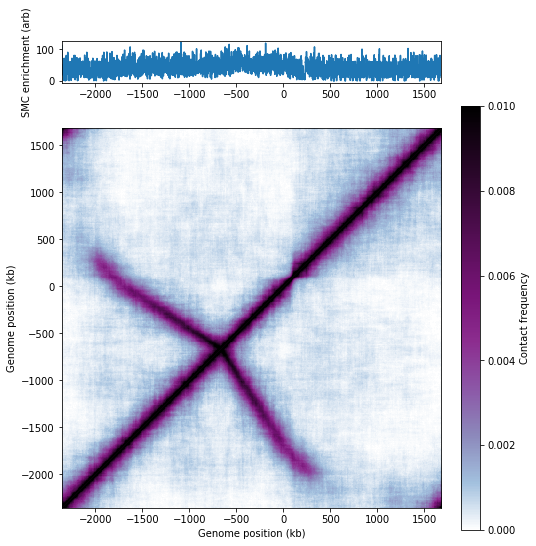

Done 1/12: Figures/fig_FullSims_m59_kd0.00202_kb_0.04_sep_134_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


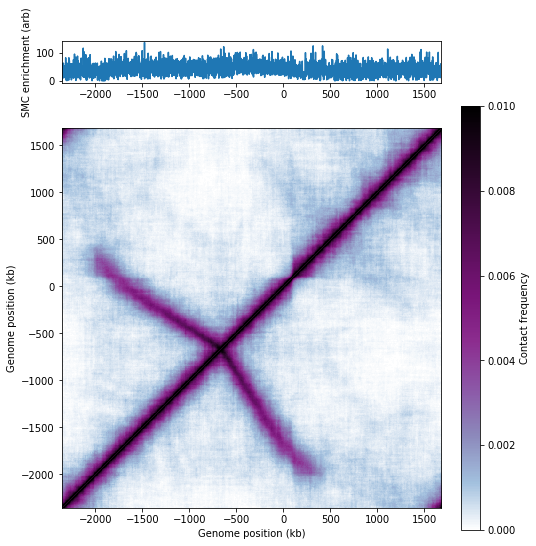

Done 2/12: Figures/fig_FullSims_m59_kd0.00202_kb_0.04_sep_134_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


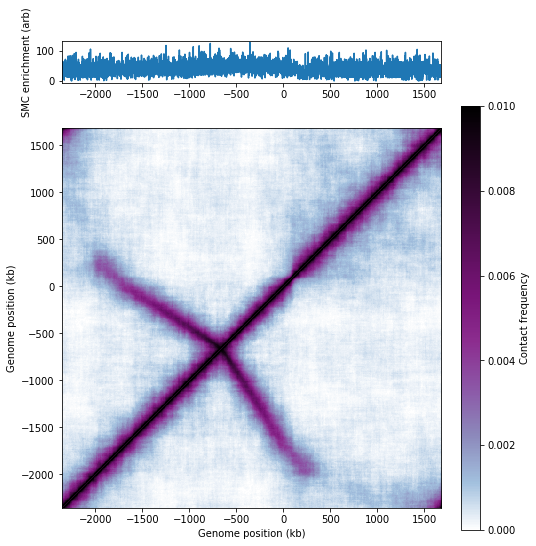

Done 3/12: Figures/fig_FullSims_m59_kd0.00202_kb_0.04_sep_134_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


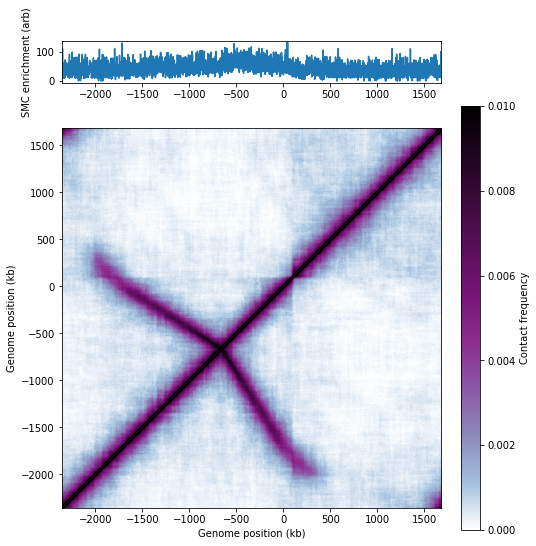

Done 4/12: Figures/fig_FullSims_m59_kd0.00263_kb_0.05_sep_101_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


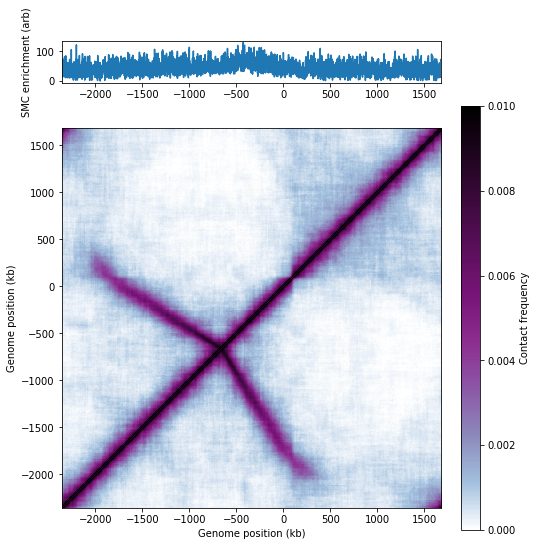

Done 5/12: Figures/fig_FullSims_m59_kd0.00263_kb_0.05_sep_101_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


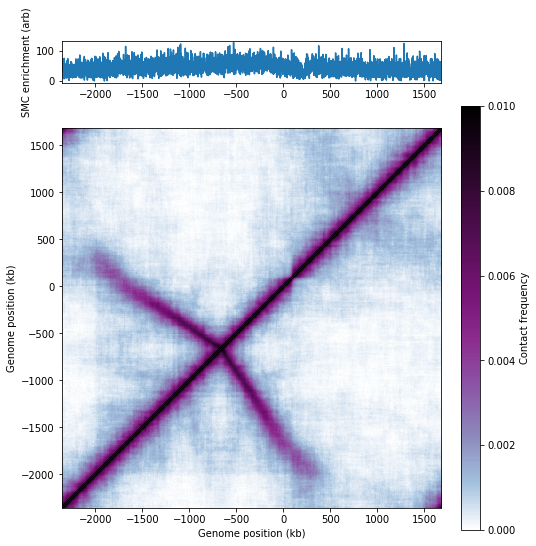

Done 6/12: Figures/fig_FullSims_m59_kd0.00263_kb_0.05_sep_101_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


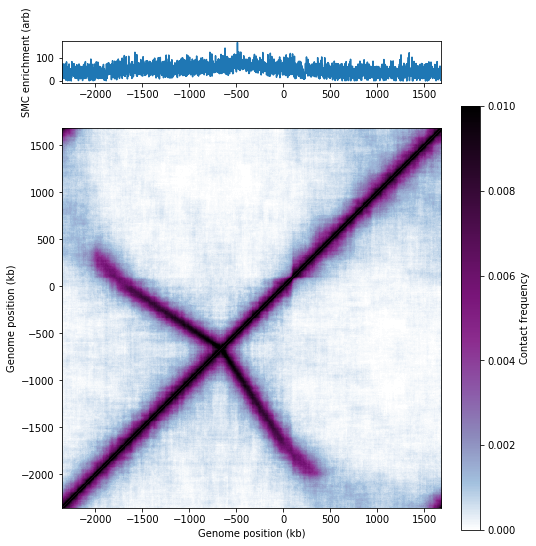

Done 7/12: Figures/fig_FullSims_m59_kd0.00322_kb_0.06_sep_80_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


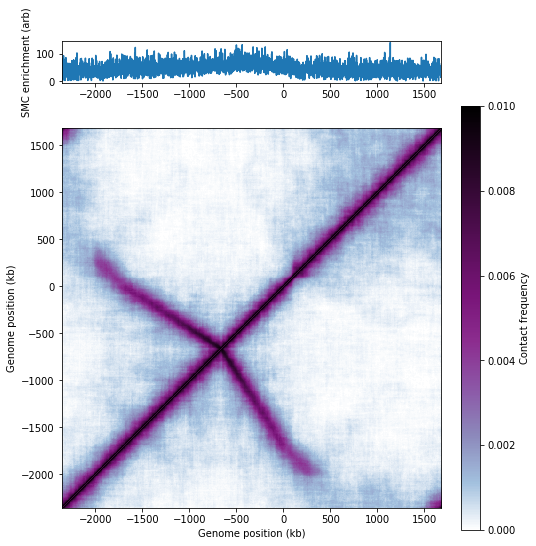

Done 8/12: Figures/fig_FullSims_m59_kd0.00322_kb_0.06_sep_80_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


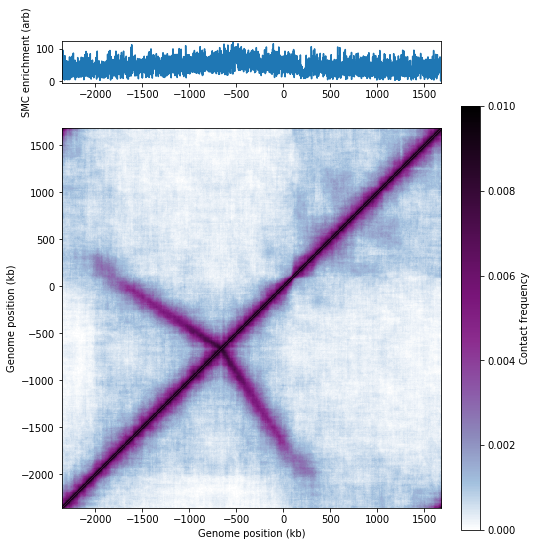

Done 9/12: Figures/fig_FullSims_m59_kd0.00322_kb_0.06_sep_80_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


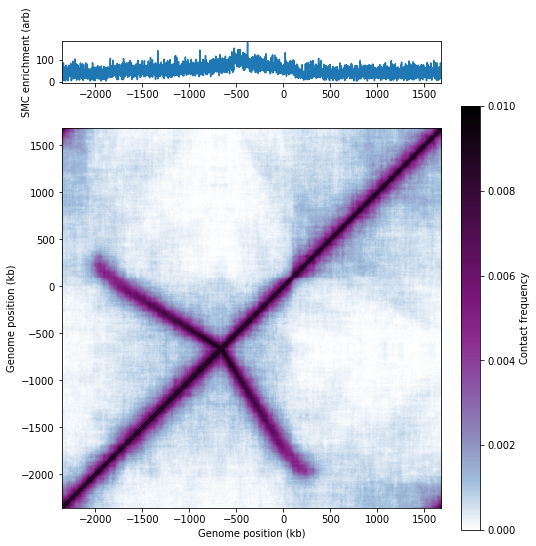

Done 10/12: Figures/fig_FullSims_m59_kd0.00432_kb_0.09_sep_57_parSstrength_16000_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


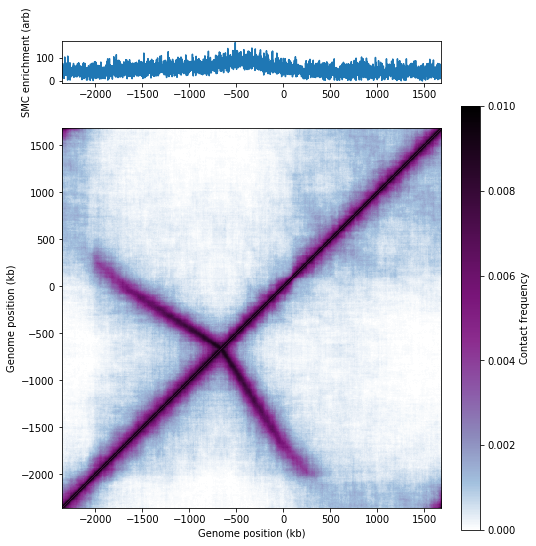

Done 11/12: Figures/fig_FullSims_m59_kd0.00432_kb_0.09_sep_57_parSstrength_8000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


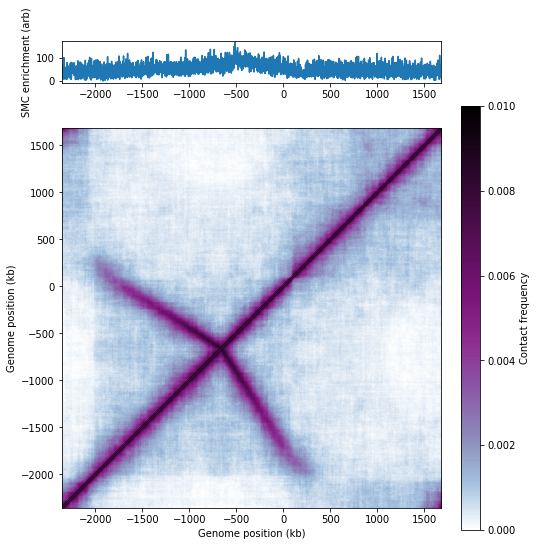

Done 12/12: Figures/fig_FullSims_m59_kd0.00432_kb_0.09_sep_57_parSstrength_4000.0_lifetime_40400_wind_0.35_stoch_0.05_terSites_1950_2050_terSiteStrength_0.0025_plecLen_45_plecRep_2.pdf


In [17]:
make_simulation_maps(simulation_filefolders,figure_filenames,vmax=0.01,cutoff_radius=9)